In [1]:
import sys
from pathlib import Path

root_dir = Path.cwd().parent  # Go one folder up from /notebooks
print("Root directory:", root_dir)

if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))
    
import pandas as pd
df = pd.read_parquet("../data/ml/financials_annual_th_ohlcv_clean.parquet")
print(df.shape)

Root directory: /Users/agalyaayyadurai/Automated-Equity-Valuation
(7467, 87)


## Overview

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7467 entries, 0 to 7466
Data columns (total 87 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   adsh                        7467 non-null   object        
 1   cik                         7467 non-null   int64         
 2   name                        7467 non-null   object        
 3   form                        7467 non-null   object        
 4   fy                          7467 non-null   Int64         
 5   fp                          7467 non-null   object        
 6   period                      7467 non-null   datetime64[ns]
 7   filed                       7467 non-null   datetime64[ns]
 8   sic                         7467 non-null   Int64         
 9   source_zip                  7467 non-null   object        
 10  instance                    7467 non-null   object        
 11  fye                         7467 non-null   object      

## Exploring each column and check for data integrity

### CIK

In [48]:
#Cik
df[['cik','name']].drop_duplicates().shape
#df.groupby('cik')['name'].nunique().value_counts().head(20)
df.groupby('cik')['name'].nunique() \
  .value_counts() \
  .rename_axis('unique_name_count') \
  .reset_index(name='num_companies')


,unique_name_count,num_companies
0,1,1270
1,2,358
2,3,51
3,4,5


##### This shows that there are about 500 companies that have more than 2 names alloted within 2010 to 2025. To look throught these companies and decide what to do with them

In [49]:
import pandas as pd
name_counts = df.groupby('cik')['name'].nunique()
ciks_with_many_names = name_counts[name_counts >= 2].index
ciks_with_many_names_df = (df[df['cik'].isin(ciks_with_many_names)]
 .groupby('cik')['name']
 .unique()
 .reset_index()
)
print(ciks_with_many_names_df)

         cik                                               name
0       6955            [ACTUANT CORP, ENERPAC TOOL GROUP CORP]
1       8146             [ASTRO MED INC /NEW/, ASTRONOVA, INC.]
2      18926       [CENTURYLINK, INC, LUMEN TECHNOLOGIES, INC.]
3      20520  [FRONTIER COMMUNICATIONS CORP, FRONTIER COMMUN...
4      27093                    [DATARAM CORP, U.S. GOLD CORP.]
..       ...                                                ...
409  1883835                 [PLASMA INNOVATIVE INC., ESG INC.]
410  1895618                [NFT GAMING CO INC., GAXOS.AI INC.]
411  1911545  [HANRYU HOLDINGS, INC., GLOBAL INTERACTIVE TEC...
412  1919246  [CHROMOCELL THERAPEUTICS CORP, CHANNEL THERAPE...
413  1977837            [ALIXO-YOLLOO CORP., ALIXO-YOLLOO CORP]

[414 rows x 2 columns]


##### We understand cmpanies with different names were because of this:
1. not a problem - just cosmetic changes in their name (eg. XYZ CORP. instead of XYZ CORP)
2. not a problem - Real Rebrand (FACEBOOK INC → META PLATFORMS, INC.)
3. problematic - With Multiple Shell Pivots / Reverse Mergers (to be removed from data modelling)

**Note:** All Cleaning or data manipuluation steps are done in a different notebook (02_ddata_prep)


### Ticker

In [50]:
#Ticker
#Does any ticker map to multiple CIKs in the same year
(df.groupby(['ticker', 'period'])['cik']
   .nunique()
   .reset_index(name='unique_ciks')
   .query("unique_ciks > 1"))

,ticker,period,unique_ciks


In [51]:
problem = df.groupby(['ticker','period'])['cik'].nunique()
problem = problem[problem > 1]

# Now inspect exact overlaps
out = (
    df[df.set_index(['ticker','period']).index.isin(problem.index)]
      .sort_values(['ticker','period','cik'])
      [['ticker','period','cik','name']]
      .drop_duplicates()
)

out

,ticker,period,cik,name


In [52]:
#Does any CIK have multiple tickers in the same year?
(df.groupby(['cik', 'period'])['ticker']
   .nunique()
   .reset_index(name='unique_tickers')
   .query("unique_tickers > 1"))

,cik,period,unique_tickers


### Period (Fiscal Period)

In [53]:
print(df['period'].dtype)
print(df['period'].dt.year.value_counts().sort_index())
print(df['period'].isna().sum())

dtype('<M8[ns]')

In [55]:
df.groupby(['cik','period']).size().sort_values(ascending=False).head(20)

cik      period    
1800     2009-12-31    1
1490054  2021-04-30    1
         2012-04-30    1
         2013-04-30    1
         2014-04-30    1
         2015-04-30    1
         2016-04-30    1
         2017-04-30    1
         2018-04-30    1
         2019-04-30    1
         2020-04-30    1
1490978  2020-12-31    1
1488039  2024-12-31    1
1490978  2021-12-31    1
         2022-12-31    1
         2023-12-31    1
         2024-12-31    1
1491419  2012-04-30    1
         2013-04-30    1
         2015-03-31    1
dtype: int64

In [57]:
df.groupby('cik')['period'].apply(lambda s: s.dt.dayofyear.unique())

cik
1800       [365, 366]
1961       [365, 366]
3197       [365, 366]
6176       [365, 366]
6292       [365, 366]
              ...    
2018064         [366]
2020795         [366]
2022626         [366]
2023658         [366]
2040807         [366]
Name: period, Length: 1684, dtype: object

In [58]:
(df.groupby('cik')['period']
   .apply(lambda s: (s.diff().dt.days <= 0).sum()))

cik
1800       0
1961       0
3197       0
6176       0
6292       0
          ..
2018064    0
2020795    0
2022626    0
2023658    0
2040807    0
Name: period, Length: 1684, dtype: int64

In [59]:
df.sort_values(['cik','period'], inplace=True)

df['period_diff'] = df.groupby('cik')['period'].diff().dt.days

df.loc[df['period_diff'] > 500, ['cik','period','period_diff']]

,cik,period,period_diff
28,1961,2024-12-31,731.0
49,6176,2018-12-31,730.0
293,29644,2017-07-31,731.0
430,50471,2017-06-30,731.0
448,51143,2020-12-31,731.0
...,...,...,...
11252,1753391,2023-12-31,518.0
11284,1755953,2021-12-31,549.0
11467,1783875,2023-12-31,730.0
11872,1829635,2024-12-31,731.0


In [60]:
df['fiscal_year'] = df['period'].dt.year

df.groupby(['cik', 'fiscal_year']).size().sort_values(ascending=False).head(20)

cik      fiscal_year
1635748  2016           2
931059   2015           2
1513856  2013           2
1574235  2015           2
1800     2009           1
1490054  2019           1
         2012           1
         2013           1
         2014           1
         2015           1
         2016           1
         2017           1
         2018           1
         2020           1
1488039  2024           1
1490054  2021           1
1490978  2020           1
         2021           1
         2022           1
         2023           1
dtype: int64

##### There are duplicate fiscal years for a cik - removign this in data_prep notebook

### Filed

In [82]:
#Filed
df = pd.read_parquet("../data/ml/financials_annual_th_ohlcv_clean.parquet")
print(df['filed'].isna().sum())
print(df['filed'].dtype)
print((df['filed'] < df['period']).sum())
print(df.groupby(['cik','period'])['filed'].nunique().max())
print((df['price_date'] < df['filed']).sum())


0
datetime64[ns]
0
1
0


In [83]:
df['delay'] = (df['filed'] - df['period']).dt.days

df['delay'].describe()

count    7656.000000
mean       69.488375
std        21.088582
min        18.000000
25%        56.000000
50%        65.000000
75%        84.000000
max       180.000000
Name: delay, dtype: float64

### TotalAssets

In [36]:
df[df["TotalAssets"] == 0][["cik", "name", "period", "Revenue", "TotalAssets"]]

,cik,name,period,Revenue,TotalAssets


In [37]:
df['TotalAssets'].describe(percentiles=[0.001,0.01,0.05,0.95,0.99,0.999])

count    7.550000e+03
mean     6.356196e+09
std      3.378143e+10
min      1.260000e+02
0.1%     5.106742e+03
1%       7.869521e+04
5%       1.374807e+06
50%      3.000950e+08
95%      1.575265e+10
99%      1.502980e+11
99.9%    4.598118e+11
max      5.516690e+11
Name: TotalAssets, dtype: float64

In [38]:
df[df['TotalAssets'] < 0][['cik','name','period','TotalAssets']]

,cik,name,period,TotalAssets


### CommonSharesOutstanding

In [100]:
df[df["CommonSharesOutstanding"] <= 0][["cik","name","ticker","period"]]

,cik,name,ticker,period


In [44]:
df['CommonSharesOutstanding'].describe(percentiles=[0.001,0.01,0.05,0.5,0.95,0.99,0.999])

count    7.550000e+03
mean     9.528687e+08
std      2.741001e+10
min      1.000000e+00
0.1%     1.000000e+00
1%       9.471849e+05
5%       5.176571e+06
50%      5.315319e+07
95%      6.970722e+08
99%      5.116793e+09
99.9%    6.039573e+10
max      1.595161e+12
Name: CommonSharesOutstanding, dtype: float64

In [45]:
print("Missing:", df['CommonSharesOutstanding'].isna().sum())
print("Zero:", (df['CommonSharesOutstanding'] == 0).sum())
print("Negative:", (df['CommonSharesOutstanding'] < 0).sum())

Missing: 0
Zero: 0
Negative: 0


### Revenue

In [2]:
print(df['Revenue'].isna().sum())
df['Revenue'].describe()

0


count    7.556000e+03
mean     3.232100e+09
std      1.869874e+10
min      5.000000e+00
25%      9.746994e+06
50%      1.230975e+08
75%      7.722178e+08
max      3.943280e+11
Name: Revenue, dtype: float64

In [3]:
(df['Revenue'] / df['TotalAssets']).describe(percentiles=[0.01, 0.50, 0.99])

count    7.556000e+03
mean     7.222542e-01
std      1.538659e+00
min      2.767426e-07
1%       7.788955e-04
50%      4.870701e-01
99%      4.428648e+00
max      7.199455e+01
dtype: float64

In [4]:
df['MarketValue'] = df['close'] * df['CommonSharesOutstanding']
(df['Revenue'] / df['MarketValue']).describe()

count    7.556000e+03
mean     6.009976e+05
std      1.809203e+07
min      5.357442e-19
25%      2.509314e-02
50%      1.848024e-01
75%      6.373765e-01
max      7.279511e+08
dtype: float64

In [34]:
df = df.sort_values(["cik", "period"])
df['Revenue_prev'] = df.groupby('cik')['Revenue'].shift(1)
df['period_prev'] = df.groupby('cik')['period'].shift(1)
df['Revenue_yoy'] = df.groupby('cik')['Revenue'].pct_change()
bad = df[abs(df['Revenue_yoy']) > 50]
revenue_jumps = bad[[
    'cik',
    'name',
    'period_prev',
    'period',
    'Revenue_prev',
    'Revenue',
    'Revenue_yoy'
]].sort_values(['Revenue_yoy'])
print(revenue_jumps)

          cik                                  name period_prev     period  \
5861  1574235                       PULMATRIX, INC.  2018-12-31 2019-12-31   
7440  1854526                         BROOQLY, INC.  2023-12-31 2024-12-31   
3624  1211805                         MY SIZE, INC.  2021-12-31 2023-12-31   
5259  1490054  APPIPHANY TECHNOLOGIES HOLDINGS CORP  2016-04-30 2017-04-30   
6500  1658247       CRINETICS PHARMACEUTICALS, INC.  2020-12-31 2023-12-31   
...       ...                                   ...         ...        ...   
1597   887359                          VERICEL CORP  2013-12-31 2014-12-31   
6993  1745999                BEAM THERAPEUTICS INC.  2020-12-31 2021-12-31   
3264  1124105            CATALYST BIOSCIENCES, INC.  2018-12-31 2020-12-31   
1693   899460                         MANNKIND CORP  2012-12-31 2016-12-31   
1790   911216              PALATIN TECHNOLOGIES INC  2013-06-30 2018-06-30   

      Revenue_prev      Revenue  Revenue_yoy  
5861      153000

In [30]:
idx_max = df['Revenue_yoy'].idxmax()
df.loc[idx_max, ['cik','name','period_prev','period','Revenue_prev','Revenue','Revenue_yoy']]

cik                               911216
name            PALATIN TECHNOLOGIES INC
period_prev          2013-06-30 00:00:00
period               2018-06-30 00:00:00
Revenue_prev                     10361.0
Revenue                       67134758.0
Revenue_yoy                  6478.563556
Name: 1790, dtype: object

In [31]:
problem_cik = df.loc[idx_max, 'cik']

df_cik = (
    df[df['cik'] == problem_cik]
    .sort_values('period')
    [['period', 'Revenue', 'Revenue_prev', 'Revenue_yoy']]
)

df_cik

,period,Revenue,Revenue_prev,Revenue_yoy
1788,2012-06-30,73736.0,NaN,NaN
1789,2013-06-30,10361.0,73736.0,-0.859485
1790,2018-06-30,67134758.0,10361.0,6478.563556
1791,2019-06-30,60300476.0,67134758.0,-0.101799
1792,2020-06-30,117989.0,60300476.0,-0.998043
1793,2022-06-30,1468457.0,117989.0,11.445711
1794,2023-06-30,4853678.0,1468457.0,2.305291
1795,2024-06-30,4490090.0,4853678.0,-0.074910


In [33]:
top20 = df.nlargest(20, 'Revenue_yoy')[['cik','name','period_prev','period','Revenue_prev','Revenue','Revenue_yoy']]
#print(top20)
#df[df['cik'] == 1501112].sort_values('period')[['cik', 'name', 'period','Revenue']]
for cik in top20['cik'].unique():
    print("\n==============================")
    print("CIK:", cik)
    print(df[df['cik'] == cik].sort_values('period')[['cik','name','period','Revenue']])


CIK: 911216
         cik                      name     period     Revenue
1788  911216  PALATIN TECHNOLOGIES INC 2012-06-30     73736.0
1789  911216  PALATIN TECHNOLOGIES INC 2013-06-30     10361.0
1790  911216  PALATIN TECHNOLOGIES INC 2018-06-30  67134758.0
1791  911216  PALATIN TECHNOLOGIES INC 2019-06-30  60300476.0
1792  911216  PALATIN TECHNOLOGIES INC 2020-06-30    117989.0
1793  911216  PALATIN TECHNOLOGIES INC 2022-06-30   1468457.0
1794  911216  PALATIN TECHNOLOGIES INC 2023-06-30   4853678.0
1795  911216  PALATIN TECHNOLOGIES INC 2024-06-30   4490090.0

CIK: 899460
         cik           name     period      Revenue
1691  899460  MANNKIND CORP 2011-12-31      50000.0
1692  899460  MANNKIND CORP 2012-12-31      35000.0
1693  899460  MANNKIND CORP 2016-12-31  174758000.0
1694  899460  MANNKIND CORP 2017-12-31   11745000.0
1695  899460  MANNKIND CORP 2018-12-31   27859000.0
1696  899460  MANNKIND CORP 2019-12-31   63038000.0
1697  899460  MANNKIND CORP 2020-12-31   65144000.0


### TotalLiabilities

In [50]:
print(df['TotalLiabilities'].describe(percentiles=[0.001,0.01,0.05,0.95,0.99,0.999]))
print("Missing:", df['TotalLiabilities'].isna().sum())
print("Zero:", (df['TotalLiabilities'] == 0).sum())
print("Negative:", (df['TotalLiabilities'] < 0).sum())

count    6.231000e+03
mean     2.203553e+09
std      1.425317e+10
min      1.415000e+03
0.1%     2.943899e+04
1%       4.346991e+05
5%       1.815344e+06
50%      1.039970e+08
95%      6.093584e+09
99%      4.098364e+10
99.9%    2.470293e+11
max      3.080300e+11
Name: TotalLiabilities, dtype: float64
Missing: 1314
Zero: 0
Negative: 0


In [51]:
print((df['TotalLiabilities'].isna() & df['ShareholdersEquity'].isna()).sum())

0


### ShareHoldersEquity

In [53]:
print(df['ShareholdersEquity'].describe(percentiles=[0.001,0.01,0.05,0.95,0.99,0.999]))
print("Missing:", df['ShareholdersEquity'].isna().sum())
print("Zero:", (df['ShareholdersEquity'] == 0).sum())
print("Negative:", (df['ShareholdersEquity'] < 0).sum())

count    7.533000e+03
mean     2.558987e+09
std      1.447300e+10
min     -7.934000e+10
0.1%    -2.246040e+10
1%      -3.637998e+09
5%      -4.009574e+08
50%      3.071580e+08
95%      7.039402e+09
99%      6.476164e+10
99.9%    2.016723e+11
max      3.250840e+11
Name: ShareholdersEquity, dtype: float64
Missing: 12
Zero: 0
Negative: 1211


### NetIncome

In [64]:
print(df['NetIncome'].describe(percentiles=[0.001,0.01,0.05,0.95,0.99,0.999]))
print("Missing:", df['NetIncome'].isna().sum())
print("Zero:", (df['NetIncome'] == 0).sum())
print("Negative:", (df['NetIncome'] < 0).sum())

count    7.183000e+03
mean     4.662717e+08
std      4.415873e+09
min     -1.131100e+10
0.1%    -5.091916e+09
1%      -9.481130e+08
5%      -2.889702e+08
50%     -5.657173e+06
95%      8.830562e+08
99%      1.188370e+10
99.9%    7.360263e+10
max      1.001180e+11
Name: NetIncome, dtype: float64
Missing: 284
Zero: 0
Negative: 4507


In [61]:
(df['NetIncome'].abs() > df['TotalAssets'] * 20).sum()

0

### OperatingIncome

In [63]:
print(df['OperatingIncome'].describe(percentiles=[0.001,0.01,0.05,0.95,0.99,0.999]))
print("Missing:", df['OperatingIncome'].isna().sum())
print("Zero:", (df['OperatingIncome'] == 0).sum())
print("Negative:", (df['OperatingIncome'] < 0).sum())

count    7.467000e+03
mean     7.612819e+08
std      6.343742e+09
min     -3.336800e+10
0.1%    -3.617514e+09
1%      -7.730272e+08
5%      -2.599226e+08
50%     -4.102577e+06
95%      1.519400e+09
99%      1.844484e+10
99.9%    9.156841e+10
max      1.620440e+11
Name: OperatingIncome, dtype: float64
Missing: 0
Zero: 0
Negative: 4523


In [62]:
(df['OperatingIncome'].abs() > df['TotalAssets'] * 20).sum()

0

## Archive

count    9.774000e+03
mean     3.929014e+09
std      1.861913e+10
min     -1.259785e+11
25%      4.744750e+06
50%      1.016130e+08
75%      9.361685e+08
max      3.943280e+11
Name: Revenue, dtype: float64
0.2264957264957265


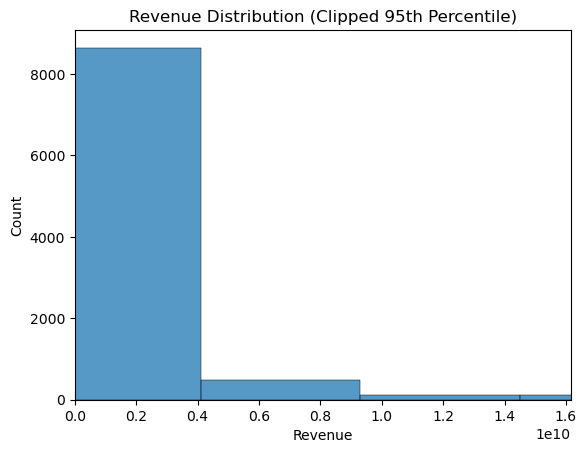

In [20]:
#Revenue
print(df_clean['Revenue'].describe())
print(df['Revenue'].isna().mean())
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Revenue'], bins=100)
plt.xlim(0, df['Revenue'].quantile(0.95))
plt.title("Revenue Distribution (Clipped 95th Percentile)")
plt.show()


## Archive

In [23]:
import sys
from pathlib import Path

root_dir = Path.cwd().parent  # Go one folder up from /notebooks
print("Root directory:", root_dir)

if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))
    
import pandas as pd
df = pd.read_parquet("../data/enriched/financials_annual_ticker_sic.parquet")

#Renaming the ticker column to ticker_old as new mapping is tried later

df = df.rename(columns={'ticker': 'ticker_old'})

df.head()

Root directory: /Users/agalyaayyadurai/Automated-Equity-Valuation


,adsh,cik,name,form,fy,fp,period,filed,sic,source_zip,...,WASODiluted,bs_diff,bs_balanced_flag,cf_delta_abs,cf_balanced_flag,coverage_score,WASOCombinedBasicDiluted,ticker_old,office,industry_title
0,0001047469-11-006302,1750,AAR CORP,10-K,2011,FY,20110531,2011-07-13,3720,2011q3,...,NaN,8.678820e+08,False,21964000.0,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS
1,0001047469-12-007300,1750,AAR CORP,10-K,2012,FY,20120531,2012-07-19,3720,2012q3,...,NaN,1.331004e+09,False,0.0,True,0.333333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS
2,0001047469-13-007797,1750,AAR CORP,10-K,2013,FY,20130531,2013-07-26,3720,2013q3,...,NaN,1.218300e+09,False,6400000.0,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS
3,0001047469-14-006243,1750,AAR CORP,10-K,2014,FY,20140531,2014-07-17,3720,2014q3,...,NaN,1.200000e+09,False,13000000.0,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS
4,0001047469-15-006136,1750,AAR CORP,10-K,2015,FY,20150531,2015-07-15,3720,2015q3,...,NaN,6.699000e+08,False,31900000.0,False,0.583333,NaN,AIR,Office of Manufacturing,AIRCRAFT & PARTS


In [24]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

# 1) Keep only Tech & Healthcare offices
tech_offices = ["Office of Technology"]
health_offices = ["Office of Life Sciences"]

df_sec = df[df["office"].isin(tech_offices + health_offices)].copy()

# Treat office as sector label
df_sec["sector"] = df_sec["office"].map({
    "Office of Technology": "Technology",
    "Office of Life Sciences": "Healthcare"
})

# 2) Keep valid revenue
df_sec = df_sec.dropna(subset=["Revenue"]).copy()
df_sec = df_sec[df_sec["Revenue"] > 0].copy()

# 3) Ensure period is datetime & sort
df_sec["period"] = pd.to_datetime(df_sec["period"])
df_sec = df_sec.sort_values(["cik", "period"]).copy()

# 4) Compute log revenue & growth
df_sec["log_rev"] = np.log(df_sec["Revenue"])
df_sec["log_rev_lag"] = df_sec.groupby("cik")["log_rev"].shift(1)
df_sec["g"] = df_sec["log_rev"] - df_sec["log_rev_lag"]

# Drop invalid growth
df_sec = df_sec.dropna(subset=["g"]).copy()

# 5) Keep only firms with enough history (>= 4 growth obs ≈ 5 years)
growth_counts = df_sec.groupby("cik")["g"].size()
valid_ciks = growth_counts[growth_counts >= 4].index
df_sec = df_sec[df_sec["cik"].isin(valid_ciks)].copy()

# 6) Build AR(1) lag variable
df_sec["g_lag"] = df_sec.groupby("cik")["g"].shift(1)
df_sec = df_sec.dropna(subset=["g_lag"]).copy()

# 7) Add year for sector-level time series
df_sec["year"] = df_sec["period"].dt.year


In [22]:
tech_health = ["Office of Technology", "Office of Life Sciences"]
df_th = df[df["office"].isin(tech_health)].copy()

eda_cols = [
    "CommonSharesOutstanding", "ShortTermDebt", "LongTermDebt",
    "CashAndCashEquivalents", "OperatingIncome", "Revenue"
]

missing = df_th[eda_cols].isna().mean().sort_values(ascending=False)
print("Missing ratio in Tech & Healthcare only:")
print(missing)

print("\nValid rows for EV/EBIT (requires: Shares, Cash, Debt, OperatingIncome):")
core_cols = ["CommonSharesOutstanding", "CashAndCashEquivalents", "OperatingIncome"]
df_evit = df_th.dropna(subset=core_cols)
print(df_evit.shape, "rows,", df_evit['cik'].nunique(), "unique firms")


Missing ratio in Tech & Healthcare only:
LongTermDebt               0.754252
ShortTermDebt              0.716907
Revenue                    0.235982
OperatingIncome            0.083651
CommonSharesOutstanding    0.064012
CashAndCashEquivalents     0.044911
dtype: float64

Valid rows for EV/EBIT (requires: Shares, Cash, Debt, OperatingIncome):
(15565, 74) rows, 2768 unique firms


## Ticker Mapping

In [26]:
# Checkign for Ticker Integrity
tech_health_offices = [
    "Office of Technology",
    "Office of Life Sciences"
]

df_th = df[df["office"].isin(tech_health_offices)].copy()

# 1) Missing ticker ratio
miss_ratio = df_th["ticker_old"].isna().mean()
print("Missing ticker ratio:", miss_ratio)

# 2) How many unique CIKs & unique tickers exist
print("Unique CIKs:", df_th["cik"].nunique())
print("Unique tickers:", df_th["ticker_old"].nunique())

# 3) CIKs without ticker
ciks_without_ticker = df_th[df_th["ticker_old"].isna()]["cik"].nunique()
print("CIKs with no ticker:", ciks_without_ticker)

cik_ticker_map = (
    df_th.groupby("cik")["ticker_old"]
         .nunique()
         .reset_index(name="n_tickers")
)

# CIKs with more than 1 ticker (= suspicious)
multi_ticker = cik_ticker_map[cik_ticker_map["n_tickers"] > 1]
print("CIKs with >1 ticker:", multi_ticker.shape[0])
multi_ticker.head()

ticker_cik_map = (
    df_th.groupby("ticker_old")["cik"]
         .nunique()
         .reset_index(name="n_ciks")
)

# tickers mapping to multiple CIKs (usually OK for holding structures, but we need to know)
multi_cik = ticker_cik_map[ticker_cik_map["n_ciks"] > 1]
print("Tickers with >1 CIK:", multi_cik.shape[0])
multi_cik.head()

Missing ticker ratio: 0.12544937489939367
Unique CIKs: 3119
Unique tickers: 3357
CIKs with no ticker: 976
CIKs with >1 ticker: 551
Tickers with >1 CIK: 86


,ticker_old,n_ciks
45,ACT,3
104,AGN,2
135,ALG,2
139,ALKS,2
251,ARCT,2


In [30]:
import json
import pandas as pd

# 1. Load JSON (update the path to your actual file)
json_path = "../data/company_tickers_exchange.json"  # <-- change if needed

with open(json_path, "r") as f:
    raw = json.load(f)

fields = raw["fields"]
rows = raw["data"]

cik_map = pd.DataFrame(rows, columns=fields)

# Ensure CIK is integer to match your fundamentals
cik_map["cik"] = cik_map["cik"].astype(int)

# Optional: rename columns to avoid clashing with df_th's 'name'
cik_map = cik_map.rename(columns={"name": "sec_name", "ticker": "sec_ticker"})

cik_map.head()


,cik,sec_name,sec_ticker,exchange
0,1045810,NVIDIA CORP,NVDA,Nasdaq
1,789019,MICROSOFT CORP,MSFT,Nasdaq
2,320193,Apple Inc.,AAPL,Nasdaq
3,1652044,Alphabet Inc.,GOOGL,Nasdaq
4,1018724,AMAZON COM INC,AMZN,Nasdaq


In [44]:
cik_map[cik_map["sec_name" == "BRISTOL MYERS SQUIBB CO"]].nunique()

KeyError: False

In [31]:
# Ensure cik is int
df_th["cik"] = df_th["cik"].astype(int)

print("Unique CIKs in Tech+Health:", df_th["cik"].nunique())

Unique CIKs in Tech+Health: 3119


In [32]:
# Merge cik_map into df_th based on cik
df_th = df_th.merge(
    cik_map[["cik", "sec_ticker", "sec_name"]],
    on="cik",
    how="left"
)

# Our new official ticker column
df_th["ticker"] = df_th["sec_ticker"]

# We keep:
# - ticker_old  (your original)
# - ticker      (new from mapping)
# - sec_name    (SEC name, useful for sanity checks)


In [33]:
print("Missing ticker ratio (new mapping):", df_th["ticker"].isna().mean())
print("Unique CIKs:", df_th["cik"].nunique())
print("Unique mapped tickers:", df_th["ticker"].nunique())


Missing ticker ratio (new mapping): 0.3233314994286682
Unique CIKs: 3119
Unique mapped tickers: 1626


In [36]:
import pandas as pd

# 1) Count how many tickers each CIK has
cik_ticker_counts = (
    df_th.groupby("cik")["ticker"]
         .nunique()
         .reset_index(name="n_tickers")
)

# 2) Keep only CIKs where n_tickers > 1
multi_ticker_ciks = cik_ticker_counts[cik_ticker_counts["n_tickers"] > 1]
print("Number of CIKs with >1 ticker:", multi_ticker_ciks.shape[0])

# 3) Join back to df_th to get the company name(s)
# We’ll grab a single representative name per CIK (first one).
cik_name_map = (
    df_th.groupby("cik")["name"]
         .agg(lambda x: x.dropna().iloc[0] if len(x.dropna()) > 0 else None)
         .reset_index()
)

multi_cik_with_name = multi_ticker_ciks.merge(cik_name_map, on="cik", how="left")

print(multi_cik_with_name.head(20))

Number of CIKs with >1 ticker: 165
       cik  n_tickers                                name
0    14272          3             BRISTOL MYERS SQUIBB CO
1    14930          3                      BRUNSWICK CORP
2    43196          2                 GRAY TELEVISION INC
3    64463          2                SOLUNA HOLDINGS, INC
4    67887          2                            MOOG INC
5    68622          2                          QWEST CORP
6    70866          2                            NCR CORP
7    78814          2               PITNEY BOWES INC /DE/
8   732717          4                           AT&T INC.
9   750004          2               SCIENTIFIC GAMES CORP
10  791908          3                           XOMA CORP
11  818686          2  TEVA PHARMACEUTICAL INDUSTRIES LTD
12  821130          4         UNITED STATES CELLULAR CORP
13  827876          2                    CLEANSPARK, INC.
14  832489          2                   GEOVAX LABS, INC.
15  849399          2                

In [37]:
ciks_in_fund = set(df_th["cik"].unique())
ciks_in_map = set(cik_map["cik"].unique())

missing_in_map = ciks_in_fund - ciks_in_map
print("CIKs in fundamentals but not in cik_map:", len(missing_in_map))

CIKs in fundamentals but not in cik_map: 1696


In [38]:
cik_map.loc[cik_map["cik"] == 3197, ["cik", "name", "ticker", "exchange"]]

KeyError: "['name', 'ticker'] not in index"

In [39]:
import pandas as pd

# 1) Filter rows with no mapped ticker
df_no_ticker = df_th[df_th["ticker"].isna()].copy()

print("Rows with no ticker in df_th:", df_no_ticker.shape[0])
print("Unique CIKs (no ticker):", df_no_ticker["cik"].nunique())

# 2) Attach any CIK-based info from cik_map (sec_name, sec_ticker)
df_no_ticker = df_no_ticker.merge(
    cik_map[["cik", "sec_name", "sec_ticker"]],
    on="name",
    how="left",
    suffixes=("", "_from_cikmap")
)

# 3) Optional: subset to the key columns you care about for inspection
cols_view_no_ticker = [
    "cik",
    "name",          # fundamentals name
    "ticker",        # still NaN
    "ticker_old",    # your original ticker mapping
    "sec_name",      # SEC name from mapping
    "sec_ticker",    # SEC ticker from mapping (if any)
    "instance",
    "period",
    "office",
]

df_no_ticker_view = df_no_ticker[cols_view_no_ticker].drop_duplicates()

df_no_ticker_view.head(20)

Rows with no ticker in df_th: 7640
Unique CIKs (no ticker): 1696


,cik,name,ticker,ticker_old,sec_name,sec_ticker,instance,period,office
0,1961,WORLDS INC,NaN,WORLD,NaN,NaN,world-20111231.xml,20111231,Office of Technology
1,1961,WORLDS INC,NaN,WDDD,NaN,NaN,wddd-20121231.xml,20121231,Office of Technology
2,1961,WORLDS INC,NaN,WORLD,NaN,NaN,world-20131231.xml,20131231,Office of Technology
3,1961,WORLDS INC,NaN,WORLD,NaN,NaN,world-20141231.xml,20141231,Office of Technology
4,1961,WORLDS INC,NaN,WORLD,NaN,NaN,world-20151231.xml,20151231,Office of Technology
5,1961,WORLDS INC,NaN,WORLD,NaN,NaN,world-20161231.xml,20161231,Office of Technology
6,1961,WORLDS INC,NaN,WORLD,NaN,NaN,world-20171231.xml,20171231,Office of Technology
7,1961,WORLDS INC,NaN,WDDD,NaN,NaN,wddd-20181231.xml,20181231,Office of Technology
8,1961,WORLDS INC,NaN,WDDD,NaN,NaN,wddd-20191231.xml,20191231,Office of Technology
9,1961,WORLDS INC,NaN,WDDD,NaN,NaN,wddd-20201231.xml,20201231,Office of Technology


In [40]:
# 1) Find CIKs with > 1 unique ticker in df_th
cik_ticker_counts = (
    df_th.groupby("cik")["ticker"]
         .nunique()
         .reset_index(name="n_tickers")
)

multi_ticker_ciks = cik_ticker_counts[cik_ticker_counts["n_tickers"] > 1]
print("CIKs with >1 ticker:", multi_ticker_ciks.shape[0])

# 2) Filter df_th to only those problematic CIKs
df_multi_ticker = df_th[df_th["cik"].isin(multi_ticker_ciks["cik"])].copy()

# 3) Attach SEC mapping
df_multi_ticker = df_multi_ticker.merge(
    cik_map[["cik", "sec_name", "sec_ticker"]],
    on="cik",
    how="left",
    suffixes=("", "_from_cikmap")
)

# 4) Build a clean view for inspection
cols_view_multi = [
    "cik",
    "name",
    "ticker",        # new mapped ticker (this is what conflicts)
    "ticker_old",    # your original ticker
    "sec_name",
    "sec_ticker",
    "instance",
    "period",
    "office",
]

df_multi_ticker_view = (
    df_multi_ticker[cols_view_multi]
    .drop_duplicates()
    .sort_values(["cik", "period"])
)

df_multi_ticker_view.head(30)


CIKs with >1 ticker: 165


,cik,name,ticker,ticker_old,sec_name,sec_ticker,instance,period,office
0,14272,BRISTOL MYERS SQUIBB CO,BMY,BMY,BRISTOL MYERS SQUIBB CO,BMY,bmy-20091231.xml,20091231,Office of Life Sciences
3,14272,BRISTOL MYERS SQUIBB CO,BMYMP,BMY,BRISTOL MYERS SQUIBB CO,BMYMP,bmy-20091231.xml,20091231,Office of Life Sciences
6,14272,BRISTOL MYERS SQUIBB CO,CELG-RI,BMY,BRISTOL MYERS SQUIBB CO,CELG-RI,bmy-20091231.xml,20091231,Office of Life Sciences
27,14272,BRISTOL MYERS SQUIBB CO,BMY,BMY,BRISTOL MYERS SQUIBB CO,BMY,bmy-20101231.xml,20101231,Office of Life Sciences
30,14272,BRISTOL MYERS SQUIBB CO,BMYMP,BMY,BRISTOL MYERS SQUIBB CO,BMYMP,bmy-20101231.xml,20101231,Office of Life Sciences
33,14272,BRISTOL MYERS SQUIBB CO,CELG-RI,BMY,BRISTOL MYERS SQUIBB CO,CELG-RI,bmy-20101231.xml,20101231,Office of Life Sciences
54,14272,BRISTOL MYERS SQUIBB CO,BMY,BMY,BRISTOL MYERS SQUIBB CO,BMY,bmy-20111231.xml,20111231,Office of Life Sciences
57,14272,BRISTOL MYERS SQUIBB CO,BMYMP,BMY,BRISTOL MYERS SQUIBB CO,BMYMP,bmy-20111231.xml,20111231,Office of Life Sciences
60,14272,BRISTOL MYERS SQUIBB CO,CELG-RI,BMY,BRISTOL MYERS SQUIBB CO,CELG-RI,bmy-20111231.xml,20111231,Office of Life Sciences
81,14272,BRISTOL MYERS SQUIBB CO,BMY,BMY,BRISTOL MYERS SQUIBB CO,BMY,bmy-20121231.xml,20121231,Office of Life Sciences


In [56]:
import json
import re
import numpy as np
import pandas as pd

# ========= 1. Load CIK → Ticker JSON mapping ========= #
json_path = "../data/company_tickers.json"  # <-- adjust if needed

with open(json_path, "r") as f:
    raw = json.load(f)

# Convert dict-of-dicts → DataFrame
cik_map = pd.DataFrame(raw).T  # transpose so keys become rows

# Standardize column names (so it matches your pipeline)
cik_map = cik_map.rename(columns={
    "cik_str": "cik",
    "title": "sec_name",
    "ticker": "sec_ticker"
})

# Ensure cik is integer (optional but recommended)
cik_map["cik"] = cik_map["cik"].astype(int)

# ========= 2. Filter fundamentals to Tech + Healthcare ========= #

tech_health_offices = ["Office of Technology", "Office of Life Sciences"]

df_th = df[df["office"].isin(tech_health_offices)].copy()
df_th["cik"] = df_th["cik"].astype(int)

# Preserve your old ticker mapping if present
if "ticker" in df_th.columns:
    df_th = df_th.rename(columns={"ticker": "ticker_old"})
else:
    df_th["ticker_old"] = np.nan

print("\nTech+Health shape:", df_th.shape)
print("Columns:", df_th.columns.tolist())


# ========= 3. Merge on CIK to get sec_ticker ========= #

df_th1 = df_th.merge(
    cik_map[["cik", "sec_name", "sec_ticker"]],
    on="cik",
    how="left"
)

print("\nsec_ticker in df_th1?", "sec_ticker" in df_th1.columns)
print("Missing sec_ticker after CIK merge:",
      df_th1["sec_ticker"].isna().mean())


# ========= 4. Name normalization for fallback matching ========= #

def normalize_name(x: str) -> str:
    if not isinstance(x, str):
        return None
    x = x.lower().strip()
    x = re.sub(r"[^a-z0-9]+", " ", x)  # remove punctuation
    x = re.sub(r"\s+", " ", x)        # collapse multiple spaces
    return x

df_th1["name_norm"] = df_th1["name"].apply(normalize_name)
cik_map["sec_name_norm"] = cik_map["sec_name"].apply(normalize_name)


# ========= 5. Fallback: match remaining missing tickers on name ========= #

df_missing = df_th1[df_th1["sec_ticker"].isna()].copy()
print("\nRows missing sec_ticker after CIK merge:", df_missing.shape[0])

# Only try to fill these using name-based mapping
df_missing2 = df_missing.merge(
    cik_map[["sec_name_norm", "sec_ticker"]],
    left_on="name_norm",
    right_on="sec_name_norm",
    how="left",
    suffixes=("", "_from_name")
)

# sec_ticker_from_name created by suffixes above
df_missing2["ticker_final"] = df_missing2["sec_ticker"].fillna(
    df_missing2["sec_ticker_from_name"]
)

# Build a unique mapping: one final ticker per CIK for the missing set
# Use mode() to pick the most frequent if multiple candidates
update_map = (
    df_missing2.dropna(subset=["ticker_final"])
               .groupby("cik")["ticker_final"]
               .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

print("Number of CIKs with fallback name-based ticker:", update_map.shape[0])


# ========= 6. Construct final ticker_new column ========= #

# Start ticker_new as the CIK-based sec_ticker
df_th1["ticker_new"] = df_th1["sec_ticker"]

# Mask for rows that still have NaN sec_ticker
mask_missing_cik = df_th1["sec_ticker"].isna()

# For those, plug in name-based ticker_final where available
df_th1.loc[mask_missing_cik, "ticker_new"] = (
    df_th1.loc[mask_missing_cik, "cik"].map(update_map)
)

print("\nMissing ticker_new ratio after CIK + name:",
      df_th1["ticker_new"].isna().mean())

# Set final ticker column
df_th1["ticker"] = df_th1["ticker_new"]


# ========= 7. View rows with NO final ticker ========= #

no_ticker = df_th1[df_th1["ticker"].isna()].copy()
print("\nRows with no final ticker:", no_ticker.shape[0])

view_no_ticker = no_ticker[[
    "cik",
    "name",
    "sec_name",
    "ticker_old",
    "ticker",
    "instance",
    "period",
    "office"
]].drop_duplicates()

print("\nSample of rows with no ticker:")
print(view_no_ticker.head(20))


# ========= 8. View CIKs that still have >1 ticker ========= #

cik_counts = (
    df_th1.groupby("cik")["ticker"]
          .nunique()
          .reset_index(name="n_tickers")
)

multi_cik = cik_counts[cik_counts["n_tickers"] > 1]["cik"]
print("\nNumber of CIKs with >1 ticker:", multi_cik.shape[0])

multi_ticker_rows = df_th1[df_th1["cik"].isin(multi_cik)][[
    "cik",
    "name",
    "sec_name",
    "ticker_old",
    "ticker",
    "instance",
    "period",
    "office"
]].drop_duplicates().sort_values(["cik", "period"])

print("\nSample of multi-ticker CIKs:")
print(multi_ticker_rows.head(30))



Tech+Health shape: (18637, 74)
Columns: ['adsh', 'cik', 'name', 'form', 'fy', 'fp', 'period', 'filed', 'sic', 'source_zip', 'instance', 'fye', 'accepted', 'countryba', 'stprba', 'AccountsPayable', 'AccountsReceivable', 'CashAndCashEquivalents', 'Goodwill', 'Intangibles', 'Inventory', 'LongTermDebt', 'OtherCurrentLiabilities', 'OtherNoncurrentLiabilities', 'PPandE', 'RetainedEarnings', 'ShareholdersEquity', 'ShortTermDebt', 'ShortTermInvestments', 'TotalAssets', 'TotalCurrentAssets', 'TotalCurrentLiabilities', 'TotalLiabilities', 'TotalNoncurrentAssets', 'TreasuryStock', 'CostOfRevenue', 'DepAmort', 'GrossProfit', 'IncomeTaxExpense', 'InterestExpense', 'NetIncome', 'OperatingExpenses', 'OperatingIncome', 'OtherIncomeExpense', 'PretaxIncome', 'RND', 'Revenue', 'SGA', 'CFF', 'CFI', 'CFO', 'CapEx', 'DebtIssuance', 'DebtRepayment', 'DepAmortCF', 'EquityIssuance', 'IncomeTaxesPaid', 'InterestPaid', 'ProceedsFromSalePPE', 'ShareRepurchase', 'StockBasedComp', 'CommonSharesIssued', 'CommonShar

In [57]:
duplicated_rows = cik_map[cik_map.duplicated(subset="cik", keep=False)].sort_values("cik")
print(duplicated_rows)

grouped = (
    cik_map[cik_map.duplicated(subset="cik", keep=False)]
    .sort_values("cik")
    .groupby("cik")
)
for cik, group in grouped:
    print(f"\n🔁 CIK {cik} has {len(group)} entries:")
    print(group)


           cik sec_ticker                sec_name          sec_name_norm
9896      4281      HWM-P   Howmet Aerospace Inc.  howmet aerospace inc 
200       4281        HWM   Howmet Aerospace Inc.  howmet aerospace inc 
966       4457       UHAL  U-Haul Holding Co /NV/  u haul holding co nv 
7613      4457     UHAL-B  U-Haul Holding Co /NV/  u haul holding co nv 
859       5513        UNM              Unum Group             unum group
...        ...        ...                     ...                    ...
10097  2083221      SPIWF             SPIE SA/ADR            spie sa adr
7092   2085236      AMVOY              AUMOVIO SE             aumovio se
10008  2085236      AMVIF              AUMOVIO SE             aumovio se
9049   2087500      NHKGF  NHK Spring Co. Ltd/ADR  nhk spring co ltd adr
7270   2087500      NHKSY  NHK Spring Co. Ltd/ADR  nhk spring co ltd adr

[3637 rows x 4 columns]

🔁 CIK 4281 has 2 entries:
       cik sec_ticker               sec_name          sec_name_norm
9896

In [51]:
# How many distinct tickers per CIK in cik_map?
cik_ticker_counts_map = (
    cik_map.groupby("cik")["sec_ticker"]
           .nunique()
           .reset_index(name="n_tickers")
)

# CIKs that have more than one ticker in the JSON
multi_ticker_cik_map = cik_ticker_counts_map[cik_ticker_counts_map["n_tickers"] > 1]

print("Number of CIKs with >1 ticker in cik_map:", multi_ticker_cik_map.shape[0])
multi_ticker_cik_map.head()

Number of CIKs with >1 ticker in cik_map: 1395


,cik,n_tickers
14,4281,2
15,4457,2
21,5513,2
35,7789,4
36,8063,2


In [52]:
cik_multi_list = multi_ticker_cik_map["cik"].tolist()

multi_map_details = (
    cik_map[cik_map["cik"].isin(cik_multi_list)]
    .sort_values(["cik", "sec_ticker"])
)

multi_map_details.head(30)


,cik,sec_name,sec_ticker,exchange,sec_name_norm
200,4281,Howmet Aerospace Inc.,HWM,NYSE,howmet aerospace inc
8229,4281,Howmet Aerospace Inc.,HWM-P,NYSE,howmet aerospace inc
966,4457,U-Haul Holding Co /NV/,UHAL,NYSE,u haul holding co nv
7613,4457,U-Haul Holding Co /NV/,UHAL-B,NYSE,u haul holding co nv
859,5513,Unum Group,UNM,NYSE,unum group
7691,5513,Unum Group,UNMA,NYSE,unum group
1505,7789,ASSOCIATED BANC-CORP,ASB,NYSE,associated banc corp
7747,7789,ASSOCIATED BANC-CORP,ASB-PE,NYSE,associated banc corp
8231,7789,ASSOCIATED BANC-CORP,ASB-PF,NYSE,associated banc corp
8230,7789,ASSOCIATED BANC-CORP,ASBA,NYSE,associated banc corp


In [54]:
df_check = df_th.merge(
    cik_map,          # your JSON mapping dataframe
    on="cik",
    how="left",
    suffixes=("", "_json")
)

# Show sample columns
df_check[[
    "cik",
    "name",          # fundamentals company name
    "sec_name",      # name from JSON
    "ticker_old",    # your previous ticker (if exists)
    "ticker",        # if you already created a new ticker column
    "sec_ticker",    # ticker from JSON
    "instance",      # from fundamentals
    "period",
    "office"
]].head(20)


df_missing = df_check[df_check["sec_ticker"].isna()].copy()

df_missing_view = df_missing[[
    "cik", "name", "sec_name", "ticker_old", "sec_ticker",
    "instance", "period", "office"
]].drop_duplicates()

df_missing_view.head(30)

KeyError: "['ticker'] not in index"

In [58]:
import json
import pandas as pd
import yfinance as yf

# ========= 0. Your fundamentals df ========= #
fund_df = df_th.copy()   # df_th is your tech+healthcare fundamentals
fund_df["cik"] = fund_df["cik"].astype(int)

# ========= 1. Load CIK → Ticker JSON mapping ========= #
json_path = "../data/company_tickers.json"  # <-- adjust if needed

with open(json_path, "r") as f:
    raw = json.load(f)

# Convert dict-of-dicts → DataFrame
cik_map = pd.DataFrame(raw).T  # "0", "1", ... keys become rows
cik_map = cik_map.reset_index(drop=True)

# Standardize column names
# Your JSON: {"cik_str": 1045810, "ticker": "NVDA", "title": "NVIDIA CORP"}
cik_map = cik_map.rename(columns={
    "cik_str": "cik",
    "title": "sec_name",
    "ticker": "ticker",     # rename to 'ticker' so function can use it
})

cik_map["cik"] = cik_map["cik"].astype(int)


# ========= 2. Helper to recognise "US-looking" tickers ========= #
def is_us_ticker(ticker: str) -> bool:
    """
    Heuristic: return True if ticker likely corresponds to a US listing.
    - No '.' at all  -> likely US (NVDA, MSFT, AAPL)
    - Allow some US share class suffixes like .A, .B, .C, .U (BRK.B, etc.).
    - Reject obvious foreign suffixes: .L, .TO, .HK, .F, etc.
    """
    if not isinstance(ticker, str):
        return False

    if "." not in ticker:
        return True

    # Allowed US-style share-class suffixes
    allowed_suffixes = {".A", ".B", ".C", ".U"}
    for s in allowed_suffixes:
        if ticker.endswith(s):
            return True

    return False


# ========= 3. Function: build clean CIK → ticker map ========= #
def build_clean_cik_ticker_map(
    fund_df,
    map_df,
    cik_col_fund="cik",
    cik_col_map="cik",
    ticker_col="ticker",
    test_period="1d",
    verbose=False,
):
    """
    Build a clean CIK -> ticker mapping using yfinance to validate tickers.

    Steps:
    1. Limit mapping to CIKs present in fund_df.
    2. Split into unique and duplicated CIKs.
    3. For duplicated CIKs, test each ticker with yfinance and pick the best one:
         - Must return data from yfinance
         - Prefer US-looking tickers (via is_us_ticker)
    4. Return a DataFrame with one row per CIK and a single ticker.

    Assumes:
    - fund_df has a CIK column (default 'cik').
    - map_df has CIK and ticker columns (defaults 'cik' and 'ticker').
    """

    # --- Normalise CIK columns ---
    fund = fund_df.copy()
    mapping = map_df.copy()

    fund[cik_col_fund] = fund[cik_col_fund].astype(int)
    mapping[cik_col_map] = mapping[cik_col_map].astype(int)

    # --- 1. Keep only CIKs that appear in fundamentals ---
    ciks_in_scope = fund[cik_col_fund].unique()
    mapping = mapping[mapping[cik_col_map].isin(ciks_in_scope)].copy()

    if verbose:
        print(f"CIKs in fundamentals: {len(ciks_in_scope)}")
        print(f"Rows in mapping after filtering to those CIKs: {len(mapping)}")

    # --- 2. Split into unique and duplicated CIKs ---
    dup_mask = mapping.duplicated(subset=cik_col_map, keep=False)
    dup_ciks = mapping.loc[dup_mask, cik_col_map].unique()

    dup_rows = mapping[mapping[cik_col_map].isin(dup_ciks)].copy()
    unique_rows = mapping[~mapping[cik_col_map].isin(dup_ciks)].copy()

    if verbose:
        print(f"Number of CIKs with duplicate tickers: {len(dup_ciks)}")
        print(f"Unique CIK rows: {len(unique_rows)}, duplicate-CIK rows: {len(dup_rows)}")

    # --- Helper: pick best ticker using yfinance + US filter ---
    def pick_best_ticker_for_cik(cik, tickers):
        """
        Given a CIK and a list of candidate tickers:
          - Call yfinance.history(period=test_period) on each.
          - Keep only those that return non-empty data.
          - Prefer US-looking tickers (is_us_ticker).
        Return one ticker or None.
        """
        valid_tickers = []

        for t in pd.unique(tickers):
            if pd.isna(t) or t == "":
                continue
            try:
                hist = yf.Ticker(t).history(period=test_period)
                if hist is not None and len(hist) > 0:
                    valid_tickers.append(t)
                    if verbose:
                        print(f"  ✅ CIK {cik}: ticker {t} returned {len(hist)} rows ({test_period})")
                else:
                    if verbose:
                        print(f"  ⚠️ CIK {cik}: ticker {t} returned NO data")
            except Exception as e:
                if verbose:
                    print(f"  ❌ CIK {cik}: ticker {t} error: {e}")

        if not valid_tickers:
            return None

        # Prefer tickers that look like US listings
        valid_us = [t for t in valid_tickers if is_us_ticker(t)]
        if valid_us:
            return valid_us[0]

        # Fallback: if none look US, take the first valid
        return valid_tickers[0]

    # --- 3. Resolve duplicated CIKs with yfinance ---
    clean_dup_rows = []

    for cik in dup_ciks:
        group = dup_rows[dup_rows[cik_col_map] == cik]
        candidate_tickers = group[ticker_col].dropna().unique()

        if verbose:
            print(f"\nResolving CIK {cik} with candidate tickers: {list(candidate_tickers)}")

        best_ticker = pick_best_ticker_for_cik(cik, candidate_tickers)

        if best_ticker is None:
            # All failed – fall back to last candidate (or NaN)
            best_ticker = candidate_tickers[-1] if len(candidate_tickers) > 0 else None
            if verbose:
                print(f"  ⚠️ No working tickers for CIK {cik}, falling back to {best_ticker}")

        base_row = group.iloc[0].copy()
        base_row[ticker_col] = best_ticker
        clean_dup_rows.append(base_row)

    clean_dup_map = (
        pd.DataFrame(clean_dup_rows)
        if clean_dup_rows
        else pd.DataFrame(columns=mapping.columns)
    )

    # --- 4. Combine unique + resolved duplicate rows ---
    unique_map = unique_rows[[cik_col_map, ticker_col]].copy()
    clean_dup_map = clean_dup_map[[cik_col_map, ticker_col]].copy()

    clean_map = pd.concat([unique_map, clean_dup_map], ignore_index=True)

    # Drop rows with missing ticker
    clean_map = clean_map.dropna(subset=[ticker_col])

    # Final: one row per CIK
    clean_map = clean_map.drop_duplicates(subset=cik_col_map, keep="last")
    if verbose:
        print(f"\nFinal clean map: {len(clean_map)} rows, "
              f"{clean_map[cik_col_map].nunique()} unique CIKs")

    return clean_map.rename(columns={
        cik_col_map: "cik",
        ticker_col: "ticker"
    })


# ========= 4. Build clean mapping and merge into fundamentals ========= #
clean_map = build_clean_cik_ticker_map(
    fund_df=fund_df,
    map_df=cik_map,
    cik_col_fund="cik",
    cik_col_map="cik",
    ticker_col="ticker",
    test_period="1d",
    verbose=True,          # set to False once you're happy
)

print("\nClean CIK → ticker map (head):")
print(clean_map.head())

# Merge tickers into fundamentals
fund_with_ticker = fund_df.merge(clean_map, on="cik", how="left")

print("\nFundamentals with ticker (head):")
print(fund_with_ticker.head())


# ========= 5. Check how many CIKs are still unmatched ========= #
# CIKs in your fundamentals:
total_ciks = fund_df["cik"].nunique()

# CIKs that now have at least one ticker:
matched_ciks = fund_with_ticker.loc[fund_with_ticker["ticker"].notna(), "cik"].nunique()

# CIKs with NO ticker matched:
unmatched_ciks = total_ciks - matched_ciks

print(f"\nTotal unique CIKs in fundamentals: {total_ciks}")
print(f"CIKs with a matched ticker:        {matched_ciks}")
print(f"CIKs with NO matched ticker:       {unmatched_ciks}")

# Optional: see which CIKs are unmatched
unmatched_cik_list = fund_with_ticker.loc[fund_with_ticker["ticker"].isna(), "cik"].unique()
print("\nExample unmatched CIKs:", unmatched_cik_list[:20])


CIKs in fundamentals: 3119
Rows in mapping after filtering to those CIKs: 1626
Number of CIKs with duplicate tickers: 165
Unique CIK rows: 1258, duplicate-CIK rows: 368

Resolving CIK 1652044 with candidate tickers: ['GOOGL', 'GOOG']
  ✅ CIK 1652044: ticker GOOGL returned 1 rows (1d)
  ✅ CIK 1652044: ticker GOOG returned 1 rows (1d)

Resolving CIK 1283699 with candidate tickers: ['TMUS', 'TMUSI', 'TMUSL', 'TMUSZ']
  ✅ CIK 1283699: ticker TMUS returned 1 rows (1d)
  ✅ CIK 1283699: ticker TMUSI returned 1 rows (1d)
  ✅ CIK 1283699: ticker TMUSL returned 1 rows (1d)
  ✅ CIK 1283699: ticker TMUSZ returned 1 rows (1d)

Resolving CIK 732717 with candidate tickers: ['T', 'TBB', 'T-PA', 'T-PC']
  ✅ CIK 732717: ticker T returned 1 rows (1d)
  ✅ CIK 732717: ticker TBB returned 1 rows (1d)
  ✅ CIK 732717: ticker T-PA returned 1 rows (1d)
  ✅ CIK 732717: ticker T-PC returned 1 rows (1d)

Resolving CIK 1166691 with candidate tickers: ['CMCSA', 'CCZ']
  ✅ CIK 1166691: ticker CMCSA returned 1 rows (1

$CCZ: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1166691: ticker CCZ returned NO data

Resolving CIK 1050446 with candidate tickers: ['MSTR', 'STRC', 'STRF', 'STRK', 'STRD']
  ✅ CIK 1050446: ticker MSTR returned 1 rows (1d)
  ✅ CIK 1050446: ticker STRC returned 1 rows (1d)
  ✅ CIK 1050446: ticker STRF returned 1 rows (1d)
  ✅ CIK 1050446: ticker STRK returned 1 rows (1d)
  ✅ CIK 1050446: ticker STRD returned 1 rows (1d)

Resolving CIK 14272 with candidate tickers: ['BMY', 'BMYMP', 'CELG-RI']
  ✅ CIK 14272: ticker BMY returned 1 rows (1d)
  ✅ CIK 14272: ticker BMYMP returned 1 rows (1d)
  ✅ CIK 14272: ticker CELG-RI returned 1 rows (1d)

Resolving CIK 1512673 with candidate tickers: ['XYZ', 'BSQKZ']
  ✅ CIK 1512673: ticker XYZ returned 1 rows (1d)
  ✅ CIK 1512673: ticker BSQKZ returned 1 rows (1d)

Resolving CIK 1651308 with candidate tickers: ['ONC', 'BEIGF']
  ✅ CIK 1651308: ticker ONC returned 1 rows (1d)
  ✅ CIK 1651308: ticker BEIGF returned 1 rows (1d)

Resolving CIK 1645590 with candidate tickers: ['HPE', 'HPE-PC']
  ✅

$LNW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1581760: ticker LIFX returned 1 rows (1d)

Resolving CIK 750004 with candidate tickers: ['LNW', 'LAWIL']
  ⚠️ CIK 750004: ticker LNW returned NO data


$LAWIL: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


  ⚠️ CIK 750004: ticker LAWIL returned NO data
  ⚠️ No working tickers for CIK 750004, falling back to LAWIL

Resolving CIK 67887 with candidate tickers: ['MOG-A', 'MOG-B']
  ✅ CIK 67887: ticker MOG-A returned 1 rows (1d)


$MOG-B: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 67887: ticker MOG-B returned NO data

Resolving CIK 1839341 with candidate tickers: ['CORZ', 'CORZW', 'CORZZ', 'CORZR']
  ✅ CIK 1839341: ticker CORZ returned 1 rows (1d)
  ✅ CIK 1839341: ticker CORZW returned 1 rows (1d)
  ✅ CIK 1839341: ticker CORZZ returned 1 rows (1d)
  ✅ CIK 1839341: ticker CORZR returned 1 rows (1d)

Resolving CIK 1840856 with candidate tickers: ['SOUN', 'SOUNW']
  ✅ CIK 1840856: ticker SOUN returned 1 rows (1d)
  ✅ CIK 1840856: ticker SOUNW returned 1 rows (1d)

Resolving CIK 1819989 with candidate tickers: ['CIFR', 'CIFRW']
  ✅ CIK 1819989: ticker CIFR returned 1 rows (1d)
  ✅ CIK 1819989: ticker CIFRW returned 1 rows (1d)

Resolving CIK 1849635 with candidate tickers: ['DJT', 'DJTWW']
  ✅ CIK 1849635: ticker DJT returned 1 rows (1d)
  ✅ CIK 1849635: ticker DJTWW returned 1 rows (1d)

Resolving CIK 1051512 with candidate tickers: ['TDS', 'TDS-PU', 'TDS-PV']
  ✅ CIK 1051512: ticker TDS returned 1 rows (1d)
  ✅ CIK 1051512: ticker TDS-PU returned 1 rows (

$LBTYB: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1570585: ticker LBTYA returned 1 rows (1d)
  ⚠️ CIK 1570585: ticker LBTYB returned NO data


$LGNDZ: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1570585: ticker LBTYK returned 1 rows (1d)

Resolving CIK 886163 with candidate tickers: ['LGND', 'LGNDZ', 'LGNXZ', 'LGNYZ', 'LGNZZ']
  ✅ CIK 886163: ticker LGND returned 1 rows (1d)
  ⚠️ CIK 886163: ticker LGNDZ returned NO data


$LGNXZ: possibly delisted; no price data found  (period=1d)
$LGNYZ: possibly delisted; no price data found  (period=1d)
$LGNZZ: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 886163: ticker LGNXZ returned NO data
  ⚠️ CIK 886163: ticker LGNYZ returned NO data
  ⚠️ CIK 886163: ticker LGNZZ returned NO data

Resolving CIK 1936258 with candidate tickers: ['NAMS', 'NAMSW']


$NAMSW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1936258: ticker NAMS returned 1 rows (1d)
  ⚠️ CIK 1936258: ticker NAMSW returned NO data

Resolving CIK 1830081 with candidate tickers: ['RUM', 'RUMBW']
  ✅ CIK 1830081: ticker RUM returned 1 rows (1d)
  ✅ CIK 1830081: ticker RUMBW returned 1 rows (1d)

Resolving CIK 1836981 with candidate tickers: ['BBAI', 'BBAI-WT']
  ✅ CIK 1836981: ticker BBAI returned 1 rows (1d)
  ✅ CIK 1836981: ticker BBAI-WT returned 1 rows (1d)

Resolving CIK 78814 with candidate tickers: ['PBI', 'PBI-PB']
  ✅ CIK 78814: ticker PBI returned 1 rows (1d)
  ✅ CIK 78814: ticker PBI-PB returned 1 rows (1d)

Resolving CIK 1360214 with candidate tickers: ['HROW', 'HROWL', 'HROWM']
  ✅ CIK 1360214: ticker HROW returned 1 rows (1d)


$HROWL: possibly delisted; no price data found  (period=1d)
$HROWM: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1360214: ticker HROWL returned NO data
  ⚠️ CIK 1360214: ticker HROWM returned NO data

Resolving CIK 70866 with candidate tickers: ['VYX', 'NCRRP']
  ✅ CIK 70866: ticker VYX returned 1 rows (1d)
  ✅ CIK 70866: ticker NCRRP returned 1 rows (1d)

Resolving CIK 1712184 with candidate tickers: ['LILA', 'LILAK', 'LILAB']
  ✅ CIK 1712184: ticker LILA returned 1 rows (1d)
  ✅ CIK 1712184: ticker LILAK returned 1 rows (1d)
  ✅ CIK 1712184: ticker LILAB returned 1 rows (1d)

Resolving CIK 1816581 with candidate tickers: ['OUST', 'OUSTZ', 'OUSTW']
  ✅ CIK 1816581: ticker OUST returned 1 rows (1d)


$OUSTW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1816581: ticker OUSTZ returned 1 rows (1d)
  ⚠️ CIK 1816581: ticker OUSTW returned NO data

Resolving CIK 1805385 with candidate tickers: ['EVLV', 'EVLVW']
  ✅ CIK 1805385: ticker EVLV returned 1 rows (1d)
  ✅ CIK 1805385: ticker EVLVW returned 1 rows (1d)

Resolving CIK 1811063 with candidate tickers: ['NUVB', 'NUVB-WT']
  ✅ CIK 1811063: ticker NUVB returned 1 rows (1d)
  ✅ CIK 1811063: ticker NUVB-WT returned 1 rows (1d)

Resolving CIK 1840502 with candidate tickers: ['TBLA', 'TBLAW']
  ✅ CIK 1840502: ticker TBLA returned 1 rows (1d)
  ✅ CIK 1840502: ticker TBLAW returned 1 rows (1d)

Resolving CIK 886744 with candidate tickers: ['GERN', 'GERNW']
  ✅ CIK 886744: ticker GERN returned 1 rows (1d)


$GERNW: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$DNABW: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 886744: ticker GERNW returned NO data

Resolving CIK 1830214 with candidate tickers: ['DNA', 'DNABW']
  ✅ CIK 1830214: ticker DNA returned 1 rows (1d)
  ⚠️ CIK 1830214: ticker DNABW returned NO data

Resolving CIK 896429 with candidate tickers: ['CTLP', 'CTLPP']
  ✅ CIK 896429: ticker CTLP returned 1 rows (1d)
  ✅ CIK 896429: ticker CTLPP returned 1 rows (1d)

Resolving CIK 43196 with candidate tickers: ['GTN', 'GTN-A']
  ✅ CIK 43196: ticker GTN returned 1 rows (1d)
  ✅ CIK 43196: ticker GTN-A returned 1 rows (1d)

Resolving CIK 791908 with candidate tickers: ['XOMA', 'XOMAO', 'XOMAP']
  ✅ CIK 791908: ticker XOMA returned 1 rows (1d)
  ✅ CIK 791908: ticker XOMAO returned 1 rows (1d)
  ✅ CIK 791908: ticker XOMAP returned 1 rows (1d)

Resolving CIK 1820302 with candidate tickers: ['BKKT', 'BKKT-WT']
  ✅ CIK 1820302: ticker BKKT returned 1 rows (1d)
  ✅ CIK 1820302: ticker BKKT-WT returned 1 rows (1d)

Resolving CIK 1690080 with candidate tickers: ['ETHZ', 'ETHZW']


$ETHZW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1690080: ticker ETHZ returned 1 rows (1d)
  ⚠️ CIK 1690080: ticker ETHZW returned NO data

Resolving CIK 1400891 with candidate tickers: ['IHRT', 'IHRTB', 'IHETW']
  ✅ CIK 1400891: ticker IHRT returned 1 rows (1d)
  ✅ CIK 1400891: ticker IHRTB returned 1 rows (1d)


$IHETW: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


  ⚠️ CIK 1400891: ticker IHETW returned NO data

Resolving CIK 1826681 with candidate tickers: ['PDYN', 'PDYNW']
  ✅ CIK 1826681: ticker PDYN returned 1 rows (1d)
  ✅ CIK 1826681: ticker PDYNW returned 1 rows (1d)

Resolving CIK 1281895 with candidate tickers: ['RCKT', 'RCKTW']
  ✅ CIK 1281895: ticker RCKT returned 1 rows (1d)
  ✅ CIK 1281895: ticker RCKTW returned 1 rows (1d)

Resolving CIK 1980845 with candidate tickers: ['ENGN', 'ENGNW']
  ✅ CIK 1980845: ticker ENGN returned 1 rows (1d)
  ✅ CIK 1980845: ticker ENGNW returned 1 rows (1d)

Resolving CIK 948320 with candidate tickers: ['LFMD', 'LFMDP']
  ✅ CIK 948320: ticker LFMD returned 1 rows (1d)
  ✅ CIK 948320: ticker LFMDP returned 1 rows (1d)

Resolving CIK 1855474 with candidate tickers: ['AIRJ', 'AIRJW']
  ✅ CIK 1855474: ticker AIRJ returned 1 rows (1d)
  ✅ CIK 1855474: ticker AIRJW returned 1 rows (1d)

Resolving CIK 1818382 with candidate tickers: ['HUMA', 'HUMAW']
  ✅ CIK 1818382: ticker HUMA returned 1 rows (1d)
  ✅ CIK 18

$SLMWF: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


  ⚠️ CIK 1838162: ticker SLMWF returned NO data

Resolving CIK 1582982 with candidate tickers: ['CCLD', 'CCLDO']
  ✅ CIK 1582982: ticker CCLD returned 1 rows (1d)
  ✅ CIK 1582982: ticker CCLDO returned 1 rows (1d)

Resolving CIK 1823878 with candidate tickers: ['MYPS', 'MYPSW']
  ✅ CIK 1823878: ticker MYPS returned 1 rows (1d)
  ✅ CIK 1823878: ticker MYPSW returned 1 rows (1d)

Resolving CIK 1774675 with candidate tickers: ['SKIL', 'SKILW']


$SKILW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1774675: ticker SKIL returned 1 rows (1d)
  ⚠️ CIK 1774675: ticker SKILW returned NO data

Resolving CIK 1429260 with candidate tickers: ['FBIO', 'FBIOP']
  ✅ CIK 1429260: ticker FBIO returned 1 rows (1d)
  ✅ CIK 1429260: ticker FBIOP returned 1 rows (1d)

Resolving CIK 1355096 with candidate tickers: ['QVCGA', 'QVCGP', 'QVCGB']
  ✅ CIK 1355096: ticker QVCGA returned 1 rows (1d)
  ✅ CIK 1355096: ticker QVCGP returned 1 rows (1d)
  ✅ CIK 1355096: ticker QVCGB returned 1 rows (1d)

Resolving CIK 1800392 with candidate tickers: ['MLGO', 'VENAF']
  ✅ CIK 1800392: ticker MLGO returned 1 rows (1d)


$VENAF: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1800392: ticker VENAF returned NO data

Resolving CIK 1824893 with candidate tickers: ['SRZN', 'SRZNW']
  ✅ CIK 1824893: ticker SRZN returned 1 rows (1d)
  ✅ CIK 1824893: ticker SRZNW returned 1 rows (1d)

Resolving CIK 1852019 with candidate tickers: ['IXAQF', 'IXQWF']
  ✅ CIK 1852019: ticker IXAQF returned 1 rows (1d)


$IXQWF: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1852019: ticker IXQWF returned NO data

Resolving CIK 1825079 with candidate tickers: ['VELO', 'VLDXW']
  ✅ CIK 1825079: ticker VELO returned 1 rows (1d)
  ✅ CIK 1825079: ticker VLDXW returned 1 rows (1d)

Resolving CIK 1831096 with candidate tickers: ['GEG', 'GEGGL']


$CSLMF: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1831096: ticker GEG returned 1 rows (1d)
  ✅ CIK 1831096: ticker GEGGL returned 1 rows (1d)

Resolving CIK 1875493 with candidate tickers: ['CSLMF', 'CSLWF', 'CSLUF', 'CSLRF']
  ⚠️ CIK 1875493: ticker CSLMF returned NO data


$CSLWF: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$CSLUF: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1875493: ticker CSLWF returned NO data
  ⚠️ CIK 1875493: ticker CSLUF returned NO data


$CSLRF: possibly delisted; no price data found  (period=1d)
$FVNNU: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1875493: ticker CSLRF returned NO data
  ⚠️ No working tickers for CIK 1875493, falling back to CSLRF

Resolving CIK 2010653 with candidate tickers: ['FVN', 'FVNNU', 'FVNNR']
  ✅ CIK 2010653: ticker FVN returned 1 rows (1d)
  ⚠️ CIK 2010653: ticker FVNNU returned NO data
  ✅ CIK 2010653: ticker FVNNR returned 1 rows (1d)

Resolving CIK 1759186 with candidate tickers: ['COEP', 'COEPW']
  ✅ CIK 1759186: ticker COEP returned 1 rows (1d)
  ✅ CIK 1759186: ticker COEPW returned 1 rows (1d)

Resolving CIK 1719406 with candidate tickers: ['NRXP', 'NRXPW']
  ✅ CIK 1719406: ticker NRXP returned 1 rows (1d)
  ✅ CIK 1719406: ticker NRXPW returned 1 rows (1d)

Resolving CIK 1841209 with candidate tickers: ['HOLO', 'HOLOW']
  ✅ CIK 1841209: ticker HOLO returned 1 rows (1d)
  ✅ CIK 1841209: ticker HOLOW returned 1 rows (1d)

Resolving CIK 64463 with candidate tickers: ['SLNH', 'SLNHP']
  ✅ CIK 64463: ticker SLNH returned 1 rows (1d)
  ✅ CIK 64463: ticker SLNHP returned 1 rows (1d)

Resolving

$SSTPW: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1805833: ticker SSTPW returned NO data

Resolving CIK 1828972 with candidate tickers: ['BZFD', 'BZFDW']
  ✅ CIK 1828972: ticker BZFD returned 1 rows (1d)
  ✅ CIK 1828972: ticker BZFDW returned 1 rows (1d)

Resolving CIK 1822791 with candidate tickers: ['CLNN', 'CLNNW']
  ✅ CIK 1822791: ticker CLNN returned 1 rows (1d)
  ✅ CIK 1822791: ticker CLNNW returned 1 rows (1d)

Resolving CIK 1752828 with candidate tickers: ['CELU', 'CELUW']
  ✅ CIK 1752828: ticker CELU returned 1 rows (1d)
  ✅ CIK 1752828: ticker CELUW returned 1 rows (1d)

Resolving CIK 1997296 with candidate tickers: ['MDCX', 'MDCXW']
  ✅ CIK 1997296: ticker MDCX returned 1 rows (1d)
  ✅ CIK 1997296: ticker MDCXW returned 1 rows (1d)

Resolving CIK 1889450 with candidate tickers: ['FTII', 'FTIIU', 'FTIIW']


$FTIIU: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1889450: ticker FTII returned 1 rows (1d)
  ⚠️ CIK 1889450: ticker FTIIU returned NO data


$FTIIW: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1889450: ticker FTIIW returned NO data

Resolving CIK 1713863 with candidate tickers: ['RFL', 'RFL-WT']
  ✅ CIK 1713863: ticker RFL returned 1 rows (1d)
  ✅ CIK 1713863: ticker RFL-WT returned 1 rows (1d)

Resolving CIK 1041657 with candidate tickers: ['UONE', 'UONEK']
  ✅ CIK 1041657: ticker UONE returned 1 rows (1d)
  ✅ CIK 1041657: ticker UONEK returned 1 rows (1d)

Resolving CIK 1844417 with candidate tickers: ['ESLA', 'ESLAW']
  ✅ CIK 1844417: ticker ESLA returned 1 rows (1d)


$BHICD: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1844417: ticker ESLAW returned 1 rows (1d)

Resolving CIK 1784440 with candidate tickers: ['BHIC', 'BHICD']
  ✅ CIK 1784440: ticker BHIC returned 1 rows (1d)
  ⚠️ CIK 1784440: ticker BHICD returned NO data

Resolving CIK 1855457 with candidate tickers: ['KORE', 'KORGW']


$KORGW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1855457: ticker KORE returned 1 rows (1d)
  ⚠️ CIK 1855457: ticker KORGW returned NO data

Resolving CIK 2028293 with candidate tickers: ['RAIN', 'RAINW']
  ✅ CIK 2028293: ticker RAIN returned 1 rows (1d)
  ✅ CIK 2028293: ticker RAINW returned 1 rows (1d)

Resolving CIK 2013807 with candidate tickers: ['FOXX', 'FOXXW']
  ✅ CIK 2013807: ticker FOXX returned 1 rows (1d)


$FOXXW: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 2013807: ticker FOXXW returned NO data

Resolving CIK 1868419 with candidate tickers: ['CYCU', 'CYCUW']
  ✅ CIK 1868419: ticker CYCU returned 1 rows (1d)
  ✅ CIK 1868419: ticker CYCUW returned 1 rows (1d)

Resolving CIK 1907223 with candidate tickers: ['KLTO', 'KLTOW']
  ✅ CIK 1907223: ticker KLTO returned 1 rows (1d)
  ✅ CIK 1907223: ticker KLTOW returned 1 rows (1d)

Resolving CIK 1419951 with candidate tickers: ['DTST', 'DTSTW']
  ✅ CIK 1419951: ticker DTST returned 1 rows (1d)


$NIXXW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1419951: ticker DTSTW returned 1 rows (1d)

Resolving CIK 1462223 with candidate tickers: ['NIXX', 'NIXXW']
  ✅ CIK 1462223: ticker NIXX returned 1 rows (1d)
  ⚠️ CIK 1462223: ticker NIXXW returned NO data

Resolving CIK 1742927 with candidate tickers: ['RVPH', 'RVPHW']
  ✅ CIK 1742927: ticker RVPH returned 1 rows (1d)
  ✅ CIK 1742927: ticker RVPHW returned 1 rows (1d)

Resolving CIK 1840317 with candidate tickers: ['VEEA', 'VEEAW']
  ✅ CIK 1840317: ticker VEEA returned 1 rows (1d)


$PETVW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1840317: ticker VEEAW returned 1 rows (1d)

Resolving CIK 1512922 with candidate tickers: ['PETV', 'PETVW']
  ✅ CIK 1512922: ticker PETV returned 1 rows (1d)
  ⚠️ CIK 1512922: ticker PETVW returned NO data

Resolving CIK 1844971 with candidate tickers: ['GREE', 'GREEL']
  ✅ CIK 1844971: ticker GREE returned 1 rows (1d)
  ✅ CIK 1844971: ticker GREEL returned 1 rows (1d)

Resolving CIK 1335105 with candidate tickers: ['LIXT', 'LIXTW']
  ✅ CIK 1335105: ticker LIXT returned 1 rows (1d)
  ✅ CIK 1335105: ticker LIXTW returned 1 rows (1d)

Resolving CIK 1862150 with candidate tickers: ['CING', 'CINGW']
  ✅ CIK 1862150: ticker CING returned 1 rows (1d)
  ✅ CIK 1862150: ticker CINGW returned 1 rows (1d)

Resolving CIK 1058307 with candidate tickers: ['NXPL', 'NXPLW']
  ✅ CIK 1058307: ticker NXPL returned 1 rows (1d)


$NXPLW: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1058307: ticker NXPLW returned NO data

Resolving CIK 1893219 with candidate tickers: ['ABP', 'ABPWW']
  ✅ CIK 1893219: ticker ABP returned 1 rows (1d)
  ✅ CIK 1893219: ticker ABPWW returned 1 rows (1d)

Resolving CIK 1833214 with candidate tickers: ['SABS', 'SABSW']
  ✅ CIK 1833214: ticker SABS returned 1 rows (1d)
  ✅ CIK 1833214: ticker SABSW returned 1 rows (1d)

Resolving CIK 1348362 with candidate tickers: ['LEXX', 'LEXXW']
  ✅ CIK 1348362: ticker LEXX returned 1 rows (1d)
  ✅ CIK 1348362: ticker LEXXW returned 1 rows (1d)

Resolving CIK 1610820 with candidate tickers: ['BCTX', 'BCTXW', 'BCTXZ']
  ✅ CIK 1610820: ticker BCTX returned 1 rows (1d)
  ✅ CIK 1610820: ticker BCTXW returned 1 rows (1d)
  ✅ CIK 1610820: ticker BCTXZ returned 1 rows (1d)

Resolving CIK 1673481 with candidate tickers: ['SEGG', 'LTRYW']
  ✅ CIK 1673481: ticker SEGG returned 1 rows (1d)
  ✅ CIK 1673481: ticker LTRYW returned 1 rows (1d)

Resolving CIK 1820875 with candidate tickers: ['CXAI', 'CXAIW']

$SAIHW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1849820: ticker KITTW returned 1 rows (1d)

Resolving CIK 1847075 with candidate tickers: ['SAIH', 'SAIHW']
  ✅ CIK 1847075: ticker SAIH returned 1 rows (1d)
  ⚠️ CIK 1847075: ticker SAIHW returned NO data

Resolving CIK 1014763 with candidate tickers: ['AIMD', 'AIMDW']
  ✅ CIK 1014763: ticker AIMD returned 1 rows (1d)
  ✅ CIK 1014763: ticker AIMDW returned 1 rows (1d)

Resolving CIK 832489 with candidate tickers: ['GOVX', 'GOVXW']
  ✅ CIK 832489: ticker GOVX returned 1 rows (1d)


$GOVXW: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 832489: ticker GOVXW returned NO data

Resolving CIK 1847345 with candidate tickers: ['ASBP', 'ASBPW']
  ✅ CIK 1847345: ticker ASBP returned 1 rows (1d)
  ✅ CIK 1847345: ticker ASBPW returned 1 rows (1d)

Resolving CIK 1580149 with candidate tickers: ['BIVI', 'BIVIW']
  ✅ CIK 1580149: ticker BIVI returned 1 rows (1d)
  ✅ CIK 1580149: ticker BIVIW returned 1 rows (1d)

Resolving CIK 1130166 with candidate tickers: ['BGMS', 'BGMSP']
  ✅ CIK 1130166: ticker BGMS returned 1 rows (1d)
  ✅ CIK 1130166: ticker BGMSP returned 1 rows (1d)

Resolving CIK 1829247 with candidate tickers: ['BFRG', 'BFRGW']
  ✅ CIK 1829247: ticker BFRG returned 1 rows (1d)
  ✅ CIK 1829247: ticker BFRGW returned 1 rows (1d)

Resolving CIK 1838163 with candidate tickers: ['BNAI', 'BNAIW']
  ✅ CIK 1838163: ticker BNAI returned 1 rows (1d)
  ✅ CIK 1838163: ticker BNAIW returned 1 rows (1d)

Resolving CIK 1826011 with candidate tickers: ['BNZI', 'BNZIW']
  ✅ CIK 1826011: ticker BNZI returned 1 rows (1d)
  ✅ CIK 

$ATLEW: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


  ⚠️ CIK 1621221: ticker ATLEW returned NO data

Resolving CIK 1858685 with candidate tickers: ['BFRI', 'BFRIW']
  ✅ CIK 1858685: ticker BFRI returned 1 rows (1d)
  ✅ CIK 1858685: ticker BFRIW returned 1 rows (1d)

Resolving CIK 1701963 with candidate tickers: ['VS', 'VSSYW']
  ✅ CIK 1701963: ticker VS returned 1 rows (1d)
  ✅ CIK 1701963: ticker VSSYW returned 1 rows (1d)

Resolving CIK 1648960 with candidate tickers: ['MYSE', 'MYSEW']
  ✅ CIK 1648960: ticker MYSE returned 1 rows (1d)
  ✅ CIK 1648960: ticker MYSEW returned 1 rows (1d)

Resolving CIK 2022416 with candidate tickers: ['SLXN', 'SLXNW']
  ✅ CIK 2022416: ticker SLXN returned 1 rows (1d)
  ✅ CIK 2022416: ticker SLXNW returned 1 rows (1d)

Resolving CIK 1372514 with candidate tickers: ['KPRX', 'KPHMW']
  ✅ CIK 1372514: ticker KPRX returned 1 rows (1d)


$KPHMW: possibly delisted; no price data found  (period=1d)
$CLDWW: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1372514: ticker KPHMW returned NO data

Resolving CIK 1855485 with candidate tickers: ['CLDI', 'CLDWW']
  ✅ CIK 1855485: ticker CLDI returned 1 rows (1d)
  ⚠️ CIK 1855485: ticker CLDWW returned NO data

Resolving CIK 1022899 with candidate tickers: ['PTIX', 'PTIXW']
  ✅ CIK 1022899: ticker PTIX returned 1 rows (1d)
  ✅ CIK 1022899: ticker PTIXW returned 1 rows (1d)

Resolving CIK 1321834 with candidate tickers: ['QCLS', 'TNFA']


$TNFA: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1321834: ticker QCLS returned 1 rows (1d)
  ⚠️ CIK 1321834: ticker TNFA returned NO data

Resolving CIK 946644 with candidate tickers: ['AIM', 'AIMI']
  ✅ CIK 946644: ticker AIM returned 1 rows (1d)
  ✅ CIK 946644: ticker AIMI returned 1 rows (1d)

Resolving CIK 1870144 with candidate tickers: ['CDIO', 'CDIOW']
  ✅ CIK 1870144: ticker CDIO returned 1 rows (1d)
  ✅ CIK 1870144: ticker CDIOW returned 1 rows (1d)

Resolving CIK 1716947 with candidate tickers: ['ENSC', 'ENSCW']
  ✅ CIK 1716947: ticker ENSC returned 1 rows (1d)


$ENSCW: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1716947: ticker ENSCW returned NO data

Resolving CIK 1402328 with candidate tickers: ['SBFM', 'SBFMW']
  ✅ CIK 1402328: ticker SBFM returned 1 rows (1d)


$SBFMW: possibly delisted; no price data found  (period=1d)
$CEROW: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1402328: ticker SBFMW returned NO data

Resolving CIK 1870404 with candidate tickers: ['CERO', 'CEROW']
  ✅ CIK 1870404: ticker CERO returned 1 rows (1d)
  ⚠️ CIK 1870404: ticker CEROW returned NO data

Resolving CIK 1070050 with candidate tickers: ['APCX', 'APCXW']


$APCXW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1070050: ticker APCX returned 1 rows (1d)
  ⚠️ CIK 1070050: ticker APCXW returned NO data

Resolving CIK 1825452 with candidate tickers: ['ONFO', 'ONFOW', 'ONFOP']
  ✅ CIK 1825452: ticker ONFO returned 1 rows (1d)
  ✅ CIK 1825452: ticker ONFOW returned 1 rows (1d)


$ONFOP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


  ⚠️ CIK 1825452: ticker ONFOP returned NO data

Resolving CIK 1946563 with candidate tickers: ['SXTP', 'SXTPW']
  ✅ CIK 1946563: ticker SXTP returned 1 rows (1d)
  ✅ CIK 1946563: ticker SXTPW returned 1 rows (1d)

Resolving CIK 1841330 with candidate tickers: ['KTTA', 'KTTAW']
  ✅ CIK 1841330: ticker KTTA returned 1 rows (1d)
  ✅ CIK 1841330: ticker KTTAW returned 1 rows (1d)

Resolving CIK 1421981 with candidate tickers: ['PTOP', 'PTOPD']
  ✅ CIK 1421981: ticker PTOP returned 1 rows (1d)


$PTOPD: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1421981: ticker PTOPD returned NO data

Resolving CIK 1554818 with candidate tickers: ['AUUD', 'AUUDW']
  ✅ CIK 1554818: ticker AUUD returned 1 rows (1d)
  ✅ CIK 1554818: ticker AUUDW returned 1 rows (1d)

Resolving CIK 1397183 with candidate tickers: ['IVDA', 'IVDAW']
  ✅ CIK 1397183: ticker IVDA returned 1 rows (1d)
  ✅ CIK 1397183: ticker IVDAW returned 1 rows (1d)

Resolving CIK 1853816 with candidate tickers: ['DRMA', 'DRMAW']
  ✅ CIK 1853816: ticker DRMA returned 1 rows (1d)
  ✅ CIK 1853816: ticker DRMAW returned 1 rows (1d)

Resolving CIK 1810560 with candidate tickers: ['REVB', 'REVBW']
  ✅ CIK 1810560: ticker REVB returned 1 rows (1d)
  ✅ CIK 1810560: ticker REVBW returned 1 rows (1d)

Resolving CIK 1896212 with candidate tickers: ['CDT', 'CDTTW']
  ✅ CIK 1896212: ticker CDT returned 1 rows (1d)
  ✅ CIK 1896212: ticker CDTTW returned 1 rows (1d)

Resolving CIK 1802450 with candidate tickers: ['MSPR', 'MSPRW', 'MSPRZ']
  ✅ CIK 1802450: ticker MSPR returned 1 rows (1d)


$NMHIW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1802450: ticker MSPRZ returned 1 rows (1d)

Resolving CIK 1947861 with candidate tickers: ['NMHI', 'NMHIW']
  ✅ CIK 1947861: ticker NMHI returned 1 rows (1d)
  ⚠️ CIK 1947861: ticker NMHIW returned NO data

Resolving CIK 946486 with candidate tickers: ['WINT', 'WINTW']


$WINTW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 946486: ticker WINT returned 1 rows (1d)
  ⚠️ CIK 946486: ticker WINTW returned NO data

Resolving CIK 1869974 with candidate tickers: ['OCEA', 'OCEAW']


$OCEAW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1869974: ticker OCEA returned 1 rows (1d)
  ⚠️ CIK 1869974: ticker OCEAW returned NO data

Resolving CIK 1801602 with candidate tickers: ['SBIG', 'SBIGW']


$SBIGW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1801602: ticker SBIG returned 1 rows (1d)
  ⚠️ CIK 1801602: ticker SBIGW returned NO data

Resolving CIK 1413891 with candidate tickers: ['HWNI', 'HWNID']
  ✅ CIK 1413891: ticker HWNI returned 1 rows (1d)


$HWNID: possibly delisted; no price data found  (period=1d)
$TCBWF: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1413891: ticker HWNID returned NO data

Resolving CIK 1872812 with candidate tickers: ['TCBPY', 'TCBWF']
  ✅ CIK 1872812: ticker TCBPY returned 1 rows (1d)
  ⚠️ CIK 1872812: ticker TCBWF returned NO data

Resolving CIK 1583771 with candidate tickers: ['HEPA', 'CTRVP']
  ✅ CIK 1583771: ticker HEPA returned 1 rows (1d)
  ✅ CIK 1583771: ticker CTRVP returned 1 rows (1d)

Resolving CIK 1589150 with candidate tickers: ['RGBP', 'RGBPP']
  ✅ CIK 1589150: ticker RGBP returned 1 rows (1d)


$VHAIW: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1589150: ticker RGBPP returned 1 rows (1d)

Resolving CIK 1880431 with candidate tickers: ['VHAI', 'VHAIW', 'VHABW']
  ✅ CIK 1880431: ticker VHAI returned 1 rows (1d)
  ⚠️ CIK 1880431: ticker VHAIW returned NO data


$VHABW: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


  ⚠️ CIK 1880431: ticker VHABW returned NO data

Resolving CIK 68622 with candidate tickers: ['CTBB', 'CTDD']
  ✅ CIK 68622: ticker CTBB returned 1 rows (1d)
  ✅ CIK 68622: ticker CTDD returned 1 rows (1d)

Resolving CIK 1638097 with candidate tickers: ['ENTXW', 'ENTX']


$ENTXW: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


  ⚠️ CIK 1638097: ticker ENTXW returned NO data
  ✅ CIK 1638097: ticker ENTX returned 1 rows (1d)

Resolving CIK 1211583 with candidate tickers: ['FENCF', 'FENC']


$FENCF: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1211583: ticker FENCF returned NO data
  ✅ CIK 1211583: ticker FENC returned 1 rows (1d)

Resolving CIK 1913577 with candidate tickers: ['SMNR', 'DNQAF', 'SMNRW']


$DNQAF: possibly delisted; no price data found  (period=1d)


  ✅ CIK 1913577: ticker SMNR returned 1 rows (1d)
  ⚠️ CIK 1913577: ticker DNQAF returned NO data


$SMNRW: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1913577: ticker SMNRW returned NO data

Resolving CIK 1560385 with candidate tickers: ['FWONA', 'FWONK', 'FWONB']
  ✅ CIK 1560385: ticker FWONA returned 1 rows (1d)
  ✅ CIK 1560385: ticker FWONK returned 1 rows (1d)
  ✅ CIK 1560385: ticker FWONB returned 1 rows (1d)

Resolving CIK 1101026 with candidate tickers: ['ZIVO', 'ZIVOW']
  ✅ CIK 1101026: ticker ZIVO returned 1 rows (1d)


$ZIVOW: possibly delisted; no price data found  (period=1d)
$CANB: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1101026: ticker ZIVOW returned NO data

Resolving CIK 1509957 with candidate tickers: ['CANB', 'NASC']
  ⚠️ CIK 1509957: ticker CANB returned NO data
  ✅ CIK 1509957: ticker NASC returned 1 rows (1d)

Resolving CIK 1451448 with candidate tickers: ['GMBL', 'GMBLP', 'GMBLZ']
  ✅ CIK 1451448: ticker GMBL returned 1 rows (1d)
  ✅ CIK 1451448: ticker GMBLP returned 1 rows (1d)


$GMBLZ: possibly delisted; no price data found  (period=1d)
$LFLYW: possibly delisted; no price data found  (period=1d)


  ⚠️ CIK 1451448: ticker GMBLZ returned NO data

Resolving CIK 1785592 with candidate tickers: ['LFLYW', 'LFLYD']
  ⚠️ CIK 1785592: ticker LFLYW returned NO data
  ✅ CIK 1785592: ticker LFLYD returned 1 rows (1d)

Final clean map: 1423 rows, 1423 unique CIKs

Clean CIK → ticker map (head):
       cik ticker
0   789019   MSFT
1   320193   AAPL
2  1326801   META
3  1341439   ORCL
4    59478    LLY

Fundamentals with ticker (head):
                   adsh   cik                 name  form    fy  fp    period  \
0  0001047469-10-001018  1800  ABBOTT LABORATORIES  10-K  2009  FY  20091231   
1  0001047469-11-001056  1800  ABBOTT LABORATORIES  10-K  2010  FY  20101231   
2  0001047469-12-001216  1800  ABBOTT LABORATORIES  10-K  2011  FY  20111231   
3  0001047469-13-001180  1800  ABBOTT LABORATORIES  10-K  2012  FY  20121231   
4  0001047469-14-001176  1800  ABBOTT LABORATORIES  10-K  2013  FY  20131231   

       filed   sic source_zip  ...       bs_diff bs_balanced_flag  \
0 2010-02-19  283

In [60]:
import json
import pandas as pd
import yfinance as yf

# ========= 0. Your fundamentals df ========= #
# df_th: tech + healthcare fundamentals, must have at least:
# - 'cik'
# - 'instance'  (e.g. 'AAPL-20231231')
# - a date column for the reporting period (set name below)
fund_df = df_th.copy()
fund_df["cik"] = fund_df["cik"].astype(int)

# TODO: set this to your actual period column name in fund_df:
FUND_PERIOD_COL = "period"   # e.g. "ddate", "report_date", etc.


# ========= 1. Load CIK → Ticker JSON mapping ========= #
json_path = "../data/company_tickers.json"  # <-- adjust if needed

with open(json_path, "r") as f:
    raw = json.load(f)

# Convert dict-of-dicts → DataFrame
# JSON like: {"0": {"cik_str": 1045810, "ticker": "NVDA", "title": "NVIDIA CORP"}, ...}
cik_map = pd.DataFrame(raw).T
cik_map = cik_map.reset_index(drop=True)

# Standardize column names
cik_map = cik_map.rename(columns={
    "cik_str": "cik",
    "title": "sec_name",
    "ticker": "ticker",
})
cik_map["cik"] = cik_map["cik"].astype(int)


# ========= 2. Helper: recognise US-looking tickers ========= #
def is_us_ticker(ticker: str) -> bool:
    """
    Heuristic to guess whether a ticker is US-listed.

    - If there's no '.' in the ticker, assume US (NVDA, MSFT, AAPL).
    - Allow US share-class suffixes like .A, .B, .C, .U (BRK.B, etc.).
    - Otherwise (e.g. .L, .TO, .DE) treat as non-US.
    """
    if not isinstance(ticker, str):
        return False

    if "." not in ticker:
        return True

    allowed_suffixes = {".A", ".B", ".C", ".U"}
    for s in allowed_suffixes:
        if ticker.endswith(s):
            return True

    return False


# ========= 3. Build clean CIK → ticker map from JSON mapping ========= #
def build_clean_cik_ticker_map(
    fund_df,
    map_df,
    cik_col_fund="cik",
    cik_col_map="cik",
    ticker_col="ticker",
    date_col=None,
    date_window_days=10,
    test_period="1y",
    verbose=False,
):
    """
    Build a clean CIK -> ticker mapping using yfinance to validate tickers.

    Steps:
    1. Limit mapping to CIKs present in fund_df.
    2. Compute [min_date, max_date] per CIK from fund_df[date_col] (if provided).
    3. Split mapping into unique and duplicated CIKs.
    4. For duplicated CIKs, test each ticker with yfinance:
          - If date_col provided: check prices in [min_date - window, max_date + window].
          - Else: check using history(period=test_period).
       Keep tickers with non-empty price history, prefer US-looking tickers.
    5. Return a DataFrame with columns ['cik', 'ticker'], one row per CIK.
    """

    fund = fund_df.copy()
    mapping = map_df.copy()

    fund[cik_col_fund] = fund[cik_col_fund].astype(int)
    mapping[cik_col_map] = mapping[cik_col_map].astype(int)

    # --- 1. Filter mapping CIKs to those in fund_df ---
    ciks_in_scope = fund[cik_col_fund].unique()
    mapping = mapping[mapping[cik_col_map].isin(ciks_in_scope)].copy()

    if verbose:
        print(f"CIKs in fundamentals: {len(ciks_in_scope)}")
        print(f"Rows in mapping after filtering: {len(mapping)}")

    # --- 2. Build date ranges per CIK (if date_col provided) ---
    cik_date_ranges = {}
    if date_col is not None and date_col in fund.columns:
        fund = fund.dropna(subset=[date_col]).copy()
        fund[date_col] = pd.to_datetime(fund[date_col])
        if verbose:
            print(f"Building date ranges per CIK from column '{date_col}'")
        grouped = fund.groupby(cik_col_fund)[date_col].agg(["min", "max"])
        cik_date_ranges = grouped.to_dict("index")
    elif verbose:
        print("No valid date_col provided -> will validate tickers with yfinance.period only")

    # --- 3. Split mapping into unique vs duplicated CIKs ---
    dup_mask = mapping.duplicated(subset=cik_col_map, keep=False)
    dup_ciks = mapping.loc[dup_mask, cik_col_map].unique()

    dup_rows = mapping[mapping[cik_col_map].isin(dup_ciks)].copy()
    unique_rows = mapping[~mapping[cik_col_map].isin(dup_ciks)].copy()

    if verbose:
        print(f"Number of CIKs with duplicate tickers: {len(dup_ciks)}")
        print(f"Unique CIK rows: {len(unique_rows)}, duplicate-CIK rows: {len(dup_rows)}")

    # --- Helper: validate one ticker for a given CIK and period ---
    def has_price_data_for_cik(ticker, cik):
        try:
            if cik in cik_date_ranges:
                dmin = cik_date_ranges[cik]["min"]
                dmax = cik_date_ranges[cik]["max"]
                if pd.isna(dmin) or pd.isna(dmax):
                    hist = yf.Ticker(ticker).history(period=test_period)
                else:
                    start = dmin - pd.Timedelta(days=date_window_days)
                    end = dmax + pd.Timedelta(days=date_window_days)
                    hist = yf.Ticker(ticker).history(start=start, end=end)
            else:
                hist = yf.Ticker(ticker).history(period=test_period)

            return hist is not None and len(hist) > 0
        except Exception as e:
            if verbose:
                print(f"  ❌ Error for CIK {cik}, ticker {ticker}: {e}")
            return False

    # --- Helper: pick best ticker among candidates for a CIK ---
    def pick_best_ticker_for_cik(cik, tickers):
        valid_tickers = []

        for t in pd.unique(tickers):
            if pd.isna(t) or t == "":
                continue
            ok = has_price_data_for_cik(t, cik)
            if ok:
                valid_tickers.append(t)
                if verbose:
                    print(f"  ✅ CIK {cik}: ticker {t} has price data in relevant window")
            else:
                if verbose:
                    print(f"  ⚠️ CIK {cik}: ticker {t} has NO price data in relevant window")

        if not valid_tickers:
            return None

        # Prefer tickers that look like US listings
        valid_us = [t for t in valid_tickers if is_us_ticker(t)]
        if valid_us:
            return valid_us[0]

        # Fallback: just take first valid
        return valid_tickers[0]

    # --- 4. Resolve duplicated CIKs with yfinance ---
    clean_dup_rows = []

    for cik in dup_ciks:
        group = dup_rows[dup_rows[cik_col_map] == cik]
        candidate_tickers = group[ticker_col].dropna().unique()

        if verbose:
            print(f"\nResolving CIK {cik} with candidate tickers: {list(candidate_tickers)}")

        best_ticker = pick_best_ticker_for_cik(cik, candidate_tickers)

        if best_ticker is None:
            best_ticker = candidate_tickers[-1] if len(candidate_tickers) > 0 else None
            if verbose:
                print(f"  ⚠️ No working tickers for CIK {cik}, falling back to {best_ticker}")

        base_row = group.iloc[0].copy()
        base_row[ticker_col] = best_ticker
        clean_dup_rows.append(base_row)

    clean_dup_map = (
        pd.DataFrame(clean_dup_rows)
        if clean_dup_rows
        else pd.DataFrame(columns=mapping.columns)
    )

    # --- 5. Combine unique + resolved duplicate rows ---
    unique_map = unique_rows[[cik_col_map, ticker_col]].copy()
    clean_dup_map = clean_dup_map[[cik_col_map, ticker_col]].copy()

    clean_map = pd.concat([unique_map, clean_dup_map], ignore_index=True)

    clean_map = clean_map.dropna(subset=[ticker_col])
    clean_map = clean_map.drop_duplicates(subset=cik_col_map, keep="last")

    if verbose:
        print(f"\nFinal clean map from JSON: {len(clean_map)} rows, "
              f"{clean_map[cik_col_map].nunique()} unique CIKs")

    return clean_map.rename(columns={
        cik_col_map: "cik",
        ticker_col: "ticker"
    })


clean_map = build_clean_cik_ticker_map(
    fund_df=fund_df,
    map_df=cik_map,
    cik_col_fund="cik",
    cik_col_map="cik",
    ticker_col="ticker",
    date_col=FUND_PERIOD_COL,
    date_window_days=10,
    test_period="1y",
    verbose=True,
)

print("\nClean CIK → ticker map (head):")
print(clean_map.head())


# ========= 4. Merge mapping into fundamentals ========= #
fund_with_ticker = fund_df.merge(clean_map, on="cik", how="left")


# ========= 5. Fallback: extract ticker from 'instance' for missing CIKs ========= #
def extract_ticker_from_instance(val: str):
    """
    Extract ticker from instance string like 'AAPL-20231231'.
    Takes everything before the first '-'.
    """
    if not isinstance(val, str):
        return None
    return val.split("-")[0].upper().strip()


def fill_tickers_from_instance(
    fund_with_ticker,
    cik_col="cik",
    instance_col="instance",
    date_col=None,
    date_window_days=10,
    test_period="1y",
    verbose=False,
):
    df = fund_with_ticker.copy()

    # Build cik_date_ranges again (from df this time)
    cik_date_ranges = {}
    if date_col is not None and date_col in df.columns:
        tmp = df.dropna(subset=[date_col]).copy()
        tmp[date_col] = pd.to_datetime(tmp[date_col])
        grouped = tmp.groupby(cik_col)[date_col].agg(["min", "max"])
        cik_date_ranges = grouped.to_dict("index")

    def has_price_data_for_cik(ticker, cik):
        try:
            if cik in cik_date_ranges:
                dmin = cik_date_ranges[cik]["min"]
                dmax = cik_date_ranges[cik]["max"]
                if pd.isna(dmin) or pd.isna(dmax):
                    hist = yf.Ticker(ticker).history(period=test_period)
                else:
                    start = dmin - pd.Timedelta(days=date_window_days)
                    end = dmax + pd.Timedelta(days=date_window_days)
                    hist = yf.Ticker(ticker).history(start=start, end=end)
            else:
                hist = yf.Ticker(ticker).history(period=test_period)

            return hist is not None and len(hist) > 0
        except Exception as e:
            if verbose:
                print(f"  ❌ Error for CIK {cik}, instance-ticker {ticker}: {e}")
            return False

    mask_missing = df["ticker"].isna()
    missing_ciks = df.loc[mask_missing, cik_col].unique()

    if verbose:
        print(f"\nAttempting instance-based fallback for {len(missing_ciks)} CIKs with missing ticker")

    for cik in missing_ciks:
        subset = df[(df[cik_col] == cik) & (df["ticker"].isna())]

        if instance_col not in subset.columns:
            continue

        instances = subset[instance_col].dropna().unique()
        candidate_tickers = list({
            extract_ticker_from_instance(x)
            for x in instances
            if extract_ticker_from_instance(x) is not None
        })

        if not candidate_tickers:
            continue

        if verbose:
            print(f"\nCIK {cik} instance candidates: {candidate_tickers}")

        valid_tickers = []
        for t in candidate_tickers:
            ok = has_price_data_for_cik(t, cik)
            if ok:
                valid_tickers.append(t)
                if verbose:
                    print(f"  ✅ Instance-based ticker {t} works for CIK {cik}")
            else:
                if verbose:
                    print(f"  ⚠️ Instance-based ticker {t} has no prices for CIK {cik}")

        if not valid_tickers:
            continue

        # Prefer US-looking tickers again
        valid_us = [t for t in valid_tickers if is_us_ticker(t)]
        if valid_us:
            best_ticker = valid_us[0]
        else:
            best_ticker = valid_tickers[0]

        # Assign for all rows of this CIK that are still missing ticker
        df.loc[(df[cik_col] == cik) & (df["ticker"].isna()), "ticker"] = best_ticker

    return df


fund_with_ticker = fill_tickers_from_instance(
    fund_with_ticker,
    cik_col="cik",
    instance_col="instance",
    date_col=FUND_PERIOD_COL,
    date_window_days=10,
    test_period="1y",
    verbose=True,
)


# ========= 6. Final stats + inspect unmatched CIKs ========= #
total_ciks = fund_df["cik"].nunique()
matched_ciks = fund_with_ticker.loc[fund_with_ticker["ticker"].notna(), "cik"].nunique()
unmatched_ciks = total_ciks - matched_ciks

print("\n========== MATCHING SUMMARY ==========")
print(f"Total unique CIKs in fundamentals: {total_ciks}")
print(f"CIKs with a matched ticker:        {matched_ciks}")
print(f"CIKs with NO matched ticker:       {unmatched_ciks}")

# Show some unmatched CIKs with name + instance
if unmatched_ciks > 0:
    cols_to_show = ["cik"]
    for col in ["sec_name", "name", "company_name", "conm"]:
        if col in fund_with_ticker.columns:
            cols_to_show.append(col)
            break
    if "instance" in fund_with_ticker.columns:
        cols_to_show.append("instance")

    unmatched_info = (
        fund_with_ticker[fund_with_ticker["ticker"].isna()][cols_to_show]
        .drop_duplicates()
        .head(50)
    )

    print("\nExample unmatched CIKs (with name + instance):")
    print(unmatched_info)


CIKs in fundamentals: 3119
Rows in mapping after filtering: 1626
Building date ranges per CIK from column 'period'
Number of CIKs with duplicate tickers: 165
Unique CIK rows: 1258, duplicate-CIK rows: 368

Resolving CIK 1652044 with candidate tickers: ['GOOGL', 'GOOG']
  ✅ CIK 1652044: ticker GOOGL has price data in relevant window
  ✅ CIK 1652044: ticker GOOG has price data in relevant window

Resolving CIK 1283699 with candidate tickers: ['TMUS', 'TMUSI', 'TMUSL', 'TMUSZ']
  ✅ CIK 1283699: ticker TMUS has price data in relevant window


$TMUSI: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2025-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1292907600, endDate = 1736485200")


  ⚠️ CIK 1283699: ticker TMUSI has NO price data in relevant window


$TMUSL: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2025-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1292907600, endDate = 1736485200")


  ⚠️ CIK 1283699: ticker TMUSL has NO price data in relevant window


$TMUSZ: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2025-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1292907600, endDate = 1736485200")


  ⚠️ CIK 1283699: ticker TMUSZ has NO price data in relevant window

Resolving CIK 732717 with candidate tickers: ['T', 'TBB', 'T-PA', 'T-PC']
  ✅ CIK 732717: ticker T has price data in relevant window
  ✅ CIK 732717: ticker TBB has price data in relevant window
  ✅ CIK 732717: ticker T-PA has price data in relevant window
  ✅ CIK 732717: ticker T-PC has price data in relevant window

Resolving CIK 1166691 with candidate tickers: ['CMCSA', 'CCZ']
  ✅ CIK 1166691: ticker CMCSA has price data in relevant window
  ✅ CIK 1166691: ticker CCZ has price data in relevant window

Resolving CIK 1050446 with candidate tickers: ['MSTR', 'STRC', 'STRF', 'STRK', 'STRD']


$STRC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2024-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1704862800")


  ✅ CIK 1050446: ticker MSTR has price data in relevant window
  ⚠️ CIK 1050446: ticker STRC has NO price data in relevant window


$STRF: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2024-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1704862800")


  ⚠️ CIK 1050446: ticker STRF has NO price data in relevant window


$STRK: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2024-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1704862800")
$STRD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2024-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1704862800")


  ⚠️ CIK 1050446: ticker STRK has NO price data in relevant window
  ⚠️ CIK 1050446: ticker STRD has NO price data in relevant window

Resolving CIK 14272 with candidate tickers: ['BMY', 'BMYMP', 'CELG-RI']
  ✅ CIK 14272: ticker BMY has price data in relevant window


$CELG-RI: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 14272: ticker BMYMP has price data in relevant window
  ⚠️ CIK 14272: ticker CELG-RI has NO price data in relevant window

Resolving CIK 1512673 with candidate tickers: ['XYZ', 'BSQKZ']
  ✅ CIK 1512673: ticker XYZ has price data in relevant window
  ✅ CIK 1512673: ticker BSQKZ has price data in relevant window

Resolving CIK 1651308 with candidate tickers: ['ONC', 'BEIGF']
  ✅ CIK 1651308: ticker ONC has price data in relevant window
  ✅ CIK 1651308: ticker BEIGF has price data in relevant window

Resolving CIK 1645590 with candidate tickers: ['HPE', 'HPE-PC']
  ✅ CIK 1645590: ticker HPE has price data in relevant window
  ✅ CIK 1645590: ticker HPE-PC has price data in relevant window

Resolving CIK 1754301 with candidate tickers: ['FOXA', 'FOX']
  ✅ CIK 1754301: ticker FOXA has price data in relevant window
  ✅ CIK 1754301: ticker FOX has price data in relevant window

Resolving CIK 818686 with candidate tickers: ['TEVA', 'TEVJF']
  ✅ CIK 818686: ticker TEVA has price data in 

$IONQ-WT: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1824920: ticker IONQ-WT has NO price data in relevant window

Resolving CIK 849399 with candidate tickers: ['GEN', 'GENVR']
  ✅ CIK 849399: ticker GEN has price data in relevant window


$GENVR: possibly delisted; no price data found  (1d 2010-03-21 00:00:00 -> 2025-04-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1269144000, endDate = 1744257600")


  ⚠️ CIK 849399: ticker GENVR has NO price data in relevant window

Resolving CIK 1236275 with candidate tickers: ['QXO', 'QXO-PB']
  ✅ CIK 1236275: ticker QXO has price data in relevant window


$QXO-PB: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1671598800, endDate = 1736485200")
$AUROW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1236275: ticker QXO-PB has NO price data in relevant window

Resolving CIK 1828108 with candidate tickers: ['AUR', 'AUROW']
  ✅ CIK 1828108: ticker AUR has price data in relevant window
  ⚠️ CIK 1828108: ticker AUROW has NO price data in relevant window

Resolving CIK 1838359 with candidate tickers: ['RGTI', 'RGTIW']


$RGTIW: possibly delisted; no price data found  (1d 2024-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1838359: ticker RGTI has price data in relevant window
  ⚠️ CIK 1838359: ticker RGTIW has NO price data in relevant window

Resolving CIK 1611983 with candidate tickers: ['LBRDA', 'LBRDB', 'LBRDK', 'LBRDP']
  ✅ CIK 1611983: ticker LBRDA has price data in relevant window
  ✅ CIK 1611983: ticker LBRDB has price data in relevant window
  ✅ CIK 1611983: ticker LBRDK has price data in relevant window


$QBTS-WT: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1611983: ticker LBRDP has price data in relevant window

Resolving CIK 1907982 with candidate tickers: ['QBTS', 'QBTS-WT']
  ✅ CIK 1907982: ticker QBTS has price data in relevant window
  ⚠️ CIK 1907982: ticker QBTS-WT has NO price data in relevant window

Resolving CIK 1628171 with candidate tickers: ['RVMD', 'RVMDW']


$RVMDW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1628171: ticker RVMD has price data in relevant window
  ⚠️ CIK 1628171: ticker RVMDW has NO price data in relevant window

Resolving CIK 1581760 with candidate tickers: ['LIF', 'LIFX']
  ✅ CIK 1581760: ticker LIF has price data in relevant window
  ✅ CIK 1581760: ticker LIFX has price data in relevant window

Resolving CIK 750004 with candidate tickers: ['LNW', 'LAWIL']
  ✅ CIK 750004: ticker LNW has price data in relevant window


$LAWIL: possibly delisted; no timezone found


  ⚠️ CIK 750004: ticker LAWIL has NO price data in relevant window

Resolving CIK 67887 with candidate tickers: ['MOG-A', 'MOG-B']
  ✅ CIK 67887: ticker MOG-A has price data in relevant window


$CORZ: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2022-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1640062800, endDate = 1641790800")


  ✅ CIK 67887: ticker MOG-B has price data in relevant window

Resolving CIK 1839341 with candidate tickers: ['CORZ', 'CORZW', 'CORZZ', 'CORZR']
  ⚠️ CIK 1839341: ticker CORZ has NO price data in relevant window


$CORZW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2022-01-10 00:00:00)
$CORZZ: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2022-01-10 00:00:00)
$CORZR: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ CIK 1839341: ticker CORZW has NO price data in relevant window
  ⚠️ CIK 1839341: ticker CORZZ has NO price data in relevant window
  ⚠️ CIK 1839341: ticker CORZR has NO price data in relevant window
  ⚠️ No working tickers for CIK 1839341, falling back to CORZR

Resolving CIK 1840856 with candidate tickers: ['SOUN', 'SOUNW']


$SOUNW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1840856: ticker SOUN has price data in relevant window
  ⚠️ CIK 1840856: ticker SOUNW has NO price data in relevant window

Resolving CIK 1819989 with candidate tickers: ['CIFR', 'CIFRW']
  ✅ CIK 1819989: ticker CIFR has price data in relevant window


$CIFRW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ CIK 1819989: ticker CIFRW has NO price data in relevant window

Resolving CIK 1849635 with candidate tickers: ['DJT', 'DJTWW']
  ✅ CIK 1849635: ticker DJT has price data in relevant window
  ✅ CIK 1849635: ticker DJTWW has price data in relevant window

Resolving CIK 1051512 with candidate tickers: ['TDS', 'TDS-PU', 'TDS-PV']
  ✅ CIK 1051512: ticker TDS has price data in relevant window
  ✅ CIK 1051512: ticker TDS-PU has price data in relevant window
  ✅ CIK 1051512: ticker TDS-PV has price data in relevant window

Resolving CIK 821130 with candidate tickers: ['AD', 'UZE', 'UZF', 'UZD']
  ✅ CIK 821130: ticker AD has price data in relevant window
  ✅ CIK 821130: ticker UZE has price data in relevant window
  ✅ CIK 821130: ticker UZF has price data in relevant window
  ✅ CIK 821130: ticker UZD has price data in relevant window

Resolving CIK 14930 with candidate tickers: ['BC', 'BC-PA', 'BC-PC']


$BC-PA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2025-01-10 00:00:00)
$BC-PC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 14930: ticker BC has price data in relevant window
  ⚠️ CIK 14930: ticker BC-PA has NO price data in relevant window
  ⚠️ CIK 14930: ticker BC-PC has NO price data in relevant window

Resolving CIK 827876 with candidate tickers: ['CLSK', 'CLSKW']


$CLSKW: possibly delisted; no price data found  (1d 2020-09-20 00:00:00 -> 2022-10-10 00:00:00)


  ✅ CIK 827876: ticker CLSK has price data in relevant window
  ⚠️ CIK 827876: ticker CLSKW has NO price data in relevant window

Resolving CIK 1570585 with candidate tickers: ['LBTYA', 'LBTYB', 'LBTYK']
  ✅ CIK 1570585: ticker LBTYA has price data in relevant window
  ✅ CIK 1570585: ticker LBTYB has price data in relevant window


$LGNDZ: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1570585: ticker LBTYK has price data in relevant window

Resolving CIK 886163 with candidate tickers: ['LGND', 'LGNDZ', 'LGNXZ', 'LGNYZ', 'LGNZZ']
  ✅ CIK 886163: ticker LGND has price data in relevant window
  ⚠️ CIK 886163: ticker LGNDZ has NO price data in relevant window


$LGNXZ: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2025-01-10 00:00:00)
$LGNYZ: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 886163: ticker LGNXZ has NO price data in relevant window
  ⚠️ CIK 886163: ticker LGNYZ has NO price data in relevant window
  ✅ CIK 886163: ticker LGNZZ has price data in relevant window

Resolving CIK 1936258 with candidate tickers: ['NAMS', 'NAMSW']


$RUMBW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1936258: ticker NAMS has price data in relevant window
  ✅ CIK 1936258: ticker NAMSW has price data in relevant window

Resolving CIK 1830081 with candidate tickers: ['RUM', 'RUMBW']
  ✅ CIK 1830081: ticker RUM has price data in relevant window
  ⚠️ CIK 1830081: ticker RUMBW has NO price data in relevant window

Resolving CIK 1836981 with candidate tickers: ['BBAI', 'BBAI-WT']


$BBAI-WT: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1836981: ticker BBAI has price data in relevant window
  ⚠️ CIK 1836981: ticker BBAI-WT has NO price data in relevant window

Resolving CIK 78814 with candidate tickers: ['PBI', 'PBI-PB']


$PBI-PB: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 78814: ticker PBI has price data in relevant window
  ⚠️ CIK 78814: ticker PBI-PB has NO price data in relevant window

Resolving CIK 1360214 with candidate tickers: ['HROW', 'HROWL', 'HROWM']
  ✅ CIK 1360214: ticker HROW has price data in relevant window
  ✅ CIK 1360214: ticker HROWL has price data in relevant window
  ✅ CIK 1360214: ticker HROWM has price data in relevant window

Resolving CIK 70866 with candidate tickers: ['VYX', 'NCRRP']
  ✅ CIK 70866: ticker VYX has price data in relevant window
  ✅ CIK 70866: ticker NCRRP has price data in relevant window

Resolving CIK 1712184 with candidate tickers: ['LILA', 'LILAK', 'LILAB']
  ✅ CIK 1712184: ticker LILA has price data in relevant window
  ✅ CIK 1712184: ticker LILAK has price data in relevant window


$OUSTZ: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1712184: ticker LILAB has price data in relevant window

Resolving CIK 1816581 with candidate tickers: ['OUST', 'OUSTZ', 'OUSTW']
  ✅ CIK 1816581: ticker OUST has price data in relevant window
  ⚠️ CIK 1816581: ticker OUSTZ has NO price data in relevant window


$OUSTW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)
$EVLVW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1816581: ticker OUSTW has NO price data in relevant window

Resolving CIK 1805385 with candidate tickers: ['EVLV', 'EVLVW']
  ✅ CIK 1805385: ticker EVLV has price data in relevant window
  ⚠️ CIK 1805385: ticker EVLVW has NO price data in relevant window

Resolving CIK 1811063 with candidate tickers: ['NUVB', 'NUVB-WT']


$NUVB-WT: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1811063: ticker NUVB has price data in relevant window
  ⚠️ CIK 1811063: ticker NUVB-WT has NO price data in relevant window

Resolving CIK 1840502 with candidate tickers: ['TBLA', 'TBLAW']


$TBLAW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1840502: ticker TBLA has price data in relevant window
  ⚠️ CIK 1840502: ticker TBLAW has NO price data in relevant window

Resolving CIK 886744 with candidate tickers: ['GERN', 'GERNW']
  ✅ CIK 886744: ticker GERN has price data in relevant window


$GERNW: possibly delisted; no timezone found
$DNABW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 886744: ticker GERNW has NO price data in relevant window

Resolving CIK 1830214 with candidate tickers: ['DNA', 'DNABW']
  ✅ CIK 1830214: ticker DNA has price data in relevant window
  ⚠️ CIK 1830214: ticker DNABW has NO price data in relevant window

Resolving CIK 896429 with candidate tickers: ['CTLP', 'CTLPP']
  ✅ CIK 896429: ticker CTLP has price data in relevant window
  ✅ CIK 896429: ticker CTLPP has price data in relevant window

Resolving CIK 43196 with candidate tickers: ['GTN', 'GTN-A']
  ✅ CIK 43196: ticker GTN has price data in relevant window
  ✅ CIK 43196: ticker GTN-A has price data in relevant window

Resolving CIK 791908 with candidate tickers: ['XOMA', 'XOMAO', 'XOMAP']
  ✅ CIK 791908: ticker XOMA has price data in relevant window
  ✅ CIK 791908: ticker XOMAO has price data in relevant window
  ✅ CIK 791908: ticker XOMAP has price data in relevant window

Resolving CIK 1820302 with candidate tickers: ['BKKT', 'BKKT-WT']
  ✅ CIK 1820302: ticker BKKT has price

$BKKT-WT: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ CIK 1820302: ticker BKKT-WT has NO price data in relevant window

Resolving CIK 1690080 with candidate tickers: ['ETHZ', 'ETHZW']
  ✅ CIK 1690080: ticker ETHZ has price data in relevant window


$ETHZW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1690080: ticker ETHZW has NO price data in relevant window

Resolving CIK 1400891 with candidate tickers: ['IHRT', 'IHRTB', 'IHETW']
  ✅ CIK 1400891: ticker IHRT has price data in relevant window
  ✅ CIK 1400891: ticker IHRTB has price data in relevant window


$IHETW: possibly delisted; no timezone found


  ⚠️ CIK 1400891: ticker IHETW has NO price data in relevant window

Resolving CIK 1826681 with candidate tickers: ['PDYN', 'PDYNW']
  ✅ CIK 1826681: ticker PDYN has price data in relevant window
  ✅ CIK 1826681: ticker PDYNW has price data in relevant window

Resolving CIK 1281895 with candidate tickers: ['RCKT', 'RCKTW']


$RCKTW: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2025-01-10 00:00:00)
$ENGNW: possibly delisted; no price data found  (1d 2023-10-21 00:00:00 -> 2024-11-10 00:00:00)


  ✅ CIK 1281895: ticker RCKT has price data in relevant window
  ⚠️ CIK 1281895: ticker RCKTW has NO price data in relevant window

Resolving CIK 1980845 with candidate tickers: ['ENGN', 'ENGNW']
  ✅ CIK 1980845: ticker ENGN has price data in relevant window
  ⚠️ CIK 1980845: ticker ENGNW has NO price data in relevant window

Resolving CIK 948320 with candidate tickers: ['LFMD', 'LFMDP']
  ✅ CIK 948320: ticker LFMD has price data in relevant window


$LFMDP: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2018-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1387602000, endDate = 1515560400")
$AIRJW: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 948320: ticker LFMDP has NO price data in relevant window

Resolving CIK 1855474 with candidate tickers: ['AIRJ', 'AIRJW']
  ✅ CIK 1855474: ticker AIRJ has price data in relevant window
  ⚠️ CIK 1855474: ticker AIRJW has NO price data in relevant window

Resolving CIK 1818382 with candidate tickers: ['HUMA', 'HUMAW']


$HUMAW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1818382: ticker HUMA has price data in relevant window
  ⚠️ CIK 1818382: ticker HUMAW has NO price data in relevant window

Resolving CIK 1613780 with candidate tickers: ['DBVT', 'DBVTF']
  ✅ CIK 1613780: ticker DBVT has price data in relevant window
  ✅ CIK 1613780: ticker DBVTF has price data in relevant window

Resolving CIK 1479615 with candidate tickers: ['SLN', 'SLNCF']
  ✅ CIK 1479615: ticker SLN has price data in relevant window


$MAPSW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1479615: ticker SLNCF has price data in relevant window

Resolving CIK 1779474 with candidate tickers: ['MAPS', 'MAPSW']
  ✅ CIK 1779474: ticker MAPS has price data in relevant window
  ⚠️ CIK 1779474: ticker MAPSW has NO price data in relevant window

Resolving CIK 1820190 with candidate tickers: ['SCLX', 'SCLXW']


$SCLXW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1820190: ticker SCLX has price data in relevant window
  ⚠️ CIK 1820190: ticker SCLXW has NO price data in relevant window

Resolving CIK 1089907 with candidate tickers: ['SWKH', 'SWKHL']
  ✅ CIK 1089907: ticker SWKH has price data in relevant window


$SWKHL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")
$TVGNW: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1089907: ticker SWKHL has NO price data in relevant window

Resolving CIK 1860871 with candidate tickers: ['TVGN', 'TVGNW']
  ✅ CIK 1860871: ticker TVGN has price data in relevant window
  ⚠️ CIK 1860871: ticker TVGNW has NO price data in relevant window

Resolving CIK 1842566 with candidate tickers: ['AISP', 'AISPW']
  ✅ CIK 1842566: ticker AISP has price data in relevant window


$AISPW: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1842566: ticker AISPW has NO price data in relevant window

Resolving CIK 1838162 with candidate tickers: ['SLAMF', 'SLMUF', 'SLMWF']
  ✅ CIK 1838162: ticker SLAMF has price data in relevant window
  ✅ CIK 1838162: ticker SLMUF has price data in relevant window


$SLMWF: possibly delisted; no timezone found


  ⚠️ CIK 1838162: ticker SLMWF has NO price data in relevant window

Resolving CIK 1582982 with candidate tickers: ['CCLD', 'CCLDO']
  ✅ CIK 1582982: ticker CCLD has price data in relevant window
  ✅ CIK 1582982: ticker CCLDO has price data in relevant window

Resolving CIK 1823878 with candidate tickers: ['MYPS', 'MYPSW']
  ✅ CIK 1823878: ticker MYPS has price data in relevant window
  ✅ CIK 1823878: ticker MYPSW has price data in relevant window

Resolving CIK 1774675 with candidate tickers: ['SKIL', 'SKILW']


$SKILW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-02-10 00:00:00)


  ✅ CIK 1774675: ticker SKIL has price data in relevant window
  ⚠️ CIK 1774675: ticker SKILW has NO price data in relevant window

Resolving CIK 1429260 with candidate tickers: ['FBIO', 'FBIOP']
  ✅ CIK 1429260: ticker FBIO has price data in relevant window
  ✅ CIK 1429260: ticker FBIOP has price data in relevant window

Resolving CIK 1355096 with candidate tickers: ['QVCGA', 'QVCGP', 'QVCGB']
  ✅ CIK 1355096: ticker QVCGA has price data in relevant window


$QVCGP: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2014-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1261371600, endDate = 1389330000")


  ⚠️ CIK 1355096: ticker QVCGP has NO price data in relevant window
  ✅ CIK 1355096: ticker QVCGB has price data in relevant window

Resolving CIK 1800392 with candidate tickers: ['MLGO', 'VENAF']
  ✅ CIK 1800392: ticker MLGO has price data in relevant window


$VENAF: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2023-01-10 00:00:00)
$SRZNW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1800392: ticker VENAF has NO price data in relevant window

Resolving CIK 1824893 with candidate tickers: ['SRZN', 'SRZNW']
  ✅ CIK 1824893: ticker SRZN has price data in relevant window
  ⚠️ CIK 1824893: ticker SRZNW has NO price data in relevant window

Resolving CIK 1852019 with candidate tickers: ['IXAQF', 'IXQWF']


$IXQWF: possibly delisted; no price data found  (1d 2024-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1852019: ticker IXAQF has price data in relevant window
  ⚠️ CIK 1852019: ticker IXQWF has NO price data in relevant window

Resolving CIK 1825079 with candidate tickers: ['VELO', 'VLDXW']
  ✅ CIK 1825079: ticker VELO has price data in relevant window
  ✅ CIK 1825079: ticker VLDXW has price data in relevant window

Resolving CIK 1831096 with candidate tickers: ['GEG', 'GEGGL']
  ✅ CIK 1831096: ticker GEG has price data in relevant window
  ✅ CIK 1831096: ticker GEGGL has price data in relevant window

Resolving CIK 1875493 with candidate tickers: ['CSLMF', 'CSLWF', 'CSLUF', 'CSLRF']
  ✅ CIK 1875493: ticker CSLMF has price data in relevant window


$CSLWF: possibly delisted; no timezone found
$CSLRF: possibly delisted; no price data found  (1d 2024-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1875493: ticker CSLWF has NO price data in relevant window
  ✅ CIK 1875493: ticker CSLUF has price data in relevant window
  ⚠️ CIK 1875493: ticker CSLRF has NO price data in relevant window

Resolving CIK 2010653 with candidate tickers: ['FVN', 'FVNNU', 'FVNNR']
  ✅ CIK 2010653: ticker FVN has price data in relevant window


$COEPW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 2010653: ticker FVNNU has price data in relevant window
  ✅ CIK 2010653: ticker FVNNR has price data in relevant window

Resolving CIK 1759186 with candidate tickers: ['COEP', 'COEPW']
  ✅ CIK 1759186: ticker COEP has price data in relevant window
  ⚠️ CIK 1759186: ticker COEPW has NO price data in relevant window

Resolving CIK 1719406 with candidate tickers: ['NRXP', 'NRXPW']


$NRXPW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)
$HOLOW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ✅ CIK 1719406: ticker NRXP has price data in relevant window
  ⚠️ CIK 1719406: ticker NRXPW has NO price data in relevant window

Resolving CIK 1841209 with candidate tickers: ['HOLO', 'HOLOW']
  ✅ CIK 1841209: ticker HOLO has price data in relevant window
  ⚠️ CIK 1841209: ticker HOLOW has NO price data in relevant window

Resolving CIK 64463 with candidate tickers: ['SLNH', 'SLNHP']
  ✅ CIK 64463: ticker SLNH has price data in relevant window
  ✅ CIK 64463: ticker SLNHP has price data in relevant window

Resolving CIK 1788028 with candidate tickers: ['JSPR', 'JSPRW']
  ✅ CIK 1788028: ticker JSPR has price data in relevant window


$JSPRW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)
$SSTPW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1788028: ticker JSPRW has NO price data in relevant window

Resolving CIK 1805833 with candidate tickers: ['SST', 'SSTPW']
  ✅ CIK 1805833: ticker SST has price data in relevant window
  ⚠️ CIK 1805833: ticker SSTPW has NO price data in relevant window

Resolving CIK 1828972 with candidate tickers: ['BZFD', 'BZFDW']


$BZFDW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)
$CLNNW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1828972: ticker BZFD has price data in relevant window
  ⚠️ CIK 1828972: ticker BZFDW has NO price data in relevant window

Resolving CIK 1822791 with candidate tickers: ['CLNN', 'CLNNW']
  ✅ CIK 1822791: ticker CLNN has price data in relevant window
  ⚠️ CIK 1822791: ticker CLNNW has NO price data in relevant window

Resolving CIK 1752828 with candidate tickers: ['CELU', 'CELUW']


$CELUW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1752828: ticker CELU has price data in relevant window
  ⚠️ CIK 1752828: ticker CELUW has NO price data in relevant window

Resolving CIK 1997296 with candidate tickers: ['MDCX', 'MDCXW']
  ✅ CIK 1997296: ticker MDCX has price data in relevant window


$MDCXW: possibly delisted; no price data found  (1d 2024-12-21 00:00:00 -> 2025-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1734757200, endDate = 1736485200")


  ⚠️ CIK 1997296: ticker MDCXW has NO price data in relevant window

Resolving CIK 1889450 with candidate tickers: ['FTII', 'FTIIU', 'FTIIW']
  ✅ CIK 1889450: ticker FTII has price data in relevant window
  ✅ CIK 1889450: ticker FTIIU has price data in relevant window


$FTIIW: possibly delisted; no price data found  (1d 2024-12-21 00:00:00 -> 2025-01-10 00:00:00)
$RFL-WT: possibly delisted; no price data found  (1d 2024-07-21 00:00:00 -> 2024-08-10 00:00:00)


  ⚠️ CIK 1889450: ticker FTIIW has NO price data in relevant window

Resolving CIK 1713863 with candidate tickers: ['RFL', 'RFL-WT']
  ✅ CIK 1713863: ticker RFL has price data in relevant window
  ⚠️ CIK 1713863: ticker RFL-WT has NO price data in relevant window

Resolving CIK 1041657 with candidate tickers: ['UONE', 'UONEK']
  ✅ CIK 1041657: ticker UONE has price data in relevant window
  ✅ CIK 1041657: ticker UONEK has price data in relevant window

Resolving CIK 1844417 with candidate tickers: ['ESLA', 'ESLAW']
  ✅ CIK 1844417: ticker ESLA has price data in relevant window


$ESLAW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2024-07-10 00:00:00)


  ⚠️ CIK 1844417: ticker ESLAW has NO price data in relevant window

Resolving CIK 1784440 with candidate tickers: ['BHIC', 'BHICD']
  ✅ CIK 1784440: ticker BHIC has price data in relevant window
  ✅ CIK 1784440: ticker BHICD has price data in relevant window

Resolving CIK 1855457 with candidate tickers: ['KORE', 'KORGW']


$KORGW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)
$RAINW: possibly delisted; no price data found  (1d 2024-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1855457: ticker KORE has price data in relevant window
  ⚠️ CIK 1855457: ticker KORGW has NO price data in relevant window

Resolving CIK 2028293 with candidate tickers: ['RAIN', 'RAINW']
  ✅ CIK 2028293: ticker RAIN has price data in relevant window
  ⚠️ CIK 2028293: ticker RAINW has NO price data in relevant window

Resolving CIK 2013807 with candidate tickers: ['FOXX', 'FOXXW']


$FOXXW: possibly delisted; no price data found  (1d 2024-06-20 00:00:00 -> 2024-07-10 00:00:00)


  ✅ CIK 2013807: ticker FOXX has price data in relevant window
  ⚠️ CIK 2013807: ticker FOXXW has NO price data in relevant window

Resolving CIK 1868419 with candidate tickers: ['CYCU', 'CYCUW']


$CYCU: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1671598800, endDate = 1736485200")
$CYCUW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1868419: ticker CYCU has NO price data in relevant window
  ⚠️ CIK 1868419: ticker CYCUW has NO price data in relevant window
  ⚠️ No working tickers for CIK 1868419, falling back to CYCUW

Resolving CIK 1907223 with candidate tickers: ['KLTO', 'KLTOW']


$KLTOW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1907223: ticker KLTO has price data in relevant window
  ⚠️ CIK 1907223: ticker KLTOW has NO price data in relevant window

Resolving CIK 1419951 with candidate tickers: ['DTST', 'DTSTW']
  ✅ CIK 1419951: ticker DTST has price data in relevant window


$DTSTW: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2025-01-10 00:00:00)
$NIXXW: possibly delisted; no price data found  (1d 2012-02-19 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1419951: ticker DTSTW has NO price data in relevant window

Resolving CIK 1462223 with candidate tickers: ['NIXX', 'NIXXW']
  ✅ CIK 1462223: ticker NIXX has price data in relevant window
  ⚠️ CIK 1462223: ticker NIXXW has NO price data in relevant window

Resolving CIK 1742927 with candidate tickers: ['RVPH', 'RVPHW']


$RVPHW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)
$VEEAW: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1742927: ticker RVPH has price data in relevant window
  ⚠️ CIK 1742927: ticker RVPHW has NO price data in relevant window

Resolving CIK 1840317 with candidate tickers: ['VEEA', 'VEEAW']
  ✅ CIK 1840317: ticker VEEA has price data in relevant window
  ⚠️ CIK 1840317: ticker VEEAW has NO price data in relevant window

Resolving CIK 1512922 with candidate tickers: ['PETV', 'PETVW']


$PETVW: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2016-04-10 00:00:00)


  ✅ CIK 1512922: ticker PETV has price data in relevant window
  ⚠️ CIK 1512922: ticker PETVW has NO price data in relevant window

Resolving CIK 1844971 with candidate tickers: ['GREE', 'GREEL']
  ✅ CIK 1844971: ticker GREE has price data in relevant window
  ✅ CIK 1844971: ticker GREEL has price data in relevant window

Resolving CIK 1335105 with candidate tickers: ['LIXT', 'LIXTW']
  ✅ CIK 1335105: ticker LIXT has price data in relevant window
  ✅ CIK 1335105: ticker LIXTW has price data in relevant window

Resolving CIK 1862150 with candidate tickers: ['CING', 'CINGW']
  ✅ CIK 1862150: ticker CING has price data in relevant window


$CINGW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)
$NXPLW: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1862150: ticker CINGW has NO price data in relevant window

Resolving CIK 1058307 with candidate tickers: ['NXPL', 'NXPLW']
  ✅ CIK 1058307: ticker NXPL has price data in relevant window
  ⚠️ CIK 1058307: ticker NXPLW has NO price data in relevant window

Resolving CIK 1893219 with candidate tickers: ['ABP', 'ABPWW']


$ABPWW: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2025-01-10 00:00:00)
$SABSW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1893219: ticker ABP has price data in relevant window
  ⚠️ CIK 1893219: ticker ABPWW has NO price data in relevant window

Resolving CIK 1833214 with candidate tickers: ['SABS', 'SABSW']
  ✅ CIK 1833214: ticker SABS has price data in relevant window
  ⚠️ CIK 1833214: ticker SABSW has NO price data in relevant window

Resolving CIK 1348362 with candidate tickers: ['LEXX', 'LEXXW']


$LEXXW: possibly delisted; no price data found  (1d 2021-08-21 00:00:00 -> 2024-09-10 00:00:00)
$BCTXW: possibly delisted; no price data found  (1d 2022-07-21 00:00:00 -> 2024-08-10 00:00:00)


  ✅ CIK 1348362: ticker LEXX has price data in relevant window
  ⚠️ CIK 1348362: ticker LEXXW has NO price data in relevant window

Resolving CIK 1610820 with candidate tickers: ['BCTX', 'BCTXW', 'BCTXZ']
  ✅ CIK 1610820: ticker BCTX has price data in relevant window
  ⚠️ CIK 1610820: ticker BCTXW has NO price data in relevant window


$BCTXZ: possibly delisted; no price data found  (1d 2022-07-21 00:00:00 -> 2024-08-10 00:00:00)
$LTRYW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1610820: ticker BCTXZ has NO price data in relevant window

Resolving CIK 1673481 with candidate tickers: ['SEGG', 'LTRYW']
  ✅ CIK 1673481: ticker SEGG has price data in relevant window
  ⚠️ CIK 1673481: ticker LTRYW has NO price data in relevant window

Resolving CIK 1820875 with candidate tickers: ['CXAI', 'CXAIW']


$CXAIW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)
$KITTW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1820875: ticker CXAI has price data in relevant window
  ⚠️ CIK 1820875: ticker CXAIW has NO price data in relevant window

Resolving CIK 1849820 with candidate tickers: ['KITT', 'KITTW']
  ✅ CIK 1849820: ticker KITT has price data in relevant window
  ⚠️ CIK 1849820: ticker KITTW has NO price data in relevant window

Resolving CIK 1847075 with candidate tickers: ['SAIH', 'SAIHW']


$SAIHW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2022-01-10 00:00:00)
$AIMDW: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1847075: ticker SAIH has price data in relevant window
  ⚠️ CIK 1847075: ticker SAIHW has NO price data in relevant window

Resolving CIK 1014763 with candidate tickers: ['AIMD', 'AIMDW']
  ✅ CIK 1014763: ticker AIMD has price data in relevant window
  ⚠️ CIK 1014763: ticker AIMDW has NO price data in relevant window

Resolving CIK 832489 with candidate tickers: ['GOVX', 'GOVXW']


$GOVXW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 832489: ticker GOVX has price data in relevant window
  ⚠️ CIK 832489: ticker GOVXW has NO price data in relevant window

Resolving CIK 1847345 with candidate tickers: ['ASBP', 'ASBPW']
  ✅ CIK 1847345: ticker ASBP has price data in relevant window


$ASBPW: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2025-01-10 00:00:00)
$BIVIW: possibly delisted; no price data found  (1d 2014-06-20 00:00:00 -> 2024-07-10 00:00:00)


  ⚠️ CIK 1847345: ticker ASBPW has NO price data in relevant window

Resolving CIK 1580149 with candidate tickers: ['BIVI', 'BIVIW']
  ✅ CIK 1580149: ticker BIVI has price data in relevant window
  ⚠️ CIK 1580149: ticker BIVIW has NO price data in relevant window

Resolving CIK 1130166 with candidate tickers: ['BGMS', 'BGMSP']
  ✅ CIK 1130166: ticker BGMS has price data in relevant window
  ✅ CIK 1130166: ticker BGMSP has price data in relevant window

Resolving CIK 1829247 with candidate tickers: ['BFRG', 'BFRGW']


$BFRGW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)
$BNAIW: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1829247: ticker BFRG has price data in relevant window
  ⚠️ CIK 1829247: ticker BFRGW has NO price data in relevant window

Resolving CIK 1838163 with candidate tickers: ['BNAI', 'BNAIW']
  ✅ CIK 1838163: ticker BNAI has price data in relevant window
  ⚠️ CIK 1838163: ticker BNAIW has NO price data in relevant window

Resolving CIK 1826011 with candidate tickers: ['BNZI', 'BNZIW']


$BNZIW: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1826011: ticker BNZI has price data in relevant window
  ⚠️ CIK 1826011: ticker BNZIW has NO price data in relevant window

Resolving CIK 1621221 with candidate tickers: ['ARTL', 'ATLEW']
  ✅ CIK 1621221: ticker ARTL has price data in relevant window


$ATLEW: possibly delisted; no timezone found
$BFRIW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1621221: ticker ATLEW has NO price data in relevant window

Resolving CIK 1858685 with candidate tickers: ['BFRI', 'BFRIW']
  ✅ CIK 1858685: ticker BFRI has price data in relevant window
  ⚠️ CIK 1858685: ticker BFRIW has NO price data in relevant window

Resolving CIK 1701963 with candidate tickers: ['VS', 'VSSYW']
  ✅ CIK 1701963: ticker VS has price data in relevant window
  ✅ CIK 1701963: ticker VSSYW has price data in relevant window

Resolving CIK 1648960 with candidate tickers: ['MYSE', 'MYSEW']
  ✅ CIK 1648960: ticker MYSE has price data in relevant window


$SLXNW: possibly delisted; no price data found  (1d 2024-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1648960: ticker MYSEW has price data in relevant window

Resolving CIK 2022416 with candidate tickers: ['SLXN', 'SLXNW']
  ✅ CIK 2022416: ticker SLXN has price data in relevant window
  ⚠️ CIK 2022416: ticker SLXNW has NO price data in relevant window

Resolving CIK 1372514 with candidate tickers: ['KPRX', 'KPHMW']


$KPHMW: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2025-01-10 00:00:00)
$CLDWW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1372514: ticker KPRX has price data in relevant window
  ⚠️ CIK 1372514: ticker KPHMW has NO price data in relevant window

Resolving CIK 1855485 with candidate tickers: ['CLDI', 'CLDWW']
  ✅ CIK 1855485: ticker CLDI has price data in relevant window
  ⚠️ CIK 1855485: ticker CLDWW has NO price data in relevant window

Resolving CIK 1022899 with candidate tickers: ['PTIX', 'PTIXW']


$PTIXW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1022899: ticker PTIX has price data in relevant window
  ⚠️ CIK 1022899: ticker PTIXW has NO price data in relevant window

Resolving CIK 1321834 with candidate tickers: ['QCLS', 'TNFA']
  ✅ CIK 1321834: ticker QCLS has price data in relevant window
  ✅ CIK 1321834: ticker TNFA has price data in relevant window

Resolving CIK 946644 with candidate tickers: ['AIM', 'AIMI']
  ✅ CIK 946644: ticker AIM has price data in relevant window
  ✅ CIK 946644: ticker AIMI has price data in relevant window

Resolving CIK 1870144 with candidate tickers: ['CDIO', 'CDIOW']


$CDIOW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)
$ENSCW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1870144: ticker CDIO has price data in relevant window
  ⚠️ CIK 1870144: ticker CDIOW has NO price data in relevant window

Resolving CIK 1716947 with candidate tickers: ['ENSC', 'ENSCW']
  ✅ CIK 1716947: ticker ENSC has price data in relevant window
  ⚠️ CIK 1716947: ticker ENSCW has NO price data in relevant window

Resolving CIK 1402328 with candidate tickers: ['SBFM', 'SBFMW']


$SBFMW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1402328: ticker SBFM has price data in relevant window
  ⚠️ CIK 1402328: ticker SBFMW has NO price data in relevant window

Resolving CIK 1870404 with candidate tickers: ['CERO', 'CEROW']
  ✅ CIK 1870404: ticker CERO has price data in relevant window


$CEROW: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2025-01-10 00:00:00)
$APCXW: possibly delisted; no price data found  (1d 2019-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1870404: ticker CEROW has NO price data in relevant window

Resolving CIK 1070050 with candidate tickers: ['APCX', 'APCXW']
  ✅ CIK 1070050: ticker APCX has price data in relevant window
  ⚠️ CIK 1070050: ticker APCXW has NO price data in relevant window

Resolving CIK 1825452 with candidate tickers: ['ONFO', 'ONFOW', 'ONFOP']


$ONFOW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1825452: ticker ONFO has price data in relevant window
  ⚠️ CIK 1825452: ticker ONFOW has NO price data in relevant window


$ONFOP: possibly delisted; no timezone found
$SXTPW: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1825452: ticker ONFOP has NO price data in relevant window

Resolving CIK 1946563 with candidate tickers: ['SXTP', 'SXTPW']
  ✅ CIK 1946563: ticker SXTP has price data in relevant window
  ⚠️ CIK 1946563: ticker SXTPW has NO price data in relevant window

Resolving CIK 1841330 with candidate tickers: ['KTTA', 'KTTAW']


$KTTAW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1841330: ticker KTTA has price data in relevant window
  ⚠️ CIK 1841330: ticker KTTAW has NO price data in relevant window

Resolving CIK 1421981 with candidate tickers: ['PTOP', 'PTOPD']
  ✅ CIK 1421981: ticker PTOP has price data in relevant window
  ✅ CIK 1421981: ticker PTOPD has price data in relevant window

Resolving CIK 1554818 with candidate tickers: ['AUUD', 'AUUDW']


$AUUDW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1554818: ticker AUUD has price data in relevant window
  ⚠️ CIK 1554818: ticker AUUDW has NO price data in relevant window

Resolving CIK 1397183 with candidate tickers: ['IVDA', 'IVDAW']
  ✅ CIK 1397183: ticker IVDA has price data in relevant window


$IVDAW: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1397183: ticker IVDAW has NO price data in relevant window

Resolving CIK 1853816 with candidate tickers: ['DRMA', 'DRMAW']
  ✅ CIK 1853816: ticker DRMA has price data in relevant window


$DRMAW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)
$REVBW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1853816: ticker DRMAW has NO price data in relevant window

Resolving CIK 1810560 with candidate tickers: ['REVB', 'REVBW']
  ✅ CIK 1810560: ticker REVB has price data in relevant window
  ⚠️ CIK 1810560: ticker REVBW has NO price data in relevant window

Resolving CIK 1896212 with candidate tickers: ['CDT', 'CDTTW']


$CDTTW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1896212: ticker CDT has price data in relevant window
  ⚠️ CIK 1896212: ticker CDTTW has NO price data in relevant window

Resolving CIK 1802450 with candidate tickers: ['MSPR', 'MSPRW', 'MSPRZ']
  ✅ CIK 1802450: ticker MSPR has price data in relevant window


$MSPRZ: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)
$NMHIW: possibly delisted; no price data found  (1d 2024-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1802450: ticker MSPRW has price data in relevant window
  ⚠️ CIK 1802450: ticker MSPRZ has NO price data in relevant window

Resolving CIK 1947861 with candidate tickers: ['NMHI', 'NMHIW']
  ✅ CIK 1947861: ticker NMHI has price data in relevant window
  ⚠️ CIK 1947861: ticker NMHIW has NO price data in relevant window

Resolving CIK 946486 with candidate tickers: ['WINT', 'WINTW']


$WINTW: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2025-01-10 00:00:00)
$OCEAW: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 946486: ticker WINT has price data in relevant window
  ⚠️ CIK 946486: ticker WINTW has NO price data in relevant window

Resolving CIK 1869974 with candidate tickers: ['OCEA', 'OCEAW']
  ✅ CIK 1869974: ticker OCEA has price data in relevant window
  ⚠️ CIK 1869974: ticker OCEAW has NO price data in relevant window

Resolving CIK 1801602 with candidate tickers: ['SBIG', 'SBIGW']


$SBIGW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1801602: ticker SBIG has price data in relevant window
  ⚠️ CIK 1801602: ticker SBIGW has NO price data in relevant window

Resolving CIK 1413891 with candidate tickers: ['HWNI', 'HWNID']
  ✅ CIK 1413891: ticker HWNI has price data in relevant window


$TCBWF: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2024-01-10 00:00:00)


  ✅ CIK 1413891: ticker HWNID has price data in relevant window

Resolving CIK 1872812 with candidate tickers: ['TCBPY', 'TCBWF']
  ✅ CIK 1872812: ticker TCBPY has price data in relevant window
  ⚠️ CIK 1872812: ticker TCBWF has NO price data in relevant window

Resolving CIK 1583771 with candidate tickers: ['HEPA', 'CTRVP']
  ✅ CIK 1583771: ticker HEPA has price data in relevant window


$CTRVP: possibly delisted; no price data found  (1d 2014-06-20 00:00:00 -> 2025-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1403236800, endDate = 1736485200")


  ⚠️ CIK 1583771: ticker CTRVP has NO price data in relevant window

Resolving CIK 1589150 with candidate tickers: ['RGBP', 'RGBPP']
  ✅ CIK 1589150: ticker RGBP has price data in relevant window


$VHAIW: possibly delisted; no price data found  (1d 2023-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ CIK 1589150: ticker RGBPP has price data in relevant window

Resolving CIK 1880431 with candidate tickers: ['VHAI', 'VHAIW', 'VHABW']
  ✅ CIK 1880431: ticker VHAI has price data in relevant window
  ⚠️ CIK 1880431: ticker VHAIW has NO price data in relevant window


$VHABW: possibly delisted; no timezone found


  ⚠️ CIK 1880431: ticker VHABW has NO price data in relevant window

Resolving CIK 68622 with candidate tickers: ['CTBB', 'CTDD']
  ✅ CIK 68622: ticker CTBB has price data in relevant window
  ✅ CIK 68622: ticker CTDD has price data in relevant window

Resolving CIK 1638097 with candidate tickers: ['ENTXW', 'ENTX']


$ENTXW: possibly delisted; no timezone found
$FENCF: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1638097: ticker ENTXW has NO price data in relevant window
  ✅ CIK 1638097: ticker ENTX has price data in relevant window

Resolving CIK 1211583 with candidate tickers: ['FENCF', 'FENC']
  ⚠️ CIK 1211583: ticker FENCF has NO price data in relevant window
  ✅ CIK 1211583: ticker FENC has price data in relevant window

Resolving CIK 1913577 with candidate tickers: ['SMNR', 'DNQAF', 'SMNRW']


$SMNR: possibly delisted; no price data found  (1d 2024-12-21 00:00:00 -> 2025-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1734757200, endDate = 1736485200")
$SMNRW: possibly delisted; no price data found  (1d 2024-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1913577: ticker SMNR has NO price data in relevant window
  ✅ CIK 1913577: ticker DNQAF has price data in relevant window
  ⚠️ CIK 1913577: ticker SMNRW has NO price data in relevant window

Resolving CIK 1560385 with candidate tickers: ['FWONA', 'FWONK', 'FWONB']
  ✅ CIK 1560385: ticker FWONA has price data in relevant window
  ✅ CIK 1560385: ticker FWONK has price data in relevant window
  ✅ CIK 1560385: ticker FWONB has price data in relevant window

Resolving CIK 1101026 with candidate tickers: ['ZIVO', 'ZIVOW']
  ✅ CIK 1101026: ticker ZIVO has price data in relevant window


$ZIVOW: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1101026: ticker ZIVOW has NO price data in relevant window

Resolving CIK 1509957 with candidate tickers: ['CANB', 'NASC']
  ✅ CIK 1509957: ticker CANB has price data in relevant window
  ✅ CIK 1509957: ticker NASC has price data in relevant window

Resolving CIK 1451448 with candidate tickers: ['GMBL', 'GMBLP', 'GMBLZ']


$GMBL: possibly delisted; no price data found  (1d 2014-06-20 00:00:00 -> 2014-07-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1403236800, endDate = 1404964800")


  ⚠️ CIK 1451448: ticker GMBL has NO price data in relevant window


$GMBLP: possibly delisted; no price data found  (1d 2014-06-20 00:00:00 -> 2014-07-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1403236800, endDate = 1404964800")
$GMBLZ: possibly delisted; no price data found  (1d 2014-06-20 00:00:00 -> 2014-07-10 00:00:00)
$LFLYW: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ CIK 1451448: ticker GMBLP has NO price data in relevant window
  ⚠️ CIK 1451448: ticker GMBLZ has NO price data in relevant window
  ⚠️ No working tickers for CIK 1451448, falling back to GMBLZ

Resolving CIK 1785592 with candidate tickers: ['LFLYW', 'LFLYD']
  ⚠️ CIK 1785592: ticker LFLYW has NO price data in relevant window
  ✅ CIK 1785592: ticker LFLYD has price data in relevant window

Final clean map from JSON: 1423 rows, 1423 unique CIKs

Clean CIK → ticker map (head):
       cik ticker
0   789019   MSFT
1   320193   AAPL
2  1326801   META
3  1341439   ORCL
4    59478    LLY

Attempting instance-based fallback for 1696 CIKs with missing ticker

CIK 1961 instance candidates: ['WDDDK22_HTM.XML', 'WDDDK21_HTM.XML', 'WDDD', 'WDDD10K24_HTM.XML', 'WORLD']


$WDDDK22_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WDDDK22_HTM.XML has no prices for CIK 1961


$WDDDK21_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WDDDK21_HTM.XML has no prices for CIK 1961
  ✅ Instance-based ticker WDDD works for CIK 1961


$WDDD10K24_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WDDD10K24_HTM.XML has no prices for CIK 1961


$WORLD: possibly delisted; no timezone found
$BYI: possibly delisted; no price data found  (1d 2011-06-20 00:00:00 -> 2014-07-10 00:00:00)


  ⚠️ Instance-based ticker WORLD has no prices for CIK 1961

CIK 2491 instance candidates: ['BYI']
  ⚠️ Instance-based ticker BYI has no prices for CIK 2491

CIK 3116 instance candidates: ['AKORN10K12312019_HTM.XML', 'AKRX']


$AKORN10K12312019_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AKORN10K12312019_HTM.XML has no prices for CIK 3116


$AKRX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AKRX has no prices for CIK 3116

CIK 6292 instance candidates: ['ANLY']
  ✅ Instance-based ticker ANLY works for CIK 6292

CIK 6732 instance candidates: ['NACG', 'LPVO', 'LPVD']


$NACG: possibly delisted; no timezone found
$LPVO: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker NACG has no prices for CIK 6732
  ⚠️ Instance-based ticker LPVO has no prices for CIK 6732


$LPVD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LPVD has no prices for CIK 6732

CIK 14195 instance candidates: ['BGG']


$BGG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BGG has no prices for CIK 14195

CIK 18061 instance candidates: ['CASC']
  ✅ Instance-based ticker CASC works for CIK 18061

CIK 19002 instance candidates: ['CYDI']


$CYDI: possibly delisted; no timezone found
$CSC: possibly delisted; no price data found  (1d 2010-03-21 00:00:00 -> 2017-04-10 00:00:00)
$CTGX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker CYDI has no prices for CIK 19002

CIK 23082 instance candidates: ['CSC']
  ⚠️ Instance-based ticker CSC has no prices for CIK 23082

CIK 23111 instance candidates: ['CTGX', 'CTG']
  ⚠️ Instance-based ticker CTGX has no prices for CIK 23111


$CTG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CTG has no prices for CIK 23111

CIK 30822 instance candidates: ['DRCO']


$DRCO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DRCO has no prices for CIK 30822

CIK 31277 instance candidates: ['ETN']
  ✅ Instance-based ticker ETN works for CIK 31277

CIK 31347 instance candidates: ['ELON']


$ELON: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2018-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1515560400")


  ⚠️ Instance-based ticker ELON has no prices for CIK 31347

CIK 36047 instance candidates: ['CLGX']


$CLGX: possibly delisted; no timezone found
$FRX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CLGX has no prices for CIK 36047

CIK 38074 instance candidates: ['FRX']
  ⚠️ Instance-based ticker FRX has no prices for CIK 38074

CIK 53320 instance candidates: ['SIII']


$SIII: possibly delisted; no timezone found
$KATY: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker SIII has no prices for CIK 53320

CIK 54681 instance candidates: ['KATY']
  ⚠️ Instance-based ticker KATY has no prices for CIK 54681

CIK 57055 instance candidates: ['KVA']


$KVA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KVA has no prices for CIK 57055

CIK 57725 instance candidates: ['LCI']


$LCI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LCI has no prices for CIK 57725

CIK 60849 instance candidates: ['LUFK']
  ✅ Instance-based ticker LUFK works for CIK 60849

CIK 64978 instance candidates: ['MRK']
  ✅ Instance-based ticker MRK works for CIK 64978

CIK 65201 instance candidates: ['MPR']
  ✅ Instance-based ticker MPR works for CIK 65201

CIK 69499 instance candidates: ['MYL']


$MYL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MYL has no prices for CIK 69499

CIK 70793 instance candidates: ['NTY']
  ✅ Instance-based ticker NTY works for CIK 70793

CIK 72170 instance candidates: ['NRTI']


$NRTI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NRTI has no prices for CIK 72170

CIK 75340 instance candidates: ['TMB', 'PFIN']


$TMB: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2023-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1673326800")


  ⚠️ Instance-based ticker TMB has no prices for CIK 75340


$PFIN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PFIN has no prices for CIK 75340

CIK 75679 instance candidates: ['GCIINC', 'GCILLC', 'LLC10K12']


$GCIINC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GCIINC has no prices for CIK 75679


$GCILLC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GCILLC has no prices for CIK 75679


$LLC10K12: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LLC10K12 has no prices for CIK 75679

CIK 75829 instance candidates: ['PLL']


$PLL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PLL has no prices for CIK 75829

CIK 78311 instance candidates: ['SOUM']


$SOUM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SOUM has no prices for CIK 78311

CIK 84290 instance candidates: ['RBN']
  ✅ Instance-based ticker RBN works for CIK 84290

CIK 90721 instance candidates: ['PVSP']
  ✅ Instance-based ticker PVSP works for CIK 90721

CIK 94784 instance candidates: ['ALSE']


$ALSE: possibly delisted; no timezone found
$TECUA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker ALSE has no prices for CIK 94784

CIK 96831 instance candidates: ['TECUA']
  ⚠️ Instance-based ticker TECUA has no prices for CIK 96831

CIK 98338 instance candidates: ['F10K2023_TSRINC_HTM.XML', 'TSRI', 'F10K2022_TSRINC_HTM.XML']


$F10K2023_TSRINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2023_TSRINC_HTM.XML has no prices for CIK 98338


$TSRI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TSRI has no prices for CIK 98338


$F10K2022_TSRINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_TSRINC_HTM.XML has no prices for CIK 98338

CIK 98618 instance candidates: ['ALAN']


$ALAN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ALAN has no prices for CIK 98618

CIK 101830 instance candidates: ['S']


$S: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2019-04-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1261371600, endDate = 1554868800")
$WWVY: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$ALTV: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker S has no prices for CIK 101830

CIK 104777 instance candidates: ['WWVY', 'ALTV']
  ⚠️ Instance-based ticker WWVY has no prices for CIK 104777
  ⚠️ Instance-based ticker ALTV has no prices for CIK 104777

CIK 104897 instance candidates: ['WSCI']
  ✅ Instance-based ticker WSCI works for CIK 104897

CIK 108772 instance candidates: ['XRX']
  ✅ Instance-based ticker XRX works for CIK 108772

CIK 216539 instance candidates: ['MEG']


$MEG: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2016-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1356066000, endDate = 1452402000")


  ⚠️ Instance-based ticker MEG has no prices for CIK 216539

CIK 225628 instance candidates: ['PSSR']
  ✅ Instance-based ticker PSSR works for CIK 225628

CIK 313716 instance candidates: ['HDNG']


$GEZC: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ✅ Instance-based ticker HDNG works for CIK 313716

CIK 314197 instance candidates: ['GEZC']
  ⚠️ Instance-based ticker GEZC has no prices for CIK 314197

CIK 314712 instance candidates: ['BMER']


$BMER: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BMER has no prices for CIK 314712

CIK 317889 instance candidates: ['BLVT']


$BLVT: possibly delisted; no timezone found
$MCRS: possibly delisted; no price data found  (1d 2011-06-20 00:00:00 -> 2014-07-10 00:00:00)
$ELX: possibly delisted; no price data found  (1d 2011-06-20 00:00:00 -> 2014-07-10 00:00:00)
$UGNE: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker BLVT has no prices for CIK 317889

CIK 320345 instance candidates: ['MCRS']
  ⚠️ Instance-based ticker MCRS has no prices for CIK 320345

CIK 350917 instance candidates: ['ELX']
  ⚠️ Instance-based ticker ELX has no prices for CIK 350917

CIK 352747 instance candidates: ['UGNE']
  ⚠️ Instance-based ticker UGNE has no prices for CIK 352747

CIK 352998 instance candidates: ['IG', 'WFX', 'TLGT']


$WFX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2021-01-10 00:00:00)


  ✅ Instance-based ticker IG works for CIK 352998
  ⚠️ Instance-based ticker WFX has no prices for CIK 352998


$TLGT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TLGT has no prices for CIK 352998

CIK 353569 instance candidates: ['QDEL']
  ✅ Instance-based ticker QDEL works for CIK 353569

CIK 354260 instance candidates: ['SOFT']


$ITSI: possibly delisted; no price data found  (1d 2012-04-20 00:00:00 -> 2014-05-10 00:00:00)
$CTIG: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ✅ Instance-based ticker SOFT works for CIK 354260

CIK 354813 instance candidates: ['ITSI']
  ⚠️ Instance-based ticker ITSI has no prices for CIK 354813

CIK 355627 instance candidates: ['CTIG']
  ⚠️ Instance-based ticker CTIG has no prices for CIK 355627

CIK 356028 instance candidates: ['CA']


$CA: possibly delisted; no price data found  (1d 2010-03-21 00:00:00 -> 2018-04-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1269144000, endDate = 1523332800")
$BLC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker CA has no prices for CIK 356028

CIK 356080 instance candidates: ['BLC']
  ⚠️ Instance-based ticker BLC has no prices for CIK 356080

CIK 357097 instance candidates: ['FCSC']


$FCSC: possibly delisted; no timezone found
$IRSN: possibly delisted; no price data found  (1d 2013-09-20 00:00:00 -> 2013-10-10 00:00:00)
$MENT: possibly delisted; no price data found  (1d 2011-01-21 00:00:00 -> 2017-02-10 00:00:00)


  ⚠️ Instance-based ticker FCSC has no prices for CIK 357097

CIK 357108 instance candidates: ['IRSN']
  ⚠️ Instance-based ticker IRSN has no prices for CIK 357108

CIK 701811 instance candidates: ['MENT']
  ⚠️ Instance-based ticker MENT has no prices for CIK 701811

CIK 704159 instance candidates: ['VBIV']


$VBIV: possibly delisted; no timezone found
$BVTI: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2013-10-10 00:00:00)


  ⚠️ Instance-based ticker VBIV has no prices for CIK 704159

CIK 704384 instance candidates: ['BVTI']
  ⚠️ Instance-based ticker BVTI has no prices for CIK 704384

CIK 704562 instance candidates: ['AVID_I10K', 'CDMO', 'PPHM', 'AVID_I10KA1']


$AVID_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AVID_I10K has no prices for CIK 704562


$CDMO: possibly delisted; no timezone found
$PPHM: possibly delisted; no price data found  (1d 2012-04-20 00:00:00 -> 2024-05-10 00:00:00)


  ⚠️ Instance-based ticker CDMO has no prices for CIK 704562
  ⚠️ Instance-based ticker PPHM has no prices for CIK 704562


$AVID_I10KA1: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AVID_I10KA1 has no prices for CIK 704562

CIK 707511 instance candidates: ['RGRX', 'RGN']
  ✅ Instance-based ticker RGRX works for CIK 707511
  ✅ Instance-based ticker RGN works for CIK 707511

CIK 708717 instance candidates: ['ACEL']


$ACEL: possibly delisted; no price data found  (1d 2011-07-21 00:00:00 -> 2011-08-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1311220800, endDate = 1312948800")


  ⚠️ Instance-based ticker ACEL has no prices for CIK 708717

CIK 708818 instance candidates: ['NXGN', 'QSII']


$NXGN: possibly delisted; no timezone found
$QSII: possibly delisted; no price data found  (1d 2011-03-21 00:00:00 -> 2023-04-10 00:00:00)
$SXCL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker NXGN has no prices for CIK 708818
  ⚠️ Instance-based ticker QSII has no prices for CIK 708818

CIK 709804 instance candidates: ['SXCL']
  ⚠️ Instance-based ticker SXCL has no prices for CIK 709804

CIK 713002 instance candidates: ['FLOW']


$FLOW: possibly delisted; no price data found  (1d 2011-04-20 00:00:00 -> 2013-05-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1303272000, endDate = 1368158400")


  ⚠️ Instance-based ticker FLOW has no prices for CIK 713002

CIK 713275 instance candidates: ['PARS']


$PARS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PARS has no prices for CIK 713275

CIK 713425 instance candidates: ['AMSWA']


$AMSWA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AMSWA has no prices for CIK 713425

CIK 714603 instance candidates: ['DST']
  ✅ Instance-based ticker DST works for CIK 714603

CIK 716133 instance candidates: ['CK716133', 'CBB', 'CK0000716133']


$CK716133: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CK716133 has no prices for CIK 716133


$CBB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CBB has no prices for CIK 716133
  ❌ Error for CIK 716133, instance-ticker CK0000716133: Invalid ISIN number: CK0000716133
  ⚠️ Instance-based ticker CK0000716133 has no prices for CIK 716133

CIK 718877 instance candidates: ['ATVI']


$ATVI: possibly delisted; no timezone found
$SVNT: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker ATVI has no prices for CIK 718877

CIK 722104 instance candidates: ['SVNT']
  ⚠️ Instance-based ticker SVNT has no prices for CIK 722104

CIK 722830 instance candidates: ['IMMU', 'IMMU201910']


$IMMU: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IMMU has no prices for CIK 722830


$IMMU201910: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IMMU201910 has no prices for CIK 722830

CIK 725876 instance candidates: ['VGGL', 'FNCX']


$VGGL: possibly delisted; no timezone found
$AGRC: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2012-07-10 00:00:00)


  ⚠️ Instance-based ticker VGGL has no prices for CIK 725876
  ✅ Instance-based ticker FNCX works for CIK 725876

CIK 726293 instance candidates: ['AGRC']
  ⚠️ Instance-based ticker AGRC has no prices for CIK 726293

CIK 726513 instance candidates: ['TRCO']


$TRCO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TRCO has no prices for CIK 726513

CIK 727634 instance candidates: ['F10K2022_ISIGNSOLUTIONS_HTM.XML', 'ISGN', 'CICOB', 'F10K2021_ISIGNSOLUTIONS_HTM.XML']


$F10K2022_ISIGNSOLUTIONS_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_ISIGNSOLUTIONS_HTM.XML has no prices for CIK 727634


$ISGN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ISGN has no prices for CIK 727634


$CICOB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CICOB has no prices for CIK 727634


$F10K2021_ISIGNSOLUTIONS_HTM.XML: possibly delisted; no timezone found
$INPH: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker F10K2021_ISIGNSOLUTIONS_HTM.XML has no prices for CIK 727634

CIK 728249 instance candidates: ['INPH']
  ⚠️ Instance-based ticker INPH has no prices for CIK 728249

CIK 732412 instance candidates: ['MBND']


$MBND: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")
$GENZ: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2011-01-10 00:00:00)
$BLUD: possibly delisted; no price data found  (1d 2011-05-21 00:00:00 -> 2016-06-10 00:00:00)


  ⚠️ Instance-based ticker MBND has no prices for CIK 732412

CIK 732485 instance candidates: ['GENZ']
  ⚠️ Instance-based ticker GENZ has no prices for CIK 732485

CIK 736822 instance candidates: ['BLUD']
  ⚠️ Instance-based ticker BLUD has no prices for CIK 736822

CIK 737207 instance candidates: ['MRNA', 'ATRX', 'FORM10']
  ✅ Instance-based ticker MRNA works for CIK 737207
  ✅ Instance-based ticker ATRX works for CIK 737207


$FORM10: possibly delisted; no timezone found
$COVR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 737207

CIK 737300 instance candidates: ['COVR']
  ⚠️ Instance-based ticker COVR has no prices for CIK 737300

CIK 739708 instance candidates: ['CIK0000739708']


$CIK0000739708: possibly delisted; no timezone found
$BUCY: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2011-01-10 00:00:00)


  ⚠️ Instance-based ticker CIK0000739708 has no prices for CIK 739708

CIK 740694 instance candidates: ['KDN']
  ✅ Instance-based ticker KDN works for CIK 740694

CIK 740761 instance candidates: ['BUCY']
  ⚠️ Instance-based ticker BUCY has no prices for CIK 740761

CIK 745543 instance candidates: ['PGAJ', 'ATPT', 'ATPT_2022JUN30', 'ATPT06302023_10K_HTM.XML']


$PGAJ: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PGAJ has no prices for CIK 745543


$ATPT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ATPT has no prices for CIK 745543


$ATPT_2022JUN30: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ATPT_2022JUN30 has no prices for CIK 745543


$ATPT06302023_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ATPT06302023_10K_HTM.XML has no prices for CIK 745543

CIK 747605 instance candidates: ['VERA']


$VERA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1326171600")


  ⚠️ Instance-based ticker VERA has no prices for CIK 747605

CIK 749038 instance candidates: ['CCUR']
  ✅ Instance-based ticker CCUR works for CIK 749038

CIK 752431 instance candidates: ['NWK']


$NOVL: possibly delisted; no price data found  (1d 2010-10-21 00:00:00 -> 2010-11-10 00:00:00)
$OUTD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)
$VBIV: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ✅ Instance-based ticker NWK works for CIK 752431

CIK 758004 instance candidates: ['NOVL']
  ⚠️ Instance-based ticker NOVL has no prices for CIK 758004

CIK 760326 instance candidates: ['OUTD']
  ⚠️ Instance-based ticker OUTD has no prices for CIK 760326

CIK 764195 instance candidates: ['VBIV', 'FORM10']
  ⚠️ Instance-based ticker VBIV has no prices for CIK 764195
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 764195

CIK 764667 instance candidates: ['SINX']
  ✅ Instance-based ticker SINX works for CIK 764667

CIK 764839 instance candidates: ['PSWS']


$PSWS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PSWS has no prices for CIK 764839

CIK 766561 instance candidates: ['HTCO']


$HTCO: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1389330000")


  ⚠️ Instance-based ticker HTCO has no prices for CIK 766561

CIK 768710 instance candidates: ['RELV']
  ✅ Instance-based ticker RELV works for CIK 768710

CIK 771950 instance candidates: ['DIAL']


$DIAL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")


  ⚠️ Instance-based ticker DIAL has no prices for CIK 771950

CIK 772320 instance candidates: ['CRXM', 'CXM']


$CRXM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CRXM has no prices for CIK 772320


$CXM: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2021-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1610254800")


  ⚠️ Instance-based ticker CXM has no prices for CIK 772320

CIK 772370 instance candidates: ['VSUT', 'NEWC']


$VSUT: possibly delisted; no timezone found
$NEWC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$CIGX: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker VSUT has no prices for CIK 772370
  ⚠️ Instance-based ticker NEWC has no prices for CIK 772370

CIK 776008 instance candidates: ['CIGX', 'RCPI']
  ⚠️ Instance-based ticker CIGX has no prices for CIK 776008


$RCPI: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker RCPI has no prices for CIK 776008

CIK 781902 instance candidates: ['IBAL103121FORM10K_HTM.XML', 'IBAL']


$IBAL103121FORM10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IBAL103121FORM10K_HTM.XML has no prices for CIK 781902


$IBAL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IBAL has no prices for CIK 781902

CIK 783005 instance candidates: ['EMMS']
  ✅ Instance-based ticker EMMS works for CIK 783005

CIK 786620 instance candidates: ['CMXX']


$CMXX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CMXX has no prices for CIK 786620

CIK 786947 instance candidates: ['ACUR']
  ✅ Instance-based ticker ACUR works for CIK 786947

CIK 789944 instance candidates: ['SNKTYOB']


$SNKTYOB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SNKTYOB has no prices for CIK 789944

CIK 790070 instance candidates: ['EMC']


$EMC: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2016-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1261371600, endDate = 1452402000")


  ⚠️ Instance-based ticker EMC has no prices for CIK 790070

CIK 792130 instance candidates: ['DWCH']
  ✅ Instance-based ticker DWCH works for CIK 792130

CIK 792977 instance candidates: ['AMAG', 'A201910']


$AMAG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AMAG has no prices for CIK 792977


$A201910: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A201910 has no prices for CIK 792977

CIK 793171 instance candidates: ['VITRO', 'VODG', 'VDG', 'FORM10']


$VITRO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VITRO has no prices for CIK 793171


$VODG: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VODG has no prices for CIK 793171
  ✅ Instance-based ticker VDG works for CIK 793171
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 793171

CIK 794172 instance candidates: ['D228317D10K_HTM.XML', 'D785397D10K_HTM.XML', 'VIVO11', 'D384542D10K_HTM.XML', 'D24550D10K_HTM.XML', 'VIVO']


$D228317D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D228317D10K_HTM.XML has no prices for CIK 794172


$D785397D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D785397D10K_HTM.XML has no prices for CIK 794172


$VIVO11: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VIVO11 has no prices for CIK 794172


$D384542D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D384542D10K_HTM.XML has no prices for CIK 794172


$D24550D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D24550D10K_HTM.XML has no prices for CIK 794172


$VIVO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VIVO has no prices for CIK 794172

CIK 794323 instance candidates: ['LUMN', 'LVLT', 'CTL']


$LVLT: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ✅ Instance-based ticker LUMN works for CIK 794323
  ⚠️ Instance-based ticker LVLT has no prices for CIK 794323


$CTL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CTL has no prices for CIK 794323

CIK 797564 instance candidates: ['HSTC']
  ✅ Instance-based ticker HSTC works for CIK 797564

CIK 798371 instance candidates: ['GARB']


$JOY: possibly delisted; no price data found  (1d 2009-10-21 00:00:00 -> 2016-11-10 00:00:00)


  ✅ Instance-based ticker GARB works for CIK 798371

CIK 801898 instance candidates: ['JOY', 'JOYG']
  ⚠️ Instance-based ticker JOY has no prices for CIK 801898


$JOYG: possibly delisted; no price data found  (1d 2009-10-21 00:00:00 -> 2016-11-10 00:00:00)
$INSV: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$A201910: possibly delisted; no timezone found


  ⚠️ Instance-based ticker JOYG has no prices for CIK 801898

CIK 802724 instance candidates: ['INSV']
  ⚠️ Instance-based ticker INSV has no prices for CIK 802724

CIK 804753 instance candidates: ['A201910', 'CERN']
  ⚠️ Instance-based ticker A201910 has no prices for CIK 804753


$CERN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CERN has no prices for CIK 804753

CIK 805326 instance candidates: ['EMIS']


$EMIS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1484024400")
$SUWN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EMIS has no prices for CIK 805326

CIK 806592 instance candidates: ['SUWN']
  ⚠️ Instance-based ticker SUWN has no prices for CIK 806592

CIK 808461 instance candidates: ['GLIB10K12', 'GNCMA', 'GLIBA']


$GLIB10K12: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GLIB10K12 has no prices for CIK 808461
  ✅ Instance-based ticker GNCMA works for CIK 808461


$GLIBA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2020-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1578632400")
$NAVB20221231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GLIBA has no prices for CIK 808461

CIK 810509 instance candidates: ['NAVB20221231_10K_HTM.XML', 'NAVB20211231_10K_HTM.XML', 'NAVB']
  ⚠️ Instance-based ticker NAVB20221231_10K_HTM.XML has no prices for CIK 810509


$NAVB20211231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NAVB20211231_10K_HTM.XML has no prices for CIK 810509
  ✅ Instance-based ticker NAVB works for CIK 810509

CIK 811779 instance candidates: ['MCET']


$FNSI: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2015-10-10 00:00:00)


  ✅ Instance-based ticker MCET works for CIK 811779

CIK 812149 instance candidates: ['FNSI']
  ⚠️ Instance-based ticker FNSI has no prices for CIK 812149

CIK 813658 instance candidates: ['NCPS']


$NCPS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NCPS has no prices for CIK 813658

CIK 813828 instance candidates: ['CBS_10K', 'VIAC', 'A2019K_HTM.XML', 'PARA', 'CBS']


$CBS_10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CBS_10K has no prices for CIK 813828


$VIAC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VIAC has no prices for CIK 813828


$A2019K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A2019K_HTM.XML has no prices for CIK 813828


$PARA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PARA has no prices for CIK 813828


$CBS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CBS has no prices for CIK 813828

CIK 814549 instance candidates: ['EBIX']


$EBIX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EBIX has no prices for CIK 814549

CIK 816284 instance candidates: ['CELG']


$CELG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CELG has no prices for CIK 816284

CIK 819050 instance candidates: ['BBI', 'A20191231', 'VICL', 'FRTX']


$BBI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BBI has no prices for CIK 819050


$A20191231: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A20191231 has no prices for CIK 819050


$VICL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VICL has no prices for CIK 819050


$FRTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FRTX has no prices for CIK 819050

CIK 819926 instance candidates: ['CWS', 'SEII', 'CLNT', 'CWZN', 'F10K2021_SHARINGECO_HTM.XML']
  ✅ Instance-based ticker CWS works for CIK 819926


$CLNT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ✅ Instance-based ticker SEII works for CIK 819926
  ⚠️ Instance-based ticker CLNT has no prices for CIK 819926


$CWZN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CWZN has no prices for CIK 819926


$F10K2021_SHARINGECO_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_SHARINGECO_HTM.XML has no prices for CIK 819926

CIK 820081 instance candidates: ['CBM']


$CBM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CBM has no prices for CIK 820081

CIK 820096 instance candidates: ['PRGO']
  ✅ Instance-based ticker PRGO works for CIK 820096

CIK 820380 instance candidates: ['IASI']


$IASI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IASI has no prices for CIK 820380

CIK 820738 instance candidates: ['TIGR']


$TIGR: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2015-04-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1332302400, endDate = 1428638400")
$CBRX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2018-01-10 00:00:00)


  ⚠️ Instance-based ticker TIGR has no prices for CIK 820738

CIK 821995 instance candidates: ['CBRX', 'JNP']
  ⚠️ Instance-based ticker CBRX has no prices for CIK 821995


$FORM10: possibly delisted; no timezone found


  ✅ Instance-based ticker JNP works for CIK 821995

CIK 823546 instance candidates: ['RKFL', 'FORM10']
  ✅ Instance-based ticker RKFL works for CIK 823546
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 823546

CIK 826083 instance candidates: ['DELL']


$DELL: possibly delisted; no price data found  (1d 2010-01-21 00:00:00 -> 2013-02-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1264050000, endDate = 1360472400")


  ⚠️ Instance-based ticker DELL has no prices for CIK 826083

CIK 826326 instance candidates: ['ARCW']


$ARCW: possibly delisted; no timezone found
$UNTK: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)
$TDYS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker ARCW has no prices for CIK 826326

CIK 826773 instance candidates: ['UNTK']
  ⚠️ Instance-based ticker UNTK has no prices for CIK 826773

CIK 827099 instance candidates: ['TDYS']
  ⚠️ Instance-based ticker TDYS has no prices for CIK 827099

CIK 827809 instance candidates: ['QLTI', 'NVLN']


$QLTI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2019-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1547096400")


  ⚠️ Instance-based ticker QLTI has no prices for CIK 827809


$NVLN: possibly delisted; no timezone found
$EGRX10K2019_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NVLN has no prices for CIK 827809

CIK 827871 instance candidates: ['EGRX10K2019_HTM.XML', 'EGRX']
  ⚠️ Instance-based ticker EGRX10K2019_HTM.XML has no prices for CIK 827871


$VHGI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ✅ Instance-based ticker EGRX works for CIK 827871

CIK 828940 instance candidates: ['SANT']
  ✅ Instance-based ticker SANT works for CIK 828940

CIK 830741 instance candidates: ['VHGI']
  ⚠️ Instance-based ticker VHGI has no prices for CIK 830741

CIK 831547 instance candidates: ['SPPI']


$SPPI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SPPI has no prices for CIK 831547

CIK 831749 instance candidates: ['HXBM']
  ✅ Instance-based ticker HXBM works for CIK 831749

CIK 832488 instance candidates: ['MAMS']


$MAMS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MAMS has no prices for CIK 832488

CIK 835729 instance candidates: ['BMC']
  ✅ Instance-based ticker BMC works for CIK 835729

CIK 835887 instance candidates: ['PGNX']


$PGNX: possibly delisted; no timezone found
$NVLS: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2012-01-10 00:00:00)
$ESWB: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2013-07-10 00:00:00)
$TEMO: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2013-07-10 00:00:00)


  ⚠️ Instance-based ticker PGNX has no prices for CIK 835887

CIK 836106 instance candidates: ['NVLS']
  ⚠️ Instance-based ticker NVLS has no prices for CIK 836106

CIK 836937 instance candidates: ['ESWB', 'TEMO']
  ⚠️ Instance-based ticker ESWB has no prices for CIK 836937
  ⚠️ Instance-based ticker TEMO has no prices for CIK 836937

CIK 837342 instance candidates: ['CORG']


$CORG: possibly delisted; no timezone found
$WCST: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2020-01-10 00:00:00)


  ⚠️ Instance-based ticker CORG has no prices for CIK 837342

CIK 837852 instance candidates: ['WCST', 'YOD', 'IDEX', 'CBBD']
  ⚠️ Instance-based ticker WCST has no prices for CIK 837852


$YOD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2020-01-10 00:00:00)
$IDEX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker YOD has no prices for CIK 837852
  ⚠️ Instance-based ticker IDEX has no prices for CIK 837852


$CBBD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2020-01-10 00:00:00)
$RXPC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker CBBD has no prices for CIK 837852

CIK 838796 instance candidates: ['KIWB']
  ✅ Instance-based ticker KIWB works for CIK 838796

CIK 838879 instance candidates: ['RXPC']
  ⚠️ Instance-based ticker RXPC has no prices for CIK 838879

CIK 839441 instance candidates: ['IAGX']


$BTUI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ✅ Instance-based ticker IAGX works for CIK 839441

CIK 840883 instance candidates: ['BTUI']
  ⚠️ Instance-based ticker BTUI has no prices for CIK 840883

CIK 842013 instance candidates: ['HLAB', 'CGLO', 'MDFI']


$HLAB: possibly delisted; no timezone found
$MDFI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2021-01-10 00:00:00)


  ⚠️ Instance-based ticker HLAB has no prices for CIK 842013
  ✅ Instance-based ticker CGLO works for CIK 842013
  ⚠️ Instance-based ticker MDFI has no prices for CIK 842013

CIK 842694 instance candidates: ['WUHN']
  ✅ Instance-based ticker WUHN works for CIK 842694

CIK 842722 instance candidates: ['DEGHPK', 'DROP']


$DEGHPK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DEGHPK has no prices for CIK 842722
  ✅ Instance-based ticker DROP works for CIK 842722

CIK 843368 instance candidates: ['NCPE']


$NCPE: possibly delisted; no timezone found
$PRST: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1326171600")


  ⚠️ Instance-based ticker NCPE has no prices for CIK 843368

CIK 846876 instance candidates: ['PRST']
  ⚠️ Instance-based ticker PRST has no prices for CIK 846876

CIK 847464 instance candidates: ['CYIG']


$CYIG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CYIG has no prices for CIK 847464

CIK 849547 instance candidates: ['BBOX']
  ✅ Instance-based ticker BBOX works for CIK 849547

CIK 849636 instance candidates: ['CORX', 'RSPI', 'FORM10']


$CORX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2023-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1673326800")
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CORX has no prices for CIK 849636
  ✅ Instance-based ticker RSPI works for CIK 849636
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 849636

CIK 850261 instance candidates: ['SRNE']


$THMD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ✅ Instance-based ticker SRNE works for CIK 850261

CIK 850660 instance candidates: ['THMD', 'VICT']
  ⚠️ Instance-based ticker THMD has no prices for CIK 850660
  ✅ Instance-based ticker VICT works for CIK 850660

CIK 850693 instance candidates: ['AGN']


$AGN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AGN has no prices for CIK 850693

CIK 851249 instance candidates: ['FFI']


$FFI: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2012-07-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340164800, endDate = 1341892800")


  ⚠️ Instance-based ticker FFI has no prices for CIK 851249

CIK 852437 instance candidates: ['RWWI']
  ✅ Instance-based ticker RWWI works for CIK 852437

CIK 854398 instance candidates: ['XRSC', 'XATA']


$XRSC: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2013-10-10 00:00:00)
$XATA: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2013-10-10 00:00:00)


  ⚠️ Instance-based ticker XRSC has no prices for CIK 854398
  ⚠️ Instance-based ticker XATA has no prices for CIK 854398

CIK 855612 instance candidates: ['ZIXI']


$ZIXI: possibly delisted; no timezone found
$IMGN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZIXI has no prices for CIK 855612

CIK 855654 instance candidates: ['IMGN']
  ⚠️ Instance-based ticker IMGN has no prices for CIK 855654

CIK 858803 instance candidates: ['AVNR']


$AVNR: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2014-10-10 00:00:00)


  ⚠️ Instance-based ticker AVNR has no prices for CIK 858803

CIK 859014 instance candidates: ['CPWR']
  ✅ Instance-based ticker CPWR works for CIK 859014

CIK 859368 instance candidates: ['MRX']


$MRX: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2012-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1292907600, endDate = 1326171600")


  ⚠️ Instance-based ticker MRX has no prices for CIK 859368

CIK 860543 instance candidates: ['JKSM_10K_HTM.XML', 'CGND', 'CNGD', 'JKSM']


$JKSM_10K_HTM.XML: possibly delisted; no timezone found
$CGND: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2024-01-10 00:00:00)


  ⚠️ Instance-based ticker JKSM_10K_HTM.XML has no prices for CIK 860543
  ⚠️ Instance-based ticker CGND has no prices for CIK 860543


$CNGD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CNGD has no prices for CIK 860543
  ✅ Instance-based ticker JKSM works for CIK 860543

CIK 861838 instance candidates: ['ACGN', 'IDRA']


$ACGN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ACGN has no prices for CIK 861838


$IDRA: possibly delisted; no timezone found
$ADEP: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2015-07-10 00:00:00)
$THQI: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2012-04-10 00:00:00)
$SHS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker IDRA has no prices for CIK 861838

CIK 865415 instance candidates: ['ADEP']
  ⚠️ Instance-based ticker ADEP has no prices for CIK 865415

CIK 865570 instance candidates: ['THQI']
  ⚠️ Instance-based ticker THQI has no prices for CIK 865570

CIK 865754 instance candidates: ['SHS']
  ⚠️ Instance-based ticker SHS has no prices for CIK 865754

CIK 865917 instance candidates: ['VSNT']
  ✅ Instance-based ticker VSNT works for CIK 865917

CIK 866458 instance candidates: ['FLSW']


$FLSW: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")


  ⚠️ Instance-based ticker FLSW has no prices for CIK 866458

CIK 867374 instance candidates: ['EFII']


$EFII: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EFII has no prices for CIK 867374

CIK 869531 instance candidates: ['ADGO', 'FORM10']


$ADGO: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$CEPH: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2011-01-10 00:00:00)


  ⚠️ Instance-based ticker ADGO has no prices for CIK 869531
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 869531

CIK 873044 instance candidates: ['RSYS']
  ✅ Instance-based ticker RSYS works for CIK 873044

CIK 873364 instance candidates: ['CEPH']
  ⚠️ Instance-based ticker CEPH has no prices for CIK 873364

CIK 874663 instance candidates: ['ALKS']
  ✅ Instance-based ticker ALKS works for CIK 874663

CIK 874733 instance candidates: ['MEDW']
  ✅ Instance-based ticker MEDW works for CIK 874733

CIK 875622 instance candidates: ['BSTC']


$BSTC: possibly delisted; no timezone found
$RDFY: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)
$TGFN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker BSTC has no prices for CIK 875622

CIK 876134 instance candidates: ['RDFY', 'TGFN']
  ⚠️ Instance-based ticker RDFY has no prices for CIK 876134
  ⚠️ Instance-based ticker TGFN has no prices for CIK 876134

CIK 877890 instance candidates: ['CTXS']


$CTXS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CTXS has no prices for CIK 877890

CIK 878088 instance candidates: ['PRX']


$PRX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1420866000")
$DIRI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker PRX has no prices for CIK 878088

CIK 879703 instance candidates: ['DIRI', 'PBOX']
  ⚠️ Instance-based ticker DIRI has no prices for CIK 879703
  ✅ Instance-based ticker PBOX works for CIK 879703

CIK 879796 instance candidates: ['ARIS']


$ARIS: possibly delisted; no price data found  (1d 2012-07-21 00:00:00 -> 2016-08-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1342843200, endDate = 1470801600")


  ⚠️ Instance-based ticker ARIS has no prices for CIK 879796

CIK 879993 instance candidates: ['DUSA']


$DUSA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1326171600")
$DAEG: possibly delisted; no price data found  (1d 2012-04-20 00:00:00 -> 2015-05-10 00:00:00)
$GETA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)
$SCLN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker DUSA has no prices for CIK 879993

CIK 880562 instance candidates: ['DAEG']
  ⚠️ Instance-based ticker DAEG has no prices for CIK 880562

CIK 880643 instance candidates: ['GETA']
  ⚠️ Instance-based ticker GETA has no prices for CIK 880643

CIK 880771 instance candidates: ['SCLN']
  ⚠️ Instance-based ticker SCLN has no prices for CIK 880771

CIK 881464 instance candidates: ['AMLN']
  ✅ Instance-based ticker AMLN works for CIK 881464

CIK 881524 instance candidates: ['VVUS']


$VVUS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VVUS has no prices for CIK 881524

CIK 882104 instance candidates: ['PDLI']


$PDLI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PDLI has no prices for CIK 882104

CIK 883980 instance candidates: ['FDC']


$FDC: possibly delisted; no timezone found
$ACT: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1292907600, endDate = 1357794000")


  ⚠️ Instance-based ticker FDC has no prices for CIK 883980

CIK 884629 instance candidates: ['ACT', 'WPI']
  ⚠️ Instance-based ticker ACT has no prices for CIK 884629
  ✅ Instance-based ticker WPI works for CIK 884629

CIK 884650 instance candidates: ['IMCI', 'IMCI_10K_HTM.XML', 'IGI_10K_HTM.XML']
  ✅ Instance-based ticker IMCI works for CIK 884650


$IMCI_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IMCI_10K_HTM.XML has no prices for CIK 884650


$IGI_10K_HTM.XML: possibly delisted; no timezone found
$ARIA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)
$ADAT: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2016-07-10 00:00:00)


  ⚠️ Instance-based ticker IGI_10K_HTM.XML has no prices for CIK 884650

CIK 884731 instance candidates: ['ARIA']
  ⚠️ Instance-based ticker ARIA has no prices for CIK 884731

CIK 885074 instance candidates: ['ADAT']
  ⚠️ Instance-based ticker ADAT has no prices for CIK 885074

CIK 887247 instance candidates: ['ADMP']


$ADMP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ADMP has no prices for CIK 887247

CIK 887497 instance candidates: ['HITK']
  ✅ Instance-based ticker HITK works for CIK 887497

CIK 889156 instance candidates: ['CK0000889156']


$OVRL: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2014-07-10 00:00:00)
$EXA: possibly delisted; no price data found  (1d 2013-01-21 00:00:00 -> 2017-02-10 00:00:00)
$NPSP: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ❌ Error for CIK 889156, instance-ticker CK0000889156: Invalid ISIN number: CK0000889156
  ⚠️ Instance-based ticker CK0000889156 has no prices for CIK 889156

CIK 889930 instance candidates: ['OVRL']
  ⚠️ Instance-based ticker OVRL has no prices for CIK 889930

CIK 890264 instance candidates: ['EXA']
  ⚠️ Instance-based ticker EXA has no prices for CIK 890264

CIK 890465 instance candidates: ['NPSP']
  ⚠️ Instance-based ticker NPSP has no prices for CIK 890465

CIK 890801 instance candidates: ['MFE']


$MFE: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2011-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1261371600, endDate = 1294635600")
$QCOR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker MFE has no prices for CIK 890801

CIK 891288 instance candidates: ['QCOR']
  ⚠️ Instance-based ticker QCOR has no prices for CIK 891288

CIK 891293 instance candidates: ['CTIC']


$CTIC: possibly delisted; no timezone found
$MATK: possibly delisted; no price data found  (1d 2010-10-21 00:00:00 -> 2010-11-10 00:00:00)


  ⚠️ Instance-based ticker CTIC has no prices for CIK 891293

CIK 892025 instance candidates: ['MATK']
  ⚠️ Instance-based ticker MATK has no prices for CIK 892025

CIK 892482 instance candidates: ['RIMG', 'QUMU']


$RIMG: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker RIMG has no prices for CIK 892482


$QUMU: possibly delisted; no timezone found


  ⚠️ Instance-based ticker QUMU has no prices for CIK 892482

CIK 892822 instance candidates: ['HMGN']
  ✅ Instance-based ticker HMGN works for CIK 892822

CIK 895051 instance candidates: ['ENMD', 'CASI']


$ENMD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker ENMD has no prices for CIK 895051
  ✅ Instance-based ticker CASI works for CIK 895051

CIK 896747 instance candidates: ['ABMC_10K_HTM.XML', 'ABMC']


$ABMC_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ABMC_10K_HTM.XML has no prices for CIK 896747


$ABMC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ABMC has no prices for CIK 896747

CIK 896841 instance candidates: ['AVID']


$AVID: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AVID has no prices for CIK 896841

CIK 897067 instance candidates: ['CYMI']
  ✅ Instance-based ticker CYMI works for CIK 897067

CIK 897075 instance candidates: ['RPRX']


$RPRX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1484024400")
$PRLS: possibly delisted; no price data found  (1d 2012-01-21 00:00:00 -> 2014-02-10 00:00:00)


  ⚠️ Instance-based ticker RPRX has no prices for CIK 897075

CIK 897893 instance candidates: ['PRLS']
  ⚠️ Instance-based ticker PRLS has no prices for CIK 897893

CIK 899866 instance candidates: ['ALXN', 'ALXN10K12312019_HTM.XML']


$ALXN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ALXN has no prices for CIK 899866


$ALXN10K12312019_HTM.XML: possibly delisted; no timezone found
$HGSI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker ALXN10K12312019_HTM.XML has no prices for CIK 899866

CIK 901219 instance candidates: ['HGSI']
  ⚠️ Instance-based ticker HGSI has no prices for CIK 901219

CIK 902739 instance candidates: ['CIK0000902739', 'CK0000902739']


$CIK0000902739: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0000902739 has no prices for CIK 902739
  ❌ Error for CIK 902739, instance-ticker CK0000902739: Invalid ISIN number: CK0000902739
  ⚠️ Instance-based ticker CK0000902739 has no prices for CIK 902739

CIK 906192 instance candidates: ['SRX', 'CK0000906192']
  ✅ Instance-based ticker SRX works for CIK 906192
  ❌ Error for CIK 906192, instance-ticker CK0000906192: Invalid ISIN number: CK0000906192
  ⚠️ Instance-based ticker CK0000906192 has no prices for CIK 906192

CIK 906193 instance candidates: ['KTEC']


$KTEC: possibly delisted; no price data found  (1d 2012-09-20 00:00:00 -> 2017-10-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1348113600, endDate = 1507608000")
$UTEK: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)
$LNET: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker KTEC has no prices for CIK 906193

CIK 909791 instance candidates: ['UTEK']
  ⚠️ Instance-based ticker UTEK has no prices for CIK 909791

CIK 911002 instance candidates: ['LNET']
  ⚠️ Instance-based ticker LNET has no prices for CIK 911002

CIK 911148 instance candidates: ['KDUS']


$GEVA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$CBST: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ✅ Instance-based ticker KDUS works for CIK 911148

CIK 911326 instance candidates: ['GEVA']
  ⚠️ Instance-based ticker GEVA has no prices for CIK 911326

CIK 912183 instance candidates: ['CBST']
  ⚠️ Instance-based ticker CBST has no prices for CIK 912183

CIK 912752 instance candidates: ['SBGI']


$LAST: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ✅ Instance-based ticker SBGI works for CIK 912752

CIK 912844 instance candidates: ['LAST', 'INVT']
  ⚠️ Instance-based ticker LAST has no prices for CIK 912844


$INVT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker INVT has no prices for CIK 912844

CIK 915735 instance candidates: ['SSYS']
  ✅ Instance-based ticker SSYS works for CIK 915735

CIK 916459 instance candidates: ['GDI']


$GDI: possibly delisted; no timezone found
$QLGC: possibly delisted; no price data found  (1d 2011-03-21 00:00:00 -> 2016-04-10 00:00:00)
$CBR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)
$WAVX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker GDI has no prices for CIK 916459

CIK 918386 instance candidates: ['QLGC']
  ⚠️ Instance-based ticker QLGC has no prices for CIK 918386

CIK 918581 instance candidates: ['CBR']
  ⚠️ Instance-based ticker CBR has no prices for CIK 918581

CIK 919013 instance candidates: ['WAVX']
  ⚠️ Instance-based ticker WAVX has no prices for CIK 919013

CIK 919130 instance candidates: ['ONSM']
  ✅ Instance-based ticker ONSM works for CIK 919130

CIK 919722 instance candidates: ['ASTX']


$ASTX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")
$WSGI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker ASTX has no prices for CIK 919722

CIK 919742 instance candidates: ['WSGI']
  ⚠️ Instance-based ticker WSGI has no prices for CIK 919742

CIK 919745 instance candidates: ['DARA']
  ✅ Instance-based ticker DARA works for CIK 919745

CIK 920448 instance candidates: ['BVSN']


$BVSN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BVSN has no prices for CIK 920448

CIK 920465 instance candidates: ['LJPC']


$LJPC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LJPC has no prices for CIK 920465

CIK 920707 instance candidates: ['MMUS']
  ✅ Instance-based ticker MMUS works for CIK 920707

CIK 920990 instance candidates: ['WOWI_10K_HTM.XML']


$WOWI_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WOWI_10K_HTM.XML has no prices for CIK 920990

CIK 922247 instance candidates: ['CTDH20231231C_10KA_HTM.XML', 'CTDH20221231_10K_HTM.XML', 'CTDH20231231D_10KA_HTM.XML']


$CTDH20231231C_10KA_HTM.XML: possibly delisted; no timezone found
$CTDH20221231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CTDH20231231C_10KA_HTM.XML has no prices for CIK 922247
  ⚠️ Instance-based ticker CTDH20221231_10K_HTM.XML has no prices for CIK 922247


$CTDH20231231D_10KA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CTDH20231231D_10KA_HTM.XML has no prices for CIK 922247

CIK 922330 instance candidates: ['RGUS']
  ✅ Instance-based ticker RGUS works for CIK 922330

CIK 923168 instance candidates: ['UNLA']


$UNLA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker UNLA has no prices for CIK 923168

CIK 925043 instance candidates: ['ADVC']


$ADVC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ADVC has no prices for CIK 925043

CIK 925645 instance candidates: ['CETV']


$CETV: possibly delisted; no timezone found
$SGNC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker CETV has no prices for CIK 925645

CIK 926287 instance candidates: ['SGNC']
  ⚠️ Instance-based ticker SGNC has no prices for CIK 926287

CIK 927720 instance candidates: ['SBSAA', 'SBSA']


$SBSA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2020-01-10 00:00:00)


  ✅ Instance-based ticker SBSAA works for CIK 927720
  ⚠️ Instance-based ticker SBSA has no prices for CIK 927720

CIK 927761 instance candidates: ['MYMX', 'MYMX_10K_HTM.XML']
  ✅ Instance-based ticker MYMX works for CIK 927761


$MYMX_10K_HTM.XML: possibly delisted; no timezone found
$MTSN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker MYMX_10K_HTM.XML has no prices for CIK 927761

CIK 928421 instance candidates: ['MTSN']
  ⚠️ Instance-based ticker MTSN has no prices for CIK 928421

CIK 928659 instance candidates: ['TLLE']


$TLLE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TLLE has no prices for CIK 928659

CIK 929940 instance candidates: ['AZPN']


$AZPN: possibly delisted; no timezone found
$ISTA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker AZPN has no prices for CIK 929940

CIK 930553 instance candidates: ['ISTA']
  ⚠️ Instance-based ticker ISTA has no prices for CIK 930553

CIK 930803 instance candidates: ['HAUP']
  ✅ Instance-based ticker HAUP works for CIK 930803

CIK 931059 instance candidates: ['CLRX', 'RNVA', 'TGAL']


$CLRX: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2016-01-10 00:00:00)
$TGAL: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker CLRX has no prices for CIK 931059
  ✅ Instance-based ticker RNVA works for CIK 931059
  ⚠️ Instance-based ticker TGAL has no prices for CIK 931059

CIK 932699 instance candidates: ['APGI']


$GNVC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ✅ Instance-based ticker APGI works for CIK 932699

CIK 934473 instance candidates: ['GNVC']
  ⚠️ Instance-based ticker GNVC has no prices for CIK 934473

CIK 935494 instance candidates: ['C494', 'NATI']


$C494: possibly delisted; no timezone found


  ⚠️ Instance-based ticker C494 has no prices for CIK 935494


$NATI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NATI has no prices for CIK 935494

CIK 936402 instance candidates: ['SHPGF']


$SHPGF: possibly delisted; no timezone found
$MODH: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker SHPGF has no prices for CIK 936402

CIK 941436 instance candidates: ['MODH']
  ⚠️ Instance-based ticker MODH has no prices for CIK 941436

CIK 941685 instance candidates: ['IWSY', 'IWSY20211231B_10KA_HTM.XML']
  ✅ Instance-based ticker IWSY works for CIK 941685


$IWSY20211231B_10KA_HTM.XML: possibly delisted; no timezone found
$SURW: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker IWSY20211231B_10KA_HTM.XML has no prices for CIK 941685

CIK 943117 instance candidates: ['SURW']
  ⚠️ Instance-based ticker SURW has no prices for CIK 943117

CIK 944480 instance candidates: ['GVP', 'BRHC10050348_10K_HTM.XML', 'BRHC10035751_10K_HTM.XML', 'EF20015336_10K_HTM.XML']


$GVP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GVP has no prices for CIK 944480


$BRHC10050348_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRHC10050348_10K_HTM.XML has no prices for CIK 944480


$BRHC10035751_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRHC10035751_10K_HTM.XML has no prices for CIK 944480


$EF20015336_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EF20015336_10K_HTM.XML has no prices for CIK 944480

CIK 944765 instance candidates: ['MRGE']


$MRGE: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1420866000")


  ⚠️ Instance-based ticker MRGE has no prices for CIK 944765

CIK 945384 instance candidates: ['CICN']
  ✅ Instance-based ticker CICN works for CIK 945384

CIK 945617 instance candidates: ['ACC_10K_HTM.XML', 'FIL', 'SFSACC10K041022_HTM.XML', 'BIMI', 'AMMJ_10K_HTM.XML', 'AMMJ']


$ACC_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ACC_10K_HTM.XML has no prices for CIK 945617
  ✅ Instance-based ticker FIL works for CIK 945617


$SFSACC10K041022_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SFSACC10K041022_HTM.XML has no prices for CIK 945617
  ✅ Instance-based ticker BIMI works for CIK 945617


$AMMJ_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AMMJ_10K_HTM.XML has no prices for CIK 945617
  ✅ Instance-based ticker AMMJ works for CIK 945617

CIK 945989 instance candidates: ['ATEA']


$ATEA: possibly delisted; no timezone found
$PRFV: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2012-04-10 00:00:00)


  ⚠️ Instance-based ticker ATEA has no prices for CIK 945989

CIK 946822 instance candidates: ['PRFV']
  ⚠️ Instance-based ticker PRFV has no prices for CIK 946822

CIK 946840 instance candidates: ['VPHM']
  ✅ Instance-based ticker VPHM works for CIK 946840

CIK 948426 instance candidates: ['COTE']


$COTE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker COTE has no prices for CIK 948426

CIK 949158 instance candidates: ['CRAY']


$CRAY: possibly delisted; no timezone found
$PCYC: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker CRAY has no prices for CIK 949158

CIK 949428 instance candidates: ['CDTI']
  ✅ Instance-based ticker CDTI works for CIK 949428

CIK 949699 instance candidates: ['PCYC']
  ⚠️ Instance-based ticker PCYC has no prices for CIK 949699

CIK 949982 instance candidates: ['AACS']
  ✅ Instance-based ticker AACS works for CIK 949982

CIK 1000180 instance candidates: ['SNDK']


$SNDK: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2016-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1292907600, endDate = 1452402000")


  ⚠️ Instance-based ticker SNDK has no prices for CIK 1000180

CIK 1000278 instance candidates: ['PHLI']


$PHLI: possibly delisted; no timezone found
$ECEC: possibly delisted; no price data found  (1d 2012-05-21 00:00:00 -> 2012-06-10 00:00:00)


  ⚠️ Instance-based ticker PHLI has no prices for CIK 1000278

CIK 1000459 instance candidates: ['ECEC']
  ⚠️ Instance-based ticker ECEC has no prices for CIK 1000459

CIK 1001039 instance candidates: ['DIS']
  ✅ Instance-based ticker DIS works for CIK 1001039

CIK 1001082 instance candidates: ['DISH']


$DISH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DISH has no prices for CIK 1001082

CIK 1001279 instance candidates: ['GEEK']


$GEEK: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2014-07-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340164800, endDate = 1404964800")
$LXK: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker GEEK has no prices for CIK 1001279

CIK 1001288 instance candidates: ['LXK']
  ⚠️ Instance-based ticker LXK has no prices for CIK 1001288

CIK 1001601 instance candidates: ['MGTI', 'MGT', 'FORM10']


$MGT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ✅ Instance-based ticker MGTI works for CIK 1001601
  ⚠️ Instance-based ticker MGT has no prices for CIK 1001601


$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1001601

CIK 1001902 instance candidates: ['D727242D10K_HTM.XML', 'D239023D10K_HTM.XML', 'D443616D10K_HTM.XML', 'IVAC', 'D28368D10K_HTM.XML', 'D847873D10K_HTM.XML']


$D727242D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D727242D10K_HTM.XML has no prices for CIK 1001902


$D239023D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D239023D10K_HTM.XML has no prices for CIK 1001902


$D443616D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D443616D10K_HTM.XML has no prices for CIK 1001902


$IVAC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IVAC has no prices for CIK 1001902


$D28368D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D28368D10K_HTM.XML has no prices for CIK 1001902


$D847873D10K_HTM.XML: possibly delisted; no timezone found
$ADVS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker D847873D10K_HTM.XML has no prices for CIK 1001902

CIK 1002225 instance candidates: ['ADVS']
  ⚠️ Instance-based ticker ADVS has no prices for CIK 1002225

CIK 1002388 instance candidates: ['ACCL']


$ACCL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1389330000")


  ⚠️ Instance-based ticker ACCL has no prices for CIK 1002388

CIK 1002390 instance candidates: ['AASL']


$AASL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AASL has no prices for CIK 1002390

CIK 1002517 instance candidates: ['NUAN0930201910', 'NUAN0930202010', 'NUAN']


$NUAN0930201910: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NUAN0930201910 has no prices for CIK 1002517


$NUAN0930202010: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NUAN0930202010 has no prices for CIK 1002517


$NUAN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NUAN has no prices for CIK 1002517

CIK 1003642 instance candidates: ['IPXL']
  ✅ Instance-based ticker IPXL works for CIK 1003642

CIK 1003950 instance candidates: ['PTIX']


$PTIX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")
$DEPO: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2020-01-10 00:00:00)


  ⚠️ Instance-based ticker PTIX has no prices for CIK 1003950

CIK 1005201 instance candidates: ['ASRT', 'DEPO']
  ✅ Instance-based ticker ASRT works for CIK 1005201
  ⚠️ Instance-based ticker DEPO has no prices for CIK 1005201

CIK 1005699 instance candidates: ['CALL']
  ✅ Instance-based ticker CALL works for CIK 1005699

CIK 1005758 instance candidates: ['IWDM']


$IWDM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IWDM has no prices for CIK 1005758

CIK 1006892 instance candidates: ['JDAS']
  ✅ Instance-based ticker JDAS works for CIK 1006892

CIK 1008586 instance candidates: ['STRM', 'STREA', 'STRM20250131_10K_HTM.XML', 'FORM10']


$STRM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker STRM has no prices for CIK 1008586


$STREA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker STREA has no prices for CIK 1008586


$STRM20250131_10K_HTM.XML: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$SAPE: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker STRM20250131_10K_HTM.XML has no prices for CIK 1008586
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1008586

CIK 1008817 instance candidates: ['SAPE']
  ⚠️ Instance-based ticker SAPE has no prices for CIK 1008817

CIK 1008848 instance candidates: ['ACOR']


$ACOR: possibly delisted; no timezone found
$SLXP: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$BRCD: possibly delisted; no price data found  (1d 2010-10-21 00:00:00 -> 2016-11-10 00:00:00)


  ⚠️ Instance-based ticker ACOR has no prices for CIK 1008848

CIK 1009356 instance candidates: ['SLXP']
  ⚠️ Instance-based ticker SLXP has no prices for CIK 1009356

CIK 1009626 instance candidates: ['BRCD']
  ⚠️ Instance-based ticker BRCD has no prices for CIK 1009626

CIK 1010612 instance candidates: ['SYKE']


$SYKE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SYKE has no prices for CIK 1010612

CIK 1011006 instance candidates: ['YHOO']


$YHOO: possibly delisted; no timezone found
$FTAR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker YHOO has no prices for CIK 1011006

CIK 1011308 instance candidates: ['FTAR']
  ⚠️ Instance-based ticker FTAR has no prices for CIK 1011308

CIK 1011452 instance candidates: ['NONE']


$NONE: possibly delisted; no timezone found
$MDVN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker NONE has no prices for CIK 1011452

CIK 1011835 instance candidates: ['MDVN']
  ⚠️ Instance-based ticker MDVN has no prices for CIK 1011835

CIK 1012140 instance candidates: ['ONXX']
  ✅ Instance-based ticker ONXX works for CIK 1012140

CIK 1013462 instance candidates: ['ANSS2019123110K_HTM.XML', 'ANSS']


$ANSS2019123110K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ANSS2019123110K_HTM.XML has no prices for CIK 1013462


$ANSS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ANSS has no prices for CIK 1013462

CIK 1016125 instance candidates: ['ULTI']


$ULTI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2019-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1547096400")


  ⚠️ Instance-based ticker ULTI has no prices for CIK 1016125

CIK 1017110 instance candidates: ['GNTH', 'GTHR', 'FIL', 'GENA']


$GNTH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GNTH has no prices for CIK 1017110


$GTHR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GTHR has no prices for CIK 1017110
  ✅ Instance-based ticker FIL works for CIK 1017110


$GENA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker GENA has no prices for CIK 1017110

CIK 1017491 instance candidates: ['BODY10', 'SEEL', 'APRI']


$BODY10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BODY10 has no prices for CIK 1017491


$SEEL: possibly delisted; no timezone found
$APRI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2024-01-10 00:00:00)


  ⚠️ Instance-based ticker SEEL has no prices for CIK 1017491
  ⚠️ Instance-based ticker APRI has no prices for CIK 1017491

CIK 1017968 instance candidates: ['EDGW']
  ✅ Instance-based ticker EDGW works for CIK 1017968

CIK 1018332 instance candidates: ['ID']


$ID: possibly delisted; no timezone found
$IACH: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker ID has no prices for CIK 1018332

CIK 1018336 instance candidates: ['IACH']
  ⚠️ Instance-based ticker IACH has no prices for CIK 1018336

CIK 1019671 instance candidates: ['SEAC']
  ✅ Instance-based ticker SEAC works for CIK 1019671

CIK 1019695 instance candidates: ['ARQL']


$ARQL: possibly delisted; no timezone found
$GPCM: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker ARQL has no prices for CIK 1019695

CIK 1020475 instance candidates: ['GPCM']
  ⚠️ Instance-based ticker GPCM has no prices for CIK 1020475

CIK 1021096 instance candidates: ['TRKA', 'RMLX']


$TRKA: possibly delisted; no timezone found
$RMLX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2022-07-10 00:00:00)
$FORM10: possibly delisted; no timezone found
$GOJO: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker TRKA has no prices for CIK 1021096
  ⚠️ Instance-based ticker RMLX has no prices for CIK 1021096

CIK 1021435 instance candidates: ['FORM10', 'GOJO', 'HPTO', 'HTPO']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1021435
  ⚠️ Instance-based ticker GOJO has no prices for CIK 1021435
  ✅ Instance-based ticker HPTO works for CIK 1021435


$HTPO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HTPO has no prices for CIK 1021435

CIK 1022701 instance candidates: ['NEOM']
  ✅ Instance-based ticker NEOM works for CIK 1022701

CIK 1023364 instance candidates: ['AUTO', 'ABTL', 'AUTO20211231_10K_HTM.XML']


$AUTO: possibly delisted; no timezone found
$ABTL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker AUTO has no prices for CIK 1023364
  ⚠️ Instance-based ticker ABTL has no prices for CIK 1023364


$AUTO20211231_10K_HTM.XML: possibly delisted; no timezone found
$CDI: possibly delisted; no price data found  (1d 2018-12-21 00:00:00 -> 2020-01-10 00:00:00)


  ⚠️ Instance-based ticker AUTO20211231_10K_HTM.XML has no prices for CIK 1023364

CIK 1024095 instance candidates: ['CDI']
  ⚠️ Instance-based ticker CDI has no prices for CIK 1024095

CIK 1024126 instance candidates: ['PTX']


$PTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PTX has no prices for CIK 1024126

CIK 1024626 instance candidates: ['CBIS']


$CBIS: possibly delisted; no timezone found
$IGTE: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$FORM10: possibly delisted; no timezone found
$EPIQ: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker CBIS has no prices for CIK 1024626

CIK 1024732 instance candidates: ['IGTE']
  ⚠️ Instance-based ticker IGTE has no prices for CIK 1024732

CIK 1025561 instance candidates: ['FORM10']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1025561

CIK 1027207 instance candidates: ['EPIQ']
  ⚠️ Instance-based ticker EPIQ has no prices for CIK 1027207

CIK 1027235 instance candidates: ['REGO']


$REGO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker REGO has no prices for CIK 1027235

CIK 1029125 instance candidates: ['PBLA20221231_10K_HTM.XML', 'SNBP20211231_10K_HTM.XML', 'PBLA', 'CIMARRON', 'PBLA20231231_10K_HTM.XML', 'SNBP']


$PBLA20221231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PBLA20221231_10K_HTM.XML has no prices for CIK 1029125


$SNBP20211231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SNBP20211231_10K_HTM.XML has no prices for CIK 1029125
  ✅ Instance-based ticker PBLA works for CIK 1029125


$CIMARRON: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIMARRON has no prices for CIK 1029125


$PBLA20231231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PBLA20231231_10K_HTM.XML has no prices for CIK 1029125


$SNBP: possibly delisted; no timezone found
$BPHXD: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker SNBP has no prices for CIK 1029125

CIK 1029299 instance candidates: ['PROJ']
  ✅ Instance-based ticker PROJ works for CIK 1029299

CIK 1029581 instance candidates: ['BPHXD', 'MDSY']
  ⚠️ Instance-based ticker BPHXD has no prices for CIK 1029581


$MDSY: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker MDSY has no prices for CIK 1029581

CIK 1030916 instance candidates: ['PRHL']


$PRHL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PRHL has no prices for CIK 1030916

CIK 1034669 instance candidates: ['FSCI']
  ✅ Instance-based ticker FSCI works for CIK 1034669

CIK 1035354 instance candidates: ['ELOX']
  ✅ Instance-based ticker ELOX works for CIK 1035354

CIK 1035748 instance candidates: ['CALD']
  ✅ Instance-based ticker CALD works for CIK 1035748

CIK 1036188 instance candidates: ['QADA', 'QADA20210131_10K_HTM.XML']


$QADA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker QADA has no prices for CIK 1036188


$QADA20210131_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker QADA20210131_10K_HTM.XML has no prices for CIK 1036188

CIK 1036478 instance candidates: ['GGWY', 'WWAG']


$GGWY: possibly delisted; no timezone found
$WWAG: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2016-01-10 00:00:00)
$DDXS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker GGWY has no prices for CIK 1036478
  ⚠️ Instance-based ticker WWAG has no prices for CIK 1036478

CIK 1036968 instance candidates: ['DDXS']
  ⚠️ Instance-based ticker DDXS has no prices for CIK 1036968

CIK 1037016 instance candidates: ['NIHD']


$NIHD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NIHD has no prices for CIK 1037016

CIK 1037131 instance candidates: ['PNTV']


$PNTV: possibly delisted; no timezone found
$ILIU: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker PNTV has no prices for CIK 1037131

CIK 1037649 instance candidates: ['ILIU']
  ⚠️ Instance-based ticker ILIU has no prices for CIK 1037649

CIK 1037949 instance candidates: ['Q']


$Q: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1261371600, endDate = 1357794000")


  ⚠️ Instance-based ticker Q has no prices for CIK 1037949

CIK 1038133 instance candidates: ['HSKA']


$HSKA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HSKA has no prices for CIK 1038133

CIK 1039466 instance candidates: ['NOVACCESS20220930_10K_HTM.XML', 'NOVACCESS20230930_10K_HTM.XML']


$NOVACCESS20220930_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NOVACCESS20220930_10K_HTM.XML has no prices for CIK 1039466


$NOVACCESS20230930_10K_HTM.XML: possibly delisted; no timezone found
$AGBR: possibly delisted; no price data found  (1d 2012-05-21 00:00:00 -> 2015-06-10 00:00:00)


  ⚠️ Instance-based ticker NOVACCESS20230930_10K_HTM.XML has no prices for CIK 1039466

CIK 1039757 instance candidates: ['AGBR', 'AGBRE']
  ⚠️ Instance-based ticker AGBR has no prices for CIK 1039757


$AGBRE: possibly delisted; no price data found  (1d 2012-05-21 00:00:00 -> 2015-06-10 00:00:00)


  ⚠️ Instance-based ticker AGBRE has no prices for CIK 1039757

CIK 1040426 instance candidates: ['SYNT']
  ✅ Instance-based ticker SYNT works for CIK 1040426

CIK 1040570 instance candidates: ['GEOY']


$MWIP: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ✅ Instance-based ticker GEOY works for CIK 1040570

CIK 1040850 instance candidates: ['MWIP']
  ⚠️ Instance-based ticker MWIP has no prices for CIK 1040850

CIK 1041954 instance candidates: ['ITCD']


$ITCD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker ITCD has no prices for CIK 1041954

CIK 1042074 instance candidates: ['D41924D10K_HTM.XML', 'D446975D10K_HTM.XML', 'CYMA', 'D719301D10K_HTM.XML', 'D863964D10K_HTM.XML', 'CBAY', 'D274434D10K_HTM.XML']


$D41924D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D41924D10K_HTM.XML has no prices for CIK 1042074


$D446975D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D446975D10K_HTM.XML has no prices for CIK 1042074


$CYMA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CYMA has no prices for CIK 1042074


$D719301D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D719301D10K_HTM.XML has no prices for CIK 1042074


$D863964D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D863964D10K_HTM.XML has no prices for CIK 1042074


$CBAY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CBAY has no prices for CIK 1042074


$D274434D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D274434D10K_HTM.XML has no prices for CIK 1042074

CIK 1042642 instance candidates: ['DDBS']


$DDBS: possibly delisted; no timezone found
$HILL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$ABVT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker DDBS has no prices for CIK 1042642

CIK 1042783 instance candidates: ['HILL']
  ⚠️ Instance-based ticker HILL has no prices for CIK 1042783

CIK 1042821 instance candidates: ['PVSW']
  ✅ Instance-based ticker PVSW works for CIK 1042821

CIK 1043533 instance candidates: ['ABVT']
  ⚠️ Instance-based ticker ABVT has no prices for CIK 1043533

CIK 1043604 instance candidates: ['JNPR']


$JNPR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker JNPR has no prices for CIK 1043604

CIK 1043894 instance candidates: ['EVTN', 'EVTN20230331_10K_HTM.XML', 'EVTN_10K_HTM.XML']


$EVTN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EVTN has no prices for CIK 1043894


$EVTN20230331_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EVTN20230331_10K_HTM.XML has no prices for CIK 1043894


$EVTN_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EVTN_10K_HTM.XML has no prices for CIK 1043894

CIK 1044590 instance candidates: ['IN']
  ✅ Instance-based ticker IN works for CIK 1044590

CIK 1045150 instance candidates: ['TIER', 'OPAY']


$TIER: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2012-10-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1316491200, endDate = 1349841600")


  ⚠️ Instance-based ticker TIER has no prices for CIK 1045150
  ✅ Instance-based ticker OPAY works for CIK 1045150

CIK 1046057 instance candidates: ['CLAIOB']


$CLAIOB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CLAIOB has no prices for CIK 1046057

CIK 1046327 instance candidates: ['RNWK']


$RNWK: possibly delisted; no timezone found
$AMBT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker RNWK has no prices for CIK 1046327

CIK 1047919 instance candidates: ['AMBT']
  ⚠️ Instance-based ticker AMBT has no prices for CIK 1047919

CIK 1048501 instance candidates: ['XFRM']


$XFRM: possibly delisted; no timezone found
$UDWK: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2012-04-10 00:00:00)


  ⚠️ Instance-based ticker XFRM has no prices for CIK 1048501

CIK 1049505 instance candidates: ['UDWK']
  ⚠️ Instance-based ticker UDWK has no prices for CIK 1049505

CIK 1050007 instance candidates: ['NUTR']


$NUTR: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2016-10-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1316491200, endDate = 1476072000")


  ⚠️ Instance-based ticker NUTR has no prices for CIK 1050007

CIK 1052054 instance candidates: ['EVOL']
  ✅ Instance-based ticker EVOL works for CIK 1052054

CIK 1052284 instance candidates: ['TGLP']


$TGLP: possibly delisted; no timezone found
$CVC: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker TGLP has no prices for CIK 1052284

CIK 1053112 instance candidates: ['CVC']
  ⚠️ Instance-based ticker CVC has no prices for CIK 1053112

CIK 1053374 instance candidates: ['IPAS']
  ✅ Instance-based ticker IPAS works for CIK 1053374

CIK 1056386 instance candidates: ['INAP']


$INAP: possibly delisted; no timezone found
$DTLK: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker INAP has no prices for CIK 1056386

CIK 1056757 instance candidates: ['SYEV']
  ✅ Instance-based ticker SYEV works for CIK 1056757

CIK 1056923 instance candidates: ['DTLK']
  ⚠️ Instance-based ticker DTLK has no prices for CIK 1056923

CIK 1057758 instance candidates: ['TWTC']


$TWTC: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker TWTC has no prices for CIK 1057758

CIK 1059784 instance candidates: ['GNBT']


$GNBT: possibly delisted; no timezone found
$POZN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$AXN: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2016-07-10 00:00:00)


  ⚠️ Instance-based ticker GNBT has no prices for CIK 1059784

CIK 1059790 instance candidates: ['POZN']
  ⚠️ Instance-based ticker POZN has no prices for CIK 1059790

CIK 1060426 instance candidates: ['AXN']
  ⚠️ Instance-based ticker AXN has no prices for CIK 1060426

CIK 1060736 instance candidates: ['SGEN', 'A10K2019_HTM.XML']


$SGEN: possibly delisted; no timezone found
$A10K2019_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SGEN has no prices for CIK 1060736
  ⚠️ Instance-based ticker A10K2019_HTM.XML has no prices for CIK 1060736

CIK 1061164 instance candidates: ['PGID', 'PGID_10K_HTM.XML']
  ✅ Instance-based ticker PGID works for CIK 1061164


$PGID_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PGID_10K_HTM.XML has no prices for CIK 1061164

CIK 1062047 instance candidates: ['CVG']


$BIRT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)
$FRP: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ✅ Instance-based ticker CVG works for CIK 1062047

CIK 1062478 instance candidates: ['BIRT']
  ⚠️ Instance-based ticker BIRT has no prices for CIK 1062478

CIK 1062613 instance candidates: ['FRP']
  ⚠️ Instance-based ticker FRP has no prices for CIK 1062613

CIK 1063104 instance candidates: ['PTEO']


$PTEO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PTEO has no prices for CIK 1063104

CIK 1063665 instance candidates: ['CONX']


$CONX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CONX has no prices for CIK 1063665

CIK 1064116 instance candidates: ['MCCCL']


$MCCCL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MCCCL has no prices for CIK 1064116

CIK 1065049 instance candidates: ['LEAP']


$LEAP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LEAP has no prices for CIK 1065049

CIK 1065598 instance candidates: ['DGTW']
  ✅ Instance-based ticker DGTW works for CIK 1065598

CIK 1066026 instance candidates: ['CNQR']


$CNQR: possibly delisted; no price data found  (1d 2010-09-20 00:00:00 -> 2014-10-10 00:00:00)


  ⚠️ Instance-based ticker CNQR has no prices for CIK 1066026

CIK 1067837 instance candidates: ['AUD', 'ETM']


$AUD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AUD has no prices for CIK 1067837


$ETM: possibly delisted; no timezone found
$BCOR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1484024400")


  ⚠️ Instance-based ticker ETM has no prices for CIK 1067837

CIK 1068875 instance candidates: ['BCOR', 'INSP']
  ⚠️ Instance-based ticker BCOR has no prices for CIK 1068875


$INSP: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1484024400")


  ⚠️ Instance-based ticker INSP has no prices for CIK 1068875

CIK 1069308 instance candidates: ['ACER', 'OPXA']


$ACER: possibly delisted; no timezone found
$OPXA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker ACER has no prices for CIK 1069308
  ⚠️ Instance-based ticker OPXA has no prices for CIK 1069308

CIK 1069799 instance candidates: ['PFSD']


$PFSD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PFSD has no prices for CIK 1069799

CIK 1070336 instance candidates: ['ACHN']


$ACHN: possibly delisted; no timezone found
$RPTP: possibly delisted; no price data found  (1d 2012-08-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker ACHN has no prices for CIK 1070336

CIK 1070698 instance candidates: ['RPTP']
  ⚠️ Instance-based ticker RPTP has no prices for CIK 1070698

CIK 1071411 instance candidates: ['FIL', 'FSNN']
  ✅ Instance-based ticker FIL works for CIK 1071411


$FSNN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FSNN has no prices for CIK 1071411

CIK 1071760 instance candidates: ['ESPH']


$ESPH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ESPH has no prices for CIK 1071760

CIK 1072248 instance candidates: ['MLHC']
  ✅ Instance-based ticker MLHC works for CIK 1072248

CIK 1072842 instance candidates: ['FIRSTCAP20231231_10K_HTM.XML', 'FIRSTCAP20211231_10K_HTM.XML', 'FIRSTCAP20221231_10K_HTM.XML']


$FIRSTCAP20231231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FIRSTCAP20231231_10K_HTM.XML has no prices for CIK 1072842


$FIRSTCAP20211231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FIRSTCAP20211231_10K_HTM.XML has no prices for CIK 1072842


$FIRSTCAP20221231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FIRSTCAP20221231_10K_HTM.XML has no prices for CIK 1072842

CIK 1073349 instance candidates: ['EPAY', 'FY19Q410KDOC_HTM.XML']


$EPAY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EPAY has no prices for CIK 1073349


$FY19Q410KDOC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FY19Q410KDOC_HTM.XML has no prices for CIK 1073349

CIK 1073431 instance candidates: ['LIFE']


$LIFE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LIFE has no prices for CIK 1073431

CIK 1073967 instance candidates: ['SRNA']


$SRNA: possibly delisted; no timezone found
$FU: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)
$WZD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker SRNA has no prices for CIK 1073967

CIK 1074909 instance candidates: ['FU', 'WZD']
  ⚠️ Instance-based ticker FU has no prices for CIK 1074909
  ⚠️ Instance-based ticker WZD has no prices for CIK 1074909

CIK 1075656 instance candidates: ['IGOI']


$IGOI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IGOI has no prices for CIK 1075656

CIK 1076682 instance candidates: ['PTE', 'COOL', 'FORM10']


$PTE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PTE has no prices for CIK 1076682


$COOL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker COOL has no prices for CIK 1076682


$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1076682

CIK 1076939 instance candidates: ['SKBI']


$SKBI: possibly delisted; no timezone found
$LOOK: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker SKBI has no prices for CIK 1076939

CIK 1077866 instance candidates: ['LOOK']
  ⚠️ Instance-based ticker LOOK has no prices for CIK 1077866

CIK 1078799 instance candidates: ['MCOA_10K', 'MCOA']


$MCOA_10K: possibly delisted; no timezone found
$VSEA: possibly delisted; no price data found  (1d 2010-09-20 00:00:00 -> 2010-10-10 00:00:00)


  ⚠️ Instance-based ticker MCOA_10K has no prices for CIK 1078799
  ✅ Instance-based ticker MCOA works for CIK 1078799

CIK 1079023 instance candidates: ['VSEA']
  ⚠️ Instance-based ticker VSEA has no prices for CIK 1079023

CIK 1080099 instance candidates: ['INFA']


$INFA: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2015-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1292907600, endDate = 1420866000")


  ⚠️ Instance-based ticker INFA has no prices for CIK 1080099

CIK 1080319 instance candidates: ['NWGI', 'ELYS_2021DEC31', 'ELYS_2022DEC31', 'ELYS']


$NWGI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NWGI has no prices for CIK 1080319


$ELYS_2021DEC31: possibly delisted; no timezone found
$ELYS_2022DEC31: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ELYS_2021DEC31 has no prices for CIK 1080319
  ⚠️ Instance-based ticker ELYS_2022DEC31 has no prices for CIK 1080319
  ✅ Instance-based ticker ELYS works for CIK 1080319

CIK 1080709 instance candidates: ['ARNA']


$ARNA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ARNA has no prices for CIK 1080709

CIK 1080747 instance candidates: ['GWAY']
  ✅ Instance-based ticker GWAY works for CIK 1080747

CIK 1081206 instance candidates: ['CTFO']
  ✅ Instance-based ticker CTFO works for CIK 1081206

CIK 1082038 instance candidates: ['DRRX']


$DRRX: possibly delisted; no timezone found
$UPIP: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2020-07-10 00:00:00)


  ⚠️ Instance-based ticker DRRX has no prices for CIK 1082038

CIK 1082506 instance candidates: ['UPIP', 'GEC']
  ⚠️ Instance-based ticker UPIP has no prices for CIK 1082506


$GEC: possibly delisted; no timezone found
$SQI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker GEC has no prices for CIK 1082506

CIK 1082526 instance candidates: ['SQI']
  ⚠️ Instance-based ticker SQI has no prices for CIK 1082526

CIK 1083706 instance candidates: ['EXNT']


$EXNT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EXNT has no prices for CIK 1083706

CIK 1084031 instance candidates: ['IEVM', 'IETE']


$IEVM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IEVM has no prices for CIK 1084031


$IETE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IETE has no prices for CIK 1084031

CIK 1084182 instance candidates: ['IMKI']


$IMKI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IMKI has no prices for CIK 1084182

CIK 1084384 instance candidates: ['TEUM', 'ETAK']


$TEUM: possibly delisted; no timezone found
$ETAK: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2021-01-10 00:00:00)


  ⚠️ Instance-based ticker TEUM has no prices for CIK 1084384
  ⚠️ Instance-based ticker ETAK has no prices for CIK 1084384

CIK 1084577 instance candidates: ['F10K2021_CYRENLTD_HTM.XML', 'CYRN']


$F10K2021_CYRENLTD_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_CYRENLTD_HTM.XML has no prices for CIK 1084577


$CYRN: possibly delisted; no timezone found
$XPWR: possibly delisted; no price data found  (1d 2012-02-19 00:00:00 -> 2015-03-10 00:00:00)


  ⚠️ Instance-based ticker CYRN has no prices for CIK 1084577

CIK 1084597 instance candidates: ['XPWR']
  ⚠️ Instance-based ticker XPWR has no prices for CIK 1084597

CIK 1084752 instance candidates: ['INVT', 'EONC']


$INVT: possibly delisted; no timezone found
$EONC: possibly delisted; no price data found  (1d 2012-07-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker INVT has no prices for CIK 1084752
  ⚠️ Instance-based ticker EONC has no prices for CIK 1084752

CIK 1084755 instance candidates: ['ARBA']
  ✅ Instance-based ticker ARBA works for CIK 1084755

CIK 1084817 instance candidates: ['MKTG']


$TIBX: possibly delisted; no price data found  (1d 2010-11-20 00:00:00 -> 2013-12-10 00:00:00)


  ✅ Instance-based ticker MKTG works for CIK 1084817

CIK 1085280 instance candidates: ['TIBX']
  ⚠️ Instance-based ticker TIBX has no prices for CIK 1085280

CIK 1085596 instance candidates: ['AGGX']


$AGGX: possibly delisted; no timezone found
$ICGE: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2018-01-10 00:00:00)


  ⚠️ Instance-based ticker AGGX has no prices for CIK 1085596

CIK 1085621 instance candidates: ['ICGE', 'ACTA']
  ⚠️ Instance-based ticker ICGE has no prices for CIK 1085621
  ✅ Instance-based ticker ACTA works for CIK 1085621

CIK 1085869 instance candidates: ['PERFICIENTINC10', 'PRFT']


$PERFICIENTINC10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PERFICIENTINC10 has no prices for CIK 1085869


$PRFT: possibly delisted; no timezone found
$MDTV: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2012-10-10 00:00:00)
$ARTG: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2010-01-10 00:00:00)


  ⚠️ Instance-based ticker PRFT has no prices for CIK 1085869

CIK 1086082 instance candidates: ['CAPD']
  ✅ Instance-based ticker CAPD works for CIK 1086082

CIK 1086139 instance candidates: ['MDTV']
  ⚠️ Instance-based ticker MDTV has no prices for CIK 1086139

CIK 1086195 instance candidates: ['ARTG']
  ⚠️ Instance-based ticker ARTG has no prices for CIK 1086195

CIK 1086740 instance candidates: ['DDDC']


$DDDC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$BSFT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker DDDC has no prices for CIK 1086740

CIK 1086909 instance candidates: ['BSFT']
  ⚠️ Instance-based ticker BSFT has no prices for CIK 1086909

CIK 1087423 instance candidates: ['RHT']


$RHT: possibly delisted; no timezone found
$ITMN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker RHT has no prices for CIK 1087423

CIK 1087432 instance candidates: ['ITMN']
  ⚠️ Instance-based ticker ITMN has no prices for CIK 1087432

CIK 1087934 instance candidates: ['SAAS']


$SAAS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1452402000")


  ⚠️ Instance-based ticker SAAS has no prices for CIK 1087934

CIK 1088033 instance candidates: ['QSFT']
  ✅ Instance-based ticker QSFT works for CIK 1088033

CIK 1088120 instance candidates: ['ISEC']


$ISEC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1326171600")


  ⚠️ Instance-based ticker ISEC has no prices for CIK 1088120

CIK 1088312 instance candidates: ['UCHC']


$UCHC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker UCHC has no prices for CIK 1088312

CIK 1088825 instance candidates: ['TIVO']


$TIVO: possibly delisted; no timezone found
$EWRX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker TIVO has no prices for CIK 1088825

CIK 1088949 instance candidates: ['EWRX']
  ⚠️ Instance-based ticker EWRX has no prices for CIK 1088949

CIK 1089061 instance candidates: ['FIND']


$FIND: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FIND has no prices for CIK 1089061

CIK 1089511 instance candidates: ['ALSK', 'ALSK20201231_10K_HTM.XML']


$ALSK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ALSK has no prices for CIK 1089511


$ALSK20201231_10K_HTM.XML: possibly delisted; no timezone found
$AOB: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker ALSK20201231_10K_HTM.XML has no prices for CIK 1089511

CIK 1090514 instance candidates: ['AOB', 'AOBI']
  ⚠️ Instance-based ticker AOB has no prices for CIK 1090514
  ✅ Instance-based ticker AOBI works for CIK 1090514

CIK 1090908 instance candidates: ['DTRM', 'SLTC']


$DTRM: possibly delisted; no timezone found
$SLTC: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2018-04-10 00:00:00)


  ⚠️ Instance-based ticker DTRM has no prices for CIK 1090908
  ⚠️ Instance-based ticker SLTC has no prices for CIK 1090908

CIK 1091326 instance candidates: ['VGLS']
  ✅ Instance-based ticker VGLS works for CIK 1091326

CIK 1092662 instance candidates: ['BRHC10021388_10K_HTM.XML', 'BRHC10034606_10K_HTM.XML', 'BRHC10050381_10K_HTM.XML', 'CEMI']


$BRHC10021388_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRHC10021388_10K_HTM.XML has no prices for CIK 1092662


$BRHC10034606_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRHC10034606_10K_HTM.XML has no prices for CIK 1092662


$BRHC10050381_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRHC10050381_10K_HTM.XML has no prices for CIK 1092662


$CEMI: possibly delisted; no timezone found
$CRDS: possibly delisted; no price data found  (1d 2011-10-21 00:00:00 -> 2016-11-10 00:00:00)
$ATGI: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2024-01-10 00:00:00)


  ⚠️ Instance-based ticker CEMI has no prices for CIK 1092662

CIK 1093207 instance candidates: ['CRDS']
  ⚠️ Instance-based ticker CRDS has no prices for CIK 1093207

CIK 1093636 instance candidates: ['ATGI', 'ATYG']
  ⚠️ Instance-based ticker ATGI has no prices for CIK 1093636


$IDIX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ✅ Instance-based ticker ATYG works for CIK 1093636

CIK 1093649 instance candidates: ['IDIX']
  ⚠️ Instance-based ticker IDIX has no prices for CIK 1093649

CIK 1094348 instance candidates: ['MATR']
  ✅ Instance-based ticker MATR works for CIK 1094348

CIK 1094847 instance candidates: ['OVIT']
  ✅ Instance-based ticker OVIT works for CIK 1094847

CIK 1095277 instance candidates: ['INTX']


$WWWW: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2018-01-10 00:00:00)


  ✅ Instance-based ticker INTX works for CIK 1095277

CIK 1095291 instance candidates: ['WWWW', 'WEB']
  ⚠️ Instance-based ticker WWWW has no prices for CIK 1095291
  ✅ Instance-based ticker WEB works for CIK 1095291

CIK 1095600 instance candidates: ['BCSI']


$BCSI: possibly delisted; no price data found  (1d 2011-04-20 00:00:00 -> 2011-05-10 00:00:00)
$ERB: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$IVD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker BCSI has no prices for CIK 1095600

CIK 1095858 instance candidates: ['ERB', 'IVD']
  ⚠️ Instance-based ticker ERB has no prices for CIK 1095858
  ⚠️ Instance-based ticker IVD has no prices for CIK 1095858

CIK 1096294 instance candidates: ['GFRP', 'GFRPOB']
  ✅ Instance-based ticker GFRP works for CIK 1096294


$GFRPOB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GFRPOB has no prices for CIK 1096294

CIK 1096555 instance candidates: ['MYRY']


$MYRY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MYRY has no prices for CIK 1096555

CIK 1096738 instance candidates: ['EPOC']


$EPOC: possibly delisted; no timezone found
$KNOL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)
$SUWG: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker EPOC has no prices for CIK 1096738

CIK 1096788 instance candidates: ['KNOL']
  ⚠️ Instance-based ticker KNOL has no prices for CIK 1096788

CIK 1096840 instance candidates: ['SUWG']
  ⚠️ Instance-based ticker SUWG has no prices for CIK 1096840

CIK 1096857 instance candidates: ['DCMT']


$DCMT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")


  ⚠️ Instance-based ticker DCMT has no prices for CIK 1096857

CIK 1096934 instance candidates: ['SYTE']


$SYTE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SYTE has no prices for CIK 1096934

CIK 1097718 instance candidates: ['IWEB']
  ✅ Instance-based ticker IWEB works for CIK 1097718

CIK 1098875 instance candidates: ['BAY']
  ✅ Instance-based ticker BAY works for CIK 1098875

CIK 1098880 instance candidates: ['FORM10K_HTM.XML', 'IGXT']


$FORM10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10K_HTM.XML has no prices for CIK 1098880


$IGXT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IGXT has no prices for CIK 1098880

CIK 1099509 instance candidates: ['VCSY']


$VCSY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VCSY has no prices for CIK 1099509

CIK 1100394 instance candidates: ['RFNN']


$RFNN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RFNN has no prices for CIK 1100394

CIK 1100397 instance candidates: ['ADXS', 'FORM10']
  ✅ Instance-based ticker ADXS works for CIK 1100397


$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1100397

CIK 1100412 instance candidates: ['ARRY']


$ARRY: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2018-07-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340164800, endDate = 1531195200")


  ⚠️ Instance-based ticker ARRY has no prices for CIK 1100412

CIK 1100644 instance candidates: ['VLDI']


$VLDI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VLDI has no prices for CIK 1100644

CIK 1100962 instance candidates: ['ENDP']


$ENDP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ENDP has no prices for CIK 1100962

CIK 1100969 instance candidates: ['ASIA']


$ASIA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")


  ⚠️ Instance-based ticker ASIA has no prices for CIK 1100969

CIK 1101688 instance candidates: ['TLCO']


$TLCO: possibly delisted; no timezone found
$NMXC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)
$ELNK: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker TLCO has no prices for CIK 1101688

CIK 1101865 instance candidates: ['NMXC']
  ⚠️ Instance-based ticker NMXC has no prices for CIK 1101865

CIK 1102541 instance candidates: ['ELNK']
  ⚠️ Instance-based ticker ELNK has no prices for CIK 1102541

CIK 1102709 instance candidates: ['FRMC']
  ✅ Instance-based ticker FRMC works for CIK 1102709

CIK 1102741 instance candidates: ['STEC']


$STEC: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1292907600, endDate = 1357794000")
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker STEC has no prices for CIK 1102741

CIK 1102942 instance candidates: ['FORM10']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1102942

CIK 1103021 instance candidates: ['BDSI']


$BDSI: possibly delisted; no timezone found
$RDEA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker BDSI has no prices for CIK 1103021

CIK 1103390 instance candidates: ['RDEA']
  ⚠️ Instance-based ticker RDEA has no prices for CIK 1103390

CIK 1103577 instance candidates: ['SPBU']


$SPBU: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")


  ⚠️ Instance-based ticker SPBU has no prices for CIK 1103577

CIK 1103837 instance candidates: ['CRWN']
  ✅ Instance-based ticker CRWN works for CIK 1103837

CIK 1104188 instance candidates: ['SOHU']
  ✅ Instance-based ticker SOHU works for CIK 1104188

CIK 1104280 instance candidates: ['SGBI']


$SGBI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SGBI has no prices for CIK 1104280

CIK 1104358 instance candidates: ['BVN']
  ✅ Instance-based ticker BVN works for CIK 1104358

CIK 1104855 instance candidates: ['SPRT']


$SPRT: possibly delisted; no timezone found
$SONS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)
$ARGS: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2018-01-10 00:00:00)


  ⚠️ Instance-based ticker SPRT has no prices for CIK 1104855

CIK 1105472 instance candidates: ['SONS']
  ⚠️ Instance-based ticker SONS has no prices for CIK 1105472

CIK 1105533 instance candidates: ['ARGS']
  ⚠️ Instance-based ticker ARGS has no prices for CIK 1105533

CIK 1105705 instance candidates: ['TWX']
  ✅ Instance-based ticker TWX works for CIK 1105705

CIK 1106645 instance candidates: ['DRSV']


$DRSV: possibly delisted; no timezone found
$BBBB: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2011-01-10 00:00:00)
$DNDN: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2014-01-10 00:00:00)
$RAX: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2016-01-10 00:00:00)
$CLKZ: possibly delisted; no price data found  (1d 2012-08-21 00:00:00 -> 2012-09-10 00:00:00)


  ⚠️ Instance-based ticker DRSV has no prices for CIK 1106645

CIK 1106942 instance candidates: ['BBBB']
  ⚠️ Instance-based ticker BBBB has no prices for CIK 1106942

CIK 1107332 instance candidates: ['DNDN']
  ⚠️ Instance-based ticker DNDN has no prices for CIK 1107332

CIK 1107694 instance candidates: ['RAX']
  ⚠️ Instance-based ticker RAX has no prices for CIK 1107694

CIK 1107998 instance candidates: ['CLKZ']
  ⚠️ Instance-based ticker CLKZ has no prices for CIK 1107998

CIK 1108924 instance candidates: ['OPNT']


$OPNT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OPNT has no prices for CIK 1108924

CIK 1109196 instance candidates: ['MBVX', 'TELK']


$MBVX: possibly delisted; no timezone found
$TELK: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2018-01-10 00:00:00)


  ⚠️ Instance-based ticker MBVX has no prices for CIK 1109196
  ⚠️ Instance-based ticker TELK has no prices for CIK 1109196

CIK 1109879 instance candidates: ['CSWI']


$CSWI: possibly delisted; no timezone found
$TSYS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker CSWI has no prices for CIK 1109879

CIK 1110361 instance candidates: ['ERMS']
  ✅ Instance-based ticker ERMS works for CIK 1110361

CIK 1111632 instance candidates: ['AVSR']
  ✅ Instance-based ticker AVSR works for CIK 1111632

CIK 1111665 instance candidates: ['TSYS']
  ⚠️ Instance-based ticker TSYS has no prices for CIK 1111665

CIK 1112920 instance candidates: ['GSB']


$GSB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GSB has no prices for CIK 1112920

CIK 1113148 instance candidates: ['INFI']


$INFI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker INFI has no prices for CIK 1113148

CIK 1113481 instance candidates: ['MDCO']


$MDCO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MDCO has no prices for CIK 1113481

CIK 1113513 instance candidates: ['MOST', 'SOLN', 'MOST_10K_HTM.XML']


$MOST: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MOST has no prices for CIK 1113513


$SOLN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SOLN has no prices for CIK 1113513


$MOST_10K_HTM.XML: possibly delisted; no timezone found
$KNXA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker MOST_10K_HTM.XML has no prices for CIK 1113513

CIK 1114220 instance candidates: ['KERX']
  ✅ Instance-based ticker KERX works for CIK 1114220

CIK 1114714 instance candidates: ['KNXA']
  ⚠️ Instance-based ticker KNXA has no prices for CIK 1114714

CIK 1117106 instance candidates: ['N']


$N: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker N has no prices for CIK 1117106

CIK 1117480 instance candidates: ['CMRX']


$CMRX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CMRX has no prices for CIK 1117480

CIK 1118417 instance candidates: ['MODN']


$MODN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MODN has no prices for CIK 1118417

CIK 1119643 instance candidates: ['NPHC', 'NHPC', 'FORM10']


$NHPC: possibly delisted; no timezone found


  ✅ Instance-based ticker NPHC works for CIK 1119643
  ⚠️ Instance-based ticker NHPC has no prices for CIK 1119643


$FORM10: possibly delisted; no timezone found
$BGHM: possibly delisted; no price data found  (1d 2016-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1119643

CIK 1119897 instance candidates: ['BGHM', 'PCTL', 'PCTL0331FORM10K_HTM.XML']
  ⚠️ Instance-based ticker BGHM has no prices for CIK 1119897
  ✅ Instance-based ticker PCTL works for CIK 1119897


$PCTL0331FORM10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PCTL0331FORM10K_HTM.XML has no prices for CIK 1119897

CIK 1121793 instance candidates: ['JGPK']


$JGPK: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1420866000")


  ⚠️ Instance-based ticker JGPK has no prices for CIK 1121793

CIK 1122063 instance candidates: ['FTNW', 'BEAC']


$FTNW: possibly delisted; no timezone found
$BEAC: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2020-01-10 00:00:00)


  ⚠️ Instance-based ticker FTNW has no prices for CIK 1122063
  ⚠️ Instance-based ticker BEAC has no prices for CIK 1122063

CIK 1122108 instance candidates: ['CK0001122108', 'GLFT']
  ❌ Error for CIK 1122108, instance-ticker CK0001122108: Invalid ISIN number: CK0001122108
  ⚠️ Instance-based ticker CK0001122108 has no prices for CIK 1122108


$GLFT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GLFT has no prices for CIK 1122108

CIK 1122388 instance candidates: ['ELLI']


$ELLI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ELLI has no prices for CIK 1122388

CIK 1122897 instance candidates: ['CVT']


$CVT: possibly delisted; no timezone found
$QUMI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$DJAK: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker CVT has no prices for CIK 1122897

CIK 1122991 instance candidates: ['QUMI', 'DJAK']
  ⚠️ Instance-based ticker QUMI has no prices for CIK 1122991
  ⚠️ Instance-based ticker DJAK has no prices for CIK 1122991

CIK 1124608 instance candidates: ['RGDX']


$RGDX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker RGDX has no prices for CIK 1124608

CIK 1124610 instance candidates: ['VMW']


$VMW: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VMW has no prices for CIK 1124610

CIK 1124804 instance candidates: ['MDRX']
  ✅ Instance-based ticker MDRX works for CIK 1124804

CIK 1125280 instance candidates: ['SVFC']


$SVFC: possibly delisted; no timezone found
$SRNG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SVFC has no prices for CIK 1125280

CIK 1125903 instance candidates: ['SRNG']
  ⚠️ Instance-based ticker SRNG has no prices for CIK 1125903

CIK 1126003 instance candidates: ['ALYI']
  ✅ Instance-based ticker ALYI works for CIK 1126003

CIK 1126115 instance candidates: ['F10K2022_LZGINTER_HTM.XML']


$F10K2022_LZGINTER_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_LZGINTER_HTM.XML has no prices for CIK 1126115

CIK 1126216 instance candidates: ['NTS']


$NTS: possibly delisted; no timezone found
$NLNK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NTS has no prices for CIK 1126216

CIK 1126234 instance candidates: ['NLNK']
  ⚠️ Instance-based ticker NLNK has no prices for CIK 1126234

CIK 1130258 instance candidates: ['APKT']


$XNPT: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ✅ Instance-based ticker APKT works for CIK 1130258

CIK 1130591 instance candidates: ['XNPT']
  ⚠️ Instance-based ticker XNPT has no prices for CIK 1130591

CIK 1130888 instance candidates: ['LYNS']


$LYNS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LYNS has no prices for CIK 1130888

CIK 1131543 instance candidates: ['AMBI']


$AMBI: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2014-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1387602000, endDate = 1389330000")


  ⚠️ Instance-based ticker AMBI has no prices for CIK 1131543

CIK 1131907 instance candidates: ['MITI']


$MITI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1326171600")
$TLEO: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)
$VIGS: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2013-04-10 00:00:00)


  ⚠️ Instance-based ticker MITI has no prices for CIK 1131907

CIK 1134203 instance candidates: ['TLEO']
  ⚠️ Instance-based ticker TLEO has no prices for CIK 1134203

CIK 1135657 instance candidates: ['VIGS']
  ⚠️ Instance-based ticker VIGS has no prices for CIK 1135657

CIK 1135906 instance candidates: ['ZLCS', 'EPRS']


$ZLCS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)
$EPRS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker ZLCS has no prices for CIK 1135906
  ⚠️ Instance-based ticker EPRS has no prices for CIK 1135906

CIK 1138608 instance candidates: ['BLMS_10K_HTM.XML', 'XLRM_10K_HTM.XML']


$BLMS_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BLMS_10K_HTM.XML has no prices for CIK 1138608


$XLRM_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker XLRM_10K_HTM.XML has no prices for CIK 1138608

CIK 1138724 instance candidates: ['EXHIBIT_31_HTM.XML', 'GAHC', 'FORM10KA_HTM.XML']


$EXHIBIT_31_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EXHIBIT_31_HTM.XML has no prices for CIK 1138724
  ✅ Instance-based ticker GAHC works for CIK 1138724


$FORM10KA_HTM.XML: possibly delisted; no timezone found
$MDGN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2019-01-10 00:00:00)


  ⚠️ Instance-based ticker FORM10KA_HTM.XML has no prices for CIK 1138724

CIK 1138776 instance candidates: ['MDGN', 'GNMX']
  ⚠️ Instance-based ticker MDGN has no prices for CIK 1138776


$GNMX: possibly delisted; no timezone found
$TTEG: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2024-09-10 00:00:00)


  ⚠️ Instance-based ticker GNMX has no prices for CIK 1138776

CIK 1138978 instance candidates: ['TTEG', 'NVOS', 'FORM10']
  ⚠️ Instance-based ticker TTEG has no prices for CIK 1138978


$FORM10: possibly delisted; no timezone found


  ✅ Instance-based ticker NVOS works for CIK 1138978
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1138978

CIK 1140028 instance candidates: ['TLON', 'TLONOB']
  ✅ Instance-based ticker TLON works for CIK 1140028


$TLONOB: possibly delisted; no timezone found
$OCAT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker TLONOB has no prices for CIK 1140028

CIK 1140098 instance candidates: ['OCAT', 'ACTC']
  ⚠️ Instance-based ticker OCAT has no prices for CIK 1140098


$ACTC: possibly delisted; no timezone found
$CLSP: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker ACTC has no prices for CIK 1140098

CIK 1142380 instance candidates: ['CLSP']
  ⚠️ Instance-based ticker CLSP has no prices for CIK 1142380

CIK 1142412 instance candidates: ['MBCC']


$MBCC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2020-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1578632400")


  ⚠️ Instance-based ticker MBCC has no prices for CIK 1142412

CIK 1142576 instance candidates: ['OPTR']
  ✅ Instance-based ticker OPTR works for CIK 1142576

CIK 1142701 instance candidates: ['UNTD']


$UNTD: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker UNTD has no prices for CIK 1142701

CIK 1142790 instance candidates: ['TAUG']


$TAUG: possibly delisted; no timezone found
$GBTR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2020-01-10 00:00:00)


  ⚠️ Instance-based ticker TAUG has no prices for CIK 1142790

CIK 1143238 instance candidates: ['GBTR', 'SHPR', 'DSOX']
  ⚠️ Instance-based ticker GBTR has no prices for CIK 1143238


$SHPR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SHPR has no prices for CIK 1143238


$DSOX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DSOX has no prices for CIK 1143238

CIK 1144225 instance candidates: ['DECN']
  ✅ Instance-based ticker DECN works for CIK 1144225

CIK 1144546 instance candidates: ['HFACTOR_I10K', 'CIK0001144546', 'FCAA']


$HFACTOR_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HFACTOR_I10K has no prices for CIK 1144546


$CIK0001144546: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001144546 has no prices for CIK 1144546


$FCAA: possibly delisted; no timezone found
$FSCT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FCAA has no prices for CIK 1144546

CIK 1145057 instance candidates: ['FSCT', 'FORESCOUT1231201910']
  ⚠️ Instance-based ticker FSCT has no prices for CIK 1145057


$FORESCOUT1231201910: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORESCOUT1231201910 has no prices for CIK 1145057

CIK 1145404 instance candidates: ['CRTX']


$CRTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CRTX has no prices for CIK 1145404

CIK 1145460 instance candidates: ['ALR']


$ALR: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ALR has no prices for CIK 1145460

CIK 1156337 instance candidates: ['ICE']
  ✅ Instance-based ticker ICE works for CIK 1156337

CIK 1156784 instance candidates: ['FORM10', 'COWI']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1156784
  ✅ Instance-based ticker COWI works for CIK 1156784

CIK 1156871 instance candidates: ['CIK0001156871', 'CK0001156871']


$CIK0001156871: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001156871 has no prices for CIK 1156871


$VTAE: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ❌ Error for CIK 1156871, instance-ticker CK0001156871: Invalid ISIN number: CK0001156871
  ⚠️ Instance-based ticker CK0001156871 has no prices for CIK 1156871

CIK 1157602 instance candidates: ['VTAE']
  ⚠️ Instance-based ticker VTAE has no prices for CIK 1157602

CIK 1158223 instance candidates: ['AFFY']
  ✅ Instance-based ticker AFFY works for CIK 1158223

CIK 1159019 instance candidates: ['SLXCF', 'TBUFF']


$SLXCF: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$TBUFF: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$VAMA: possibly delisted; no price data found  (1d 2011-10-21 00:00:00 -> 2011-11-10 00:00:00)


  ⚠️ Instance-based ticker SLXCF has no prices for CIK 1159019
  ⚠️ Instance-based ticker TBUFF has no prices for CIK 1159019

CIK 1159464 instance candidates: ['VAMA']
  ⚠️ Instance-based ticker VAMA has no prices for CIK 1159464

CIK 1160142 instance candidates: ['IMTO']


$IMTO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IMTO has no prices for CIK 1160142

CIK 1160951 instance candidates: ['DCT']


$DCT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DCT has no prices for CIK 1160951

CIK 1161315 instance candidates: ['YDLE']


$YDLE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker YDLE has no prices for CIK 1161315

CIK 1161364 instance candidates: ['MCCCB']


$MCCCB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MCCCB has no prices for CIK 1161364

CIK 1161706 instance candidates: ['CCOP']


$CCOP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CCOP has no prices for CIK 1161706

CIK 1162112 instance candidates: ['RNET']


$RNET: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RNET has no prices for CIK 1162112

CIK 1163300 instance candidates: ['MBMI', 'RPTN']


$MBMI: possibly delisted; no timezone found
$RPTN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker MBMI has no prices for CIK 1163300
  ⚠️ Instance-based ticker RPTN has no prices for CIK 1163300

CIK 1163932 instance candidates: ['ACTV']


$ACTV: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")


  ⚠️ Instance-based ticker ACTV has no prices for CIK 1163932

CIK 1164888 instance candidates: ['KBPH']


$KBPH: possibly delisted; no timezone found
$FHWY: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker KBPH has no prices for CIK 1164888

CIK 1164964 instance candidates: ['FHWY', 'FTCY']
  ⚠️ Instance-based ticker FHWY has no prices for CIK 1164964


$FTCY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FTCY has no prices for CIK 1164964

CIK 1165231 instance candidates: ['PKT']


$PKT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1420866000")
$LYRI: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2014-07-10 00:00:00)
$MERU: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker PKT has no prices for CIK 1165231

CIK 1166220 instance candidates: ['LYRI']
  ⚠️ Instance-based ticker LYRI has no prices for CIK 1166220

CIK 1166789 instance candidates: ['TVL']
  ✅ Instance-based ticker TVL works for CIK 1166789

CIK 1167294 instance candidates: ['MERU']
  ⚠️ Instance-based ticker MERU has no prices for CIK 1167294

CIK 1168195 instance candidates: ['FIRE']


$FIRE: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")
$LPDX: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2014-01-10 00:00:00)
$ULU: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2018-01-10 00:00:00)


  ⚠️ Instance-based ticker FIRE has no prices for CIK 1168195

CIK 1168197 instance candidates: ['LPDX']
  ⚠️ Instance-based ticker LPDX has no prices for CIK 1168197

CIK 1168220 instance candidates: ['ULU']
  ⚠️ Instance-based ticker ULU has no prices for CIK 1168220

CIK 1169245 instance candidates: ['PHAS']


$PHAS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PHAS has no prices for CIK 1169245

CIK 1169264 instance candidates: ['SVR', 'CIK0001169264', 'SVH']
  ✅ Instance-based ticker SVR works for CIK 1169264


$CIK0001169264: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001169264 has no prices for CIK 1169264
  ✅ Instance-based ticker SVH works for CIK 1169264

CIK 1169440 instance candidates: ['BLQN']
  ✅ Instance-based ticker BLQN works for CIK 1169440

CIK 1169652 instance candidates: ['ECOM']


$ECOM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ECOM has no prices for CIK 1169652

CIK 1169988 instance candidates: ['WIFI']


$WIFI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WIFI has no prices for CIK 1169988

CIK 1172480 instance candidates: ['SNTS']
  ✅ Instance-based ticker SNTS works for CIK 1172480

CIK 1173281 instance candidates: ['NBSE', 'OHRP', 'TMB']


$NBSE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NBSE has no prices for CIK 1173281


$OHRP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OHRP has no prices for CIK 1173281


$TMB: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2022-10-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1316491200, endDate = 1665374400")
$ARUN: possibly delisted; no price data found  (1d 2011-07-21 00:00:00 -> 2014-08-10 00:00:00)


  ⚠️ Instance-based ticker TMB has no prices for CIK 1173281

CIK 1173752 instance candidates: ['ARUN']
  ⚠️ Instance-based ticker ARUN has no prices for CIK 1173752

CIK 1173784 instance candidates: ['CHRI']


$CHRI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")


  ⚠️ Instance-based ticker CHRI has no prices for CIK 1173784

CIK 1175505 instance candidates: ['FPRX']


$FPRX: possibly delisted; no timezone found
$XLRT: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2018-04-10 00:00:00)


  ⚠️ Instance-based ticker FPRX has no prices for CIK 1175505

CIK 1177845 instance candidates: ['XLRT', 'XPLR']
  ⚠️ Instance-based ticker XLRT has no prices for CIK 1177845
  ✅ Instance-based ticker XPLR works for CIK 1177845

CIK 1178711 instance candidates: ['PRTK', 'TSPT']


$PRTK: possibly delisted; no timezone found
$TSPT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2023-01-10 00:00:00)
$SSNI: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker PRTK has no prices for CIK 1178711
  ⚠️ Instance-based ticker TSPT has no prices for CIK 1178711

CIK 1180079 instance candidates: ['SSNI']
  ⚠️ Instance-based ticker SSNI has no prices for CIK 1180079

CIK 1182129 instance candidates: ['AUXL']


$AUXL: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2014-01-10 00:00:00)
$TNGO: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker AUXL has no prices for CIK 1182129

CIK 1182325 instance candidates: ['TNGO']
  ⚠️ Instance-based ticker TNGO has no prices for CIK 1182325

CIK 1182731 instance candidates: ['CNNN_10K']


$CNNN_10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CNNN_10K has no prices for CIK 1182731

CIK 1183765 instance candidates: ['MTEM', 'THLD']


$MTEM: possibly delisted; no timezone found
$THLD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2024-01-10 00:00:00)


  ⚠️ Instance-based ticker MTEM has no prices for CIK 1183765
  ⚠️ Instance-based ticker THLD has no prices for CIK 1183765

CIK 1191357 instance candidates: ['MPLH', 'MLPH']


$MPLH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MPLH has no prices for CIK 1191357
  ✅ Instance-based ticker MLPH works for CIK 1191357

CIK 1195116 instance candidates: ['ARNI']


$BNVI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)
$CBEY: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ✅ Instance-based ticker ARNI works for CIK 1195116

CIK 1203957 instance candidates: ['BNVI']
  ⚠️ Instance-based ticker BNVI has no prices for CIK 1203957

CIK 1205727 instance candidates: ['CBEY']
  ⚠️ Instance-based ticker CBEY has no prices for CIK 1205727

CIK 1206133 instance candidates: ['BETS', 'COPI']


$BETS: possibly delisted; no timezone found
$COPI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker BETS has no prices for CIK 1206133
  ⚠️ Instance-based ticker COPI has no prices for CIK 1206133

CIK 1207074 instance candidates: ['VRTU']


$VRTU: possibly delisted; no timezone found
$DGI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)
$EPCT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2018-01-10 00:00:00)


  ⚠️ Instance-based ticker VRTU has no prices for CIK 1207074

CIK 1208208 instance candidates: ['DGI']
  ⚠️ Instance-based ticker DGI has no prices for CIK 1208208

CIK 1208261 instance candidates: ['EPCT', 'IMNP']
  ⚠️ Instance-based ticker EPCT has no prices for CIK 1208261


$IMNP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IMNP has no prices for CIK 1208261

CIK 1208790 instance candidates: ['CGYV']


$CGYV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CGYV has no prices for CIK 1208790

CIK 1211759 instance candidates: ['CNXR']
  ✅ Instance-based ticker CNXR works for CIK 1211759

CIK 1212458 instance candidates: ['PFPT']


$PFPT: possibly delisted; no timezone found
$RCLL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker PFPT has no prices for CIK 1212458

CIK 1221554 instance candidates: ['PSPW']
  ✅ Instance-based ticker PSPW works for CIK 1221554

CIK 1221749 instance candidates: ['RCLL']
  ⚠️ Instance-based ticker RCLL has no prices for CIK 1221749

CIK 1223862 instance candidates: ['BLOX']


$BLOX: possibly delisted; no price data found  (1d 2012-07-21 00:00:00 -> 2015-08-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1342843200, endDate = 1439179200")
$HITR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker BLOX has no prices for CIK 1223862

CIK 1224006 instance candidates: ['HITR']
  ⚠️ Instance-based ticker HITR has no prices for CIK 1224006

CIK 1230276 instance candidates: ['P']
  ✅ Instance-based ticker P works for CIK 1230276

CIK 1232241 instance candidates: ['JRN']


$JRN: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker JRN has no prices for CIK 1232241

CIK 1234308 instance candidates: ['DTVH']


$DTVH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DTVH has no prices for CIK 1234308

CIK 1235007 instance candidates: ['ECYT']
  ✅ Instance-based ticker ECYT works for CIK 1235007

CIK 1235010 instance candidates: ['MNTA', 'MNTA1231201910K_HTM.XML']


$MNTA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MNTA has no prices for CIK 1235010


$MNTA1231201910K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MNTA1231201910K_HTM.XML has no prices for CIK 1235010

CIK 1236997 instance candidates: ['CPAH']


$CPAH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CPAH has no prices for CIK 1236997

CIK 1237746 instance candidates: ['EIGI1231201910', 'ENDR', 'EIGI']


$EIGI1231201910: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EIGI1231201910 has no prices for CIK 1237746


$ENDR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ENDR has no prices for CIK 1237746


$EIGI: possibly delisted; no timezone found
$ENOC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker EIGI has no prices for CIK 1237746

CIK 1244937 instance candidates: ['ENOC']
  ⚠️ Instance-based ticker ENOC has no prices for CIK 1244937

CIK 1245104 instance candidates: ['GBIM']
  ✅ Instance-based ticker GBIM works for CIK 1245104

CIK 1250897 instance candidates: ['ESIV']


$ESIV: possibly delisted; no timezone found
$LPTN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)
$MDAS: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker ESIV has no prices for CIK 1250897

CIK 1251769 instance candidates: ['LPTN']
  ⚠️ Instance-based ticker LPTN has no prices for CIK 1251769

CIK 1254419 instance candidates: ['MDAS']
  ⚠️ Instance-based ticker MDAS has no prices for CIK 1254419

CIK 1260990 instance candidates: ['GTXI', 'ONCT']


$GTXI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GTXI has no prices for CIK 1260990


$ONCT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ONCT has no prices for CIK 1260990

CIK 1261249 instance candidates: ['AGRX']


$AGRX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AGRX has no prices for CIK 1261249

CIK 1261734 instance candidates: ['AOLS']
  ✅ Instance-based ticker AOLS works for CIK 1261734

CIK 1264587 instance candidates: ['STML']


$STML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker STML has no prices for CIK 1264587

CIK 1265888 instance candidates: ['NSR']


$NSR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NSR has no prices for CIK 1265888

CIK 1267023 instance candidates: ['CIK0001267023']


$CIK0001267023: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001267023 has no prices for CIK 1267023

CIK 1267602 instance candidates: ['ALIM']


$ALIM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ALIM has no prices for CIK 1267602

CIK 1267813 instance candidates: ['MRNS']


$MRNS: possibly delisted; no timezone found
$SDV: possibly delisted; no price data found  (1d 2019-12-21 00:00:00 -> 2021-01-10 00:00:00)


  ⚠️ Instance-based ticker MRNS has no prices for CIK 1267813

CIK 1267919 instance candidates: ['SDV']
  ⚠️ Instance-based ticker SDV has no prices for CIK 1267919

CIK 1268659 instance candidates: ['PBTH']
  ✅ Instance-based ticker PBTH works for CIK 1268659

CIK 1269021 instance candidates: ['PTLA']


$PTLA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PTLA has no prices for CIK 1269021

CIK 1270073 instance candidates: ['ICPT', 'IPCT']


$ICPT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ICPT has no prices for CIK 1270073


$IPCT: possibly delisted; no timezone found
$LNKD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker IPCT has no prices for CIK 1270073

CIK 1270400 instance candidates: ['VMED']
  ✅ Instance-based ticker VMED works for CIK 1270400

CIK 1271024 instance candidates: ['LNKD']
  ⚠️ Instance-based ticker LNKD has no prices for CIK 1271024

CIK 1271833 instance candidates: ['CHTR', 'CCOH', 'CCOH12312019']
  ✅ Instance-based ticker CHTR works for CIK 1271833


$CCOH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CCOH has no prices for CIK 1271833


$PIMO: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ❌ Error for CIK 1271833, instance-ticker CCOH12312019: Invalid ISIN number: CCOH12312019
  ⚠️ Instance-based ticker CCOH12312019 has no prices for CIK 1271833

CIK 1272550 instance candidates: ['PIMO']
  ⚠️ Instance-based ticker PIMO has no prices for CIK 1272550

CIK 1272830 instance candidates: ['A10', 'VG']


$A10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A10 has no prices for CIK 1272830


$VG: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2022-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1641790800")


  ⚠️ Instance-based ticker VG has no prices for CIK 1272830

CIK 1272906 instance candidates: ['PCHN', 'UCPH']


$PCHN: possibly delisted; no timezone found
$UCPH: possibly delisted; no price data found  (1d 2011-05-21 00:00:00 -> 2013-06-10 00:00:00)


  ⚠️ Instance-based ticker PCHN has no prices for CIK 1272906
  ⚠️ Instance-based ticker UCPH has no prices for CIK 1272906

CIK 1273636 instance candidates: ['D374747D10K_HTM.XML', 'AGTC']


$D374747D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D374747D10K_HTM.XML has no prices for CIK 1273636


$AGTC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AGTC has no prices for CIK 1273636

CIK 1273988 instance candidates: ['FWDG']
  ✅ Instance-based ticker FWDG works for CIK 1273988

CIK 1274057 instance candidates: ['HSP']


$HSP: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2015-01-10 00:00:00)
$HLCS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)
$OCRX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker HSP has no prices for CIK 1274057

CIK 1274563 instance candidates: ['HLCS']
  ⚠️ Instance-based ticker HLCS has no prices for CIK 1274563

CIK 1274644 instance candidates: ['OCRX', 'TZYM']
  ⚠️ Instance-based ticker OCRX has no prices for CIK 1274644


$TZYM: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker TZYM has no prices for CIK 1274644

CIK 1274792 instance candidates: ['MACK']


$MACK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MACK has no prices for CIK 1274792

CIK 1277250 instance candidates: ['GOIG_10K_HTM.XML', 'CRGE_10K_HTM.XML']


$GOIG_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GOIG_10K_HTM.XML has no prices for CIK 1277250


$CRGE_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CRGE_10K_HTM.XML has no prices for CIK 1277250

CIK 1280600 instance candidates: ['XLRN']


$XLRN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker XLRN has no prices for CIK 1280600

CIK 1281198 instance candidates: ['SRER']


$SRER: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SRER has no prices for CIK 1281198

CIK 1282266 instance candidates: ['WIN', 'A201910K_HTM.XML']


$WIN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WIN has no prices for CIK 1282266


$A201910K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A201910K_HTM.XML has no prices for CIK 1282266

CIK 1285543 instance candidates: ['SFOR_10K_HTM.XML', 'ZRFY_10K_HTM.XML', 'SFOR']


$SFOR_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SFOR_10K_HTM.XML has no prices for CIK 1285543


$ZRFY_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZRFY_10K_HTM.XML has no prices for CIK 1285543


$SFOR: possibly delisted; no timezone found
$RP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SFOR has no prices for CIK 1285543

CIK 1286225 instance candidates: ['RP']
  ⚠️ Instance-based ticker RP has no prices for CIK 1286225

CIK 1286648 instance candidates: ['FORM10K_GZ6GTECHNOLO_HTM.XML', 'F10K_GZ6GTECHNOLOG_HTM.XML']


$FORM10K_GZ6GTECHNOLO_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10K_GZ6GTECHNOLO_HTM.XML has no prices for CIK 1286648


$F10K_GZ6GTECHNOLOG_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K_GZ6GTECHNOLOG_HTM.XML has no prices for CIK 1286648

CIK 1288359 instance candidates: ['OTEL', 'OTT']


$OTEL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OTEL has no prices for CIK 1288359
  ✅ Instance-based ticker OTT works for CIK 1288359

CIK 1288496 instance candidates: ['EWVE']


$EWVE: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker EWVE has no prices for CIK 1288496

CIK 1288776 instance candidates: ['GOOG']
  ✅ Instance-based ticker GOOG works for CIK 1288776

CIK 1289785 instance candidates: ['CIK0001289785']


$CIK0001289785: possibly delisted; no timezone found
$DNAI: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker CIK0001289785 has no prices for CIK 1289785

CIK 1290149 instance candidates: ['DNAI', 'SRRA']
  ⚠️ Instance-based ticker DNAI has no prices for CIK 1290149


$SRRA: possibly delisted; no timezone found
$IQNT: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker SRRA has no prices for CIK 1290149

CIK 1292653 instance candidates: ['TNDM', 'IQNT']
  ✅ Instance-based ticker TNDM works for CIK 1292653
  ⚠️ Instance-based ticker IQNT has no prices for CIK 1292653

CIK 1293282 instance candidates: ['TTGT']
  ✅ Instance-based ticker TTGT works for CIK 1293282

CIK 1293310 instance candidates: ['HGEN10K1221_HTM.XML', 'KBIO', 'HGEN']


$HGEN10K1221_HTM.XML: possibly delisted; no timezone found
$KBIO: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2023-01-10 00:00:00)
$HGEN: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker HGEN10K1221_HTM.XML has no prices for CIK 1293310
  ⚠️ Instance-based ticker KBIO has no prices for CIK 1293310
  ⚠️ Instance-based ticker HGEN has no prices for CIK 1293310

CIK 1293330 instance candidates: ['NETE']


$NETE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NETE has no prices for CIK 1293330

CIK 1293971 instance candidates: ['BLUE']


$BLUE: possibly delisted; no timezone found
$RKUS: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker BLUE has no prices for CIK 1293971

CIK 1294016 instance candidates: ['RKUS']
  ⚠️ Instance-based ticker RKUS has no prices for CIK 1294016

CIK 1295079 instance candidates: ['SGTI']


$SGTI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SGTI has no prices for CIK 1295079

CIK 1295560 instance candidates: ['IORG']


$IORG: possibly delisted; no timezone found
$TNGN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker IORG has no prices for CIK 1295560

CIK 1296391 instance candidates: ['TNGN']
  ⚠️ Instance-based ticker TNGN has no prices for CIK 1296391

CIK 1299864 instance candidates: ['LYFE']


$LYFE: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1389330000")


  ⚠️ Instance-based ticker LYFE has no prices for CIK 1299864

CIK 1300699 instance candidates: ['ATNX']


$ATNX: possibly delisted; no timezone found
$DWRE: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker ATNX has no prices for CIK 1300699

CIK 1300867 instance candidates: ['ONCI']
  ✅ Instance-based ticker ONCI works for CIK 1300867

CIK 1301031 instance candidates: ['DWRE']
  ⚠️ Instance-based ticker DWRE has no prices for CIK 1301031

CIK 1301081 instance candidates: ['VRUS']
  ✅ Instance-based ticker VRUS works for CIK 1301081

CIK 1301501 instance candidates: ['AKAO']


$AKAO: possibly delisted; no timezone found
$GOPG: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2014-07-10 00:00:00)


  ⚠️ Instance-based ticker AKAO has no prices for CIK 1301501

CIK 1301704 instance candidates: ['GOPG', 'EMLV']
  ⚠️ Instance-based ticker GOPG has no prices for CIK 1301704


$EMLV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EMLV has no prices for CIK 1301704

CIK 1301843 instance candidates: ['QSPW']
  ✅ Instance-based ticker QSPW works for CIK 1301843

CIK 1302028 instance candidates: ['MNTX']


$MNTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MNTX has no prices for CIK 1302028

CIK 1302573 instance candidates: ['OMED']


$OMED: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OMED has no prices for CIK 1302573

CIK 1303652 instance candidates: ['DATA']


$DATA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DATA has no prices for CIK 1303652

CIK 1304421 instance candidates: ['CNSL']


$CNSL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CNSL has no prices for CIK 1304421

CIK 1304741 instance candidates: ['CNGT10KA_HTM.XML']


$CNGT10KA_HTM.XML: possibly delisted; no timezone found
$CLDN: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2024-01-10 00:00:00)


  ⚠️ Instance-based ticker CNGT10KA_HTM.XML has no prices for CIK 1304741

CIK 1305253 instance candidates: ['CLDN', 'EIGR']
  ⚠️ Instance-based ticker CLDN has no prices for CIK 1305253


$EIGR: possibly delisted; no timezone found
$QLIK: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)
$EMDH: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2018-01-10 00:00:00)


  ⚠️ Instance-based ticker EIGR has no prices for CIK 1305253

CIK 1305294 instance candidates: ['QLIK']
  ⚠️ Instance-based ticker QLIK has no prices for CIK 1305294

CIK 1307140 instance candidates: ['EMDH', 'LMNK']
  ⚠️ Instance-based ticker EMDH has no prices for CIK 1307140


$LMNK: possibly delisted; no timezone found
$BGNN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker LMNK has no prices for CIK 1307140

CIK 1307969 instance candidates: ['BGNN']
  ⚠️ Instance-based ticker BGNN has no prices for CIK 1307969

CIK 1307989 instance candidates: ['KNSC']


$KNSC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KNSC has no prices for CIK 1307989

CIK 1308161 instance candidates: ['FOX', 'NWS']


$FOX: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2018-07-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340164800, endDate = 1531195200")


  ⚠️ Instance-based ticker FOX has no prices for CIK 1308161
  ✅ Instance-based ticker NWS works for CIK 1308161

CIK 1309057 instance candidates: ['CHHE', 'F10K2023_CHINAHEALTH_HTM.XML', 'F10K2022A2_CHINAHEALTH_HTM.XML', 'F10K2021_CHINAHEALTH_HTM.XML']


$F10K2023_CHINAHEALTH_HTM.XML: possibly delisted; no timezone found


  ✅ Instance-based ticker CHHE works for CIK 1309057
  ⚠️ Instance-based ticker F10K2023_CHINAHEALTH_HTM.XML has no prices for CIK 1309057


$F10K2022A2_CHINAHEALTH_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022A2_CHINAHEALTH_HTM.XML has no prices for CIK 1309057


$F10K2021_CHINAHEALTH_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_CHINAHEALTH_HTM.XML has no prices for CIK 1309057

CIK 1309442 instance candidates: ['OTCBBITCC', 'ITCC']


$OTCBBITCC: possibly delisted; no timezone found
$ITCC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OTCBBITCC has no prices for CIK 1309442
  ⚠️ Instance-based ticker ITCC has no prices for CIK 1309442

CIK 1310094 instance candidates: ['ABPI']


$ABPI: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2012-10-10 00:00:00)


  ⚠️ Instance-based ticker ABPI has no prices for CIK 1310094

CIK 1311596 instance candidates: ['RGDO', 'TBRA']


$RGDO: possibly delisted; no timezone found
$TBRA: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker RGDO has no prices for CIK 1311596
  ⚠️ Instance-based ticker TBRA has no prices for CIK 1311596

CIK 1312073 instance candidates: ['PAY']


$PAY: possibly delisted; no price data found  (1d 2011-10-21 00:00:00 -> 2017-11-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1319169600, endDate = 1510290000")


  ⚠️ Instance-based ticker PAY has no prices for CIK 1312073

CIK 1313275 instance candidates: ['BCOV', 'D12964D10K_HTM.XML', 'D211529D10K_HTM.XML']


$BCOV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BCOV has no prices for CIK 1313275


$D12964D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D12964D10K_HTM.XML has no prices for CIK 1313275


$D211529D10K_HTM.XML: possibly delisted; no timezone found
$RALY: possibly delisted; no price data found  (1d 2014-01-21 00:00:00 -> 2015-02-10 00:00:00)


  ⚠️ Instance-based ticker D211529D10K_HTM.XML has no prices for CIK 1313275

CIK 1313911 instance candidates: ['RALY']
  ⚠️ Instance-based ticker RALY has no prices for CIK 1313911

CIK 1314223 instance candidates: ['AMBR']
  ✅ Instance-based ticker AMBR works for CIK 1314223

CIK 1315255 instance candidates: ['GTT', 'GTLT', 'A4Q2019']


$GTT: possibly delisted; no timezone found
$GTLT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2020-01-10 00:00:00)


  ⚠️ Instance-based ticker GTT has no prices for CIK 1315255
  ⚠️ Instance-based ticker GTLT has no prices for CIK 1315255


$A4Q2019: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A4Q2019 has no prices for CIK 1315255

CIK 1316175 instance candidates: ['ANTH']
  ✅ Instance-based ticker ANTH works for CIK 1316175

CIK 1316360 instance candidates: ['IHS']


$IHS: possibly delisted; no price data found  (1d 2010-11-20 00:00:00 -> 2015-12-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1290229200, endDate = 1449723600")


  ⚠️ Instance-based ticker IHS has no prices for CIK 1316360

CIK 1316625 instance candidates: ['SGI']
  ✅ Instance-based ticker SGI works for CIK 1316625

CIK 1316631 instance candidates: ['LBTYA']
  ✅ Instance-based ticker LBTYA works for CIK 1316631

CIK 1316656 instance candidates: ['DRC']
  ✅ Instance-based ticker DRC works for CIK 1316656

CIK 1317833 instance candidates: ['SIGN', 'F10K2021_SIGNETINTER_HTM.XML', 'FORM10']


$SIGN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SIGN has no prices for CIK 1317833


$F10K2021_SIGNETINTER_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_SIGNETINTER_HTM.XML has no prices for CIK 1317833


$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1317833

CIK 1318641 instance candidates: ['CBLI', 'CBLI20211231_10K_HTM.XML']


$CBLI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CBLI has no prices for CIK 1318641


$CBLI20211231_10K_HTM.XML: possibly delisted; no timezone found
$ANDN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker CBLI20211231_10K_HTM.XML has no prices for CIK 1318641

CIK 1321502 instance candidates: ['ANDN']
  ⚠️ Instance-based ticker ANDN has no prices for CIK 1321502

CIK 1322505 instance candidates: ['BIOD', 'ALBO']


$BIOD: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker BIOD has no prices for CIK 1322505


$ALBO: possibly delisted; no timezone found
$XTLY: possibly delisted; no price data found  (1d 2016-01-21 00:00:00 -> 2017-02-10 00:00:00)
$WCRX: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2013-01-10 00:00:00)
$SLH: possibly delisted; no price data found  (1d 2011-06-20 00:00:00 -> 2015-07-10 00:00:00)


  ⚠️ Instance-based ticker ALBO has no prices for CIK 1322505

CIK 1322554 instance candidates: ['XTLY']
  ⚠️ Instance-based ticker XTLY has no prices for CIK 1322554

CIK 1323854 instance candidates: ['WCRX']
  ⚠️ Instance-based ticker WCRX has no prices for CIK 1323854

CIK 1324245 instance candidates: ['SLH']
  ⚠️ Instance-based ticker SLH has no prices for CIK 1324245

CIK 1324736 instance candidates: ['HENC_10K_HTM.XML']


$HENC_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HENC_10K_HTM.XML has no prices for CIK 1324736

CIK 1324772 instance candidates: ['APIC']
  ✅ Instance-based ticker APIC works for CIK 1324772

CIK 1325279 instance candidates: ['CCYG']


$CCYG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CCYG has no prices for CIK 1325279

CIK 1325879 instance candidates: ['AVEO']


$AVEO: possibly delisted; no timezone found
$ZOOG: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker AVEO has no prices for CIK 1325879

CIK 1326652 instance candidates: ['ZOOG']
  ⚠️ Instance-based ticker ZOOG has no prices for CIK 1326652

CIK 1326917 instance candidates: ['SPNI']


$SPNI: possibly delisted; no timezone found
$CPXX: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2016-01-10 00:00:00)
$IMPR: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker SPNI has no prices for CIK 1326917

CIK 1327467 instance candidates: ['CPXX']
  ⚠️ Instance-based ticker CPXX has no prices for CIK 1327467

CIK 1328015 instance candidates: ['IMPR']
  ⚠️ Instance-based ticker IMPR has no prices for CIK 1328015

CIK 1328143 instance candidates: ['ADMS']


$ADMS: possibly delisted; no timezone found
$NTLS: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker ADMS has no prices for CIK 1328143

CIK 1328571 instance candidates: ['NTLS']
  ⚠️ Instance-based ticker NTLS has no prices for CIK 1328571

CIK 1328670 instance candidates: ['CRWG']


$CRWG: possibly delisted; no price data found  (1d 2012-04-20 00:00:00 -> 2016-05-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1334894400, endDate = 1462852800")
$ASYI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker CRWG has no prices for CIK 1328670

CIK 1328769 instance candidates: ['ASYI']
  ⚠️ Instance-based ticker ASYI has no prices for CIK 1328769

CIK 1329548 instance candidates: ['NFRX']


$NFRX: possibly delisted; no timezone found
$VOCS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker NFRX has no prices for CIK 1329548

CIK 1329919 instance candidates: ['VOCS']
  ⚠️ Instance-based ticker VOCS has no prices for CIK 1329919

CIK 1330421 instance candidates: ['BV']


$BV: possibly delisted; no price data found  (1d 2013-04-20 00:00:00 -> 2017-05-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1366430400, endDate = 1494388800")


  ⚠️ Instance-based ticker BV has no prices for CIK 1330421

CIK 1332572 instance candidates: ['FIL']
  ✅ Instance-based ticker FIL works for CIK 1332572

CIK 1333248 instance candidates: ['CADX']
  ✅ Instance-based ticker CADX works for CIK 1333248

CIK 1333513 instance candidates: ['TRAK']


$CHTP: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)
$NCIT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ✅ Instance-based ticker TRAK works for CIK 1333513

CIK 1333763 instance candidates: ['CHTP']
  ⚠️ Instance-based ticker CHTP has no prices for CIK 1333763

CIK 1334478 instance candidates: ['NCIT']
  ⚠️ Instance-based ticker NCIT has no prices for CIK 1334478

CIK 1335103 instance candidates: ['PTBG', 'PRGB']


$PTBG: possibly delisted; no timezone found
$PRGB: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)
$KUN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker PTBG has no prices for CIK 1335103
  ⚠️ Instance-based ticker PRGB has no prices for CIK 1335103

CIK 1335106 instance candidates: ['KUN']
  ⚠️ Instance-based ticker KUN has no prices for CIK 1335106

CIK 1335112 instance candidates: ['STOA']


$STOA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)
$GNET: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker STOA has no prices for CIK 1335112

CIK 1335239 instance candidates: ['EPAZ']
  ✅ Instance-based ticker EPAZ works for CIK 1335239

CIK 1335982 instance candidates: ['GNET']
  ⚠️ Instance-based ticker GNET has no prices for CIK 1335982

CIK 1337272 instance candidates: ['CK0001337272']
  ❌ Error for CIK 1337272, instance-ticker CK0001337272: Invalid ISIN number: CK0001337272
  ⚠️ Instance-based ticker CK0001337272 has no prices for CIK 1337272

CIK 1337553 instance candidates: ['AERI']


$AERI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AERI has no prices for CIK 1337553

CIK 1337905 instance candidates: ['ILNC', 'ILNS']


$ILNC: possibly delisted; no timezone found
$ILNS: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2015-07-10 00:00:00)
$AEGR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)
$NRX: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker ILNC has no prices for CIK 1337905
  ⚠️ Instance-based ticker ILNS has no prices for CIK 1337905

CIK 1338042 instance candidates: ['AEGR']
  ⚠️ Instance-based ticker AEGR has no prices for CIK 1338042

CIK 1338095 instance candidates: ['NRX']
  ⚠️ Instance-based ticker NRX has no prices for CIK 1338095

CIK 1338520 instance candidates: ['TTNFD']


$TTNFD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TTNFD has no prices for CIK 1338520

CIK 1339455 instance candidates: ['SOMX']
  ✅ Instance-based ticker SOMX works for CIK 1339455

CIK 1339469 instance candidates: ['CHMA']


$CHMA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CHMA has no prices for CIK 1339469

CIK 1339947 instance candidates: ['VIA', 'VIAB', 'VIA2019093010K_HTM.XML']


$VIA: possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2019-10-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1261371600, endDate = 1570680000")


  ⚠️ Instance-based ticker VIA has no prices for CIK 1339947


$VIAB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VIAB has no prices for CIK 1339947


$VIA2019093010K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VIA2019093010K_HTM.XML has no prices for CIK 1339947

CIK 1340127 instance candidates: ['CARB']


$CARB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CARB has no prices for CIK 1340127

CIK 1340652 instance candidates: ['CCXI']


$CCXI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CCXI has no prices for CIK 1340652

CIK 1341293 instance candidates: ['CK0001341293']
  ❌ Error for CIK 1341293, instance-ticker CK0001341293: Invalid ISIN number: CK0001341293
  ⚠️ Instance-based ticker CK0001341293 has no prices for CIK 1341293

CIK 1341319 instance candidates: ['RTAS']


$RTAS: possibly delisted; no timezone found
$BNNX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)
$PYMX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker RTAS has no prices for CIK 1341319

CIK 1341470 instance candidates: ['BNNX']
  ⚠️ Instance-based ticker BNNX has no prices for CIK 1341470

CIK 1341843 instance candidates: ['PYMX']
  ⚠️ Instance-based ticker PYMX has no prices for CIK 1341843

CIK 1341878 instance candidates: ['MOBS', 'SCDA']


$MOBS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MOBS has no prices for CIK 1341878
  ✅ Instance-based ticker SCDA works for CIK 1341878

CIK 1342792 instance candidates: ['WWSG_10K', 'WWSG']


$WWSG_10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WWSG_10K has no prices for CIK 1342792


$WWSG: possibly delisted; no timezone found
$ALXA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker WWSG has no prices for CIK 1342792

CIK 1344413 instance candidates: ['ALXA']
  ⚠️ Instance-based ticker ALXA has no prices for CIK 1344413

CIK 1346302 instance candidates: ['XERS']
  ✅ Instance-based ticker XERS works for CIK 1346302

CIK 1346973 instance candidates: ['PAWS']


$PAWS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PAWS has no prices for CIK 1346973

CIK 1347078 instance candidates: ['BTZO']


$BTZO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BTZO has no prices for CIK 1347078

CIK 1347613 instance candidates: ['SGYP']


$SGYP: possibly delisted; no timezone found
$AVLR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SGYP has no prices for CIK 1347613

CIK 1348036 instance candidates: ['AVLR']
  ⚠️ Instance-based ticker AVLR has no prices for CIK 1348036

CIK 1348334 instance candidates: ['CUDA']


$CLCD: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ✅ Instance-based ticker CUDA works for CIK 1348334

CIK 1348649 instance candidates: ['CLCD']
  ⚠️ Instance-based ticker CLCD has no prices for CIK 1348649

CIK 1349365 instance candidates: ['WFWL']


$WFWL: possibly delisted; no timezone found
$TRLA: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker WFWL has no prices for CIK 1349365

CIK 1349437 instance candidates: ['TWER']
  ✅ Instance-based ticker TWER works for CIK 1349437

CIK 1349454 instance candidates: ['TRLA']
  ⚠️ Instance-based ticker TRLA has no prices for CIK 1349454

CIK 1349922 instance candidates: ['UTRK']


$CNIT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)
$ASCQ: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ✅ Instance-based ticker UTRK works for CIK 1349922

CIK 1350684 instance candidates: ['CNIT']
  ⚠️ Instance-based ticker CNIT has no prices for CIK 1350684

CIK 1350773 instance candidates: ['ASCQ']
  ⚠️ Instance-based ticker ASCQ has no prices for CIK 1350773

CIK 1351285 instance candidates: ['RST']


$RST: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RST has no prices for CIK 1351285

CIK 1351288 instance candidates: ['GWPH']


$GWPH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GWPH has no prices for CIK 1351288

CIK 1353283 instance candidates: ['SPLK', 'A01312010K_HTM.XML']


$SPLK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SPLK has no prices for CIK 1353283


$A01312010K_HTM.XML: possibly delisted; no timezone found
$TRNX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A01312010K_HTM.XML has no prices for CIK 1353283

CIK 1353487 instance candidates: ['TRNX', 'MNGA']
  ⚠️ Instance-based ticker TRNX has no prices for CIK 1353487


$MNGA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MNGA has no prices for CIK 1353487

CIK 1353499 instance candidates: ['MAXD', 'MAXD_10K_HTM.XML', 'MAXD10K2020_HTM.XML']
  ✅ Instance-based ticker MAXD works for CIK 1353499


$MAXD_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MAXD_10K_HTM.XML has no prices for CIK 1353499


$MAXD10K2020_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MAXD10K2020_HTM.XML has no prices for CIK 1353499

CIK 1353505 instance candidates: ['VSRV']
  ✅ Instance-based ticker VSRV works for CIK 1353505

CIK 1353538 instance candidates: ['APGT']


$APGT: possibly delisted; no timezone found
$ITVA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker APGT has no prices for CIK 1353538

CIK 1353633 instance candidates: ['ITVA', 'UIFD', 'ADFI']
  ⚠️ Instance-based ticker ITVA has no prices for CIK 1353633


$UIFD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker UIFD has no prices for CIK 1353633


$ADFI: possibly delisted; no price data found  (1d 2015-01-21 00:00:00 -> 2018-02-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1421816400, endDate = 1518238800")


  ⚠️ Instance-based ticker ADFI has no prices for CIK 1353633

CIK 1354071 instance candidates: ['CPDU']


$CPDU: possibly delisted; no timezone found
$CTCM: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2016-01-10 00:00:00)
$OCZ: possibly delisted; no price data found  (1d 2012-02-19 00:00:00 -> 2013-03-10 00:00:00)


  ⚠️ Instance-based ticker CPDU has no prices for CIK 1354071

CIK 1354513 instance candidates: ['CTCM']
  ⚠️ Instance-based ticker CTCM has no prices for CIK 1354513

CIK 1355128 instance candidates: ['OCZ']
  ⚠️ Instance-based ticker OCZ has no prices for CIK 1355128

CIK 1355250 instance candidates: ['IPIX_10K_HTM.XML', 'CTIX', 'IPIX']


$IPIX_10K_HTM.XML: possibly delisted; no timezone found
$CTIX: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2023-07-10 00:00:00)


  ⚠️ Instance-based ticker IPIX_10K_HTM.XML has no prices for CIK 1355250
  ⚠️ Instance-based ticker CTIX has no prices for CIK 1355250
  ✅ Instance-based ticker IPIX works for CIK 1355250

CIK 1355754 instance candidates: ['INST']


$INST: possibly delisted; no timezone found
$RVBD: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker INST has no prices for CIK 1355754

CIK 1356857 instance candidates: ['TSRX']
  ✅ Instance-based ticker TSRX works for CIK 1356857

CIK 1357326 instance candidates: ['RVBD']
  ⚠️ Instance-based ticker RVBD has no prices for CIK 1357326

CIK 1357531 instance candidates: ['VELA']


$VELA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker VELA has no prices for CIK 1357531

CIK 1358403 instance candidates: ['BLCM']


$BLCM: possibly delisted; no timezone found
$EVDY: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker BLCM has no prices for CIK 1358403

CIK 1358483 instance candidates: ['EVDY']
  ⚠️ Instance-based ticker EVDY has no prices for CIK 1358483

CIK 1358762 instance candidates: ['RETA']


$RETA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RETA has no prices for CIK 1358762

CIK 1360886 instance candidates: ['OSIR']


$OSIR: possibly delisted; no timezone found
$MVNR: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker OSIR has no prices for CIK 1360886

CIK 1361248 instance candidates: ['TLOG']
  ✅ Instance-based ticker TLOG works for CIK 1361248

CIK 1361470 instance candidates: ['MVNR']
  ⚠️ Instance-based ticker MVNR has no prices for CIK 1361470

CIK 1361983 instance candidates: ['ORBC']


$ORBC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ORBC has no prices for CIK 1361983

CIK 1362703 instance candidates: ['OBMP', 'PEDX', 'FORM10']


$OBMP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OBMP has no prices for CIK 1362703


$PEDX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PEDX has no prices for CIK 1362703


$FORM10: possibly delisted; no timezone found
$TPI: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2014-07-10 00:00:00)
$LFGR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2021-01-10 00:00:00)


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1362703

CIK 1362718 instance candidates: ['TPI']
  ⚠️ Instance-based ticker TPI has no prices for CIK 1362718

CIK 1364962 instance candidates: ['IMPV']
  ✅ Instance-based ticker IMPV works for CIK 1364962

CIK 1365038 instance candidates: ['LFGR', 'DMD', 'LEAF']


$DMD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2021-01-10 00:00:00)


  ⚠️ Instance-based ticker LFGR has no prices for CIK 1365038
  ⚠️ Instance-based ticker DMD has no prices for CIK 1365038


$LEAF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LEAF has no prices for CIK 1365038

CIK 1365216 instance candidates: ['SCMP']
  ✅ Instance-based ticker SCMP works for CIK 1365216

CIK 1365832 instance candidates: ['CYRP']


$CYRP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CYRP has no prices for CIK 1365832

CIK 1366246 instance candidates: ['GLUU', 'GLU']


$GLUU: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GLUU has no prices for CIK 1366246
  ✅ Instance-based ticker GLU works for CIK 1366246

CIK 1366527 instance candidates: ['CBLK']


$CBLK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CBLK has no prices for CIK 1366527

CIK 1366541 instance candidates: ['Q', 'QHOI']


$Q: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1420866000")


  ⚠️ Instance-based ticker Q has no prices for CIK 1366541


$QHOI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker QHOI has no prices for CIK 1366541

CIK 1366561 instance candidates: ['FY2020SMAR10', 'SMAR']
  ❌ Error for CIK 1366561, instance-ticker FY2020SMAR10: Invalid ISIN number: FY2020SMAR10
  ⚠️ Instance-based ticker FY2020SMAR10 has no prices for CIK 1366561


$SMAR: possibly delisted; no timezone found
$C649: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SMAR has no prices for CIK 1366561

CIK 1366649 instance candidates: ['C649', 'DLGC']
  ⚠️ Instance-based ticker C649 has no prices for CIK 1366649


$DLGC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)
$AWAY: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1420866000")


  ⚠️ Instance-based ticker DLGC has no prices for CIK 1366649

CIK 1366684 instance candidates: ['AWAY']
  ⚠️ Instance-based ticker AWAY has no prices for CIK 1366684

CIK 1367920 instance candidates: ['CNCE']


$CNCE: possibly delisted; no timezone found
$ATHX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker CNCE has no prices for CIK 1367920

CIK 1368148 instance candidates: ['ATHX']
  ⚠️ Instance-based ticker ATHX has no prices for CIK 1368148

CIK 1368365 instance candidates: ['MARK', 'MARK2019FORM10', 'HSWI']
  ✅ Instance-based ticker MARK works for CIK 1368365


$MARK2019FORM10: possibly delisted; no timezone found
$HSWI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2024-01-10 00:00:00)


  ⚠️ Instance-based ticker MARK2019FORM10 has no prices for CIK 1368365
  ⚠️ Instance-based ticker HSWI has no prices for CIK 1368365

CIK 1368761 instance candidates: ['STSC']


$STSC: possibly delisted; no timezone found
$SGNT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker STSC has no prices for CIK 1368761

CIK 1369786 instance candidates: ['SGNT']
  ⚠️ Instance-based ticker SGNT has no prices for CIK 1369786

CIK 1369868 instance candidates: ['CBPO']


$CBPO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CBPO has no prices for CIK 1369868

CIK 1370880 instance candidates: ['A10', 'FEYE', 'MNDT']


$A10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A10 has no prices for CIK 1370880


$FEYE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FEYE has no prices for CIK 1370880


$MNDT: possibly delisted; no timezone found
$ZNOM: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker MNDT has no prices for CIK 1370880

CIK 1371473 instance candidates: ['ZNOM']
  ⚠️ Instance-based ticker ZNOM has no prices for CIK 1371473

CIK 1371534 instance candidates: ['GLDN']


$GLDN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GLDN has no prices for CIK 1371534

CIK 1372167 instance candidates: ['NVEH']


$NVEH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NVEH has no prices for CIK 1372167

CIK 1372414 instance candidates: ['HIVE']
  ✅ Instance-based ticker HIVE works for CIK 1372414

CIK 1373444 instance candidates: ['TALK', 'SOPC', 'FIL']


$TALK: possibly delisted; no price data found  (1d 2012-08-21 00:00:00 -> 2015-09-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1345521600, endDate = 1441857600")


  ⚠️ Instance-based ticker TALK has no prices for CIK 1373444


$SOPC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SOPC has no prices for CIK 1373444
  ✅ Instance-based ticker FIL works for CIK 1373444

CIK 1373707 instance candidates: ['TTPH']


$TTPH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TTPH has no prices for CIK 1373707

CIK 1373761 instance candidates: ['NYXO']
  ✅ Instance-based ticker NYXO works for CIK 1373761

CIK 1374535 instance candidates: ['AIMC']


$AIMC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AIMC has no prices for CIK 1374535

CIK 1374684 instance candidates: ['MULE']
  ✅ Instance-based ticker MULE works for CIK 1374684

CIK 1375151 instance candidates: ['ZGNX']


$ZGNX: possibly delisted; no timezone found
$PATH: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")


  ⚠️ Instance-based ticker ZGNX has no prices for CIK 1375151

CIK 1375200 instance candidates: ['PATH']
  ⚠️ Instance-based ticker PATH has no prices for CIK 1375200


$OMPI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)
$GUID: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)



CIK 1375247 instance candidates: ['OMPI']
  ⚠️ Instance-based ticker OMPI has no prices for CIK 1375247

CIK 1375557 instance candidates: ['GUID']
  ⚠️ Instance-based ticker GUID has no prices for CIK 1375557

CIK 1375850 instance candidates: ['HBMK']


$HBMK: possibly delisted; no timezone found
$TWC: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker HBMK has no prices for CIK 1375850

CIK 1377013 instance candidates: ['TWC']
  ⚠️ Instance-based ticker TWC has no prices for CIK 1377013

CIK 1377053 instance candidates: ['AHRO']
  ✅ Instance-based ticker AHRO works for CIK 1377053

CIK 1377469 instance candidates: ['PTEL']
  ✅ Instance-based ticker PTEL works for CIK 1377469

CIK 1378125 instance candidates: ['TOGL']


$TOGL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TOGL has no prices for CIK 1378125

CIK 1378624 instance candidates: ['CBMG', 'CMBG']


$CBMG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CBMG has no prices for CIK 1378624


$CMBG: possibly delisted; no timezone found
$DIDG: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker CMBG has no prices for CIK 1378624

CIK 1379699 instance candidates: ['DIDG']
  ⚠️ Instance-based ticker DIDG has no prices for CIK 1379699

CIK 1380277 instance candidates: ['IFXY']
  ✅ Instance-based ticker IFXY works for CIK 1380277

CIK 1380856 instance candidates: ['ACIA']


$ACIA: possibly delisted; no timezone found
$LME: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker ACIA has no prices for CIK 1380856

CIK 1381507 instance candidates: ['LME']
  ⚠️ Instance-based ticker LME has no prices for CIK 1381507

CIK 1381871 instance candidates: ['EA0214383']


$EA0214383: possibly delisted; no timezone found
$OREX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker EA0214383 has no prices for CIK 1381871

CIK 1382911 instance candidates: ['OREX']
  ⚠️ Instance-based ticker OREX has no prices for CIK 1382911

CIK 1382943 instance candidates: ['PRED']


$PRED: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PRED has no prices for CIK 1382943

CIK 1383088 instance candidates: ['CYCA_10K_HTM.XML', 'CYCA']


$CYCA_10K_HTM.XML: possibly delisted; no timezone found
$COYN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker CYCA_10K_HTM.XML has no prices for CIK 1383088
  ✅ Instance-based ticker CYCA works for CIK 1383088

CIK 1383154 instance candidates: ['COYN']
  ⚠️ Instance-based ticker COYN has no prices for CIK 1383154

CIK 1383701 instance candidates: ['CNAT', 'HSTO']


$CNAT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CNAT has no prices for CIK 1383701


$HSTO: possibly delisted; no timezone found
$FIO: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2013-07-10 00:00:00)


  ⚠️ Instance-based ticker HSTO has no prices for CIK 1383701

CIK 1383729 instance candidates: ['FIO']
  ⚠️ Instance-based ticker FIO has no prices for CIK 1383729

CIK 1383825 instance candidates: ['NTLK']
  ✅ Instance-based ticker NTLK works for CIK 1383825

CIK 1383871 instance candidates: ['LOCK']


$LOCK: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker LOCK has no prices for CIK 1383871

CIK 1385228 instance candidates: ['BIND']
  ✅ Instance-based ticker BIND works for CIK 1385228

CIK 1385292 instance candidates: ['TYPE']


$TYPE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TYPE has no prices for CIK 1385292

CIK 1385310 instance candidates: ['UVFT']
  ✅ Instance-based ticker UVFT works for CIK 1385310

CIK 1385508 instance candidates: ['OPNT']


$OPNT: possibly delisted; no timezone found
$NGSX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker OPNT has no prices for CIK 1385508

CIK 1385830 instance candidates: ['NGSX']
  ⚠️ Instance-based ticker NGSX has no prices for CIK 1385830

CIK 1385867 instance candidates: ['COUP']


$COUP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker COUP has no prices for CIK 1385867

CIK 1386026 instance candidates: ['CHRO', 'ZNGY']


$CHRO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CHRO has no prices for CIK 1386026


$ZNGY: possibly delisted; no timezone found
$HPTX: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker ZNGY has no prices for CIK 1386026

CIK 1386858 instance candidates: ['HPTX']
  ⚠️ Instance-based ticker HPTX has no prices for CIK 1386858

CIK 1387713 instance candidates: ['NLN']
  ✅ Instance-based ticker NLN works for CIK 1387713

CIK 1388180 instance candidates: ['NRBT']
  ✅ Instance-based ticker NRBT works for CIK 1388180

CIK 1388486 instance candidates: ['STLT']


$STLT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker STLT has no prices for CIK 1388486

CIK 1388490 instance candidates: ['MBCI']
  ✅ Instance-based ticker MBCI works for CIK 1388490

CIK 1389002 instance candidates: ['MRIN']


$MRIN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MRIN has no prices for CIK 1389002

CIK 1389067 instance candidates: ['TTCM_10K_HTM.XML', 'TTCM']


$TTCM_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TTCM_10K_HTM.XML has no prices for CIK 1389067
  ✅ Instance-based ticker TTCM works for CIK 1389067

CIK 1389115 instance candidates: ['INHC']
  ✅ Instance-based ticker INHC works for CIK 1389115

CIK 1389870 instance candidates: ['OMBP']


$OMBP: possibly delisted; no timezone found
$GTRQ: possibly delisted; no price data found  (1d 2015-07-21 00:00:00 -> 2015-08-10 00:00:00)


  ⚠️ Instance-based ticker OMBP has no prices for CIK 1389870

CIK 1390134 instance candidates: ['GTRQ']
  ⚠️ Instance-based ticker GTRQ has no prices for CIK 1390134

CIK 1391636 instance candidates: ['CYNI']


$CYNI: possibly delisted; no timezone found
$MMED: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker CYNI has no prices for CIK 1391636

CIK 1392448 instance candidates: ['MMED']
  ⚠️ Instance-based ticker MMED has no prices for CIK 1392448

CIK 1392545 instance candidates: ['LGTG']


$LGTG: possibly delisted; no timezone found
$DCBR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker LGTG has no prices for CIK 1392545

CIK 1393463 instance candidates: ['DCBR']
  ⚠️ Instance-based ticker DCBR has no prices for CIK 1393463

CIK 1393548 instance candidates: ['CLIS_10K_HTM.XML', 'CLIS']


$CLIS_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CLIS_10K_HTM.XML has no prices for CIK 1393548


$CLIS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CLIS has no prices for CIK 1393548

CIK 1393935 instance candidates: ['THNS']


$THNS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker THNS has no prices for CIK 1393935

CIK 1394319 instance candidates: ['TCON']


$TCON: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TCON has no prices for CIK 1394319

CIK 1394872 instance candidates: ['AWGI']


$AWGI: possibly delisted; no timezone found
$CYBG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AWGI has no prices for CIK 1394872

CIK 1397951 instance candidates: ['CYBG', 'MKHD']
  ⚠️ Instance-based ticker CYBG has no prices for CIK 1397951


$MKHD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)
$SAVY: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker MKHD has no prices for CIK 1397951

CIK 1398004 instance candidates: ['SAVY']
  ⚠️ Instance-based ticker SAVY has no prices for CIK 1398004

CIK 1399529 instance candidates: ['DRNA']


$DRNA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DRNA has no prices for CIK 1399529

CIK 1400431 instance candidates: ['PTI']


$PTI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PTI has no prices for CIK 1400431

CIK 1400482 instance candidates: ['ACUC']


$ACUC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ACUC has no prices for CIK 1400482

CIK 1400728 instance candidates: ['VOEL', 'WPWR']


$VOEL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VOEL has no prices for CIK 1400728


$WPWR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WPWR has no prices for CIK 1400728

CIK 1400732 instance candidates: ['PFSF']
  ✅ Instance-based ticker PFSF works for CIK 1400732

CIK 1401395 instance candidates: ['NEPT']


$NEPT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NEPT has no prices for CIK 1401395

CIK 1401680 instance candidates: ['A10', 'CSOD']


$A10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A10 has no prices for CIK 1401680


$CSOD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CSOD has no prices for CIK 1401680

CIK 1401708 instance candidates: ['NSTG']


$NSTG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NSTG has no prices for CIK 1401708

CIK 1401923 instance candidates: ['MAPP']


$MAPP: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1326171600")
$SFSF: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker MAPP has no prices for CIK 1401923

CIK 1402305 instance candidates: ['SFSF']
  ⚠️ Instance-based ticker SFSF has no prices for CIK 1402305

CIK 1402453 instance candidates: ['EZJR', 'HHER']


$EZJR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EZJR has no prices for CIK 1402453


$HHER: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HHER has no prices for CIK 1402453

CIK 1402479 instance candidates: ['MEDAVAIL', 'MYOS', 'ATTH']


$MEDAVAIL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MEDAVAIL has no prices for CIK 1402479


$MYOS: possibly delisted; no timezone found
$ATTH: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2021-01-10 00:00:00)


  ⚠️ Instance-based ticker MYOS has no prices for CIK 1402479
  ⚠️ Instance-based ticker ATTH has no prices for CIK 1402479

CIK 1402785 instance candidates: ['FPMI']


$SONP: possibly delisted; no price data found  (1d 2011-06-20 00:00:00 -> 2012-07-10 00:00:00)


  ✅ Instance-based ticker FPMI works for CIK 1402785

CIK 1403739 instance candidates: ['SONP']
  ⚠️ Instance-based ticker SONP has no prices for CIK 1403739

CIK 1403752 instance candidates: ['D829510D10K_HTM.XML', 'ZYME']


$D829510D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D829510D10K_HTM.XML has no prices for CIK 1403752
  ✅ Instance-based ticker ZYME works for CIK 1403752

CIK 1404935 instance candidates: ['THCT_10K_HTM.XML', 'THCT']


$THCT_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker THCT_10K_HTM.XML has no prices for CIK 1404935
  ✅ Instance-based ticker THCT works for CIK 1404935

CIK 1404943 instance candidates: ['MTST']


$TRAB: possibly delisted; no price data found  (1d 2012-02-19 00:00:00 -> 2012-03-10 00:00:00)


  ✅ Instance-based ticker MTST works for CIK 1404943

CIK 1405286 instance candidates: ['TRAB']
  ⚠️ Instance-based ticker TRAB has no prices for CIK 1405286

CIK 1405424 instance candidates: ['VIIC']


$VIIC: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2014-01-10 00:00:00)
$CDVV: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2019-10-10 00:00:00)


  ⚠️ Instance-based ticker VIIC has no prices for CIK 1405424

CIK 1405660 instance candidates: ['CDVV', 'PRDC', 'AIKO']
  ⚠️ Instance-based ticker CDVV has no prices for CIK 1405660


$PRDC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PRDC has no prices for CIK 1405660
  ✅ Instance-based ticker AIKO works for CIK 1405660

CIK 1407038 instance candidates: ['BGMD']


$VMEM: possibly delisted; no price data found  (1d 2014-01-21 00:00:00 -> 2016-02-10 00:00:00)
$CNVO: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ✅ Instance-based ticker BGMD works for CIK 1407038

CIK 1407190 instance candidates: ['VMEM']
  ⚠️ Instance-based ticker VMEM has no prices for CIK 1407190

CIK 1407450 instance candidates: ['CNVO']
  ⚠️ Instance-based ticker CNVO has no prices for CIK 1407450

CIK 1408057 instance candidates: ['VMCI', 'ICCT_10K_HTM.XML', 'ICCT']


$VMCI: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker VMCI has no prices for CIK 1408057


$ICCT_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ICCT_10K_HTM.XML has no prices for CIK 1408057


$ICCT: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2023-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340164800, endDate = 1673326800")


  ⚠️ Instance-based ticker ICCT has no prices for CIK 1408057

CIK 1408278 instance candidates: ['SYNC']


$SYNC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SYNC has no prices for CIK 1408278

CIK 1408299 instance candidates: ['ERGO']
  ✅ Instance-based ticker ERGO works for CIK 1408299

CIK 1409565 instance candidates: ['PMBS']


$PMBS: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2014-07-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340164800, endDate = 1404964800")


  ⚠️ Instance-based ticker PMBS has no prices for CIK 1409565

CIK 1410939 instance candidates: ['ISEE', 'OPHT']


$ISEE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ISEE has no prices for CIK 1410939


$OPHT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OPHT has no prices for CIK 1410939

CIK 1411158 instance candidates: ['ANAC']


$ANAC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ANAC has no prices for CIK 1411158

CIK 1411658 instance candidates: ['DIGI']
  ✅ Instance-based ticker DIGI works for CIK 1411658

CIK 1411879 instance candidates: ['INNV']


$INNV: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2019-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1387602000, endDate = 1547096400")


  ⚠️ Instance-based ticker INNV has no prices for CIK 1411879

CIK 1411906 instance candidates: ['AMPE']


$OPWR: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ✅ Instance-based ticker AMPE works for CIK 1411906

CIK 1412043 instance candidates: ['OPWR']
  ⚠️ Instance-based ticker OPWR has no prices for CIK 1412043

CIK 1412212 instance candidates: ['ITKR']


$ITKR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ITKR has no prices for CIK 1412212

CIK 1412659 instance candidates: ['RGIN']
  ✅ Instance-based ticker RGIN works for CIK 1412659

CIK 1413263 instance candidates: ['CJJD']


$CJJD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CJJD has no prices for CIK 1413263

CIK 1413488 instance candidates: ['MCTC', 'CBGL']


$MCTC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MCTC has no prices for CIK 1413488
  ✅ Instance-based ticker CBGL works for CIK 1413488

CIK 1413754 instance candidates: ['MRZM', 'MARZ', 'FORM10']
  ✅ Instance-based ticker MRZM works for CIK 1413754
  ✅ Instance-based ticker MARZ works for CIK 1413754


$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1413754

CIK 1413909 instance candidates: ['DSGT', 'FORM10']


$FORM10: possibly delisted; no timezone found


  ✅ Instance-based ticker DSGT works for CIK 1413909
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1413909

CIK 1413990 instance candidates: ['PGSY']


$PGSY: possibly delisted; no timezone found
$TFER: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker PGSY has no prices for CIK 1413990

CIK 1414043 instance candidates: ['TFER', 'FRND', 'FDBL']
  ⚠️ Instance-based ticker TFER has no prices for CIK 1414043


$FRND: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker FRND has no prices for CIK 1414043
  ✅ Instance-based ticker FDBL works for CIK 1414043

CIK 1415305 instance candidates: ['FLPC']


$FLPC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FLPC has no prices for CIK 1415305

CIK 1415603 instance candidates: ['CK0001415603']


$FORM10: possibly delisted; no timezone found


  ❌ Error for CIK 1415603, instance-ticker CK0001415603: Invalid ISIN number: CK0001415603
  ⚠️ Instance-based ticker CK0001415603 has no prices for CIK 1415603

CIK 1415684 instance candidates: ['FORM10', 'MSLP']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1415684


$MSLP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MSLP has no prices for CIK 1415684

CIK 1415751 instance candidates: ['GGBL']


$GGBL: possibly delisted; no price data found  (1d 2012-07-21 00:00:00 -> 2013-08-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1342843200, endDate = 1376107200")


  ⚠️ Instance-based ticker GGBL has no prices for CIK 1415751

CIK 1416083 instance candidates: ['CSP', 'CK0001416083']
  ✅ Instance-based ticker CSP works for CIK 1416083


$RLYP: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ❌ Error for CIK 1416083, instance-ticker CK0001416083: Invalid ISIN number: CK0001416083
  ⚠️ Instance-based ticker CK0001416083 has no prices for CIK 1416083

CIK 1416792 instance candidates: ['RLYP']
  ⚠️ Instance-based ticker RLYP has no prices for CIK 1416792

CIK 1418091 instance candidates: ['TWTR']


$TWTR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TWTR has no prices for CIK 1418091

CIK 1418100 instance candidates: ['AVYA']


$AVYA: possibly delisted; no timezone found
$IFRS: possibly delisted; no price data found  (1d 2012-09-20 00:00:00 -> 2013-10-10 00:00:00)


  ⚠️ Instance-based ticker AVYA has no prices for CIK 1418100

CIK 1418115 instance candidates: ['IFRS', 'VRTY']
  ⚠️ Instance-based ticker IFRS has no prices for CIK 1418115


$VRTY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VRTY has no prices for CIK 1418115

CIK 1418133 instance candidates: ['BSPM']
  ✅ Instance-based ticker BSPM works for CIK 1418133

CIK 1418826 instance candidates: ['VIDA']
  ✅ Instance-based ticker VIDA works for CIK 1418826

CIK 1419582 instance candidates: ['BLSP']
  ✅ Instance-based ticker BLSP works for CIK 1419582

CIK 1419600 instance candidates: ['FLXN']


$FLXN: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2021-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419138000, endDate = 1610254800")


  ⚠️ Instance-based ticker FLXN has no prices for CIK 1419600

CIK 1419625 instance candidates: ['APTI']
  ✅ Instance-based ticker APTI works for CIK 1419625

CIK 1420030 instance candidates: ['TRGM']
  ✅ Instance-based ticker TRGM works for CIK 1420030

CIK 1420302 instance candidates: ['LOGM']


$LOGM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LOGM has no prices for CIK 1420302

CIK 1420850 instance candidates: ['ETI']


$ETI: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1356066000, endDate = 1357794000")
$GNSZ: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker ETI has no prices for CIK 1420850

CIK 1421204 instance candidates: ['GNSZ', 'REBUSHOLDINGS_10K_HTM.XML', 'NSPX']
  ⚠️ Instance-based ticker GNSZ has no prices for CIK 1421204


$REBUSHOLDINGS_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker REBUSHOLDINGS_10K_HTM.XML has no prices for CIK 1421204


$NSPX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NSPX has no prices for CIK 1421204

CIK 1421766 instance candidates: ['CELO']


$CELO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CELO has no prices for CIK 1421766

CIK 1421819 instance candidates: ['HANJIAO_I10K', 'HJGP']


$HANJIAO_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HANJIAO_I10K has no prices for CIK 1421819
  ✅ Instance-based ticker HJGP works for CIK 1421819

CIK 1422109 instance candidates: ['BBLU']


$BBLU: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1389330000")


  ⚠️ Instance-based ticker BBLU has no prices for CIK 1422109

CIK 1422222 instance candidates: ['ADAC']


$ADAC: possibly delisted; no timezone found
$PMFG: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2015-07-10 00:00:00)


  ⚠️ Instance-based ticker ADAC has no prices for CIK 1422222

CIK 1422862 instance candidates: ['PMFG']
  ⚠️ Instance-based ticker PMFG has no prices for CIK 1422862

CIK 1423774 instance candidates: ['ZUO']


$ZUO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZUO has no prices for CIK 1423774

CIK 1423824 instance candidates: ['ALDR']


$ALDR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ALDR has no prices for CIK 1423824

CIK 1424030 instance candidates: ['LBTG']


$LBTG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LBTG has no prices for CIK 1424030

CIK 1424151 instance candidates: ['NEXS']


$NEXS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NEXS has no prices for CIK 1424151

CIK 1424328 instance candidates: ['MMPW']


$MMPW: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker MMPW has no prices for CIK 1424328

CIK 1424640 instance candidates: ['ASPW']
  ✅ Instance-based ticker ASPW works for CIK 1424640

CIK 1424812 instance candidates: ['AMBSE', 'AMBS']


$AMBSE: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker AMBSE has no prices for CIK 1424812
  ✅ Instance-based ticker AMBS works for CIK 1424812

CIK 1426332 instance candidates: ['NGM']


$NGM: possibly delisted; no timezone found
$HPCS: possibly delisted; no price data found  (1d 2011-09-20 00:00:00 -> 2011-10-10 00:00:00)


  ⚠️ Instance-based ticker NGM has no prices for CIK 1426332

CIK 1426808 instance candidates: ['HPCS']
  ⚠️ Instance-based ticker HPCS has no prices for CIK 1426808

CIK 1428522 instance candidates: ['RDUS', 'RDUS1231201910', 'RADH']


$RDUS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RDUS has no prices for CIK 1428522


$RDUS1231201910: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RDUS1231201910 has no prices for CIK 1428522


$RADH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RADH has no prices for CIK 1428522

CIK 1428669 instance candidates: ['SWI']


$SWI: possibly delisted; no timezone found
$PZRX: possibly delisted; no price data found  (1d 2016-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker SWI has no prices for CIK 1428669

CIK 1429386 instance candidates: ['PZRX']
  ⚠️ Instance-based ticker PZRX has no prices for CIK 1429386

CIK 1429560 instance candidates: ['TRVN']


$SNI: possibly delisted; no price data found  (1d 2010-12-21 00:00:00 -> 2018-01-10 00:00:00)
$AVTC: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ✅ Instance-based ticker TRVN works for CIK 1429560

CIK 1430602 instance candidates: ['SNI']
  ⚠️ Instance-based ticker SNI has no prices for CIK 1430602

CIK 1431888 instance candidates: ['AVTC']
  ⚠️ Instance-based ticker AVTC has no prices for CIK 1431888

CIK 1432754 instance candidates: ['CIGW']


$CIGW: possibly delisted; no price data found  (1d 2012-09-20 00:00:00 -> 2015-01-10 00:00:00)
$DIL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker CIGW has no prices for CIK 1432754

CIK 1433269 instance candidates: ['DIL']
  ⚠️ Instance-based ticker DIL has no prices for CIK 1433269

CIK 1433669 instance candidates: ['ADRT']


$ADRT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ADRT has no prices for CIK 1433669

CIK 1433714 instance candidates: ['CSLT']


$CSLT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CSLT has no prices for CIK 1433714

CIK 1434388 instance candidates: ['WHHT', 'BBYF']


$WHHT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WHHT has no prices for CIK 1434388


$BBYF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BBYF has no prices for CIK 1434388

CIK 1434418 instance candidates: ['CNST']


$CNST: possibly delisted; no timezone found
$GMCP: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker CNST has no prices for CIK 1434418

CIK 1434830 instance candidates: ['GMCP']
  ⚠️ Instance-based ticker GMCP has no prices for CIK 1434830

CIK 1434893 instance candidates: ['CURX']


$CURX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1326171600")


  ⚠️ Instance-based ticker CURX has no prices for CIK 1434893

CIK 1435049 instance candidates: ['ADRO', 'KDNY']


$ADRO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ADRO has no prices for CIK 1435049


$KDNY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KDNY has no prices for CIK 1435049

CIK 1435736 instance candidates: ['FLGI']


$FLGI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FLGI has no prices for CIK 1435736

CIK 1436161 instance candidates: ['CNAB']


$CNAB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CNAB has no prices for CIK 1436161

CIK 1436304 instance candidates: ['KYTH']
  ✅ Instance-based ticker KYTH works for CIK 1436304

CIK 1436426 instance candidates: ['CK0001436426']
  ❌ Error for CIK 1436426, instance-ticker CK0001436426: Invalid ISIN number: CK0001436426
  ⚠️ Instance-based ticker CK0001436426 has no prices for CIK 1436426

CIK 1437106 instance candidates: ['ASCMA']


$ASCMA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ASCMA has no prices for CIK 1437106

CIK 1437352 instance candidates: ['EVBG']


$EVBG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EVBG has no prices for CIK 1437352

CIK 1437491 instance candidates: ['ROI62124010K_HTM.XML']


$ROI62124010K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ROI62124010K_HTM.XML has no prices for CIK 1437491

CIK 1437786 instance candidates: ['IMDZ']


$IMDZ: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IMDZ has no prices for CIK 1437786

CIK 1437822 instance candidates: ['ETAH']


$ETAH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ETAH has no prices for CIK 1437822

CIK 1439237 instance candidates: ['LIPN']


$LIPN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LIPN has no prices for CIK 1439237

CIK 1439404 instance candidates: ['ZNGA']


$ZNGA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZNGA has no prices for CIK 1439404

CIK 1440517 instance candidates: ['GRAS']


$GRAS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GRAS has no prices for CIK 1440517

CIK 1440760 instance candidates: ['CNNM']


$CNNM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CNNM has no prices for CIK 1440760

CIK 1441567 instance candidates: ['MODL']


$MODL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1326171600")


  ⚠️ Instance-based ticker MODL has no prices for CIK 1441567

CIK 1441769 instance candidates: ['DIRV']


$DIRV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DIRV has no prices for CIK 1441769

CIK 1442505 instance candidates: ['CLWR']
  ✅ Instance-based ticker CLWR works for CIK 1442505

CIK 1442999 instance candidates: ['ABTI10K033123_HTM.XML', 'ABTI10K_033124_HTM.XML', 'ABTI10K_HTM.XML']


$ABTI10K033123_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ABTI10K033123_HTM.XML has no prices for CIK 1442999


$ABTI10K_033124_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ABTI10K_033124_HTM.XML has no prices for CIK 1442999


$ABTI10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ABTI10K_HTM.XML has no prices for CIK 1442999

CIK 1443242 instance candidates: ['BOPH']


$BOPH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BOPH has no prices for CIK 1443242

CIK 1444307 instance candidates: ['ONCS', 'FORM10']


$ONCS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ONCS has no prices for CIK 1444307


$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1444307

CIK 1444570 instance candidates: ['APHI']


$APHI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker APHI has no prices for CIK 1444570

CIK 1445283 instance candidates: ['KANT', 'YMTX', 'KA', 'PTI']


$KANT: possibly delisted; no timezone found
$YMTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KANT has no prices for CIK 1445283
  ⚠️ Instance-based ticker YMTX has no prices for CIK 1445283


$KA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KA has no prices for CIK 1445283


$PTI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PTI has no prices for CIK 1445283

CIK 1445499 instance candidates: ['IMPL']


$IMPL: possibly delisted; no timezone found
$FRFS: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2016-04-10 00:00:00)


  ⚠️ Instance-based ticker IMPL has no prices for CIK 1445499

CIK 1445883 instance candidates: ['FRFS']
  ⚠️ Instance-based ticker FRFS has no prices for CIK 1445883

CIK 1447599 instance candidates: ['FIT']


$FIT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FIT has no prices for CIK 1447599

CIK 1448056 instance candidates: ['NEWR']


$NEWR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NEWR has no prices for CIK 1448056

CIK 1448558 instance candidates: ['GRWC']
  ✅ Instance-based ticker GRWC works for CIK 1448558

CIK 1448780 instance candidates: ['MBIT']


$MBIT: possibly delisted; no price data found  (1d 2012-10-21 00:00:00 -> 2014-11-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1350792000, endDate = 1415595600")


  ⚠️ Instance-based ticker MBIT has no prices for CIK 1448780

CIK 1448962 instance candidates: ['YZSKE']


$YZSKE: possibly delisted; no timezone found
$TUBE: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker YZSKE has no prices for CIK 1448962

CIK 1449278 instance candidates: ['TUBE']
  ⚠️ Instance-based ticker TUBE has no prices for CIK 1449278

CIK 1449447 instance candidates: ['ETNI', 'ENTB']


$ENTB: possibly delisted; no price data found  (1d 2014-08-21 00:00:00 -> 2019-09-10 00:00:00)


  ✅ Instance-based ticker ETNI works for CIK 1449447
  ⚠️ Instance-based ticker ENTB has no prices for CIK 1449447

CIK 1449574 instance candidates: ['ECRY', 'BVTK']


$ECRY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ECRY has no prices for CIK 1449574
  ✅ Instance-based ticker BVTK works for CIK 1449574

CIK 1450708 instance candidates: ['AURM']
  ✅ Instance-based ticker AURM works for CIK 1450708

CIK 1451512 instance candidates: ['TTEK', 'UNRV', 'TRTC', 'TRTCD']
  ✅ Instance-based ticker TTEK works for CIK 1451512


$UNRV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker UNRV has no prices for CIK 1451512


$TRTC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TRTC has no prices for CIK 1451512


$TRTCD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TRTCD has no prices for CIK 1451512

CIK 1451514 instance candidates: ['MINE']


$MINE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MINE has no prices for CIK 1451514

CIK 1451951 instance candidates: ['FFN']


$FFN: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1357794000")


  ⚠️ Instance-based ticker FFN has no prices for CIK 1451951

CIK 1451980 instance candidates: ['BICL']


$BICL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BICL has no prices for CIK 1451980

CIK 1452176 instance candidates: ['SOEFL', 'SURP']


$SOEFL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SOEFL has no prices for CIK 1452176


$SURP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SURP has no prices for CIK 1452176

CIK 1452476 instance candidates: ['SMXI']


$SMXI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SMXI has no prices for CIK 1452476

CIK 1452751 instance candidates: ['NMBL']


$NMBL: possibly delisted; no price data found  (1d 2015-01-21 00:00:00 -> 2017-02-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1421816400, endDate = 1486702800")


  ⚠️ Instance-based ticker NMBL has no prices for CIK 1452751

CIK 1453001 instance candidates: ['VGEN']


$VGEN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VGEN has no prices for CIK 1453001

CIK 1453814 instance candidates: ['MDSO']


$MDSO: possibly delisted; no timezone found
$BULK: possibly delisted; no price data found  (1d 2012-09-20 00:00:00 -> 2015-10-10 00:00:00)
$ASPX: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker MDSO has no prices for CIK 1453814

CIK 1453883 instance candidates: ['BULK']
  ⚠️ Instance-based ticker BULK has no prices for CIK 1453883

CIK 1454189 instance candidates: ['ASPX']
  ⚠️ Instance-based ticker ASPX has no prices for CIK 1454189

CIK 1455694 instance candidates: ['SPPXBRL', 'SGTH']


$SPPXBRL: possibly delisted; no timezone found
$SGTH: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)
$PLPE: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker SPPXBRL has no prices for CIK 1455694
  ⚠️ Instance-based ticker SGTH has no prices for CIK 1455694

CIK 1455819 instance candidates: ['PLPE']
  ⚠️ Instance-based ticker PLPE has no prices for CIK 1455819

CIK 1455926 instance candidates: ['IRNC']


$IRNC: possibly delisted; no timezone found
$GPLH: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker IRNC has no prices for CIK 1455926

CIK 1456090 instance candidates: ['GPLH']
  ⚠️ Instance-based ticker GPLH has no prices for CIK 1456090

CIK 1456212 instance candidates: ['BRTI']


$BRTI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRTI has no prices for CIK 1456212

CIK 1457435 instance candidates: ['ZNTR']


$ZNTR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZNTR has no prices for CIK 1457435

CIK 1457612 instance candidates: ['GNCA']


$GNCA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GNCA has no prices for CIK 1457612

CIK 1457737 instance candidates: ['CIK0001457737']


$CIK0001457737: possibly delisted; no timezone found
$FIL: possibly delisted; no price data found  (1d 2018-12-21 00:00:00 -> 2019-01-10 00:00:00)
$HYRR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker CIK0001457737 has no prices for CIK 1457737

CIK 1458704 instance candidates: ['FIL']
  ⚠️ Instance-based ticker FIL has no prices for CIK 1458704

CIK 1458868 instance candidates: ['HYRR']
  ⚠️ Instance-based ticker HYRR has no prices for CIK 1458868

CIK 1458962 instance candidates: ['MB']


$MB: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2018-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1450674000, endDate = 1515560400")


  ⚠️ Instance-based ticker MB has no prices for CIK 1458962

CIK 1459266 instance candidates: ['ZSPH']


$ZSPH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZSPH has no prices for CIK 1459266

CIK 1459417 instance candidates: ['TWOU', 'A2U201910']


$TWOU: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TWOU has no prices for CIK 1459417


$A2U201910: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A2U201910 has no prices for CIK 1459417

CIK 1459450 instance candidates: ['MYRX']
  ✅ Instance-based ticker MYRX works for CIK 1459450

CIK 1461993 instance candidates: ['MLNT', 'CEMP']


$MLNT: possibly delisted; no timezone found
$CEMP: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2019-01-10 00:00:00)


  ⚠️ Instance-based ticker MLNT has no prices for CIK 1461993
  ⚠️ Instance-based ticker CEMP has no prices for CIK 1461993

CIK 1462047 instance candidates: ['PGCG']


$PGCG: possibly delisted; no timezone found
$SGMZ: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker PGCG has no prices for CIK 1462047

CIK 1462506 instance candidates: ['SGMZ']
  ⚠️ Instance-based ticker SGMZ has no prices for CIK 1462506

CIK 1462566 instance candidates: ['BIOL']


$BIOL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BIOL has no prices for CIK 1462566

CIK 1462633 instance candidates: ['JIVE']


$JIVE: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2017-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1356066000, endDate = 1484024400")


  ⚠️ Instance-based ticker JIVE has no prices for CIK 1462633

CIK 1463172 instance candidates: ['ZEN10', 'ZEN']


$ZEN10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZEN10 has no prices for CIK 1463172


$ZEN: possibly delisted; no timezone found
$RCPT: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2015-01-10 00:00:00)
$CEAC: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2017-04-10 00:00:00)


  ⚠️ Instance-based ticker ZEN has no prices for CIK 1463172

CIK 1463729 instance candidates: ['RCPT']
  ⚠️ Instance-based ticker RCPT has no prices for CIK 1463729

CIK 1463792 instance candidates: ['CEAC', 'GTOR']
  ⚠️ Instance-based ticker CEAC has no prices for CIK 1463792
  ✅ Instance-based ticker GTOR works for CIK 1463792

CIK 1464766 instance candidates: ['PRFC', 'LOTI']


$PRFC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PRFC has no prices for CIK 1464766


$LOTI: possibly delisted; no price data found  (1d 2012-05-21 00:00:00 -> 2015-06-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1337572800, endDate = 1433908800")


  ⚠️ Instance-based ticker LOTI has no prices for CIK 1464766

CIK 1465112 instance candidates: ['DTV']


$DTV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DTV has no prices for CIK 1465112

CIK 1465470 instance candidates: ['MYDR']


$MYDR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MYDR has no prices for CIK 1465470

CIK 1465509 instance candidates: ['XCLL']
  ✅ Instance-based ticker XCLL works for CIK 1465509

CIK 1466301 instance candidates: ['CLVS']


$CLVS: possibly delisted; no timezone found
$VHS: possibly delisted; no price data found  (1d 2011-04-20 00:00:00 -> 2013-05-10 00:00:00)


  ⚠️ Instance-based ticker CLVS has no prices for CIK 1466301

CIK 1466629 instance candidates: ['VHS']
  ⚠️ Instance-based ticker VHS has no prices for CIK 1466629

CIK 1467154 instance candidates: ['NOVN']


$NOVN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NOVN has no prices for CIK 1467154

CIK 1467652 instance candidates: ['NEOS']


$NEOS: possibly delisted; no timezone found
$AOL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker NEOS has no prices for CIK 1467652

CIK 1468516 instance candidates: ['AOL']
  ⚠️ Instance-based ticker AOL has no prices for CIK 1468516

CIK 1468666 instance candidates: ['SCWX10', 'SCWX']


$SCWX10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SCWX10 has no prices for CIK 1468666


$SCWX: possibly delisted; no timezone found
$DNME: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker SCWX has no prices for CIK 1468666

CIK 1469038 instance candidates: ['DNME', 'XMETAVERSE_I10K', 'XMETA_10K', 'MIGT', 'AFFG']
  ⚠️ Instance-based ticker DNME has no prices for CIK 1469038


$XMETAVERSE_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker XMETAVERSE_I10K has no prices for CIK 1469038


$XMETA_10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker XMETA_10K has no prices for CIK 1469038


$MIGT: possibly delisted; no timezone found
$AFFG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MIGT has no prices for CIK 1469038
  ⚠️ Instance-based ticker AFFG has no prices for CIK 1469038

CIK 1469372 instance candidates: ['MSGN', 'MSG', 'MSGNETWORKS6302020']


$MSGN: possibly delisted; no timezone found
$MSG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MSGN has no prices for CIK 1469372
  ⚠️ Instance-based ticker MSG has no prices for CIK 1469372


$MSGNETWORKS6302020: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MSGNETWORKS6302020 has no prices for CIK 1469372

CIK 1469433 instance candidates: ['ACOM']
  ✅ Instance-based ticker ACOM works for CIK 1469433

CIK 1469559 instance candidates: ['PROTOB']


$PROTOB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PROTOB has no prices for CIK 1469559

CIK 1470099 instance candidates: ['MOBL']


$MOBL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MOBL has no prices for CIK 1470099

CIK 1471089 instance candidates: ['MHYR']
  ✅ Instance-based ticker MHYR works for CIK 1471089

CIK 1471387 instance candidates: ['PMXO']


$PMXO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PMXO has no prices for CIK 1471387

CIK 1471968 instance candidates: ['ENZB']


$ENZB: possibly delisted; no timezone found
$BTHE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ENZB has no prices for CIK 1471968

CIK 1473579 instance candidates: ['BTHE', 'BSTN', 'BTHI', 'F10K2021_NANOMIXCORP_HTM.XML', 'F10K2022_NANOMIXCORP_HTM.XML']
  ⚠️ Instance-based ticker BTHE has no prices for CIK 1473579


$BSTN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BSTN has no prices for CIK 1473579


$BTHI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BTHI has no prices for CIK 1473579


$F10K2021_NANOMIXCORP_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_NANOMIXCORP_HTM.XML has no prices for CIK 1473579


$F10K2022_NANOMIXCORP_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_NANOMIXCORP_HTM.XML has no prices for CIK 1473579

CIK 1473654 instance candidates: ['LVBX', 'APPO', 'AHAG']


$LVBX: possibly delisted; no timezone found
$APPO: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2019-01-10 00:00:00)


  ⚠️ Instance-based ticker LVBX has no prices for CIK 1473654
  ⚠️ Instance-based ticker APPO has no prices for CIK 1473654
  ✅ Instance-based ticker AHAG works for CIK 1473654

CIK 1476278 instance candidates: ['FRYP']


$FRYP: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00)


  ⚠️ Instance-based ticker FRYP has no prices for CIK 1476278

CIK 1476638 instance candidates: ['RACK']


$RACK: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1389330000")


  ⚠️ Instance-based ticker RACK has no prices for CIK 1476638

CIK 1476963 instance candidates: ['SCPX', 'NHWK', 'HTBX']
  ✅ Instance-based ticker SCPX works for CIK 1476963


$NHWK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NHWK has no prices for CIK 1476963


$HTBX: possibly delisted; no timezone found
$FUEL: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2017-01-10 00:00:00)
$CFRX: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker HTBX has no prices for CIK 1476963

CIK 1477200 instance candidates: ['FUEL']
  ⚠️ Instance-based ticker FUEL has no prices for CIK 1477200

CIK 1478069 instance candidates: ['CFRX', 'D298033D10K_HTM.XML', 'D470422D10K_HTM.XML']
  ⚠️ Instance-based ticker CFRX has no prices for CIK 1478069


$D298033D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D298033D10K_HTM.XML has no prices for CIK 1478069


$D470422D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D470422D10K_HTM.XML has no prices for CIK 1478069

CIK 1478121 instance candidates: ['PFNX']


$PFNX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PFNX has no prices for CIK 1478121

CIK 1479000 instance candidates: ['VIVA']
  ✅ Instance-based ticker VIVA works for CIK 1479000

CIK 1479290 instance candidates: ['RVNC1231201910', 'RVNC1231201810K_HTM.XML', 'RVNC']


$RVNC1231201910: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RVNC1231201910 has no prices for CIK 1479290


$RVNC1231201810K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RVNC1231201810K_HTM.XML has no prices for CIK 1479290


$RVNC: possibly delisted; no timezone found
$DVOX: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2013-07-10 00:00:00)


  ⚠️ Instance-based ticker RVNC has no prices for CIK 1479290

CIK 1479426 instance candidates: ['DVOX']
  ⚠️ Instance-based ticker DVOX has no prices for CIK 1479426

CIK 1479915 instance candidates: ['VAPA', 'FORM10']


$VAPA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VAPA has no prices for CIK 1479915


$FORM10: possibly delisted; no timezone found
$XTOG: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1479915

CIK 1481218 instance candidates: ['XTOG']
  ⚠️ Instance-based ticker XTOG has no prices for CIK 1481218

CIK 1481512 instance candidates: ['RARX']


$RARX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RARX has no prices for CIK 1481512

CIK 1482073 instance candidates: ['UNSN', 'PCWT']


$UNSN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker UNSN has no prices for CIK 1482073


$PCWT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PCWT has no prices for CIK 1482073

CIK 1482080 instance candidates: ['CELDYNP']


$CELDYNP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CELDYNP has no prices for CIK 1482080

CIK 1482179 instance candidates: ['SVTY']


$SVTY: possibly delisted; no timezone found
$ELGO: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker SVTY has no prices for CIK 1482179

CIK 1483731 instance candidates: ['ELGO']
  ⚠️ Instance-based ticker ELGO has no prices for CIK 1483731

CIK 1484042 instance candidates: ['WKBT']


$WKBT: possibly delisted; no timezone found
$FURX: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)
$GIMO: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker WKBT has no prices for CIK 1484042

CIK 1484478 instance candidates: ['FURX']
  ⚠️ Instance-based ticker FURX has no prices for CIK 1484478

CIK 1484504 instance candidates: ['GIMO']
  ⚠️ Instance-based ticker GIMO has no prices for CIK 1484504

CIK 1485933 instance candidates: ['TBOW']


$TBOW: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TBOW has no prices for CIK 1485933

CIK 1487101 instance candidates: ['KEYW']
  ✅ Instance-based ticker KEYW works for CIK 1487101

CIK 1487347 instance candidates: ['STIE']
  ✅ Instance-based ticker STIE works for CIK 1487347

CIK 1487522 instance candidates: ['GLSO', 'INVS']
  ✅ Instance-based ticker GLSO works for CIK 1487522


$INVS: possibly delisted; no timezone found
$CAFN: possibly delisted; no price data found  (1d 2016-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker INVS has no prices for CIK 1487522

CIK 1487906 instance candidates: ['CAFN']
  ⚠️ Instance-based ticker CAFN has no prices for CIK 1487906

CIK 1487931 instance candidates: ['FSSN', 'FSSN_10K_HTM.XML']


$FSSN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FSSN has no prices for CIK 1487931


$FSSN_10K_HTM.XML: possibly delisted; no timezone found
$MEDL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker FSSN_10K_HTM.XML has no prices for CIK 1487931

CIK 1487941 instance candidates: ['MEDL']
  ⚠️ Instance-based ticker MEDL has no prices for CIK 1487941

CIK 1487986 instance candidates: ['HWTL', 'HCOM']


$HWTL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HWTL has no prices for CIK 1487986


$HCOM: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2018-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1515560400")
$IL: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker HCOM has no prices for CIK 1487986

CIK 1488075 instance candidates: ['IL']
  ⚠️ Instance-based ticker IL has no prices for CIK 1488075

CIK 1488501 instance candidates: ['MSPC']
  ✅ Instance-based ticker MSPC works for CIK 1488501

CIK 1489256 instance candidates: ['MYGG']


$MYGG: possibly delisted; no timezone found
$APGS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker MYGG has no prices for CIK 1489256

CIK 1489588 instance candidates: ['APGS']
  ⚠️ Instance-based ticker APGS has no prices for CIK 1489588

CIK 1490346 instance candidates: ['CIK0001490346']


$CIK0001490346: possibly delisted; no timezone found
$MKTO: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker CIK0001490346 has no prices for CIK 1490346

CIK 1490660 instance candidates: ['MKTO']
  ⚠️ Instance-based ticker MKTO has no prices for CIK 1490660

CIK 1491487 instance candidates: ['FIL', 'NONE']
  ✅ Instance-based ticker FIL works for CIK 1491487


$NONE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NONE has no prices for CIK 1491487

CIK 1491576 instance candidates: ['TSRO']
  ✅ Instance-based ticker TSRO works for CIK 1491576

CIK 1492151 instance candidates: ['NPFT', 'FARE', 'CIK0001492151']


$NPFT: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)
$FARE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NPFT has no prices for CIK 1492151
  ⚠️ Instance-based ticker FARE has no prices for CIK 1492151


$CIK0001492151: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001492151 has no prices for CIK 1492151

CIK 1492426 instance candidates: ['HZNP']


$HZNP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HZNP has no prices for CIK 1492426

CIK 1492683 instance candidates: ['FROG']


$FROG: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2012-04-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1332302400, endDate = 1334030400")


  ⚠️ Instance-based ticker FROG has no prices for CIK 1492683

CIK 1493040 instance candidates: ['NMED']


$NMED: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NMED has no prices for CIK 1493040

CIK 1493212 instance candidates: ['PLSI']


$PLSI: possibly delisted; no timezone found
$OTIC: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker PLSI has no prices for CIK 1493212

CIK 1493526 instance candidates: ['PRTT']
  ✅ Instance-based ticker PRTT works for CIK 1493526

CIK 1493566 instance candidates: ['OTIC']
  ⚠️ Instance-based ticker OTIC has no prices for CIK 1493566

CIK 1494502 instance candidates: ['ZWIH']


$ZWIH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZWIH has no prices for CIK 1494502

CIK 1494650 instance candidates: ['OPTN']


$OPTN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OPTN has no prices for CIK 1494650

CIK 1495536 instance candidates: ['ITTC', 'INTC']


$ITTC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ITTC has no prices for CIK 1495536
  ✅ Instance-based ticker INTC works for CIK 1495536

CIK 1495850 instance candidates: ['ADDU', 'MDDD']


$ADDU: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ADDU has no prices for CIK 1495850


$MDDD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MDDD has no prices for CIK 1495850

CIK 1496323 instance candidates: ['IGMS']


$IGMS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IGMS has no prices for CIK 1496323

CIK 1496671 instance candidates: ['CALA']
  ✅ Instance-based ticker CALA works for CIK 1496671

CIK 1496963 instance candidates: ['SQSP']


$SQSP: possibly delisted; no timezone found
$DPRX: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker SQSP has no prices for CIK 1496963

CIK 1497504 instance candidates: ['DPRX', 'PLXP', 'PLXP20211231_10K_HTM.XML']
  ⚠️ Instance-based ticker DPRX has no prices for CIK 1497504


$PLXP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PLXP has no prices for CIK 1497504


$PLXP20211231_10K_HTM.XML: possibly delisted; no timezone found
$RJD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PLXP20211231_10K_HTM.XML has no prices for CIK 1497504

CIK 1498210 instance candidates: ['RJD', 'RJDG']
  ⚠️ Instance-based ticker RJD has no prices for CIK 1498210
  ✅ Instance-based ticker RJDG works for CIK 1498210

CIK 1498380 instance candidates: ['ODT']


$ODT: possibly delisted; no timezone found
$RARS: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2012-07-10 00:00:00)


  ⚠️ Instance-based ticker ODT has no prices for CIK 1498380

CIK 1499034 instance candidates: ['RARS']
  ⚠️ Instance-based ticker RARS has no prices for CIK 1499034

CIK 1499274 instance candidates: ['XUII']


$XUII: possibly delisted; no timezone found


  ⚠️ Instance-based ticker XUII has no prices for CIK 1499274

CIK 1499275 instance candidates: ['SANP']


$SANP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SANP has no prices for CIK 1499275

CIK 1499785 instance candidates: ['F10K2021_TENGJUNBIO_HTM.XML', 'ISLD', 'TJBH', 'CHGH']


$F10K2021_TENGJUNBIO_HTM.XML: possibly delisted; no timezone found
$ISLD: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker F10K2021_TENGJUNBIO_HTM.XML has no prices for CIK 1499785
  ⚠️ Instance-based ticker ISLD has no prices for CIK 1499785


$TJBH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TJBH has no prices for CIK 1499785


$CHGH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CHGH has no prices for CIK 1499785

CIK 1500157 instance candidates: ['CK0001500157', 'LMII']
  ❌ Error for CIK 1500157, instance-ticker CK0001500157: Invalid ISIN number: CK0001500157
  ⚠️ Instance-based ticker CK0001500157 has no prices for CIK 1500157


$LMII: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker LMII has no prices for CIK 1500157

CIK 1500904 instance candidates: ['CIK0001500904']


$CIK0001500904: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001500904 has no prices for CIK 1500904

CIK 1501112 instance candidates: ['MIXX']
  ✅ Instance-based ticker MIXX works for CIK 1501112

CIK 1501919 instance candidates: ['CIK0001501919', 'C919']


$CIK0001501919: possibly delisted; no timezone found
$C919: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001501919 has no prices for CIK 1501919
  ⚠️ Instance-based ticker C919 has no prices for CIK 1501919

CIK 1502152 instance candidates: ['FORM_10', 'SOAN']


$FORM_10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM_10 has no prices for CIK 1502152


$SOAN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SOAN has no prices for CIK 1502152

CIK 1502756 instance candidates: ['CIK0001502756', 'ZGL', 'CK0001502756', 'ZAYO']


$CIK0001502756: possibly delisted; no timezone found
$ZGL: possibly delisted; no price data found  (1d 2012-06-20 00:00:00 -> 2019-07-10 00:00:00)


  ⚠️ Instance-based ticker CIK0001502756 has no prices for CIK 1502756
  ⚠️ Instance-based ticker ZGL has no prices for CIK 1502756
  ❌ Error for CIK 1502756, instance-ticker CK0001502756: Invalid ISIN number: CK0001502756
  ⚠️ Instance-based ticker CK0001502756 has no prices for CIK 1502756


$ZAYO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZAYO has no prices for CIK 1502756

CIK 1503985 instance candidates: ['NUVL']


$NUVL: possibly delisted; no price data found  (1d 2016-12-21 00:00:00 -> 2017-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1482296400, endDate = 1484024400")


  ⚠️ Instance-based ticker NUVL has no prices for CIK 1503985

CIK 1504167 instance candidates: ['BPMX', 'TMBR']


$BPMX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BPMX has no prices for CIK 1504167


$TMBR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TMBR has no prices for CIK 1504167

CIK 1504222 instance candidates: ['TBEV']
  ✅ Instance-based ticker TBEV works for CIK 1504222

CIK 1504239 instance candidates: ['PCNT', 'ALTE']


$PCNT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PCNT has no prices for CIK 1504239
  ✅ Instance-based ticker ALTE works for CIK 1504239

CIK 1504389 instance candidates: ['RCHA']


$RCHA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RCHA has no prices for CIK 1504389

CIK 1505512 instance candidates: ['RGLS']


$RGLS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RGLS has no prices for CIK 1505512

CIK 1505611 instance candidates: ['DPSI', 'EA0202360', 'F10K2022_DECISIONPOINT_HTM.XML', 'DNPI', 'F10K2021_DECISIONPOINT_HTM.XML']


$DPSI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DPSI has no prices for CIK 1505611


$EA0202360: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EA0202360 has no prices for CIK 1505611


$F10K2022_DECISIONPOINT_HTM.XML: possibly delisted; no timezone found
$DNPI: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2024-01-10 00:00:00)


  ⚠️ Instance-based ticker F10K2022_DECISIONPOINT_HTM.XML has no prices for CIK 1505611
  ⚠️ Instance-based ticker DNPI has no prices for CIK 1505611


$F10K2021_DECISIONPOINT_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_DECISIONPOINT_HTM.XML has no prices for CIK 1505611

CIK 1506215 instance candidates: ['BRDGWY']


$BRDGWY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRDGWY has no prices for CIK 1506215

CIK 1506295 instance candidates: ['VIZC']
  ✅ Instance-based ticker VIZC works for CIK 1506295

CIK 1506302 instance candidates: ['PTVA']


$PTVA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PTVA has no prices for CIK 1506302

CIK 1506325 instance candidates: ['ETC']
  ✅ Instance-based ticker ETC works for CIK 1506325

CIK 1506439 instance candidates: ['SHSP_10K_HTM.XML', 'SHSP']


$SHSP_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SHSP_10K_HTM.XML has no prices for CIK 1506439


$SHSP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SHSP has no prices for CIK 1506439

CIK 1506545 instance candidates: ['ASGH']


$ASGH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ASGH has no prices for CIK 1506545

CIK 1506546 instance candidates: ['CIK0001506546', 'ASGH']


$CIK0001506546: possibly delisted; no timezone found
$ASGH: possibly delisted; no timezone found
$LMCA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)
$STRZA: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker CIK0001506546 has no prices for CIK 1506546
  ⚠️ Instance-based ticker ASGH has no prices for CIK 1506546

CIK 1507934 instance candidates: ['LMCA', 'STRZA']
  ⚠️ Instance-based ticker LMCA has no prices for CIK 1507934
  ⚠️ Instance-based ticker STRZA has no prices for CIK 1507934

CIK 1509190 instance candidates: ['PETX']


$PETX: possibly delisted; no timezone found
$EVTI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PETX has no prices for CIK 1509190

CIK 1509351 instance candidates: ['EVTI']
  ⚠️ Instance-based ticker EVTI has no prices for CIK 1509351

CIK 1510247 instance candidates: ['LFAP', 'FORM10']


$LFAP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LFAP has no prices for CIK 1510247


$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1510247

CIK 1510487 instance candidates: ['PRNB']


$PRNB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PRNB has no prices for CIK 1510487

CIK 1510518 instance candidates: ['GFOO', 'F10K2022A1_GENUFOOD_HTM.XML', 'F10K2023_GENUFOOD_HTM.XML']
  ✅ Instance-based ticker GFOO works for CIK 1510518


$F10K2022A1_GENUFOOD_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022A1_GENUFOOD_HTM.XML has no prices for CIK 1510518


$F10K2023_GENUFOOD_HTM.XML: possibly delisted; no timezone found
$KITE: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker F10K2023_GENUFOOD_HTM.XML has no prices for CIK 1510518

CIK 1510580 instance candidates: ['KITE']
  ⚠️ Instance-based ticker KITE has no prices for CIK 1510580

CIK 1510891 instance candidates: ['CIK1510891']


$CIK1510891: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK1510891 has no prices for CIK 1510891

CIK 1510976 instance candidates: ['CIK1510976', 'AGPL']


$CIK1510976: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK1510976 has no prices for CIK 1510976


$AGPL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AGPL has no prices for CIK 1510976

CIK 1512077 instance candidates: ['ENT']


$ENT: possibly delisted; no timezone found
$VSAR: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker ENT has no prices for CIK 1512077

CIK 1512574 instance candidates: ['CPM']
  ✅ Instance-based ticker CPM works for CIK 1512574

CIK 1513818 instance candidates: ['VSAR', 'ARAV20221231_10K_HTM.XML', 'ARAV', 'ARAV20211231_10K_HTM.XML']
  ⚠️ Instance-based ticker VSAR has no prices for CIK 1513818


$ARAV20221231_10K_HTM.XML: possibly delisted; no timezone found
$ARAV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ARAV20221231_10K_HTM.XML has no prices for CIK 1513818
  ⚠️ Instance-based ticker ARAV has no prices for CIK 1513818


$ARAV20211231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ARAV20211231_10K_HTM.XML has no prices for CIK 1513818

CIK 1513856 instance candidates: ['NTRP', 'CIK1513856']
  ✅ Instance-based ticker NTRP works for CIK 1513856


$CIK1513856: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK1513856 has no prices for CIK 1513856

CIK 1514149 instance candidates: ['BLFR']


$BLFR: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2012-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1324443600, endDate = 1326171600")


  ⚠️ Instance-based ticker BLFR has no prices for CIK 1514149

CIK 1515115 instance candidates: ['VRYG', 'SOUL', 'SOULD']


$VRYG: possibly delisted; no timezone found
$SOUL: possibly delisted; no price data found  (1d 2012-02-19 00:00:00 -> 2016-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1329627600, endDate = 1452402000")


  ⚠️ Instance-based ticker VRYG has no prices for CIK 1515115
  ⚠️ Instance-based ticker SOUL has no prices for CIK 1515115


$SOULD: possibly delisted; no price data found  (1d 2012-02-19 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker SOULD has no prices for CIK 1515115

CIK 1515275 instance candidates: ['MGI', 'MSGO']


$MGI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MGI has no prices for CIK 1515275


$MSGO: possibly delisted; no timezone found
$SSMX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MSGO has no prices for CIK 1515275

CIK 1515353 instance candidates: ['SSMX', 'SAAX']
  ⚠️ Instance-based ticker SSMX has no prices for CIK 1515353


$SAAX: possibly delisted; no timezone found
$NAMG: possibly delisted; no price data found  (1d 2011-11-20 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker SAAX has no prices for CIK 1515353

CIK 1515635 instance candidates: ['NAMG', 'CADR']
  ⚠️ Instance-based ticker NAMG has no prices for CIK 1515635


$CADR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CADR has no prices for CIK 1515635

CIK 1515740 instance candidates: ['BIEI']
  ✅ Instance-based ticker BIEI works for CIK 1515740

CIK 1516479 instance candidates: ['INSY']


$INSY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker INSY has no prices for CIK 1516479

CIK 1516580 instance candidates: ['XUNA']


$XUNA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker XUNA has no prices for CIK 1516580

CIK 1516805 instance candidates: ['MOXC']


$MOXC: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MOXC has no prices for CIK 1516805

CIK 1516887 instance candidates: ['WCUI', 'FORM10']
  ✅ Instance-based ticker WCUI works for CIK 1516887
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1516887

CIK 1517393 instance candidates: ['PRIVATE', 'EPIC']


$PRIVATE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PRIVATE has no prices for CIK 1517393
  ✅ Instance-based ticker EPIC works for CIK 1517393

CIK 1517577 instance candidates: ['SPC']


$SPC: possibly delisted; no price data found  (1d 2011-11-20 00:00:00 -> 2011-12-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1321765200, endDate = 1323493200")
$ININ: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker SPC has no prices for CIK 1517577

CIK 1517650 instance candidates: ['ININ']
  ⚠️ Instance-based ticker ININ has no prices for CIK 1517650

CIK 1517653 instance candidates: ['ORSI']


$ORSI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ORSI has no prices for CIK 1517653

CIK 1517783 instance candidates: ['CK0001517783']


$NWPR: possibly delisted; no timezone found


  ❌ Error for CIK 1517783, instance-ticker CK0001517783: Invalid ISIN number: CK0001517783
  ⚠️ Instance-based ticker CK0001517783 has no prices for CIK 1517783

CIK 1518041 instance candidates: ['NWPR']
  ⚠️ Instance-based ticker NWPR has no prices for CIK 1518041

CIK 1518171 instance candidates: ['MEDA', 'CIK1518171', 'FPNC']


$MEDA: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2017-04-10 00:00:00)


  ⚠️ Instance-based ticker MEDA has no prices for CIK 1518171


$CIK1518171: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK1518171 has no prices for CIK 1518171


$FPNC: possibly delisted; no timezone found
$RATE: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2017-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1450674000, endDate = 1484024400")


  ⚠️ Instance-based ticker FPNC has no prices for CIK 1518171

CIK 1518222 instance candidates: ['RATE']
  ⚠️ Instance-based ticker RATE has no prices for CIK 1518222

CIK 1519177 instance candidates: ['SOLS', 'HDIRECT', 'SOLLENSYSCORP_10K_HTM.XML']


$SOLS: possibly delisted; no price data found  (1d 2012-03-21 00:00:00 -> 2023-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1332302400, endDate = 1673326800")


  ⚠️ Instance-based ticker SOLS has no prices for CIK 1519177


$HDIRECT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HDIRECT has no prices for CIK 1519177


$SOLLENSYSCORP_10K_HTM.XML: possibly delisted; no timezone found
$DCOU: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker SOLLENSYSCORP_10K_HTM.XML has no prices for CIK 1519177

CIK 1519450 instance candidates: ['DCOU']
  ⚠️ Instance-based ticker DCOU has no prices for CIK 1519450

CIK 1520047 instance candidates: ['PINI', 'FIL', 'IMCLE']


$PINI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PINI has no prices for CIK 1520047
  ✅ Instance-based ticker FIL works for CIK 1520047


$IMCLE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IMCLE has no prices for CIK 1520047

CIK 1520512 instance candidates: ['DYNH']


$DYNH: possibly delisted; no timezone found
$CDNL: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2015-01-10 00:00:00)


  ⚠️ Instance-based ticker DYNH has no prices for CIK 1520512

CIK 1520668 instance candidates: ['CDNL']
  ⚠️ Instance-based ticker CDNL has no prices for CIK 1520668

CIK 1520744 instance candidates: ['CIK0001520744', 'LMOS']


$CIK0001520744: possibly delisted; no timezone found
$LMOS: possibly delisted; no price data found  (1d 2011-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker CIK0001520744 has no prices for CIK 1520744
  ⚠️ Instance-based ticker LMOS has no prices for CIK 1520744

CIK 1521013 instance candidates: ['ISOFT', 'TPNI']


$ISOFT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ISOFT has no prices for CIK 1521013
  ✅ Instance-based ticker TPNI works for CIK 1521013

CIK 1521762 instance candidates: ['CADI']


$CADI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CADI has no prices for CIK 1521762

CIK 1522602 instance candidates: ['CWBR', 'F10K2022_COHBARINC_HTM.XML', 'COBU', 'F10K2021_COHBARINC_HTM.XML']


$CWBR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CWBR has no prices for CIK 1522602


$F10K2022_COHBARINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_COHBARINC_HTM.XML has no prices for CIK 1522602


$COBU: possibly delisted; no timezone found


  ⚠️ Instance-based ticker COBU has no prices for CIK 1522602


$F10K2021_COHBARINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_COHBARINC_HTM.XML has no prices for CIK 1522602

CIK 1522724 instance candidates: ['GGI', 'GOGC']
  ✅ Instance-based ticker GGI works for CIK 1522724


$GOGC: possibly delisted; no timezone found
$CIK1522903: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GOGC has no prices for CIK 1522724

CIK 1522903 instance candidates: ['CIK1522903']
  ⚠️ Instance-based ticker CIK1522903 has no prices for CIK 1522903

CIK 1524083 instance candidates: ['CHTC']


$CHTC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CHTC has no prices for CIK 1524083

CIK 1524872 instance candidates: ['THUNDER_I10K', 'TNRG', 'TNRG_I10K']


$THUNDER_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker THUNDER_I10K has no prices for CIK 1524872
  ✅ Instance-based ticker TNRG works for CIK 1524872


$TNRG_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TNRG_I10K has no prices for CIK 1524872

CIK 1525773 instance candidates: ['I', 'A2019INTELSAT10']


$I: possibly delisted; no timezone found


  ⚠️ Instance-based ticker I has no prices for CIK 1525773


$A2019INTELSAT10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A2019INTELSAT10 has no prices for CIK 1525773

CIK 1525896 instance candidates: ['CIK1525896']


$CIK1525896: possibly delisted; no timezone found
$FLTX: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker CIK1525896 has no prices for CIK 1525896

CIK 1526160 instance candidates: ['FLTX']
  ⚠️ Instance-based ticker FLTX has no prices for CIK 1526160

CIK 1526689 instance candidates: ['VEND']


$VEND: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VEND has no prices for CIK 1526689

CIK 1527096 instance candidates: ['TMB', 'MIRO']


$TMB: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2023-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1640062800, endDate = 1673326800")


  ⚠️ Instance-based ticker TMB has no prices for CIK 1527096


$MIRO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MIRO has no prices for CIK 1527096

CIK 1527355 instance candidates: ['TEAM']


$TEAM: possibly delisted; no price data found  (1d 2012-05-21 00:00:00 -> 2012-06-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1337572800, endDate = 1339300800")


  ⚠️ Instance-based ticker TEAM has no prices for CIK 1527355

CIK 1528171 instance candidates: ['ONLI']


$ONLI: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2014-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1387602000, endDate = 1389330000")


  ⚠️ Instance-based ticker ONLI has no prices for CIK 1528171

CIK 1528760 instance candidates: ['EXEO']
  ✅ Instance-based ticker EXEO works for CIK 1528760

CIK 1528875 instance candidates: ['ANPL', 'SIN']


$ANPL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ANPL has no prices for CIK 1528875
  ✅ Instance-based ticker SIN works for CIK 1528875

CIK 1529133 instance candidates: ['CHAA']


$CHAA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CHAA has no prices for CIK 1529133

CIK 1529293 instance candidates: ['ATOA']


$ATOA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ATOA has no prices for CIK 1529293

CIK 1532158 instance candidates: ['FSNC']


$FSNC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FSNC has no prices for CIK 1532158

CIK 1532346 instance candidates: ['ATRE', 'BCEL']


$ATRE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ATRE has no prices for CIK 1532346


$BCEL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BCEL has no prices for CIK 1532346

CIK 1533758 instance candidates: ['HSSC', 'HSSC12311810KDOCUMENT_HTM.XML', 'HSSC12311710KDOCUMENT_HTM.XML', 'HSSC12311910KDOCUMENT_HTM.XML', 'HSSC_123116X10KDOCUMENT_HTM.XML']


$HSSC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HSSC has no prices for CIK 1533758


$HSSC12311810KDOCUMENT_HTM.XML: possibly delisted; no timezone found
$HSSC12311710KDOCUMENT_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HSSC12311810KDOCUMENT_HTM.XML has no prices for CIK 1533758
  ⚠️ Instance-based ticker HSSC12311710KDOCUMENT_HTM.XML has no prices for CIK 1533758


$HSSC12311910KDOCUMENT_HTM.XML: possibly delisted; no timezone found
$HSSC_123116X10KDOCUMENT_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HSSC12311910KDOCUMENT_HTM.XML has no prices for CIK 1533758
  ⚠️ Instance-based ticker HSSC_123116X10KDOCUMENT_HTM.XML has no prices for CIK 1533758

CIK 1534463 instance candidates: ['MBGH']


$MBGH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MBGH has no prices for CIK 1534463

CIK 1535079 instance candidates: ['MCCX20221231_10K_HTM.XML', 'MCCX20211231_10K_HTM.XML', 'TPOI', 'MCCX', 'MCCX20231231_10KA_HTM.XML']


$MCCX20221231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MCCX20221231_10K_HTM.XML has no prices for CIK 1535079


$MCCX20211231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MCCX20211231_10K_HTM.XML has no prices for CIK 1535079


$TPOI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TPOI has no prices for CIK 1535079


$MCCX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MCCX has no prices for CIK 1535079


$MCCX20231231_10KA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MCCX20231231_10KA_HTM.XML has no prices for CIK 1535079

CIK 1535379 instance candidates: ['CLDR']


$CLDR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CLDR has no prices for CIK 1535379

CIK 1535469 instance candidates: ['REPA', 'DRNK']


$REPA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker REPA has no prices for CIK 1535469
  ✅ Instance-based ticker DRNK works for CIK 1535469

CIK 1536089 instance candidates: ['FORM10']


$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1536089

CIK 1536643 instance candidates: ['WEBF']


$WEBF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WEBF has no prices for CIK 1536643

CIK 1537511 instance candidates: ['MKTM', 'MMTX', 'PGSC']


$MKTM: possibly delisted; no timezone found
$MMTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MKTM has no prices for CIK 1537511
  ⚠️ Instance-based ticker MMTX has no prices for CIK 1537511


$PGSC: possibly delisted; no price data found  (1d 2012-09-20 00:00:00 -> 2015-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1348113600, endDate = 1420866000")


  ⚠️ Instance-based ticker PGSC has no prices for CIK 1537511

CIK 1537663 instance candidates: ['HRDV', 'CIK0001537663']


$HRDV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HRDV has no prices for CIK 1537663


$CIK0001537663: possibly delisted; no timezone found
$TYMI: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2022-04-10 00:00:00)


  ⚠️ Instance-based ticker CIK0001537663 has no prices for CIK 1537663

CIK 1537917 instance candidates: ['TYMI', 'TYME']
  ⚠️ Instance-based ticker TYMI has no prices for CIK 1537917


$TYME: possibly delisted; no timezone found
$UBIQ: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker TYME has no prices for CIK 1537917

CIK 1538210 instance candidates: ['NEXI']
  ✅ Instance-based ticker NEXI works for CIK 1538210

CIK 1538329 instance candidates: ['UBIQ']
  ⚠️ Instance-based ticker UBIQ has no prices for CIK 1538329

CIK 1538927 instance candidates: ['FMTX']


$FMTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FMTX has no prices for CIK 1538927

CIK 1539551 instance candidates: ['ANGL', 'AGSE']
  ✅ Instance-based ticker ANGL works for CIK 1539551


$AGSE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AGSE has no prices for CIK 1539551

CIK 1539574 instance candidates: ['EPS']
  ✅ Instance-based ticker EPS works for CIK 1539574

CIK 1539778 instance candidates: ['RAYT', 'VIGC']


$RAYT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RAYT has no prices for CIK 1539778


$VIGC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VIGC has no prices for CIK 1539778

CIK 1540145 instance candidates: ['XTLS']
  ✅ Instance-based ticker XTLS works for CIK 1540145

CIK 1540160 instance candidates: ['IBZZ']


$IBZZ: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IBZZ has no prices for CIK 1540160

CIK 1540184 instance candidates: ['MDLA']


$MDLA: possibly delisted; no timezone found
$EOPN: possibly delisted; no price data found  (1d 2013-02-18 00:00:00 -> 2014-03-10 00:00:00)


  ⚠️ Instance-based ticker MDLA has no prices for CIK 1540184

CIK 1540400 instance candidates: ['EOPN']
  ⚠️ Instance-based ticker EOPN has no prices for CIK 1540400

CIK 1540755 instance candidates: ['PLAN']


$PLAN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PLAN has no prices for CIK 1540755

CIK 1543272 instance candidates: ['MJBI', 'BNBI', 'MJTV']


$MJBI: possibly delisted; no timezone found
$BNBI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MJBI has no prices for CIK 1543272
  ⚠️ Instance-based ticker BNBI has no prices for CIK 1543272


$MJTV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MJTV has no prices for CIK 1543272

CIK 1543739 instance candidates: ['APTS']


$APTS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker APTS has no prices for CIK 1543739

CIK 1543916 instance candidates: ['FORG']


$FORG: possibly delisted; no timezone found
$DRTX: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker FORG has no prices for CIK 1543916

CIK 1544116 instance candidates: ['DRTX']
  ⚠️ Instance-based ticker DRTX has no prices for CIK 1544116

CIK 1544238 instance candidates: ['CDXI']
  ✅ Instance-based ticker CDXI works for CIK 1544238

CIK 1546392 instance candidates: ['MMECH', 'GAWK']


$MMECH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MMECH has no prices for CIK 1546392
  ✅ Instance-based ticker GAWK works for CIK 1546392

CIK 1546589 instance candidates: ['VTCH', 'GFPC', 'GFOX']


$VTCH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VTCH has no prices for CIK 1546589


$GFPC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GFPC has no prices for CIK 1546589


$GFOX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GFOX has no prices for CIK 1546589

CIK 1546958 instance candidates: ['USTH']


$USTH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker USTH has no prices for CIK 1546958

CIK 1547015 instance candidates: ['USDF', 'DADI']


$USDF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker USDF has no prices for CIK 1547015


$DADI: possibly delisted; no timezone found
$USBH: possibly delisted; no price data found  (1d 2012-12-21 00:00:00 -> 2013-01-10 00:00:00)


  ⚠️ Instance-based ticker DADI has no prices for CIK 1547015

CIK 1547021 instance candidates: ['USBH']
  ⚠️ Instance-based ticker USBH has no prices for CIK 1547021

CIK 1547521 instance candidates: ['ENGA']


$ENGA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ENGA has no prices for CIK 1547521

CIK 1547996 instance candidates: ['MDBX', 'NGBL']


$MDBX: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2018-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419138000, endDate = 1515560400")


  ⚠️ Instance-based ticker MDBX has no prices for CIK 1547996


$NGBL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NGBL has no prices for CIK 1547996

CIK 1550518 instance candidates: ['CTBO']
  ✅ Instance-based ticker CTBO works for CIK 1550518

CIK 1550737 instance candidates: ['SECT', 'SFIV']
  ✅ Instance-based ticker SECT works for CIK 1550737


$SFIV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SFIV has no prices for CIK 1550737

CIK 1551887 instance candidates: ['DUSYF', 'VGRBF']
  ✅ Instance-based ticker DUSYF works for CIK 1551887


$VGRBF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VGRBF has no prices for CIK 1551887

CIK 1551986 instance candidates: ['NMTR', 'INNT', 'MSDI']


$NMTR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NMTR has no prices for CIK 1551986


$INNT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker INNT has no prices for CIK 1551986


$MSDI: possibly delisted; no price data found  (1d 2016-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker MSDI has no prices for CIK 1551986

CIK 1552451 instance candidates: ['MYOK']


$MYOK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MYOK has no prices for CIK 1552451

CIK 1554225 instance candidates: ['PLAD']


$PLAD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PLAD has no prices for CIK 1554225

CIK 1554875 instance candidates: ['TNTR']


$TNTR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TNTR has no prices for CIK 1554875

CIK 1554947 instance candidates: ['ITUP', 'INTR', 'INTE']
  ✅ Instance-based ticker ITUP works for CIK 1554947


$INTR: possibly delisted; no price data found  (1d 2013-05-21 00:00:00 -> 2016-06-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1369108800, endDate = 1465531200")


  ⚠️ Instance-based ticker INTR has no prices for CIK 1554947


$INTE: possibly delisted; no price data found  (1d 2013-05-21 00:00:00 -> 2016-06-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1369108800, endDate = 1465531200")


  ⚠️ Instance-based ticker INTE has no prices for CIK 1554947

CIK 1555214 instance candidates: ['WLYW', 'WWMI', 'FORM10']
  ✅ Instance-based ticker WLYW works for CIK 1555214


$WWMI: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WWMI has no prices for CIK 1555214
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1555214

CIK 1555877 instance candidates: ['CIK1555877']


$CIK1555877: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK1555877 has no prices for CIK 1555877

CIK 1555995 instance candidates: ['JOBLOC', 'JBCT']


$JOBLOC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker JOBLOC has no prices for CIK 1555995


$JBCT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker JBCT has no prices for CIK 1555995

CIK 1556148 instance candidates: ['INFOR']


$INFOR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker INFOR has no prices for CIK 1556148

CIK 1556226 instance candidates: ['CURM']


$CURM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CURM has no prices for CIK 1556226

CIK 1556263 instance candidates: ['SYRS']
  ✅ Instance-based ticker SYRS works for CIK 1556263

CIK 1556753 instance candidates: ['MBGI']


$MBGI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MBGI has no prices for CIK 1556753

CIK 1557142 instance candidates: ['KDMN']


$KDMN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KDMN has no prices for CIK 1557142

CIK 1557340 instance candidates: ['GREEN', 'OPTI', 'CK0001557340', 'GRMD']


$GREEN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GREEN has no prices for CIK 1557340
  ✅ Instance-based ticker OPTI works for CIK 1557340
  ❌ Error for CIK 1557340, instance-ticker CK0001557340: Invalid ISIN number: CK0001557340
  ⚠️ Instance-based ticker CK0001557340 has no prices for CIK 1557340


$GRMD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GRMD has no prices for CIK 1557340

CIK 1557421 instance candidates: ['RXDX']


$RXDX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RXDX has no prices for CIK 1557421

CIK 1557565 instance candidates: ['QUOR', 'AJBI']


$QUOR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker QUOR has no prices for CIK 1557565


$AJBI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AJBI has no prices for CIK 1557565

CIK 1557883 instance candidates: ['DERM']


$DERM: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2019-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419138000, endDate = 1547096400")
$CIK1558294: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DERM has no prices for CIK 1557883

CIK 1558294 instance candidates: ['CIK1558294']
  ⚠️ Instance-based ticker CIK1558294 has no prices for CIK 1558294

CIK 1558465 instance candidates: ['ETHG', 'COMERCECOM', 'PGAS']


$ETHG: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker ETHG has no prices for CIK 1558465


$COMERCECOM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker COMERCECOM has no prices for CIK 1558465


$PGAS: possibly delisted; no timezone found
$STRZA: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2016-01-10 00:00:00)
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PGAS has no prices for CIK 1558465

CIK 1559270 instance candidates: ['STRZA']
  ⚠️ Instance-based ticker STRZA has no prices for CIK 1559270

CIK 1559356 instance candidates: ['FORM10', 'IMNP', 'IMUN', 'TNIB']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1559356


$IMNP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IMNP has no prices for CIK 1559356


$IMUN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IMUN has no prices for CIK 1559356


$TNIB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TNIB has no prices for CIK 1559356

CIK 1560241 instance candidates: ['GTHX']


$GTHX: possibly delisted; no timezone found
$SPOR: possibly delisted; no price data found  (1d 2013-10-21 00:00:00 -> 2013-11-10 00:00:00)


  ⚠️ Instance-based ticker GTHX has no prices for CIK 1560241

CIK 1561196 instance candidates: ['SPOR']
  ⚠️ Instance-based ticker SPOR has no prices for CIK 1561196

CIK 1561551 instance candidates: ['CEUL', 'ENUM']


$CEUL: possibly delisted; no timezone found
$ENUM: possibly delisted; no price data found  (1d 2013-10-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker CEUL has no prices for CIK 1561551
  ⚠️ Instance-based ticker ENUM has no prices for CIK 1561551

CIK 1561627 instance candidates: ['XONE']


$XONE: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2021-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1387602000, endDate = 1610254800")


  ⚠️ Instance-based ticker XONE has no prices for CIK 1561627

CIK 1561743 instance candidates: ['KIN']


$KIN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KIN has no prices for CIK 1561743

CIK 1561880 instance candidates: ['PRIC']


$PRIC: possibly delisted; no timezone found
$LIQD: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2014-01-10 00:00:00)


  ⚠️ Instance-based ticker PRIC has no prices for CIK 1561880

CIK 1562594 instance candidates: ['LIQD']
  ⚠️ Instance-based ticker LIQD has no prices for CIK 1562594

CIK 1563298 instance candidates: ['EAWD', 'EAWD_10K', 'EAWD_10K_HTM.XML']
  ✅ Instance-based ticker EAWD works for CIK 1563298


$EAWD_10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EAWD_10K has no prices for CIK 1563298


$EAWD_10K_HTM.XML: possibly delisted; no timezone found
$COVS: possibly delisted; no price data found  (1d 2014-03-21 00:00:00 -> 2017-04-10 00:00:00)


  ⚠️ Instance-based ticker EAWD_10K_HTM.XML has no prices for CIK 1563298

CIK 1563699 instance candidates: ['COVS']
  ⚠️ Instance-based ticker COVS has no prices for CIK 1563699

CIK 1563855 instance candidates: ['SPHS']


$SPHS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SPHS has no prices for CIK 1563855

CIK 1564273 instance candidates: ['IMMG']
  ✅ Instance-based ticker IMMG works for CIK 1564273

CIK 1564824 instance candidates: ['ALLK']


$ALLK: possibly delisted; no timezone found
$TXTR: possibly delisted; no price data found  (1d 2013-09-20 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker ALLK has no prices for CIK 1564824

CIK 1565337 instance candidates: ['TXTR']
  ⚠️ Instance-based ticker TXTR has no prices for CIK 1565337

CIK 1565700 instance candidates: ['HUTN']
  ✅ Instance-based ticker HUTN works for CIK 1565700

CIK 1566049 instance candidates: ['ARCT']
  ✅ Instance-based ticker ARCT works for CIK 1566049

CIK 1566373 instance candidates: ['FSTX', 'D77314D10K_HTM.XML', 'SBPH']


$FSTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FSTX has no prices for CIK 1566373


$D77314D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D77314D10K_HTM.XML has no prices for CIK 1566373


$SBPH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SBPH has no prices for CIK 1566373

CIK 1566469 instance candidates: ['NH']


$NH: possibly delisted; no timezone found
$ALPX: possibly delisted; no price data found  (1d 2013-09-20 00:00:00 -> 2015-10-10 00:00:00)


  ⚠️ Instance-based ticker NH has no prices for CIK 1566469

CIK 1566895 instance candidates: ['NCNO']
  ✅ Instance-based ticker NCNO works for CIK 1566895

CIK 1566978 instance candidates: ['ALPX']
  ⚠️ Instance-based ticker ALPX has no prices for CIK 1566978

CIK 1567098 instance candidates: ['LWEL', 'LKYM']


$LWEL: possibly delisted; no timezone found
$LKYM: possibly delisted; no price data found  (1d 2017-03-21 00:00:00 -> 2021-04-10 00:00:00)


  ⚠️ Instance-based ticker LWEL has no prices for CIK 1567098
  ⚠️ Instance-based ticker LKYM has no prices for CIK 1567098

CIK 1567345 instance candidates: ['HMTV']


$HMTV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HMTV has no prices for CIK 1567345

CIK 1567514 instance candidates: ['ITCI', 'D106177D10K_HTM.XML', 'D234590D10K_HTM.XML', 'D863619D10K_HTM.XML', 'D436875D10K_HTM.XML']


$ITCI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ITCI has no prices for CIK 1567514


$D106177D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D106177D10K_HTM.XML has no prices for CIK 1567514


$D234590D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D234590D10K_HTM.XML has no prices for CIK 1567514


$D863619D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D863619D10K_HTM.XML has no prices for CIK 1567514


$D436875D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D436875D10K_HTM.XML has no prices for CIK 1567514

CIK 1567771 instance candidates: ['LOGG']


$LOGG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LOGG has no prices for CIK 1567771

CIK 1567892 instance candidates: ['MNK10', 'MNK']


$MNK10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MNK10 has no prices for CIK 1567892


$MNK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MNK has no prices for CIK 1567892

CIK 1568427 instance candidates: ['GTSS']


$GTSS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GTSS has no prices for CIK 1568427

CIK 1569737 instance candidates: ['JSHY', 'CK0001569737']
  ✅ Instance-based ticker JSHY works for CIK 1569737


$OVET: possibly delisted; no price data found  (1d 2014-07-21 00:00:00 -> 2014-08-10 00:00:00)


  ❌ Error for CIK 1569737, instance-ticker CK0001569737: Invalid ISIN number: CK0001569737
  ⚠️ Instance-based ticker CK0001569737 has no prices for CIK 1569737

CIK 1570649 instance candidates: ['OVET']
  ⚠️ Instance-based ticker OVET has no prices for CIK 1570649

CIK 1571116 instance candidates: ['THA']
  ✅ Instance-based ticker THA works for CIK 1571116

CIK 1571384 instance candidates: ['SGRB', 'SIGM']
  ✅ Instance-based ticker SGRB works for CIK 1571384


$SIGM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SIGM has no prices for CIK 1571384

CIK 1571498 instance candidates: ['EPZM']


$EPZM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EPZM has no prices for CIK 1571498

CIK 1571833 instance candidates: ['WOWF']


$WOWF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WOWF has no prices for CIK 1571833

CIK 1572552 instance candidates: ['AST']


$AST: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AST has no prices for CIK 1572552

CIK 1572565 instance candidates: ['INQD', 'FORM10']
  ✅ Instance-based ticker INQD works for CIK 1572565
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1572565

CIK 1572699 instance candidates: ['ASAS']


$ASAS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ASAS has no prices for CIK 1572699

CIK 1574135 instance candidates: ['PVTL']


$PVTL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PVTL has no prices for CIK 1574135

CIK 1574291 instance candidates: ['GSV10', 'GSV']


$GSV10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GSV10 has no prices for CIK 1574291


$GSV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GSV has no prices for CIK 1574291

CIK 1574460 instance candidates: ['STRP']
  ✅ Instance-based ticker STRP works for CIK 1574460

CIK 1575189 instance candidates: ['MTCH']
  ✅ Instance-based ticker MTCH works for CIK 1575189

CIK 1575319 instance candidates: ['CK0001575319', 'CIK0001575319']
  ❌ Error for CIK 1575319, instance-ticker CK0001575319: Invalid ISIN number: CK0001575319
  ⚠️ Instance-based ticker CK0001575319 has no prices for CIK 1575319


$CIK0001575319: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001575319 has no prices for CIK 1575319

CIK 1575345 instance candidates: ['BLGI']


$BLGI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BLGI has no prices for CIK 1575345

CIK 1575571 instance candidates: ['LIN']
  ✅ Instance-based ticker LIN works for CIK 1575571

CIK 1576169 instance candidates: ['BNFT']


$BNFT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BNFT has no prices for CIK 1576169

CIK 1576263 instance candidates: ['MRTX']


$MRTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MRTX has no prices for CIK 1576263

CIK 1576724 instance candidates: ['ZLAT', 'VIBI']


$ZLAT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZLAT has no prices for CIK 1576724


$VIBI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VIBI has no prices for CIK 1576724

CIK 1576914 instance candidates: ['MIXT']


$MIXT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MIXT has no prices for CIK 1576914

CIK 1578845 instance candidates: ['ACT', 'AGN']


$ACT: possibly delisted; no price data found  (1d 2013-12-21 00:00:00 -> 2020-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1387602000, endDate = 1578632400")


  ⚠️ Instance-based ticker ACT has no prices for CIK 1578845


$AGN: possibly delisted; no timezone found
$GRSM: possibly delisted; no price data found  (1d 2014-04-20 00:00:00 -> 2019-05-10 00:00:00)


  ⚠️ Instance-based ticker AGN has no prices for CIK 1578845

CIK 1580063 instance candidates: ['BIOR']
  ✅ Instance-based ticker BIOR works for CIK 1580063

CIK 1580836 instance candidates: ['GRSM', 'LVYN', 'LVYU', 'GRSP', 'GREE']
  ⚠️ Instance-based ticker GRSM has no prices for CIK 1580836


$LVYN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LVYN has no prices for CIK 1580836


$LVYU: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LVYU has no prices for CIK 1580836


$GRSP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GRSP has no prices for CIK 1580836
  ✅ Instance-based ticker GREE works for CIK 1580836

CIK 1581378 instance candidates: ['CIK1581378']


$CIK1581378: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK1581378 has no prices for CIK 1581378

CIK 1581545 instance candidates: ['FRLF']


$FRLF: possibly delisted; no timezone found
$LOXO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FRLF has no prices for CIK 1581545

CIK 1581720 instance candidates: ['LOXO']
  ⚠️ Instance-based ticker LOXO has no prices for CIK 1581720

CIK 1582249 instance candidates: ['F10K2022_RASNATHERA_HTM.XML', 'F10K2023_ACTAVIALIFE_HTM.XML', 'F10K2021_RASNATHERA_HTM.XML', 'RASP', 'AWMI']


$F10K2022_RASNATHERA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_RASNATHERA_HTM.XML has no prices for CIK 1582249


$F10K2023_ACTAVIALIFE_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2023_ACTAVIALIFE_HTM.XML has no prices for CIK 1582249


$F10K2021_RASNATHERA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_RASNATHERA_HTM.XML has no prices for CIK 1582249
  ✅ Instance-based ticker RASP works for CIK 1582249


$AWMI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AWMI has no prices for CIK 1582249

CIK 1583138 instance candidates: ['PLFX']


$PLFX: possibly delisted; no price data found  (1d 2014-06-20 00:00:00 -> 2014-07-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1403236800, endDate = 1404964800")


  ⚠️ Instance-based ticker PLFX has no prices for CIK 1583138

CIK 1584137 instance candidates: ['ONCX']


$ONCX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ONCX has no prices for CIK 1584137

CIK 1584754 instance candidates: ['DNLX']


$DNLX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DNLX has no prices for CIK 1584754

CIK 1585738 instance candidates: ['EYE']


$EYE: possibly delisted; no price data found  (1d 2014-08-21 00:00:00 -> 2017-09-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1408593600, endDate = 1505016000")


  ⚠️ Instance-based ticker EYE has no prices for CIK 1585738

CIK 1585755 instance candidates: ['ASNT', 'HVST']


$ASNT: possibly delisted; no timezone found
$HVST: possibly delisted; no price data found  (1d 2017-03-21 00:00:00 -> 2018-04-10 00:00:00)


  ⚠️ Instance-based ticker ASNT has no prices for CIK 1585755
  ⚠️ Instance-based ticker HVST has no prices for CIK 1585755

CIK 1586049 instance candidates: ['OXFD']


$OXFD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OXFD has no prices for CIK 1586049

CIK 1586105 instance candidates: ['ZCOR', 'EGLT']


$ZCOR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZCOR has no prices for CIK 1586105


$EGLT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EGLT has no prices for CIK 1586105

CIK 1586495 instance candidates: ['LEET_I10KA', 'LEET_I10K', 'BDIC']


$LEET_I10KA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LEET_I10KA has no prices for CIK 1586495


$LEET_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LEET_I10K has no prices for CIK 1586495


$BDIC: possibly delisted; no timezone found
$IMC: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker BDIC has no prices for CIK 1586495

CIK 1587063 instance candidates: ['IMC']
  ⚠️ Instance-based ticker IMC has no prices for CIK 1587063

CIK 1587221 instance candidates: ['ZSAN']


$ZSAN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZSAN has no prices for CIK 1587221

CIK 1587285 instance candidates: ['SOMO']


$SOMO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SOMO has no prices for CIK 1587285

CIK 1588972 instance candidates: ['SCTL', 'REPH']


$SCTL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SCTL has no prices for CIK 1588972


$REPH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker REPH has no prices for CIK 1588972

CIK 1590496 instance candidates: ['F10K2021_AERKOMMINC_HTM.XML', 'F10K2022_AERKOMMINC_HTM.XML', 'AKOM', 'EA0211024']


$F10K2021_AERKOMMINC_HTM.XML: possibly delisted; no timezone found
$F10K2022_AERKOMMINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_AERKOMMINC_HTM.XML has no prices for CIK 1590496
  ⚠️ Instance-based ticker F10K2022_AERKOMMINC_HTM.XML has no prices for CIK 1590496
  ✅ Instance-based ticker AKOM works for CIK 1590496


$EA0211024: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EA0211024 has no prices for CIK 1590496

CIK 1590695 instance candidates: ['TLCC']
  ✅ Instance-based ticker TLCC works for CIK 1590695

CIK 1591157 instance candidates: ['PKGM']


$PKGM: possibly delisted; no price data found  (1d 2014-10-21 00:00:00 -> 2015-11-10 00:00:00)
$DMTX: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker PKGM has no prices for CIK 1591157

CIK 1592288 instance candidates: ['DMTX']
  ⚠️ Instance-based ticker DMTX has no prices for CIK 1592288

CIK 1592592 instance candidates: ['WMAL']


$WMAL: possibly delisted; no timezone found
$NULF: possibly delisted; no price data found  (1d 2017-09-20 00:00:00 -> 2017-10-10 00:00:00)


  ⚠️ Instance-based ticker WMAL has no prices for CIK 1592592

CIK 1592603 instance candidates: ['NULF']
  ⚠️ Instance-based ticker NULF has no prices for CIK 1592603

CIK 1593034 instance candidates: ['ENDP']


$ENDP: possibly delisted; no timezone found
$ADHH: possibly delisted; no price data found  (1d 2017-10-21 00:00:00 -> 2022-11-10 00:00:00)


  ⚠️ Instance-based ticker ENDP has no prices for CIK 1593034

CIK 1593204 instance candidates: ['ADHH', 'ADAD', 'ADAD_10K_HTM.XML', 'HUAIZHONG_10K_HTM.XML', 'HUAIZHONG_10KA_HTM.XML']
  ⚠️ Instance-based ticker ADHH has no prices for CIK 1593204
  ✅ Instance-based ticker ADAD works for CIK 1593204


$ADAD_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ADAD_10K_HTM.XML has no prices for CIK 1593204


$HUAIZHONG_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HUAIZHONG_10K_HTM.XML has no prices for CIK 1593204


$HUAIZHONG_10KA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HUAIZHONG_10KA_HTM.XML has no prices for CIK 1593204

CIK 1593470 instance candidates: ['STREA', 'BWBG']


$STREA: possibly delisted; no timezone found
$BWBG: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker STREA has no prices for CIK 1593470
  ⚠️ Instance-based ticker BWBG has no prices for CIK 1593470

CIK 1593773 instance candidates: ['KGNR', 'KGNR_10K_HTM.XML', 'KNGG']


$KGNR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KGNR has no prices for CIK 1593773


$KGNR_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KGNR_10K_HTM.XML has no prices for CIK 1593773


$KNGG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KNGG has no prices for CIK 1593773

CIK 1594337 instance candidates: ['CORI']
  ✅ Instance-based ticker CORI works for CIK 1594337

CIK 1594864 instance candidates: ['JUNO']
  ✅ Instance-based ticker JUNO works for CIK 1594864

CIK 1595262 instance candidates: ['IMS']


$IMS: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker IMS has no prices for CIK 1595262

CIK 1595326 instance candidates: ['CIK0001595326']


$CIK0001595326: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001595326 has no prices for CIK 1595326

CIK 1595585 instance candidates: ['TCDA']


$TCDA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TCDA has no prices for CIK 1595585

CIK 1595893 instance candidates: ['TPTX']


$TPTX: possibly delisted; no timezone found
$ISMO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TPTX has no prices for CIK 1595893

CIK 1596062 instance candidates: ['ISMO', 'TMB', 'QBIO']
  ⚠️ Instance-based ticker ISMO has no prices for CIK 1596062


$TMB: possibly delisted; no price data found  (1d 2014-11-20 00:00:00 -> 2022-12-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1416459600, endDate = 1670648400")


  ⚠️ Instance-based ticker TMB has no prices for CIK 1596062
  ✅ Instance-based ticker QBIO works for CIK 1596062

CIK 1596783 instance candidates: ['CTLT']


$CTLT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CTLT has no prices for CIK 1596783

CIK 1596946 instance candidates: ['QTNT']


$QTNT: possibly delisted; no timezone found
$BPMC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker QTNT has no prices for CIK 1596946

CIK 1597264 instance candidates: ['BPMC']
  ⚠️ Instance-based ticker BPMC has no prices for CIK 1597264

CIK 1597553 instance candidates: ['SAGE']


$SAGE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SAGE has no prices for CIK 1597553

CIK 1598014 instance candidates: ['Q41910K_HTM.XML', 'INFO']


$Q41910K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker Q41910K_HTM.XML has no prices for CIK 1598014


$INFO: possibly delisted; no price data found  (1d 2016-11-20 00:00:00 -> 2021-12-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1479618000, endDate = 1639112400")


  ⚠️ Instance-based ticker INFO has no prices for CIK 1598014

CIK 1598308 instance candidates: ['GWHP', 'GLOBALWHOLEHEALTH_10KA_HTM.XML', 'GWHP_10K_HTM.XML']


$GWHP: possibly delisted; no timezone found
$GLOBALWHOLEHEALTH_10KA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GWHP has no prices for CIK 1598308
  ⚠️ Instance-based ticker GLOBALWHOLEHEALTH_10KA_HTM.XML has no prices for CIK 1598308


$GWHP_10K_HTM.XML: possibly delisted; no timezone found
$BLPH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GWHP_10K_HTM.XML has no prices for CIK 1598308

CIK 1600132 instance candidates: ['BLPH']
  ⚠️ Instance-based ticker BLPH has no prices for CIK 1600132

CIK 1600750 instance candidates: ['OTCBB', 'MEDR']


$OTCBB: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker OTCBB has no prices for CIK 1600750


$MEDR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MEDR has no prices for CIK 1600750

CIK 1600847 instance candidates: ['F10K2021_GAMIDACELLLTD_HTM.XML', 'F10K2022_GAMIDACELL_HTM.XML', 'EA0202430']


$F10K2021_GAMIDACELLLTD_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_GAMIDACELLLTD_HTM.XML has no prices for CIK 1600847


$F10K2022_GAMIDACELL_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_GAMIDACELL_HTM.XML has no prices for CIK 1600847


$EA0202430: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EA0202430 has no prices for CIK 1600847

CIK 1601280 instance candidates: ['MDXL']
  ✅ Instance-based ticker MDXL works for CIK 1601280

CIK 1603207 instance candidates: ['FORM10']


$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1603207

CIK 1603494 instance candidates: ['LOGX']


$LOGX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LOGX has no prices for CIK 1603494

CIK 1604477 instance candidates: ['SQZ']


$SQZ: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SQZ has no prices for CIK 1604477

CIK 1604643 instance candidates: ['Q4FY20EVOQUA10', 'AQUA']


$Q4FY20EVOQUA10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker Q4FY20EVOQUA10 has no prices for CIK 1604643


$AQUA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AQUA has no prices for CIK 1604643

CIK 1605024 instance candidates: ['IDDR']


$IDDR: possibly delisted; no timezone found
$CLTR: possibly delisted; no price data found  (1d 2015-06-20 00:00:00 -> 2015-07-10 00:00:00)


  ⚠️ Instance-based ticker IDDR has no prices for CIK 1605024

CIK 1605931 instance candidates: ['CLTR']
  ⚠️ Instance-based ticker CLTR has no prices for CIK 1605931

CIK 1605997 instance candidates: ['NPS', 'NRTHF']


$NPS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NPS has no prices for CIK 1605997


$NRTHF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NRTHF has no prices for CIK 1605997

CIK 1606645 instance candidates: ['FOMX']


$FOMX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FOMX has no prices for CIK 1606645

CIK 1606745 instance candidates: ['LTRPA', 'LTRP']


$LTRPA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LTRPA has no prices for CIK 1606745


$LTRP: possibly delisted; no timezone found
$CWRV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LTRP has no prices for CIK 1606745

CIK 1606808 instance candidates: ['CWRV']
  ⚠️ Instance-based ticker CWRV has no prices for CIK 1606808

CIK 1607679 instance candidates: ['ADYNF', 'ALG']


$ADYNF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ADYNF has no prices for CIK 1607679
  ✅ Instance-based ticker ALG works for CIK 1607679

CIK 1608249 instance candidates: ['ZGH', 'ZAYO']


$ZGH: possibly delisted; no price data found  (1d 2015-06-20 00:00:00 -> 2019-07-10 00:00:00)


  ⚠️ Instance-based ticker ZGH has no prices for CIK 1608249


$ZAYO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZAYO has no prices for CIK 1608249

CIK 1609351 instance candidates: ['SPARK', 'ONCE']


$SPARK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SPARK has no prices for CIK 1609351


$ONCE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ONCE has no prices for CIK 1609351

CIK 1609472 instance candidates: ['GHHC', 'GHCI']


$GHHC: possibly delisted; no timezone found
$GHCI: possibly delisted; no price data found  (1d 2016-09-20 00:00:00 -> 2018-10-10 00:00:00)


  ⚠️ Instance-based ticker GHHC has no prices for CIK 1609472
  ⚠️ Instance-based ticker GHCI has no prices for CIK 1609472

CIK 1610532 instance candidates: ['HDP']
  ✅ Instance-based ticker HDP works for CIK 1610532

CIK 1610607 instance candidates: ['JCTG']


$JCTG: possibly delisted; no timezone found
$CMND: possibly delisted; no price data found  (1d 2014-12-21 00:00:00 -> 2017-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419138000, endDate = 1484024400")


  ⚠️ Instance-based ticker JCTG has no prices for CIK 1610607

CIK 1611019 instance candidates: ['CMND', 'CLMR']
  ⚠️ Instance-based ticker CMND has no prices for CIK 1611019


$CLMR: possibly delisted; no timezone found
$CDRB: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2016-01-10 00:00:00)
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CLMR has no prices for CIK 1611019

CIK 1613011 instance candidates: ['CDRB']
  ⚠️ Instance-based ticker CDRB has no prices for CIK 1613011

CIK 1614067 instance candidates: ['ARDS', 'FORM10']
  ✅ Instance-based ticker ARDS works for CIK 1614067
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1614067

CIK 1615169 instance candidates: ['JWHI', 'KRNT', 'CIK0001615169']
  ✅ Instance-based ticker JWHI works for CIK 1615169
  ✅ Instance-based ticker KRNT works for CIK 1615169


$CIK0001615169: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001615169 has no prices for CIK 1615169

CIK 1615999 instance candidates: ['TYG', 'NPTX', 'NPTX123121FORM10K_HTM.XML', 'KLFE', 'TYGS']


$NPTX: possibly delisted; no timezone found


  ✅ Instance-based ticker TYG works for CIK 1615999
  ⚠️ Instance-based ticker NPTX has no prices for CIK 1615999


$NPTX123121FORM10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NPTX123121FORM10K_HTM.XML has no prices for CIK 1615999


$KLFE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KLFE has no prices for CIK 1615999


$TYGS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TYGS has no prices for CIK 1615999

CIK 1616212 instance candidates: ['TRIL']


$TRIL: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2021-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1608526800, endDate = 1610254800")
$NVET: possibly delisted; no price data found  (1d 2015-06-20 00:00:00 -> 2015-07-10 00:00:00)


  ⚠️ Instance-based ticker TRIL has no prices for CIK 1616212

CIK 1618561 instance candidates: ['NVET']
  ⚠️ Instance-based ticker NVET has no prices for CIK 1618561

CIK 1619087 instance candidates: ['STDY']
  ✅ Instance-based ticker STDY works for CIK 1619087

CIK 1619174 instance candidates: ['MOMC']


$MOMC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MOMC has no prices for CIK 1619174

CIK 1619954 instance candidates: ['INOV', 'INOV1231201910K_HTM.XML']


$INOV: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2021-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1450674000, endDate = 1610254800")


  ⚠️ Instance-based ticker INOV has no prices for CIK 1619954


$INOV1231201910K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker INOV1231201910K_HTM.XML has no prices for CIK 1619954

CIK 1620070 instance candidates: ['DNAT', 'DNAC']


$DNAT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DNAT has no prices for CIK 1620070


$DNAC: possibly delisted; no timezone found
$BXLT: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker DNAC has no prices for CIK 1620070

CIK 1620546 instance candidates: ['BXLT']
  ⚠️ Instance-based ticker BXLT has no prices for CIK 1620546

CIK 1621443 instance candidates: ['ZYNE', 'ZYNC']


$ZYNE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZYNE has no prices for CIK 1621443


$ZYNC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZYNC has no prices for CIK 1621443

CIK 1621697 instance candidates: ['AMGP', 'NHEL']


$AMGP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AMGP has no prices for CIK 1621697
  ✅ Instance-based ticker NHEL works for CIK 1621697

CIK 1622057 instance candidates: ['NBIO_10K_HTM.XML', 'NBIO']


$NBIO_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NBIO_10K_HTM.XML has no prices for CIK 1622057
  ✅ Instance-based ticker NBIO works for CIK 1622057

CIK 1622231 instance candidates: ['BTIM', 'BTIM_10K_HTM.XML']
  ✅ Instance-based ticker BTIM works for CIK 1622231


$BTIM_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BTIM_10K_HTM.XML has no prices for CIK 1622231

CIK 1622822 instance candidates: ['PROM']


$PROM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PROM has no prices for CIK 1622822

CIK 1623613 instance candidates: ['MYL10K20191231DOC_HTM.XML', 'MYL']


$MYL10K20191231DOC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MYL10K20191231DOC_HTM.XML has no prices for CIK 1623613


$MYL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MYL has no prices for CIK 1623613

CIK 1623715 instance candidates: ['IMGO']


$IMGO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IMGO has no prices for CIK 1623715

CIK 1624658 instance candidates: ['ALNA']


$ALNA: possibly delisted; no timezone found
$TOD: possibly delisted; no price data found  (1d 2015-11-20 00:00:00 -> 2017-12-10 00:00:00)


  ⚠️ Instance-based ticker ALNA has no prices for CIK 1624658

CIK 1625095 instance candidates: ['TOD', 'TDXP']
  ⚠️ Instance-based ticker TOD has no prices for CIK 1625095


$TDXP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TDXP has no prices for CIK 1625095

CIK 1625376 instance candidates: ['NONE']


$NONE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NONE has no prices for CIK 1625376

CIK 1626078 instance candidates: ['SVDND', 'SVDN']


$SVDND: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SVDND has no prices for CIK 1626078


$SVDN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SVDN has no prices for CIK 1626078

CIK 1626199 instance candidates: ['A10K2019_HTM.XML', 'NVLS', 'ALPN']


$A10K2019_HTM.XML: possibly delisted; no timezone found
$NVLS: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2024-01-10 00:00:00)


  ⚠️ Instance-based ticker A10K2019_HTM.XML has no prices for CIK 1626199
  ⚠️ Instance-based ticker NVLS has no prices for CIK 1626199


$ALPN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ALPN has no prices for CIK 1626199

CIK 1626745 instance candidates: ['FVTI', 'CRYP', 'CRYT']
  ✅ Instance-based ticker FVTI works for CIK 1626745


$CRYP: possibly delisted; no price data found  (1d 2015-08-21 00:00:00 -> 2017-09-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1440129600, endDate = 1505016000")
$CRYT: possibly delisted; no price data found  (1d 2015-08-21 00:00:00 -> 2017-09-10 00:00:00)


  ⚠️ Instance-based ticker CRYP has no prices for CIK 1626745
  ⚠️ Instance-based ticker CRYT has no prices for CIK 1626745

CIK 1626853 instance candidates: ['MJCO']


$MJCO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MJCO has no prices for CIK 1626853

CIK 1627014 instance candidates: ['BKI', 'FNF', 'BKI2019FORM10']


$BKI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BKI has no prices for CIK 1627014
  ✅ Instance-based ticker FNF works for CIK 1627014


$BKI2019FORM10: possibly delisted; no timezone found
$EBZW: possibly delisted; no price data found  (1d 2016-08-21 00:00:00 -> 2022-09-10 00:00:00)


  ⚠️ Instance-based ticker BKI2019FORM10 has no prices for CIK 1627014

CIK 1627041 instance candidates: ['EBZW', 'VCOR', 'FORM10']
  ⚠️ Instance-based ticker EBZW has no prices for CIK 1627041


$FORM10: possibly delisted; no timezone found
$MEPW_2021DEC31: possibly delisted; no timezone found


  ✅ Instance-based ticker VCOR works for CIK 1627041
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1627041

CIK 1627452 instance candidates: ['MEPW_2021DEC31', 'JRSC', 'MEPW']
  ⚠️ Instance-based ticker MEPW_2021DEC31 has no prices for CIK 1627452


$JRSC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker JRSC has no prices for CIK 1627452


$MEPW: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MEPW has no prices for CIK 1627452

CIK 1627611 instance candidates: ['DVGG', 'RETC', 'FORM10']


$DVGG: possibly delisted; no timezone found
$RETC: possibly delisted; no price data found  (1d 2015-11-20 00:00:00 -> 2022-01-10 00:00:00)
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DVGG has no prices for CIK 1627611
  ⚠️ Instance-based ticker RETC has no prices for CIK 1627611
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1627611

CIK 1627631 instance candidates: ['GG']


$GG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GG has no prices for CIK 1627631

CIK 1627857 instance candidates: ['SAIL']


$SAIL: possibly delisted; no price data found  (1d 2018-12-21 00:00:00 -> 2022-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1545368400, endDate = 1641790800")
$TLLT: possibly delisted; no price data found  (1d 2015-09-20 00:00:00 -> 2018-10-10 00:00:00)
$OPLF: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2021-01-10 00:00:00)


  ⚠️ Instance-based ticker SAIL has no prices for CIK 1627857

CIK 1628104 instance candidates: ['TLLT']
  ⚠️ Instance-based ticker TLLT has no prices for CIK 1628104

CIK 1628228 instance candidates: ['OPLF']
  ⚠️ Instance-based ticker OPLF has no prices for CIK 1628228

CIK 1628738 instance candidates: ['BOLD']


$BOLD: possibly delisted; no price data found  (1d 2016-12-21 00:00:00 -> 2019-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1482296400, endDate = 1547096400")


  ⚠️ Instance-based ticker BOLD has no prices for CIK 1628738

CIK 1629137 instance candidates: ['D843865D10K_HTM.XML', 'D63231D10K_HTM.XML', 'GBT']


$D843865D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D843865D10K_HTM.XML has no prices for CIK 1629137


$D63231D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D63231D10K_HTM.XML has no prices for CIK 1629137


$GBT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GBT has no prices for CIK 1629137

CIK 1629205 instance candidates: ['MYCLOUDZ', 'GMVP', 'IVBT_10K_HTM.XML']


$MYCLOUDZ: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MYCLOUDZ has no prices for CIK 1629205


$GMVP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GMVP has no prices for CIK 1629205


$IVBT_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IVBT_10K_HTM.XML has no prices for CIK 1629205

CIK 1631650 instance candidates: ['AIMT']


$AIMT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AIMT has no prices for CIK 1631650

CIK 1632275 instance candidates: ['CAT9']


$CAT9: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CAT9 has no prices for CIK 1632275

CIK 1633070 instance candidates: ['AXLA']


$AXLA: possibly delisted; no timezone found
$MTCR: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker AXLA has no prices for CIK 1633070

CIK 1634379 instance candidates: ['MTCR']
  ⚠️ Instance-based ticker MTCR has no prices for CIK 1634379

CIK 1634432 instance candidates: ['SBBP']


$SBBP: possibly delisted; no timezone found
$ICRI: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2017-01-10 00:00:00)


  ⚠️ Instance-based ticker SBBP has no prices for CIK 1634432

CIK 1634912 instance candidates: ['ICRI']
  ⚠️ Instance-based ticker ICRI has no prices for CIK 1634912

CIK 1634942 instance candidates: ['BRK']
  ✅ Instance-based ticker BRK works for CIK 1634942

CIK 1635136 instance candidates: ['DUUO', 'DUOW', 'FORM10']
  ✅ Instance-based ticker DUUO works for CIK 1635136


$DUOW: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$UVIC: possibly delisted; no price data found  (1d 2016-03-21 00:00:00 -> 2021-01-10 00:00:00)


  ⚠️ Instance-based ticker DUOW has no prices for CIK 1635136
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1635136

CIK 1635748 instance candidates: ['UVIC', 'ZOOM', 'ZPAS']
  ⚠️ Instance-based ticker UVIC has no prices for CIK 1635748


$ZOOM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZOOM has no prices for CIK 1635748
  ✅ Instance-based ticker ZPAS works for CIK 1635748

CIK 1635965 instance candidates: ['FMCF', 'WOODL']


$FMCF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FMCF has no prices for CIK 1635965


$WOODL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WOODL has no prices for CIK 1635965

CIK 1636050 instance candidates: ['AXON', 'SIOX']
  ✅ Instance-based ticker AXON works for CIK 1636050


$SIOX: possibly delisted; no price data found  (1d 2016-03-21 00:00:00 -> 2022-04-10 00:00:00)
$ZWI: possibly delisted; no price data found  (1d 2016-01-21 00:00:00 -> 2016-02-10 00:00:00)


  ⚠️ Instance-based ticker SIOX has no prices for CIK 1636050

CIK 1636300 instance candidates: ['ZWI']
  ⚠️ Instance-based ticker ZWI has no prices for CIK 1636300

CIK 1637913 instance candidates: ['MCRN']


$MCRN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MCRN has no prices for CIK 1637913

CIK 1638381 instance candidates: ['F10K2020_INTECPHARMA_HTM.XML', 'NTEC']


$F10K2020_INTECPHARMA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2020_INTECPHARMA_HTM.XML has no prices for CIK 1638381


$NTEC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NTEC has no prices for CIK 1638381

CIK 1639225 instance candidates: ['LVGO']


$LVGO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LVGO has no prices for CIK 1639225

CIK 1639234 instance candidates: ['CVTV']
  ✅ Instance-based ticker CVTV works for CIK 1639234

CIK 1640455 instance candidates: ['JNCE']


$JNCE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker JNCE has no prices for CIK 1640455

CIK 1640997 instance candidates: ['ET']
  ✅ Instance-based ticker ET works for CIK 1640997

CIK 1641129 instance candidates: ['LOOK']


$LOOK: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2016-01-10 00:00:00)


  ⚠️ Instance-based ticker LOOK has no prices for CIK 1641129

CIK 1641640 instance candidates: ['NBRV']


$NBRV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NBRV has no prices for CIK 1641640

CIK 1641991 instance candidates: ['SPXF']


$SPXF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SPXF has no prices for CIK 1641991

CIK 1642375 instance candidates: ['GHSI', 'CIK0001642375', 'FORM10']


$GHSI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GHSI has no prices for CIK 1642375


$CIK0001642375: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001642375 has no prices for CIK 1642375
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1642375

CIK 1643269 instance candidates: ['SUMO']


$SUMO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SUMO has no prices for CIK 1643269

CIK 1643301 instance candidates: ['CURR', 'CURR_10K_HTM.XML', 'AVRW_10K_HTM.XML']


$CURR: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2024-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1608526800, endDate = 1704862800")


  ⚠️ Instance-based ticker CURR has no prices for CIK 1643301


$CURR_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CURR_10K_HTM.XML has no prices for CIK 1643301


$AVRW_10K_HTM.XML: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AVRW_10K_HTM.XML has no prices for CIK 1643301

CIK 1643542 instance candidates: ['FORM10', 'FDMG']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1643542


$FDMG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FDMG has no prices for CIK 1643542

CIK 1643848 instance candidates: ['PTI']


$PTI: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$SSE: possibly delisted; no price data found  (1d 2016-04-20 00:00:00 -> 2022-04-10 00:00:00)


  ⚠️ Instance-based ticker PTI has no prices for CIK 1643848

CIK 1644488 instance candidates: ['FORM10', 'SSE', 'SHRV']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1644488
  ⚠️ Instance-based ticker SSE has no prices for CIK 1644488


$SHRV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SHRV has no prices for CIK 1644488

CIK 1644675 instance candidates: ['MIME']


$MIME: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MIME has no prices for CIK 1644675

CIK 1644825 instance candidates: ['DDIT']


$DDIT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DDIT has no prices for CIK 1644825

CIK 1645070 instance candidates: ['STER']


$STER: possibly delisted; no timezone found


  ⚠️ Instance-based ticker STER has no prices for CIK 1645070

CIK 1645569 instance candidates: ['DICE']


$DICE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DICE has no prices for CIK 1645569

CIK 1646383 instance candidates: ['CSRA']
  ✅ Instance-based ticker CSRA works for CIK 1646383

CIK 1647170 instance candidates: ['TAPM']
  ✅ Instance-based ticker TAPM works for CIK 1647170

CIK 1649676 instance candidates: ['GLBB']


$GLBB: possibly delisted; no price data found  (1d 2016-04-20 00:00:00 -> 2016-05-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1461124800, endDate = 1462852800")
$MFS: possibly delisted; no price data found  (1d 2016-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker GLBB has no prices for CIK 1649676

CIK 1650962 instance candidates: ['MFS', 'WBT']
  ⚠️ Instance-based ticker MFS has no prices for CIK 1650962


$WBT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WBT has no prices for CIK 1650962

CIK 1651407 instance candidates: ['CKPT', 'TMB', 'CIK0001651407', 'CK0001651407']


$CKPT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CKPT has no prices for CIK 1651407


$TMB: possibly delisted; no price data found  (1d 2016-12-21 00:00:00 -> 2025-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1482296400, endDate = 1736485200")


  ⚠️ Instance-based ticker TMB has no prices for CIK 1651407


$CIK0001651407: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001651407 has no prices for CIK 1651407
  ❌ Error for CIK 1651407, instance-ticker CK0001651407: Invalid ISIN number: CK0001651407
  ⚠️ Instance-based ticker CK0001651407 has no prices for CIK 1651407

CIK 1651431 instance candidates: ['D275568D10K_HTM.XML', 'CMPI']


$D275568D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D275568D10K_HTM.XML has no prices for CIK 1651431


$CMPI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CMPI has no prices for CIK 1651431

CIK 1652724 instance candidates: ['LHDX']


$LHDX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LHDX has no prices for CIK 1652724

CIK 1652923 instance candidates: ['AVXS']
  ✅ Instance-based ticker AVXS works for CIK 1652923

CIK 1653629 instance candidates: ['HPGN']
  ✅ Instance-based ticker HPGN works for CIK 1653629

CIK 1653821 instance candidates: ['CENB', 'CENB20211231_10K_HTM.XML']


$CENB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CENB has no prices for CIK 1653821


$CENB20211231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CENB20211231_10K_HTM.XML has no prices for CIK 1653821

CIK 1653876 instance candidates: ['MOMENTOUS_10KA_HTM.XML', 'NONE', 'MMNT']


$MOMENTOUS_10KA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MOMENTOUS_10KA_HTM.XML has no prices for CIK 1653876


$NONE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NONE has no prices for CIK 1653876
  ✅ Instance-based ticker MMNT works for CIK 1653876

CIK 1653979 instance candidates: ['JACC']


$JACC: possibly delisted; no price data found  (1d 2016-12-21 00:00:00 -> 2020-01-10 00:00:00)


  ⚠️ Instance-based ticker JACC has no prices for CIK 1653979

CIK 1654151 instance candidates: ['DCPH']


$DCPH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DCPH has no prices for CIK 1654151

CIK 1655349 instance candidates: ['MESS', 'MESSAGEBGONE_I10K']


$MESS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MESS has no prices for CIK 1655349


$MESSAGEBGONE_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MESSAGEBGONE_I10K has no prices for CIK 1655349

CIK 1656053 instance candidates: ['TAQR', 'CIK0001656053']


$TAQR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TAQR has no prices for CIK 1656053


$CIK0001656053: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001656053 has no prices for CIK 1656053

CIK 1656328 instance candidates: ['SNNA']


$SNNA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SNNA has no prices for CIK 1656328

CIK 1656536 instance candidates: ['DBTX']


$DBTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DBTX has no prices for CIK 1656536

CIK 1656634 instance candidates: ['GRTS']


$GRTS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GRTS has no prices for CIK 1656634

CIK 1657249 instance candidates: ['RDMR', 'RDMR10K2021OUTFI_HTM.XML', 'ROADMARSHALL']


$RDMR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RDMR has no prices for CIK 1657249


$RDMR10K2021OUTFI_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RDMR10K2021OUTFI_HTM.XML has no prices for CIK 1657249


$ROADMARSHALL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ROADMARSHALL has no prices for CIK 1657249

CIK 1657803 instance candidates: ['INBT']


$INBT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker INBT has no prices for CIK 1657803

CIK 1658433 instance candidates: ['EMEDIA']


$EMEDIA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EMEDIA has no prices for CIK 1658433

CIK 1658520 instance candidates: ['OS_10K_HTM.XML', 'OS']


$OS_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OS_10K_HTM.XML has no prices for CIK 1658520


$OS: possibly delisted; no price data found  (1d 2017-06-20 00:00:00 -> 2022-07-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1497931200, endDate = 1657425600")


  ⚠️ Instance-based ticker OS has no prices for CIK 1658520

CIK 1658605 instance candidates: ['TGRP']


$TGRP: possibly delisted; no price data found  (1d 2017-12-21 00:00:00 -> 2018-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1513832400, endDate = 1515560400")
$BRRM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TGRP has no prices for CIK 1658605

CIK 1658880 instance candidates: ['BRRM', 'BRMT']
  ⚠️ Instance-based ticker BRRM has no prices for CIK 1658880


$BRMT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRMT has no prices for CIK 1658880

CIK 1659183 instance candidates: ['NDVN', 'NDVN_10K_HTM.XML']


$NDVN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NDVN has no prices for CIK 1659183


$NDVN_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NDVN_10K_HTM.XML has no prices for CIK 1659183

CIK 1659352 instance candidates: ['CDAK']


$CDAK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CDAK has no prices for CIK 1659352

CIK 1659911 instance candidates: ['NPQCOM']


$NPQCOM: possibly delisted; no timezone found
$ARLZ: possibly delisted; no price data found  (1d 2015-12-21 00:00:00 -> 2018-01-10 00:00:00)


  ⚠️ Instance-based ticker NPQCOM has no prices for CIK 1659911

CIK 1660719 instance candidates: ['ARLZ']
  ⚠️ Instance-based ticker ARLZ has no prices for CIK 1660719

CIK 1660839 instance candidates: ['PXPP']
  ✅ Instance-based ticker PXPP works for CIK 1660839

CIK 1661039 instance candidates: ['TPTW_10K_HTM.XML', 'TPTW_10KA_HTM.XML', 'TPTW']


$TPTW_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TPTW_10K_HTM.XML has no prices for CIK 1661039


$TPTW_10KA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TPTW_10KA_HTM.XML has no prices for CIK 1661039


$PSTX: possibly delisted; no timezone found


  ✅ Instance-based ticker TPTW works for CIK 1661039

CIK 1661460 instance candidates: ['PSTX']
  ⚠️ Instance-based ticker PSTX has no prices for CIK 1661460

CIK 1662244 instance candidates: ['CYT']


$CYT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CYT has no prices for CIK 1662244

CIK 1662382 instance candidates: ['ASG']
  ✅ Instance-based ticker ASG works for CIK 1662382

CIK 1662524 instance candidates: ['AKCA']


$AKCA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AKCA has no prices for CIK 1662524

CIK 1662574 instance candidates: ['GROM_I10K', 'GRMM']


$GROM_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GROM_I10K has no prices for CIK 1662574


$GRMM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GRMM has no prices for CIK 1662574

CIK 1662706 instance candidates: ['TRPL']


$TRPL: possibly delisted; no price data found  (1d 2017-03-21 00:00:00 -> 2017-04-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1490068800, endDate = 1491796800")


  ⚠️ Instance-based ticker TRPL has no prices for CIK 1662706

CIK 1662907 instance candidates: ['IASO']


$IASO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IASO has no prices for CIK 1662907

CIK 1664106 instance candidates: ['LOGC']
  ✅ Instance-based ticker LOGC works for CIK 1664106

CIK 1664998 instance candidates: ['KNBE']


$KNBE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KNBE has no prices for CIK 1664998

CIK 1665658 instance candidates: ['CHUBA']
  ✅ Instance-based ticker CHUBA works for CIK 1665658

CIK 1667489 instance candidates: ['LSYN']


$LSYN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LSYN has no prices for CIK 1667489

CIK 1667633 instance candidates: ['FTSV']


$FTSV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FTSV has no prices for CIK 1667633

CIK 1668082 instance candidates: ['BYLG', 'BYLOG']


$BYLG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BYLG has no prices for CIK 1668082


$BYLOG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BYLOG has no prices for CIK 1668082

CIK 1668105 instance candidates: ['TLND']


$TLND: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TLND has no prices for CIK 1668105

CIK 1669513 instance candidates: ['APPIN']


$APPIN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker APPIN has no prices for CIK 1669513

CIK 1670538 instance candidates: ['CIK0001670538']


$CIK0001670538: possibly delisted; no timezone found
$ONCR: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker CIK0001670538 has no prices for CIK 1670538

CIK 1671818 instance candidates: ['ONCR']
  ⚠️ Instance-based ticker ONCR has no prices for CIK 1671818

CIK 1672690 instance candidates: ['CLGO']


$CLGO: possibly delisted; no timezone found
$APTX: possibly delisted; no price data found  (1d 2018-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker CLGO has no prices for CIK 1672690

CIK 1674365 instance candidates: ['APTX']
  ⚠️ Instance-based ticker APTX has no prices for CIK 1674365

CIK 1676852 instance candidates: ['OMWS', 'GLLX', 'NONE']
  ✅ Instance-based ticker OMWS works for CIK 1676852


$GLLX: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GLLX has no prices for CIK 1676852
  ⚠️ Instance-based ticker NONE has no prices for CIK 1676852

CIK 1679082 instance candidates: ['MYOVANT10KMARCH312020_HTM.XML', 'MYOV', 'AXON']


$MYOVANT10KMARCH312020_HTM.XML: possibly delisted; no timezone found
$MYOV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MYOVANT10KMARCH312020_HTM.XML has no prices for CIK 1679082
  ⚠️ Instance-based ticker MYOV has no prices for CIK 1679082
  ✅ Instance-based ticker AXON works for CIK 1679082

CIK 1679363 instance candidates: ['MORF']


$MORF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MORF has no prices for CIK 1679363

CIK 1679379 instance candidates: ['F10K2022_NYIAXINC_HTM.XML', 'EA0210832']


$F10K2022_NYIAXINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_NYIAXINC_HTM.XML has no prices for CIK 1679379


$EA0210832: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EA0210832 has no prices for CIK 1679379

CIK 1679826 instance candidates: ['PING']


$PING: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PING has no prices for CIK 1679826

CIK 1680966 instance candidates: ['AGHI']


$AGHI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AGHI has no prices for CIK 1680966

CIK 1681400 instance candidates: ['CLBY', 'CIK0001681400']


$CLBY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CLBY has no prices for CIK 1681400


$CIK0001681400: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001681400 has no prices for CIK 1681400

CIK 1681689 instance candidates: ['BIVV']
  ✅ Instance-based ticker BIVV works for CIK 1681689

CIK 1682325 instance candidates: ['GTYHU', 'GTYH']


$GTYHU: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GTYHU has no prices for CIK 1682325


$GTYH: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GTYH has no prices for CIK 1682325

CIK 1684508 instance candidates: ['NONE', 'ZARTEX', 'CANN']
  ⚠️ Instance-based ticker NONE has no prices for CIK 1684508


$ZARTEX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZARTEX has no prices for CIK 1684508
  ✅ Instance-based ticker CANN works for CIK 1684508

CIK 1685071 instance candidates: ['DOVA']


$DOVA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DOVA has no prices for CIK 1685071

CIK 1685316 instance candidates: ['OBSA']


$OBSA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OBSA has no prices for CIK 1685316

CIK 1686515 instance candidates: ['ECCO', 'FORM10']


$ECCO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ECCO has no prices for CIK 1686515


$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1686515

CIK 1687999 instance candidates: ['EMR', 'CIK0001687999']
  ✅ Instance-based ticker EMR works for CIK 1687999


$CIK0001687999: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001687999 has no prices for CIK 1687999

CIK 1688667 instance candidates: ['TLK']
  ✅ Instance-based ticker TLK works for CIK 1688667

CIK 1689066 instance candidates: ['SUN']
  ✅ Instance-based ticker SUN works for CIK 1689066

CIK 1689084 instance candidates: ['QRON', 'QRON_10K_HTM.XML']
  ✅ Instance-based ticker QRON works for CIK 1689084


$QRON_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker QRON_10K_HTM.XML has no prices for CIK 1689084

CIK 1689382 instance candidates: ['BRHC10050203_10K_HTM.XML']


$BRHC10050203_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRHC10050203_10K_HTM.XML has no prices for CIK 1689382

CIK 1689813 instance candidates: ['BHVN']


$BHVN: possibly delisted; no price data found  (1d 2017-12-21 00:00:00 -> 2022-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1513832400, endDate = 1641790800")


  ⚠️ Instance-based ticker BHVN has no prices for CIK 1689813

CIK 1689923 instance candidates: ['AYX1231201910', 'AYX']


$AYX1231201910: possibly delisted; no timezone found
$AYX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AYX1231201910 has no prices for CIK 1689923
  ⚠️ Instance-based ticker AYX has no prices for CIK 1689923

CIK 1690622 instance candidates: ['XTRIB']


$XTRIB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker XTRIB has no prices for CIK 1690622

CIK 1690881 instance candidates: ['ASV']


$ASV: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ASV has no prices for CIK 1690881

CIK 1691077 instance candidates: ['YAYO', 'FORM10']
  ✅ Instance-based ticker YAYO works for CIK 1691077
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1691077

CIK 1691430 instance candidates: ['FSI', 'QNTA']
  ✅ Instance-based ticker FSI works for CIK 1691430


$QNTA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker QNTA has no prices for CIK 1691430

CIK 1692830 instance candidates: ['STSA']


$STSA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker STSA has no prices for CIK 1692830

CIK 1693011 instance candidates: ['INZY']


$INZY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker INZY has no prices for CIK 1693011

CIK 1693415 instance candidates: ['D105883D10K_HTM.XML', 'TBIO']


$D105883D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D105883D10K_HTM.XML has no prices for CIK 1693415


$TBIO: possibly delisted; no price data found  (1d 2018-12-21 00:00:00 -> 2021-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1545368400, endDate = 1610254800")


  ⚠️ Instance-based ticker TBIO has no prices for CIK 1693415

CIK 1694187 instance candidates: ['NTGN']


$NTGN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NTGN has no prices for CIK 1694187

CIK 1694665 instance candidates: ['EVLO']
  ✅ Instance-based ticker EVLO works for CIK 1694665

CIK 1695098 instance candidates: ['MMDM']


$MMDM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MMDM has no prices for CIK 1695098

CIK 1695357 instance candidates: ['FORM10K_HTM.XML', 'PRVB', 'FORM10']


$FORM10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10K_HTM.XML has no prices for CIK 1695357


$PRVB: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PRVB has no prices for CIK 1695357
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1695357

CIK 1697152 instance candidates: ['FMCIU']


$FMCIU: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FMCIU has no prices for CIK 1697152

CIK 1697805 instance candidates: ['BCACU', 'XYNO']


$BCACU: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BCACU has no prices for CIK 1697805


$XYNO: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker XYNO has no prices for CIK 1697805

CIK 1697834 instance candidates: ['STMH', 'FORM10']
  ✅ Instance-based ticker STMH works for CIK 1697834
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1697834

CIK 1699126 instance candidates: ['CICLET_10K_HTM.XML', 'CICLET']


$CICLET_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CICLET_10K_HTM.XML has no prices for CIK 1699126


$CICLET: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CICLET has no prices for CIK 1699126

CIK 1699683 instance candidates: ['LFIN']
  ✅ Instance-based ticker LFIN works for CIK 1699683

CIK 1699759 instance candidates: ['PAYT']


$PAYT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PAYT has no prices for CIK 1699759

CIK 1700357 instance candidates: ['CRKM_10K_HTM.XML', 'TSPI']


$CRKM_10K_HTM.XML: possibly delisted; no timezone found
$TSPI: possibly delisted; no price data found  (1d 2017-12-21 00:00:00 -> 2021-01-10 00:00:00)


  ⚠️ Instance-based ticker CRKM_10K_HTM.XML has no prices for CIK 1700357
  ⚠️ Instance-based ticker TSPI has no prices for CIK 1700357

CIK 1701040 instance candidates: ['CISN']


$CISN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CISN has no prices for CIK 1701040

CIK 1701732 instance candidates: ['ALTR']


$ALTR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ALTR has no prices for CIK 1701732

CIK 1702541 instance candidates: ['RIVEX', 'RIVX']
  ✅ Instance-based ticker RIVEX works for CIK 1702541
  ✅ Instance-based ticker RIVX works for CIK 1702541

CIK 1703975 instance candidates: ['CIK0001703975']


$CIK0001703975: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001703975 has no prices for CIK 1703975

CIK 1704760 instance candidates: ['AVCT', 'F10K2021_AMERICANVIRT_HTM.XML', 'F10K2022_AMERICANVIRTUAL_HTM.XML']


$AVCT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AVCT has no prices for CIK 1704760


$F10K2021_AMERICANVIRT_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_AMERICANVIRT_HTM.XML has no prices for CIK 1704760


$F10K2022_AMERICANVIRTUAL_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_AMERICANVIRTUAL_HTM.XML has no prices for CIK 1704760

CIK 1707258 instance candidates: ['CIK0001707258']


$CIK0001707258: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001707258 has no prices for CIK 1707258

CIK 1708331 instance candidates: ['F10K2021_VIRPAXPHARMA_HTM.XML', 'E6385_10K_HTM.XML', 'F10K2022_VIRPAXPHARM_HTM.XML', 'EA0201565']


$F10K2021_VIRPAXPHARMA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_VIRPAXPHARMA_HTM.XML has no prices for CIK 1708331


$E6385_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker E6385_10K_HTM.XML has no prices for CIK 1708331


$F10K2022_VIRPAXPHARM_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_VIRPAXPHARM_HTM.XML has no prices for CIK 1708331


$EA0201565: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EA0201565 has no prices for CIK 1708331

CIK 1708493 instance candidates: ['HARP']


$HARP: possibly delisted; no timezone found
$RUBY: possibly delisted; no price data found  (1d 2018-12-21 00:00:00 -> 2023-01-10 00:00:00)


  ⚠️ Instance-based ticker HARP has no prices for CIK 1708493

CIK 1709401 instance candidates: ['RUBY']
  ⚠️ Instance-based ticker RUBY has no prices for CIK 1709401

CIK 1709542 instance candidates: ['R32823410K_HTM.XML', 'ELECTRONIC_I10K', 'CIK0001709542', 'D32922010K_HTM.XML']


$R32823410K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker R32823410K_HTM.XML has no prices for CIK 1709542


$ELECTRONIC_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ELECTRONIC_I10K has no prices for CIK 1709542


$CIK0001709542: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CIK0001709542 has no prices for CIK 1709542


$D32922010K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D32922010K_HTM.XML has no prices for CIK 1709542

CIK 1710583 instance candidates: ['SWCH']


$SWCH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SWCH has no prices for CIK 1710583

CIK 1711675 instance candidates: ['NITE']


$NITE: possibly delisted; no price data found  (1d 2018-12-21 00:00:00 -> 2019-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1545368400, endDate = 1547096400")


  ⚠️ Instance-based ticker NITE has no prices for CIK 1711675

CIK 1712041 instance candidates: ['YAPPA']


$YAPPA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker YAPPA has no prices for CIK 1712041

CIK 1713809 instance candidates: ['NPWI', 'SKMT', 'NEWLEAP']


$NPWI: possibly delisted; no timezone found
$SKMT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NPWI has no prices for CIK 1713809
  ⚠️ Instance-based ticker SKMT has no prices for CIK 1713809


$NEWLEAP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NEWLEAP has no prices for CIK 1713809

CIK 1713909 instance candidates: ['WTNW', 'NONE']


$WTNW: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WTNW has no prices for CIK 1713909
  ⚠️ Instance-based ticker NONE has no prices for CIK 1713909

CIK 1713952 instance candidates: ['CK0001713952']


$PRVL: possibly delisted; no timezone found


  ❌ Error for CIK 1713952, instance-ticker CK0001713952: Invalid ISIN number: CK0001713952
  ⚠️ Instance-based ticker CK0001713952 has no prices for CIK 1713952

CIK 1714798 instance candidates: ['PRVL']
  ⚠️ Instance-based ticker PRVL has no prices for CIK 1714798

CIK 1715611 instance candidates: ['BMMJ', 'BMMJ_10K_HTM.XML']
  ✅ Instance-based ticker BMMJ works for CIK 1715611


$BMMJ_10K_HTM.XML: possibly delisted; no timezone found
$DTVN: possibly delisted; no price data found  (1d 2018-12-21 00:00:00 -> 2020-01-10 00:00:00)


  ⚠️ Instance-based ticker BMMJ_10K_HTM.XML has no prices for CIK 1715611

CIK 1715942 instance candidates: ['DTVN']
  ⚠️ Instance-based ticker DTVN has no prices for CIK 1715942

CIK 1717452 instance candidates: ['ODT']


$ODT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ODT has no prices for CIK 1717452

CIK 1718108 instance candidates: ['SURF']


$SURF: possibly delisted; no timezone found
$ZANDER: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SURF has no prices for CIK 1718108

CIK 1718644 instance candidates: ['ZANDER']
  ⚠️ Instance-based ticker ZANDER has no prices for CIK 1718644

CIK 1718852 instance candidates: ['RXDX']


$RXDX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RXDX has no prices for CIK 1718852

CIK 1719489 instance candidates: ['KLR']


$KLR: possibly delisted; no timezone found
$FGH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KLR has no prices for CIK 1719489

CIK 1719881 instance candidates: ['FGH']
  ⚠️ Instance-based ticker FGH has no prices for CIK 1719881

CIK 1719893 instance candidates: ['MTEC']


$MTEC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MTEC has no prices for CIK 1719893

CIK 1720286 instance candidates: ['F10K2022A1_INTERNET_HTM.XML', 'I32322010K_HTM.XML', 'INSI_10K_HTM.XML', 'INSI_10KA_HTM.XML', 'ISI']


$F10K2022A1_INTERNET_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022A1_INTERNET_HTM.XML has no prices for CIK 1720286


$I32322010K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker I32322010K_HTM.XML has no prices for CIK 1720286


$INSI_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker INSI_10K_HTM.XML has no prices for CIK 1720286


$INSI_10KA_HTM.XML: possibly delisted; no timezone found
$ISI: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2025-01-10 00:00:00)


  ⚠️ Instance-based ticker INSI_10KA_HTM.XML has no prices for CIK 1720286
  ⚠️ Instance-based ticker ISI has no prices for CIK 1720286

CIK 1720671 instance candidates: ['HCP']


$HCP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HCP has no prices for CIK 1720671

CIK 1720725 instance candidates: ['OYST']


$OYST: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OYST has no prices for CIK 1720725

CIK 1721056 instance candidates: ['HOOPS', 'HOSU_10K_HTM.XML']


$HOOPS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HOOPS has no prices for CIK 1721056


$HOSU_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker HOSU_10K_HTM.XML has no prices for CIK 1721056

CIK 1722271 instance candidates: ['AKUS']


$AKUS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AKUS has no prices for CIK 1722271

CIK 1722964 instance candidates: ['YMAB']
  ✅ Instance-based ticker YMAB works for CIK 1722964

CIK 1723089 instance candidates: ['APY', 'A20191231APY10', 'CHAMPIONX']


$APY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker APY has no prices for CIK 1723089


$A20191231APY10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker A20191231APY10 has no prices for CIK 1723089


$CHAMPIONX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CHAMPIONX has no prices for CIK 1723089

CIK 1723648 instance candidates: ['LVOX']


$LVOX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LVOX has no prices for CIK 1723648

CIK 1724344 instance candidates: ['ETTX']


$ETTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ETTX has no prices for CIK 1724344

CIK 1724570 instance candidates: ['MSP']


$MSP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MSP has no prices for CIK 1724570

CIK 1724670 instance candidates: ['PRSP']


$PRSP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PRSP has no prices for CIK 1724670

CIK 1724979 instance candidates: ['RAIN']


$RAIN: possibly delisted; no price data found  (1d 2021-12-21 00:00:00 -> 2023-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1640062800, endDate = 1673326800")


  ⚠️ Instance-based ticker RAIN has no prices for CIK 1724979

CIK 1725063 instance candidates: ['CNJG']


$CNJG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CNJG has no prices for CIK 1725063

CIK 1725579 instance candidates: ['PS10', 'PS']


$PS10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PS10 has no prices for CIK 1725579


$PS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PS has no prices for CIK 1725579

CIK 1726822 instance candidates: ['SOULBIOTECH_10K_HTM.XML']


$SOULBIOTECH_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SOULBIOTECH_10K_HTM.XML has no prices for CIK 1726822

CIK 1729750 instance candidates: ['KBNT']
  ✅ Instance-based ticker KBNT works for CIK 1729750

CIK 1730732 instance candidates: ['LIVE']
  ✅ Instance-based ticker LIVE works for CIK 1730732

CIK 1731831 instance candidates: ['EIDX']


$EIDX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EIDX has no prices for CIK 1731831

CIK 1731911 instance candidates: ['STNN']


$STNN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker STNN has no prices for CIK 1731911

CIK 1733413 instance candidates: ['EA0201339', 'F10K2022_TFFPHARMA_HTM.XML', 'F10K2021_TFFPHARMA_HTM.XML', 'TFFP']


$EA0201339: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EA0201339 has no prices for CIK 1733413


$F10K2022_TFFPHARMA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_TFFPHARMA_HTM.XML has no prices for CIK 1733413


$F10K2021_TFFPHARMA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_TFFPHARMA_HTM.XML has no prices for CIK 1733413


$TFFP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TFFP has no prices for CIK 1733413

CIK 1733861 instance candidates: ['RESTEZ20240331_10K_HTM.XML', 'RESTEZ20220331_10K_HTM.XML', 'RESTEZ20230331_10K_HTM.XML']


$RESTEZ20240331_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RESTEZ20240331_10K_HTM.XML has no prices for CIK 1733861


$RESTEZ20220331_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RESTEZ20220331_10K_HTM.XML has no prices for CIK 1733861


$RESTEZ20230331_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RESTEZ20230331_10K_HTM.XML has no prices for CIK 1733861

CIK 1734517 instance candidates: ['VIE']


$VIE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VIE has no prices for CIK 1734517

CIK 1735092 instance candidates: ['GOFBA', 'GOFBA_10K_HTM.XML']


$GOFBA: possibly delisted; no timezone found
$GOFBA_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GOFBA has no prices for CIK 1735092
  ⚠️ Instance-based ticker GOFBA_10K_HTM.XML has no prices for CIK 1735092

CIK 1735858 instance candidates: ['CK0001735858']
  ❌ Error for CIK 1735858, instance-ticker CK0001735858: Invalid ISIN number: CK0001735858
  ⚠️ Instance-based ticker CK0001735858 has no prices for CIK 1735858

CIK 1737193 instance candidates: ['LDSN', 'LUDUSON_I10K']
  ✅ Instance-based ticker LDSN works for CIK 1737193


$LUDUSON_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LUDUSON_I10K has no prices for CIK 1737193

CIK 1737372 instance candidates: ['SYSX', 'F10K2022_SYSOREXINC_HTM.XML', 'F10K2021A2_SYSOREXINC_HTM.XML']
  ✅ Instance-based ticker SYSX works for CIK 1737372


$F10K2022_SYSOREXINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_SYSOREXINC_HTM.XML has no prices for CIK 1737372


$F10K2021A2_SYSOREXINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021A2_SYSOREXINC_HTM.XML has no prices for CIK 1737372

CIK 1739426 instance candidates: ['OSMT', 'RVLP']


$OSMT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OSMT has no prices for CIK 1739426


$RVLP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RVLP has no prices for CIK 1739426

CIK 1739614 instance candidates: ['INBX']


$INBX: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2024-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1608526800, endDate = 1704862800")


  ⚠️ Instance-based ticker INBX has no prices for CIK 1739614

CIK 1739936 instance candidates: ['MNTV', 'SVMK']


$MNTV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MNTV has no prices for CIK 1739936


$SVMK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SVMK has no prices for CIK 1739936

CIK 1739942 instance candidates: ['SWI']


$SWI: possibly delisted; no timezone found
$UROV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SWI has no prices for CIK 1739942

CIK 1740547 instance candidates: ['UROV']
  ⚠️ Instance-based ticker UROV has no prices for CIK 1740547

CIK 1740742 instance candidates: ['TRANSPARENT_10K_HTM.XML', 'UNICOININC_10K_HTM.XML']


$TRANSPARENT_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TRANSPARENT_10K_HTM.XML has no prices for CIK 1740742


$UNICOININC_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker UNICOININC_10K_HTM.XML has no prices for CIK 1740742

CIK 1741257 instance candidates: ['NONE', 'BFGX', 'E3125_10K_HTM.XML', 'E5127_10K_HTM.XML', 'E4103_10K_HTM.XML']


$NONE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NONE has no prices for CIK 1741257


$BFGX: possibly delisted; no price data found  (1d 2019-06-20 00:00:00 -> 2023-07-10 00:00:00) (Yahoo error = "No data found, symbol may be delisted")


  ⚠️ Instance-based ticker BFGX has no prices for CIK 1741257


$E3125_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker E3125_10K_HTM.XML has no prices for CIK 1741257


$E5127_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker E5127_10K_HTM.XML has no prices for CIK 1741257


$E4103_10K_HTM.XML: possibly delisted; no timezone found
$KRON: possibly delisted; no timezone found


  ⚠️ Instance-based ticker E4103_10K_HTM.XML has no prices for CIK 1741257

CIK 1741830 instance candidates: ['KRON']
  ⚠️ Instance-based ticker KRON has no prices for CIK 1741830

CIK 1745020 instance candidates: ['THRX']


$THRX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker THRX has no prices for CIK 1745020

CIK 1745317 instance candidates: ['VLDR']


$VLDR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VLDR has no prices for CIK 1745317

CIK 1746278 instance candidates: ['F10K2021_LOVARRA_HTM.XML', 'GOLQ', 'NONE']


$F10K2021_LOVARRA_HTM.XML: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_LOVARRA_HTM.XML has no prices for CIK 1746278
  ✅ Instance-based ticker GOLQ works for CIK 1746278
  ⚠️ Instance-based ticker NONE has no prices for CIK 1746278

CIK 1746563 instance candidates: ['POTN']


$POTN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker POTN has no prices for CIK 1746563

CIK 1747748 instance candidates: ['XM']


$XM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker XM has no prices for CIK 1747748

CIK 1748907 instance candidates: ['ORTX']


$ORTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ORTX has no prices for CIK 1748907

CIK 1750019 instance candidates: ['TCRR']


$TCRR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TCRR has no prices for CIK 1750019

CIK 1750384 instance candidates: ['SOLI']


$SOLI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SOLI has no prices for CIK 1750384

CIK 1750506 instance candidates: ['VOIC']


$VOIC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VOIC has no prices for CIK 1750506

CIK 1751299 instance candidates: ['KLDO']
  ✅ Instance-based ticker KLDO works for CIK 1751299

CIK 1752474 instance candidates: ['KLD', 'KLDI']
  ✅ Instance-based ticker KLD works for CIK 1752474
  ✅ Instance-based ticker KLDI works for CIK 1752474

CIK 1753931 instance candidates: ['SOLT', 'FORM10']


$SOLT: possibly delisted; no price data found  (1d 2019-06-20 00:00:00 -> 2021-07-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1561003200, endDate = 1625889600")


  ⚠️ Instance-based ticker SOLT has no prices for CIK 1753931


$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1753931

CIK 1753945 instance candidates: ['FORM10']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1753945

CIK 1754820 instance candidates: ['DM']


$DM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker DM has no prices for CIK 1754820

CIK 1756497 instance candidates: ['CHNG']


$CHNG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CHNG has no prices for CIK 1756497

CIK 1760683 instance candidates: ['F10K2021_EASTSTONE_HTM.XML']


$F10K2021_EASTSTONE_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_EASTSTONE_HTM.XML has no prices for CIK 1760683

CIK 1760717 instance candidates: ['SCPL', 'SCPL1231201910']


$SCPL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SCPL has no prices for CIK 1760717


$SCPL1231201910: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SCPL1231201910 has no prices for CIK 1760717

CIK 1764925 instance candidates: ['WORK']


$WORK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WORK has no prices for CIK 1764925

CIK 1764974 instance candidates: ['TSBX']


$TSBX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TSBX has no prices for CIK 1764974

CIK 1766352 instance candidates: ['AIRFOX_10K', 'AIRFOX']


$AIRFOX_10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AIRFOX_10K has no prices for CIK 1766352


$AIRFOX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AIRFOX has no prices for CIK 1766352

CIK 1768012 instance candidates: ['GNOG']


$GNOG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GNOG has no prices for CIK 1768012

CIK 1771917 instance candidates: ['KRTX']


$KRTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KRTX has no prices for CIK 1771917

CIK 1772028 instance candidates: ['SCPS']
  ✅ Instance-based ticker SCPS works for CIK 1772028

CIK 1773427 instance candidates: ['SWTX']


$SWTX: possibly delisted; no timezone found
$BRTS: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2022-01-10 00:00:00)


  ⚠️ Instance-based ticker SWTX has no prices for CIK 1773427

CIK 1774155 instance candidates: ['BRTS', 'BTRS']
  ⚠️ Instance-based ticker BRTS has no prices for CIK 1774155


$BTRS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BTRS has no prices for CIK 1774155

CIK 1777946 instance candidates: ['IRNT']


$IRNT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IRNT has no prices for CIK 1777946

CIK 1778805 instance candidates: ['TRNF']


$TRNF: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TRNF has no prices for CIK 1778805

CIK 1783032 instance candidates: ['ELEV']


$ELEV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ELEV has no prices for CIK 1783032

CIK 1783317 instance candidates: ['MCFE']


$MCFE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MCFE has no prices for CIK 1783317

CIK 1783875 instance candidates: ['FFNTF', 'D314091D10K_HTM.XML']
  ✅ Instance-based ticker FFNTF works for CIK 1783875


$D314091D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D314091D10K_HTM.XML has no prices for CIK 1783875

CIK 1785345 instance candidates: ['LABP']


$LABP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LABP has no prices for CIK 1785345

CIK 1786255 instance candidates: ['ICVX']


$ICVX: possibly delisted; no timezone found
$F2SMJHI10K090821_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ICVX has no prices for CIK 1786255

CIK 1789330 instance candidates: ['F2SMJHI10K090821_HTM.XML', 'MJHI', 'SFSMJHI10K092122_HTM.XML']
  ⚠️ Instance-based ticker F2SMJHI10K090821_HTM.XML has no prices for CIK 1789330


$MJHI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MJHI has no prices for CIK 1789330


$SFSMJHI10K092122_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SFSMJHI10K092122_HTM.XML has no prices for CIK 1789330

CIK 1792581 instance candidates: ['KRBP', 'KRBP20241231_10K_HTM.XML']


$KRBP: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KRBP has no prices for CIK 1792581


$KRBP20241231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker KRBP20241231_10K_HTM.XML has no prices for CIK 1792581

CIK 1794717 instance candidates: ['F10K2021_SCVXCORP_HTM.XML', 'SCVX']


$F10K2021_SCVXCORP_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_SCVXCORP_HTM.XML has no prices for CIK 1794717


$SCVX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SCVX has no prices for CIK 1794717

CIK 1794905 instance candidates: ['CYXT']


$CYXT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CYXT has no prices for CIK 1794905

CIK 1797336 instance candidates: ['F10K2021_AYALAPHARMA_HTM.XML', 'AYLA', 'F10K2022_OLDAYALAINC_HTM.XML']


$F10K2021_AYALAPHARMA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_AYALAPHARMA_HTM.XML has no prices for CIK 1797336


$AYLA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AYLA has no prices for CIK 1797336


$F10K2022_OLDAYALAINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_OLDAYALAINC_HTM.XML has no prices for CIK 1797336

CIK 1797768 instance candidates: ['EF20015360_10K_HTM.XML', 'BRHC10049535_10K_HTM.XML', 'BRHC10035646_10K_HTM.XML']


$EF20015360_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EF20015360_10K_HTM.XML has no prices for CIK 1797768


$BRHC10049535_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRHC10049535_10K_HTM.XML has no prices for CIK 1797768


$BRHC10035646_10K_HTM.XML: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRHC10035646_10K_HTM.XML has no prices for CIK 1797768

CIK 1799332 instance candidates: ['FORM10']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1799332

CIK 1799850 instance candidates: ['RCOR']


$RCOR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RCOR has no prices for CIK 1799850

CIK 1800347 instance candidates: ['ETWO']


$ETWO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ETWO has no prices for CIK 1800347

CIK 1801777 instance candidates: ['AMTI']


$AMTI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AMTI has no prices for CIK 1801777

CIK 1804585 instance candidates: ['NGIO']


$NGIO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NGIO has no prices for CIK 1804585

CIK 1805087 instance candidates: ['CPSR', 'GLS']


$CPSR: possibly delisted; no price data found  (1d 2020-12-21 00:00:00 -> 2023-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1608526800, endDate = 1673326800")


  ⚠️ Instance-based ticker CPSR has no prices for CIK 1805087


$GLS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GLS has no prices for CIK 1805087

CIK 1805387 instance candidates: ['CERE']


$CERE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CERE has no prices for CIK 1805387

CIK 1805890 instance candidates: ['FUSN']


$FUSN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FUSN has no prices for CIK 1805890

CIK 1807901 instance candidates: ['PAND']


$PAND: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PAND has no prices for CIK 1807901

CIK 1808865 instance candidates: ['ITOS']


$ITOS: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ITOS has no prices for CIK 1808865

CIK 1810491 instance candidates: ['VMAC']


$VMAC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VMAC has no prices for CIK 1810491

CIK 1811623 instance candidates: ['PXMD']
  ✅ Instance-based ticker PXMD works for CIK 1811623

CIK 1811764 instance candidates: ['PNT']


$PNT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PNT has no prices for CIK 1811764

CIK 1814140 instance candidates: ['APGN']


$APGN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker APGN has no prices for CIK 1814140

CIK 1816613 instance candidates: ['AONE', 'MKFG']


$AONE: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AONE has no prices for CIK 1816613


$MKFG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MKFG has no prices for CIK 1816613

CIK 1816906 instance candidates: ['GAMING_I10K', 'GAMINGTECH_I10K', 'GMGT']


$GAMING_I10K: possibly delisted; no timezone found
$GAMINGTECH_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GAMING_I10K has no prices for CIK 1816906
  ⚠️ Instance-based ticker GAMINGTECH_I10K has no prices for CIK 1816906
  ✅ Instance-based ticker GMGT works for CIK 1816906

CIK 1817944 instance candidates: ['D288074D10K_HTM.XML']


$D288074D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D288074D10K_HTM.XML has no prices for CIK 1817944

CIK 1818152 instance candidates: ['OFFLINE', 'ZENTRUM_10KA24O_HTM.XML', 'ZENTRUM_10K23O_HTM.XML', 'ZENTRUM_10K22F_HTM.XML', 'ZENTRUM_10K21OUT_HTM.XML']


$OFFLINE: possibly delisted; no timezone found
$ZENTRUM_10KA24O_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OFFLINE has no prices for CIK 1818152
  ⚠️ Instance-based ticker ZENTRUM_10KA24O_HTM.XML has no prices for CIK 1818152


$ZENTRUM_10K23O_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZENTRUM_10K23O_HTM.XML has no prices for CIK 1818152


$ZENTRUM_10K22F_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZENTRUM_10K22F_HTM.XML has no prices for CIK 1818152


$ZENTRUM_10K21OUT_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ZENTRUM_10K21OUT_HTM.XML has no prices for CIK 1818152

CIK 1818674 instance candidates: ['SYBLEU063022FORM10K_HTM.XML', 'SYBLEU063021FORM10KA_HTM.XML', 'SYBLEU063023FORM10K_HTM.XML']


$SYBLEU063022FORM10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SYBLEU063022FORM10K_HTM.XML has no prices for CIK 1818674


$SYBLEU063021FORM10KA_HTM.XML: possibly delisted; no timezone found
$SYBLEU063023FORM10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SYBLEU063021FORM10KA_HTM.XML has no prices for CIK 1818674
  ⚠️ Instance-based ticker SYBLEU063023FORM10K_HTM.XML has no prices for CIK 1818674

CIK 1819157 instance candidates: ['BRHC10035074_10K_HTM.XML']


$BRHC10035074_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRHC10035074_10K_HTM.XML has no prices for CIK 1819157

CIK 1819394 instance candidates: ['MTTR', 'GHVI']


$MTTR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MTTR has no prices for CIK 1819394


$GHVI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GHVI has no prices for CIK 1819394

CIK 1819615 instance candidates: ['CLVR']
  ✅ Instance-based ticker CLVR works for CIK 1819615

CIK 1819663 instance candidates: ['COEPTIS_I10K']


$COEPTIS_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker COEPTIS_I10K has no prices for CIK 1819663

CIK 1821169 instance candidates: ['F10K2021_GLOBALSPAC_HTM.XML']


$F10K2021_GLOBALSPAC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_GLOBALSPAC_HTM.XML has no prices for CIK 1821169

CIK 1821323 instance candidates: ['SGTX']


$SGTX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SGTX has no prices for CIK 1821323

CIK 1822145 instance candidates: ['F10K2021_VENTOUXCCMACQ_HTM.XML', 'PRST']


$F10K2021_VENTOUXCCMACQ_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_VENTOUXCCMACQ_HTM.XML has no prices for CIK 1822145
  ✅ Instance-based ticker PRST works for CIK 1822145

CIK 1822691 instance candidates: ['D52751D10K_HTM.XML', 'GRNA']


$D52751D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D52751D10K_HTM.XML has no prices for CIK 1822691


$GRNA: possibly delisted; no timezone found
$PRDS: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GRNA has no prices for CIK 1822691

CIK 1822711 instance candidates: ['PRDS']
  ⚠️ Instance-based ticker PRDS has no prices for CIK 1822711

CIK 1823857 instance candidates: ['FORM10']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1823857

CIK 1824734 instance candidates: ['BGRY', 'RAAC']


$BGRY: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BGRY has no prices for CIK 1824734


$RAAC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RAAC has no prices for CIK 1824734

CIK 1825413 instance candidates: ['F10K2021_BIOTECHACQ_HTM.XML']


$F10K2021_BIOTECHACQ_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_BIOTECHACQ_HTM.XML has no prices for CIK 1825413

CIK 1826671 instance candidates: ['F10K2022_KLUDEIN1ACQ_HTM.XML']


$F10K2022_KLUDEIN1ACQ_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_KLUDEIN1ACQ_HTM.XML has no prices for CIK 1826671

CIK 1827075 instance candidates: ['CVT']


$CVT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CVT has no prices for CIK 1827075

CIK 1827087 instance candidates: ['VIGL']


$VIGL: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VIGL has no prices for CIK 1827087

CIK 1827980 instance candidates: ['EMBK']


$EMBK: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EMBK has no prices for CIK 1827980

CIK 1828443 instance candidates: ['OCDX']


$OCDX: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker OCDX has no prices for CIK 1828443

CIK 1828522 instance candidates: ['EFTR']
  ✅ Instance-based ticker EFTR works for CIK 1828522

CIK 1829999 instance candidates: ['FORM10']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1829999

CIK 1830029 instance candidates: ['GRDI', 'ADEX']


$GRDI: possibly delisted; no timezone found
$ADEX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GRDI has no prices for CIK 1830029
  ⚠️ Instance-based ticker ADEX has no prices for CIK 1830029

CIK 1830503 instance candidates: ['BZWR_10K_HTM.XML']


$BZWR_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BZWR_10K_HTM.XML has no prices for CIK 1830503

CIK 1832168 instance candidates: ['LBPH']


$LBPH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LBPH has no prices for CIK 1832168

CIK 1834645 instance candidates: ['PKBO']


$PKBO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PKBO has no prices for CIK 1834645

CIK 1835378 instance candidates: ['CTV', 'IACB']


$CTV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CTV has no prices for CIK 1835378


$IACB: possibly delisted; no timezone found


  ⚠️ Instance-based ticker IACB has no prices for CIK 1835378

CIK 1835681 instance candidates: ['PWSC']


$PWSC: possibly delisted; no timezone found
$EA0201950: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PWSC has no prices for CIK 1835681

CIK 1835972 instance candidates: ['EA0201950']
  ⚠️ Instance-based ticker EA0201950 has no prices for CIK 1835972

CIK 1836056 instance candidates: ['AMAM']


$AMAM: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AMAM has no prices for CIK 1836056

CIK 1838238 instance candidates: ['F10K2021_PINETECHNOLOGY_HTM.XML']


$F10K2021_PINETECHNOLOGY_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_PINETECHNOLOGY_HTM.XML has no prices for CIK 1838238

CIK 1838672 instance candidates: ['ADTH']


$ADTH: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ADTH has no prices for CIK 1838672

CIK 1838821 instance candidates: ['BRHC10035342_10K_HTM.XML']


$BRHC10035342_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker BRHC10035342_10K_HTM.XML has no prices for CIK 1838821

CIK 1839132 instance candidates: ['F10K2021_PATHFINDERACQ_HTM.XML', 'D429303D10K_HTM.XML']


$F10K2021_PATHFINDERACQ_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2021_PATHFINDERACQ_HTM.XML has no prices for CIK 1839132


$D429303D10K_HTM.XML: possibly delisted; no timezone found
$F10K2022_M3BRIGADE2_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D429303D10K_HTM.XML has no prices for CIK 1839132

CIK 1839175 instance candidates: ['F10K2022_M3BRIGADE2_HTM.XML']
  ⚠️ Instance-based ticker F10K2022_M3BRIGADE2_HTM.XML has no prices for CIK 1839175

CIK 1839439 instance candidates: ['PYCR']


$PYCR: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PYCR has no prices for CIK 1839439

CIK 1840574 instance candidates: ['VERV']


$VERV: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VERV has no prices for CIK 1840574

CIK 1841804 instance candidates: ['INST']


$INST: possibly delisted; no timezone found


  ⚠️ Instance-based ticker INST has no prices for CIK 1841804

CIK 1841873 instance candidates: ['D484343D10K_HTM.XML', 'D332382D10K_HTM.XML']


$D484343D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D484343D10K_HTM.XML has no prices for CIK 1841873


$D332382D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D332382D10K_HTM.XML has no prices for CIK 1841873

CIK 1842563 instance candidates: ['GOGO10K_HTM.XML', 'GGBY10K2024_HTM.XML', 'GOGO_10K2022_HTM.XML']


$GOGO10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GOGO10K_HTM.XML has no prices for CIK 1842563


$GGBY10K2024_HTM.XML: possibly delisted; no timezone found
$GOGO_10K2022_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GGBY10K2024_HTM.XML has no prices for CIK 1842563
  ⚠️ Instance-based ticker GOGO_10K2022_HTM.XML has no prices for CIK 1842563

CIK 1843248 instance candidates: ['GSD10K123122_HTM.XML']


$GSD10K123122_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker GSD10K123122_HTM.XML has no prices for CIK 1843248

CIK 1843714 instance candidates: ['D68575D10K_HTM.XML']


$D68575D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker D68575D10K_HTM.XML has no prices for CIK 1843714

CIK 1843762 instance candidates: ['EQRX']


$EQRX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EQRX has no prices for CIK 1843762

CIK 1844280 instance candidates: ['THRN']


$THRN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker THRN has no prices for CIK 1844280

CIK 1844419 instance candidates: ['MAQCU']
  ✅ Instance-based ticker MAQCU works for CIK 1844419

CIK 1844981 instance candidates: ['EA0203329']


$EA0203329: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EA0203329 has no prices for CIK 1844981

CIK 1845459 instance candidates: ['NKGN']
  ✅ Instance-based ticker NKGN works for CIK 1845459

CIK 1845942 instance candidates: ['E5696_10', 'E6347_10']


$E5696_10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker E5696_10 has no prices for CIK 1845942


$E6347_10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker E6347_10 has no prices for CIK 1845942

CIK 1848097 instance candidates: ['SPK_10K_HTM.XML']


$SPK_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SPK_10K_HTM.XML has no prices for CIK 1848097

CIK 1849294 instance candidates: ['FORTUNE_I10K']


$FORTUNE_I10K: possibly delisted; no timezone found
$OMGA: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FORTUNE_I10K has no prices for CIK 1849294

CIK 1850838 instance candidates: ['OMGA']
  ⚠️ Instance-based ticker OMGA has no prices for CIK 1850838

CIK 1851048 instance candidates: ['EA0203107', 'CYBER_10K_HTM.XML']


$EA0203107: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EA0203107 has no prices for CIK 1851048


$CYBER_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CYBER_10K_HTM.XML has no prices for CIK 1851048

CIK 1851657 instance candidates: ['VAXXQ410K_HTM.XML']


$VAXXQ410K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker VAXXQ410K_HTM.XML has no prices for CIK 1851657

CIK 1851860 instance candidates: ['F10K2022_SMARTFORLIFE_HTM.XML', 'EA0203858']


$F10K2022_SMARTFORLIFE_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_SMARTFORLIFE_HTM.XML has no prices for CIK 1851860


$EA0203858: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EA0203858 has no prices for CIK 1851860

CIK 1856028 instance candidates: ['SDIG']


$SDIG: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SDIG has no prices for CIK 1856028

CIK 1859310 instance candidates: ['F10K2022_MINORITY_HTM.XML']


$F10K2022_MINORITY_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_MINORITY_HTM.XML has no prices for CIK 1859310

CIK 1860173 instance candidates: ['PRIVACYVALUE_10KA_HTM.XML', 'PRIVACYVALUE_10K_HTM.XML']


$PRIVACYVALUE_10KA_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PRIVACYVALUE_10KA_HTM.XML has no prices for CIK 1860173


$PRIVACYVALUE_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PRIVACYVALUE_10K_HTM.XML has no prices for CIK 1860173

CIK 1860782 instance candidates: ['TSVT']


$TSVT: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TSVT has no prices for CIK 1860782

CIK 1862068 instance candidates: ['RUBICONTECH_10K_HTM.XML', 'FOUNDERSPAC_10K_HTM.XML', 'RUBICONTECHNOLOGIES_10KA2_HTM.XML']


$RUBICONTECH_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RUBICONTECH_10K_HTM.XML has no prices for CIK 1862068


$FOUNDERSPAC_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FOUNDERSPAC_10K_HTM.XML has no prices for CIK 1862068


$RUBICONTECHNOLOGIES_10KA2_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker RUBICONTECHNOLOGIES_10KA2_HTM.XML has no prices for CIK 1862068

CIK 1863105 instance candidates: ['ESMT']


$ESMT: possibly delisted; no timezone found
$WEJO: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ESMT has no prices for CIK 1863105

CIK 1864448 instance candidates: ['WEJO']
  ⚠️ Instance-based ticker WEJO has no prices for CIK 1864448

CIK 1865045 instance candidates: ['FATPROJECTS_10K_HTM.XML']


$FATPROJECTS_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker FATPROJECTS_10K_HTM.XML has no prices for CIK 1865045

CIK 1865127 instance candidates: ['F10K2023_LUCYSCIENTIFIC_HTM.XML']


$F10K2023_LUCYSCIENTIFIC_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2023_LUCYSCIENTIFIC_HTM.XML has no prices for CIK 1865127

CIK 1866550 instance candidates: ['TWKS']


$TWKS: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker TWKS has no prices for CIK 1866550

CIK 1867443 instance candidates: ['FORM10']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1867443

CIK 1867956 instance candidates: ['LINKTORY_I10K']


$LINKTORY_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker LINKTORY_I10K has no prices for CIK 1867956

CIK 1868734 instance candidates: ['CINC']


$CINC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CINC has no prices for CIK 1868734

CIK 1868912 instance candidates: ['ENFN']


$ENFN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ENFN has no prices for CIK 1868912

CIK 1872356 instance candidates: ['AERC']


$AERC: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AERC has no prices for CIK 1872356

CIK 1881741 instance candidates: ['EA0204333', 'F10K2022_AROGOCAP_HTM.XML']


$EA0204333: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EA0204333 has no prices for CIK 1881741


$F10K2022_AROGOCAP_HTM.XML: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker F10K2022_AROGOCAP_HTM.XML has no prices for CIK 1881741

CIK 1886799 instance candidates: ['FORM10']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1886799

CIK 1888012 instance candidates: ['HLVX']


$TANICO_10K_HTM.XML: possibly delisted; no timezone found


  ✅ Instance-based ticker HLVX works for CIK 1888012

CIK 1895939 instance candidates: ['TANICO_10K_HTM.XML']
  ⚠️ Instance-based ticker TANICO_10K_HTM.XML has no prices for CIK 1895939

CIK 1897982 instance candidates: ['AZPN']


$AZPN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker AZPN has no prices for CIK 1897982

CIK 1900520 instance candidates: ['EA0234915']


$EA0234915: possibly delisted; no timezone found


  ⚠️ Instance-based ticker EA0234915 has no prices for CIK 1900520

CIK 1902700 instance candidates: ['PGF20240321_10K_HTM.XML', 'TMB']


$PGF20240321_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker PGF20240321_10K_HTM.XML has no prices for CIK 1902700


$TMB: possibly delisted; no price data found  (1d 2022-12-21 00:00:00 -> 2024-01-10 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1671598800, endDate = 1704862800")


  ⚠️ Instance-based ticker TMB has no prices for CIK 1902700

CIK 1906133 instance candidates: ['ICCT_10K_HTM.XML']


$ICCT_10K_HTM.XML: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ICCT_10K_HTM.XML has no prices for CIK 1906133

CIK 1907685 instance candidates: ['CMRA']
  ✅ Instance-based ticker CMRA works for CIK 1907685

CIK 1911500 instance candidates: ['FORM10']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1911500

CIK 1912954 instance candidates: ['WDFI']


$WDFI: possibly delisted; no timezone found


  ⚠️ Instance-based ticker WDFI has no prices for CIK 1912954

CIK 1923840 instance candidates: ['THRD']


$THRD: possibly delisted; no timezone found


  ⚠️ Instance-based ticker THRD has no prices for CIK 1923840

CIK 1929589 instance candidates: ['MRDB']


$MRDB: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MRDB has no prices for CIK 1929589

CIK 1932244 instance candidates: ['FORM10']
  ⚠️ Instance-based ticker FORM10 has no prices for CIK 1932244

CIK 1933359 instance candidates: ['NATICS_I10K', 'NATICS_10K']


$NATICS_I10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NATICS_I10K has no prices for CIK 1933359


$NATICS_10K: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NATICS_10K has no prices for CIK 1933359

CIK 1962918 instance candidates: ['SLRN']


$SLRN: possibly delisted; no timezone found


  ⚠️ Instance-based ticker SLRN has no prices for CIK 1962918

CIK 1966494 instance candidates: ['CRGX']


$CRGX: possibly delisted; no timezone found


  ⚠️ Instance-based ticker CRGX has no prices for CIK 1966494

CIK 1973047 instance candidates: ['MARKY_10KAMED2024_HTM.XML', 'REPORT10K_31012025MRKY_HTM.XML']


$MARKY_10KAMED2024_HTM.XML: possibly delisted; no timezone found
$REPORT10K_31012025MRKY_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker MARKY_10KAMED2024_HTM.XML has no prices for CIK 1973047
  ⚠️ Instance-based ticker REPORT10K_31012025MRKY_HTM.XML has no prices for CIK 1973047

CIK 1995920 instance candidates: ['ESMART_10K2024_HTM.XML']


$ESMART_10K2024_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker ESMART_10K2024_HTM.XML has no prices for CIK 1995920

CIK 1999261 instance candidates: ['STAGEWISE10K_2024_HTM.XML']


$STAGEWISE10K_2024_HTM.XML: possibly delisted; no timezone found


  ⚠️ Instance-based ticker STAGEWISE10K_2024_HTM.XML has no prices for CIK 1999261

CIK 2008861 instance candidates: ['NDOI']


$NDOI: possibly delisted; no timezone found
$G084614_10: possibly delisted; no timezone found


  ⚠️ Instance-based ticker NDOI has no prices for CIK 2008861

CIK 2016167 instance candidates: ['G084614_10']
  ⚠️ Instance-based ticker G084614_10 has no prices for CIK 2016167

========== MATCHING SUMMARY ==========
Total unique CIKs in fundamentals: 3119
CIKs with a matched ticker:        1813
CIKs with NO matched ticker:       1306

Example unmatched CIKs (with name + instance):
       cik                           name                  instance
29    2491       BALLY TECHNOLOGIES, INC.          byi-20110630.xml
30    2491       BALLY TECHNOLOGIES, INC.          byi-20120630.xml
31    2491       BALLY TECHNOLOGIES, INC.          byi-20130630.xml
32    2491       BALLY TECHNOLOGIES, INC.          byi-20140630.xml
33    3116                      AKORN INC         akrx-20111231.xml
34    3116                      AKORN INC         akrx-20121231.xml
35    3116                      AKORN INC         akrx-20131231.xml
36    3116                      AKORN INC         akrx-20141231.xml
3

In [64]:
import yfinance as yf

ticker = "AAPL"
start = "2016-04-01"
end = "2016-05-31"

hist = yf.Ticker(ticker).history(start=start, end=end)

if hist is not None and len(hist) > 0:
    print(f"Success! Retrieved {len(hist)} rows.")
    print(hist.head())
else:
    print("No price data returned for that period.")


Success! Retrieved 41 rows.
                                Open       High        Low      Close  \
Date                                                                    
2016-04-01 00:00:00-04:00  24.659594  24.936159  24.528112  24.933891   
2016-04-04 00:00:00-04:00  25.031378  25.432624  24.997374  25.190063   
2016-04-05 00:00:00-04:00  24.825086  25.101651  24.804683  24.893093   
2016-04-06 00:00:00-04:00  24.988299  25.158319  24.754805  25.153784   
2016-04-07 00:00:00-04:00  24.924831  25.031377  24.509986  24.605196   

                              Volume  Dividends  Stock Splits  
Date                                                           
2016-04-01 00:00:00-04:00  103496000        0.0           0.0  
2016-04-04 00:00:00-04:00  149424800        0.0           0.0  
2016-04-05 00:00:00-04:00  106314800        0.0           0.0  
2016-04-06 00:00:00-04:00  105616400        0.0           0.0  
2016-04-07 00:00:00-04:00  127207600        0.0           0.0  


In [66]:
import pandas as pd
matched = fund_with_ticker[fund_with_ticker["ticker"].notna()].copy()

import pandas as pd

# Filter only rows with a matched (non-null) ticker
matched = fund_with_ticker[fund_with_ticker["ticker"].notna()].copy()

print("Unique values in office column (matched subset):", matched["office"].unique())

# 1) Unique CIKs per sector
unique_ciks_by_sector = matched.groupby("office")["cik"].nunique()
print("\nUnique CIKs by sector (with matched ticker):")
print(unique_ciks_by_sector)

# 2) Total number of rows/records per sector
records_by_sector = matched["office"].value_counts()
print("\nTotal rows (records) by sector (with matched ticker):")
print(records_by_sector)

# 3) Summary Table
summary = pd.DataFrame({
    "unique_ciks_with_ticker": unique_ciks_by_sector,
    "records_with_ticker": records_by_sector
})

print("\n========== FUNDAMENTAL DATA SUMMARY (MATCHED TICKERS ONLY) ==========")
print(summary)

print("\nGrand total unique CIKs with matched ticker:", matched["cik"].nunique())
print("Grand total records with matched ticker:", len(matched))


Unique values in office column (matched subset): ['Office of Life Sciences' 'Office of Technology']

Unique CIKs by sector (with matched ticker):
office
Office of Life Sciences    877
Office of Technology       955
Name: cik, dtype: int64

Total rows (records) by sector (with matched ticker):
office
Office of Technology       6799
Office of Life Sciences    6066
Name: count, dtype: int64

========== FUNDAMENTAL DATA SUMMARY (MATCHED TICKERS ONLY) ==========
                         unique_ciks_with_ticker  records_with_ticker
office                                                               
Office of Life Sciences                      877                 6066
Office of Technology                         955                 6799

Grand total unique CIKs with matched ticker: 1813
Grand total records with matched ticker: 12865


In [70]:
import pandas as pd
import yfinance as yf


def attach_tickers_to_fundamentals(
    fund_df: pd.DataFrame,
    map_df: pd.DataFrame,
    cik_col_fund: str = "cik",
    cik_col_map: str = "cik",
    ticker_col_map: str = "ticker",
    instance_col: str = "instance",
    date_col: str | None = None,    # e.g. "period" if you have it
    date_window_days: int = 2,      # +/- days around min/max date
    yf_test_period: str = "5d",     # used if date_col is missing
    verbose: bool = False,
) -> pd.DataFrame:
    """
    Attach tickers to fundamentals using:
      1) Unique CIK -> ticker mappings from map_df
      2) Duplicate CIK mappings stored as ticker_duplicates (list per CIK)
      3) Tickers extracted from instance strings stored as ticker_instance (list per CIK)
      4) For CIKs without a unique ticker but with candidate lists, choose a final ticker by:
           - Filtering for US-looking tickers first
           - Checking if yfinance returns prices in the relevant window
         If none of the candidates have price data, mark ticker as 'DELISTED'.

    Returns a copy of fund_df with extra columns:
        - 'ticker'
        - 'ticker_duplicates'
        - 'ticker_instance'
    """

    df = fund_df.copy()
    mapping = map_df.copy()

    # --- Normalise CIK types ---
    df[cik_col_fund] = df[cik_col_fund].astype(int)
    mapping[cik_col_map] = mapping[cik_col_map].astype(int)

    # --- Restrict mapping to CIKs present in fundamentals ---
    ciks_in_fund = df[cik_col_fund].unique()
    mapping = mapping[mapping[cik_col_map].isin(ciks_in_fund)].copy()

    if verbose:
        print(f"CIKs in fundamentals: {len(ciks_in_fund)}")
        print(f"Rows in mapping (filtered to those CIKs): {len(mapping)}")

    # --- Compute unique vs duplicate CIKs in the mapping ---
    vc = mapping[cik_col_map].value_counts()
    unique_ciks = vc[vc == 1].index
    dup_ciks = vc[vc > 1].index

    # 1) Unique mapping: one ticker per CIK -> main ticker column
    unique_map = mapping[mapping[cik_col_map].isin(unique_ciks)][
        [cik_col_map, ticker_col_map]
    ].rename(columns={
        cik_col_map: "cik_map_unique",
        ticker_col_map: "ticker_unique"
    })

    # 2) Duplicate mapping: group tickers into a list per CIK -> ticker_duplicates
    dup_map = (
        mapping[mapping[cik_col_map].isin(dup_ciks)]
        .groupby(cik_col_map)[ticker_col_map]
        .apply(lambda x: sorted(set(x.dropna())))
        .reset_index(name="ticker_duplicates_tmp")
        .rename(columns={cik_col_map: "cik_map_dup"})
    )

    # --- Init columns in fundamentals ---
    df["ticker"] = pd.NA
    df["ticker_duplicates"] = pd.NA
    df["ticker_instance"] = pd.NA

    # --- Attach unique tickers directly ---
    df = df.merge(
        unique_map,
        left_on=cik_col_fund,
        right_on="cik_map_unique",
        how="left"
    )
    # Where we have a unique ticker, fill 'ticker'
    df["ticker"] = df["ticker"].fillna(df["ticker_unique"])

    # Drop helper columns from unique merge
    df = df.drop(columns=["cik_map_unique", "ticker_unique"])

    # --- Attach duplicate ticker lists ---
    df = df.merge(
        dup_map,
        left_on=cik_col_fund,
        right_on="cik_map_dup",
        how="left"
    )
    # Fill ticker_duplicates where present
    df["ticker_duplicates"] = df["ticker_duplicates"].where(
        df["ticker_duplicates"].notna(),
        df["ticker_duplicates_tmp"]
    )
    df = df.drop(columns=["cik_map_dup", "ticker_duplicates_tmp"])

    # --- Helper: US-ticker heuristic ---
    def is_us_ticker(ticker: str) -> bool:
        if not isinstance(ticker, str):
            return False
        if "." not in ticker:
            return True
        # Allow US share-class style suffixes like .A, .B, .C, .U
        allowed_suffixes = {".A", ".B", ".C", ".U"}
        return any(ticker.endswith(s) for s in allowed_suffixes)

    # --- 3) Build ticker_instance lists for CIKs still without any mapping ---
    def _extract_from_instance(val: str):
        if not isinstance(val, str):
            return None
        return val.split("-")[0].upper().strip()

    mask_no_map = df["ticker"].isna() & df["ticker_duplicates"].isna()

    if instance_col in df.columns:
        inst_df = df.loc[mask_no_map, [cik_col_fund, instance_col]].dropna()
        if len(inst_df) > 0:
            inst_map = (
                inst_df.groupby(cik_col_fund)[instance_col]
                .apply(
                    lambda vals: sorted({
                        _extract_from_instance(v)
                        for v in vals
                        if _extract_from_instance(v) is not None
                    })
                )
                .reset_index(name="ticker_instance_tmp")
            )
            # Attach ticker_instance list
            df = df.merge(inst_map, on=cik_col_fund, how="left")
            df["ticker_instance"] = df["ticker_instance"].where(
                df["ticker_instance"].notna(),
                df["ticker_instance_tmp"]
            )
            df = df.drop(columns=["ticker_instance_tmp"])
    else:
        if verbose:
            print(f"Column '{instance_col}' not found; ticker_instance will stay NaN.")

    # --- 4) Prepare date ranges per CIK for yfinance window checks ---
    cik_date_ranges = {}
    if date_col is not None and date_col in df.columns:
        date_tmp = df.dropna(subset=[date_col])[[cik_col_fund, date_col]].copy()
        if not date_tmp.empty:
            date_tmp[date_col] = pd.to_datetime(date_tmp[date_col])
            grouped = date_tmp.groupby(cik_col_fund)[date_col].agg(["min", "max"])
            cik_date_ranges = grouped.to_dict("index")

    def _has_price_data(ticker: str, cik: int) -> bool:
        """Check if yfinance has any prices for this ticker in relevant window."""
        try:
            if cik in cik_date_ranges:
                dmin = cik_date_ranges[cik]["min"]
                dmax = cik_date_ranges[cik]["max"]
                if pd.isna(dmin) or pd.isna(dmax):
                    hist = yf.Ticker(ticker).history(period=yf_test_period)
                else:
                    start = dmin - pd.Timedelta(days=date_window_days)
                    end = dmax + pd.Timedelta(days=date_window_days)
                    hist = yf.Ticker(ticker).history(start=start, end=end)
            else:
                hist = yf.Ticker(ticker).history(period=yf_test_period)

            return hist is not None and len(hist) > 0
        except Exception:
            return False

    # --- 5) For CIKs without a unique ticker but with candidate lists, choose final ticker ---
    ciks_needing_choice = df.loc[
        df["ticker"].isna() & (df["ticker_duplicates"].notna() | df["ticker_instance"].notna()),
        cik_col_fund
    ].unique()

    if verbose:
        print(f"CIKs needing candidate selection: {len(ciks_needing_choice)}")

    chosen_tickers = {}  # cik -> chosen ticker (or 'DELISTED')

    for cik in ciks_needing_choice:
        sub = df[df[cik_col_fund] == cik]

        candidates = set()

        # From ticker_duplicates
        dup_lists = [x for x in sub["ticker_duplicates"].dropna().tolist()]
        for lst in dup_lists:
            if isinstance(lst, (list, tuple, set)):
                candidates.update(lst)

        # From ticker_instance
        inst_lists = [x for x in sub["ticker_instance"].dropna().tolist()]
        for lst in inst_lists:
            if isinstance(lst, (list, tuple, set)):
                candidates.update(lst)

        candidates = [c for c in candidates if c]  # remove None/empty

        if not candidates:
            continue

        if verbose:
            print(f"\nCIK {cik} candidates: {candidates}")

        # 1) filter to US-looking tickers with prices
        valid_us = []
        for t in candidates:
            if is_us_ticker(t) and _has_price_data(t, cik):
                valid_us.append(t)
                if verbose:
                    print(f"  ✅ US ticker {t} has price data")

        if valid_us:
            chosen = valid_us[0]
            chosen_tickers[cik] = chosen
            if verbose:
                print(f"  -> Chosen ticker for CIK {cik}: {chosen}")
            continue

        # 2) otherwise: any ticker with prices
        valid_any = []
        for t in candidates:
            if _has_price_data(t, cik):
                valid_any.append(t)
                if verbose:
                    print(f"  ✅ Non-US ticker {t} has price data")

        if valid_any:
            chosen = valid_any[0]
            chosen_tickers[cik] = chosen
            if verbose:
                print(f"  -> Chosen ticker for CIK {cik}: {chosen}")
            continue

        # 3) If no candidates have price data: mark as 'DELISTED'
        chosen_tickers[cik] = "DELISTED"
        if verbose:
            print(f"  ⚠️ No price data for any candidate. Marking CIK {cik} as DELISTED.")

    # Apply chosen tickers to df
    for cik, ticker_final in chosen_tickers.items():
        df.loc[df[cik_col_fund] == cik, "ticker"] = ticker_final

    return df


In [71]:
# Example: if your date column is called 'period'
# ========= 1. Load CIK → Ticker JSON mapping ========= #
json_path = "../data/company_tickers.json"  # <-- adjust if needed

with open(json_path, "r") as f:
    raw = json.load(f)

# Convert dict-of-dicts → DataFrame
# JSON like: {"0": {"cik_str": 1045810, "ticker": "NVDA", "title": "NVIDIA CORP"}, ...}
cik_map = pd.DataFrame(raw).T
cik_map = cik_map.reset_index(drop=True)

# Standardize column names
cik_map = cik_map.rename(columns={
    "cik_str": "cik",
    "title": "sec_name",
    "ticker": "ticker",
})
cik_map["cik"] = cik_map["cik"].astype(int)

fund_enriched = attach_tickers_to_fundamentals(
    fund_df=df_th,
    map_df=cik_map,
    cik_col_fund="cik",
    cik_col_map="cik",
    ticker_col_map="ticker",
    instance_col="instance",
    date_col="period",      # or None if you don't have a date column
    date_window_days=2,
    yf_test_period="5d",
    verbose=True,           # switch to False once it's stable
)

# It now has columns:
# fund_enriched['ticker']
# fund_enriched['ticker_duplicates']
# fund_enriched['ticker_instance']
print("Rows:", len(fund_enriched))
print("Unique CIKs:", fund_enriched["cik"].nunique())
print("Unique tickers (non-null):", fund_enriched["ticker"].nunique())
print("Number of DELISTED CIKs:", (fund_enriched["ticker"] == "DELISTED").sum())


CIKs in fundamentals: 3119
Rows in mapping (filtered to those CIKs): 1626
CIKs needing candidate selection: 1861

CIK 1961 candidates: ['WDDDK22_HTM.XML', 'WDDDK21_HTM.XML', 'WDDD', 'WDDD10K24_HTM.XML', 'WORLD']
  ✅ US ticker WDDD has price data


$WORLD: possibly delisted; no timezone found
$BYI: possibly delisted; no price data found  (1d 2011-06-28 00:00:00 -> 2014-07-02 00:00:00)
$BYI: possibly delisted; no price data found  (1d 2011-06-28 00:00:00 -> 2014-07-02 00:00:00)


  -> Chosen ticker for CIK 1961: WDDD

CIK 2491 candidates: ['BYI']
  ⚠️ No price data for any candidate. Marking CIK 2491 as DELISTED.

CIK 3116 candidates: ['AKORN10K12312019_HTM.XML', 'AKRX']


$AKRX: possibly delisted; no timezone found
$AKORN10K12312019_HTM.XML: possibly delisted; no timezone found
$AKRX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 3116 as DELISTED.

CIK 6292 candidates: ['ANLY']
  ✅ US ticker ANLY has price data
  -> Chosen ticker for CIK 6292: ANLY

CIK 6732 candidates: ['NACG', 'LPVO', 'LPVD']


$NACG: possibly delisted; no timezone found
$LPVO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$LPVD: possibly delisted; no timezone found
$NACG: possibly delisted; no timezone found
$LPVO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$LPVD: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 6732 as DELISTED.

CIK 14195 candidates: ['BGG']


$BGG: possibly delisted; no timezone found
$BGG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 14195 as DELISTED.

CIK 14272 candidates: ['BMYMP', 'CELG-RI', 'BMY']
  ✅ US ticker BMYMP has price data


$CELG-RI: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2025-01-02 00:00:00)
$BC-PC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2025-01-02 00:00:00)
$BC-PA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ✅ US ticker BMY has price data
  -> Chosen ticker for CIK 14272: BMYMP

CIK 14930 candidates: ['BC-PC', 'BC-PA', 'BC']
  ✅ US ticker BC has price data
  -> Chosen ticker for CIK 14930: BC

CIK 18061 candidates: ['CASC']
  ✅ US ticker CASC has price data
  -> Chosen ticker for CIK 18061: CASC

CIK 19002 candidates: ['CYDI']


$CYDI: possibly delisted; no timezone found
$CYDI: possibly delisted; no timezone found
$CSC: possibly delisted; no price data found  (1d 2010-03-29 00:00:00 -> 2017-04-02 00:00:00)
$CSC: possibly delisted; no price data found  (1d 2010-03-29 00:00:00 -> 2017-04-02 00:00:00)
$CTGX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)
$CTG: possibly delisted; no timezone found
$CTGX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)
$CTG: possibly delisted; no timezone found
$DRCO: possibly delisted; no timezone found
$DRCO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 19002 as DELISTED.

CIK 23082 candidates: ['CSC']
  ⚠️ No price data for any candidate. Marking CIK 23082 as DELISTED.

CIK 23111 candidates: ['CTGX', 'CTG']
  ⚠️ No price data for any candidate. Marking CIK 23111 as DELISTED.

CIK 30822 candidates: ['DRCO']
  ⚠️ No price data for any candidate. Marking CIK 30822 as DELISTED.

CIK 31277 candidates: ['ETN']
  ✅ US ticker ETN has price data
  -> Chosen ticker for CIK 31277: ETN

CIK 31347 candidates: ['ELON']


$ELON: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1514869200")
$ELON: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1514869200")


  ⚠️ No price data for any candidate. Marking CIK 31347 as DELISTED.

CIK 36047 candidates: ['CLGX']


$CLGX: possibly delisted; no timezone found
$CLGX: possibly delisted; no timezone found
$FRX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 36047 as DELISTED.

CIK 38074 candidates: ['FRX']


$FRX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 38074 as DELISTED.

CIK 43196 candidates: ['GTN-A', 'GTN']
  ✅ US ticker GTN-A has price data
  ✅ US ticker GTN has price data
  -> Chosen ticker for CIK 43196: GTN-A

CIK 53320 candidates: ['SIII']


$SIII: possibly delisted; no timezone found
$SIII: possibly delisted; no timezone found
$KATY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$KATY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 53320 as DELISTED.

CIK 54681 candidates: ['KATY']
  ⚠️ No price data for any candidate. Marking CIK 54681 as DELISTED.

CIK 57055 candidates: ['KVA']


$KVA: possibly delisted; no timezone found
$KVA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 57055 as DELISTED.

CIK 57725 candidates: ['LCI']


$LCI: possibly delisted; no timezone found
$LCI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 57725 as DELISTED.

CIK 60849 candidates: ['LUFK']
  ✅ US ticker LUFK has price data
  -> Chosen ticker for CIK 60849: LUFK

CIK 64463 candidates: ['SLNHP', 'SLNH']
  ✅ US ticker SLNHP has price data
  ✅ US ticker SLNH has price data
  -> Chosen ticker for CIK 64463: SLNHP

CIK 64978 candidates: ['MRK']
  ✅ US ticker MRK has price data
  -> Chosen ticker for CIK 64978: MRK

CIK 65201 candidates: ['MPR']
  ✅ US ticker MPR has price data
  -> Chosen ticker for CIK 65201: MPR

CIK 67887 candidates: ['MOG-A', 'MOG-B']
  ✅ US ticker MOG-A has price data
  ✅ US ticker MOG-B has price data
  -> Chosen ticker for CIK 67887: MOG-A

CIK 68622 candidates: ['CTDD', 'CTBB']
  ✅ US ticker CTDD has price data
  ✅ US ticker CTBB has price data
  -> Chosen ticker for CIK 68622: CTDD

CIK 69499 candidates: ['MYL']


$MYL: possibly delisted; no timezone found
$MYL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 69499 as DELISTED.

CIK 70793 candidates: ['NTY']
  ✅ US ticker NTY has price data
  -> Chosen ticker for CIK 70793: NTY

CIK 70866 candidates: ['VYX', 'NCRRP']
  ✅ US ticker VYX has price data
  ✅ US ticker NCRRP has price data
  -> Chosen ticker for CIK 70866: VYX

CIK 72170 candidates: ['NRTI']


$NRTI: possibly delisted; no timezone found
$NRTI: possibly delisted; no timezone found
$TMB: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1672635600")


  ⚠️ No price data for any candidate. Marking CIK 72170 as DELISTED.

CIK 75340 candidates: ['TMB', 'PFIN']


$PFIN: possibly delisted; no timezone found
$TMB: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1672635600")
$PFIN: possibly delisted; no timezone found
$GCIINC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 75340 as DELISTED.

CIK 75679 candidates: ['GCIINC', 'GCILLC', 'LLC10K12']


$GCILLC: possibly delisted; no timezone found
$LLC10K12: possibly delisted; no timezone found
$GCIINC: possibly delisted; no timezone found
$GCILLC: possibly delisted; no timezone found
$LLC10K12: possibly delisted; no timezone found
$PLL: possibly delisted; no timezone found
$PLL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 75679 as DELISTED.

CIK 75829 candidates: ['PLL']
  ⚠️ No price data for any candidate. Marking CIK 75829 as DELISTED.

CIK 78311 candidates: ['SOUM']


$SOUM: possibly delisted; no timezone found
$SOUM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 78311 as DELISTED.

CIK 78814 candidates: ['PBI', 'PBI-PB']


$PBI-PB: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ✅ US ticker PBI has price data
  -> Chosen ticker for CIK 78814: PBI

CIK 84290 candidates: ['RBN']
  ✅ US ticker RBN has price data
  -> Chosen ticker for CIK 84290: RBN

CIK 90721 candidates: ['PVSP']
  ✅ US ticker PVSP has price data
  -> Chosen ticker for CIK 90721: PVSP

CIK 94784 candidates: ['ALSE']


$ALSE: possibly delisted; no timezone found
$ALSE: possibly delisted; no timezone found
$TECUA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$TECUA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 94784 as DELISTED.

CIK 96831 candidates: ['TECUA']
  ⚠️ No price data for any candidate. Marking CIK 96831 as DELISTED.

CIK 98338 candidates: ['TSRI', 'F10K2023_TSRINC_HTM.XML', 'F10K2022_TSRINC_HTM.XML']


$TSRI: possibly delisted; no timezone found
$TSRI: possibly delisted; no timezone found
$F10K2023_TSRINC_HTM.XML: possibly delisted; no timezone found
$F10K2022_TSRINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 98338 as DELISTED.

CIK 98618 candidates: ['ALAN']


$ALAN: possibly delisted; no timezone found
$ALAN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 98618 as DELISTED.

CIK 101830 candidates: ['S']


$S: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2019-04-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1262062800, endDate = 1554177600")
$S: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2019-04-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1262062800, endDate = 1554177600")
$WWVY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$ALTV: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$WWVY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$ALTV: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 101830 as DELISTED.

CIK 104777 candidates: ['WWVY', 'ALTV']
  ⚠️ No price data for any candidate. Marking CIK 104777 as DELISTED.

CIK 104897 candidates: ['WSCI']
  ✅ US ticker WSCI has price data
  -> Chosen ticker for CIK 104897: WSCI

CIK 108772 candidates: ['XRX']
  ✅ US ticker XRX has price data
  -> Chosen ticker for CIK 108772: XRX

CIK 216539 candidates: ['MEG']


$MEG: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1356757200, endDate = 1451710800")
$MEG: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1356757200, endDate = 1451710800")


  ⚠️ No price data for any candidate. Marking CIK 216539 as DELISTED.

CIK 225628 candidates: ['PSSR']
  ✅ US ticker PSSR has price data
  -> Chosen ticker for CIK 225628: PSSR

CIK 313716 candidates: ['HDNG']
  ✅ US ticker HDNG has price data
  -> Chosen ticker for CIK 313716: HDNG

CIK 314197 candidates: ['GEZC']


$GEZC: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2015-01-02 00:00:00)
$GEZC: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 314197 as DELISTED.

CIK 314712 candidates: ['BMER']


$BMER: possibly delisted; no timezone found
$BMER: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 314712 as DELISTED.

CIK 317889 candidates: ['BLVT']


$BLVT: possibly delisted; no timezone found
$BLVT: possibly delisted; no timezone found
$MCRS: possibly delisted; no price data found  (1d 2011-06-28 00:00:00 -> 2014-07-02 00:00:00)
$MCRS: possibly delisted; no price data found  (1d 2011-06-28 00:00:00 -> 2014-07-02 00:00:00)
$ELX: possibly delisted; no price data found  (1d 2011-06-28 00:00:00 -> 2014-07-02 00:00:00)
$ELX: possibly delisted; no price data found  (1d 2011-06-28 00:00:00 -> 2014-07-02 00:00:00)
$UGNE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$UGNE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 317889 as DELISTED.

CIK 320345 candidates: ['MCRS']
  ⚠️ No price data for any candidate. Marking CIK 320345 as DELISTED.

CIK 350917 candidates: ['ELX']
  ⚠️ No price data for any candidate. Marking CIK 350917 as DELISTED.

CIK 352747 candidates: ['UGNE']
  ⚠️ No price data for any candidate. Marking CIK 352747 as DELISTED.

CIK 352998 candidates: ['IG', 'WFX', 'TLGT']


$WFX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2021-01-02 00:00:00)


  ✅ US ticker IG has price data


$TLGT: possibly delisted; no timezone found


  -> Chosen ticker for CIK 352998: IG

CIK 353569 candidates: ['QDEL']
  ✅ US ticker QDEL has price data
  -> Chosen ticker for CIK 353569: QDEL

CIK 354260 candidates: ['SOFT']
  ✅ US ticker SOFT has price data
  -> Chosen ticker for CIK 354260: SOFT

CIK 354813 candidates: ['ITSI']


$ITSI: possibly delisted; no price data found  (1d 2012-04-28 00:00:00 -> 2014-05-02 00:00:00)
$ITSI: possibly delisted; no price data found  (1d 2012-04-28 00:00:00 -> 2014-05-02 00:00:00)
$CTIG: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$CTIG: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 354813 as DELISTED.

CIK 355627 candidates: ['CTIG']
  ⚠️ No price data for any candidate. Marking CIK 355627 as DELISTED.

CIK 356028 candidates: ['CA']


$CA: possibly delisted; no price data found  (1d 2010-03-29 00:00:00 -> 2018-04-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1269835200, endDate = 1522641600")
$CA: possibly delisted; no price data found  (1d 2010-03-29 00:00:00 -> 2018-04-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1269835200, endDate = 1522641600")
$BLC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$BLC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 356028 as DELISTED.

CIK 356080 candidates: ['BLC']
  ⚠️ No price data for any candidate. Marking CIK 356080 as DELISTED.

CIK 357097 candidates: ['FCSC']


$FCSC: possibly delisted; no timezone found
$FCSC: possibly delisted; no timezone found
$IRSN: possibly delisted; no price data found  (1d 2013-09-28 00:00:00 -> 2013-10-02 00:00:00)
$IRSN: possibly delisted; no price data found  (1d 2013-09-28 00:00:00 -> 2013-10-02 00:00:00)
$MENT: possibly delisted; no price data found  (1d 2011-01-29 00:00:00 -> 2017-02-02 00:00:00)
$MENT: possibly delisted; no price data found  (1d 2011-01-29 00:00:00 -> 2017-02-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 357097 as DELISTED.

CIK 357108 candidates: ['IRSN']
  ⚠️ No price data for any candidate. Marking CIK 357108 as DELISTED.

CIK 701811 candidates: ['MENT']
  ⚠️ No price data for any candidate. Marking CIK 701811 as DELISTED.

CIK 704159 candidates: ['VBIV']


$VBIV: possibly delisted; no timezone found
$VBIV: possibly delisted; no timezone found
$BVTI: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2013-10-02 00:00:00)
$BVTI: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2013-10-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 704159 as DELISTED.

CIK 704384 candidates: ['BVTI']
  ⚠️ No price data for any candidate. Marking CIK 704384 as DELISTED.

CIK 704562 candidates: ['AVID_I10K', 'CDMO', 'PPHM', 'AVID_I10KA1']


$AVID_I10K: possibly delisted; no timezone found
$CDMO: possibly delisted; no timezone found
$PPHM: possibly delisted; no price data found  (1d 2012-04-28 00:00:00 -> 2024-05-02 00:00:00)
$AVID_I10KA1: possibly delisted; no timezone found
$AVID_I10K: possibly delisted; no timezone found
$CDMO: possibly delisted; no timezone found
$PPHM: possibly delisted; no price data found  (1d 2012-04-28 00:00:00 -> 2024-05-02 00:00:00)
$AVID_I10KA1: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 704562 as DELISTED.

CIK 707511 candidates: ['RGRX', 'RGN']
  ✅ US ticker RGRX has price data
  ✅ US ticker RGN has price data
  -> Chosen ticker for CIK 707511: RGRX

CIK 708717 candidates: ['ACEL']


$ACEL: possibly delisted; no price data found  (1d 2011-07-29 00:00:00 -> 2011-08-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1311912000, endDate = 1312257600")
$ACEL: possibly delisted; no price data found  (1d 2011-07-29 00:00:00 -> 2011-08-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1311912000, endDate = 1312257600")


  ⚠️ No price data for any candidate. Marking CIK 708717 as DELISTED.

CIK 708818 candidates: ['NXGN', 'QSII']


$NXGN: possibly delisted; no timezone found
$QSII: possibly delisted; no price data found  (1d 2011-03-29 00:00:00 -> 2023-04-02 00:00:00)
$NXGN: possibly delisted; no timezone found
$QSII: possibly delisted; no price data found  (1d 2011-03-29 00:00:00 -> 2023-04-02 00:00:00)
$SXCL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$SXCL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 708818 as DELISTED.

CIK 709804 candidates: ['SXCL']
  ⚠️ No price data for any candidate. Marking CIK 709804 as DELISTED.

CIK 713002 candidates: ['FLOW']


$FLOW: possibly delisted; no price data found  (1d 2011-04-28 00:00:00 -> 2013-05-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1303963200, endDate = 1367467200")
$FLOW: possibly delisted; no price data found  (1d 2011-04-28 00:00:00 -> 2013-05-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1303963200, endDate = 1367467200")


  ⚠️ No price data for any candidate. Marking CIK 713002 as DELISTED.

CIK 713275 candidates: ['PARS']


$PARS: possibly delisted; no timezone found
$PARS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 713275 as DELISTED.

CIK 713425 candidates: ['AMSWA']


$AMSWA: possibly delisted; no timezone found
$AMSWA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 713425 as DELISTED.

CIK 714603 candidates: ['DST']
  ✅ US ticker DST has price data
  -> Chosen ticker for CIK 714603: DST

CIK 716133 candidates: ['CK716133', 'CBB', 'CK0000716133']


$CK716133: possibly delisted; no timezone found
$CBB: possibly delisted; no timezone found
$CK716133: possibly delisted; no timezone found
$CBB: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 716133 as DELISTED.

CIK 718877 candidates: ['ATVI']


$ATVI: possibly delisted; no timezone found
$ATVI: possibly delisted; no timezone found
$SVNT: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2013-01-02 00:00:00)
$SVNT: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2013-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 718877 as DELISTED.

CIK 722104 candidates: ['SVNT']
  ⚠️ No price data for any candidate. Marking CIK 722104 as DELISTED.

CIK 722830 candidates: ['IMMU', 'IMMU201910']


$IMMU: possibly delisted; no timezone found
$IMMU201910: possibly delisted; no timezone found
$IMMU: possibly delisted; no timezone found
$IMMU201910: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 722830 as DELISTED.

CIK 725876 candidates: ['VGGL', 'FNCX']


$VGGL: possibly delisted; no timezone found
$AGRC: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2012-07-02 00:00:00)
$AGRC: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2012-07-02 00:00:00)


  ✅ US ticker FNCX has price data
  -> Chosen ticker for CIK 725876: FNCX

CIK 726293 candidates: ['AGRC']
  ⚠️ No price data for any candidate. Marking CIK 726293 as DELISTED.

CIK 726513 candidates: ['TRCO']


$TRCO: possibly delisted; no timezone found
$TRCO: possibly delisted; no timezone found
$ISGN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 726513 as DELISTED.

CIK 727634 candidates: ['ISGN', 'F10K2022_ISIGNSOLUTIONS_HTM.XML', 'CICOB', 'F10K2021_ISIGNSOLUTIONS_HTM.XML']


$CICOB: possibly delisted; no timezone found
$ISGN: possibly delisted; no timezone found
$F10K2022_ISIGNSOLUTIONS_HTM.XML: possibly delisted; no timezone found
$CICOB: possibly delisted; no timezone found
$F10K2021_ISIGNSOLUTIONS_HTM.XML: possibly delisted; no timezone found
$INPH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$INPH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 727634 as DELISTED.

CIK 728249 candidates: ['INPH']
  ⚠️ No price data for any candidate. Marking CIK 728249 as DELISTED.

CIK 732412 candidates: ['MBND']


$MBND: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$MBND: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$GENZ: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2011-01-02 00:00:00)
$GENZ: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2011-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 732412 as DELISTED.

CIK 732485 candidates: ['GENZ']
  ⚠️ No price data for any candidate. Marking CIK 732485 as DELISTED.

CIK 732717 candidates: ['T', 'TBB', 'T-PA', 'T-PC']
  ✅ US ticker T has price data
  ✅ US ticker TBB has price data


$BLUD: possibly delisted; no price data found  (1d 2011-05-29 00:00:00 -> 2016-06-02 00:00:00)
$BLUD: possibly delisted; no price data found  (1d 2011-05-29 00:00:00 -> 2016-06-02 00:00:00)


  ✅ US ticker T-PA has price data
  ✅ US ticker T-PC has price data
  -> Chosen ticker for CIK 732717: T

CIK 736822 candidates: ['BLUD']
  ⚠️ No price data for any candidate. Marking CIK 736822 as DELISTED.

CIK 737207 candidates: ['MRNA', 'ATRX', 'FORM10']
  ✅ US ticker MRNA has price data
  ✅ US ticker ATRX has price data


$FORM10: possibly delisted; no timezone found
$COVR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$COVR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  -> Chosen ticker for CIK 737207: MRNA

CIK 737300 candidates: ['COVR']
  ⚠️ No price data for any candidate. Marking CIK 737300 as DELISTED.

CIK 739708 candidates: ['CIK0000739708']


$CIK0000739708: possibly delisted; no timezone found
$CIK0000739708: possibly delisted; no timezone found
$BUCY: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2011-01-02 00:00:00)
$BUCY: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2011-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 739708 as DELISTED.

CIK 740694 candidates: ['KDN']
  ✅ US ticker KDN has price data
  -> Chosen ticker for CIK 740694: KDN

CIK 740761 candidates: ['BUCY']
  ⚠️ No price data for any candidate. Marking CIK 740761 as DELISTED.

CIK 745543 candidates: ['PGAJ', 'ATPT', 'ATPT_2022JUN30', 'ATPT06302023_10K_HTM.XML']


$PGAJ: possibly delisted; no timezone found
$ATPT: possibly delisted; no timezone found
$ATPT_2022JUN30: possibly delisted; no timezone found
$PGAJ: possibly delisted; no timezone found
$ATPT: possibly delisted; no timezone found
$ATPT_2022JUN30: possibly delisted; no timezone found
$ATPT06302023_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 745543 as DELISTED.

CIK 747605 candidates: ['VERA']


$VERA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$VERA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")


  ⚠️ No price data for any candidate. Marking CIK 747605 as DELISTED.

CIK 749038 candidates: ['CCUR']
  ✅ US ticker CCUR has price data
  -> Chosen ticker for CIK 749038: CCUR

CIK 750004 candidates: ['LNW', 'LAWIL']
  ✅ US ticker LNW has price data


$LAWIL: possibly delisted; no timezone found
$NOVL: possibly delisted; no price data found  (1d 2010-10-29 00:00:00 -> 2010-11-02 00:00:00)
$NOVL: possibly delisted; no price data found  (1d 2010-10-29 00:00:00 -> 2010-11-02 00:00:00)
$OUTD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$OUTD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$VBIV: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$VBIV: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  -> Chosen ticker for CIK 750004: LNW

CIK 752431 candidates: ['NWK']
  ✅ US ticker NWK has price data
  -> Chosen ticker for CIK 752431: NWK

CIK 758004 candidates: ['NOVL']
  ⚠️ No price data for any candidate. Marking CIK 758004 as DELISTED.

CIK 760326 candidates: ['OUTD']
  ⚠️ No price data for any candidate. Marking CIK 760326 as DELISTED.

CIK 764195 candidates: ['VBIV', 'FORM10']
  ⚠️ No price data for any candidate. Marking CIK 764195 as DELISTED.

CIK 764667 candidates: ['SINX']


$PSWS: possibly delisted; no timezone found
$PSWS: possibly delisted; no timezone found


  ✅ US ticker SINX has price data
  -> Chosen ticker for CIK 764667: SINX

CIK 764839 candidates: ['PSWS']
  ⚠️ No price data for any candidate. Marking CIK 764839 as DELISTED.

CIK 766561 candidates: ['HTCO']


$HTCO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1388638800")
$HTCO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1388638800")


  ⚠️ No price data for any candidate. Marking CIK 766561 as DELISTED.

CIK 768710 candidates: ['RELV']
  ✅ US ticker RELV has price data
  -> Chosen ticker for CIK 768710: RELV

CIK 771950 candidates: ['DIAL']


$DIAL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$DIAL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")


  ⚠️ No price data for any candidate. Marking CIK 771950 as DELISTED.

CIK 772320 candidates: ['CRXM', 'CXM']


$CRXM: possibly delisted; no timezone found
$CXM: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1609563600")
$CRXM: possibly delisted; no timezone found
$CXM: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1609563600")


  ⚠️ No price data for any candidate. Marking CIK 772320 as DELISTED.

CIK 772370 candidates: ['VSUT', 'NEWC']


$VSUT: possibly delisted; no timezone found
$NEWC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$VSUT: possibly delisted; no timezone found
$NEWC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$CIGX: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00)
$RCPI: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00)
$CIGX: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00)
$RCPI: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 772370 as DELISTED.

CIK 776008 candidates: ['CIGX', 'RCPI']
  ⚠️ No price data for any candidate. Marking CIK 776008 as DELISTED.

CIK 781902 candidates: ['IBAL103121FORM10K_HTM.XML', 'IBAL']


$IBAL: possibly delisted; no timezone found
$IBAL103121FORM10K_HTM.XML: possibly delisted; no timezone found
$IBAL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 781902 as DELISTED.

CIK 783005 candidates: ['EMMS']
  ✅ US ticker EMMS has price data
  -> Chosen ticker for CIK 783005: EMMS

CIK 786620 candidates: ['CMXX']


$CMXX: possibly delisted; no timezone found
$CMXX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 786620 as DELISTED.

CIK 786947 candidates: ['ACUR']
  ✅ US ticker ACUR has price data
  -> Chosen ticker for CIK 786947: ACUR

CIK 789944 candidates: ['SNKTYOB']


$SNKTYOB: possibly delisted; no timezone found
$SNKTYOB: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 789944 as DELISTED.

CIK 790070 candidates: ['EMC']


$EMC: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2016-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1262062800, endDate = 1451710800")
$EMC: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2016-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1262062800, endDate = 1451710800")


  ⚠️ No price data for any candidate. Marking CIK 790070 as DELISTED.

CIK 791908 candidates: ['XOMAO', 'XOMAP', 'XOMA']
  ✅ US ticker XOMAO has price data
  ✅ US ticker XOMAP has price data
  ✅ US ticker XOMA has price data
  -> Chosen ticker for CIK 791908: XOMAO

CIK 792130 candidates: ['DWCH']
  ✅ US ticker DWCH has price data
  -> Chosen ticker for CIK 792130: DWCH

CIK 792977 candidates: ['AMAG', 'A201910']


$AMAG: possibly delisted; no timezone found
$A201910: possibly delisted; no timezone found
$AMAG: possibly delisted; no timezone found
$A201910: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 792977 as DELISTED.

CIK 793171 candidates: ['VITRO', 'VODG', 'VDG', 'FORM10']


$VITRO: possibly delisted; no timezone found
$VODG: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ✅ US ticker VDG has price data
  -> Chosen ticker for CIK 793171: VDG

CIK 794172 candidates: ['D228317D10K_HTM.XML', 'D785397D10K_HTM.XML', 'VIVO11', 'D384542D10K_HTM.XML', 'D24550D10K_HTM.XML', 'VIVO']


$VIVO11: possibly delisted; no timezone found
$VIVO: possibly delisted; no timezone found
$D228317D10K_HTM.XML: possibly delisted; no timezone found
$D785397D10K_HTM.XML: possibly delisted; no timezone found
$VIVO11: possibly delisted; no timezone found
$D384542D10K_HTM.XML: possibly delisted; no timezone found
$D24550D10K_HTM.XML: possibly delisted; no timezone found
$VIVO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 794172 as DELISTED.

CIK 794323 candidates: ['LUMN', 'LVLT', 'CTL']
  ✅ US ticker LUMN has price data


$LVLT: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2025-01-02 00:00:00)
$CTL: possibly delisted; no timezone found


  -> Chosen ticker for CIK 794323: LUMN

CIK 797564 candidates: ['HSTC']
  ✅ US ticker HSTC has price data
  -> Chosen ticker for CIK 797564: HSTC

CIK 798371 candidates: ['GARB']
  ✅ US ticker GARB has price data
  -> Chosen ticker for CIK 798371: GARB

CIK 801898 candidates: ['JOY', 'JOYG']


$JOY: possibly delisted; no price data found  (1d 2009-10-29 00:00:00 -> 2016-11-02 00:00:00)
$JOYG: possibly delisted; no price data found  (1d 2009-10-29 00:00:00 -> 2016-11-02 00:00:00)
$JOY: possibly delisted; no price data found  (1d 2009-10-29 00:00:00 -> 2016-11-02 00:00:00)
$JOYG: possibly delisted; no price data found  (1d 2009-10-29 00:00:00 -> 2016-11-02 00:00:00)
$INSV: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$INSV: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$A201910: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 801898 as DELISTED.

CIK 802724 candidates: ['INSV']
  ⚠️ No price data for any candidate. Marking CIK 802724 as DELISTED.

CIK 804753 candidates: ['A201910', 'CERN']


$CERN: possibly delisted; no timezone found
$A201910: possibly delisted; no timezone found
$CERN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 804753 as DELISTED.

CIK 805326 candidates: ['EMIS']


$EMIS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1483333200")
$EMIS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1483333200")


  ⚠️ No price data for any candidate. Marking CIK 805326 as DELISTED.

CIK 806592 candidates: ['SUWN']


$SUWN: possibly delisted; no timezone found
$SUWN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 806592 as DELISTED.

CIK 808461 candidates: ['GLIB10K12', 'GNCMA', 'GLIBA']


$GLIB10K12: possibly delisted; no timezone found
$GLIBA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1577941200")


  ✅ US ticker GNCMA has price data
  -> Chosen ticker for CIK 808461: GNCMA

CIK 810509 candidates: ['NAVB20221231_10K_HTM.XML', 'NAVB20211231_10K_HTM.XML', 'NAVB']


$FNSI: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2015-10-02 00:00:00)
$FNSI: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2015-10-02 00:00:00)


  ✅ US ticker NAVB has price data
  -> Chosen ticker for CIK 810509: NAVB

CIK 811779 candidates: ['MCET']
  ✅ US ticker MCET has price data
  -> Chosen ticker for CIK 811779: MCET

CIK 812149 candidates: ['FNSI']
  ⚠️ No price data for any candidate. Marking CIK 812149 as DELISTED.

CIK 813658 candidates: ['NCPS']


$NCPS: possibly delisted; no timezone found
$NCPS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 813658 as DELISTED.

CIK 813828 candidates: ['CBS_10K', 'VIAC', 'A2019K_HTM.XML', 'PARA', 'CBS']


$CBS_10K: possibly delisted; no timezone found
$VIAC: possibly delisted; no timezone found
$PARA: possibly delisted; no timezone found
$CBS: possibly delisted; no timezone found
$CBS_10K: possibly delisted; no timezone found
$VIAC: possibly delisted; no timezone found
$A2019K_HTM.XML: possibly delisted; no timezone found
$PARA: possibly delisted; no timezone found
$CBS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 813828 as DELISTED.

CIK 814549 candidates: ['EBIX']


$EBIX: possibly delisted; no timezone found
$EBIX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 814549 as DELISTED.

CIK 816284 candidates: ['CELG']


$CELG: possibly delisted; no timezone found
$CELG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 816284 as DELISTED.

CIK 818686 candidates: ['TEVJF', 'TEVA']
  ✅ US ticker TEVJF has price data


$A20191231: possibly delisted; no timezone found


  ✅ US ticker TEVA has price data
  -> Chosen ticker for CIK 818686: TEVJF

CIK 819050 candidates: ['A20191231', 'BBI', 'FRTX', 'VICL']


$BBI: possibly delisted; no timezone found
$FRTX: possibly delisted; no timezone found
$VICL: possibly delisted; no timezone found
$A20191231: possibly delisted; no timezone found
$BBI: possibly delisted; no timezone found
$FRTX: possibly delisted; no timezone found
$VICL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 819050 as DELISTED.

CIK 819926 candidates: ['CWS', 'SEII', 'CLNT', 'CWZN', 'F10K2021_SHARINGECO_HTM.XML']
  ✅ US ticker CWS has price data


$CLNT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ✅ US ticker SEII has price data


$CWZN: possibly delisted; no timezone found


  -> Chosen ticker for CIK 819926: CWS

CIK 820081 candidates: ['CBM']


$CBM: possibly delisted; no timezone found
$CBM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 820081 as DELISTED.

CIK 820096 candidates: ['PRGO']
  ✅ US ticker PRGO has price data
  -> Chosen ticker for CIK 820096: PRGO

CIK 820380 candidates: ['IASI']


$IASI: possibly delisted; no timezone found
$IASI: possibly delisted; no timezone found
$TIGR: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2015-04-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1332993600, endDate = 1427947200")
$TIGR: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2015-04-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1332993600, endDate = 1427947200")


  ⚠️ No price data for any candidate. Marking CIK 820380 as DELISTED.

CIK 820738 candidates: ['TIGR']
  ⚠️ No price data for any candidate. Marking CIK 820738 as DELISTED.

CIK 821130 candidates: ['UZD', 'UZE', 'AD', 'UZF']
  ✅ US ticker UZD has price data
  ✅ US ticker UZE has price data


$CBRX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00)


  ✅ US ticker AD has price data
  ✅ US ticker UZF has price data
  -> Chosen ticker for CIK 821130: UZD

CIK 821995 candidates: ['CBRX', 'JNP']


$FORM10: possibly delisted; no timezone found


  ✅ US ticker JNP has price data
  -> Chosen ticker for CIK 821995: JNP

CIK 823546 candidates: ['RKFL', 'FORM10']
  ✅ US ticker RKFL has price data
  -> Chosen ticker for CIK 823546: RKFL

CIK 826083 candidates: ['DELL']


$DELL: possibly delisted; no price data found  (1d 2010-01-29 00:00:00 -> 2013-02-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1264741200, endDate = 1359781200")
$DELL: possibly delisted; no price data found  (1d 2010-01-29 00:00:00 -> 2013-02-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1264741200, endDate = 1359781200")


  ⚠️ No price data for any candidate. Marking CIK 826083 as DELISTED.

CIK 826326 candidates: ['ARCW']


$ARCW: possibly delisted; no timezone found
$ARCW: possibly delisted; no timezone found
$UNTK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$UNTK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$TDYS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$TDYS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 826326 as DELISTED.

CIK 826773 candidates: ['UNTK']
  ⚠️ No price data for any candidate. Marking CIK 826773 as DELISTED.

CIK 827099 candidates: ['TDYS']
  ⚠️ No price data for any candidate. Marking CIK 827099 as DELISTED.

CIK 827809 candidates: ['QLTI', 'NVLN']


$QLTI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1546405200")
$NVLN: possibly delisted; no timezone found
$QLTI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1546405200")
$NVLN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 827809 as DELISTED.

CIK 827871 candidates: ['EGRX10K2019_HTM.XML', 'EGRX']
  ✅ US ticker EGRX has price data
  -> Chosen ticker for CIK 827871: EGRX

CIK 827876 candidates: ['CLSK', 'CLSKW']
  ✅ US ticker CLSK has price data


$CLSKW: possibly delisted; no price data found  (1d 2020-09-28 00:00:00 -> 2022-10-02 00:00:00)
$VHGI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$VHGI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)


  -> Chosen ticker for CIK 827876: CLSK

CIK 828940 candidates: ['SANT']
  ✅ US ticker SANT has price data
  -> Chosen ticker for CIK 828940: SANT

CIK 830741 candidates: ['VHGI']
  ⚠️ No price data for any candidate. Marking CIK 830741 as DELISTED.

CIK 831547 candidates: ['SPPI']


$SPPI: possibly delisted; no timezone found
$SPPI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 831547 as DELISTED.

CIK 831749 candidates: ['HXBM']
  ✅ US ticker HXBM has price data
  -> Chosen ticker for CIK 831749: HXBM

CIK 832488 candidates: ['MAMS']


$MAMS: possibly delisted; no timezone found
$MAMS: possibly delisted; no timezone found
$GOVXW: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 832488 as DELISTED.

CIK 832489 candidates: ['GOVX', 'GOVXW']
  ✅ US ticker GOVX has price data
  -> Chosen ticker for CIK 832489: GOVX

CIK 835729 candidates: ['BMC']
  ✅ US ticker BMC has price data
  -> Chosen ticker for CIK 835729: BMC

CIK 835887 candidates: ['PGNX']


$PGNX: possibly delisted; no timezone found
$PGNX: possibly delisted; no timezone found
$NVLS: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2012-01-02 00:00:00)
$NVLS: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2012-01-02 00:00:00)
$ESWB: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2013-07-02 00:00:00)
$TEMO: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2013-07-02 00:00:00)
$ESWB: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2013-07-02 00:00:00)
$TEMO: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2013-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 835887 as DELISTED.

CIK 836106 candidates: ['NVLS']
  ⚠️ No price data for any candidate. Marking CIK 836106 as DELISTED.

CIK 836937 candidates: ['ESWB', 'TEMO']
  ⚠️ No price data for any candidate. Marking CIK 836937 as DELISTED.

CIK 837342 candidates: ['CORG']


$CORG: possibly delisted; no timezone found
$CORG: possibly delisted; no timezone found
$WCST: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 837342 as DELISTED.

CIK 837852 candidates: ['WCST', 'IDEX', 'CBBD', 'YOD']


$IDEX: possibly delisted; no timezone found
$CBBD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)
$YOD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)
$WCST: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)
$IDEX: possibly delisted; no timezone found
$CBBD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)
$YOD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)
$RXPC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$RXPC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 837852 as DELISTED.

CIK 838796 candidates: ['KIWB']
  ✅ US ticker KIWB has price data
  -> Chosen ticker for CIK 838796: KIWB

CIK 838879 candidates: ['RXPC']
  ⚠️ No price data for any candidate. Marking CIK 838879 as DELISTED.

CIK 839441 candidates: ['IAGX']


$BTUI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$BTUI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$MDFI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2021-01-02 00:00:00)


  ✅ US ticker IAGX has price data
  -> Chosen ticker for CIK 839441: IAGX

CIK 840883 candidates: ['BTUI']
  ⚠️ No price data for any candidate. Marking CIK 840883 as DELISTED.

CIK 842013 candidates: ['MDFI', 'CGLO', 'HLAB']
  ✅ US ticker CGLO has price data


$HLAB: possibly delisted; no timezone found


  -> Chosen ticker for CIK 842013: CGLO

CIK 842694 candidates: ['WUHN']
  ✅ US ticker WUHN has price data
  -> Chosen ticker for CIK 842694: WUHN

CIK 842722 candidates: ['DEGHPK', 'DROP']


$DEGHPK: possibly delisted; no timezone found
$NCPE: possibly delisted; no timezone found


  ✅ US ticker DROP has price data
  -> Chosen ticker for CIK 842722: DROP

CIK 843368 candidates: ['NCPE']


$NCPE: possibly delisted; no timezone found
$PRST: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$PRST: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")


  ⚠️ No price data for any candidate. Marking CIK 843368 as DELISTED.

CIK 846876 candidates: ['PRST']
  ⚠️ No price data for any candidate. Marking CIK 846876 as DELISTED.

CIK 847464 candidates: ['CYIG']


$CYIG: possibly delisted; no timezone found
$CYIG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 847464 as DELISTED.

CIK 849399 candidates: ['GENVR', 'GEN']


$GENVR: possibly delisted; no price data found  (1d 2010-03-29 00:00:00 -> 2025-04-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1269835200, endDate = 1743566400")


  ✅ US ticker GEN has price data
  -> Chosen ticker for CIK 849399: GEN

CIK 849547 candidates: ['BBOX']
  ✅ US ticker BBOX has price data
  -> Chosen ticker for CIK 849547: BBOX

CIK 849636 candidates: ['CORX', 'RSPI', 'FORM10']


$CORX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1672635600")
$FORM10: possibly delisted; no timezone found
$THMD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ✅ US ticker RSPI has price data
  -> Chosen ticker for CIK 849636: RSPI

CIK 850261 candidates: ['SRNE']
  ✅ US ticker SRNE has price data
  -> Chosen ticker for CIK 850261: SRNE

CIK 850660 candidates: ['THMD', 'VICT']
  ✅ US ticker VICT has price data
  -> Chosen ticker for CIK 850660: VICT

CIK 850693 candidates: ['AGN']


$AGN: possibly delisted; no timezone found
$AGN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 850693 as DELISTED.

CIK 851249 candidates: ['FFI']


$FFI: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2012-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340856000, endDate = 1341201600")
$FFI: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2012-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340856000, endDate = 1341201600")
$XRSC: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2013-10-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 851249 as DELISTED.

CIK 852437 candidates: ['RWWI']
  ✅ US ticker RWWI has price data
  -> Chosen ticker for CIK 852437: RWWI

CIK 854398 candidates: ['XRSC', 'XATA']


$XATA: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2013-10-02 00:00:00)
$XRSC: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2013-10-02 00:00:00)
$XATA: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2013-10-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 854398 as DELISTED.

CIK 855612 candidates: ['ZIXI']


$ZIXI: possibly delisted; no timezone found
$ZIXI: possibly delisted; no timezone found
$IMGN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 855612 as DELISTED.

CIK 855654 candidates: ['IMGN']


$IMGN: possibly delisted; no timezone found
$AVNR: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2014-10-02 00:00:00)
$AVNR: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2014-10-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 855654 as DELISTED.

CIK 858803 candidates: ['AVNR']
  ⚠️ No price data for any candidate. Marking CIK 858803 as DELISTED.

CIK 859014 candidates: ['CPWR']
  ✅ US ticker CPWR has price data
  -> Chosen ticker for CIK 859014: CPWR

CIK 859368 candidates: ['MRX']


$MRX: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1325480400")
$MRX: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1325480400")
$CGND: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2024-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 859368 as DELISTED.

CIK 860543 candidates: ['JKSM_10K_HTM.XML', 'CGND', 'CNGD', 'JKSM']


$CNGD: possibly delisted; no timezone found


  ✅ US ticker JKSM has price data
  -> Chosen ticker for CIK 860543: JKSM

CIK 861838 candidates: ['IDRA', 'ACGN']


$IDRA: possibly delisted; no timezone found
$ACGN: possibly delisted; no timezone found
$IDRA: possibly delisted; no timezone found
$ACGN: possibly delisted; no timezone found
$ADEP: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2015-07-02 00:00:00)
$ADEP: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2015-07-02 00:00:00)
$THQI: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2012-04-02 00:00:00)
$THQI: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2012-04-02 00:00:00)
$SHS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$SHS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 861838 as DELISTED.

CIK 865415 candidates: ['ADEP']
  ⚠️ No price data for any candidate. Marking CIK 865415 as DELISTED.

CIK 865570 candidates: ['THQI']
  ⚠️ No price data for any candidate. Marking CIK 865570 as DELISTED.

CIK 865754 candidates: ['SHS']
  ⚠️ No price data for any candidate. Marking CIK 865754 as DELISTED.

CIK 865917 candidates: ['VSNT']
  ✅ US ticker VSNT has price data
  -> Chosen ticker for CIK 865917: VSNT

CIK 866458 candidates: ['FLSW']


$FLSW: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$FLSW: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")


  ⚠️ No price data for any candidate. Marking CIK 866458 as DELISTED.

CIK 867374 candidates: ['EFII']


$EFII: possibly delisted; no timezone found
$EFII: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 867374 as DELISTED.

CIK 869531 candidates: ['ADGO', 'FORM10']


$ADGO: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$ADGO: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$CEPH: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2011-01-02 00:00:00)
$CEPH: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2011-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 869531 as DELISTED.

CIK 873044 candidates: ['RSYS']
  ✅ US ticker RSYS has price data
  -> Chosen ticker for CIK 873044: RSYS

CIK 873364 candidates: ['CEPH']
  ⚠️ No price data for any candidate. Marking CIK 873364 as DELISTED.

CIK 874663 candidates: ['ALKS']
  ✅ US ticker ALKS has price data
  -> Chosen ticker for CIK 874663: ALKS

CIK 874733 candidates: ['MEDW']
  ✅ US ticker MEDW has price data
  -> Chosen ticker for CIK 874733: MEDW

CIK 875622 candidates: ['BSTC']


$BSTC: possibly delisted; no timezone found
$BSTC: possibly delisted; no timezone found
$RDFY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$TGFN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$RDFY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$TGFN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 875622 as DELISTED.

CIK 876134 candidates: ['RDFY', 'TGFN']
  ⚠️ No price data for any candidate. Marking CIK 876134 as DELISTED.

CIK 877890 candidates: ['CTXS']


$CTXS: possibly delisted; no timezone found
$CTXS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 877890 as DELISTED.

CIK 878088 candidates: ['PRX']


$PRX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")
$PRX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")
$DIRI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 878088 as DELISTED.

CIK 879703 candidates: ['DIRI', 'PBOX']
  ✅ US ticker PBOX has price data
  -> Chosen ticker for CIK 879703: PBOX

CIK 879796 candidates: ['ARIS']


$ARIS: possibly delisted; no price data found  (1d 2012-07-29 00:00:00 -> 2016-08-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1343534400, endDate = 1470110400")
$ARIS: possibly delisted; no price data found  (1d 2012-07-29 00:00:00 -> 2016-08-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1343534400, endDate = 1470110400")


  ⚠️ No price data for any candidate. Marking CIK 879796 as DELISTED.

CIK 879993 candidates: ['DUSA']


$DUSA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$DUSA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$DAEG: possibly delisted; no price data found  (1d 2012-04-28 00:00:00 -> 2015-05-02 00:00:00)
$DAEG: possibly delisted; no price data found  (1d 2012-04-28 00:00:00 -> 2015-05-02 00:00:00)
$GETA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$GETA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$SCLN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$SCLN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 879993 as DELISTED.

CIK 880562 candidates: ['DAEG']
  ⚠️ No price data for any candidate. Marking CIK 880562 as DELISTED.

CIK 880643 candidates: ['GETA']
  ⚠️ No price data for any candidate. Marking CIK 880643 as DELISTED.

CIK 880771 candidates: ['SCLN']
  ⚠️ No price data for any candidate. Marking CIK 880771 as DELISTED.

CIK 881464 candidates: ['AMLN']


$VVUS: possibly delisted; no timezone found
$VVUS: possibly delisted; no timezone found


  ✅ US ticker AMLN has price data
  -> Chosen ticker for CIK 881464: AMLN

CIK 881524 candidates: ['VVUS']
  ⚠️ No price data for any candidate. Marking CIK 881524 as DELISTED.

CIK 882104 candidates: ['PDLI']


$PDLI: possibly delisted; no timezone found
$PDLI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 882104 as DELISTED.

CIK 883980 candidates: ['FDC']


$FDC: possibly delisted; no timezone found
$FDC: possibly delisted; no timezone found
$ACT: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1357102800")


  ⚠️ No price data for any candidate. Marking CIK 883980 as DELISTED.

CIK 884629 candidates: ['ACT', 'WPI']


$ARIA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$ARIA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ✅ US ticker WPI has price data
  -> Chosen ticker for CIK 884629: WPI

CIK 884650 candidates: ['IMCI', 'IMCI_10K_HTM.XML', 'IGI_10K_HTM.XML']
  ✅ US ticker IMCI has price data
  -> Chosen ticker for CIK 884650: IMCI

CIK 884731 candidates: ['ARIA']
  ⚠️ No price data for any candidate. Marking CIK 884731 as DELISTED.

CIK 885074 candidates: ['ADAT']


$ADAT: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2016-07-02 00:00:00)
$ADAT: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2016-07-02 00:00:00)
$LGNXZ: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 885074 as DELISTED.

CIK 886163 candidates: ['LGNXZ', 'LGNZZ', 'LGNDZ', 'LGNYZ', 'LGND']
  ✅ US ticker LGNZZ has price data


$LGNDZ: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2025-01-02 00:00:00)
$LGNYZ: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ✅ US ticker LGND has price data
  -> Chosen ticker for CIK 886163: LGNZZ

CIK 886744 candidates: ['GERN', 'GERNW']
  ✅ US ticker GERN has price data


$GERNW: possibly delisted; no timezone found


  -> Chosen ticker for CIK 886744: GERN

CIK 887247 candidates: ['ADMP']


$ADMP: possibly delisted; no timezone found
$ADMP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 887247 as DELISTED.

CIK 887497 candidates: ['HITK']
  ✅ US ticker HITK has price data
  -> Chosen ticker for CIK 887497: HITK

CIK 889156 candidates: ['CK0000889156']


$OVRL: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00)
$OVRL: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00)
$EXA: possibly delisted; no price data found  (1d 2013-01-29 00:00:00 -> 2017-02-02 00:00:00)
$EXA: possibly delisted; no price data found  (1d 2013-01-29 00:00:00 -> 2017-02-02 00:00:00)
$NPSP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$NPSP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 889156 as DELISTED.

CIK 889930 candidates: ['OVRL']
  ⚠️ No price data for any candidate. Marking CIK 889930 as DELISTED.

CIK 890264 candidates: ['EXA']
  ⚠️ No price data for any candidate. Marking CIK 890264 as DELISTED.

CIK 890465 candidates: ['NPSP']
  ⚠️ No price data for any candidate. Marking CIK 890465 as DELISTED.

CIK 890801 candidates: ['MFE']


$MFE: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2011-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1262062800, endDate = 1293944400")
$MFE: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2011-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1262062800, endDate = 1293944400")
$QCOR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$QCOR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 890801 as DELISTED.

CIK 891288 candidates: ['QCOR']
  ⚠️ No price data for any candidate. Marking CIK 891288 as DELISTED.

CIK 891293 candidates: ['CTIC']


$CTIC: possibly delisted; no timezone found
$CTIC: possibly delisted; no timezone found
$MATK: possibly delisted; no price data found  (1d 2010-10-29 00:00:00 -> 2010-11-02 00:00:00)
$MATK: possibly delisted; no price data found  (1d 2010-10-29 00:00:00 -> 2010-11-02 00:00:00)
$RIMG: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 891293 as DELISTED.

CIK 892025 candidates: ['MATK']
  ⚠️ No price data for any candidate. Marking CIK 892025 as DELISTED.

CIK 892482 candidates: ['RIMG', 'QUMU']


$QUMU: possibly delisted; no timezone found
$RIMG: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)
$QUMU: possibly delisted; no timezone found
$ENMD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 892482 as DELISTED.

CIK 892822 candidates: ['HMGN']
  ✅ US ticker HMGN has price data
  -> Chosen ticker for CIK 892822: HMGN

CIK 895051 candidates: ['ENMD', 'CASI']
  ✅ US ticker CASI has price data
  -> Chosen ticker for CIK 895051: CASI

CIK 896429 candidates: ['CTLP', 'CTLPP']
  ✅ US ticker CTLP has price data
  ✅ US ticker CTLPP has price data
  -> Chosen ticker for CIK 896429: CTLP

CIK 896747 candidates: ['ABMC_10K_HTM.XML', 'ABMC']


$ABMC: possibly delisted; no timezone found
$ABMC_10K_HTM.XML: possibly delisted; no timezone found
$ABMC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 896747 as DELISTED.

CIK 896841 candidates: ['AVID']


$AVID: possibly delisted; no timezone found
$AVID: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 896841 as DELISTED.

CIK 897067 candidates: ['CYMI']
  ✅ US ticker CYMI has price data
  -> Chosen ticker for CIK 897067: CYMI

CIK 897075 candidates: ['RPRX']


$RPRX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1483333200")
$RPRX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1483333200")
$PRLS: possibly delisted; no price data found  (1d 2012-01-29 00:00:00 -> 2014-02-02 00:00:00)
$PRLS: possibly delisted; no price data found  (1d 2012-01-29 00:00:00 -> 2014-02-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 897075 as DELISTED.

CIK 897893 candidates: ['PRLS']
  ⚠️ No price data for any candidate. Marking CIK 897893 as DELISTED.

CIK 899866 candidates: ['ALXN', 'ALXN10K12312019_HTM.XML']


$ALXN: possibly delisted; no timezone found
$ALXN: possibly delisted; no timezone found
$ALXN10K12312019_HTM.XML: possibly delisted; no timezone found
$HGSI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$HGSI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 899866 as DELISTED.

CIK 901219 candidates: ['HGSI']
  ⚠️ No price data for any candidate. Marking CIK 901219 as DELISTED.

CIK 902739 candidates: ['CIK0000902739', 'CK0000902739']


$CIK0000902739: possibly delisted; no timezone found
$CIK0000902739: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 902739 as DELISTED.

CIK 906192 candidates: ['SRX', 'CK0000906192']
  ✅ US ticker SRX has price data
  -> Chosen ticker for CIK 906192: SRX

CIK 906193 candidates: ['KTEC']


$KTEC: possibly delisted; no price data found  (1d 2012-09-28 00:00:00 -> 2017-10-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1348804800, endDate = 1506916800")
$KTEC: possibly delisted; no price data found  (1d 2012-09-28 00:00:00 -> 2017-10-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1348804800, endDate = 1506916800")
$UTEK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$UTEK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$LNET: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$LNET: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$GEVA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$GEVA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 906193 as DELISTED.

CIK 909791 candidates: ['UTEK']
  ⚠️ No price data for any candidate. Marking CIK 909791 as DELISTED.

CIK 911002 candidates: ['LNET']
  ⚠️ No price data for any candidate. Marking CIK 911002 as DELISTED.

CIK 911148 candidates: ['KDUS']
  ✅ US ticker KDUS has price data
  -> Chosen ticker for CIK 911148: KDUS

CIK 911326 candidates: ['GEVA']
  ⚠️ No price data for any candidate. Marking CIK 911326 as DELISTED.

CIK 912183 candidates: ['CBST']


$CBST: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)
$CBST: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 912183 as DELISTED.

CIK 912752 candidates: ['SBGI']


$LAST: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ✅ US ticker SBGI has price data
  -> Chosen ticker for CIK 912752: SBGI

CIK 912844 candidates: ['LAST', 'INVT']


$INVT: possibly delisted; no timezone found
$LAST: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$INVT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 912844 as DELISTED.

CIK 915735 candidates: ['SSYS']
  ✅ US ticker SSYS has price data
  -> Chosen ticker for CIK 915735: SSYS

CIK 916459 candidates: ['GDI']


$GDI: possibly delisted; no timezone found
$GDI: possibly delisted; no timezone found
$QLGC: possibly delisted; no price data found  (1d 2011-03-29 00:00:00 -> 2016-04-02 00:00:00)
$QLGC: possibly delisted; no price data found  (1d 2011-03-29 00:00:00 -> 2016-04-02 00:00:00)
$CBR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$CBR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$WAVX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$WAVX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 916459 as DELISTED.

CIK 918386 candidates: ['QLGC']
  ⚠️ No price data for any candidate. Marking CIK 918386 as DELISTED.

CIK 918581 candidates: ['CBR']
  ⚠️ No price data for any candidate. Marking CIK 918581 as DELISTED.

CIK 919013 candidates: ['WAVX']
  ⚠️ No price data for any candidate. Marking CIK 919013 as DELISTED.

CIK 919130 candidates: ['ONSM']


$ASTX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")


  ✅ US ticker ONSM has price data
  -> Chosen ticker for CIK 919130: ONSM

CIK 919722 candidates: ['ASTX']


$ASTX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$WSGI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$WSGI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 919722 as DELISTED.

CIK 919742 candidates: ['WSGI']
  ⚠️ No price data for any candidate. Marking CIK 919742 as DELISTED.

CIK 919745 candidates: ['DARA']
  ✅ US ticker DARA has price data
  -> Chosen ticker for CIK 919745: DARA

CIK 920448 candidates: ['BVSN']


$BVSN: possibly delisted; no timezone found
$BVSN: possibly delisted; no timezone found
$LJPC: possibly delisted; no timezone found
$LJPC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 920448 as DELISTED.

CIK 920465 candidates: ['LJPC']
  ⚠️ No price data for any candidate. Marking CIK 920465 as DELISTED.

CIK 920707 candidates: ['MMUS']
  ✅ US ticker MMUS has price data
  -> Chosen ticker for CIK 920707: MMUS

CIK 920990 candidates: ['WOWI_10K_HTM.XML']


$WOWI_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 920990 as DELISTED.

CIK 922247 candidates: ['CTDH20231231C_10KA_HTM.XML', 'CTDH20221231_10K_HTM.XML', 'CTDH20231231D_10KA_HTM.XML']


$CTDH20231231C_10KA_HTM.XML: possibly delisted; no timezone found
$CTDH20221231_10K_HTM.XML: possibly delisted; no timezone found
$CTDH20231231D_10KA_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 922247 as DELISTED.

CIK 922330 candidates: ['RGUS']
  ✅ US ticker RGUS has price data
  -> Chosen ticker for CIK 922330: RGUS

CIK 923168 candidates: ['UNLA']


$UNLA: possibly delisted; no timezone found
$UNLA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 923168 as DELISTED.

CIK 925043 candidates: ['ADVC']


$ADVC: possibly delisted; no timezone found
$ADVC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 925043 as DELISTED.

CIK 925645 candidates: ['CETV']


$CETV: possibly delisted; no timezone found
$CETV: possibly delisted; no timezone found
$SGNC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$SGNC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$SBSA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 925645 as DELISTED.

CIK 926287 candidates: ['SGNC']
  ⚠️ No price data for any candidate. Marking CIK 926287 as DELISTED.

CIK 927720 candidates: ['SBSAA', 'SBSA']
  ✅ US ticker SBSAA has price data
  -> Chosen ticker for CIK 927720: SBSAA

CIK 927761 candidates: ['MYMX', 'MYMX_10K_HTM.XML']


$MTSN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$MTSN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ✅ US ticker MYMX has price data
  -> Chosen ticker for CIK 927761: MYMX

CIK 928421 candidates: ['MTSN']
  ⚠️ No price data for any candidate. Marking CIK 928421 as DELISTED.

CIK 928659 candidates: ['TLLE']


$TLLE: possibly delisted; no timezone found
$TLLE: possibly delisted; no timezone found
$AZPN: possibly delisted; no timezone found
$AZPN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 928659 as DELISTED.

CIK 929940 candidates: ['AZPN']
  ⚠️ No price data for any candidate. Marking CIK 929940 as DELISTED.

CIK 930553 candidates: ['ISTA']


$ISTA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$ISTA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$CLRX: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 930553 as DELISTED.

CIK 930803 candidates: ['HAUP']
  ✅ US ticker HAUP has price data
  -> Chosen ticker for CIK 930803: HAUP

CIK 931059 candidates: ['CLRX', 'RNVA', 'TGAL']
  ✅ US ticker RNVA has price data


$TGAL: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2016-01-02 00:00:00)
$GNVC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$GNVC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  -> Chosen ticker for CIK 931059: RNVA

CIK 932699 candidates: ['APGI']
  ✅ US ticker APGI has price data
  -> Chosen ticker for CIK 932699: APGI

CIK 934473 candidates: ['GNVC']
  ⚠️ No price data for any candidate. Marking CIK 934473 as DELISTED.

CIK 935494 candidates: ['C494', 'NATI']


$C494: possibly delisted; no timezone found
$NATI: possibly delisted; no timezone found
$C494: possibly delisted; no timezone found
$NATI: possibly delisted; no timezone found
$SHPGF: possibly delisted; no timezone found
$SHPGF: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 935494 as DELISTED.

CIK 936402 candidates: ['SHPGF']
  ⚠️ No price data for any candidate. Marking CIK 936402 as DELISTED.

CIK 941436 candidates: ['MODH']


$MODH: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2015-01-02 00:00:00)
$MODH: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 941436 as DELISTED.

CIK 941685 candidates: ['IWSY', 'IWSY20211231B_10KA_HTM.XML']
  ✅ US ticker IWSY has price data
  -> Chosen ticker for CIK 941685: IWSY

CIK 943117 candidates: ['SURW']


$SURW: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$SURW: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 943117 as DELISTED.

CIK 944480 candidates: ['EF20015336_10K_HTM.XML', 'BRHC10050348_10K_HTM.XML', 'BRHC10035751_10K_HTM.XML', 'GVP']


$GVP: possibly delisted; no timezone found
$EF20015336_10K_HTM.XML: possibly delisted; no timezone found
$BRHC10050348_10K_HTM.XML: possibly delisted; no timezone found
$BRHC10035751_10K_HTM.XML: possibly delisted; no timezone found
$GVP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 944480 as DELISTED.

CIK 944765 candidates: ['MRGE']


$MRGE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")
$MRGE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")


  ⚠️ No price data for any candidate. Marking CIK 944765 as DELISTED.

CIK 945384 candidates: ['CICN']
  ✅ US ticker CICN has price data
  -> Chosen ticker for CIK 945384: CICN

CIK 945617 candidates: ['ACC_10K_HTM.XML', 'FIL', 'SFSACC10K041022_HTM.XML', 'BIMI', 'AMMJ_10K_HTM.XML', 'AMMJ']
  ✅ US ticker FIL has price data
  ✅ US ticker BIMI has price data
  ✅ US ticker AMMJ has price data
  -> Chosen ticker for CIK 945617: FIL

CIK 945989 candidates: ['ATEA']


$ATEA: possibly delisted; no timezone found
$ATEA: possibly delisted; no timezone found
$WINTW: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 945989 as DELISTED.

CIK 946486 candidates: ['WINTW', 'WINT']
  ✅ US ticker WINT has price data
  -> Chosen ticker for CIK 946486: WINT

CIK 946644 candidates: ['AIMI', 'AIM']
  ✅ US ticker AIMI has price data


$PRFV: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2012-04-02 00:00:00)
$PRFV: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2012-04-02 00:00:00)


  ✅ US ticker AIM has price data
  -> Chosen ticker for CIK 946644: AIMI

CIK 946822 candidates: ['PRFV']
  ⚠️ No price data for any candidate. Marking CIK 946822 as DELISTED.

CIK 946840 candidates: ['VPHM']
  ✅ US ticker VPHM has price data
  -> Chosen ticker for CIK 946840: VPHM

CIK 948320 candidates: ['LFMDP', 'LFMD']


$LFMDP: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2018-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1388293200, endDate = 1514869200")


  ✅ US ticker LFMD has price data
  -> Chosen ticker for CIK 948320: LFMD

CIK 948426 candidates: ['COTE']


$COTE: possibly delisted; no timezone found
$COTE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 948426 as DELISTED.

CIK 949158 candidates: ['CRAY']


$CRAY: possibly delisted; no timezone found
$CRAY: possibly delisted; no timezone found
$PCYC: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2015-01-02 00:00:00)
$PCYC: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 949158 as DELISTED.

CIK 949428 candidates: ['CDTI']
  ✅ US ticker CDTI has price data
  -> Chosen ticker for CIK 949428: CDTI

CIK 949699 candidates: ['PCYC']
  ⚠️ No price data for any candidate. Marking CIK 949699 as DELISTED.

CIK 949982 candidates: ['AACS']
  ✅ US ticker AACS has price data
  -> Chosen ticker for CIK 949982: AACS

CIK 1000180 candidates: ['SNDK']


$SNDK: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1451710800")
$SNDK: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1451710800")


  ⚠️ No price data for any candidate. Marking CIK 1000180 as DELISTED.

CIK 1000278 candidates: ['PHLI']


$PHLI: possibly delisted; no timezone found
$PHLI: possibly delisted; no timezone found
$ECEC: possibly delisted; no price data found  (1d 2012-05-29 00:00:00 -> 2012-06-02 00:00:00)
$ECEC: possibly delisted; no price data found  (1d 2012-05-29 00:00:00 -> 2012-06-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1000278 as DELISTED.

CIK 1000459 candidates: ['ECEC']
  ⚠️ No price data for any candidate. Marking CIK 1000459 as DELISTED.

CIK 1001039 candidates: ['DIS']
  ✅ US ticker DIS has price data
  -> Chosen ticker for CIK 1001039: DIS

CIK 1001082 candidates: ['DISH']


$DISH: possibly delisted; no timezone found
$DISH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1001082 as DELISTED.

CIK 1001279 candidates: ['GEEK']


$GEEK: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340856000, endDate = 1404273600")
$GEEK: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340856000, endDate = 1404273600")
$LXK: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)
$LXK: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1001279 as DELISTED.

CIK 1001288 candidates: ['LXK']
  ⚠️ No price data for any candidate. Marking CIK 1001288 as DELISTED.

CIK 1001601 candidates: ['MGTI', 'MGT', 'FORM10']


$MGT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ✅ US ticker MGTI has price data


$FORM10: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1001601: MGTI

CIK 1001902 candidates: ['D727242D10K_HTM.XML', 'D239023D10K_HTM.XML', 'D443616D10K_HTM.XML', 'IVAC', 'D28368D10K_HTM.XML', 'D847873D10K_HTM.XML']


$IVAC: possibly delisted; no timezone found
$D727242D10K_HTM.XML: possibly delisted; no timezone found
$D239023D10K_HTM.XML: possibly delisted; no timezone found
$D443616D10K_HTM.XML: possibly delisted; no timezone found
$IVAC: possibly delisted; no timezone found
$D28368D10K_HTM.XML: possibly delisted; no timezone found
$D847873D10K_HTM.XML: possibly delisted; no timezone found
$ADVS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$ADVS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1001902 as DELISTED.

CIK 1002225 candidates: ['ADVS']
  ⚠️ No price data for any candidate. Marking CIK 1002225 as DELISTED.

CIK 1002388 candidates: ['ACCL']


$ACCL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1388638800")
$ACCL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1388638800")
$AASL: possibly delisted; no timezone found
$AASL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1002388 as DELISTED.

CIK 1002390 candidates: ['AASL']
  ⚠️ No price data for any candidate. Marking CIK 1002390 as DELISTED.

CIK 1002517 candidates: ['NUAN0930201910', 'NUAN0930202010', 'NUAN']


$NUAN0930201910: possibly delisted; no timezone found
$NUAN0930202010: possibly delisted; no timezone found
$NUAN: possibly delisted; no timezone found
$NUAN0930201910: possibly delisted; no timezone found
$NUAN0930202010: possibly delisted; no timezone found
$NUAN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1002517 as DELISTED.

CIK 1003642 candidates: ['IPXL']
  ✅ US ticker IPXL has price data
  -> Chosen ticker for CIK 1003642: IPXL

CIK 1003950 candidates: ['PTIX']


$PTIX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$PTIX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$DEPO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1003950 as DELISTED.

CIK 1005201 candidates: ['ASRT', 'DEPO']
  ✅ US ticker ASRT has price data
  -> Chosen ticker for CIK 1005201: ASRT

CIK 1005699 candidates: ['CALL']


$CALL: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2018-01-02 00:00:00)
$CALL: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2018-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1005699 as DELISTED.

CIK 1005758 candidates: ['IWDM']


$IWDM: possibly delisted; no timezone found
$IWDM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1005758 as DELISTED.

CIK 1006892 candidates: ['JDAS']
  ✅ US ticker JDAS has price data
  -> Chosen ticker for CIK 1006892: JDAS

CIK 1008586 candidates: ['STRM', 'STREA', 'STRM20250131_10K_HTM.XML', 'FORM10']


$STRM: possibly delisted; no timezone found
$STREA: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$STRM: possibly delisted; no timezone found
$STREA: possibly delisted; no timezone found
$STRM20250131_10K_HTM.XML: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$SAPE: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)
$SAPE: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1008586 as DELISTED.

CIK 1008817 candidates: ['SAPE']
  ⚠️ No price data for any candidate. Marking CIK 1008817 as DELISTED.

CIK 1008848 candidates: ['ACOR']


$ACOR: possibly delisted; no timezone found
$ACOR: possibly delisted; no timezone found
$SLXP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$SLXP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$BRCD: possibly delisted; no price data found  (1d 2010-10-29 00:00:00 -> 2016-11-02 00:00:00)
$BRCD: possibly delisted; no price data found  (1d 2010-10-29 00:00:00 -> 2016-11-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1008848 as DELISTED.

CIK 1009356 candidates: ['SLXP']
  ⚠️ No price data for any candidate. Marking CIK 1009356 as DELISTED.

CIK 1009626 candidates: ['BRCD']
  ⚠️ No price data for any candidate. Marking CIK 1009626 as DELISTED.

CIK 1010612 candidates: ['SYKE']


$SYKE: possibly delisted; no timezone found
$SYKE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1010612 as DELISTED.

CIK 1011006 candidates: ['YHOO']


$YHOO: possibly delisted; no timezone found
$YHOO: possibly delisted; no timezone found
$FTAR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$FTAR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1011006 as DELISTED.

CIK 1011308 candidates: ['FTAR']
  ⚠️ No price data for any candidate. Marking CIK 1011308 as DELISTED.

CIK 1011452 candidates: ['NONE']


$NONE: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found
$MDVN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$MDVN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1011452 as DELISTED.

CIK 1011835 candidates: ['MDVN']
  ⚠️ No price data for any candidate. Marking CIK 1011835 as DELISTED.

CIK 1012140 candidates: ['ONXX']
  ✅ US ticker ONXX has price data
  -> Chosen ticker for CIK 1012140: ONXX

CIK 1013462 candidates: ['ANSS2019123110K_HTM.XML', 'ANSS']


$ANSS: possibly delisted; no timezone found
$ANSS2019123110K_HTM.XML: possibly delisted; no timezone found
$ANSS: possibly delisted; no timezone found
$AIMDW: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1013462 as DELISTED.

CIK 1014763 candidates: ['AIMDW', 'AIMD']
  ✅ US ticker AIMD has price data
  -> Chosen ticker for CIK 1014763: AIMD

CIK 1016125 candidates: ['ULTI']


$ULTI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1546405200")
$ULTI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1546405200")


  ⚠️ No price data for any candidate. Marking CIK 1016125 as DELISTED.

CIK 1017110 candidates: ['GTHR', 'GNTH', 'FIL', 'GENA']


$GTHR: possibly delisted; no timezone found
$GNTH: possibly delisted; no timezone found
$GENA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ✅ US ticker FIL has price data
  -> Chosen ticker for CIK 1017110: FIL

CIK 1017491 candidates: ['BODY10', 'SEEL', 'APRI']


$BODY10: possibly delisted; no timezone found
$SEEL: possibly delisted; no timezone found
$APRI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-01-02 00:00:00)
$BODY10: possibly delisted; no timezone found
$SEEL: possibly delisted; no timezone found
$APRI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1017491 as DELISTED.

CIK 1017968 candidates: ['EDGW']
  ✅ US ticker EDGW has price data
  -> Chosen ticker for CIK 1017968: EDGW

CIK 1018332 candidates: ['ID']


$ID: possibly delisted; no timezone found
$ID: possibly delisted; no timezone found
$IACH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$IACH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1018332 as DELISTED.

CIK 1018336 candidates: ['IACH']
  ⚠️ No price data for any candidate. Marking CIK 1018336 as DELISTED.

CIK 1019671 candidates: ['SEAC']
  ✅ US ticker SEAC has price data
  -> Chosen ticker for CIK 1019671: SEAC

CIK 1019695 candidates: ['ARQL']


$ARQL: possibly delisted; no timezone found
$ARQL: possibly delisted; no timezone found
$GPCM: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00)
$GPCM: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1019695 as DELISTED.

CIK 1020475 candidates: ['GPCM']
  ⚠️ No price data for any candidate. Marking CIK 1020475 as DELISTED.

CIK 1021096 candidates: ['TRKA', 'RMLX']


$TRKA: possibly delisted; no timezone found
$RMLX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-07-02 00:00:00)
$TRKA: possibly delisted; no timezone found
$RMLX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1021096 as DELISTED.

CIK 1021435 candidates: ['HTPO', 'GOJO', 'HPTO', 'FORM10']


$HTPO: possibly delisted; no timezone found
$GOJO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)
$FORM10: possibly delisted; no timezone found
$PTIXW: possibly delisted; no price data found  (1d 2022-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ✅ US ticker HPTO has price data
  -> Chosen ticker for CIK 1021435: HPTO

CIK 1022701 candidates: ['NEOM']
  ✅ US ticker NEOM has price data
  -> Chosen ticker for CIK 1022701: NEOM

CIK 1022899 candidates: ['PTIXW', 'PTIX']
  ✅ US ticker PTIX has price data
  -> Chosen ticker for CIK 1022899: PTIX

CIK 1023364 candidates: ['AUTO', 'ABTL', 'AUTO20211231_10K_HTM.XML']


$AUTO: possibly delisted; no timezone found
$ABTL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)
$AUTO: possibly delisted; no timezone found
$ABTL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)
$AUTO20211231_10K_HTM.XML: possibly delisted; no timezone found
$CDI: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2020-01-02 00:00:00)
$CDI: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2020-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1023364 as DELISTED.

CIK 1024095 candidates: ['CDI']
  ⚠️ No price data for any candidate. Marking CIK 1024095 as DELISTED.

CIK 1024126 candidates: ['PTX']


$PTX: possibly delisted; no timezone found
$PTX: possibly delisted; no timezone found
$CBIS: possibly delisted; no timezone found
$CBIS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1024126 as DELISTED.

CIK 1024626 candidates: ['CBIS']
  ⚠️ No price data for any candidate. Marking CIK 1024626 as DELISTED.

CIK 1024732 candidates: ['IGTE']


$IGTE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$IGTE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1024732 as DELISTED.

CIK 1025561 candidates: ['FORM10']
  ⚠️ No price data for any candidate. Marking CIK 1025561 as DELISTED.

CIK 1027207 candidates: ['EPIQ']


$EPIQ: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$EPIQ: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1027207 as DELISTED.

CIK 1027235 candidates: ['REGO']


$REGO: possibly delisted; no timezone found
$REGO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1027235 as DELISTED.

CIK 1029125 candidates: ['PBLA20221231_10K_HTM.XML', 'SNBP20211231_10K_HTM.XML', 'PBLA', 'CIMARRON', 'PBLA20231231_10K_HTM.XML', 'SNBP']
  ✅ US ticker PBLA has price data


$CIMARRON: possibly delisted; no timezone found
$SNBP: possibly delisted; no timezone found
$BPHXD: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)
$MDSY: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)
$BPHXD: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)
$MDSY: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)


  -> Chosen ticker for CIK 1029125: PBLA

CIK 1029299 candidates: ['PROJ']
  ✅ US ticker PROJ has price data
  -> Chosen ticker for CIK 1029299: PROJ

CIK 1029581 candidates: ['BPHXD', 'MDSY']
  ⚠️ No price data for any candidate. Marking CIK 1029581 as DELISTED.

CIK 1030916 candidates: ['PRHL']


$PRHL: possibly delisted; no timezone found
$PRHL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1030916 as DELISTED.

CIK 1034669 candidates: ['FSCI']
  ✅ US ticker FSCI has price data
  -> Chosen ticker for CIK 1034669: FSCI

CIK 1035354 candidates: ['ELOX']
  ✅ US ticker ELOX has price data
  -> Chosen ticker for CIK 1035354: ELOX

CIK 1035748 candidates: ['CALD']


$QADA: possibly delisted; no timezone found
$QADA: possibly delisted; no timezone found


  ✅ US ticker CALD has price data
  -> Chosen ticker for CIK 1035748: CALD

CIK 1036188 candidates: ['QADA', 'QADA20210131_10K_HTM.XML']


$QADA20210131_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1036188 as DELISTED.

CIK 1036478 candidates: ['GGWY', 'WWAG']


$GGWY: possibly delisted; no timezone found
$WWAG: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)
$GGWY: possibly delisted; no timezone found
$WWAG: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)
$DDXS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$DDXS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1036478 as DELISTED.

CIK 1036968 candidates: ['DDXS']
  ⚠️ No price data for any candidate. Marking CIK 1036968 as DELISTED.

CIK 1037016 candidates: ['NIHD']


$NIHD: possibly delisted; no timezone found
$NIHD: possibly delisted; no timezone found
$PNTV: possibly delisted; no timezone found
$PNTV: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1037016 as DELISTED.

CIK 1037131 candidates: ['PNTV']
  ⚠️ No price data for any candidate. Marking CIK 1037131 as DELISTED.

CIK 1037649 candidates: ['ILIU']


$ILIU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$ILIU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1037649 as DELISTED.

CIK 1037949 candidates: ['Q']


$Q: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1262062800, endDate = 1357102800")
$Q: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1262062800, endDate = 1357102800")
$HSKA: possibly delisted; no timezone found
$HSKA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1037949 as DELISTED.

CIK 1038133 candidates: ['HSKA']
  ⚠️ No price data for any candidate. Marking CIK 1038133 as DELISTED.

CIK 1039466 candidates: ['NOVACCESS20220930_10K_HTM.XML', 'NOVACCESS20230930_10K_HTM.XML']


$NOVACCESS20220930_10K_HTM.XML: possibly delisted; no timezone found
$NOVACCESS20230930_10K_HTM.XML: possibly delisted; no timezone found
$AGBR: possibly delisted; no price data found  (1d 2012-05-29 00:00:00 -> 2015-06-02 00:00:00)
$AGBRE: possibly delisted; no price data found  (1d 2012-05-29 00:00:00 -> 2015-06-02 00:00:00)
$AGBR: possibly delisted; no price data found  (1d 2012-05-29 00:00:00 -> 2015-06-02 00:00:00)
$AGBRE: possibly delisted; no price data found  (1d 2012-05-29 00:00:00 -> 2015-06-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1039466 as DELISTED.

CIK 1039757 candidates: ['AGBR', 'AGBRE']
  ⚠️ No price data for any candidate. Marking CIK 1039757 as DELISTED.

CIK 1040426 candidates: ['SYNT']


$MWIP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$MWIP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ✅ US ticker SYNT has price data
  -> Chosen ticker for CIK 1040426: SYNT

CIK 1040570 candidates: ['GEOY']
  ✅ US ticker GEOY has price data
  -> Chosen ticker for CIK 1040570: GEOY

CIK 1040850 candidates: ['MWIP']
  ⚠️ No price data for any candidate. Marking CIK 1040850 as DELISTED.

CIK 1041657 candidates: ['UONEK', 'UONE']


$ITCD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$ITCD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)


  ✅ US ticker UONEK has price data
  ✅ US ticker UONE has price data
  -> Chosen ticker for CIK 1041657: UONEK

CIK 1041954 candidates: ['ITCD']
  ⚠️ No price data for any candidate. Marking CIK 1041954 as DELISTED.

CIK 1042074 candidates: ['D41924D10K_HTM.XML', 'D446975D10K_HTM.XML', 'CYMA', 'D719301D10K_HTM.XML', 'D863964D10K_HTM.XML', 'CBAY', 'D274434D10K_HTM.XML']


$CYMA: possibly delisted; no timezone found
$CBAY: possibly delisted; no timezone found
$D41924D10K_HTM.XML: possibly delisted; no timezone found
$D446975D10K_HTM.XML: possibly delisted; no timezone found
$CYMA: possibly delisted; no timezone found
$D719301D10K_HTM.XML: possibly delisted; no timezone found
$D863964D10K_HTM.XML: possibly delisted; no timezone found
$CBAY: possibly delisted; no timezone found
$D274434D10K_HTM.XML: possibly delisted; no timezone found
$DDBS: possibly delisted; no timezone found
$DDBS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1042074 as DELISTED.

CIK 1042642 candidates: ['DDBS']
  ⚠️ No price data for any candidate. Marking CIK 1042642 as DELISTED.

CIK 1042783 candidates: ['HILL']


$HILL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$HILL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$ABVT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$ABVT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1042783 as DELISTED.

CIK 1042821 candidates: ['PVSW']
  ✅ US ticker PVSW has price data
  -> Chosen ticker for CIK 1042821: PVSW

CIK 1043533 candidates: ['ABVT']
  ⚠️ No price data for any candidate. Marking CIK 1043533 as DELISTED.

CIK 1043604 candidates: ['JNPR']


$JNPR: possibly delisted; no timezone found
$JNPR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1043604 as DELISTED.

CIK 1043894 candidates: ['EVTN', 'EVTN20230331_10K_HTM.XML', 'EVTN_10K_HTM.XML']


$EVTN: possibly delisted; no timezone found
$EVTN: possibly delisted; no timezone found
$EVTN20230331_10K_HTM.XML: possibly delisted; no timezone found
$EVTN_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1043894 as DELISTED.

CIK 1044590 candidates: ['IN']
  ✅ US ticker IN has price data
  -> Chosen ticker for CIK 1044590: IN

CIK 1045150 candidates: ['TIER', 'OPAY']


$TIER: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2012-10-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1317182400, endDate = 1349150400")


  ✅ US ticker OPAY has price data
  -> Chosen ticker for CIK 1045150: OPAY

CIK 1046057 candidates: ['CLAIOB']


$CLAIOB: possibly delisted; no timezone found
$CLAIOB: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1046057 as DELISTED.

CIK 1046327 candidates: ['RNWK']


$RNWK: possibly delisted; no timezone found
$RNWK: possibly delisted; no timezone found
$AMBT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$AMBT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1046327 as DELISTED.

CIK 1047919 candidates: ['AMBT']
  ⚠️ No price data for any candidate. Marking CIK 1047919 as DELISTED.

CIK 1048501 candidates: ['XFRM']


$XFRM: possibly delisted; no timezone found
$XFRM: possibly delisted; no timezone found
$UDWK: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2012-04-02 00:00:00)
$UDWK: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2012-04-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1048501 as DELISTED.

CIK 1049505 candidates: ['UDWK']
  ⚠️ No price data for any candidate. Marking CIK 1049505 as DELISTED.

CIK 1050007 candidates: ['NUTR']


$NUTR: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2016-10-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1317182400, endDate = 1475380800")
$NUTR: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2016-10-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1317182400, endDate = 1475380800")
$STRD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1704171600")


  ⚠️ No price data for any candidate. Marking CIK 1050007 as DELISTED.

CIK 1050446 candidates: ['STRD', 'MSTR', 'STRC', 'STRK', 'STRF']
  ✅ US ticker MSTR has price data


$STRC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1704171600")
$STRK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1704171600")
$STRF: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1704171600")


  -> Chosen ticker for CIK 1050446: MSTR

CIK 1051512 candidates: ['TDS', 'TDS-PV', 'TDS-PU']
  ✅ US ticker TDS has price data
  ✅ US ticker TDS-PV has price data
  ✅ US ticker TDS-PU has price data
  -> Chosen ticker for CIK 1051512: TDS

CIK 1052054 candidates: ['EVOL']
  ✅ US ticker EVOL has price data
  -> Chosen ticker for CIK 1052054: EVOL

CIK 1052284 candidates: ['TGLP']


$TGLP: possibly delisted; no timezone found
$TGLP: possibly delisted; no timezone found
$CVC: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2016-01-02 00:00:00)
$CVC: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1052284 as DELISTED.

CIK 1053112 candidates: ['CVC']
  ⚠️ No price data for any candidate. Marking CIK 1053112 as DELISTED.

CIK 1053374 candidates: ['IPAS']
  ✅ US ticker IPAS has price data
  -> Chosen ticker for CIK 1053374: IPAS

CIK 1056386 candidates: ['INAP']


$INAP: possibly delisted; no timezone found
$INAP: possibly delisted; no timezone found
$DTLK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$DTLK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1056386 as DELISTED.

CIK 1056757 candidates: ['SYEV']
  ✅ US ticker SYEV has price data
  -> Chosen ticker for CIK 1056757: SYEV

CIK 1056923 candidates: ['DTLK']
  ⚠️ No price data for any candidate. Marking CIK 1056923 as DELISTED.

CIK 1057758 candidates: ['TWTC']


$TWTC: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)
$TWTC: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)
$NXPLW: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1057758 as DELISTED.

CIK 1058307 candidates: ['NXPLW', 'NXPL']
  ✅ US ticker NXPL has price data
  -> Chosen ticker for CIK 1058307: NXPL

CIK 1059784 candidates: ['GNBT']


$GNBT: possibly delisted; no timezone found
$GNBT: possibly delisted; no timezone found
$POZN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$POZN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$AXN: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2016-07-02 00:00:00)
$AXN: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2016-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1059784 as DELISTED.

CIK 1059790 candidates: ['POZN']
  ⚠️ No price data for any candidate. Marking CIK 1059790 as DELISTED.

CIK 1060426 candidates: ['AXN']
  ⚠️ No price data for any candidate. Marking CIK 1060426 as DELISTED.

CIK 1060736 candidates: ['SGEN', 'A10K2019_HTM.XML']


$SGEN: possibly delisted; no timezone found
$SGEN: possibly delisted; no timezone found
$A10K2019_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1060736 as DELISTED.

CIK 1061164 candidates: ['PGID', 'PGID_10K_HTM.XML']
  ✅ US ticker PGID has price data
  -> Chosen ticker for CIK 1061164: PGID

CIK 1062047 candidates: ['CVG']


$BIRT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$BIRT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$FRP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$FRP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ✅ US ticker CVG has price data
  -> Chosen ticker for CIK 1062047: CVG

CIK 1062478 candidates: ['BIRT']
  ⚠️ No price data for any candidate. Marking CIK 1062478 as DELISTED.

CIK 1062613 candidates: ['FRP']
  ⚠️ No price data for any candidate. Marking CIK 1062613 as DELISTED.

CIK 1063104 candidates: ['PTEO']


$PTEO: possibly delisted; no timezone found
$PTEO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1063104 as DELISTED.

CIK 1063665 candidates: ['CONX']


$CONX: possibly delisted; no timezone found
$CONX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1063665 as DELISTED.

CIK 1064116 candidates: ['MCCCL']


$MCCCL: possibly delisted; no timezone found
$MCCCL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1064116 as DELISTED.

CIK 1065049 candidates: ['LEAP']


$LEAP: possibly delisted; no timezone found
$LEAP: possibly delisted; no timezone found
$CNQR: possibly delisted; no price data found  (1d 2010-09-28 00:00:00 -> 2014-10-02 00:00:00)
$CNQR: possibly delisted; no price data found  (1d 2010-09-28 00:00:00 -> 2014-10-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1065049 as DELISTED.

CIK 1065598 candidates: ['DGTW']
  ✅ US ticker DGTW has price data
  -> Chosen ticker for CIK 1065598: DGTW

CIK 1066026 candidates: ['CNQR']
  ⚠️ No price data for any candidate. Marking CIK 1066026 as DELISTED.

CIK 1067837 candidates: ['AUD', 'ETM']


$AUD: possibly delisted; no timezone found
$ETM: possibly delisted; no timezone found
$AUD: possibly delisted; no timezone found
$ETM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1067837 as DELISTED.

CIK 1068875 candidates: ['BCOR', 'INSP']


$BCOR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1483333200")
$INSP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1483333200")
$BCOR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1483333200")
$INSP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1483333200")
$ACER: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1068875 as DELISTED.

CIK 1069308 candidates: ['ACER', 'OPXA']


$OPXA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)
$ACER: possibly delisted; no timezone found
$OPXA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)
$PFSD: possibly delisted; no timezone found
$PFSD: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1069308 as DELISTED.

CIK 1069799 candidates: ['PFSD']
  ⚠️ No price data for any candidate. Marking CIK 1069799 as DELISTED.


$APCXW: possibly delisted; no price data found  (1d 2019-12-29 00:00:00 -> 2025-01-02 00:00:00)



CIK 1070050 candidates: ['APCXW', 'APCX']
  ✅ US ticker APCX has price data
  -> Chosen ticker for CIK 1070050: APCX

CIK 1070336 candidates: ['ACHN']


$ACHN: possibly delisted; no timezone found
$ACHN: possibly delisted; no timezone found
$RPTP: possibly delisted; no price data found  (1d 2012-08-29 00:00:00 -> 2016-01-02 00:00:00)
$RPTP: possibly delisted; no price data found  (1d 2012-08-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1070336 as DELISTED.

CIK 1070698 candidates: ['RPTP']
  ⚠️ No price data for any candidate. Marking CIK 1070698 as DELISTED.

CIK 1071411 candidates: ['FIL', 'FSNN']
  ✅ US ticker FIL has price data


$FSNN: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1071411: FIL

CIK 1071760 candidates: ['ESPH']


$ESPH: possibly delisted; no timezone found
$ESPH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1071760 as DELISTED.

CIK 1072248 candidates: ['MLHC']
  ✅ US ticker MLHC has price data
  -> Chosen ticker for CIK 1072248: MLHC

CIK 1072842 candidates: ['FIRSTCAP20231231_10K_HTM.XML', 'FIRSTCAP20211231_10K_HTM.XML', 'FIRSTCAP20221231_10K_HTM.XML']


$FIRSTCAP20231231_10K_HTM.XML: possibly delisted; no timezone found
$FIRSTCAP20211231_10K_HTM.XML: possibly delisted; no timezone found
$FIRSTCAP20221231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1072842 as DELISTED.

CIK 1073349 candidates: ['EPAY', 'FY19Q410KDOC_HTM.XML']


$EPAY: possibly delisted; no timezone found
$EPAY: possibly delisted; no timezone found
$FY19Q410KDOC_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1073349 as DELISTED.

CIK 1073431 candidates: ['LIFE']


$LIFE: possibly delisted; no timezone found
$LIFE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1073431 as DELISTED.

CIK 1073967 candidates: ['SRNA']


$SRNA: possibly delisted; no timezone found
$SRNA: possibly delisted; no timezone found
$FU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$WZD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$FU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$WZD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1073967 as DELISTED.

CIK 1074909 candidates: ['FU', 'WZD']
  ⚠️ No price data for any candidate. Marking CIK 1074909 as DELISTED.

CIK 1075656 candidates: ['IGOI']


$IGOI: possibly delisted; no timezone found
$IGOI: possibly delisted; no timezone found
$PTE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1075656 as DELISTED.

CIK 1076682 candidates: ['PTE', 'COOL', 'FORM10']


$COOL: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$PTE: possibly delisted; no timezone found
$COOL: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1076682 as DELISTED.

CIK 1076939 candidates: ['SKBI']


$SKBI: possibly delisted; no timezone found
$SKBI: possibly delisted; no timezone found
$LOOK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$LOOK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1076939 as DELISTED.

CIK 1077866 candidates: ['LOOK']
  ⚠️ No price data for any candidate. Marking CIK 1077866 as DELISTED.

CIK 1078799 candidates: ['MCOA_10K', 'MCOA']


$MCOA_10K: possibly delisted; no timezone found
$VSEA: possibly delisted; no price data found  (1d 2010-09-28 00:00:00 -> 2010-10-02 00:00:00)
$VSEA: possibly delisted; no price data found  (1d 2010-09-28 00:00:00 -> 2010-10-02 00:00:00)


  ✅ US ticker MCOA has price data
  -> Chosen ticker for CIK 1078799: MCOA

CIK 1079023 candidates: ['VSEA']
  ⚠️ No price data for any candidate. Marking CIK 1079023 as DELISTED.

CIK 1080099 candidates: ['INFA']


$INFA: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1420174800")
$INFA: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1420174800")
$NWGI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1080099 as DELISTED.

CIK 1080319 candidates: ['NWGI', 'ELYS_2021DEC31', 'ELYS_2022DEC31', 'ELYS']


$ELYS_2021DEC31: possibly delisted; no timezone found
$ELYS_2022DEC31: possibly delisted; no timezone found


  ✅ US ticker ELYS has price data
  -> Chosen ticker for CIK 1080319: ELYS

CIK 1080709 candidates: ['ARNA']


$ARNA: possibly delisted; no timezone found
$ARNA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1080709 as DELISTED.

CIK 1080747 candidates: ['GWAY']
  ✅ US ticker GWAY has price data
  -> Chosen ticker for CIK 1080747: GWAY

CIK 1081206 candidates: ['CTFO']
  ✅ US ticker CTFO has price data
  -> Chosen ticker for CIK 1081206: CTFO

CIK 1082038 candidates: ['DRRX']


$DRRX: possibly delisted; no timezone found
$DRRX: possibly delisted; no timezone found
$UPIP: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2020-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1082038 as DELISTED.

CIK 1082506 candidates: ['UPIP', 'GEC']


$GEC: possibly delisted; no timezone found
$UPIP: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2020-07-02 00:00:00)
$GEC: possibly delisted; no timezone found
$SQI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$SQI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1082506 as DELISTED.

CIK 1082526 candidates: ['SQI']
  ⚠️ No price data for any candidate. Marking CIK 1082526 as DELISTED.

CIK 1083706 candidates: ['EXNT']


$EXNT: possibly delisted; no timezone found
$EXNT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1083706 as DELISTED.

CIK 1084031 candidates: ['IEVM', 'IETE']


$IEVM: possibly delisted; no timezone found
$IETE: possibly delisted; no timezone found
$IEVM: possibly delisted; no timezone found
$IETE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1084031 as DELISTED.

CIK 1084182 candidates: ['IMKI']


$IMKI: possibly delisted; no timezone found
$IMKI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1084182 as DELISTED.

CIK 1084384 candidates: ['TEUM', 'ETAK']


$TEUM: possibly delisted; no timezone found
$ETAK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2021-01-02 00:00:00)
$TEUM: possibly delisted; no timezone found
$ETAK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2021-01-02 00:00:00)
$CYRN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1084384 as DELISTED.

CIK 1084577 candidates: ['F10K2021_CYRENLTD_HTM.XML', 'CYRN']


$F10K2021_CYRENLTD_HTM.XML: possibly delisted; no timezone found
$CYRN: possibly delisted; no timezone found
$XPWR: possibly delisted; no price data found  (1d 2012-02-27 00:00:00 -> 2015-03-02 00:00:00)
$XPWR: possibly delisted; no price data found  (1d 2012-02-27 00:00:00 -> 2015-03-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1084577 as DELISTED.

CIK 1084597 candidates: ['XPWR']
  ⚠️ No price data for any candidate. Marking CIK 1084597 as DELISTED.

CIK 1084752 candidates: ['INVT', 'EONC']


$INVT: possibly delisted; no timezone found
$EONC: possibly delisted; no price data found  (1d 2012-07-29 00:00:00 -> 2017-01-02 00:00:00)
$INVT: possibly delisted; no timezone found
$EONC: possibly delisted; no price data found  (1d 2012-07-29 00:00:00 -> 2017-01-02 00:00:00)
$TIBX: possibly delisted; no price data found  (1d 2010-11-28 00:00:00 -> 2013-12-02 00:00:00)
$TIBX: possibly delisted; no price data found  (1d 2010-11-28 00:00:00 -> 2013-12-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1084752 as DELISTED.

CIK 1084755 candidates: ['ARBA']
  ✅ US ticker ARBA has price data
  -> Chosen ticker for CIK 1084755: ARBA

CIK 1084817 candidates: ['MKTG']
  ✅ US ticker MKTG has price data
  -> Chosen ticker for CIK 1084817: MKTG

CIK 1085280 candidates: ['TIBX']
  ⚠️ No price data for any candidate. Marking CIK 1085280 as DELISTED.

CIK 1085596 candidates: ['AGGX']


$AGGX: possibly delisted; no timezone found
$AGGX: possibly delisted; no timezone found
$ICGE: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2018-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1085596 as DELISTED.

CIK 1085621 candidates: ['ICGE', 'ACTA']
  ✅ US ticker ACTA has price data
  -> Chosen ticker for CIK 1085621: ACTA

CIK 1085869 candidates: ['PERFICIENTINC10', 'PRFT']


$PERFICIENTINC10: possibly delisted; no timezone found
$PRFT: possibly delisted; no timezone found
$PERFICIENTINC10: possibly delisted; no timezone found
$PRFT: possibly delisted; no timezone found
$MDTV: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2012-10-02 00:00:00)
$MDTV: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2012-10-02 00:00:00)
$ARTG: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2010-01-02 00:00:00)
$ARTG: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2010-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1085869 as DELISTED.

CIK 1086082 candidates: ['CAPD']
  ✅ US ticker CAPD has price data
  -> Chosen ticker for CIK 1086082: CAPD

CIK 1086139 candidates: ['MDTV']
  ⚠️ No price data for any candidate. Marking CIK 1086139 as DELISTED.

CIK 1086195 candidates: ['ARTG']
  ⚠️ No price data for any candidate. Marking CIK 1086195 as DELISTED.

CIK 1086740 candidates: ['DDDC']


$DDDC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$DDDC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$BSFT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$BSFT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1086740 as DELISTED.

CIK 1086909 candidates: ['BSFT']
  ⚠️ No price data for any candidate. Marking CIK 1086909 as DELISTED.

CIK 1087423 candidates: ['RHT']


$RHT: possibly delisted; no timezone found
$RHT: possibly delisted; no timezone found
$ITMN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$ITMN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1087423 as DELISTED.

CIK 1087432 candidates: ['ITMN']
  ⚠️ No price data for any candidate. Marking CIK 1087432 as DELISTED.

CIK 1087934 candidates: ['SAAS']


$SAAS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1451710800")
$SAAS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1451710800")


  ⚠️ No price data for any candidate. Marking CIK 1087934 as DELISTED.

CIK 1088033 candidates: ['QSFT']
  ✅ US ticker QSFT has price data
  -> Chosen ticker for CIK 1088033: QSFT

CIK 1088120 candidates: ['ISEC']


$ISEC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$ISEC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$UCHC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1088120 as DELISTED.

CIK 1088312 candidates: ['UCHC']


$UCHC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1088312 as DELISTED.

CIK 1088825 candidates: ['TIVO']


$TIVO: possibly delisted; no timezone found
$TIVO: possibly delisted; no timezone found
$EWRX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$EWRX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1088825 as DELISTED.

CIK 1088949 candidates: ['EWRX']
  ⚠️ No price data for any candidate. Marking CIK 1088949 as DELISTED.

CIK 1089061 candidates: ['FIND']


$FIND: possibly delisted; no timezone found
$FIND: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1089061 as DELISTED.

CIK 1089511 candidates: ['ALSK', 'ALSK20201231_10K_HTM.XML']


$ALSK: possibly delisted; no timezone found
$ALSK: possibly delisted; no timezone found
$ALSK20201231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1089511 as DELISTED.

CIK 1089907 candidates: ['SWKH', 'SWKHL']
  ✅ US ticker SWKH has price data


$SWKHL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$AOB: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)


  -> Chosen ticker for CIK 1089907: SWKH

CIK 1090514 candidates: ['AOB', 'AOBI']
  ✅ US ticker AOBI has price data
  -> Chosen ticker for CIK 1090514: AOBI

CIK 1090908 candidates: ['DTRM', 'SLTC']


$DTRM: possibly delisted; no timezone found
$SLTC: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2018-04-02 00:00:00)
$DTRM: possibly delisted; no timezone found
$SLTC: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2018-04-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1090908 as DELISTED.

CIK 1091326 candidates: ['VGLS']
  ✅ US ticker VGLS has price data
  -> Chosen ticker for CIK 1091326: VGLS

CIK 1092662 candidates: ['BRHC10021388_10K_HTM.XML', 'BRHC10034606_10K_HTM.XML', 'BRHC10050381_10K_HTM.XML', 'CEMI']


$CEMI: possibly delisted; no timezone found
$BRHC10021388_10K_HTM.XML: possibly delisted; no timezone found
$BRHC10034606_10K_HTM.XML: possibly delisted; no timezone found
$BRHC10050381_10K_HTM.XML: possibly delisted; no timezone found
$CEMI: possibly delisted; no timezone found
$CRDS: possibly delisted; no price data found  (1d 2011-10-29 00:00:00 -> 2016-11-02 00:00:00)
$CRDS: possibly delisted; no price data found  (1d 2011-10-29 00:00:00 -> 2016-11-02 00:00:00)
$ATGI: possibly delisted; no price data found  (1d 2021-12-29 00:00:00 -> 2024-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1092662 as DELISTED.

CIK 1093207 candidates: ['CRDS']
  ⚠️ No price data for any candidate. Marking CIK 1093207 as DELISTED.

CIK 1093636 candidates: ['ATGI', 'ATYG']
  ✅ US ticker ATYG has price data
  -> Chosen ticker for CIK 1093636: ATYG

CIK 1093649 candidates: ['IDIX']


$IDIX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$IDIX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1093649 as DELISTED.

CIK 1094348 candidates: ['MATR']
  ✅ US ticker MATR has price data
  -> Chosen ticker for CIK 1094348: MATR

CIK 1094847 candidates: ['OVIT']
  ✅ US ticker OVIT has price data
  -> Chosen ticker for CIK 1094847: OVIT

CIK 1095277 candidates: ['INTX']


$WWWW: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00)
$BCSI: possibly delisted; no price data found  (1d 2011-04-28 00:00:00 -> 2011-05-02 00:00:00)


  ✅ US ticker INTX has price data
  -> Chosen ticker for CIK 1095277: INTX

CIK 1095291 candidates: ['WWWW', 'WEB']
  ✅ US ticker WEB has price data
  -> Chosen ticker for CIK 1095291: WEB

CIK 1095600 candidates: ['BCSI']


$BCSI: possibly delisted; no price data found  (1d 2011-04-28 00:00:00 -> 2011-05-02 00:00:00)
$ERB: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$IVD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$ERB: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$IVD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1095600 as DELISTED.

CIK 1095858 candidates: ['ERB', 'IVD']
  ⚠️ No price data for any candidate. Marking CIK 1095858 as DELISTED.

CIK 1096294 candidates: ['GFRP', 'GFRPOB']
  ✅ US ticker GFRP has price data


$GFRPOB: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1096294: GFRP

CIK 1096555 candidates: ['MYRY']


$MYRY: possibly delisted; no timezone found
$MYRY: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1096555 as DELISTED.

CIK 1096738 candidates: ['EPOC']


$EPOC: possibly delisted; no timezone found
$EPOC: possibly delisted; no timezone found
$KNOL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$KNOL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$SUWG: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$SUWG: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1096738 as DELISTED.

CIK 1096788 candidates: ['KNOL']
  ⚠️ No price data for any candidate. Marking CIK 1096788 as DELISTED.

CIK 1096840 candidates: ['SUWG']
  ⚠️ No price data for any candidate. Marking CIK 1096840 as DELISTED.

CIK 1096857 candidates: ['DCMT']


$DCMT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$DCMT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")


  ⚠️ No price data for any candidate. Marking CIK 1096857 as DELISTED.

CIK 1096934 candidates: ['SYTE']


$SYTE: possibly delisted; no timezone found
$SYTE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1096934 as DELISTED.

CIK 1097718 candidates: ['IWEB']
  ✅ US ticker IWEB has price data
  -> Chosen ticker for CIK 1097718: IWEB

CIK 1098875 candidates: ['BAY']
  ✅ US ticker BAY has price data
  -> Chosen ticker for CIK 1098875: BAY

CIK 1098880 candidates: ['FORM10K_HTM.XML', 'IGXT']


$IGXT: possibly delisted; no timezone found
$FORM10K_HTM.XML: possibly delisted; no timezone found
$IGXT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1098880 as DELISTED.

CIK 1099509 candidates: ['VCSY']


$VCSY: possibly delisted; no timezone found
$VCSY: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1099509 as DELISTED.

CIK 1100394 candidates: ['RFNN']


$RFNN: possibly delisted; no timezone found
$RFNN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1100394 as DELISTED.

CIK 1100397 candidates: ['ADXS', 'FORM10']
  ✅ US ticker ADXS has price data


$FORM10: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1100397: ADXS

CIK 1100412 candidates: ['ARRY']


$ARRY: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2018-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340856000, endDate = 1530504000")
$ARRY: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2018-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340856000, endDate = 1530504000")


  ⚠️ No price data for any candidate. Marking CIK 1100412 as DELISTED.

CIK 1100644 candidates: ['VLDI']


$VLDI: possibly delisted; no timezone found
$VLDI: possibly delisted; no timezone found
$ENDP: possibly delisted; no timezone found
$ENDP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1100644 as DELISTED.

CIK 1100962 candidates: ['ENDP']
  ⚠️ No price data for any candidate. Marking CIK 1100962 as DELISTED.

CIK 1100969 candidates: ['ASIA']


$ASIA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$ASIA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$ZIVOW: possibly delisted; no price data found  (1d 2021-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1100969 as DELISTED.

CIK 1101026 candidates: ['ZIVO', 'ZIVOW']
  ✅ US ticker ZIVO has price data
  -> Chosen ticker for CIK 1101026: ZIVO

CIK 1101688 candidates: ['TLCO']


$TLCO: possibly delisted; no timezone found
$TLCO: possibly delisted; no timezone found
$NMXC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$NMXC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$ELNK: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2017-01-02 00:00:00)
$ELNK: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1101688 as DELISTED.

CIK 1101865 candidates: ['NMXC']
  ⚠️ No price data for any candidate. Marking CIK 1101865 as DELISTED.

CIK 1102541 candidates: ['ELNK']
  ⚠️ No price data for any candidate. Marking CIK 1102541 as DELISTED.

CIK 1102709 candidates: ['FRMC']
  ✅ US ticker FRMC has price data
  -> Chosen ticker for CIK 1102709: FRMC

CIK 1102741 candidates: ['STEC']


$STEC: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1357102800")
$STEC: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1357102800")
$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1102741 as DELISTED.

CIK 1102942 candidates: ['FORM10']
  ⚠️ No price data for any candidate. Marking CIK 1102942 as DELISTED.

CIK 1103021 candidates: ['BDSI']


$BDSI: possibly delisted; no timezone found
$BDSI: possibly delisted; no timezone found
$RDEA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$RDEA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1103021 as DELISTED.

CIK 1103390 candidates: ['RDEA']
  ⚠️ No price data for any candidate. Marking CIK 1103390 as DELISTED.

CIK 1103577 candidates: ['SPBU']


$SPBU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$SPBU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")


  ⚠️ No price data for any candidate. Marking CIK 1103577 as DELISTED.

CIK 1103837 candidates: ['CRWN']
  ✅ US ticker CRWN has price data
  -> Chosen ticker for CIK 1103837: CRWN

CIK 1104188 candidates: ['SOHU']
  ✅ US ticker SOHU has price data
  -> Chosen ticker for CIK 1104188: SOHU

CIK 1104280 candidates: ['SGBI']


$SGBI: possibly delisted; no timezone found
$SGBI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1104280 as DELISTED.

CIK 1104358 candidates: ['BVN']
  ✅ US ticker BVN has price data
  -> Chosen ticker for CIK 1104358: BVN

CIK 1104855 candidates: ['SPRT']


$SPRT: possibly delisted; no timezone found
$SPRT: possibly delisted; no timezone found
$SONS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$SONS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$ARGS: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2018-01-02 00:00:00)
$ARGS: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2018-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1104855 as DELISTED.

CIK 1105472 candidates: ['SONS']
  ⚠️ No price data for any candidate. Marking CIK 1105472 as DELISTED.

CIK 1105533 candidates: ['ARGS']
  ⚠️ No price data for any candidate. Marking CIK 1105533 as DELISTED.

CIK 1105705 candidates: ['TWX']
  ✅ US ticker TWX has price data
  -> Chosen ticker for CIK 1105705: TWX

CIK 1106645 candidates: ['DRSV']


$DRSV: possibly delisted; no timezone found
$DRSV: possibly delisted; no timezone found
$BBBB: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2011-01-02 00:00:00)
$BBBB: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2011-01-02 00:00:00)
$DNDN: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)
$DNDN: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)
$RAX: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)
$RAX: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1106645 as DELISTED.

CIK 1106942 candidates: ['BBBB']
  ⚠️ No price data for any candidate. Marking CIK 1106942 as DELISTED.

CIK 1107332 candidates: ['DNDN']
  ⚠️ No price data for any candidate. Marking CIK 1107332 as DELISTED.

CIK 1107694 candidates: ['RAX']
  ⚠️ No price data for any candidate. Marking CIK 1107694 as DELISTED.

CIK 1107998 candidates: ['CLKZ']


$CLKZ: possibly delisted; no price data found  (1d 2012-08-29 00:00:00 -> 2012-09-02 00:00:00)
$CLKZ: possibly delisted; no price data found  (1d 2012-08-29 00:00:00 -> 2012-09-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1107998 as DELISTED.

CIK 1108924 candidates: ['OPNT']


$OPNT: possibly delisted; no timezone found
$OPNT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1108924 as DELISTED.

CIK 1109196 candidates: ['MBVX', 'TELK']


$MBVX: possibly delisted; no timezone found
$TELK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00)
$MBVX: possibly delisted; no timezone found
$TELK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1109196 as DELISTED.

CIK 1109879 candidates: ['CSWI']


$CSWI: possibly delisted; no timezone found
$CSWI: possibly delisted; no timezone found
$TSYS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$TSYS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1109879 as DELISTED.

CIK 1110361 candidates: ['ERMS']
  ✅ US ticker ERMS has price data
  -> Chosen ticker for CIK 1110361: ERMS

CIK 1111632 candidates: ['AVSR']
  ✅ US ticker AVSR has price data
  -> Chosen ticker for CIK 1111632: AVSR

CIK 1111665 candidates: ['TSYS']
  ⚠️ No price data for any candidate. Marking CIK 1111665 as DELISTED.

CIK 1112920 candidates: ['GSB']


$GSB: possibly delisted; no timezone found
$GSB: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1112920 as DELISTED.

CIK 1113148 candidates: ['INFI']


$INFI: possibly delisted; no timezone found
$INFI: possibly delisted; no timezone found
$MDCO: possibly delisted; no timezone found
$MDCO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1113148 as DELISTED.

CIK 1113481 candidates: ['MDCO']
  ⚠️ No price data for any candidate. Marking CIK 1113481 as DELISTED.

CIK 1113513 candidates: ['MOST', 'SOLN', 'MOST_10K_HTM.XML']


$MOST: possibly delisted; no timezone found
$SOLN: possibly delisted; no timezone found
$MOST: possibly delisted; no timezone found
$SOLN: possibly delisted; no timezone found
$MOST_10K_HTM.XML: possibly delisted; no timezone found
$KNXA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$KNXA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1113513 as DELISTED.

CIK 1114220 candidates: ['KERX']
  ✅ US ticker KERX has price data
  -> Chosen ticker for CIK 1114220: KERX

CIK 1114714 candidates: ['KNXA']
  ⚠️ No price data for any candidate. Marking CIK 1114714 as DELISTED.

CIK 1117106 candidates: ['N']


$N: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$N: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$CMRX: possibly delisted; no timezone found
$CMRX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1117106 as DELISTED.

CIK 1117480 candidates: ['CMRX']
  ⚠️ No price data for any candidate. Marking CIK 1117480 as DELISTED.

CIK 1118417 candidates: ['MODN']


$MODN: possibly delisted; no timezone found
$MODN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1118417 as DELISTED.

CIK 1119643 candidates: ['NPHC', 'NHPC', 'FORM10']
  ✅ US ticker NPHC has price data


$NHPC: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$BGHM: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2022-01-02 00:00:00)


  -> Chosen ticker for CIK 1119643: NPHC

CIK 1119897 candidates: ['BGHM', 'PCTL', 'PCTL0331FORM10K_HTM.XML']
  ✅ US ticker PCTL has price data
  -> Chosen ticker for CIK 1119897: PCTL

CIK 1121793 candidates: ['JGPK']


$JGPK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")
$JGPK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")


  ⚠️ No price data for any candidate. Marking CIK 1121793 as DELISTED.

CIK 1122063 candidates: ['FTNW', 'BEAC']


$FTNW: possibly delisted; no timezone found
$BEAC: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2020-01-02 00:00:00)
$FTNW: possibly delisted; no timezone found
$BEAC: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2020-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1122063 as DELISTED.

CIK 1122108 candidates: ['CK0001122108', 'GLFT']


$GLFT: possibly delisted; no timezone found
$GLFT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1122108 as DELISTED.

CIK 1122388 candidates: ['ELLI']


$ELLI: possibly delisted; no timezone found
$ELLI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1122388 as DELISTED.

CIK 1122897 candidates: ['CVT']


$CVT: possibly delisted; no timezone found
$CVT: possibly delisted; no timezone found
$QUMI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$DJAK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$QUMI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$DJAK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$RGDX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$RGDX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1122897 as DELISTED.

CIK 1122991 candidates: ['QUMI', 'DJAK']
  ⚠️ No price data for any candidate. Marking CIK 1122991 as DELISTED.

CIK 1124608 candidates: ['RGDX']
  ⚠️ No price data for any candidate. Marking CIK 1124608 as DELISTED.

CIK 1124610 candidates: ['VMW']


$VMW: possibly delisted; no timezone found
$VMW: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1124610 as DELISTED.

CIK 1124804 candidates: ['MDRX']
  ✅ US ticker MDRX has price data
  -> Chosen ticker for CIK 1124804: MDRX

CIK 1125280 candidates: ['SVFC']


$SVFC: possibly delisted; no timezone found
$SVFC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1125280 as DELISTED.

CIK 1125903 candidates: ['SRNG']


$SRNG: possibly delisted; no timezone found
$SRNG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1125903 as DELISTED.

CIK 1126003 candidates: ['ALYI']
  ✅ US ticker ALYI has price data
  -> Chosen ticker for CIK 1126003: ALYI

CIK 1126115 candidates: ['F10K2022_LZGINTER_HTM.XML']


$F10K2022_LZGINTER_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1126115 as DELISTED.

CIK 1126216 candidates: ['NTS']


$NTS: possibly delisted; no timezone found
$NTS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1126216 as DELISTED.

CIK 1126234 candidates: ['NLNK']


$NLNK: possibly delisted; no timezone found
$NLNK: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1126234 as DELISTED.

CIK 1130166 candidates: ['BGMS', 'BGMSP']
  ✅ US ticker BGMS has price data


$XNPT: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)
$XNPT: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ✅ US ticker BGMSP has price data
  -> Chosen ticker for CIK 1130166: BGMS

CIK 1130258 candidates: ['APKT']
  ✅ US ticker APKT has price data
  -> Chosen ticker for CIK 1130258: APKT

CIK 1130591 candidates: ['XNPT']
  ⚠️ No price data for any candidate. Marking CIK 1130591 as DELISTED.

CIK 1130888 candidates: ['LYNS']


$LYNS: possibly delisted; no timezone found
$LYNS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1130888 as DELISTED.

CIK 1131543 candidates: ['AMBI']


$AMBI: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1388293200, endDate = 1388638800")
$AMBI: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1388293200, endDate = 1388638800")
$MITI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$MITI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")


  ⚠️ No price data for any candidate. Marking CIK 1131543 as DELISTED.

CIK 1131907 candidates: ['MITI']
  ⚠️ No price data for any candidate. Marking CIK 1131907 as DELISTED.

CIK 1134203 candidates: ['TLEO']


$TLEO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$TLEO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$VIGS: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2013-04-02 00:00:00)
$VIGS: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2013-04-02 00:00:00)
$ZLCS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$EPRS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$ZLCS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$EPRS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1134203 as DELISTED.

CIK 1135657 candidates: ['VIGS']
  ⚠️ No price data for any candidate. Marking CIK 1135657 as DELISTED.

CIK 1135906 candidates: ['ZLCS', 'EPRS']
  ⚠️ No price data for any candidate. Marking CIK 1135906 as DELISTED.

CIK 1138608 candidates: ['BLMS_10K_HTM.XML', 'XLRM_10K_HTM.XML']


$BLMS_10K_HTM.XML: possibly delisted; no timezone found
$XLRM_10K_HTM.XML: possibly delisted; no timezone found
$MDGN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2019-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1138608 as DELISTED.

CIK 1138724 candidates: ['EXHIBIT_31_HTM.XML', 'GAHC', 'FORM10KA_HTM.XML']
  ✅ US ticker GAHC has price data
  -> Chosen ticker for CIK 1138724: GAHC

CIK 1138776 candidates: ['MDGN', 'GNMX']


$GNMX: possibly delisted; no timezone found
$MDGN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2019-01-02 00:00:00)
$GNMX: possibly delisted; no timezone found
$TTEG: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-09-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1138776 as DELISTED.

CIK 1138978 candidates: ['TTEG', 'NVOS', 'FORM10']


$FORM10: possibly delisted; no timezone found


  ✅ US ticker NVOS has price data
  -> Chosen ticker for CIK 1138978: NVOS

CIK 1140028 candidates: ['TLONOB', 'TLON']


$TLONOB: possibly delisted; no timezone found
$OCAT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ✅ US ticker TLON has price data
  -> Chosen ticker for CIK 1140028: TLON

CIK 1140098 candidates: ['OCAT', 'ACTC']


$ACTC: possibly delisted; no timezone found
$OCAT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$ACTC: possibly delisted; no timezone found
$CLSP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$CLSP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1140098 as DELISTED.

CIK 1142380 candidates: ['CLSP']
  ⚠️ No price data for any candidate. Marking CIK 1142380 as DELISTED.

CIK 1142412 candidates: ['MBCC']


$MBCC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1577941200")
$MBCC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1577941200")
$UNTD: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)
$UNTD: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1142412 as DELISTED.

CIK 1142576 candidates: ['OPTR']
  ✅ US ticker OPTR has price data
  -> Chosen ticker for CIK 1142576: OPTR

CIK 1142701 candidates: ['UNTD']
  ⚠️ No price data for any candidate. Marking CIK 1142701 as DELISTED.

CIK 1142790 candidates: ['TAUG']


$TAUG: possibly delisted; no timezone found
$TAUG: possibly delisted; no timezone found
$GBTR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1142790 as DELISTED.

CIK 1143238 candidates: ['GBTR', 'SHPR', 'DSOX']


$SHPR: possibly delisted; no timezone found
$DSOX: possibly delisted; no timezone found
$GBTR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)
$SHPR: possibly delisted; no timezone found
$DSOX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1143238 as DELISTED.

CIK 1144225 candidates: ['DECN']
  ✅ US ticker DECN has price data
  -> Chosen ticker for CIK 1144225: DECN

CIK 1144546 candidates: ['HFACTOR_I10K', 'CIK0001144546', 'FCAA']


$HFACTOR_I10K: possibly delisted; no timezone found
$CIK0001144546: possibly delisted; no timezone found
$FCAA: possibly delisted; no timezone found
$HFACTOR_I10K: possibly delisted; no timezone found
$CIK0001144546: possibly delisted; no timezone found
$FCAA: possibly delisted; no timezone found
$FSCT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1144546 as DELISTED.

CIK 1145057 candidates: ['FSCT', 'FORESCOUT1231201910']


$FORESCOUT1231201910: possibly delisted; no timezone found
$FSCT: possibly delisted; no timezone found
$FORESCOUT1231201910: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1145057 as DELISTED.

CIK 1145404 candidates: ['CRTX']


$CRTX: possibly delisted; no timezone found
$CRTX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1145404 as DELISTED.

CIK 1145460 candidates: ['ALR']


$ALR: possibly delisted; no timezone found
$ALR: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1145460 as DELISTED.

CIK 1156337 candidates: ['ICE']
  ✅ US ticker ICE has price data
  -> Chosen ticker for CIK 1156337: ICE

CIK 1156784 candidates: ['FORM10', 'COWI']
  ✅ US ticker COWI has price data
  -> Chosen ticker for CIK 1156784: COWI

CIK 1156871 candidates: ['CIK0001156871', 'CK0001156871']


$CIK0001156871: possibly delisted; no timezone found
$CIK0001156871: possibly delisted; no timezone found
$VTAE: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$VTAE: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$SLXCF: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1156871 as DELISTED.

CIK 1157602 candidates: ['VTAE']
  ⚠️ No price data for any candidate. Marking CIK 1157602 as DELISTED.

CIK 1158223 candidates: ['AFFY']
  ✅ US ticker AFFY has price data
  -> Chosen ticker for CIK 1158223: AFFY

CIK 1159019 candidates: ['SLXCF', 'TBUFF']


$TBUFF: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$SLXCF: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$TBUFF: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$VAMA: possibly delisted; no price data found  (1d 2011-10-29 00:00:00 -> 2011-11-02 00:00:00)
$VAMA: possibly delisted; no price data found  (1d 2011-10-29 00:00:00 -> 2011-11-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1159019 as DELISTED.

CIK 1159464 candidates: ['VAMA']
  ⚠️ No price data for any candidate. Marking CIK 1159464 as DELISTED.

CIK 1160142 candidates: ['IMTO']


$IMTO: possibly delisted; no timezone found
$IMTO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1160142 as DELISTED.

CIK 1160951 candidates: ['DCT']


$DCT: possibly delisted; no timezone found
$DCT: possibly delisted; no timezone found
$YDLE: possibly delisted; no timezone found
$YDLE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1160951 as DELISTED.

CIK 1161315 candidates: ['YDLE']
  ⚠️ No price data for any candidate. Marking CIK 1161315 as DELISTED.

CIK 1161364 candidates: ['MCCCB']


$MCCCB: possibly delisted; no timezone found
$MCCCB: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1161364 as DELISTED.

CIK 1161706 candidates: ['CCOP']


$CCOP: possibly delisted; no timezone found
$CCOP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1161706 as DELISTED.

CIK 1162112 candidates: ['RNET']


$RNET: possibly delisted; no timezone found
$RNET: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1162112 as DELISTED.

CIK 1163300 candidates: ['MBMI', 'RPTN']


$MBMI: possibly delisted; no timezone found
$RPTN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$MBMI: possibly delisted; no timezone found
$RPTN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1163300 as DELISTED.

CIK 1163932 candidates: ['ACTV']


$ACTV: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$ACTV: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")


  ⚠️ No price data for any candidate. Marking CIK 1163932 as DELISTED.

CIK 1164888 candidates: ['KBPH']


$KBPH: possibly delisted; no timezone found
$KBPH: possibly delisted; no timezone found
$FHWY: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1164888 as DELISTED.

CIK 1164964 candidates: ['FHWY', 'FTCY']


$FTCY: possibly delisted; no timezone found
$FHWY: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)
$FTCY: possibly delisted; no timezone found
$PKT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")


  ⚠️ No price data for any candidate. Marking CIK 1164964 as DELISTED.

CIK 1165231 candidates: ['PKT']


$PKT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")
$LYRI: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00)
$LYRI: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1165231 as DELISTED.

CIK 1166220 candidates: ['LYRI']
  ⚠️ No price data for any candidate. Marking CIK 1166220 as DELISTED.

CIK 1166691 candidates: ['CMCSA', 'CCZ']


$MERU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$MERU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ✅ US ticker CMCSA has price data
  ✅ US ticker CCZ has price data
  -> Chosen ticker for CIK 1166691: CMCSA

CIK 1166789 candidates: ['TVL']
  ✅ US ticker TVL has price data
  -> Chosen ticker for CIK 1166789: TVL

CIK 1167294 candidates: ['MERU']
  ⚠️ No price data for any candidate. Marking CIK 1167294 as DELISTED.

CIK 1168195 candidates: ['FIRE']


$FIRE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$FIRE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$LPDX: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00)
$LPDX: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00)
$ULU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00)
$ULU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1168195 as DELISTED.

CIK 1168197 candidates: ['LPDX']
  ⚠️ No price data for any candidate. Marking CIK 1168197 as DELISTED.

CIK 1168220 candidates: ['ULU']
  ⚠️ No price data for any candidate. Marking CIK 1168220 as DELISTED.

CIK 1169245 candidates: ['PHAS']


$PHAS: possibly delisted; no timezone found
$PHAS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1169245 as DELISTED.

CIK 1169264 candidates: ['SVR', 'CIK0001169264', 'SVH']
  ✅ US ticker SVR has price data


$CIK0001169264: possibly delisted; no timezone found


  ✅ US ticker SVH has price data
  -> Chosen ticker for CIK 1169264: SVR

CIK 1169440 candidates: ['BLQN']
  ✅ US ticker BLQN has price data
  -> Chosen ticker for CIK 1169440: BLQN

CIK 1169652 candidates: ['ECOM']


$ECOM: possibly delisted; no timezone found
$ECOM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1169652 as DELISTED.

CIK 1169988 candidates: ['WIFI']


$WIFI: possibly delisted; no timezone found
$WIFI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1169988 as DELISTED.

CIK 1172480 candidates: ['SNTS']
  ✅ US ticker SNTS has price data
  -> Chosen ticker for CIK 1172480: SNTS

CIK 1173281 candidates: ['NBSE', 'OHRP', 'TMB']


$NBSE: possibly delisted; no timezone found
$OHRP: possibly delisted; no timezone found
$TMB: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2022-10-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1317182400, endDate = 1664683200")
$NBSE: possibly delisted; no timezone found
$OHRP: possibly delisted; no timezone found
$TMB: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2022-10-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1317182400, endDate = 1664683200")
$ARUN: possibly delisted; no price data found  (1d 2011-07-29 00:00:00 -> 2014-08-02 00:00:00)
$ARUN: possibly delisted; no price data found  (1d 2011-07-29 00:00:00 -> 2014-08-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1173281 as DELISTED.

CIK 1173752 candidates: ['ARUN']
  ⚠️ No price data for any candidate. Marking CIK 1173752 as DELISTED.

CIK 1173784 candidates: ['CHRI']


$CHRI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$CHRI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")


  ⚠️ No price data for any candidate. Marking CIK 1173784 as DELISTED.

CIK 1175505 candidates: ['FPRX']


$FPRX: possibly delisted; no timezone found
$FPRX: possibly delisted; no timezone found
$XLRT: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2018-04-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1175505 as DELISTED.

CIK 1177845 candidates: ['XLRT', 'XPLR']
  ✅ US ticker XPLR has price data
  -> Chosen ticker for CIK 1177845: XPLR

CIK 1178711 candidates: ['PRTK', 'TSPT']


$PRTK: possibly delisted; no timezone found
$TSPT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)
$PRTK: possibly delisted; no timezone found
$TSPT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)
$SSNI: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)
$SSNI: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)
$AUXL: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)
$AUXL: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)
$TNGO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$TNGO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1178711 as DELISTED.

CIK 1180079 candidates: ['SSNI']
  ⚠️ No price data for any candidate. Marking CIK 1180079 as DELISTED.

CIK 1182129 candidates: ['AUXL']
  ⚠️ No price data for any candidate. Marking CIK 1182129 as DELISTED.

CIK 1182325 candidates: ['TNGO']
  ⚠️ No price data for any candidate. Marking CIK 1182325 as DELISTED.

CIK 1182731 candidates: ['CNNN_10K']


$CNNN_10K: possibly delisted; no timezone found
$CNNN_10K: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1182731 as DELISTED.

CIK 1183765 candidates: ['MTEM', 'THLD']


$MTEM: possibly delisted; no timezone found
$THLD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-01-02 00:00:00)
$MTEM: possibly delisted; no timezone found
$THLD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1183765 as DELISTED.

CIK 1191357 candidates: ['MPLH', 'MLPH']


$MPLH: possibly delisted; no timezone found
$BNVI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$BNVI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ✅ US ticker MLPH has price data
  -> Chosen ticker for CIK 1191357: MLPH

CIK 1195116 candidates: ['ARNI']
  ✅ US ticker ARNI has price data
  -> Chosen ticker for CIK 1195116: ARNI

CIK 1203957 candidates: ['BNVI']
  ⚠️ No price data for any candidate. Marking CIK 1203957 as DELISTED.

CIK 1205727 candidates: ['CBEY']


$CBEY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$CBEY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1205727 as DELISTED.

CIK 1206133 candidates: ['BETS', 'COPI']


$BETS: possibly delisted; no timezone found
$COPI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$BETS: possibly delisted; no timezone found
$COPI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1206133 as DELISTED.

CIK 1207074 candidates: ['VRTU']


$VRTU: possibly delisted; no timezone found
$VRTU: possibly delisted; no timezone found
$DGI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$DGI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$EPCT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1207074 as DELISTED.

CIK 1208208 candidates: ['DGI']
  ⚠️ No price data for any candidate. Marking CIK 1208208 as DELISTED.

CIK 1208261 candidates: ['EPCT', 'IMNP']


$IMNP: possibly delisted; no timezone found
$EPCT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00)
$IMNP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1208261 as DELISTED.

CIK 1208790 candidates: ['CGYV']


$CGYV: possibly delisted; no timezone found
$CGYV: possibly delisted; no timezone found
$FENCF: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1208790 as DELISTED.

CIK 1211583 candidates: ['FENC', 'FENCF']
  ✅ US ticker FENC has price data
  -> Chosen ticker for CIK 1211583: FENC

CIK 1211759 candidates: ['CNXR']
  ✅ US ticker CNXR has price data
  -> Chosen ticker for CIK 1211759: CNXR

CIK 1212458 candidates: ['PFPT']


$PFPT: possibly delisted; no timezone found
$PFPT: possibly delisted; no timezone found
$RCLL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$RCLL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1212458 as DELISTED.

CIK 1221554 candidates: ['PSPW']
  ✅ US ticker PSPW has price data
  -> Chosen ticker for CIK 1221554: PSPW

CIK 1221749 candidates: ['RCLL']
  ⚠️ No price data for any candidate. Marking CIK 1221749 as DELISTED.

CIK 1223862 candidates: ['BLOX']


$BLOX: possibly delisted; no price data found  (1d 2012-07-29 00:00:00 -> 2015-08-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1343534400, endDate = 1438488000")
$BLOX: possibly delisted; no price data found  (1d 2012-07-29 00:00:00 -> 2015-08-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1343534400, endDate = 1438488000")
$HITR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$HITR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1223862 as DELISTED.

CIK 1224006 candidates: ['HITR']
  ⚠️ No price data for any candidate. Marking CIK 1224006 as DELISTED.

CIK 1230276 candidates: ['P']
  ✅ US ticker P has price data
  -> Chosen ticker for CIK 1230276: P

CIK 1232241 candidates: ['JRN']


$JRN: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2015-01-02 00:00:00)
$JRN: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1232241 as DELISTED.

CIK 1234308 candidates: ['DTVH']


$DTVH: possibly delisted; no timezone found
$DTVH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1234308 as DELISTED.

CIK 1235007 candidates: ['ECYT']
  ✅ US ticker ECYT has price data
  -> Chosen ticker for CIK 1235007: ECYT

CIK 1235010 candidates: ['MNTA', 'MNTA1231201910K_HTM.XML']


$MNTA: possibly delisted; no timezone found
$MNTA: possibly delisted; no timezone found
$MNTA1231201910K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1235010 as DELISTED.

CIK 1236275 candidates: ['QXO-PB', 'QXO']


$QXO-PB: possibly delisted; no price data found  (1d 2022-12-29 00:00:00 -> 2025-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1672290000, endDate = 1735794000")


  ✅ US ticker QXO has price data
  -> Chosen ticker for CIK 1236275: QXO

CIK 1236997 candidates: ['CPAH']


$CPAH: possibly delisted; no timezone found
$CPAH: possibly delisted; no timezone found
$EIGI1231201910: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1236997 as DELISTED.

CIK 1237746 candidates: ['EIGI1231201910', 'ENDR', 'EIGI']


$ENDR: possibly delisted; no timezone found
$EIGI: possibly delisted; no timezone found
$EIGI1231201910: possibly delisted; no timezone found
$ENDR: possibly delisted; no timezone found
$EIGI: possibly delisted; no timezone found
$ENOC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$ENOC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1237746 as DELISTED.

CIK 1244937 candidates: ['ENOC']
  ⚠️ No price data for any candidate. Marking CIK 1244937 as DELISTED.

CIK 1245104 candidates: ['GBIM']
  ✅ US ticker GBIM has price data
  -> Chosen ticker for CIK 1245104: GBIM

CIK 1250897 candidates: ['ESIV']


$ESIV: possibly delisted; no timezone found
$ESIV: possibly delisted; no timezone found
$LPTN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$LPTN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$MDAS: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2015-01-02 00:00:00)
$MDAS: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1250897 as DELISTED.

CIK 1251769 candidates: ['LPTN']
  ⚠️ No price data for any candidate. Marking CIK 1251769 as DELISTED.

CIK 1254419 candidates: ['MDAS']
  ⚠️ No price data for any candidate. Marking CIK 1254419 as DELISTED.

CIK 1260990 candidates: ['GTXI', 'ONCT']


$GTXI: possibly delisted; no timezone found
$ONCT: possibly delisted; no timezone found
$GTXI: possibly delisted; no timezone found
$ONCT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1260990 as DELISTED.

CIK 1261249 candidates: ['AGRX']


$AGRX: possibly delisted; no timezone found
$AGRX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1261249 as DELISTED.

CIK 1261734 candidates: ['AOLS']
  ✅ US ticker AOLS has price data
  -> Chosen ticker for CIK 1261734: AOLS

CIK 1264587 candidates: ['STML']


$STML: possibly delisted; no timezone found
$STML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1264587 as DELISTED.

CIK 1265888 candidates: ['NSR']


$NSR: possibly delisted; no timezone found
$NSR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1265888 as DELISTED.

CIK 1267023 candidates: ['CIK0001267023']


$CIK0001267023: possibly delisted; no timezone found
$CIK0001267023: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1267023 as DELISTED.

CIK 1267602 candidates: ['ALIM']


$ALIM: possibly delisted; no timezone found
$ALIM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1267602 as DELISTED.

CIK 1267813 candidates: ['MRNS']


$MRNS: possibly delisted; no timezone found
$MRNS: possibly delisted; no timezone found
$SDV: possibly delisted; no price data found  (1d 2019-12-29 00:00:00 -> 2021-01-02 00:00:00)
$SDV: possibly delisted; no price data found  (1d 2019-12-29 00:00:00 -> 2021-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1267813 as DELISTED.

CIK 1267919 candidates: ['SDV']
  ⚠️ No price data for any candidate. Marking CIK 1267919 as DELISTED.

CIK 1268659 candidates: ['PBTH']
  ✅ US ticker PBTH has price data
  -> Chosen ticker for CIK 1268659: PBTH

CIK 1269021 candidates: ['PTLA']


$PTLA: possibly delisted; no timezone found
$PTLA: possibly delisted; no timezone found
$ICPT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1269021 as DELISTED.

CIK 1270073 candidates: ['ICPT', 'IPCT']


$IPCT: possibly delisted; no timezone found
$ICPT: possibly delisted; no timezone found
$IPCT: possibly delisted; no timezone found
$LNKD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$LNKD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1270073 as DELISTED.

CIK 1270400 candidates: ['VMED']
  ✅ US ticker VMED has price data
  -> Chosen ticker for CIK 1270400: VMED

CIK 1271024 candidates: ['LNKD']
  ⚠️ No price data for any candidate. Marking CIK 1271024 as DELISTED.

CIK 1271833 candidates: ['CCOH12312019', 'CCOH', 'CHTR']


$CCOH: possibly delisted; no timezone found
$PIMO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$PIMO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ✅ US ticker CHTR has price data
  -> Chosen ticker for CIK 1271833: CHTR

CIK 1272550 candidates: ['PIMO']
  ⚠️ No price data for any candidate. Marking CIK 1272550 as DELISTED.

CIK 1272830 candidates: ['A10', 'VG']


$A10: possibly delisted; no timezone found
$VG: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1641099600")
$A10: possibly delisted; no timezone found
$VG: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1641099600")


  ⚠️ No price data for any candidate. Marking CIK 1272830 as DELISTED.

CIK 1272906 candidates: ['PCHN', 'UCPH']


$PCHN: possibly delisted; no timezone found
$UCPH: possibly delisted; no price data found  (1d 2011-05-29 00:00:00 -> 2013-06-02 00:00:00)
$PCHN: possibly delisted; no timezone found
$UCPH: possibly delisted; no price data found  (1d 2011-05-29 00:00:00 -> 2013-06-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1272906 as DELISTED.

CIK 1273636 candidates: ['D374747D10K_HTM.XML', 'AGTC']


$AGTC: possibly delisted; no timezone found
$D374747D10K_HTM.XML: possibly delisted; no timezone found
$AGTC: possibly delisted; no timezone found
$HSP: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2015-01-02 00:00:00)
$HSP: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1273636 as DELISTED.

CIK 1273988 candidates: ['FWDG']
  ✅ US ticker FWDG has price data
  -> Chosen ticker for CIK 1273988: FWDG

CIK 1274057 candidates: ['HSP']
  ⚠️ No price data for any candidate. Marking CIK 1274057 as DELISTED.

CIK 1274563 candidates: ['HLCS']


$HLCS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$HLCS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$OCRX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$TZYM: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$OCRX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$TZYM: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1274563 as DELISTED.

CIK 1274644 candidates: ['OCRX', 'TZYM']
  ⚠️ No price data for any candidate. Marking CIK 1274644 as DELISTED.

CIK 1274792 candidates: ['MACK']


$MACK: possibly delisted; no timezone found
$MACK: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1274792 as DELISTED.

CIK 1277250 candidates: ['GOIG_10K_HTM.XML', 'CRGE_10K_HTM.XML']


$GOIG_10K_HTM.XML: possibly delisted; no timezone found
$CRGE_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1277250 as DELISTED.

CIK 1280600 candidates: ['XLRN']


$XLRN: possibly delisted; no timezone found
$XLRN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1280600 as DELISTED.

CIK 1281198 candidates: ['SRER']


$SRER: possibly delisted; no timezone found
$SRER: possibly delisted; no timezone found
$RCKTW: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1281198 as DELISTED.

CIK 1281895 candidates: ['RCKTW', 'RCKT']
  ✅ US ticker RCKT has price data
  -> Chosen ticker for CIK 1281895: RCKT

CIK 1282266 candidates: ['WIN', 'A201910K_HTM.XML']


$WIN: possibly delisted; no timezone found
$WIN: possibly delisted; no timezone found
$A201910K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1282266 as DELISTED.

CIK 1283699 candidates: ['TMUSZ', 'TMUSL', 'TMUSI', 'TMUS']


$TMUSZ: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2025-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1735794000")
$TMUSL: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2025-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1735794000")
$TMUSI: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2025-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1293598800, endDate = 1735794000")


  ✅ US ticker TMUS has price data
  -> Chosen ticker for CIK 1283699: TMUS

CIK 1285543 candidates: ['SFOR_10K_HTM.XML', 'ZRFY_10K_HTM.XML', 'SFOR']


$SFOR: possibly delisted; no timezone found
$SFOR_10K_HTM.XML: possibly delisted; no timezone found
$ZRFY_10K_HTM.XML: possibly delisted; no timezone found
$SFOR: possibly delisted; no timezone found
$RP: possibly delisted; no timezone found
$RP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1285543 as DELISTED.

CIK 1286225 candidates: ['RP']
  ⚠️ No price data for any candidate. Marking CIK 1286225 as DELISTED.

CIK 1286648 candidates: ['FORM10K_GZ6GTECHNOLO_HTM.XML', 'F10K_GZ6GTECHNOLOG_HTM.XML']


$FORM10K_GZ6GTECHNOLO_HTM.XML: possibly delisted; no timezone found
$F10K_GZ6GTECHNOLOG_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1286648 as DELISTED.

CIK 1288359 candidates: ['OTEL', 'OTT']


$OTEL: possibly delisted; no timezone found
$EWVE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$EWVE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ✅ US ticker OTT has price data
  -> Chosen ticker for CIK 1288359: OTT

CIK 1288496 candidates: ['EWVE']
  ⚠️ No price data for any candidate. Marking CIK 1288496 as DELISTED.

CIK 1288776 candidates: ['GOOG']
  ✅ US ticker GOOG has price data
  -> Chosen ticker for CIK 1288776: GOOG

CIK 1289785 candidates: ['CIK0001289785']


$CIK0001289785: possibly delisted; no timezone found
$CIK0001289785: possibly delisted; no timezone found
$DNAI: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1289785 as DELISTED.

CIK 1290149 candidates: ['DNAI', 'SRRA']


$SRRA: possibly delisted; no timezone found
$DNAI: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2022-01-02 00:00:00)
$SRRA: possibly delisted; no timezone found
$IQNT: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1290149 as DELISTED.

CIK 1292653 candidates: ['TNDM', 'IQNT']
  ✅ US ticker TNDM has price data
  -> Chosen ticker for CIK 1292653: TNDM

CIK 1293282 candidates: ['TTGT']


$KBIO: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2023-01-02 00:00:00)
$HGEN: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ✅ US ticker TTGT has price data
  -> Chosen ticker for CIK 1293282: TTGT

CIK 1293310 candidates: ['HGEN10K1221_HTM.XML', 'KBIO', 'HGEN']


$HGEN10K1221_HTM.XML: possibly delisted; no timezone found
$KBIO: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2023-01-02 00:00:00)
$HGEN: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1293310 as DELISTED.

CIK 1293330 candidates: ['NETE']


$NETE: possibly delisted; no timezone found
$NETE: possibly delisted; no timezone found
$BLUE: possibly delisted; no timezone found
$BLUE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1293330 as DELISTED.

CIK 1293971 candidates: ['BLUE']
  ⚠️ No price data for any candidate. Marking CIK 1293971 as DELISTED.

CIK 1294016 candidates: ['RKUS']


$RKUS: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)
$RKUS: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1294016 as DELISTED.

CIK 1295079 candidates: ['SGTI']


$SGTI: possibly delisted; no timezone found
$SGTI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1295079 as DELISTED.

CIK 1295560 candidates: ['IORG']


$IORG: possibly delisted; no timezone found
$IORG: possibly delisted; no timezone found
$TNGN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$TNGN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1295560 as DELISTED.

CIK 1296391 candidates: ['TNGN']
  ⚠️ No price data for any candidate. Marking CIK 1296391 as DELISTED.

CIK 1299864 candidates: ['LYFE']


$LYFE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1388638800")
$LYFE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1388638800")


  ⚠️ No price data for any candidate. Marking CIK 1299864 as DELISTED.

CIK 1300699 candidates: ['ATNX']


$ATNX: possibly delisted; no timezone found
$ATNX: possibly delisted; no timezone found
$DWRE: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00)
$DWRE: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1300699 as DELISTED.

CIK 1300867 candidates: ['ONCI']
  ✅ US ticker ONCI has price data
  -> Chosen ticker for CIK 1300867: ONCI

CIK 1301031 candidates: ['DWRE']
  ⚠️ No price data for any candidate. Marking CIK 1301031 as DELISTED.

CIK 1301081 candidates: ['VRUS']
  ✅ US ticker VRUS has price data
  -> Chosen ticker for CIK 1301081: VRUS

CIK 1301501 candidates: ['AKAO']


$AKAO: possibly delisted; no timezone found
$AKAO: possibly delisted; no timezone found
$GOPG: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1301501 as DELISTED.

CIK 1301704 candidates: ['GOPG', 'EMLV']


$EMLV: possibly delisted; no timezone found
$GOPG: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00)
$EMLV: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1301704 as DELISTED.

CIK 1301843 candidates: ['QSPW']
  ✅ US ticker QSPW has price data
  -> Chosen ticker for CIK 1301843: QSPW

CIK 1302028 candidates: ['MNTX']


$MNTX: possibly delisted; no timezone found
$MNTX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1302028 as DELISTED.

CIK 1302573 candidates: ['OMED']


$OMED: possibly delisted; no timezone found
$OMED: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1302573 as DELISTED.

CIK 1303652 candidates: ['DATA']


$DATA: possibly delisted; no timezone found
$DATA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1303652 as DELISTED.

CIK 1304421 candidates: ['CNSL']


$CNSL: possibly delisted; no timezone found
$CNSL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1304421 as DELISTED.

CIK 1304741 candidates: ['CNGT10KA_HTM.XML']


$CNGT10KA_HTM.XML: possibly delisted; no timezone found
$CLDN: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2024-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1304741 as DELISTED.

CIK 1305253 candidates: ['CLDN', 'EIGR']


$EIGR: possibly delisted; no timezone found
$CLDN: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2024-01-02 00:00:00)
$EIGR: possibly delisted; no timezone found
$QLIK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$QLIK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$EMDH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1305253 as DELISTED.

CIK 1305294 candidates: ['QLIK']
  ⚠️ No price data for any candidate. Marking CIK 1305294 as DELISTED.

CIK 1307140 candidates: ['EMDH', 'LMNK']


$LMNK: possibly delisted; no timezone found
$EMDH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00)
$LMNK: possibly delisted; no timezone found
$BGNN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$BGNN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1307140 as DELISTED.

CIK 1307969 candidates: ['BGNN']
  ⚠️ No price data for any candidate. Marking CIK 1307969 as DELISTED.

CIK 1307989 candidates: ['KNSC']


$KNSC: possibly delisted; no timezone found
$KNSC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1307989 as DELISTED.

CIK 1308161 candidates: ['FOX', 'NWS']


$FOX: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2018-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340856000, endDate = 1530504000")


  ✅ US ticker NWS has price data
  -> Chosen ticker for CIK 1308161: NWS

CIK 1309057 candidates: ['CHHE', 'F10K2023_CHINAHEALTH_HTM.XML', 'F10K2022A2_CHINAHEALTH_HTM.XML', 'F10K2021_CHINAHEALTH_HTM.XML']
  ✅ US ticker CHHE has price data
  -> Chosen ticker for CIK 1309057: CHHE

CIK 1309442 candidates: ['OTCBBITCC', 'ITCC']


$OTCBBITCC: possibly delisted; no timezone found
$ITCC: possibly delisted; no timezone found
$OTCBBITCC: possibly delisted; no timezone found
$ITCC: possibly delisted; no timezone found
$ABPI: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2012-10-02 00:00:00)
$ABPI: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2012-10-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1309442 as DELISTED.

CIK 1310094 candidates: ['ABPI']
  ⚠️ No price data for any candidate. Marking CIK 1310094 as DELISTED.

CIK 1311596 candidates: ['RGDO', 'TBRA']


$RGDO: possibly delisted; no timezone found
$TBRA: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)
$RGDO: possibly delisted; no timezone found
$TBRA: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1311596 as DELISTED.

CIK 1312073 candidates: ['PAY']


$PAY: possibly delisted; no price data found  (1d 2011-10-29 00:00:00 -> 2017-11-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1319860800, endDate = 1509595200")
$PAY: possibly delisted; no price data found  (1d 2011-10-29 00:00:00 -> 2017-11-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1319860800, endDate = 1509595200")


  ⚠️ No price data for any candidate. Marking CIK 1312073 as DELISTED.

CIK 1313275 candidates: ['BCOV', 'D12964D10K_HTM.XML', 'D211529D10K_HTM.XML']


$BCOV: possibly delisted; no timezone found
$BCOV: possibly delisted; no timezone found
$D12964D10K_HTM.XML: possibly delisted; no timezone found
$D211529D10K_HTM.XML: possibly delisted; no timezone found
$RALY: possibly delisted; no price data found  (1d 2014-01-29 00:00:00 -> 2015-02-02 00:00:00)
$RALY: possibly delisted; no price data found  (1d 2014-01-29 00:00:00 -> 2015-02-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1313275 as DELISTED.

CIK 1313911 candidates: ['RALY']
  ⚠️ No price data for any candidate. Marking CIK 1313911 as DELISTED.

CIK 1314223 candidates: ['AMBR']
  ✅ US ticker AMBR has price data
  -> Chosen ticker for CIK 1314223: AMBR

CIK 1315255 candidates: ['GTT', 'GTLT', 'A4Q2019']


$GTT: possibly delisted; no timezone found
$GTLT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)
$A4Q2019: possibly delisted; no timezone found
$GTT: possibly delisted; no timezone found
$GTLT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2020-01-02 00:00:00)
$A4Q2019: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1315255 as DELISTED.

CIK 1316175 candidates: ['ANTH']
  ✅ US ticker ANTH has price data
  -> Chosen ticker for CIK 1316175: ANTH

CIK 1316360 candidates: ['IHS']


$IHS: possibly delisted; no price data found  (1d 2010-11-28 00:00:00 -> 2015-12-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1290920400, endDate = 1449032400")
$IHS: possibly delisted; no price data found  (1d 2010-11-28 00:00:00 -> 2015-12-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1290920400, endDate = 1449032400")


  ⚠️ No price data for any candidate. Marking CIK 1316360 as DELISTED.

CIK 1316625 candidates: ['SGI']
  ✅ US ticker SGI has price data
  -> Chosen ticker for CIK 1316625: SGI

CIK 1316631 candidates: ['LBTYA']
  ✅ US ticker LBTYA has price data
  -> Chosen ticker for CIK 1316631: LBTYA

CIK 1316656 candidates: ['DRC']
  ✅ US ticker DRC has price data
  -> Chosen ticker for CIK 1316656: DRC

CIK 1317833 candidates: ['SIGN', 'F10K2021_SIGNETINTER_HTM.XML', 'FORM10']


$SIGN: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$SIGN: possibly delisted; no timezone found
$F10K2021_SIGNETINTER_HTM.XML: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$CBLI: possibly delisted; no timezone found
$CBLI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1317833 as DELISTED.

CIK 1318641 candidates: ['CBLI', 'CBLI20211231_10K_HTM.XML']


$CBLI20211231_10K_HTM.XML: possibly delisted; no timezone found
$ANDN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$ANDN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1318641 as DELISTED.

CIK 1321502 candidates: ['ANDN']
  ⚠️ No price data for any candidate. Marking CIK 1321502 as DELISTED.

CIK 1321834 candidates: ['QCLS', 'TNFA']
  ✅ US ticker QCLS has price data


$BIOD: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2022-01-02 00:00:00)


  ✅ US ticker TNFA has price data
  -> Chosen ticker for CIK 1321834: QCLS

CIK 1322505 candidates: ['BIOD', 'ALBO']


$ALBO: possibly delisted; no timezone found
$BIOD: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2022-01-02 00:00:00)
$ALBO: possibly delisted; no timezone found
$XTLY: possibly delisted; no price data found  (1d 2016-01-29 00:00:00 -> 2017-02-02 00:00:00)
$XTLY: possibly delisted; no price data found  (1d 2016-01-29 00:00:00 -> 2017-02-02 00:00:00)
$WCRX: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2013-01-02 00:00:00)
$WCRX: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2013-01-02 00:00:00)
$SLH: possibly delisted; no price data found  (1d 2011-06-28 00:00:00 -> 2015-07-02 00:00:00)
$SLH: possibly delisted; no price data found  (1d 2011-06-28 00:00:00 -> 2015-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1322505 as DELISTED.

CIK 1322554 candidates: ['XTLY']
  ⚠️ No price data for any candidate. Marking CIK 1322554 as DELISTED.

CIK 1323854 candidates: ['WCRX']
  ⚠️ No price data for any candidate. Marking CIK 1323854 as DELISTED.

CIK 1324245 candidates: ['SLH']
  ⚠️ No price data for any candidate. Marking CIK 1324245 as DELISTED.

CIK 1324736 candidates: ['HENC_10K_HTM.XML']


$HENC_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1324736 as DELISTED.

CIK 1324772 candidates: ['APIC']
  ✅ US ticker APIC has price data
  -> Chosen ticker for CIK 1324772: APIC

CIK 1325279 candidates: ['CCYG']


$CCYG: possibly delisted; no timezone found
$CCYG: possibly delisted; no timezone found
$AVEO: possibly delisted; no timezone found
$AVEO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1325279 as DELISTED.

CIK 1325879 candidates: ['AVEO']
  ⚠️ No price data for any candidate. Marking CIK 1325879 as DELISTED.

CIK 1326652 candidates: ['ZOOG']


$ZOOG: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$ZOOG: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$SPNI: possibly delisted; no timezone found
$SPNI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1326652 as DELISTED.

CIK 1326917 candidates: ['SPNI']
  ⚠️ No price data for any candidate. Marking CIK 1326917 as DELISTED.

CIK 1327467 candidates: ['CPXX']


$CPXX: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)
$CPXX: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)
$IMPR: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$IMPR: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1327467 as DELISTED.

CIK 1328015 candidates: ['IMPR']
  ⚠️ No price data for any candidate. Marking CIK 1328015 as DELISTED.

CIK 1328143 candidates: ['ADMS']


$ADMS: possibly delisted; no timezone found
$ADMS: possibly delisted; no timezone found
$NTLS: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)
$NTLS: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1328143 as DELISTED.

CIK 1328571 candidates: ['NTLS']
  ⚠️ No price data for any candidate. Marking CIK 1328571 as DELISTED.

CIK 1328670 candidates: ['CRWG']


$CRWG: possibly delisted; no price data found  (1d 2012-04-28 00:00:00 -> 2016-05-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1335585600, endDate = 1462161600")
$CRWG: possibly delisted; no price data found  (1d 2012-04-28 00:00:00 -> 2016-05-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1335585600, endDate = 1462161600")
$ASYI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$ASYI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1328670 as DELISTED.

CIK 1328769 candidates: ['ASYI']
  ⚠️ No price data for any candidate. Marking CIK 1328769 as DELISTED.

CIK 1329548 candidates: ['NFRX']


$NFRX: possibly delisted; no timezone found
$NFRX: possibly delisted; no timezone found
$VOCS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$VOCS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1329548 as DELISTED.

CIK 1329919 candidates: ['VOCS']
  ⚠️ No price data for any candidate. Marking CIK 1329919 as DELISTED.

CIK 1330421 candidates: ['BV']


$BV: possibly delisted; no price data found  (1d 2013-04-28 00:00:00 -> 2017-05-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1367121600, endDate = 1493697600")
$BV: possibly delisted; no price data found  (1d 2013-04-28 00:00:00 -> 2017-05-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1367121600, endDate = 1493697600")


  ⚠️ No price data for any candidate. Marking CIK 1330421 as DELISTED.

CIK 1332572 candidates: ['FIL']
  ✅ US ticker FIL has price data
  -> Chosen ticker for CIK 1332572: FIL

CIK 1333248 candidates: ['CADX']
  ✅ US ticker CADX has price data
  -> Chosen ticker for CIK 1333248: CADX

CIK 1333513 candidates: ['TRAK']


$CHTP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$CHTP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$NCIT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$NCIT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ✅ US ticker TRAK has price data
  -> Chosen ticker for CIK 1333513: TRAK

CIK 1333763 candidates: ['CHTP']
  ⚠️ No price data for any candidate. Marking CIK 1333763 as DELISTED.

CIK 1334478 candidates: ['NCIT']
  ⚠️ No price data for any candidate. Marking CIK 1334478 as DELISTED.

CIK 1335103 candidates: ['PTBG', 'PRGB']


$PTBG: possibly delisted; no timezone found
$PRGB: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$PTBG: possibly delisted; no timezone found
$PRGB: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1335103 as DELISTED.

CIK 1335105 candidates: ['LIXT', 'LIXTW']
  ✅ US ticker LIXT has price data


$KUN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$KUN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$STOA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$STOA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ✅ US ticker LIXTW has price data
  -> Chosen ticker for CIK 1335105: LIXT

CIK 1335106 candidates: ['KUN']
  ⚠️ No price data for any candidate. Marking CIK 1335106 as DELISTED.

CIK 1335112 candidates: ['STOA']
  ⚠️ No price data for any candidate. Marking CIK 1335112 as DELISTED.

CIK 1335239 candidates: ['EPAZ']


$GNET: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$GNET: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ✅ US ticker EPAZ has price data
  -> Chosen ticker for CIK 1335239: EPAZ

CIK 1335982 candidates: ['GNET']
  ⚠️ No price data for any candidate. Marking CIK 1335982 as DELISTED.

CIK 1337272 candidates: ['CK0001337272']
  ⚠️ No price data for any candidate. Marking CIK 1337272 as DELISTED.

CIK 1337553 candidates: ['AERI']


$AERI: possibly delisted; no timezone found
$AERI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1337553 as DELISTED.

CIK 1337905 candidates: ['ILNC', 'ILNS']


$ILNC: possibly delisted; no timezone found
$ILNS: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2015-07-02 00:00:00)
$ILNC: possibly delisted; no timezone found
$ILNS: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2015-07-02 00:00:00)
$AEGR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$AEGR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$NRX: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$NRX: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1337905 as DELISTED.

CIK 1338042 candidates: ['AEGR']
  ⚠️ No price data for any candidate. Marking CIK 1338042 as DELISTED.

CIK 1338095 candidates: ['NRX']
  ⚠️ No price data for any candidate. Marking CIK 1338095 as DELISTED.

CIK 1338520 candidates: ['TTNFD']


$TTNFD: possibly delisted; no timezone found
$TTNFD: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1338520 as DELISTED.

CIK 1339455 candidates: ['SOMX']
  ✅ US ticker SOMX has price data
  -> Chosen ticker for CIK 1339455: SOMX

CIK 1339469 candidates: ['CHMA']


$CHMA: possibly delisted; no timezone found
$CHMA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1339469 as DELISTED.

CIK 1339947 candidates: ['VIA', 'VIAB', 'VIA2019093010K_HTM.XML']


$VIA: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2019-10-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1262062800, endDate = 1569988800")
$VIAB: possibly delisted; no timezone found
$VIA: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2019-10-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1262062800, endDate = 1569988800")
$VIAB: possibly delisted; no timezone found
$VIA2019093010K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1339947 as DELISTED.

CIK 1340127 candidates: ['CARB']


$CARB: possibly delisted; no timezone found
$CARB: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1340127 as DELISTED.

CIK 1340652 candidates: ['CCXI']


$CCXI: possibly delisted; no timezone found
$CCXI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1340652 as DELISTED.

CIK 1341293 candidates: ['CK0001341293']
  ⚠️ No price data for any candidate. Marking CIK 1341293 as DELISTED.

CIK 1341319 candidates: ['RTAS']


$RTAS: possibly delisted; no timezone found
$RTAS: possibly delisted; no timezone found
$BNNX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$BNNX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$PYMX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$PYMX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1341319 as DELISTED.

CIK 1341470 candidates: ['BNNX']
  ⚠️ No price data for any candidate. Marking CIK 1341470 as DELISTED.

CIK 1341843 candidates: ['PYMX']
  ⚠️ No price data for any candidate. Marking CIK 1341843 as DELISTED.

CIK 1341878 candidates: ['MOBS', 'SCDA']


$MOBS: possibly delisted; no timezone found


  ✅ US ticker SCDA has price data
  -> Chosen ticker for CIK 1341878: SCDA

CIK 1342792 candidates: ['WWSG_10K', 'WWSG']


$WWSG_10K: possibly delisted; no timezone found
$WWSG: possibly delisted; no timezone found
$WWSG_10K: possibly delisted; no timezone found
$WWSG: possibly delisted; no timezone found
$ALXA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$ALXA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1342792 as DELISTED.

CIK 1344413 candidates: ['ALXA']
  ⚠️ No price data for any candidate. Marking CIK 1344413 as DELISTED.

CIK 1346302 candidates: ['XERS']
  ✅ US ticker XERS has price data
  -> Chosen ticker for CIK 1346302: XERS

CIK 1346973 candidates: ['PAWS']


$PAWS: possibly delisted; no timezone found
$PAWS: possibly delisted; no timezone found
$BTZO: possibly delisted; no timezone found
$BTZO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1346973 as DELISTED.

CIK 1347078 candidates: ['BTZO']
  ⚠️ No price data for any candidate. Marking CIK 1347078 as DELISTED.

CIK 1347613 candidates: ['SGYP']


$SGYP: possibly delisted; no timezone found
$SGYP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1347613 as DELISTED.

CIK 1348036 candidates: ['AVLR']


$AVLR: possibly delisted; no timezone found
$AVLR: possibly delisted; no timezone found
$LEXXW: possibly delisted; no price data found  (1d 2021-08-29 00:00:00 -> 2024-09-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1348036 as DELISTED.

CIK 1348334 candidates: ['CUDA']
  ✅ US ticker CUDA has price data
  -> Chosen ticker for CIK 1348334: CUDA

CIK 1348362 candidates: ['LEXX', 'LEXXW']
  ✅ US ticker LEXX has price data
  -> Chosen ticker for CIK 1348362: LEXX

CIK 1348649 candidates: ['CLCD']


$CLCD: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)
$CLCD: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1348649 as DELISTED.

CIK 1349365 candidates: ['WFWL']


$WFWL: possibly delisted; no timezone found
$WFWL: possibly delisted; no timezone found
$TRLA: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2015-01-02 00:00:00)
$TRLA: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1349365 as DELISTED.

CIK 1349437 candidates: ['TWER']
  ✅ US ticker TWER has price data
  -> Chosen ticker for CIK 1349437: TWER

CIK 1349454 candidates: ['TRLA']
  ⚠️ No price data for any candidate. Marking CIK 1349454 as DELISTED.

CIK 1349922 candidates: ['UTRK']


$CNIT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$CNIT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$ASCQ: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2014-01-02 00:00:00)
$ASCQ: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ✅ US ticker UTRK has price data
  -> Chosen ticker for CIK 1349922: UTRK

CIK 1350684 candidates: ['CNIT']
  ⚠️ No price data for any candidate. Marking CIK 1350684 as DELISTED.

CIK 1350773 candidates: ['ASCQ']
  ⚠️ No price data for any candidate. Marking CIK 1350773 as DELISTED.

CIK 1351285 candidates: ['RST']


$RST: possibly delisted; no timezone found
$RST: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1351285 as DELISTED.

CIK 1351288 candidates: ['GWPH']


$GWPH: possibly delisted; no timezone found
$GWPH: possibly delisted; no timezone found
$SPLK: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1351288 as DELISTED.

CIK 1353283 candidates: ['A01312010K_HTM.XML', 'SPLK']


$A01312010K_HTM.XML: possibly delisted; no timezone found
$SPLK: possibly delisted; no timezone found
$TRNX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1353283 as DELISTED.

CIK 1353487 candidates: ['TRNX', 'MNGA']


$MNGA: possibly delisted; no timezone found
$TRNX: possibly delisted; no timezone found
$MNGA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1353487 as DELISTED.

CIK 1353499 candidates: ['MAXD', 'MAXD_10K_HTM.XML', 'MAXD10K2020_HTM.XML']
  ✅ US ticker MAXD has price data
  -> Chosen ticker for CIK 1353499: MAXD

CIK 1353505 candidates: ['VSRV']
  ✅ US ticker VSRV has price data
  -> Chosen ticker for CIK 1353505: VSRV

CIK 1353538 candidates: ['APGT']


$APGT: possibly delisted; no timezone found
$APGT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1353538 as DELISTED.

CIK 1353633 candidates: ['ITVA', 'UIFD', 'ADFI']


$ITVA: possibly delisted; no timezone found
$UIFD: possibly delisted; no timezone found
$ADFI: possibly delisted; no price data found  (1d 2015-01-29 00:00:00 -> 2018-02-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1422507600, endDate = 1517547600")
$ITVA: possibly delisted; no timezone found
$UIFD: possibly delisted; no timezone found
$ADFI: possibly delisted; no price data found  (1d 2015-01-29 00:00:00 -> 2018-02-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1422507600, endDate = 1517547600")


  ⚠️ No price data for any candidate. Marking CIK 1353633 as DELISTED.

CIK 1354071 candidates: ['CPDU']


$CPDU: possibly delisted; no timezone found
$CPDU: possibly delisted; no timezone found
$CTCM: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)
$CTCM: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1354071 as DELISTED.

CIK 1354513 candidates: ['CTCM']
  ⚠️ No price data for any candidate. Marking CIK 1354513 as DELISTED.

CIK 1355096 candidates: ['QVCGP', 'QVCGB', 'QVCGA']


$QVCGP: possibly delisted; no price data found  (1d 2009-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1262062800, endDate = 1388638800")
$OCZ: possibly delisted; no price data found  (1d 2012-02-27 00:00:00 -> 2013-03-02 00:00:00)
$OCZ: possibly delisted; no price data found  (1d 2012-02-27 00:00:00 -> 2013-03-02 00:00:00)


  ✅ US ticker QVCGB has price data
  ✅ US ticker QVCGA has price data
  -> Chosen ticker for CIK 1355096: QVCGB

CIK 1355128 candidates: ['OCZ']
  ⚠️ No price data for any candidate. Marking CIK 1355128 as DELISTED.

CIK 1355250 candidates: ['IPIX_10K_HTM.XML', 'CTIX', 'IPIX']


$CTIX: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2023-07-02 00:00:00)
$INST: possibly delisted; no timezone found
$INST: possibly delisted; no timezone found


  ✅ US ticker IPIX has price data
  -> Chosen ticker for CIK 1355250: IPIX

CIK 1355754 candidates: ['INST']
  ⚠️ No price data for any candidate. Marking CIK 1355754 as DELISTED.

CIK 1356857 candidates: ['TSRX']


$RVBD: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2015-01-02 00:00:00)
$RVBD: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2015-01-02 00:00:00)
$VELA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$VELA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ✅ US ticker TSRX has price data
  -> Chosen ticker for CIK 1356857: TSRX

CIK 1357326 candidates: ['RVBD']
  ⚠️ No price data for any candidate. Marking CIK 1357326 as DELISTED.

CIK 1357531 candidates: ['VELA']
  ⚠️ No price data for any candidate. Marking CIK 1357531 as DELISTED.

CIK 1358403 candidates: ['BLCM']


$BLCM: possibly delisted; no timezone found
$BLCM: possibly delisted; no timezone found
$EVDY: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)
$EVDY: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1358403 as DELISTED.

CIK 1358483 candidates: ['EVDY']
  ⚠️ No price data for any candidate. Marking CIK 1358483 as DELISTED.

CIK 1358762 candidates: ['RETA']


$RETA: possibly delisted; no timezone found
$RETA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1358762 as DELISTED.

CIK 1360214 candidates: ['HROWM', 'HROW', 'HROWL']
  ✅ US ticker HROWM has price data
  ✅ US ticker HROW has price data
  ✅ US ticker HROWL has price data
  -> Chosen ticker for CIK 1360214: HROWM

CIK 1360886 candidates: ['OSIR']


$OSIR: possibly delisted; no timezone found
$OSIR: possibly delisted; no timezone found
$MVNR: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2015-01-02 00:00:00)
$MVNR: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1360886 as DELISTED.

CIK 1361248 candidates: ['TLOG']
  ✅ US ticker TLOG has price data
  -> Chosen ticker for CIK 1361248: TLOG

CIK 1361470 candidates: ['MVNR']
  ⚠️ No price data for any candidate. Marking CIK 1361470 as DELISTED.

CIK 1361983 candidates: ['ORBC']


$ORBC: possibly delisted; no timezone found
$ORBC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1361983 as DELISTED.

CIK 1362703 candidates: ['OBMP', 'PEDX', 'FORM10']


$OBMP: possibly delisted; no timezone found
$PEDX: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$OBMP: possibly delisted; no timezone found
$PEDX: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$TPI: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00)
$TPI: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00)
$LFGR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2021-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1362703 as DELISTED.

CIK 1362718 candidates: ['TPI']
  ⚠️ No price data for any candidate. Marking CIK 1362718 as DELISTED.

CIK 1364962 candidates: ['IMPV']
  ✅ US ticker IMPV has price data
  -> Chosen ticker for CIK 1364962: IMPV

CIK 1365038 candidates: ['LFGR', 'DMD', 'LEAF']


$DMD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2021-01-02 00:00:00)
$LEAF: possibly delisted; no timezone found
$LFGR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2021-01-02 00:00:00)
$DMD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2021-01-02 00:00:00)
$LEAF: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1365038 as DELISTED.

CIK 1365216 candidates: ['SCMP']
  ✅ US ticker SCMP has price data
  -> Chosen ticker for CIK 1365216: SCMP

CIK 1365832 candidates: ['CYRP']


$CYRP: possibly delisted; no timezone found
$CYRP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1365832 as DELISTED.

CIK 1366246 candidates: ['GLUU', 'GLU']


$GLUU: possibly delisted; no timezone found


  ✅ US ticker GLU has price data
  -> Chosen ticker for CIK 1366246: GLU

CIK 1366527 candidates: ['CBLK']


$CBLK: possibly delisted; no timezone found
$CBLK: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1366527 as DELISTED.

CIK 1366541 candidates: ['Q', 'QHOI']


$Q: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")
$QHOI: possibly delisted; no timezone found
$Q: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")
$QHOI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1366541 as DELISTED.

CIK 1366561 candidates: ['FY2020SMAR10', 'SMAR']


$SMAR: possibly delisted; no timezone found
$SMAR: possibly delisted; no timezone found
$C649: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1366561 as DELISTED.

CIK 1366649 candidates: ['C649', 'DLGC']


$DLGC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$C649: possibly delisted; no timezone found
$DLGC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1366649 as DELISTED.

CIK 1366684 candidates: ['AWAY']


$AWAY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")
$AWAY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1420174800")


  ⚠️ No price data for any candidate. Marking CIK 1366684 as DELISTED.

CIK 1367920 candidates: ['CNCE']


$CNCE: possibly delisted; no timezone found
$CNCE: possibly delisted; no timezone found
$ATHX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)
$ATHX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1367920 as DELISTED.

CIK 1368148 candidates: ['ATHX']
  ⚠️ No price data for any candidate. Marking CIK 1368148 as DELISTED.

CIK 1368365 candidates: ['MARK', 'MARK2019FORM10', 'HSWI']
  ✅ US ticker MARK has price data


$MARK2019FORM10: possibly delisted; no timezone found
$HSWI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-01-02 00:00:00)


  -> Chosen ticker for CIK 1368365: MARK

CIK 1368761 candidates: ['STSC']


$STSC: possibly delisted; no timezone found
$STSC: possibly delisted; no timezone found
$SGNT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$SGNT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1368761 as DELISTED.

CIK 1369786 candidates: ['SGNT']
  ⚠️ No price data for any candidate. Marking CIK 1369786 as DELISTED.

CIK 1369868 candidates: ['CBPO']


$CBPO: possibly delisted; no timezone found
$CBPO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1369868 as DELISTED.

CIK 1370880 candidates: ['A10', 'FEYE', 'MNDT']


$A10: possibly delisted; no timezone found
$FEYE: possibly delisted; no timezone found
$MNDT: possibly delisted; no timezone found
$A10: possibly delisted; no timezone found
$FEYE: possibly delisted; no timezone found
$MNDT: possibly delisted; no timezone found
$ZNOM: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$ZNOM: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1370880 as DELISTED.

CIK 1371473 candidates: ['ZNOM']
  ⚠️ No price data for any candidate. Marking CIK 1371473 as DELISTED.

CIK 1371534 candidates: ['GLDN']


$GLDN: possibly delisted; no timezone found
$GLDN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1371534 as DELISTED.

CIK 1372167 candidates: ['NVEH']


$NVEH: possibly delisted; no timezone found
$NVEH: possibly delisted; no timezone found
$KPHMW: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1372167 as DELISTED.

CIK 1372414 candidates: ['HIVE']
  ✅ US ticker HIVE has price data
  -> Chosen ticker for CIK 1372414: HIVE

CIK 1372514 candidates: ['KPHMW', 'KPRX']


$TALK: possibly delisted; no price data found  (1d 2012-08-29 00:00:00 -> 2015-09-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1346212800, endDate = 1441166400")


  ✅ US ticker KPRX has price data
  -> Chosen ticker for CIK 1372514: KPRX

CIK 1373444 candidates: ['TALK', 'SOPC', 'FIL']


$SOPC: possibly delisted; no timezone found


  ✅ US ticker FIL has price data
  -> Chosen ticker for CIK 1373444: FIL

CIK 1373707 candidates: ['TTPH']


$TTPH: possibly delisted; no timezone found
$TTPH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1373707 as DELISTED.

CIK 1373761 candidates: ['NYXO']
  ✅ US ticker NYXO has price data
  -> Chosen ticker for CIK 1373761: NYXO

CIK 1374535 candidates: ['AIMC']


$AIMC: possibly delisted; no timezone found
$AIMC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1374535 as DELISTED.

CIK 1374684 candidates: ['MULE']
  ✅ US ticker MULE has price data
  -> Chosen ticker for CIK 1374684: MULE

CIK 1375151 candidates: ['ZGNX']


$ZGNX: possibly delisted; no timezone found
$ZGNX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1375151 as DELISTED.

CIK 1375200 candidates: ['PATH']


$PATH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$PATH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$OMPI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$OMPI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$GUID: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$GUID: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1375200 as DELISTED.

CIK 1375247 candidates: ['OMPI']
  ⚠️ No price data for any candidate. Marking CIK 1375247 as DELISTED.

CIK 1375557 candidates: ['GUID']
  ⚠️ No price data for any candidate. Marking CIK 1375557 as DELISTED.

CIK 1375850 candidates: ['HBMK']


$HBMK: possibly delisted; no timezone found
$HBMK: possibly delisted; no timezone found
$TWC: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)
$TWC: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1375850 as DELISTED.

CIK 1377013 candidates: ['TWC']
  ⚠️ No price data for any candidate. Marking CIK 1377013 as DELISTED.

CIK 1377053 candidates: ['AHRO']
  ✅ US ticker AHRO has price data
  -> Chosen ticker for CIK 1377053: AHRO

CIK 1377469 candidates: ['PTEL']
  ✅ US ticker PTEL has price data
  -> Chosen ticker for CIK 1377469: PTEL

CIK 1378125 candidates: ['TOGL']


$TOGL: possibly delisted; no timezone found
$TOGL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1378125 as DELISTED.

CIK 1378624 candidates: ['CBMG', 'CMBG']


$CBMG: possibly delisted; no timezone found
$CMBG: possibly delisted; no timezone found
$CBMG: possibly delisted; no timezone found
$CMBG: possibly delisted; no timezone found
$DIDG: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00)
$DIDG: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1378624 as DELISTED.

CIK 1379699 candidates: ['DIDG']
  ⚠️ No price data for any candidate. Marking CIK 1379699 as DELISTED.

CIK 1380277 candidates: ['IFXY']
  ✅ US ticker IFXY has price data
  -> Chosen ticker for CIK 1380277: IFXY

CIK 1380856 candidates: ['ACIA']


$ACIA: possibly delisted; no timezone found
$ACIA: possibly delisted; no timezone found
$LME: possibly delisted; no price data found  (1d 2022-12-29 00:00:00 -> 2023-01-02 00:00:00)
$LME: possibly delisted; no price data found  (1d 2022-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1380856 as DELISTED.

CIK 1381507 candidates: ['LME']
  ⚠️ No price data for any candidate. Marking CIK 1381507 as DELISTED.

CIK 1381871 candidates: ['EA0214383']


$EA0214383: possibly delisted; no timezone found
$EA0214383: possibly delisted; no timezone found
$OREX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$OREX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1381871 as DELISTED.

CIK 1382911 candidates: ['OREX']
  ⚠️ No price data for any candidate. Marking CIK 1382911 as DELISTED.

CIK 1382943 candidates: ['PRED']


$PRED: possibly delisted; no timezone found
$PRED: possibly delisted; no timezone found
$COYN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$COYN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1382943 as DELISTED.

CIK 1383088 candidates: ['CYCA_10K_HTM.XML', 'CYCA']
  ✅ US ticker CYCA has price data
  -> Chosen ticker for CIK 1383088: CYCA

CIK 1383154 candidates: ['COYN']
  ⚠️ No price data for any candidate. Marking CIK 1383154 as DELISTED.

CIK 1383701 candidates: ['CNAT', 'HSTO']


$CNAT: possibly delisted; no timezone found
$HSTO: possibly delisted; no timezone found
$CNAT: possibly delisted; no timezone found
$HSTO: possibly delisted; no timezone found
$FIO: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2013-07-02 00:00:00)
$FIO: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2013-07-02 00:00:00)
$LOCK: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00)
$LOCK: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1383701 as DELISTED.

CIK 1383729 candidates: ['FIO']
  ⚠️ No price data for any candidate. Marking CIK 1383729 as DELISTED.

CIK 1383825 candidates: ['NTLK']
  ✅ US ticker NTLK has price data
  -> Chosen ticker for CIK 1383825: NTLK

CIK 1383871 candidates: ['LOCK']
  ⚠️ No price data for any candidate. Marking CIK 1383871 as DELISTED.

CIK 1385228 candidates: ['BIND']


$TYPE: possibly delisted; no timezone found


  ✅ US ticker BIND has price data
  -> Chosen ticker for CIK 1385228: BIND

CIK 1385292 candidates: ['TYPE']


$TYPE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1385292 as DELISTED.

CIK 1385310 candidates: ['UVFT']
  ✅ US ticker UVFT has price data
  -> Chosen ticker for CIK 1385310: UVFT

CIK 1385508 candidates: ['OPNT']


$OPNT: possibly delisted; no timezone found
$OPNT: possibly delisted; no timezone found
$NGSX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$NGSX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1385508 as DELISTED.

CIK 1385830 candidates: ['NGSX']
  ⚠️ No price data for any candidate. Marking CIK 1385830 as DELISTED.

CIK 1385867 candidates: ['COUP']


$COUP: possibly delisted; no timezone found
$COUP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1385867 as DELISTED.

CIK 1386026 candidates: ['CHRO', 'ZNGY']


$CHRO: possibly delisted; no timezone found
$ZNGY: possibly delisted; no timezone found
$CHRO: possibly delisted; no timezone found
$ZNGY: possibly delisted; no timezone found
$HPTX: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2015-01-02 00:00:00)
$HPTX: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1386026 as DELISTED.

CIK 1386858 candidates: ['HPTX']
  ⚠️ No price data for any candidate. Marking CIK 1386858 as DELISTED.

CIK 1387713 candidates: ['NLN']
  ✅ US ticker NLN has price data
  -> Chosen ticker for CIK 1387713: NLN

CIK 1388180 candidates: ['NRBT']
  ✅ US ticker NRBT has price data
  -> Chosen ticker for CIK 1388180: NRBT

CIK 1388486 candidates: ['STLT']


$STLT: possibly delisted; no timezone found
$STLT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1388486 as DELISTED.

CIK 1388490 candidates: ['MBCI']
  ✅ US ticker MBCI has price data
  -> Chosen ticker for CIK 1388490: MBCI

CIK 1389002 candidates: ['MRIN']


$MRIN: possibly delisted; no timezone found
$MRIN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1389002 as DELISTED.

CIK 1389067 candidates: ['TTCM_10K_HTM.XML', 'TTCM']
  ✅ US ticker TTCM has price data
  -> Chosen ticker for CIK 1389067: TTCM

CIK 1389115 candidates: ['INHC']
  ✅ US ticker INHC has price data
  -> Chosen ticker for CIK 1389115: INHC

CIK 1389870 candidates: ['OMBP']


$OMBP: possibly delisted; no timezone found
$OMBP: possibly delisted; no timezone found
$GTRQ: possibly delisted; no price data found  (1d 2015-07-29 00:00:00 -> 2015-08-02 00:00:00)
$GTRQ: possibly delisted; no price data found  (1d 2015-07-29 00:00:00 -> 2015-08-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1389870 as DELISTED.

CIK 1390134 candidates: ['GTRQ']
  ⚠️ No price data for any candidate. Marking CIK 1390134 as DELISTED.

CIK 1391636 candidates: ['CYNI']


$CYNI: possibly delisted; no timezone found
$CYNI: possibly delisted; no timezone found
$MMED: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$MMED: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1391636 as DELISTED.

CIK 1392448 candidates: ['MMED']
  ⚠️ No price data for any candidate. Marking CIK 1392448 as DELISTED.

CIK 1392545 candidates: ['LGTG']


$LGTG: possibly delisted; no timezone found
$LGTG: possibly delisted; no timezone found
$DCBR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$DCBR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1392545 as DELISTED.

CIK 1393463 candidates: ['DCBR']
  ⚠️ No price data for any candidate. Marking CIK 1393463 as DELISTED.

CIK 1393548 candidates: ['CLIS_10K_HTM.XML', 'CLIS']


$CLIS: possibly delisted; no timezone found
$CLIS_10K_HTM.XML: possibly delisted; no timezone found
$CLIS: possibly delisted; no timezone found
$THNS: possibly delisted; no timezone found
$THNS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1393548 as DELISTED.

CIK 1393935 candidates: ['THNS']
  ⚠️ No price data for any candidate. Marking CIK 1393935 as DELISTED.

CIK 1394319 candidates: ['TCON']


$TCON: possibly delisted; no timezone found
$TCON: possibly delisted; no timezone found
$AWGI: possibly delisted; no timezone found
$AWGI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1394319 as DELISTED.

CIK 1394872 candidates: ['AWGI']
  ⚠️ No price data for any candidate. Marking CIK 1394872 as DELISTED.

CIK 1397183 candidates: ['IVDA', 'IVDAW']


$IVDAW: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ✅ US ticker IVDA has price data
  -> Chosen ticker for CIK 1397183: IVDA

CIK 1397951 candidates: ['CYBG', 'MKHD']


$CYBG: possibly delisted; no timezone found
$MKHD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$CYBG: possibly delisted; no timezone found
$MKHD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$SAVY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$SAVY: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1397951 as DELISTED.

CIK 1398004 candidates: ['SAVY']
  ⚠️ No price data for any candidate. Marking CIK 1398004 as DELISTED.

CIK 1399529 candidates: ['DRNA']


$DRNA: possibly delisted; no timezone found
$DRNA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1399529 as DELISTED.

CIK 1400431 candidates: ['PTI']


$PTI: possibly delisted; no timezone found
$PTI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1400431 as DELISTED.

CIK 1400482 candidates: ['ACUC']


$ACUC: possibly delisted; no timezone found
$ACUC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1400482 as DELISTED.

CIK 1400728 candidates: ['VOEL', 'WPWR']


$VOEL: possibly delisted; no timezone found
$WPWR: possibly delisted; no timezone found
$VOEL: possibly delisted; no timezone found
$WPWR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1400728 as DELISTED.

CIK 1400732 candidates: ['PFSF']
  ✅ US ticker PFSF has price data
  -> Chosen ticker for CIK 1400732: PFSF

CIK 1400891 candidates: ['IHRTB', 'IHRT', 'IHETW']
  ✅ US ticker IHRTB has price data
  ✅ US ticker IHRT has price data


$IHETW: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1400891: IHRTB

CIK 1401395 candidates: ['NEPT']


$NEPT: possibly delisted; no timezone found
$NEPT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1401395 as DELISTED.

CIK 1401680 candidates: ['A10', 'CSOD']


$A10: possibly delisted; no timezone found
$CSOD: possibly delisted; no timezone found
$A10: possibly delisted; no timezone found
$CSOD: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1401680 as DELISTED.

CIK 1401708 candidates: ['NSTG']


$NSTG: possibly delisted; no timezone found
$NSTG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1401708 as DELISTED.

CIK 1401923 candidates: ['MAPP']


$MAPP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$MAPP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$SFSF: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$SFSF: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$SBFMW: possibly delisted; no price data found  (1d 2022-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1401923 as DELISTED.

CIK 1402305 candidates: ['SFSF']
  ⚠️ No price data for any candidate. Marking CIK 1402305 as DELISTED.

CIK 1402328 candidates: ['SBFMW', 'SBFM']
  ✅ US ticker SBFM has price data
  -> Chosen ticker for CIK 1402328: SBFM

CIK 1402453 candidates: ['EZJR', 'HHER']


$EZJR: possibly delisted; no timezone found
$HHER: possibly delisted; no timezone found
$EZJR: possibly delisted; no timezone found
$HHER: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1402453 as DELISTED.

CIK 1402479 candidates: ['MEDAVAIL', 'MYOS', 'ATTH']


$MEDAVAIL: possibly delisted; no timezone found
$MYOS: possibly delisted; no timezone found
$ATTH: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2021-01-02 00:00:00)
$MEDAVAIL: possibly delisted; no timezone found
$MYOS: possibly delisted; no timezone found
$ATTH: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2021-01-02 00:00:00)
$SONP: possibly delisted; no price data found  (1d 2011-06-28 00:00:00 -> 2012-07-02 00:00:00)
$SONP: possibly delisted; no price data found  (1d 2011-06-28 00:00:00 -> 2012-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1402479 as DELISTED.

CIK 1402785 candidates: ['FPMI']
  ✅ US ticker FPMI has price data
  -> Chosen ticker for CIK 1402785: FPMI

CIK 1403739 candidates: ['SONP']
  ⚠️ No price data for any candidate. Marking CIK 1403739 as DELISTED.

CIK 1403752 candidates: ['D829510D10K_HTM.XML', 'ZYME']


$TRAB: possibly delisted; no price data found  (1d 2012-02-27 00:00:00 -> 2012-03-02 00:00:00)


  ✅ US ticker ZYME has price data
  -> Chosen ticker for CIK 1403752: ZYME

CIK 1404935 candidates: ['THCT_10K_HTM.XML', 'THCT']
  ✅ US ticker THCT has price data
  -> Chosen ticker for CIK 1404935: THCT

CIK 1404943 candidates: ['MTST']
  ✅ US ticker MTST has price data
  -> Chosen ticker for CIK 1404943: MTST

CIK 1405286 candidates: ['TRAB']


$TRAB: possibly delisted; no price data found  (1d 2012-02-27 00:00:00 -> 2012-03-02 00:00:00)
$VIIC: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)
$VIIC: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2014-01-02 00:00:00)
$CDVV: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2019-10-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1405286 as DELISTED.

CIK 1405424 candidates: ['VIIC']
  ⚠️ No price data for any candidate. Marking CIK 1405424 as DELISTED.

CIK 1405660 candidates: ['CDVV', 'PRDC', 'AIKO']


$PRDC: possibly delisted; no timezone found
$VMEM: possibly delisted; no price data found  (1d 2014-01-29 00:00:00 -> 2016-02-02 00:00:00)
$VMEM: possibly delisted; no price data found  (1d 2014-01-29 00:00:00 -> 2016-02-02 00:00:00)


  ✅ US ticker AIKO has price data
  -> Chosen ticker for CIK 1405660: AIKO

CIK 1407038 candidates: ['BGMD']
  ✅ US ticker BGMD has price data
  -> Chosen ticker for CIK 1407038: BGMD

CIK 1407190 candidates: ['VMEM']
  ⚠️ No price data for any candidate. Marking CIK 1407190 as DELISTED.

CIK 1407450 candidates: ['CNVO']


$CNVO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$CNVO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$VMCI: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2023-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1407450 as DELISTED.

CIK 1408057 candidates: ['VMCI', 'ICCT_10K_HTM.XML', 'ICCT']


$ICCT: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2023-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340856000, endDate = 1672635600")
$VMCI: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2023-01-02 00:00:00)
$ICCT_10K_HTM.XML: possibly delisted; no timezone found
$ICCT: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2023-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340856000, endDate = 1672635600")


  ⚠️ No price data for any candidate. Marking CIK 1408057 as DELISTED.

CIK 1408278 candidates: ['SYNC']


$SYNC: possibly delisted; no timezone found
$SYNC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1408278 as DELISTED.

CIK 1408299 candidates: ['ERGO']
  ✅ US ticker ERGO has price data
  -> Chosen ticker for CIK 1408299: ERGO

CIK 1409565 candidates: ['PMBS']


$PMBS: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340856000, endDate = 1404273600")
$PMBS: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1340856000, endDate = 1404273600")


  ⚠️ No price data for any candidate. Marking CIK 1409565 as DELISTED.

CIK 1410939 candidates: ['ISEE', 'OPHT']


$ISEE: possibly delisted; no timezone found
$OPHT: possibly delisted; no timezone found
$ISEE: possibly delisted; no timezone found
$OPHT: possibly delisted; no timezone found
$ANAC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1410939 as DELISTED.

CIK 1411158 candidates: ['ANAC']


$ANAC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1411158 as DELISTED.

CIK 1411658 candidates: ['DIGI']
  ✅ US ticker DIGI has price data
  -> Chosen ticker for CIK 1411658: DIGI

CIK 1411879 candidates: ['INNV']


$INNV: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1388293200, endDate = 1546405200")
$INNV: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1388293200, endDate = 1546405200")
$OPWR: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$OPWR: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1411879 as DELISTED.

CIK 1411906 candidates: ['AMPE']
  ✅ US ticker AMPE has price data
  -> Chosen ticker for CIK 1411906: AMPE

CIK 1412043 candidates: ['OPWR']
  ⚠️ No price data for any candidate. Marking CIK 1412043 as DELISTED.

CIK 1412212 candidates: ['ITKR']


$ITKR: possibly delisted; no timezone found
$ITKR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1412212 as DELISTED.

CIK 1412659 candidates: ['RGIN']
  ✅ US ticker RGIN has price data
  -> Chosen ticker for CIK 1412659: RGIN

CIK 1413263 candidates: ['CJJD']


$CJJD: possibly delisted; no timezone found
$CJJD: possibly delisted; no timezone found
$MCTC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1413263 as DELISTED.

CIK 1413488 candidates: ['MCTC', 'CBGL']
  ✅ US ticker CBGL has price data
  -> Chosen ticker for CIK 1413488: CBGL

CIK 1413754 candidates: ['MRZM', 'MARZ', 'FORM10']
  ✅ US ticker MRZM has price data
  ✅ US ticker MARZ has price data


$FORM10: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1413754: MRZM

CIK 1413891 candidates: ['HWNI', 'HWNID']
  ✅ US ticker HWNI has price data
  ✅ US ticker HWNID has price data
  -> Chosen ticker for CIK 1413891: HWNI

CIK 1413909 candidates: ['DSGT', 'FORM10']


$FORM10: possibly delisted; no timezone found


  ✅ US ticker DSGT has price data
  -> Chosen ticker for CIK 1413909: DSGT

CIK 1413990 candidates: ['PGSY']


$PGSY: possibly delisted; no timezone found
$PGSY: possibly delisted; no timezone found
$TFER: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)
$FRND: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1413990 as DELISTED.

CIK 1414043 candidates: ['TFER', 'FRND', 'FDBL']


$FLPC: possibly delisted; no timezone found
$FLPC: possibly delisted; no timezone found


  ✅ US ticker FDBL has price data
  -> Chosen ticker for CIK 1414043: FDBL

CIK 1415305 candidates: ['FLPC']
  ⚠️ No price data for any candidate. Marking CIK 1415305 as DELISTED.

CIK 1415603 candidates: ['CK0001415603']
  ⚠️ No price data for any candidate. Marking CIK 1415603 as DELISTED.

CIK 1415684 candidates: ['MSLP', 'FORM10']


$MSLP: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$MSLP: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1415684 as DELISTED.

CIK 1415751 candidates: ['GGBL']


$GGBL: possibly delisted; no price data found  (1d 2012-07-29 00:00:00 -> 2013-08-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1343534400, endDate = 1375416000")
$GGBL: possibly delisted; no price data found  (1d 2012-07-29 00:00:00 -> 2013-08-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1343534400, endDate = 1375416000")


  ⚠️ No price data for any candidate. Marking CIK 1415751 as DELISTED.

CIK 1416083 candidates: ['CSP', 'CK0001416083']
  ✅ US ticker CSP has price data
  -> Chosen ticker for CIK 1416083: CSP

CIK 1416792 candidates: ['RLYP']


$RLYP: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$RLYP: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1416792 as DELISTED.

CIK 1418091 candidates: ['TWTR']


$TWTR: possibly delisted; no timezone found
$TWTR: possibly delisted; no timezone found
$AVYA: possibly delisted; no timezone found
$AVYA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1418091 as DELISTED.

CIK 1418100 candidates: ['AVYA']
  ⚠️ No price data for any candidate. Marking CIK 1418100 as DELISTED.

CIK 1418115 candidates: ['IFRS', 'VRTY']


$IFRS: possibly delisted; no price data found  (1d 2012-09-28 00:00:00 -> 2013-10-02 00:00:00)
$VRTY: possibly delisted; no timezone found
$IFRS: possibly delisted; no price data found  (1d 2012-09-28 00:00:00 -> 2013-10-02 00:00:00)
$VRTY: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1418115 as DELISTED.

CIK 1418133 candidates: ['BSPM']
  ✅ US ticker BSPM has price data
  -> Chosen ticker for CIK 1418133: BSPM

CIK 1418826 candidates: ['VIDA']
  ✅ US ticker VIDA has price data
  -> Chosen ticker for CIK 1418826: VIDA

CIK 1419582 candidates: ['BLSP']
  ✅ US ticker BLSP has price data
  -> Chosen ticker for CIK 1419582: BLSP

CIK 1419600 candidates: ['FLXN']


$FLXN: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419829200, endDate = 1609563600")
$FLXN: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419829200, endDate = 1609563600")
$DTSTW: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1419600 as DELISTED.

CIK 1419625 candidates: ['APTI']
  ✅ US ticker APTI has price data
  -> Chosen ticker for CIK 1419625: APTI

CIK 1419951 candidates: ['DTSTW', 'DTST']
  ✅ US ticker DTST has price data
  -> Chosen ticker for CIK 1419951: DTST

CIK 1420030 candidates: ['TRGM']
  ✅ US ticker TRGM has price data
  -> Chosen ticker for CIK 1420030: TRGM

CIK 1420302 candidates: ['LOGM']


$LOGM: possibly delisted; no timezone found
$LOGM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1420302 as DELISTED.

CIK 1420850 candidates: ['ETI']


$ETI: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1356757200, endDate = 1357102800")
$ETI: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1356757200, endDate = 1357102800")
$GNSZ: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1420850 as DELISTED.

CIK 1421204 candidates: ['GNSZ', 'REBUSHOLDINGS_10K_HTM.XML', 'NSPX']


$NSPX: possibly delisted; no timezone found
$GNSZ: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)
$REBUSHOLDINGS_10K_HTM.XML: possibly delisted; no timezone found
$NSPX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1421204 as DELISTED.

CIK 1421766 candidates: ['CELO']


$CELO: possibly delisted; no timezone found
$CELO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1421766 as DELISTED.

CIK 1421819 candidates: ['HANJIAO_I10K', 'HJGP']


$HANJIAO_I10K: possibly delisted; no timezone found


  ✅ US ticker HJGP has price data
  -> Chosen ticker for CIK 1421819: HJGP

CIK 1421981 candidates: ['PTOPD', 'PTOP']
  ✅ US ticker PTOPD has price data
  ✅ US ticker PTOP has price data
  -> Chosen ticker for CIK 1421981: PTOPD

CIK 1422109 candidates: ['BBLU']


$BBLU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1388638800")
$BBLU: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1388638800")
$ADAC: possibly delisted; no timezone found
$ADAC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1422109 as DELISTED.

CIK 1422222 candidates: ['ADAC']
  ⚠️ No price data for any candidate. Marking CIK 1422222 as DELISTED.

CIK 1422862 candidates: ['PMFG']


$PMFG: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2015-07-02 00:00:00)
$PMFG: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2015-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1422862 as DELISTED.

CIK 1423774 candidates: ['ZUO']


$ZUO: possibly delisted; no timezone found
$ZUO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1423774 as DELISTED.

CIK 1423824 candidates: ['ALDR']


$ALDR: possibly delisted; no timezone found
$ALDR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1423824 as DELISTED.

CIK 1424030 candidates: ['LBTG']


$LBTG: possibly delisted; no timezone found
$LBTG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1424030 as DELISTED.

CIK 1424151 candidates: ['NEXS']


$NEXS: possibly delisted; no timezone found
$NEXS: possibly delisted; no timezone found
$MMPW: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$MMPW: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$AMBSE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1424151 as DELISTED.

CIK 1424328 candidates: ['MMPW']
  ⚠️ No price data for any candidate. Marking CIK 1424328 as DELISTED.

CIK 1424640 candidates: ['ASPW']
  ✅ US ticker ASPW has price data
  -> Chosen ticker for CIK 1424640: ASPW

CIK 1424812 candidates: ['AMBSE', 'AMBS']
  ✅ US ticker AMBS has price data
  -> Chosen ticker for CIK 1424812: AMBS

CIK 1426332 candidates: ['NGM']


$NGM: possibly delisted; no timezone found
$NGM: possibly delisted; no timezone found
$HPCS: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2011-10-02 00:00:00)
$HPCS: possibly delisted; no price data found  (1d 2011-09-28 00:00:00 -> 2011-10-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1426332 as DELISTED.

CIK 1426808 candidates: ['HPCS']
  ⚠️ No price data for any candidate. Marking CIK 1426808 as DELISTED.

CIK 1428522 candidates: ['RDUS', 'RDUS1231201910', 'RADH']


$RDUS: possibly delisted; no timezone found
$RDUS1231201910: possibly delisted; no timezone found
$RADH: possibly delisted; no timezone found
$RDUS: possibly delisted; no timezone found
$RDUS1231201910: possibly delisted; no timezone found
$RADH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1428522 as DELISTED.

CIK 1428669 candidates: ['SWI']


$SWI: possibly delisted; no timezone found
$SWI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1428669 as DELISTED.

CIK 1429260 candidates: ['FBIOP', 'FBIO']
  ✅ US ticker FBIOP has price data


$PZRX: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2017-01-02 00:00:00)
$PZRX: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ✅ US ticker FBIO has price data
  -> Chosen ticker for CIK 1429260: FBIOP

CIK 1429386 candidates: ['PZRX']
  ⚠️ No price data for any candidate. Marking CIK 1429386 as DELISTED.

CIK 1429560 candidates: ['TRVN']
  ✅ US ticker TRVN has price data
  -> Chosen ticker for CIK 1429560: TRVN

CIK 1430602 candidates: ['SNI']


$SNI: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2018-01-02 00:00:00)
$SNI: possibly delisted; no price data found  (1d 2010-12-29 00:00:00 -> 2018-01-02 00:00:00)
$AVTC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$AVTC: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$CIGW: possibly delisted; no price data found  (1d 2012-09-28 00:00:00 -> 2015-01-02 00:00:00)
$CIGW: possibly delisted; no price data found  (1d 2012-09-28 00:00:00 -> 2015-01-02 00:00:00)
$DIL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$DIL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1430602 as DELISTED.

CIK 1431888 candidates: ['AVTC']
  ⚠️ No price data for any candidate. Marking CIK 1431888 as DELISTED.

CIK 1432754 candidates: ['CIGW']
  ⚠️ No price data for any candidate. Marking CIK 1432754 as DELISTED.

CIK 1433269 candidates: ['DIL']
  ⚠️ No price data for any candidate. Marking CIK 1433269 as DELISTED.

CIK 1433669 candidates: ['ADRT']


$ADRT: possibly delisted; no timezone found
$ADRT: possibly delisted; no timezone found
$CSLT: possibly delisted; no timezone found
$CSLT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1433669 as DELISTED.

CIK 1433714 candidates: ['CSLT']
  ⚠️ No price data for any candidate. Marking CIK 1433714 as DELISTED.

CIK 1434388 candidates: ['WHHT', 'BBYF']


$WHHT: possibly delisted; no timezone found
$BBYF: possibly delisted; no timezone found
$WHHT: possibly delisted; no timezone found
$BBYF: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1434388 as DELISTED.

CIK 1434418 candidates: ['CNST']


$CNST: possibly delisted; no timezone found
$CNST: possibly delisted; no timezone found
$GMCP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$GMCP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1434418 as DELISTED.

CIK 1434830 candidates: ['GMCP']
  ⚠️ No price data for any candidate. Marking CIK 1434830 as DELISTED.

CIK 1434893 candidates: ['CURX']


$CURX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$CURX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")


  ⚠️ No price data for any candidate. Marking CIK 1434893 as DELISTED.

CIK 1435049 candidates: ['ADRO', 'KDNY']


$ADRO: possibly delisted; no timezone found
$KDNY: possibly delisted; no timezone found
$ADRO: possibly delisted; no timezone found
$KDNY: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1435049 as DELISTED.

CIK 1435736 candidates: ['FLGI']


$FLGI: possibly delisted; no timezone found
$FLGI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1435736 as DELISTED.

CIK 1436161 candidates: ['CNAB']


$CNAB: possibly delisted; no timezone found
$CNAB: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1436161 as DELISTED.

CIK 1436304 candidates: ['KYTH']
  ✅ US ticker KYTH has price data
  -> Chosen ticker for CIK 1436304: KYTH

CIK 1436426 candidates: ['CK0001436426']
  ⚠️ No price data for any candidate. Marking CIK 1436426 as DELISTED.

CIK 1437106 candidates: ['ASCMA']


$ASCMA: possibly delisted; no timezone found
$ASCMA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1437106 as DELISTED.

CIK 1437352 candidates: ['EVBG']


$EVBG: possibly delisted; no timezone found
$EVBG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1437352 as DELISTED.

CIK 1437491 candidates: ['ROI62124010K_HTM.XML']


$ROI62124010K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1437491 as DELISTED.

CIK 1437786 candidates: ['IMDZ']


$IMDZ: possibly delisted; no timezone found
$IMDZ: possibly delisted; no timezone found
$ETAH: possibly delisted; no timezone found
$ETAH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1437786 as DELISTED.

CIK 1437822 candidates: ['ETAH']
  ⚠️ No price data for any candidate. Marking CIK 1437822 as DELISTED.

CIK 1439237 candidates: ['LIPN']


$LIPN: possibly delisted; no timezone found
$LIPN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1439237 as DELISTED.

CIK 1439404 candidates: ['ZNGA']


$ZNGA: possibly delisted; no timezone found
$ZNGA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1439404 as DELISTED.

CIK 1440517 candidates: ['GRAS']


$GRAS: possibly delisted; no timezone found
$GRAS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1440517 as DELISTED.

CIK 1440760 candidates: ['CNNM']


$CNNM: possibly delisted; no timezone found
$CNNM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1440760 as DELISTED.

CIK 1441567 candidates: ['MODL']


$MODL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$MODL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")


  ⚠️ No price data for any candidate. Marking CIK 1441567 as DELISTED.

CIK 1441769 candidates: ['DIRV']


$DIRV: possibly delisted; no timezone found
$DIRV: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1441769 as DELISTED.

CIK 1442505 candidates: ['CLWR']
  ✅ US ticker CLWR has price data
  -> Chosen ticker for CIK 1442505: CLWR

CIK 1442999 candidates: ['ABTI10K_033124_HTM.XML', 'ABTI10K033123_HTM.XML', 'ABTI10K_HTM.XML']


$ABTI10K_033124_HTM.XML: possibly delisted; no timezone found
$ABTI10K033123_HTM.XML: possibly delisted; no timezone found
$ABTI10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1442999 as DELISTED.

CIK 1443242 candidates: ['BOPH']


$BOPH: possibly delisted; no timezone found
$BOPH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1443242 as DELISTED.

CIK 1444307 candidates: ['ONCS', 'FORM10']


$ONCS: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$ONCS: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1444307 as DELISTED.

CIK 1444570 candidates: ['APHI']


$APHI: possibly delisted; no timezone found
$APHI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1444570 as DELISTED.

CIK 1445283 candidates: ['KANT', 'YMTX', 'KA', 'PTI']


$KANT: possibly delisted; no timezone found
$YMTX: possibly delisted; no timezone found
$KA: possibly delisted; no timezone found
$PTI: possibly delisted; no timezone found
$KANT: possibly delisted; no timezone found
$YMTX: possibly delisted; no timezone found
$KA: possibly delisted; no timezone found
$PTI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1445283 as DELISTED.

CIK 1445499 candidates: ['IMPL']


$IMPL: possibly delisted; no timezone found
$IMPL: possibly delisted; no timezone found
$FRFS: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2016-04-02 00:00:00)
$FRFS: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2016-04-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1445499 as DELISTED.

CIK 1445883 candidates: ['FRFS']
  ⚠️ No price data for any candidate. Marking CIK 1445883 as DELISTED.

CIK 1447599 candidates: ['FIT']


$FIT: possibly delisted; no timezone found
$FIT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1447599 as DELISTED.

CIK 1448056 candidates: ['NEWR']


$NEWR: possibly delisted; no timezone found
$NEWR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1448056 as DELISTED.

CIK 1448558 candidates: ['GRWC']
  ✅ US ticker GRWC has price data
  -> Chosen ticker for CIK 1448558: GRWC

CIK 1448780 candidates: ['MBIT']


$MBIT: possibly delisted; no price data found  (1d 2012-10-29 00:00:00 -> 2014-11-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1351483200, endDate = 1414900800")
$MBIT: possibly delisted; no price data found  (1d 2012-10-29 00:00:00 -> 2014-11-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1351483200, endDate = 1414900800")


  ⚠️ No price data for any candidate. Marking CIK 1448780 as DELISTED.

CIK 1448962 candidates: ['YZSKE']


$YZSKE: possibly delisted; no timezone found
$YZSKE: possibly delisted; no timezone found
$TUBE: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$TUBE: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1448962 as DELISTED.

CIK 1449278 candidates: ['TUBE']
  ⚠️ No price data for any candidate. Marking CIK 1449278 as DELISTED.

CIK 1449447 candidates: ['ETNI', 'ENTB']


$ENTB: possibly delisted; no price data found  (1d 2014-08-29 00:00:00 -> 2019-09-02 00:00:00)


  ✅ US ticker ETNI has price data
  -> Chosen ticker for CIK 1449447: ETNI

CIK 1449574 candidates: ['ECRY', 'BVTK']


$ECRY: possibly delisted; no timezone found
$GMBLZ: possibly delisted; no price data found  (1d 2014-06-28 00:00:00 -> 2014-07-02 00:00:00)


  ✅ US ticker BVTK has price data
  -> Chosen ticker for CIK 1449574: BVTK

CIK 1450708 candidates: ['AURM']
  ✅ US ticker AURM has price data
  -> Chosen ticker for CIK 1450708: AURM

CIK 1451448 candidates: ['GMBLZ', 'GMBLP', 'GMBL']


$GMBLP: possibly delisted; no price data found  (1d 2014-06-28 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1403928000, endDate = 1404273600")
$GMBL: possibly delisted; no price data found  (1d 2014-06-28 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1403928000, endDate = 1404273600")
$GMBLZ: possibly delisted; no price data found  (1d 2014-06-28 00:00:00 -> 2014-07-02 00:00:00)
$GMBLP: possibly delisted; no price data found  (1d 2014-06-28 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1403928000, endDate = 1404273600")
$GMBL: possibly delisted; no price data found  (1d 2014-06-28 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1403928000, endDate = 1404273600")


  ⚠️ No price data for any candidate. Marking CIK 1451448 as DELISTED.

CIK 1451512 candidates: ['TTEK', 'UNRV', 'TRTC', 'TRTCD']
  ✅ US ticker TTEK has price data


$UNRV: possibly delisted; no timezone found
$TRTC: possibly delisted; no timezone found
$TRTCD: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1451512: TTEK

CIK 1451514 candidates: ['MINE']


$MINE: possibly delisted; no timezone found
$MINE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1451514 as DELISTED.

CIK 1451951 candidates: ['FFN']


$FFN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")
$FFN: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1357102800")


  ⚠️ No price data for any candidate. Marking CIK 1451951 as DELISTED.

CIK 1451980 candidates: ['BICL']


$BICL: possibly delisted; no timezone found
$BICL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1451980 as DELISTED.

CIK 1452176 candidates: ['SOEFL', 'SURP']


$SOEFL: possibly delisted; no timezone found
$SURP: possibly delisted; no timezone found
$SOEFL: possibly delisted; no timezone found
$SURP: possibly delisted; no timezone found
$SMXI: possibly delisted; no timezone found
$SMXI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1452176 as DELISTED.

CIK 1452476 candidates: ['SMXI']
  ⚠️ No price data for any candidate. Marking CIK 1452476 as DELISTED.


$NMBL: possibly delisted; no price data found  (1d 2015-01-29 00:00:00 -> 2017-02-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1422507600, endDate = 1486011600")
$NMBL: possibly delisted; no price data found  (1d 2015-01-29 00:00:00 -> 2017-02-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1422507600, endDate = 1486011600")



CIK 1452751 candidates: ['NMBL']
  ⚠️ No price data for any candidate. Marking CIK 1452751 as DELISTED.

CIK 1453001 candidates: ['VGEN']


$VGEN: possibly delisted; no timezone found
$VGEN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1453001 as DELISTED.

CIK 1453814 candidates: ['MDSO']


$MDSO: possibly delisted; no timezone found
$MDSO: possibly delisted; no timezone found
$BULK: possibly delisted; no price data found  (1d 2012-09-28 00:00:00 -> 2015-10-02 00:00:00)
$BULK: possibly delisted; no price data found  (1d 2012-09-28 00:00:00 -> 2015-10-02 00:00:00)
$ASPX: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2015-01-02 00:00:00)
$ASPX: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1453814 as DELISTED.

CIK 1453883 candidates: ['BULK']
  ⚠️ No price data for any candidate. Marking CIK 1453883 as DELISTED.

CIK 1454189 candidates: ['ASPX']
  ⚠️ No price data for any candidate. Marking CIK 1454189 as DELISTED.

CIK 1455694 candidates: ['SPPXBRL', 'SGTH']


$SPPXBRL: possibly delisted; no timezone found
$SGTH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$SPPXBRL: possibly delisted; no timezone found
$SGTH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$PLPE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$PLPE: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1455694 as DELISTED.

CIK 1455819 candidates: ['PLPE']
  ⚠️ No price data for any candidate. Marking CIK 1455819 as DELISTED.

CIK 1455926 candidates: ['IRNC']


$IRNC: possibly delisted; no timezone found
$IRNC: possibly delisted; no timezone found
$GPLH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$GPLH: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1455926 as DELISTED.

CIK 1456090 candidates: ['GPLH']
  ⚠️ No price data for any candidate. Marking CIK 1456090 as DELISTED.

CIK 1456212 candidates: ['BRTI']


$BRTI: possibly delisted; no timezone found
$BRTI: possibly delisted; no timezone found
$ZNTR: possibly delisted; no timezone found
$ZNTR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1456212 as DELISTED.

CIK 1457435 candidates: ['ZNTR']
  ⚠️ No price data for any candidate. Marking CIK 1457435 as DELISTED.

CIK 1457612 candidates: ['GNCA']


$GNCA: possibly delisted; no timezone found
$GNCA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1457612 as DELISTED.

CIK 1457737 candidates: ['CIK0001457737']


$CIK0001457737: possibly delisted; no timezone found
$CIK0001457737: possibly delisted; no timezone found
$FIL: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2019-01-02 00:00:00)
$FIL: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2019-01-02 00:00:00)
$HYRR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$HYRR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1457737 as DELISTED.

CIK 1458704 candidates: ['FIL']
  ⚠️ No price data for any candidate. Marking CIK 1458704 as DELISTED.

CIK 1458868 candidates: ['HYRR']
  ⚠️ No price data for any candidate. Marking CIK 1458868 as DELISTED.

CIK 1458962 candidates: ['MB']


$MB: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2018-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1451365200, endDate = 1514869200")
$MB: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2018-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1451365200, endDate = 1514869200")


  ⚠️ No price data for any candidate. Marking CIK 1458962 as DELISTED.

CIK 1459266 candidates: ['ZSPH']


$ZSPH: possibly delisted; no timezone found
$ZSPH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1459266 as DELISTED.

CIK 1459417 candidates: ['TWOU', 'A2U201910']


$TWOU: possibly delisted; no timezone found
$A2U201910: possibly delisted; no timezone found
$TWOU: possibly delisted; no timezone found
$A2U201910: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1459417 as DELISTED.

CIK 1459450 candidates: ['MYRX']
  ✅ US ticker MYRX has price data
  -> Chosen ticker for CIK 1459450: MYRX

CIK 1461993 candidates: ['MLNT', 'CEMP']


$MLNT: possibly delisted; no timezone found
$CEMP: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2019-01-02 00:00:00)
$MLNT: possibly delisted; no timezone found
$CEMP: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2019-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1461993 as DELISTED.

CIK 1462047 candidates: ['PGCG']


$PGCG: possibly delisted; no timezone found
$PGCG: possibly delisted; no timezone found
$NIXXW: possibly delisted; no price data found  (1d 2012-02-27 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1462047 as DELISTED.

CIK 1462223 candidates: ['NIXX', 'NIXXW']
  ✅ US ticker NIXX has price data
  -> Chosen ticker for CIK 1462223: NIXX

CIK 1462506 candidates: ['SGMZ']


$SGMZ: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$SGMZ: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1462506 as DELISTED.

CIK 1462566 candidates: ['BIOL']


$BIOL: possibly delisted; no timezone found
$BIOL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1462566 as DELISTED.

CIK 1462633 candidates: ['JIVE']


$JIVE: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1356757200, endDate = 1483333200")
$JIVE: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1356757200, endDate = 1483333200")


  ⚠️ No price data for any candidate. Marking CIK 1462633 as DELISTED.

CIK 1463172 candidates: ['ZEN10', 'ZEN']


$ZEN10: possibly delisted; no timezone found
$ZEN: possibly delisted; no timezone found
$ZEN10: possibly delisted; no timezone found
$ZEN: possibly delisted; no timezone found
$RCPT: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2015-01-02 00:00:00)
$RCPT: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2015-01-02 00:00:00)
$CEAC: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2017-04-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1463172 as DELISTED.

CIK 1463729 candidates: ['RCPT']
  ⚠️ No price data for any candidate. Marking CIK 1463729 as DELISTED.

CIK 1463792 candidates: ['CEAC', 'GTOR']
  ✅ US ticker GTOR has price data
  -> Chosen ticker for CIK 1463792: GTOR

CIK 1464766 candidates: ['PRFC', 'LOTI']


$PRFC: possibly delisted; no timezone found
$LOTI: possibly delisted; no price data found  (1d 2012-05-29 00:00:00 -> 2015-06-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1338264000, endDate = 1433217600")
$PRFC: possibly delisted; no timezone found
$LOTI: possibly delisted; no price data found  (1d 2012-05-29 00:00:00 -> 2015-06-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1338264000, endDate = 1433217600")


  ⚠️ No price data for any candidate. Marking CIK 1464766 as DELISTED.

CIK 1465112 candidates: ['DTV']


$DTV: possibly delisted; no timezone found
$DTV: possibly delisted; no timezone found
$MYDR: possibly delisted; no timezone found
$MYDR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1465112 as DELISTED.

CIK 1465470 candidates: ['MYDR']
  ⚠️ No price data for any candidate. Marking CIK 1465470 as DELISTED.

CIK 1465509 candidates: ['XCLL']


$CLVS: possibly delisted; no timezone found
$CLVS: possibly delisted; no timezone found


  ✅ US ticker XCLL has price data
  -> Chosen ticker for CIK 1465509: XCLL

CIK 1466301 candidates: ['CLVS']
  ⚠️ No price data for any candidate. Marking CIK 1466301 as DELISTED.

CIK 1466629 candidates: ['VHS']


$VHS: possibly delisted; no price data found  (1d 2011-04-28 00:00:00 -> 2013-05-02 00:00:00)
$VHS: possibly delisted; no price data found  (1d 2011-04-28 00:00:00 -> 2013-05-02 00:00:00)
$NOVN: possibly delisted; no timezone found
$NOVN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1466629 as DELISTED.

CIK 1467154 candidates: ['NOVN']
  ⚠️ No price data for any candidate. Marking CIK 1467154 as DELISTED.

CIK 1467652 candidates: ['NEOS']


$NEOS: possibly delisted; no timezone found
$NEOS: possibly delisted; no timezone found
$AOL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$AOL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1467652 as DELISTED.

CIK 1468516 candidates: ['AOL']
  ⚠️ No price data for any candidate. Marking CIK 1468516 as DELISTED.

CIK 1468666 candidates: ['SCWX10', 'SCWX']


$SCWX10: possibly delisted; no timezone found
$SCWX: possibly delisted; no timezone found
$SCWX10: possibly delisted; no timezone found
$SCWX: possibly delisted; no timezone found
$DNME: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1468666 as DELISTED.

CIK 1469038 candidates: ['DNME', 'XMETAVERSE_I10K', 'XMETA_10K', 'MIGT', 'AFFG']


$XMETAVERSE_I10K: possibly delisted; no timezone found
$XMETA_10K: possibly delisted; no timezone found
$MIGT: possibly delisted; no timezone found
$AFFG: possibly delisted; no timezone found
$DNME: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2023-01-02 00:00:00)
$XMETAVERSE_I10K: possibly delisted; no timezone found
$XMETA_10K: possibly delisted; no timezone found
$MIGT: possibly delisted; no timezone found
$AFFG: possibly delisted; no timezone found
$MSGN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1469038 as DELISTED.

CIK 1469372 candidates: ['MSGN', 'MSG', 'MSGNETWORKS6302020']


$MSG: possibly delisted; no timezone found
$MSGNETWORKS6302020: possibly delisted; no timezone found
$MSGN: possibly delisted; no timezone found
$MSG: possibly delisted; no timezone found
$MSGNETWORKS6302020: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1469372 as DELISTED.

CIK 1469433 candidates: ['ACOM']
  ✅ US ticker ACOM has price data
  -> Chosen ticker for CIK 1469433: ACOM

CIK 1469559 candidates: ['PROTOB']


$PROTOB: possibly delisted; no timezone found
$PROTOB: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1469559 as DELISTED.

CIK 1470099 candidates: ['MOBL']


$MOBL: possibly delisted; no timezone found
$MOBL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1470099 as DELISTED.

CIK 1471089 candidates: ['MHYR']
  ✅ US ticker MHYR has price data
  -> Chosen ticker for CIK 1471089: MHYR

CIK 1471387 candidates: ['PMXO']


$PMXO: possibly delisted; no timezone found
$PMXO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1471387 as DELISTED.

CIK 1471968 candidates: ['ENZB']


$ENZB: possibly delisted; no timezone found
$ENZB: possibly delisted; no timezone found
$BTHE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1471968 as DELISTED.

CIK 1473579 candidates: ['BTHE', 'BSTN', 'BTHI', 'F10K2021_NANOMIXCORP_HTM.XML', 'F10K2022_NANOMIXCORP_HTM.XML']


$BSTN: possibly delisted; no timezone found
$BTHI: possibly delisted; no timezone found
$BTHE: possibly delisted; no timezone found
$BSTN: possibly delisted; no timezone found
$BTHI: possibly delisted; no timezone found
$F10K2021_NANOMIXCORP_HTM.XML: possibly delisted; no timezone found
$F10K2022_NANOMIXCORP_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1473579 as DELISTED.

CIK 1473654 candidates: ['LVBX', 'APPO', 'AHAG']


$LVBX: possibly delisted; no timezone found
$APPO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2019-01-02 00:00:00)
$FRYP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)
$FRYP: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00)


  ✅ US ticker AHAG has price data
  -> Chosen ticker for CIK 1473654: AHAG

CIK 1476278 candidates: ['FRYP']
  ⚠️ No price data for any candidate. Marking CIK 1476278 as DELISTED.

CIK 1476638 candidates: ['RACK']


$RACK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1388638800")
$RACK: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1388638800")


  ⚠️ No price data for any candidate. Marking CIK 1476638 as DELISTED.

CIK 1476963 candidates: ['SCPX', 'NHWK', 'HTBX']
  ✅ US ticker SCPX has price data


$NHWK: possibly delisted; no timezone found
$HTBX: possibly delisted; no timezone found
$FUEL: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)
$FUEL: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)
$CFRX: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2023-01-02 00:00:00)
$CFRX: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2023-01-02 00:00:00)


  -> Chosen ticker for CIK 1476963: SCPX

CIK 1477200 candidates: ['FUEL']
  ⚠️ No price data for any candidate. Marking CIK 1477200 as DELISTED.

CIK 1478069 candidates: ['CFRX', 'D298033D10K_HTM.XML', 'D470422D10K_HTM.XML']


$D298033D10K_HTM.XML: possibly delisted; no timezone found
$D470422D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1478069 as DELISTED.

CIK 1478121 candidates: ['PFNX']


$PFNX: possibly delisted; no timezone found
$PFNX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1478121 as DELISTED.

CIK 1479000 candidates: ['VIVA']
  ✅ US ticker VIVA has price data
  -> Chosen ticker for CIK 1479000: VIVA

CIK 1479290 candidates: ['RVNC1231201910', 'RVNC1231201810K_HTM.XML', 'RVNC']


$RVNC1231201910: possibly delisted; no timezone found
$RVNC: possibly delisted; no timezone found
$RVNC1231201910: possibly delisted; no timezone found
$RVNC1231201810K_HTM.XML: possibly delisted; no timezone found
$RVNC: possibly delisted; no timezone found
$DVOX: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2013-07-02 00:00:00)
$DVOX: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2013-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1479290 as DELISTED.

CIK 1479426 candidates: ['DVOX']
  ⚠️ No price data for any candidate. Marking CIK 1479426 as DELISTED.

CIK 1479615 candidates: ['SLN', 'SLNCF']
  ✅ US ticker SLN has price data
  ✅ US ticker SLNCF has price data
  -> Chosen ticker for CIK 1479615: SLN

CIK 1479915 candidates: ['VAPA', 'FORM10']


$VAPA: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$VAPA: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$XTOG: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2015-01-02 00:00:00)
$XTOG: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1479915 as DELISTED.

CIK 1481218 candidates: ['XTOG']
  ⚠️ No price data for any candidate. Marking CIK 1481218 as DELISTED.

CIK 1481512 candidates: ['RARX']


$RARX: possibly delisted; no timezone found
$RARX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1481512 as DELISTED.

CIK 1482073 candidates: ['UNSN', 'PCWT']


$UNSN: possibly delisted; no timezone found
$PCWT: possibly delisted; no timezone found
$UNSN: possibly delisted; no timezone found
$PCWT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1482073 as DELISTED.

CIK 1482080 candidates: ['CELDYNP']


$CELDYNP: possibly delisted; no timezone found
$CELDYNP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1482080 as DELISTED.

CIK 1482179 candidates: ['SVTY']


$SVTY: possibly delisted; no timezone found
$SVTY: possibly delisted; no timezone found
$ELGO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)
$ELGO: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2013-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1482179 as DELISTED.

CIK 1483731 candidates: ['ELGO']
  ⚠️ No price data for any candidate. Marking CIK 1483731 as DELISTED.

CIK 1484042 candidates: ['WKBT']


$WKBT: possibly delisted; no timezone found
$WKBT: possibly delisted; no timezone found
$FURX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$FURX: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$GIMO: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)
$GIMO: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1484042 as DELISTED.

CIK 1484478 candidates: ['FURX']
  ⚠️ No price data for any candidate. Marking CIK 1484478 as DELISTED.

CIK 1484504 candidates: ['GIMO']
  ⚠️ No price data for any candidate. Marking CIK 1484504 as DELISTED.

CIK 1485933 candidates: ['TBOW']


$TBOW: possibly delisted; no timezone found
$TBOW: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1485933 as DELISTED.

CIK 1487101 candidates: ['KEYW']
  ✅ US ticker KEYW has price data
  -> Chosen ticker for CIK 1487101: KEYW

CIK 1487347 candidates: ['STIE']
  ✅ US ticker STIE has price data
  -> Chosen ticker for CIK 1487347: STIE

CIK 1487522 candidates: ['GLSO', 'INVS']
  ✅ US ticker GLSO has price data


$INVS: possibly delisted; no timezone found
$CAFN: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2017-01-02 00:00:00)
$CAFN: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2017-01-02 00:00:00)


  -> Chosen ticker for CIK 1487522: GLSO

CIK 1487906 candidates: ['CAFN']
  ⚠️ No price data for any candidate. Marking CIK 1487906 as DELISTED.

CIK 1487931 candidates: ['FSSN', 'FSSN_10K_HTM.XML']


$FSSN: possibly delisted; no timezone found
$FSSN: possibly delisted; no timezone found
$FSSN_10K_HTM.XML: possibly delisted; no timezone found
$MEDL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$MEDL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1487931 as DELISTED.

CIK 1487941 candidates: ['MEDL']
  ⚠️ No price data for any candidate. Marking CIK 1487941 as DELISTED.

CIK 1487986 candidates: ['HCOM', 'HWTL']


$HCOM: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1514869200")
$HWTL: possibly delisted; no timezone found
$HCOM: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2018-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1514869200")
$HWTL: possibly delisted; no timezone found
$IL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$IL: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1487986 as DELISTED.

CIK 1488075 candidates: ['IL']
  ⚠️ No price data for any candidate. Marking CIK 1488075 as DELISTED.

CIK 1488501 candidates: ['MSPC']
  ✅ US ticker MSPC has price data
  -> Chosen ticker for CIK 1488501: MSPC

CIK 1489256 candidates: ['MYGG']


$MYGG: possibly delisted; no timezone found
$MYGG: possibly delisted; no timezone found
$APGS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)
$APGS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1489256 as DELISTED.

CIK 1489588 candidates: ['APGS']
  ⚠️ No price data for any candidate. Marking CIK 1489588 as DELISTED.

CIK 1490346 candidates: ['CIK0001490346']


$CIK0001490346: possibly delisted; no timezone found
$CIK0001490346: possibly delisted; no timezone found
$MKTO: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)
$MKTO: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1490346 as DELISTED.

CIK 1490660 candidates: ['MKTO']
  ⚠️ No price data for any candidate. Marking CIK 1490660 as DELISTED.

CIK 1491487 candidates: ['FIL', 'NONE']
  ✅ US ticker FIL has price data


$NONE: possibly delisted; no timezone found
$NPFT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  -> Chosen ticker for CIK 1491487: FIL

CIK 1491576 candidates: ['TSRO']
  ✅ US ticker TSRO has price data
  -> Chosen ticker for CIK 1491576: TSRO

CIK 1492151 candidates: ['NPFT', 'FARE', 'CIK0001492151']


$FARE: possibly delisted; no timezone found
$CIK0001492151: possibly delisted; no timezone found
$NPFT: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$FARE: possibly delisted; no timezone found
$CIK0001492151: possibly delisted; no timezone found
$HZNP: possibly delisted; no timezone found
$HZNP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1492151 as DELISTED.

CIK 1492426 candidates: ['HZNP']
  ⚠️ No price data for any candidate. Marking CIK 1492426 as DELISTED.

CIK 1492683 candidates: ['FROG']


$FROG: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2012-04-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1332993600, endDate = 1333339200")
$FROG: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2012-04-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1332993600, endDate = 1333339200")
$NMED: possibly delisted; no timezone found
$NMED: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1492683 as DELISTED.

CIK 1493040 candidates: ['NMED']
  ⚠️ No price data for any candidate. Marking CIK 1493040 as DELISTED.

CIK 1493212 candidates: ['PLSI']


$PLSI: possibly delisted; no timezone found
$PLSI: possibly delisted; no timezone found
$OTIC: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2022-01-02 00:00:00)
$OTIC: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1493212 as DELISTED.

CIK 1493526 candidates: ['PRTT']
  ✅ US ticker PRTT has price data
  -> Chosen ticker for CIK 1493526: PRTT

CIK 1493566 candidates: ['OTIC']
  ⚠️ No price data for any candidate. Marking CIK 1493566 as DELISTED.

CIK 1494502 candidates: ['ZWIH']


$ZWIH: possibly delisted; no timezone found
$ZWIH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1494502 as DELISTED.

CIK 1494650 candidates: ['OPTN']


$OPTN: possibly delisted; no timezone found
$OPTN: possibly delisted; no timezone found
$ITTC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1494650 as DELISTED.

CIK 1495536 candidates: ['ITTC', 'INTC']
  ✅ US ticker INTC has price data
  -> Chosen ticker for CIK 1495536: INTC

CIK 1495850 candidates: ['ADDU', 'MDDD']


$ADDU: possibly delisted; no timezone found
$MDDD: possibly delisted; no timezone found
$ADDU: possibly delisted; no timezone found
$MDDD: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1495850 as DELISTED.

CIK 1496323 candidates: ['IGMS']


$IGMS: possibly delisted; no timezone found
$IGMS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1496323 as DELISTED.

CIK 1496671 candidates: ['CALA']
  ✅ US ticker CALA has price data
  -> Chosen ticker for CIK 1496671: CALA

CIK 1496963 candidates: ['SQSP']


$SQSP: possibly delisted; no timezone found
$SQSP: possibly delisted; no timezone found
$DPRX: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1496963 as DELISTED.

CIK 1497504 candidates: ['DPRX', 'PLXP', 'PLXP20211231_10K_HTM.XML']


$PLXP: possibly delisted; no timezone found
$DPRX: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2022-01-02 00:00:00)
$PLXP: possibly delisted; no timezone found
$PLXP20211231_10K_HTM.XML: possibly delisted; no timezone found
$RJD: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1497504 as DELISTED.

CIK 1498210 candidates: ['RJD', 'RJDG']
  ✅ US ticker RJDG has price data
  -> Chosen ticker for CIK 1498210: RJDG

CIK 1498380 candidates: ['ODT']


$ODT: possibly delisted; no timezone found
$ODT: possibly delisted; no timezone found
$RARS: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2012-07-02 00:00:00)
$RARS: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2012-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1498380 as DELISTED.

CIK 1499034 candidates: ['RARS']
  ⚠️ No price data for any candidate. Marking CIK 1499034 as DELISTED.

CIK 1499274 candidates: ['XUII']


$XUII: possibly delisted; no timezone found
$XUII: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1499274 as DELISTED.

CIK 1499275 candidates: ['SANP']


$SANP: possibly delisted; no timezone found
$SANP: possibly delisted; no timezone found
$ISLD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1499275 as DELISTED.

CIK 1499785 candidates: ['F10K2021_TENGJUNBIO_HTM.XML', 'ISLD', 'TJBH', 'CHGH']


$TJBH: possibly delisted; no timezone found
$CHGH: possibly delisted; no timezone found
$F10K2021_TENGJUNBIO_HTM.XML: possibly delisted; no timezone found
$ISLD: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2022-01-02 00:00:00)
$TJBH: possibly delisted; no timezone found
$CHGH: possibly delisted; no timezone found
$LMII: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)
$LMII: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1499785 as DELISTED.

CIK 1500157 candidates: ['CK0001500157', 'LMII']
  ⚠️ No price data for any candidate. Marking CIK 1500157 as DELISTED.

CIK 1500904 candidates: ['CIK0001500904']


$CIK0001500904: possibly delisted; no timezone found
$CIK0001500904: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1500904 as DELISTED.

CIK 1501112 candidates: ['MIXX']
  ✅ US ticker MIXX has price data
  -> Chosen ticker for CIK 1501112: MIXX

CIK 1501919 candidates: ['CIK0001501919', 'C919']


$CIK0001501919: possibly delisted; no timezone found
$C919: possibly delisted; no timezone found
$CIK0001501919: possibly delisted; no timezone found
$C919: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1501919 as DELISTED.

CIK 1502152 candidates: ['FORM_10', 'SOAN']


$FORM_10: possibly delisted; no timezone found
$SOAN: possibly delisted; no timezone found
$FORM_10: possibly delisted; no timezone found
$SOAN: possibly delisted; no timezone found
$CIK0001502756: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1502152 as DELISTED.

CIK 1502756 candidates: ['CIK0001502756', 'ZGL', 'CK0001502756', 'ZAYO']


$ZGL: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2019-07-02 00:00:00)
$ZAYO: possibly delisted; no timezone found
$CIK0001502756: possibly delisted; no timezone found
$ZGL: possibly delisted; no price data found  (1d 2012-06-28 00:00:00 -> 2019-07-02 00:00:00)
$ZAYO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1502756 as DELISTED.

CIK 1503985 candidates: ['NUVL']


$NUVL: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1482987600, endDate = 1483333200")
$NUVL: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1482987600, endDate = 1483333200")


  ⚠️ No price data for any candidate. Marking CIK 1503985 as DELISTED.

CIK 1504167 candidates: ['BPMX', 'TMBR']


$BPMX: possibly delisted; no timezone found
$TMBR: possibly delisted; no timezone found
$BPMX: possibly delisted; no timezone found
$TMBR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1504167 as DELISTED.

CIK 1504222 candidates: ['TBEV']
  ✅ US ticker TBEV has price data
  -> Chosen ticker for CIK 1504222: TBEV

CIK 1504239 candidates: ['PCNT', 'ALTE']


$PCNT: possibly delisted; no timezone found


  ✅ US ticker ALTE has price data
  -> Chosen ticker for CIK 1504239: ALTE

CIK 1504389 candidates: ['RCHA']


$RCHA: possibly delisted; no timezone found
$RCHA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1504389 as DELISTED.

CIK 1505512 candidates: ['RGLS']


$RGLS: possibly delisted; no timezone found
$RGLS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1505512 as DELISTED.

CIK 1505611 candidates: ['DPSI', 'EA0202360', 'F10K2022_DECISIONPOINT_HTM.XML', 'DNPI', 'F10K2021_DECISIONPOINT_HTM.XML']


$DPSI: possibly delisted; no timezone found
$EA0202360: possibly delisted; no timezone found
$DNPI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-01-02 00:00:00)
$DPSI: possibly delisted; no timezone found
$EA0202360: possibly delisted; no timezone found
$F10K2022_DECISIONPOINT_HTM.XML: possibly delisted; no timezone found
$DNPI: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2024-01-02 00:00:00)
$F10K2021_DECISIONPOINT_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1505611 as DELISTED.

CIK 1506215 candidates: ['BRDGWY']


$BRDGWY: possibly delisted; no timezone found
$BRDGWY: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1506215 as DELISTED.

CIK 1506295 candidates: ['VIZC']
  ✅ US ticker VIZC has price data
  -> Chosen ticker for CIK 1506295: VIZC

CIK 1506302 candidates: ['PTVA']


$PTVA: possibly delisted; no timezone found
$PTVA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1506302 as DELISTED.

CIK 1506325 candidates: ['ETC']
  ✅ US ticker ETC has price data
  -> Chosen ticker for CIK 1506325: ETC

CIK 1506439 candidates: ['SHSP_10K_HTM.XML', 'SHSP']


$SHSP: possibly delisted; no timezone found
$SHSP_10K_HTM.XML: possibly delisted; no timezone found
$SHSP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1506439 as DELISTED.

CIK 1506545 candidates: ['ASGH']


$ASGH: possibly delisted; no timezone found
$ASGH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1506545 as DELISTED.

CIK 1506546 candidates: ['CIK0001506546', 'ASGH']


$CIK0001506546: possibly delisted; no timezone found
$ASGH: possibly delisted; no timezone found
$CIK0001506546: possibly delisted; no timezone found
$ASGH: possibly delisted; no timezone found
$LMCA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$STRZA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$LMCA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$STRZA: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1506546 as DELISTED.

CIK 1507934 candidates: ['LMCA', 'STRZA']
  ⚠️ No price data for any candidate. Marking CIK 1507934 as DELISTED.

CIK 1509190 candidates: ['PETX']


$PETX: possibly delisted; no timezone found
$PETX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1509190 as DELISTED.

CIK 1509351 candidates: ['EVTI']


$EVTI: possibly delisted; no timezone found
$EVTI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1509351 as DELISTED.

CIK 1509957 candidates: ['CANB', 'NASC']
  ✅ US ticker CANB has price data
  ✅ US ticker NASC has price data
  -> Chosen ticker for CIK 1509957: CANB

CIK 1510247 candidates: ['LFAP', 'FORM10']


$LFAP: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$LFAP: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$PRNB: possibly delisted; no timezone found
$PRNB: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1510247 as DELISTED.

CIK 1510487 candidates: ['PRNB']
  ⚠️ No price data for any candidate. Marking CIK 1510487 as DELISTED.

CIK 1510518 candidates: ['GFOO', 'F10K2022A1_GENUFOOD_HTM.XML', 'F10K2023_GENUFOOD_HTM.XML']


$KITE: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2017-01-02 00:00:00)
$KITE: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ✅ US ticker GFOO has price data
  -> Chosen ticker for CIK 1510518: GFOO

CIK 1510580 candidates: ['KITE']
  ⚠️ No price data for any candidate. Marking CIK 1510580 as DELISTED.

CIK 1510891 candidates: ['CIK1510891']


$CIK1510891: possibly delisted; no timezone found
$CIK1510891: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1510891 as DELISTED.

CIK 1510976 candidates: ['CIK1510976', 'AGPL']


$CIK1510976: possibly delisted; no timezone found
$AGPL: possibly delisted; no timezone found
$CIK1510976: possibly delisted; no timezone found
$AGPL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1510976 as DELISTED.

CIK 1512077 candidates: ['ENT']


$ENT: possibly delisted; no timezone found
$ENT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1512077 as DELISTED.

CIK 1512574 candidates: ['CPM']
  ✅ US ticker CPM has price data
  -> Chosen ticker for CIK 1512574: CPM

CIK 1512673 candidates: ['XYZ', 'BSQKZ']
  ✅ US ticker XYZ has price data


$PETVW: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2016-04-02 00:00:00)
$VSAR: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ✅ US ticker BSQKZ has price data
  -> Chosen ticker for CIK 1512673: XYZ

CIK 1512922 candidates: ['PETV', 'PETVW']
  ✅ US ticker PETV has price data
  -> Chosen ticker for CIK 1512922: PETV

CIK 1513818 candidates: ['VSAR', 'ARAV20221231_10K_HTM.XML', 'ARAV', 'ARAV20211231_10K_HTM.XML']


$ARAV: possibly delisted; no timezone found
$VSAR: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2023-01-02 00:00:00)
$ARAV20221231_10K_HTM.XML: possibly delisted; no timezone found
$ARAV: possibly delisted; no timezone found
$ARAV20211231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1513818 as DELISTED.

CIK 1513856 candidates: ['NTRP', 'CIK1513856']
  ✅ US ticker NTRP has price data


$CIK1513856: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1513856: NTRP

CIK 1514149 candidates: ['BLFR']


$BLFR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$BLFR: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2012-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325134800, endDate = 1325480400")
$SOULD: possibly delisted; no price data found  (1d 2012-02-27 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1514149 as DELISTED.

CIK 1515115 candidates: ['SOULD', 'SOUL', 'VRYG']


$SOUL: possibly delisted; no price data found  (1d 2012-02-27 00:00:00 -> 2016-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1330318800, endDate = 1451710800")
$VRYG: possibly delisted; no timezone found
$SOULD: possibly delisted; no price data found  (1d 2012-02-27 00:00:00 -> 2016-01-02 00:00:00)
$SOUL: possibly delisted; no price data found  (1d 2012-02-27 00:00:00 -> 2016-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1330318800, endDate = 1451710800")
$VRYG: possibly delisted; no timezone found
$MGI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1515115 as DELISTED.

CIK 1515275 candidates: ['MGI', 'MSGO']


$MSGO: possibly delisted; no timezone found
$MGI: possibly delisted; no timezone found
$MSGO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1515275 as DELISTED.

CIK 1515353 candidates: ['SSMX', 'SAAX']


$SSMX: possibly delisted; no timezone found
$SAAX: possibly delisted; no timezone found
$SSMX: possibly delisted; no timezone found
$SAAX: possibly delisted; no timezone found
$NAMG: possibly delisted; no price data found  (1d 2011-11-28 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1515353 as DELISTED.

CIK 1515635 candidates: ['NAMG', 'CADR']


$CADR: possibly delisted; no timezone found
$NAMG: possibly delisted; no price data found  (1d 2011-11-28 00:00:00 -> 2014-01-02 00:00:00)
$CADR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1515635 as DELISTED.

CIK 1515740 candidates: ['BIEI']
  ✅ US ticker BIEI has price data
  -> Chosen ticker for CIK 1515740: BIEI

CIK 1516479 candidates: ['INSY']


$INSY: possibly delisted; no timezone found
$INSY: possibly delisted; no timezone found
$XUNA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1516479 as DELISTED.

CIK 1516580 candidates: ['XUNA']


$XUNA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1516580 as DELISTED.

CIK 1516805 candidates: ['MOXC']


$MOXC: possibly delisted; no timezone found
$MOXC: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1516805 as DELISTED.

CIK 1516887 candidates: ['WCUI', 'FORM10']
  ✅ US ticker WCUI has price data
  -> Chosen ticker for CIK 1516887: WCUI

CIK 1517393 candidates: ['PRIVATE', 'EPIC']


$PRIVATE: possibly delisted; no timezone found


  ✅ US ticker EPIC has price data
  -> Chosen ticker for CIK 1517393: EPIC

CIK 1517577 candidates: ['SPC']


$SPC: possibly delisted; no price data found  (1d 2011-11-28 00:00:00 -> 2011-12-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1322456400, endDate = 1322802000")
$SPC: possibly delisted; no price data found  (1d 2011-11-28 00:00:00 -> 2011-12-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1322456400, endDate = 1322802000")
$ININ: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)
$ININ: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1517577 as DELISTED.

CIK 1517650 candidates: ['ININ']
  ⚠️ No price data for any candidate. Marking CIK 1517650 as DELISTED.

CIK 1517653 candidates: ['ORSI']


$ORSI: possibly delisted; no timezone found
$ORSI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1517653 as DELISTED.

CIK 1517783 candidates: ['CK0001517783']
  ⚠️ No price data for any candidate. Marking CIK 1517783 as DELISTED.

CIK 1518041 candidates: ['NWPR']


$NWPR: possibly delisted; no timezone found
$NWPR: possibly delisted; no timezone found
$MEDA: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2017-04-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1518041 as DELISTED.

CIK 1518171 candidates: ['MEDA', 'CIK1518171', 'FPNC']


$CIK1518171: possibly delisted; no timezone found
$FPNC: possibly delisted; no timezone found
$MEDA: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2017-04-02 00:00:00)
$CIK1518171: possibly delisted; no timezone found
$FPNC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1518171 as DELISTED.

CIK 1518222 candidates: ['RATE']


$RATE: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1451365200, endDate = 1483333200")
$RATE: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1451365200, endDate = 1483333200")


  ⚠️ No price data for any candidate. Marking CIK 1518222 as DELISTED.

CIK 1519177 candidates: ['SOLS', 'HDIRECT', 'SOLLENSYSCORP_10K_HTM.XML']


$SOLS: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2023-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1332993600, endDate = 1672635600")
$HDIRECT: possibly delisted; no timezone found
$SOLS: possibly delisted; no price data found  (1d 2012-03-29 00:00:00 -> 2023-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1332993600, endDate = 1672635600")
$HDIRECT: possibly delisted; no timezone found
$SOLLENSYSCORP_10K_HTM.XML: possibly delisted; no timezone found
$DCOU: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00)
$DCOU: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1519177 as DELISTED.

CIK 1519450 candidates: ['DCOU']
  ⚠️ No price data for any candidate. Marking CIK 1519450 as DELISTED.

CIK 1520047 candidates: ['IMCLE', 'PINI', 'FIL']


$IMCLE: possibly delisted; no timezone found
$PINI: possibly delisted; no timezone found


  ✅ US ticker FIL has price data
  -> Chosen ticker for CIK 1520047: FIL

CIK 1520512 candidates: ['DYNH']


$DYNH: possibly delisted; no timezone found
$DYNH: possibly delisted; no timezone found
$CDNL: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2015-01-02 00:00:00)
$CDNL: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2015-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1520512 as DELISTED.

CIK 1520668 candidates: ['CDNL']
  ⚠️ No price data for any candidate. Marking CIK 1520668 as DELISTED.

CIK 1520744 candidates: ['CIK0001520744', 'LMOS']


$CIK0001520744: possibly delisted; no timezone found
$LMOS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)
$CIK0001520744: possibly delisted; no timezone found
$LMOS: possibly delisted; no price data found  (1d 2011-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1520744 as DELISTED.

CIK 1521013 candidates: ['ISOFT', 'TPNI']


$ISOFT: possibly delisted; no timezone found


  ✅ US ticker TPNI has price data
  -> Chosen ticker for CIK 1521013: TPNI

CIK 1521762 candidates: ['CADI']


$CADI: possibly delisted; no timezone found
$CADI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1521762 as DELISTED.

CIK 1522602 candidates: ['CWBR', 'F10K2022_COHBARINC_HTM.XML', 'COBU', 'F10K2021_COHBARINC_HTM.XML']


$CWBR: possibly delisted; no timezone found
$COBU: possibly delisted; no timezone found
$CWBR: possibly delisted; no timezone found
$F10K2022_COHBARINC_HTM.XML: possibly delisted; no timezone found
$COBU: possibly delisted; no timezone found
$F10K2021_COHBARINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1522602 as DELISTED.

CIK 1522724 candidates: ['GGI', 'GOGC']
  ✅ US ticker GGI has price data


$GOGC: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1522724: GGI

CIK 1522903 candidates: ['CIK1522903']


$CIK1522903: possibly delisted; no timezone found
$CIK1522903: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1522903 as DELISTED.

CIK 1524083 candidates: ['CHTC']


$CHTC: possibly delisted; no timezone found
$CHTC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1524083 as DELISTED.

CIK 1524872 candidates: ['THUNDER_I10K', 'TNRG', 'TNRG_I10K']


$THUNDER_I10K: possibly delisted; no timezone found


  ✅ US ticker TNRG has price data


$TNRG_I10K: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1524872: TNRG

CIK 1525773 candidates: ['I', 'A2019INTELSAT10']


$I: possibly delisted; no timezone found
$A2019INTELSAT10: possibly delisted; no timezone found
$I: possibly delisted; no timezone found
$A2019INTELSAT10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1525773 as DELISTED.

CIK 1525896 candidates: ['CIK1525896']


$CIK1525896: possibly delisted; no timezone found
$CIK1525896: possibly delisted; no timezone found
$FLTX: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)
$FLTX: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1525896 as DELISTED.

CIK 1526160 candidates: ['FLTX']
  ⚠️ No price data for any candidate. Marking CIK 1526160 as DELISTED.

CIK 1526689 candidates: ['VEND']


$VEND: possibly delisted; no timezone found
$VEND: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1526689 as DELISTED.

CIK 1527096 candidates: ['TMB', 'MIRO']


$TMB: possibly delisted; no price data found  (1d 2021-12-29 00:00:00 -> 2023-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1640754000, endDate = 1672635600")
$MIRO: possibly delisted; no timezone found
$TMB: possibly delisted; no price data found  (1d 2021-12-29 00:00:00 -> 2023-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1640754000, endDate = 1672635600")
$MIRO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1527096 as DELISTED.

CIK 1527355 candidates: ['TEAM']


$TEAM: possibly delisted; no price data found  (1d 2012-05-29 00:00:00 -> 2012-06-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1338264000, endDate = 1338609600")
$TEAM: possibly delisted; no price data found  (1d 2012-05-29 00:00:00 -> 2012-06-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1338264000, endDate = 1338609600")


  ⚠️ No price data for any candidate. Marking CIK 1527355 as DELISTED.

CIK 1528171 candidates: ['ONLI']


$ONLI: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1388293200, endDate = 1388638800")
$ONLI: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1388293200, endDate = 1388638800")


  ⚠️ No price data for any candidate. Marking CIK 1528171 as DELISTED.

CIK 1528760 candidates: ['EXEO']
  ✅ US ticker EXEO has price data
  -> Chosen ticker for CIK 1528760: EXEO

CIK 1528875 candidates: ['ANPL', 'SIN']


$ANPL: possibly delisted; no timezone found


  ✅ US ticker SIN has price data
  -> Chosen ticker for CIK 1528875: SIN

CIK 1529133 candidates: ['CHAA']


$CHAA: possibly delisted; no timezone found
$CHAA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1529133 as DELISTED.

CIK 1529293 candidates: ['ATOA']


$ATOA: possibly delisted; no timezone found
$ATOA: possibly delisted; no timezone found
$FSNC: possibly delisted; no timezone found
$FSNC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1529293 as DELISTED.

CIK 1532158 candidates: ['FSNC']
  ⚠️ No price data for any candidate. Marking CIK 1532158 as DELISTED.

CIK 1532346 candidates: ['ATRE', 'BCEL']


$ATRE: possibly delisted; no timezone found
$BCEL: possibly delisted; no timezone found
$ATRE: possibly delisted; no timezone found
$BCEL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1532346 as DELISTED.

CIK 1533758 candidates: ['HSSC', 'HSSC12311810KDOCUMENT_HTM.XML', 'HSSC12311710KDOCUMENT_HTM.XML', 'HSSC12311910KDOCUMENT_HTM.XML', 'HSSC_123116X10KDOCUMENT_HTM.XML']


$HSSC: possibly delisted; no timezone found
$HSSC: possibly delisted; no timezone found
$HSSC12311810KDOCUMENT_HTM.XML: possibly delisted; no timezone found
$HSSC12311710KDOCUMENT_HTM.XML: possibly delisted; no timezone found
$HSSC12311910KDOCUMENT_HTM.XML: possibly delisted; no timezone found
$HSSC_123116X10KDOCUMENT_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1533758 as DELISTED.

CIK 1534463 candidates: ['MBGH']


$MBGH: possibly delisted; no timezone found
$MBGH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1534463 as DELISTED.

CIK 1535079 candidates: ['MCCX20221231_10K_HTM.XML', 'MCCX20211231_10K_HTM.XML', 'TPOI', 'MCCX', 'MCCX20231231_10KA_HTM.XML']


$TPOI: possibly delisted; no timezone found
$MCCX: possibly delisted; no timezone found
$MCCX20221231_10K_HTM.XML: possibly delisted; no timezone found
$MCCX20211231_10K_HTM.XML: possibly delisted; no timezone found
$TPOI: possibly delisted; no timezone found
$MCCX: possibly delisted; no timezone found
$MCCX20231231_10KA_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1535079 as DELISTED.

CIK 1535379 candidates: ['CLDR']


$CLDR: possibly delisted; no timezone found
$CLDR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1535379 as DELISTED.

CIK 1535469 candidates: ['REPA', 'DRNK']


$REPA: possibly delisted; no timezone found


  ✅ US ticker DRNK has price data
  -> Chosen ticker for CIK 1535469: DRNK

CIK 1536089 candidates: ['FORM10']


$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1536089 as DELISTED.

CIK 1536643 candidates: ['WEBF']


$WEBF: possibly delisted; no timezone found
$WEBF: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1536643 as DELISTED.

CIK 1537511 candidates: ['MKTM', 'MMTX', 'PGSC']


$MKTM: possibly delisted; no timezone found
$MMTX: possibly delisted; no timezone found
$PGSC: possibly delisted; no price data found  (1d 2012-09-28 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1348804800, endDate = 1420174800")
$MKTM: possibly delisted; no timezone found
$MMTX: possibly delisted; no timezone found
$PGSC: possibly delisted; no price data found  (1d 2012-09-28 00:00:00 -> 2015-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1348804800, endDate = 1420174800")


  ⚠️ No price data for any candidate. Marking CIK 1537511 as DELISTED.

CIK 1537663 candidates: ['HRDV', 'CIK0001537663']


$HRDV: possibly delisted; no timezone found
$CIK0001537663: possibly delisted; no timezone found
$HRDV: possibly delisted; no timezone found
$CIK0001537663: possibly delisted; no timezone found
$TYMI: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2022-04-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1537663 as DELISTED.

CIK 1537917 candidates: ['TYMI', 'TYME']


$TYME: possibly delisted; no timezone found
$TYMI: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2022-04-02 00:00:00)
$TYME: possibly delisted; no timezone found
$UBIQ: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$UBIQ: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1537917 as DELISTED.

CIK 1538210 candidates: ['NEXI']
  ✅ US ticker NEXI has price data
  -> Chosen ticker for CIK 1538210: NEXI

CIK 1538329 candidates: ['UBIQ']
  ⚠️ No price data for any candidate. Marking CIK 1538329 as DELISTED.

CIK 1538927 candidates: ['FMTX']


$FMTX: possibly delisted; no timezone found
$FMTX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1538927 as DELISTED.

CIK 1539551 candidates: ['ANGL', 'AGSE']
  ✅ US ticker ANGL has price data


$AGSE: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1539551: ANGL

CIK 1539574 candidates: ['EPS']
  ✅ US ticker EPS has price data
  -> Chosen ticker for CIK 1539574: EPS

CIK 1539778 candidates: ['RAYT', 'VIGC']


$RAYT: possibly delisted; no timezone found
$VIGC: possibly delisted; no timezone found
$RAYT: possibly delisted; no timezone found
$VIGC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1539778 as DELISTED.

CIK 1540145 candidates: ['XTLS']
  ✅ US ticker XTLS has price data
  -> Chosen ticker for CIK 1540145: XTLS

CIK 1540160 candidates: ['IBZZ']


$IBZZ: possibly delisted; no timezone found
$IBZZ: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1540160 as DELISTED.

CIK 1540184 candidates: ['MDLA']


$MDLA: possibly delisted; no timezone found
$MDLA: possibly delisted; no timezone found
$EOPN: possibly delisted; no price data found  (1d 2013-02-26 00:00:00 -> 2014-03-02 00:00:00)
$EOPN: possibly delisted; no price data found  (1d 2013-02-26 00:00:00 -> 2014-03-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1540184 as DELISTED.

CIK 1540400 candidates: ['EOPN']
  ⚠️ No price data for any candidate. Marking CIK 1540400 as DELISTED.

CIK 1540755 candidates: ['PLAN']


$PLAN: possibly delisted; no timezone found
$PLAN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1540755 as DELISTED.

CIK 1543272 candidates: ['MJBI', 'BNBI', 'MJTV']


$MJBI: possibly delisted; no timezone found
$BNBI: possibly delisted; no timezone found
$MJTV: possibly delisted; no timezone found
$MJBI: possibly delisted; no timezone found
$BNBI: possibly delisted; no timezone found
$MJTV: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1543272 as DELISTED.

CIK 1543739 candidates: ['APTS']


$APTS: possibly delisted; no timezone found
$APTS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1543739 as DELISTED.

CIK 1543916 candidates: ['FORG']


$FORG: possibly delisted; no timezone found
$FORG: possibly delisted; no timezone found
$DRTX: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2014-01-02 00:00:00)
$DRTX: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1543916 as DELISTED.

CIK 1544116 candidates: ['DRTX']
  ⚠️ No price data for any candidate. Marking CIK 1544116 as DELISTED.

CIK 1544238 candidates: ['CDXI']
  ✅ US ticker CDXI has price data
  -> Chosen ticker for CIK 1544238: CDXI

CIK 1546392 candidates: ['MMECH', 'GAWK']


$MMECH: possibly delisted; no timezone found


  ✅ US ticker GAWK has price data
  -> Chosen ticker for CIK 1546392: GAWK

CIK 1546589 candidates: ['VTCH', 'GFPC', 'GFOX']


$VTCH: possibly delisted; no timezone found
$GFPC: possibly delisted; no timezone found
$GFOX: possibly delisted; no timezone found
$VTCH: possibly delisted; no timezone found
$GFPC: possibly delisted; no timezone found
$GFOX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1546589 as DELISTED.

CIK 1546958 candidates: ['USTH']


$USTH: possibly delisted; no timezone found
$USTH: possibly delisted; no timezone found
$USDF: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1546958 as DELISTED.

CIK 1547015 candidates: ['USDF', 'DADI']


$DADI: possibly delisted; no timezone found
$USDF: possibly delisted; no timezone found
$DADI: possibly delisted; no timezone found
$USBH: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2013-01-02 00:00:00)
$USBH: possibly delisted; no price data found  (1d 2012-12-29 00:00:00 -> 2013-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1547015 as DELISTED.

CIK 1547021 candidates: ['USBH']
  ⚠️ No price data for any candidate. Marking CIK 1547021 as DELISTED.

CIK 1547521 candidates: ['ENGA']


$ENGA: possibly delisted; no timezone found
$ENGA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1547521 as DELISTED.

CIK 1547996 candidates: ['MDBX', 'NGBL']


$MDBX: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2018-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419829200, endDate = 1514869200")
$NGBL: possibly delisted; no timezone found
$MDBX: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2018-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419829200, endDate = 1514869200")
$NGBL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1547996 as DELISTED.

CIK 1550518 candidates: ['CTBO']
  ✅ US ticker CTBO has price data
  -> Chosen ticker for CIK 1550518: CTBO

CIK 1550737 candidates: ['SECT', 'SFIV']
  ✅ US ticker SECT has price data


$SFIV: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1550737: SECT

CIK 1551887 candidates: ['DUSYF', 'VGRBF']
  ✅ US ticker DUSYF has price data


$VGRBF: possibly delisted; no timezone found
$NMTR: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1551887: DUSYF

CIK 1551986 candidates: ['NMTR', 'INNT', 'MSDI']


$INNT: possibly delisted; no timezone found
$MSDI: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2023-01-02 00:00:00)
$NMTR: possibly delisted; no timezone found
$INNT: possibly delisted; no timezone found
$MSDI: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1551986 as DELISTED.

CIK 1552451 candidates: ['MYOK']


$MYOK: possibly delisted; no timezone found
$MYOK: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1552451 as DELISTED.

CIK 1554225 candidates: ['PLAD']


$PLAD: possibly delisted; no timezone found
$PLAD: possibly delisted; no timezone found
$AUUDW: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1554225 as DELISTED.

CIK 1554818 candidates: ['AUUD', 'AUUDW']
  ✅ US ticker AUUD has price data
  -> Chosen ticker for CIK 1554818: AUUD

CIK 1554875 candidates: ['TNTR']


$TNTR: possibly delisted; no timezone found
$TNTR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1554875 as DELISTED.

CIK 1554947 candidates: ['ITUP', 'INTR', 'INTE']
  ✅ US ticker ITUP has price data


$INTR: possibly delisted; no price data found  (1d 2013-05-29 00:00:00 -> 2016-06-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1369800000, endDate = 1464840000")
$INTE: possibly delisted; no price data found  (1d 2013-05-29 00:00:00 -> 2016-06-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1369800000, endDate = 1464840000")


  -> Chosen ticker for CIK 1554947: ITUP

CIK 1555214 candidates: ['WLYW', 'WWMI', 'FORM10']
  ✅ US ticker WLYW has price data


$WWMI: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1555214: WLYW

CIK 1555877 candidates: ['CIK1555877']


$CIK1555877: possibly delisted; no timezone found
$CIK1555877: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1555877 as DELISTED.

CIK 1555995 candidates: ['JOBLOC', 'JBCT']


$JOBLOC: possibly delisted; no timezone found
$JBCT: possibly delisted; no timezone found
$JOBLOC: possibly delisted; no timezone found
$JBCT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1555995 as DELISTED.

CIK 1556148 candidates: ['INFOR']


$INFOR: possibly delisted; no timezone found
$INFOR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1556148 as DELISTED.

CIK 1556226 candidates: ['CURM']


$CURM: possibly delisted; no timezone found
$CURM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1556226 as DELISTED.

CIK 1556263 candidates: ['SYRS']
  ✅ US ticker SYRS has price data
  -> Chosen ticker for CIK 1556263: SYRS

CIK 1556753 candidates: ['MBGI']


$MBGI: possibly delisted; no timezone found
$MBGI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1556753 as DELISTED.

CIK 1557142 candidates: ['KDMN']


$KDMN: possibly delisted; no timezone found
$KDMN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1557142 as DELISTED.

CIK 1557340 candidates: ['CK0001557340', 'OPTI', 'GREEN', 'GRMD']
  ✅ US ticker OPTI has price data


$GREEN: possibly delisted; no timezone found
$GRMD: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1557340: OPTI

CIK 1557421 candidates: ['RXDX']


$RXDX: possibly delisted; no timezone found
$RXDX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1557421 as DELISTED.

CIK 1557565 candidates: ['QUOR', 'AJBI']


$QUOR: possibly delisted; no timezone found
$AJBI: possibly delisted; no timezone found
$QUOR: possibly delisted; no timezone found
$AJBI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1557565 as DELISTED.

CIK 1557883 candidates: ['DERM']


$DERM: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419829200, endDate = 1546405200")
$DERM: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419829200, endDate = 1546405200")


  ⚠️ No price data for any candidate. Marking CIK 1557883 as DELISTED.

CIK 1558294 candidates: ['CIK1558294']


$CIK1558294: possibly delisted; no timezone found
$CIK1558294: possibly delisted; no timezone found
$ETHG: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1558294 as DELISTED.

CIK 1558465 candidates: ['ETHG', 'COMERCECOM', 'PGAS']


$COMERCECOM: possibly delisted; no timezone found
$PGAS: possibly delisted; no timezone found
$ETHG: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)
$COMERCECOM: possibly delisted; no timezone found
$PGAS: possibly delisted; no timezone found
$STRZA: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)
$STRZA: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1558465 as DELISTED.

CIK 1559270 candidates: ['STRZA']
  ⚠️ No price data for any candidate. Marking CIK 1559270 as DELISTED.

CIK 1559356 candidates: ['IMNP', 'IMUN', 'TNIB', 'FORM10']


$IMNP: possibly delisted; no timezone found
$IMUN: possibly delisted; no timezone found
$TNIB: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$IMNP: possibly delisted; no timezone found
$IMUN: possibly delisted; no timezone found
$TNIB: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$GTHX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1559356 as DELISTED.

CIK 1560241 candidates: ['GTHX']


$GTHX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1560241 as DELISTED.

CIK 1560385 candidates: ['FWONK', 'FWONB', 'FWONA']
  ✅ US ticker FWONK has price data
  ✅ US ticker FWONB has price data
  ✅ US ticker FWONA has price data
  -> Chosen ticker for CIK 1560385: FWONK

CIK 1561196 candidates: ['SPOR']


$SPOR: possibly delisted; no price data found  (1d 2013-10-29 00:00:00 -> 2013-11-02 00:00:00)
$SPOR: possibly delisted; no price data found  (1d 2013-10-29 00:00:00 -> 2013-11-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1561196 as DELISTED.

CIK 1561551 candidates: ['CEUL', 'ENUM']


$CEUL: possibly delisted; no timezone found
$ENUM: possibly delisted; no price data found  (1d 2013-10-29 00:00:00 -> 2017-01-02 00:00:00)
$CEUL: possibly delisted; no timezone found
$ENUM: possibly delisted; no price data found  (1d 2013-10-29 00:00:00 -> 2017-01-02 00:00:00)
$XONE: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1388293200, endDate = 1609563600")


  ⚠️ No price data for any candidate. Marking CIK 1561551 as DELISTED.

CIK 1561627 candidates: ['XONE']


$XONE: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1388293200, endDate = 1609563600")
$KIN: possibly delisted; no timezone found
$KIN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1561627 as DELISTED.

CIK 1561743 candidates: ['KIN']
  ⚠️ No price data for any candidate. Marking CIK 1561743 as DELISTED.

CIK 1561880 candidates: ['PRIC']


$PRIC: possibly delisted; no timezone found
$PRIC: possibly delisted; no timezone found
$LIQD: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00)
$LIQD: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2014-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1561880 as DELISTED.

CIK 1562594 candidates: ['LIQD']
  ⚠️ No price data for any candidate. Marking CIK 1562594 as DELISTED.

CIK 1563298 candidates: ['EAWD', 'EAWD_10K', 'EAWD_10K_HTM.XML']
  ✅ US ticker EAWD has price data


$EAWD_10K: possibly delisted; no timezone found
$COVS: possibly delisted; no price data found  (1d 2014-03-29 00:00:00 -> 2017-04-02 00:00:00)
$COVS: possibly delisted; no price data found  (1d 2014-03-29 00:00:00 -> 2017-04-02 00:00:00)


  -> Chosen ticker for CIK 1563298: EAWD

CIK 1563699 candidates: ['COVS']
  ⚠️ No price data for any candidate. Marking CIK 1563699 as DELISTED.

CIK 1563855 candidates: ['SPHS']


$SPHS: possibly delisted; no timezone found
$SPHS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1563855 as DELISTED.

CIK 1564273 candidates: ['IMMG']
  ✅ US ticker IMMG has price data
  -> Chosen ticker for CIK 1564273: IMMG

CIK 1564824 candidates: ['ALLK']


$ALLK: possibly delisted; no timezone found
$ALLK: possibly delisted; no timezone found
$TXTR: possibly delisted; no price data found  (1d 2013-09-28 00:00:00 -> 2016-01-02 00:00:00)
$TXTR: possibly delisted; no price data found  (1d 2013-09-28 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1564824 as DELISTED.

CIK 1565337 candidates: ['TXTR']
  ⚠️ No price data for any candidate. Marking CIK 1565337 as DELISTED.

CIK 1565700 candidates: ['HUTN']
  ✅ US ticker HUTN has price data
  -> Chosen ticker for CIK 1565700: HUTN

CIK 1566049 candidates: ['ARCT']
  ✅ US ticker ARCT has price data
  -> Chosen ticker for CIK 1566049: ARCT

CIK 1566373 candidates: ['FSTX', 'SBPH', 'D77314D10K_HTM.XML']


$FSTX: possibly delisted; no timezone found
$SBPH: possibly delisted; no timezone found
$FSTX: possibly delisted; no timezone found
$SBPH: possibly delisted; no timezone found
$D77314D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1566373 as DELISTED.

CIK 1566469 candidates: ['NH']


$NH: possibly delisted; no timezone found
$NH: possibly delisted; no timezone found
$ALPX: possibly delisted; no price data found  (1d 2013-09-28 00:00:00 -> 2015-10-02 00:00:00)
$ALPX: possibly delisted; no price data found  (1d 2013-09-28 00:00:00 -> 2015-10-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1566469 as DELISTED.

CIK 1566895 candidates: ['NCNO']
  ✅ US ticker NCNO has price data
  -> Chosen ticker for CIK 1566895: NCNO

CIK 1566978 candidates: ['ALPX']
  ⚠️ No price data for any candidate. Marking CIK 1566978 as DELISTED.

CIK 1567098 candidates: ['LWEL', 'LKYM']


$LWEL: possibly delisted; no timezone found
$LKYM: possibly delisted; no price data found  (1d 2017-03-29 00:00:00 -> 2021-04-02 00:00:00)
$LWEL: possibly delisted; no timezone found
$LKYM: possibly delisted; no price data found  (1d 2017-03-29 00:00:00 -> 2021-04-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1567098 as DELISTED.

CIK 1567345 candidates: ['HMTV']


$HMTV: possibly delisted; no timezone found
$HMTV: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1567345 as DELISTED.

CIK 1567514 candidates: ['ITCI', 'D106177D10K_HTM.XML', 'D234590D10K_HTM.XML', 'D863619D10K_HTM.XML', 'D436875D10K_HTM.XML']


$ITCI: possibly delisted; no timezone found
$ITCI: possibly delisted; no timezone found
$D106177D10K_HTM.XML: possibly delisted; no timezone found
$D234590D10K_HTM.XML: possibly delisted; no timezone found
$D863619D10K_HTM.XML: possibly delisted; no timezone found
$D436875D10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1567514 as DELISTED.

CIK 1567771 candidates: ['LOGG']


$LOGG: possibly delisted; no timezone found
$LOGG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1567771 as DELISTED.

CIK 1567892 candidates: ['MNK10', 'MNK']


$MNK10: possibly delisted; no timezone found
$MNK: possibly delisted; no timezone found
$MNK10: possibly delisted; no timezone found
$MNK: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1567892 as DELISTED.

CIK 1568427 candidates: ['GTSS']


$GTSS: possibly delisted; no timezone found
$GTSS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1568427 as DELISTED.

CIK 1569737 candidates: ['JSHY', 'CK0001569737']
  ✅ US ticker JSHY has price data
  -> Chosen ticker for CIK 1569737: JSHY

CIK 1570585 candidates: ['LBTYA', 'LBTYB', 'LBTYK']
  ✅ US ticker LBTYA has price data
  ✅ US ticker LBTYB has price data


$OVET: possibly delisted; no price data found  (1d 2014-07-29 00:00:00 -> 2014-08-02 00:00:00)
$OVET: possibly delisted; no price data found  (1d 2014-07-29 00:00:00 -> 2014-08-02 00:00:00)


  ✅ US ticker LBTYK has price data
  -> Chosen ticker for CIK 1570585: LBTYA

CIK 1570649 candidates: ['OVET']
  ⚠️ No price data for any candidate. Marking CIK 1570649 as DELISTED.

CIK 1571116 candidates: ['THA']
  ✅ US ticker THA has price data
  -> Chosen ticker for CIK 1571116: THA

CIK 1571384 candidates: ['SGRB', 'SIGM']
  ✅ US ticker SGRB has price data


$SIGM: possibly delisted; no timezone found
$EPZM: possibly delisted; no timezone found
$EPZM: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1571384: SGRB

CIK 1571498 candidates: ['EPZM']
  ⚠️ No price data for any candidate. Marking CIK 1571498 as DELISTED.

CIK 1571833 candidates: ['WOWF']


$WOWF: possibly delisted; no timezone found
$WOWF: possibly delisted; no timezone found
$AST: possibly delisted; no timezone found
$AST: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1571833 as DELISTED.

CIK 1572552 candidates: ['AST']
  ⚠️ No price data for any candidate. Marking CIK 1572552 as DELISTED.

CIK 1572565 candidates: ['INQD', 'FORM10']


$FORM10: possibly delisted; no timezone found
$ASAS: possibly delisted; no timezone found


  ✅ US ticker INQD has price data
  -> Chosen ticker for CIK 1572565: INQD

CIK 1572699 candidates: ['ASAS']


$ASAS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1572699 as DELISTED.

CIK 1574135 candidates: ['PVTL']


$PVTL: possibly delisted; no timezone found
$PVTL: possibly delisted; no timezone found
$GSV10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1574135 as DELISTED.

CIK 1574291 candidates: ['GSV10', 'GSV']


$GSV: possibly delisted; no timezone found
$GSV10: possibly delisted; no timezone found
$GSV: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1574291 as DELISTED.

CIK 1574460 candidates: ['STRP']
  ✅ US ticker STRP has price data
  -> Chosen ticker for CIK 1574460: STRP

CIK 1575189 candidates: ['MTCH']
  ✅ US ticker MTCH has price data
  -> Chosen ticker for CIK 1575189: MTCH

CIK 1575319 candidates: ['CK0001575319', 'CIK0001575319']


$CIK0001575319: possibly delisted; no timezone found
$CIK0001575319: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1575319 as DELISTED.

CIK 1575345 candidates: ['BLGI']


$BLGI: possibly delisted; no timezone found
$BLGI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1575345 as DELISTED.

CIK 1575571 candidates: ['LIN']
  ✅ US ticker LIN has price data
  -> Chosen ticker for CIK 1575571: LIN

CIK 1576169 candidates: ['BNFT']


$BNFT: possibly delisted; no timezone found
$BNFT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1576169 as DELISTED.

CIK 1576263 candidates: ['MRTX']


$MRTX: possibly delisted; no timezone found
$MRTX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1576263 as DELISTED.

CIK 1576724 candidates: ['ZLAT', 'VIBI']


$ZLAT: possibly delisted; no timezone found
$VIBI: possibly delisted; no timezone found
$ZLAT: possibly delisted; no timezone found
$VIBI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1576724 as DELISTED.

CIK 1576914 candidates: ['MIXT']


$MIXT: possibly delisted; no timezone found
$MIXT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1576914 as DELISTED.

CIK 1578845 candidates: ['ACT', 'AGN']


$ACT: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2020-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1388293200, endDate = 1577941200")
$AGN: possibly delisted; no timezone found
$ACT: possibly delisted; no price data found  (1d 2013-12-29 00:00:00 -> 2020-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1388293200, endDate = 1577941200")
$AGN: possibly delisted; no timezone found
$BIVIW: possibly delisted; no price data found  (1d 2014-06-28 00:00:00 -> 2024-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1578845 as DELISTED.

CIK 1580063 candidates: ['BIOR']
  ✅ US ticker BIOR has price data
  -> Chosen ticker for CIK 1580063: BIOR

CIK 1580149 candidates: ['BIVIW', 'BIVI']
  ✅ US ticker BIVI has price data
  -> Chosen ticker for CIK 1580149: BIVI

CIK 1580836 candidates: ['GRSM', 'LVYN', 'LVYU', 'GRSP', 'GREE']


$GRSM: possibly delisted; no price data found  (1d 2014-04-28 00:00:00 -> 2019-05-02 00:00:00)
$LVYN: possibly delisted; no timezone found
$LVYU: possibly delisted; no timezone found
$GRSP: possibly delisted; no timezone found


  ✅ US ticker GREE has price data
  -> Chosen ticker for CIK 1580836: GREE

CIK 1581378 candidates: ['CIK1581378']


$CIK1581378: possibly delisted; no timezone found
$CIK1581378: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1581378 as DELISTED.

CIK 1581545 candidates: ['FRLF']


$FRLF: possibly delisted; no timezone found
$FRLF: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1581545 as DELISTED.

CIK 1581720 candidates: ['LOXO']


$LOXO: possibly delisted; no timezone found
$LOXO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1581720 as DELISTED.

CIK 1581760 candidates: ['LIF', 'LIFX']
  ✅ US ticker LIF has price data
  ✅ US ticker LIFX has price data
  -> Chosen ticker for CIK 1581760: LIF

CIK 1582249 candidates: ['F10K2022_RASNATHERA_HTM.XML', 'F10K2023_ACTAVIALIFE_HTM.XML', 'F10K2021_RASNATHERA_HTM.XML', 'RASP', 'AWMI']
  ✅ US ticker RASP has price data


$AWMI: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1582249: RASP

CIK 1582982 candidates: ['CCLD', 'CCLDO']
  ✅ US ticker CCLD has price data
  ✅ US ticker CCLDO has price data
  -> Chosen ticker for CIK 1582982: CCLD

CIK 1583138 candidates: ['PLFX']


$PLFX: possibly delisted; no price data found  (1d 2014-06-28 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1403928000, endDate = 1404273600")
$PLFX: possibly delisted; no price data found  (1d 2014-06-28 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1403928000, endDate = 1404273600")


  ⚠️ No price data for any candidate. Marking CIK 1583138 as DELISTED.

CIK 1583771 candidates: ['CTRVP', 'HEPA']


$CTRVP: possibly delisted; no price data found  (1d 2014-06-28 00:00:00 -> 2025-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1403928000, endDate = 1735794000")


  ✅ US ticker HEPA has price data
  -> Chosen ticker for CIK 1583771: HEPA

CIK 1584137 candidates: ['ONCX']


$ONCX: possibly delisted; no timezone found
$ONCX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1584137 as DELISTED.

CIK 1584754 candidates: ['DNLX']


$DNLX: possibly delisted; no timezone found
$DNLX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1584754 as DELISTED.

CIK 1585738 candidates: ['EYE']


$EYE: possibly delisted; no price data found  (1d 2014-08-29 00:00:00 -> 2017-09-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1409284800, endDate = 1504324800")
$EYE: possibly delisted; no price data found  (1d 2014-08-29 00:00:00 -> 2017-09-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1409284800, endDate = 1504324800")
$ASNT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1585738 as DELISTED.

CIK 1585755 candidates: ['ASNT', 'HVST']


$HVST: possibly delisted; no price data found  (1d 2017-03-29 00:00:00 -> 2018-04-02 00:00:00)
$ASNT: possibly delisted; no timezone found
$HVST: possibly delisted; no price data found  (1d 2017-03-29 00:00:00 -> 2018-04-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1585755 as DELISTED.

CIK 1586049 candidates: ['OXFD']


$OXFD: possibly delisted; no timezone found
$OXFD: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1586049 as DELISTED.

CIK 1586105 candidates: ['ZCOR', 'EGLT']


$ZCOR: possibly delisted; no timezone found
$EGLT: possibly delisted; no timezone found
$ZCOR: possibly delisted; no timezone found
$EGLT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1586105 as DELISTED.

CIK 1586495 candidates: ['LEET_I10KA', 'LEET_I10K', 'BDIC']


$LEET_I10KA: possibly delisted; no timezone found
$LEET_I10K: possibly delisted; no timezone found
$BDIC: possibly delisted; no timezone found
$LEET_I10KA: possibly delisted; no timezone found
$LEET_I10K: possibly delisted; no timezone found
$BDIC: possibly delisted; no timezone found
$IMC: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)
$IMC: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1586495 as DELISTED.

CIK 1587063 candidates: ['IMC']
  ⚠️ No price data for any candidate. Marking CIK 1587063 as DELISTED.

CIK 1587221 candidates: ['ZSAN']


$ZSAN: possibly delisted; no timezone found
$ZSAN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1587221 as DELISTED.

CIK 1587285 candidates: ['SOMO']


$SOMO: possibly delisted; no timezone found
$SOMO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1587285 as DELISTED.

CIK 1588972 candidates: ['SCTL', 'REPH']


$SCTL: possibly delisted; no timezone found
$REPH: possibly delisted; no timezone found
$SCTL: possibly delisted; no timezone found
$REPH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1588972 as DELISTED.

CIK 1589150 candidates: ['RGBP', 'RGBPP']
  ✅ US ticker RGBP has price data
  ✅ US ticker RGBPP has price data
  -> Chosen ticker for CIK 1589150: RGBP

CIK 1590496 candidates: ['EA0211024', 'F10K2022_AERKOMMINC_HTM.XML', 'F10K2021_AERKOMMINC_HTM.XML', 'AKOM']


$EA0211024: possibly delisted; no timezone found
$PKGM: possibly delisted; no price data found  (1d 2014-10-29 00:00:00 -> 2015-11-02 00:00:00)
$PKGM: possibly delisted; no price data found  (1d 2014-10-29 00:00:00 -> 2015-11-02 00:00:00)


  ✅ US ticker AKOM has price data
  -> Chosen ticker for CIK 1590496: AKOM

CIK 1590695 candidates: ['TLCC']
  ✅ US ticker TLCC has price data
  -> Chosen ticker for CIK 1590695: TLCC

CIK 1591157 candidates: ['PKGM']
  ⚠️ No price data for any candidate. Marking CIK 1591157 as DELISTED.

CIK 1592288 candidates: ['DMTX']


$DMTX: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2017-01-02 00:00:00)
$DMTX: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1592288 as DELISTED.

CIK 1592592 candidates: ['WMAL']


$WMAL: possibly delisted; no timezone found
$WMAL: possibly delisted; no timezone found
$NULF: possibly delisted; no price data found  (1d 2017-09-28 00:00:00 -> 2017-10-02 00:00:00)
$NULF: possibly delisted; no price data found  (1d 2017-09-28 00:00:00 -> 2017-10-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1592592 as DELISTED.

CIK 1592603 candidates: ['NULF']
  ⚠️ No price data for any candidate. Marking CIK 1592603 as DELISTED.

CIK 1593034 candidates: ['ENDP']


$ENDP: possibly delisted; no timezone found
$ENDP: possibly delisted; no timezone found
$ADHH: possibly delisted; no price data found  (1d 2017-10-29 00:00:00 -> 2022-11-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1593034 as DELISTED.

CIK 1593204 candidates: ['ADHH', 'ADAD', 'ADAD_10K_HTM.XML', 'HUAIZHONG_10K_HTM.XML', 'HUAIZHONG_10KA_HTM.XML']
  ✅ US ticker ADAD has price data
  -> Chosen ticker for CIK 1593204: ADAD

CIK 1593470 candidates: ['STREA', 'BWBG']


$STREA: possibly delisted; no timezone found
$BWBG: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$STREA: possibly delisted; no timezone found
$BWBG: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1593470 as DELISTED.

CIK 1593773 candidates: ['KGNR', 'KGNR_10K_HTM.XML', 'KNGG']


$KGNR: possibly delisted; no timezone found
$KNGG: possibly delisted; no timezone found
$KGNR: possibly delisted; no timezone found
$KGNR_10K_HTM.XML: possibly delisted; no timezone found
$KNGG: possibly delisted; no timezone found
$IMS: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)
$IMS: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1593773 as DELISTED.

CIK 1594337 candidates: ['CORI']
  ✅ US ticker CORI has price data
  -> Chosen ticker for CIK 1594337: CORI

CIK 1594864 candidates: ['JUNO']
  ✅ US ticker JUNO has price data
  -> Chosen ticker for CIK 1594864: JUNO

CIK 1595262 candidates: ['IMS']
  ⚠️ No price data for any candidate. Marking CIK 1595262 as DELISTED.

CIK 1595326 candidates: ['CIK0001595326']


$CIK0001595326: possibly delisted; no timezone found
$CIK0001595326: possibly delisted; no timezone found
$TCDA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1595326 as DELISTED.

CIK 1595585 candidates: ['TCDA']


$TCDA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1595585 as DELISTED.

CIK 1595893 candidates: ['TPTX']


$TPTX: possibly delisted; no timezone found
$TPTX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1595893 as DELISTED.

CIK 1596062 candidates: ['ISMO', 'TMB', 'QBIO']


$ISMO: possibly delisted; no timezone found
$TMB: possibly delisted; no price data found  (1d 2014-11-28 00:00:00 -> 2022-12-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1417150800, endDate = 1669957200")
$CTLT: possibly delisted; no timezone found


  ✅ US ticker QBIO has price data
  -> Chosen ticker for CIK 1596062: QBIO

CIK 1596783 candidates: ['CTLT']


$CTLT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1596783 as DELISTED.

CIK 1596946 candidates: ['QTNT']


$QTNT: possibly delisted; no timezone found
$QTNT: possibly delisted; no timezone found
$BPMC: possibly delisted; no timezone found
$BPMC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1596946 as DELISTED.

CIK 1597264 candidates: ['BPMC']
  ⚠️ No price data for any candidate. Marking CIK 1597264 as DELISTED.

CIK 1597553 candidates: ['SAGE']


$SAGE: possibly delisted; no timezone found
$SAGE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1597553 as DELISTED.

CIK 1598014 candidates: ['Q41910K_HTM.XML', 'INFO']


$INFO: possibly delisted; no price data found  (1d 2016-11-28 00:00:00 -> 2021-12-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1480309200, endDate = 1638421200")
$Q41910K_HTM.XML: possibly delisted; no timezone found
$INFO: possibly delisted; no price data found  (1d 2016-11-28 00:00:00 -> 2021-12-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1480309200, endDate = 1638421200")


  ⚠️ No price data for any candidate. Marking CIK 1598014 as DELISTED.

CIK 1598308 candidates: ['GWHP', 'GLOBALWHOLEHEALTH_10KA_HTM.XML', 'GWHP_10K_HTM.XML']


$GWHP: possibly delisted; no timezone found
$GWHP: possibly delisted; no timezone found
$GLOBALWHOLEHEALTH_10KA_HTM.XML: possibly delisted; no timezone found
$GWHP_10K_HTM.XML: possibly delisted; no timezone found
$BLPH: possibly delisted; no timezone found
$BLPH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1598308 as DELISTED.

CIK 1600132 candidates: ['BLPH']
  ⚠️ No price data for any candidate. Marking CIK 1600132 as DELISTED.

CIK 1600750 candidates: ['OTCBB', 'MEDR']


$OTCBB: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2017-01-02 00:00:00)
$MEDR: possibly delisted; no timezone found
$OTCBB: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2017-01-02 00:00:00)
$MEDR: possibly delisted; no timezone found
$EA0202430: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1600750 as DELISTED.

CIK 1600847 candidates: ['F10K2021_GAMIDACELLLTD_HTM.XML', 'F10K2022_GAMIDACELL_HTM.XML', 'EA0202430']


$F10K2021_GAMIDACELLLTD_HTM.XML: possibly delisted; no timezone found
$F10K2022_GAMIDACELL_HTM.XML: possibly delisted; no timezone found
$EA0202430: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1600847 as DELISTED.

CIK 1601280 candidates: ['MDXL']
  ✅ US ticker MDXL has price data
  -> Chosen ticker for CIK 1601280: MDXL

CIK 1603207 candidates: ['FORM10']


$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$LOGX: possibly delisted; no timezone found
$LOGX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1603207 as DELISTED.

CIK 1603494 candidates: ['LOGX']
  ⚠️ No price data for any candidate. Marking CIK 1603494 as DELISTED.

CIK 1604477 candidates: ['SQZ']


$SQZ: possibly delisted; no timezone found
$SQZ: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1604477 as DELISTED.

CIK 1604643 candidates: ['Q4FY20EVOQUA10', 'AQUA']


$Q4FY20EVOQUA10: possibly delisted; no timezone found
$AQUA: possibly delisted; no timezone found
$Q4FY20EVOQUA10: possibly delisted; no timezone found
$AQUA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1604643 as DELISTED.

CIK 1605024 candidates: ['IDDR']


$IDDR: possibly delisted; no timezone found
$IDDR: possibly delisted; no timezone found
$CLTR: possibly delisted; no price data found  (1d 2015-06-28 00:00:00 -> 2015-07-02 00:00:00)
$CLTR: possibly delisted; no price data found  (1d 2015-06-28 00:00:00 -> 2015-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1605024 as DELISTED.

CIK 1605931 candidates: ['CLTR']
  ⚠️ No price data for any candidate. Marking CIK 1605931 as DELISTED.

CIK 1605997 candidates: ['NPS', 'NRTHF']


$NPS: possibly delisted; no timezone found
$NRTHF: possibly delisted; no timezone found
$NPS: possibly delisted; no timezone found
$NRTHF: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1605997 as DELISTED.

CIK 1606645 candidates: ['FOMX']


$FOMX: possibly delisted; no timezone found
$FOMX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1606645 as DELISTED.

CIK 1606745 candidates: ['LTRPA', 'LTRP']


$LTRPA: possibly delisted; no timezone found
$LTRP: possibly delisted; no timezone found
$LTRPA: possibly delisted; no timezone found
$LTRP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1606745 as DELISTED.

CIK 1606808 candidates: ['CWRV']


$CWRV: possibly delisted; no timezone found
$CWRV: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1606808 as DELISTED.

CIK 1607679 candidates: ['ALG', 'ADYNF']
  ✅ US ticker ALG has price data


$ADYNF: possibly delisted; no timezone found
$ZGH: possibly delisted; no price data found  (1d 2015-06-28 00:00:00 -> 2019-07-02 00:00:00)


  -> Chosen ticker for CIK 1607679: ALG

CIK 1608249 candidates: ['ZGH', 'ZAYO']


$ZAYO: possibly delisted; no timezone found
$ZGH: possibly delisted; no price data found  (1d 2015-06-28 00:00:00 -> 2019-07-02 00:00:00)
$ZAYO: possibly delisted; no timezone found
$SPARK: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1608249 as DELISTED.

CIK 1609351 candidates: ['SPARK', 'ONCE']


$ONCE: possibly delisted; no timezone found
$SPARK: possibly delisted; no timezone found
$ONCE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1609351 as DELISTED.

CIK 1609472 candidates: ['GHHC', 'GHCI']


$GHHC: possibly delisted; no timezone found
$GHCI: possibly delisted; no price data found  (1d 2016-09-28 00:00:00 -> 2018-10-02 00:00:00)
$GHHC: possibly delisted; no timezone found
$GHCI: possibly delisted; no price data found  (1d 2016-09-28 00:00:00 -> 2018-10-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1609472 as DELISTED.

CIK 1610532 candidates: ['HDP']
  ✅ US ticker HDP has price data
  -> Chosen ticker for CIK 1610532: HDP

CIK 1610607 candidates: ['JCTG']


$JCTG: possibly delisted; no timezone found
$JCTG: possibly delisted; no timezone found
$BCTXW: possibly delisted; no price data found  (1d 2022-07-29 00:00:00 -> 2024-08-02 00:00:00)
$BCTXZ: possibly delisted; no price data found  (1d 2022-07-29 00:00:00 -> 2024-08-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1610607 as DELISTED.

CIK 1610820 candidates: ['BCTXW', 'BCTXZ', 'BCTX']
  ✅ US ticker BCTX has price data
  -> Chosen ticker for CIK 1610820: BCTX

CIK 1611019 candidates: ['CMND', 'CLMR']


$CMND: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419829200, endDate = 1483333200")
$CLMR: possibly delisted; no timezone found
$CMND: possibly delisted; no price data found  (1d 2014-12-29 00:00:00 -> 2017-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1419829200, endDate = 1483333200")
$CLMR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1611019 as DELISTED.

CIK 1611983 candidates: ['LBRDB', 'LBRDK', 'LBRDA', 'LBRDP']
  ✅ US ticker LBRDB has price data
  ✅ US ticker LBRDK has price data
  ✅ US ticker LBRDA has price data


$CDRB: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)
$CDRB: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ✅ US ticker LBRDP has price data
  -> Chosen ticker for CIK 1611983: LBRDB

CIK 1613011 candidates: ['CDRB']
  ⚠️ No price data for any candidate. Marking CIK 1613011 as DELISTED.

CIK 1613780 candidates: ['DBVTF', 'DBVT']
  ✅ US ticker DBVTF has price data


$FORM10: possibly delisted; no timezone found


  ✅ US ticker DBVT has price data
  -> Chosen ticker for CIK 1613780: DBVTF

CIK 1614067 candidates: ['ARDS', 'FORM10']
  ✅ US ticker ARDS has price data
  -> Chosen ticker for CIK 1614067: ARDS

CIK 1615169 candidates: ['JWHI', 'KRNT', 'CIK0001615169']
  ✅ US ticker JWHI has price data
  ✅ US ticker KRNT has price data


$CIK0001615169: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1615169: JWHI

CIK 1615999 candidates: ['TYG', 'NPTX', 'NPTX123121FORM10K_HTM.XML', 'KLFE', 'TYGS']
  ✅ US ticker TYG has price data


$NPTX: possibly delisted; no timezone found
$KLFE: possibly delisted; no timezone found
$TYGS: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1615999: TYG

CIK 1616212 candidates: ['TRIL']


$TRIL: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1609218000, endDate = 1609563600")
$TRIL: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1609218000, endDate = 1609563600")
$NVET: possibly delisted; no price data found  (1d 2015-06-28 00:00:00 -> 2015-07-02 00:00:00)
$NVET: possibly delisted; no price data found  (1d 2015-06-28 00:00:00 -> 2015-07-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1616212 as DELISTED.

CIK 1618561 candidates: ['NVET']
  ⚠️ No price data for any candidate. Marking CIK 1618561 as DELISTED.

CIK 1619087 candidates: ['STDY']
  ✅ US ticker STDY has price data
  -> Chosen ticker for CIK 1619087: STDY

CIK 1619174 candidates: ['MOMC']


$MOMC: possibly delisted; no timezone found
$MOMC: possibly delisted; no timezone found
$INOV: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1451365200, endDate = 1609563600")


  ⚠️ No price data for any candidate. Marking CIK 1619174 as DELISTED.

CIK 1619954 candidates: ['INOV', 'INOV1231201910K_HTM.XML']


$INOV: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1451365200, endDate = 1609563600")
$INOV1231201910K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1619954 as DELISTED.

CIK 1620070 candidates: ['DNAT', 'DNAC']


$DNAT: possibly delisted; no timezone found
$DNAC: possibly delisted; no timezone found
$DNAT: possibly delisted; no timezone found
$DNAC: possibly delisted; no timezone found
$BXLT: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)
$BXLT: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1620070 as DELISTED.

CIK 1620546 candidates: ['BXLT']
  ⚠️ No price data for any candidate. Marking CIK 1620546 as DELISTED.

CIK 1621221 candidates: ['ATLEW', 'ARTL']


$ATLEW: possibly delisted; no timezone found


  ✅ US ticker ARTL has price data
  -> Chosen ticker for CIK 1621221: ARTL

CIK 1621443 candidates: ['ZYNE', 'ZYNC']


$ZYNE: possibly delisted; no timezone found
$ZYNC: possibly delisted; no timezone found
$ZYNE: possibly delisted; no timezone found
$ZYNC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1621443 as DELISTED.

CIK 1621697 candidates: ['AMGP', 'NHEL']


$AMGP: possibly delisted; no timezone found


  ✅ US ticker NHEL has price data
  -> Chosen ticker for CIK 1621697: NHEL

CIK 1622057 candidates: ['NBIO_10K_HTM.XML', 'NBIO']
  ✅ US ticker NBIO has price data
  -> Chosen ticker for CIK 1622057: NBIO

CIK 1622231 candidates: ['BTIM', 'BTIM_10K_HTM.XML']
  ✅ US ticker BTIM has price data
  -> Chosen ticker for CIK 1622231: BTIM

CIK 1622822 candidates: ['PROM']


$PROM: possibly delisted; no timezone found
$PROM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1622822 as DELISTED.

CIK 1623613 candidates: ['MYL10K20191231DOC_HTM.XML', 'MYL']


$MYL: possibly delisted; no timezone found
$MYL10K20191231DOC_HTM.XML: possibly delisted; no timezone found
$MYL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1623613 as DELISTED.

CIK 1623715 candidates: ['IMGO']


$IMGO: possibly delisted; no timezone found
$IMGO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1623715 as DELISTED.

CIK 1624658 candidates: ['ALNA']


$ALNA: possibly delisted; no timezone found
$ALNA: possibly delisted; no timezone found
$TOD: possibly delisted; no price data found  (1d 2015-11-28 00:00:00 -> 2017-12-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1624658 as DELISTED.

CIK 1625095 candidates: ['TOD', 'TDXP']


$TDXP: possibly delisted; no timezone found
$TOD: possibly delisted; no price data found  (1d 2015-11-28 00:00:00 -> 2017-12-02 00:00:00)
$TDXP: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1625095 as DELISTED.

CIK 1625376 candidates: ['NONE']
  ⚠️ No price data for any candidate. Marking CIK 1625376 as DELISTED.

CIK 1626078 candidates: ['SVDND', 'SVDN']


$SVDND: possibly delisted; no timezone found
$SVDN: possibly delisted; no timezone found
$SVDND: possibly delisted; no timezone found
$SVDN: possibly delisted; no timezone found
$NVLS: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2024-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1626078 as DELISTED.

CIK 1626199 candidates: ['NVLS', 'A10K2019_HTM.XML', 'ALPN']


$ALPN: possibly delisted; no timezone found
$NVLS: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2024-01-02 00:00:00)
$A10K2019_HTM.XML: possibly delisted; no timezone found
$ALPN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1626199 as DELISTED.

CIK 1626745 candidates: ['FVTI', 'CRYP', 'CRYT']
  ✅ US ticker FVTI has price data


$CRYP: possibly delisted; no price data found  (1d 2015-08-29 00:00:00 -> 2017-09-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1440820800, endDate = 1504324800")
$CRYT: possibly delisted; no price data found  (1d 2015-08-29 00:00:00 -> 2017-09-02 00:00:00)


  -> Chosen ticker for CIK 1626745: FVTI

CIK 1626853 candidates: ['MJCO']


$MJCO: possibly delisted; no timezone found
$MJCO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1626853 as DELISTED.

CIK 1627014 candidates: ['BKI', 'BKI2019FORM10', 'FNF']


$BKI: possibly delisted; no timezone found
$BKI2019FORM10: possibly delisted; no timezone found
$EBZW: possibly delisted; no price data found  (1d 2016-08-29 00:00:00 -> 2022-09-02 00:00:00)
$FORM10: possibly delisted; no timezone found


  ✅ US ticker FNF has price data
  -> Chosen ticker for CIK 1627014: FNF

CIK 1627041 candidates: ['EBZW', 'VCOR', 'FORM10']
  ✅ US ticker VCOR has price data
  -> Chosen ticker for CIK 1627041: VCOR

CIK 1627452 candidates: ['MEPW_2021DEC31', 'JRSC', 'MEPW']


$MEPW_2021DEC31: possibly delisted; no timezone found
$JRSC: possibly delisted; no timezone found
$MEPW: possibly delisted; no timezone found
$MEPW_2021DEC31: possibly delisted; no timezone found
$JRSC: possibly delisted; no timezone found
$MEPW: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1627452 as DELISTED.

CIK 1627611 candidates: ['DVGG', 'RETC', 'FORM10']


$DVGG: possibly delisted; no timezone found
$RETC: possibly delisted; no price data found  (1d 2015-11-28 00:00:00 -> 2022-01-02 00:00:00)
$FORM10: possibly delisted; no timezone found
$DVGG: possibly delisted; no timezone found
$RETC: possibly delisted; no price data found  (1d 2015-11-28 00:00:00 -> 2022-01-02 00:00:00)
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1627611 as DELISTED.

CIK 1627631 candidates: ['GG']


$GG: possibly delisted; no timezone found
$GG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1627631 as DELISTED.

CIK 1627857 candidates: ['SAIL']


$SAIL: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2022-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1546059600, endDate = 1641099600")
$SAIL: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2022-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1546059600, endDate = 1641099600")
$TLLT: possibly delisted; no price data found  (1d 2015-09-28 00:00:00 -> 2018-10-02 00:00:00)
$TLLT: possibly delisted; no price data found  (1d 2015-09-28 00:00:00 -> 2018-10-02 00:00:00)
$RVMDW: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1627857 as DELISTED.

CIK 1628104 candidates: ['TLLT']
  ⚠️ No price data for any candidate. Marking CIK 1628104 as DELISTED.

CIK 1628171 candidates: ['RVMDW', 'RVMD']
  ✅ US ticker RVMD has price data
  -> Chosen ticker for CIK 1628171: RVMD

CIK 1628228 candidates: ['OPLF']


$OPLF: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2021-01-02 00:00:00)
$OPLF: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2021-01-02 00:00:00)
$BOLD: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1482987600, endDate = 1546405200")
$BOLD: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1482987600, endDate = 1546405200")


  ⚠️ No price data for any candidate. Marking CIK 1628228 as DELISTED.

CIK 1628738 candidates: ['BOLD']
  ⚠️ No price data for any candidate. Marking CIK 1628738 as DELISTED.

CIK 1629137 candidates: ['D843865D10K_HTM.XML', 'D63231D10K_HTM.XML', 'GBT']


$GBT: possibly delisted; no timezone found
$D843865D10K_HTM.XML: possibly delisted; no timezone found
$D63231D10K_HTM.XML: possibly delisted; no timezone found
$GBT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1629137 as DELISTED.

CIK 1629205 candidates: ['IVBT_10K_HTM.XML', 'GMVP', 'MYCLOUDZ']


$GMVP: possibly delisted; no timezone found
$MYCLOUDZ: possibly delisted; no timezone found
$IVBT_10K_HTM.XML: possibly delisted; no timezone found
$GMVP: possibly delisted; no timezone found
$MYCLOUDZ: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1629205 as DELISTED.

CIK 1631650 candidates: ['AIMT']


$AIMT: possibly delisted; no timezone found
$AIMT: possibly delisted; no timezone found
$CAT9: possibly delisted; no timezone found
$CAT9: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1631650 as DELISTED.

CIK 1632275 candidates: ['CAT9']
  ⚠️ No price data for any candidate. Marking CIK 1632275 as DELISTED.


$AXLA: possibly delisted; no timezone found
$AXLA: possibly delisted; no timezone found



CIK 1633070 candidates: ['AXLA']
  ⚠️ No price data for any candidate. Marking CIK 1633070 as DELISTED.

CIK 1634379 candidates: ['MTCR']


$MTCR: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2022-01-02 00:00:00)
$MTCR: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2022-01-02 00:00:00)
$SBBP: possibly delisted; no timezone found
$SBBP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1634379 as DELISTED.

CIK 1634432 candidates: ['SBBP']
  ⚠️ No price data for any candidate. Marking CIK 1634432 as DELISTED.

CIK 1634912 candidates: ['ICRI']


$ICRI: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2017-01-02 00:00:00)
$ICRI: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2017-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1634912 as DELISTED.

CIK 1634942 candidates: ['BRK']
  ✅ US ticker BRK has price data
  -> Chosen ticker for CIK 1634942: BRK

CIK 1635136 candidates: ['DUUO', 'DUOW', 'FORM10']
  ✅ US ticker DUUO has price data


$DUOW: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$UVIC: possibly delisted; no price data found  (1d 2016-03-29 00:00:00 -> 2021-01-02 00:00:00)


  -> Chosen ticker for CIK 1635136: DUUO

CIK 1635748 candidates: ['UVIC', 'ZOOM', 'ZPAS']


$ZOOM: possibly delisted; no timezone found


  ✅ US ticker ZPAS has price data
  -> Chosen ticker for CIK 1635748: ZPAS

CIK 1635965 candidates: ['FMCF', 'WOODL']


$FMCF: possibly delisted; no timezone found
$WOODL: possibly delisted; no timezone found
$FMCF: possibly delisted; no timezone found
$WOODL: possibly delisted; no timezone found
$SIOX: possibly delisted; no price data found  (1d 2016-03-29 00:00:00 -> 2022-04-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1635965 as DELISTED.

CIK 1636050 candidates: ['AXON', 'SIOX']
  ✅ US ticker AXON has price data
  -> Chosen ticker for CIK 1636050: AXON

CIK 1636300 candidates: ['ZWI']


$ZWI: possibly delisted; no price data found  (1d 2016-01-29 00:00:00 -> 2016-02-02 00:00:00)
$ZWI: possibly delisted; no price data found  (1d 2016-01-29 00:00:00 -> 2016-02-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1636300 as DELISTED.

CIK 1637913 candidates: ['MCRN']


$MCRN: possibly delisted; no timezone found
$MCRN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1637913 as DELISTED.

CIK 1638097 candidates: ['ENTX', 'ENTXW']
  ✅ US ticker ENTX has price data


$ENTXW: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1638097: ENTX

CIK 1638381 candidates: ['F10K2020_INTECPHARMA_HTM.XML', 'NTEC']


$NTEC: possibly delisted; no timezone found
$F10K2020_INTECPHARMA_HTM.XML: possibly delisted; no timezone found
$NTEC: possibly delisted; no timezone found
$LVGO: possibly delisted; no timezone found
$LVGO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1638381 as DELISTED.

CIK 1639225 candidates: ['LVGO']
  ⚠️ No price data for any candidate. Marking CIK 1639225 as DELISTED.

CIK 1639234 candidates: ['CVTV']
  ✅ US ticker CVTV has price data
  -> Chosen ticker for CIK 1639234: CVTV

CIK 1640455 candidates: ['JNCE']


$JNCE: possibly delisted; no timezone found
$JNCE: possibly delisted; no timezone found
$LOOK: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)
$LOOK: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2016-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1640455 as DELISTED.

CIK 1640997 candidates: ['ET']
  ✅ US ticker ET has price data
  -> Chosen ticker for CIK 1640997: ET

CIK 1641129 candidates: ['LOOK']
  ⚠️ No price data for any candidate. Marking CIK 1641129 as DELISTED.

CIK 1641640 candidates: ['NBRV']


$NBRV: possibly delisted; no timezone found
$NBRV: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1641640 as DELISTED.

CIK 1641991 candidates: ['SPXF']


$SPXF: possibly delisted; no timezone found
$SPXF: possibly delisted; no timezone found
$GHSI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1641991 as DELISTED.

CIK 1642375 candidates: ['GHSI', 'CIK0001642375', 'FORM10']


$CIK0001642375: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$GHSI: possibly delisted; no timezone found
$CIK0001642375: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1642375 as DELISTED.

CIK 1643269 candidates: ['SUMO']


$SUMO: possibly delisted; no timezone found
$SUMO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1643269 as DELISTED.

CIK 1643301 candidates: ['CURR', 'CURR_10K_HTM.XML', 'AVRW_10K_HTM.XML']


$CURR: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2024-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1609218000, endDate = 1704171600")
$CURR: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2024-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1609218000, endDate = 1704171600")
$CURR_10K_HTM.XML: possibly delisted; no timezone found
$AVRW_10K_HTM.XML: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1643301 as DELISTED.

CIK 1643542 candidates: ['FORM10', 'FDMG']


$FDMG: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$FDMG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1643542 as DELISTED.

CIK 1643848 candidates: ['PTI']


$PTI: possibly delisted; no timezone found
$PTI: possibly delisted; no timezone found
$SSE: possibly delisted; no price data found  (1d 2016-04-28 00:00:00 -> 2022-04-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1643848 as DELISTED.

CIK 1644488 candidates: ['SSE', 'SHRV', 'FORM10']


$SHRV: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$SSE: possibly delisted; no price data found  (1d 2016-04-28 00:00:00 -> 2022-04-02 00:00:00)
$SHRV: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1644488 as DELISTED.

CIK 1644675 candidates: ['MIME']


$MIME: possibly delisted; no timezone found
$MIME: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1644675 as DELISTED.

CIK 1644825 candidates: ['DDIT']


$DDIT: possibly delisted; no timezone found
$DDIT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1644825 as DELISTED.

CIK 1645070 candidates: ['STER']


$STER: possibly delisted; no timezone found
$STER: possibly delisted; no timezone found
$DICE: possibly delisted; no timezone found
$DICE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1645070 as DELISTED.

CIK 1645569 candidates: ['DICE']
  ⚠️ No price data for any candidate. Marking CIK 1645569 as DELISTED.

CIK 1645590 candidates: ['HPE', 'HPE-PC']
  ✅ US ticker HPE has price data
  ✅ US ticker HPE-PC has price data
  -> Chosen ticker for CIK 1645590: HPE

CIK 1646383 candidates: ['CSRA']
  ✅ US ticker CSRA has price data
  -> Chosen ticker for CIK 1646383: CSRA

CIK 1647170 candidates: ['TAPM']
  ✅ US ticker TAPM has price data
  -> Chosen ticker for CIK 1647170: TAPM

CIK 1648960 candidates: ['MYSE', 'MYSEW']
  ✅ US ticker MYSE has price data
  ✅ US ticker MYSEW has price data
  -> Chosen ticker for CIK 1648960: MYSE

CIK 1649676 candidates: ['GLBB']


$GLBB: possibly delisted; no price data found  (1d 2016-04-28 00:00:00 -> 2016-05-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1461816000, endDate = 1462161600")
$GLBB: possibly delisted; no price data found  (1d 2016-04-28 00:00:00 -> 2016-05-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1461816000, endDate = 1462161600")
$MFS: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1649676 as DELISTED.

CIK 1650962 candidates: ['MFS', 'WBT']


$WBT: possibly delisted; no timezone found
$MFS: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2022-01-02 00:00:00)
$WBT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1650962 as DELISTED.

CIK 1651308 candidates: ['ONC', 'BEIGF']
  ✅ US ticker ONC has price data
  ✅ US ticker BEIGF has price data
  -> Chosen ticker for CIK 1651308: ONC

CIK 1651407 candidates: ['CKPT', 'TMB', 'CIK0001651407', 'CK0001651407']


$CKPT: possibly delisted; no timezone found
$TMB: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2025-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1482987600, endDate = 1735794000")
$CIK0001651407: possibly delisted; no timezone found
$CKPT: possibly delisted; no timezone found
$TMB: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2025-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1482987600, endDate = 1735794000")
$CIK0001651407: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1651407 as DELISTED.

CIK 1651431 candidates: ['D275568D10K_HTM.XML', 'CMPI']


$CMPI: possibly delisted; no timezone found
$D275568D10K_HTM.XML: possibly delisted; no timezone found
$CMPI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1651431 as DELISTED.

CIK 1652044 candidates: ['GOOG', 'GOOGL']
  ✅ US ticker GOOG has price data
  ✅ US ticker GOOGL has price data
  -> Chosen ticker for CIK 1652044: GOOG

CIK 1652724 candidates: ['LHDX']


$LHDX: possibly delisted; no timezone found
$LHDX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1652724 as DELISTED.

CIK 1652923 candidates: ['AVXS']
  ✅ US ticker AVXS has price data
  -> Chosen ticker for CIK 1652923: AVXS

CIK 1653629 candidates: ['HPGN']
  ✅ US ticker HPGN has price data
  -> Chosen ticker for CIK 1653629: HPGN

CIK 1653821 candidates: ['CENB', 'CENB20211231_10K_HTM.XML']


$CENB: possibly delisted; no timezone found
$CENB: possibly delisted; no timezone found
$CENB20211231_10K_HTM.XML: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1653821 as DELISTED.

CIK 1653876 candidates: ['MOMENTOUS_10KA_HTM.XML', 'NONE', 'MMNT']


$JACC: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2020-01-02 00:00:00)
$JACC: possibly delisted; no price data found  (1d 2016-12-29 00:00:00 -> 2020-01-02 00:00:00)


  ✅ US ticker MMNT has price data
  -> Chosen ticker for CIK 1653876: MMNT

CIK 1653979 candidates: ['JACC']
  ⚠️ No price data for any candidate. Marking CIK 1653979 as DELISTED.

CIK 1654151 candidates: ['DCPH']


$DCPH: possibly delisted; no timezone found
$DCPH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1654151 as DELISTED.

CIK 1655349 candidates: ['MESS', 'MESSAGEBGONE_I10K']


$MESS: possibly delisted; no timezone found
$MESSAGEBGONE_I10K: possibly delisted; no timezone found
$MESS: possibly delisted; no timezone found
$MESSAGEBGONE_I10K: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1655349 as DELISTED.

CIK 1656053 candidates: ['TAQR', 'CIK0001656053']


$TAQR: possibly delisted; no timezone found
$CIK0001656053: possibly delisted; no timezone found
$TAQR: possibly delisted; no timezone found
$CIK0001656053: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1656053 as DELISTED.

CIK 1656328 candidates: ['SNNA']


$SNNA: possibly delisted; no timezone found
$SNNA: possibly delisted; no timezone found
$DBTX: possibly delisted; no timezone found
$DBTX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1656328 as DELISTED.

CIK 1656536 candidates: ['DBTX']
  ⚠️ No price data for any candidate. Marking CIK 1656536 as DELISTED.

CIK 1656634 candidates: ['GRTS']


$GRTS: possibly delisted; no timezone found
$GRTS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1656634 as DELISTED.

CIK 1657249 candidates: ['RDMR', 'RDMR10K2021OUTFI_HTM.XML', 'ROADMARSHALL']


$RDMR: possibly delisted; no timezone found
$ROADMARSHALL: possibly delisted; no timezone found
$RDMR: possibly delisted; no timezone found
$RDMR10K2021OUTFI_HTM.XML: possibly delisted; no timezone found
$ROADMARSHALL: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1657249 as DELISTED.

CIK 1657803 candidates: ['INBT']


$INBT: possibly delisted; no timezone found
$INBT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1657803 as DELISTED.

CIK 1658433 candidates: ['EMEDIA']


$EMEDIA: possibly delisted; no timezone found
$EMEDIA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1658433 as DELISTED.

CIK 1658520 candidates: ['OS_10K_HTM.XML', 'OS']


$OS: possibly delisted; no price data found  (1d 2017-06-28 00:00:00 -> 2022-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1498622400, endDate = 1656734400")
$OS_10K_HTM.XML: possibly delisted; no timezone found
$OS: possibly delisted; no price data found  (1d 2017-06-28 00:00:00 -> 2022-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1498622400, endDate = 1656734400")


  ⚠️ No price data for any candidate. Marking CIK 1658520 as DELISTED.

CIK 1658605 candidates: ['TGRP']


$TGRP: possibly delisted; no price data found  (1d 2017-12-29 00:00:00 -> 2018-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1514523600, endDate = 1514869200")
$TGRP: possibly delisted; no price data found  (1d 2017-12-29 00:00:00 -> 2018-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1514523600, endDate = 1514869200")


  ⚠️ No price data for any candidate. Marking CIK 1658605 as DELISTED.

CIK 1658880 candidates: ['BRMT', 'BRRM']


$BRMT: possibly delisted; no timezone found
$BRRM: possibly delisted; no timezone found
$BRMT: possibly delisted; no timezone found
$BRRM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1658880 as DELISTED.

CIK 1659183 candidates: ['NDVN', 'NDVN_10K_HTM.XML']


$NDVN: possibly delisted; no timezone found
$NDVN: possibly delisted; no timezone found
$NDVN_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1659183 as DELISTED.

CIK 1659352 candidates: ['CDAK']


$CDAK: possibly delisted; no timezone found
$CDAK: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1659352 as DELISTED.

CIK 1659911 candidates: ['NPQCOM']


$NPQCOM: possibly delisted; no timezone found
$NPQCOM: possibly delisted; no timezone found
$ARLZ: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2018-01-02 00:00:00)
$ARLZ: possibly delisted; no price data found  (1d 2015-12-29 00:00:00 -> 2018-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1659911 as DELISTED.

CIK 1660719 candidates: ['ARLZ']
  ⚠️ No price data for any candidate. Marking CIK 1660719 as DELISTED.

CIK 1660839 candidates: ['PXPP']
  ✅ US ticker PXPP has price data
  -> Chosen ticker for CIK 1660839: PXPP

CIK 1661039 candidates: ['TPTW_10K_HTM.XML', 'TPTW_10KA_HTM.XML', 'TPTW']
  ✅ US ticker TPTW has price data
  -> Chosen ticker for CIK 1661039: TPTW

CIK 1661460 candidates: ['PSTX']


$PSTX: possibly delisted; no timezone found
$PSTX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1661460 as DELISTED.

CIK 1662244 candidates: ['CYT']


$CYT: possibly delisted; no timezone found
$CYT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1662244 as DELISTED.

CIK 1662382 candidates: ['ASG']
  ✅ US ticker ASG has price data
  -> Chosen ticker for CIK 1662382: ASG

CIK 1662524 candidates: ['AKCA']


$AKCA: possibly delisted; no timezone found
$AKCA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1662524 as DELISTED.

CIK 1662574 candidates: ['GROM_I10K', 'GRMM']


$GROM_I10K: possibly delisted; no timezone found
$GRMM: possibly delisted; no timezone found
$GROM_I10K: possibly delisted; no timezone found
$GRMM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1662574 as DELISTED.

CIK 1662706 candidates: ['TRPL']


$TRPL: possibly delisted; no price data found  (1d 2017-03-29 00:00:00 -> 2017-04-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1490760000, endDate = 1491105600")
$TRPL: possibly delisted; no price data found  (1d 2017-03-29 00:00:00 -> 2017-04-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1490760000, endDate = 1491105600")


  ⚠️ No price data for any candidate. Marking CIK 1662706 as DELISTED.

CIK 1662907 candidates: ['IASO']


$IASO: possibly delisted; no timezone found
$IASO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1662907 as DELISTED.

CIK 1664106 candidates: ['LOGC']
  ✅ US ticker LOGC has price data
  -> Chosen ticker for CIK 1664106: LOGC

CIK 1664998 candidates: ['KNBE']


$KNBE: possibly delisted; no timezone found
$KNBE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1664998 as DELISTED.

CIK 1665658 candidates: ['CHUBA']
  ✅ US ticker CHUBA has price data
  -> Chosen ticker for CIK 1665658: CHUBA

CIK 1667489 candidates: ['LSYN']


$LSYN: possibly delisted; no timezone found
$LSYN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1667489 as DELISTED.

CIK 1667633 candidates: ['FTSV']


$FTSV: possibly delisted; no timezone found
$FTSV: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1667633 as DELISTED.

CIK 1668082 candidates: ['BYLG', 'BYLOG']


$BYLG: possibly delisted; no timezone found
$BYLOG: possibly delisted; no timezone found
$BYLG: possibly delisted; no timezone found
$BYLOG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1668082 as DELISTED.

CIK 1668105 candidates: ['TLND']


$TLND: possibly delisted; no timezone found
$TLND: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1668105 as DELISTED.

CIK 1669513 candidates: ['APPIN']


$APPIN: possibly delisted; no timezone found
$APPIN: possibly delisted; no timezone found
$CIK0001670538: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1669513 as DELISTED.

CIK 1670538 candidates: ['CIK0001670538']


$CIK0001670538: possibly delisted; no timezone found
$ONCR: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2023-01-02 00:00:00)
$ONCR: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1670538 as DELISTED.

CIK 1671818 candidates: ['ONCR']
  ⚠️ No price data for any candidate. Marking CIK 1671818 as DELISTED.

CIK 1672690 candidates: ['CLGO']


$CLGO: possibly delisted; no timezone found
$CLGO: possibly delisted; no timezone found
$LTRYW: possibly delisted; no price data found  (1d 2021-12-29 00:00:00 -> 2025-01-02 00:00:00)
$APTX: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2023-01-02 00:00:00)
$APTX: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1672690 as DELISTED.

CIK 1673481 candidates: ['LTRYW', 'SEGG']
  ✅ US ticker SEGG has price data
  -> Chosen ticker for CIK 1673481: SEGG

CIK 1674365 candidates: ['APTX']
  ⚠️ No price data for any candidate. Marking CIK 1674365 as DELISTED.

CIK 1676852 candidates: ['OMWS', 'GLLX', 'NONE']
  ✅ US ticker OMWS has price data


$GLLX: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1676852: OMWS

CIK 1679082 candidates: ['MYOVANT10KMARCH312020_HTM.XML', 'MYOV', 'AXON']


$MYOV: possibly delisted; no timezone found


  ✅ US ticker AXON has price data
  -> Chosen ticker for CIK 1679082: AXON

CIK 1679363 candidates: ['MORF']


$MORF: possibly delisted; no timezone found
$MORF: possibly delisted; no timezone found
$EA0210832: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1679363 as DELISTED.

CIK 1679379 candidates: ['F10K2022_NYIAXINC_HTM.XML', 'EA0210832']


$F10K2022_NYIAXINC_HTM.XML: possibly delisted; no timezone found
$EA0210832: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1679379 as DELISTED.

CIK 1679826 candidates: ['PING']


$PING: possibly delisted; no timezone found
$PING: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1679826 as DELISTED.

CIK 1680966 candidates: ['AGHI']


$AGHI: possibly delisted; no timezone found
$AGHI: possibly delisted; no timezone found
$CLBY: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1680966 as DELISTED.

CIK 1681400 candidates: ['CLBY', 'CIK0001681400']


$CIK0001681400: possibly delisted; no timezone found
$CLBY: possibly delisted; no timezone found
$CIK0001681400: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1681400 as DELISTED.

CIK 1681689 candidates: ['BIVV']
  ✅ US ticker BIVV has price data
  -> Chosen ticker for CIK 1681689: BIVV

CIK 1682325 candidates: ['GTYHU', 'GTYH']


$GTYHU: possibly delisted; no timezone found
$GTYH: possibly delisted; no timezone found
$GTYHU: possibly delisted; no timezone found
$GTYH: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1682325 as DELISTED.

CIK 1684508 candidates: ['NONE', 'CANN', 'ZARTEX']
  ✅ US ticker CANN has price data


$ZARTEX: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1684508: CANN

CIK 1685071 candidates: ['DOVA']


$DOVA: possibly delisted; no timezone found
$DOVA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1685071 as DELISTED.

CIK 1685316 candidates: ['OBSA']


$OBSA: possibly delisted; no timezone found
$OBSA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1685316 as DELISTED.

CIK 1686515 candidates: ['ECCO', 'FORM10']


$ECCO: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$ECCO: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1686515 as DELISTED.

CIK 1687999 candidates: ['EMR', 'CIK0001687999']
  ✅ US ticker EMR has price data


$CIK0001687999: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1687999: EMR

CIK 1688667 candidates: ['TLK']
  ✅ US ticker TLK has price data
  -> Chosen ticker for CIK 1688667: TLK

CIK 1689066 candidates: ['SUN']
  ✅ US ticker SUN has price data
  -> Chosen ticker for CIK 1689066: SUN

CIK 1689084 candidates: ['QRON', 'QRON_10K_HTM.XML']
  ✅ US ticker QRON has price data
  -> Chosen ticker for CIK 1689084: QRON

CIK 1689382 candidates: ['BRHC10050203_10K_HTM.XML']


$BRHC10050203_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1689382 as DELISTED.

CIK 1689813 candidates: ['BHVN']


$BHVN: possibly delisted; no price data found  (1d 2017-12-29 00:00:00 -> 2022-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1514523600, endDate = 1641099600")
$BHVN: possibly delisted; no price data found  (1d 2017-12-29 00:00:00 -> 2022-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1514523600, endDate = 1641099600")


  ⚠️ No price data for any candidate. Marking CIK 1689813 as DELISTED.

CIK 1689923 candidates: ['AYX1231201910', 'AYX']


$AYX1231201910: possibly delisted; no timezone found
$AYX: possibly delisted; no timezone found
$AYX1231201910: possibly delisted; no timezone found
$AYX: possibly delisted; no timezone found
$ETHZW: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1689923 as DELISTED.

CIK 1690080 candidates: ['ETHZ', 'ETHZW']
  ✅ US ticker ETHZ has price data
  -> Chosen ticker for CIK 1690080: ETHZ

CIK 1690622 candidates: ['XTRIB']


$XTRIB: possibly delisted; no timezone found
$XTRIB: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1690622 as DELISTED.

CIK 1690881 candidates: ['ASV']


$ASV: possibly delisted; no timezone found
$ASV: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1690881 as DELISTED.

CIK 1691077 candidates: ['YAYO', 'FORM10']
  ✅ US ticker YAYO has price data
  -> Chosen ticker for CIK 1691077: YAYO

CIK 1691430 candidates: ['FSI', 'QNTA']
  ✅ US ticker FSI has price data


$QNTA: possibly delisted; no timezone found
$STSA: possibly delisted; no timezone found
$STSA: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1691430: FSI

CIK 1692830 candidates: ['STSA']
  ⚠️ No price data for any candidate. Marking CIK 1692830 as DELISTED.

CIK 1693011 candidates: ['INZY']


$INZY: possibly delisted; no timezone found
$INZY: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1693011 as DELISTED.

CIK 1693415 candidates: ['D105883D10K_HTM.XML', 'TBIO']


$TBIO: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1546059600, endDate = 1609563600")
$D105883D10K_HTM.XML: possibly delisted; no timezone found
$TBIO: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2021-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1546059600, endDate = 1609563600")
$NTGN: possibly delisted; no timezone found
$NTGN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1693415 as DELISTED.

CIK 1694187 candidates: ['NTGN']
  ⚠️ No price data for any candidate. Marking CIK 1694187 as DELISTED.

CIK 1694665 candidates: ['EVLO']
  ✅ US ticker EVLO has price data
  -> Chosen ticker for CIK 1694665: EVLO

CIK 1695098 candidates: ['MMDM']


$MMDM: possibly delisted; no timezone found
$MMDM: possibly delisted; no timezone found
$PRVB: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1695098 as DELISTED.

CIK 1695357 candidates: ['FORM10K_HTM.XML', 'PRVB', 'FORM10']


$FORM10K_HTM.XML: possibly delisted; no timezone found
$PRVB: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1695357 as DELISTED.

CIK 1697152 candidates: ['FMCIU']


$FMCIU: possibly delisted; no timezone found
$FMCIU: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1697152 as DELISTED.

CIK 1697805 candidates: ['BCACU', 'XYNO']


$BCACU: possibly delisted; no timezone found
$XYNO: possibly delisted; no timezone found
$BCACU: possibly delisted; no timezone found
$XYNO: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1697805 as DELISTED.

CIK 1697834 candidates: ['STMH', 'FORM10']
  ✅ US ticker STMH has price data
  -> Chosen ticker for CIK 1697834: STMH

CIK 1699126 candidates: ['CICLET_10K_HTM.XML', 'CICLET']


$CICLET: possibly delisted; no timezone found
$CICLET_10K_HTM.XML: possibly delisted; no timezone found
$CICLET: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1699126 as DELISTED.

CIK 1699683 candidates: ['LFIN']
  ✅ US ticker LFIN has price data
  -> Chosen ticker for CIK 1699683: LFIN

CIK 1699759 candidates: ['PAYT']


$PAYT: possibly delisted; no timezone found
$PAYT: possibly delisted; no timezone found
$TSPI: possibly delisted; no price data found  (1d 2017-12-29 00:00:00 -> 2021-01-02 00:00:00)
$TSPI: possibly delisted; no price data found  (1d 2017-12-29 00:00:00 -> 2021-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1699759 as DELISTED.

CIK 1700357 candidates: ['TSPI', 'CRKM_10K_HTM.XML']


$CRKM_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1700357 as DELISTED.

CIK 1701040 candidates: ['CISN']


$CISN: possibly delisted; no timezone found
$CISN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1701040 as DELISTED.

CIK 1701732 candidates: ['ALTR']


$ALTR: possibly delisted; no timezone found
$ALTR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1701732 as DELISTED.

CIK 1701963 candidates: ['VS', 'VSSYW']
  ✅ US ticker VS has price data
  ✅ US ticker VSSYW has price data
  -> Chosen ticker for CIK 1701963: VS

CIK 1702541 candidates: ['RIVEX', 'RIVX']
  ✅ US ticker RIVEX has price data
  ✅ US ticker RIVX has price data
  -> Chosen ticker for CIK 1702541: RIVEX

CIK 1703975 candidates: ['CIK0001703975']


$CIK0001703975: possibly delisted; no timezone found
$CIK0001703975: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1703975 as DELISTED.

CIK 1704760 candidates: ['AVCT', 'F10K2021_AMERICANVIRT_HTM.XML', 'F10K2022_AMERICANVIRTUAL_HTM.XML']


$AVCT: possibly delisted; no timezone found
$AVCT: possibly delisted; no timezone found
$F10K2021_AMERICANVIRT_HTM.XML: possibly delisted; no timezone found
$F10K2022_AMERICANVIRTUAL_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1704760 as DELISTED.

CIK 1707258 candidates: ['CIK0001707258']


$CIK0001707258: possibly delisted; no timezone found
$CIK0001707258: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1707258 as DELISTED.

CIK 1708331 candidates: ['F10K2021_VIRPAXPHARMA_HTM.XML', 'F10K2022_VIRPAXPHARM_HTM.XML', 'E6385_10K_HTM.XML', 'EA0201565']


$EA0201565: possibly delisted; no timezone found
$F10K2021_VIRPAXPHARMA_HTM.XML: possibly delisted; no timezone found
$F10K2022_VIRPAXPHARM_HTM.XML: possibly delisted; no timezone found
$E6385_10K_HTM.XML: possibly delisted; no timezone found
$EA0201565: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1708331 as DELISTED.

CIK 1708493 candidates: ['HARP']


$HARP: possibly delisted; no timezone found
$HARP: possibly delisted; no timezone found
$RUBY: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2023-01-02 00:00:00)
$RUBY: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1708493 as DELISTED.

CIK 1709401 candidates: ['RUBY']
  ⚠️ No price data for any candidate. Marking CIK 1709401 as DELISTED.

CIK 1709542 candidates: ['R32823410K_HTM.XML', 'ELECTRONIC_I10K', 'CIK0001709542', 'D32922010K_HTM.XML']


$ELECTRONIC_I10K: possibly delisted; no timezone found
$CIK0001709542: possibly delisted; no timezone found
$R32823410K_HTM.XML: possibly delisted; no timezone found
$ELECTRONIC_I10K: possibly delisted; no timezone found
$CIK0001709542: possibly delisted; no timezone found
$D32922010K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1709542 as DELISTED.

CIK 1710583 candidates: ['SWCH']


$SWCH: possibly delisted; no timezone found
$SWCH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1710583 as DELISTED.

CIK 1711675 candidates: ['NITE']


$NITE: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1546059600, endDate = 1546405200")
$NITE: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2019-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1546059600, endDate = 1546405200")


  ⚠️ No price data for any candidate. Marking CIK 1711675 as DELISTED.

CIK 1712041 candidates: ['YAPPA']


$YAPPA: possibly delisted; no timezone found
$YAPPA: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1712041 as DELISTED.

CIK 1712184 candidates: ['LILAB', 'LILA', 'LILAK']
  ✅ US ticker LILAB has price data
  ✅ US ticker LILA has price data
  ✅ US ticker LILAK has price data
  -> Chosen ticker for CIK 1712184: LILAB

CIK 1713809 candidates: ['NPWI', 'SKMT', 'NEWLEAP']


$NPWI: possibly delisted; no timezone found
$SKMT: possibly delisted; no timezone found
$NEWLEAP: possibly delisted; no timezone found
$NPWI: possibly delisted; no timezone found
$SKMT: possibly delisted; no timezone found
$NEWLEAP: possibly delisted; no timezone found
$RFL-WT: possibly delisted; no price data found  (1d 2024-07-29 00:00:00 -> 2024-08-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1713809 as DELISTED.

CIK 1713863 candidates: ['RFL', 'RFL-WT']
  ✅ US ticker RFL has price data
  -> Chosen ticker for CIK 1713863: RFL

CIK 1713909 candidates: ['WTNW', 'NONE']


$WTNW: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found
$WTNW: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1713909 as DELISTED.

CIK 1713952 candidates: ['CK0001713952']
  ⚠️ No price data for any candidate. Marking CIK 1713952 as DELISTED.

CIK 1714798 candidates: ['PRVL']


$PRVL: possibly delisted; no timezone found
$PRVL: possibly delisted; no timezone found
$DTVN: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2020-01-02 00:00:00)
$DTVN: possibly delisted; no price data found  (1d 2018-12-29 00:00:00 -> 2020-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1714798 as DELISTED.

CIK 1715611 candidates: ['BMMJ', 'BMMJ_10K_HTM.XML']
  ✅ US ticker BMMJ has price data
  -> Chosen ticker for CIK 1715611: BMMJ

CIK 1715942 candidates: ['DTVN']
  ⚠️ No price data for any candidate. Marking CIK 1715942 as DELISTED.

CIK 1716947 candidates: ['ENSC', 'ENSCW']


$ENSCW: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ✅ US ticker ENSC has price data
  -> Chosen ticker for CIK 1716947: ENSC

CIK 1717452 candidates: ['ODT']


$ODT: possibly delisted; no timezone found
$ODT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1717452 as DELISTED.

CIK 1718108 candidates: ['SURF']


$SURF: possibly delisted; no timezone found
$SURF: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1718108 as DELISTED.

CIK 1718644 candidates: ['ZANDER']


$ZANDER: possibly delisted; no timezone found
$ZANDER: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1718644 as DELISTED.

CIK 1718852 candidates: ['RXDX']


$RXDX: possibly delisted; no timezone found
$RXDX: possibly delisted; no timezone found
$NRXPW: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1718852 as DELISTED.

CIK 1719406 candidates: ['NRXP', 'NRXPW']
  ✅ US ticker NRXP has price data
  -> Chosen ticker for CIK 1719406: NRXP

CIK 1719489 candidates: ['KLR']


$KLR: possibly delisted; no timezone found
$KLR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1719489 as DELISTED.

CIK 1719881 candidates: ['FGH']


$FGH: possibly delisted; no timezone found
$FGH: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1719881 as DELISTED.

CIK 1719893 candidates: ['MTEC']


$MTEC: possibly delisted; no timezone found
$MTEC: possibly delisted; no timezone found
$ISI: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1719893 as DELISTED.

CIK 1720286 candidates: ['F10K2022A1_INTERNET_HTM.XML', 'I32322010K_HTM.XML', 'INSI_10K_HTM.XML', 'INSI_10KA_HTM.XML', 'ISI']


$F10K2022A1_INTERNET_HTM.XML: possibly delisted; no timezone found
$I32322010K_HTM.XML: possibly delisted; no timezone found
$INSI_10K_HTM.XML: possibly delisted; no timezone found
$INSI_10KA_HTM.XML: possibly delisted; no timezone found
$ISI: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1720286 as DELISTED.

CIK 1720671 candidates: ['HCP']


$HCP: possibly delisted; no timezone found
$HCP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1720671 as DELISTED.

CIK 1720725 candidates: ['OYST']


$OYST: possibly delisted; no timezone found
$OYST: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1720725 as DELISTED.

CIK 1721056 candidates: ['HOOPS', 'HOSU_10K_HTM.XML']


$HOOPS: possibly delisted; no timezone found
$HOOPS: possibly delisted; no timezone found
$HOSU_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1721056 as DELISTED.

CIK 1722271 candidates: ['AKUS']


$AKUS: possibly delisted; no timezone found
$AKUS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1722271 as DELISTED.

CIK 1722964 candidates: ['YMAB']
  ✅ US ticker YMAB has price data
  -> Chosen ticker for CIK 1722964: YMAB

CIK 1723089 candidates: ['APY', 'A20191231APY10', 'CHAMPIONX']


$APY: possibly delisted; no timezone found
$A20191231APY10: possibly delisted; no timezone found
$CHAMPIONX: possibly delisted; no timezone found
$APY: possibly delisted; no timezone found
$A20191231APY10: possibly delisted; no timezone found
$CHAMPIONX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1723089 as DELISTED.

CIK 1723648 candidates: ['LVOX']


$LVOX: possibly delisted; no timezone found
$LVOX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1723648 as DELISTED.

CIK 1724344 candidates: ['ETTX']


$ETTX: possibly delisted; no timezone found
$ETTX: possibly delisted; no timezone found
$MSP: possibly delisted; no timezone found
$MSP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1724344 as DELISTED.

CIK 1724570 candidates: ['MSP']
  ⚠️ No price data for any candidate. Marking CIK 1724570 as DELISTED.

CIK 1724670 candidates: ['PRSP']


$PRSP: possibly delisted; no timezone found
$PRSP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1724670 as DELISTED.

CIK 1724979 candidates: ['RAIN']


$RAIN: possibly delisted; no price data found  (1d 2021-12-29 00:00:00 -> 2023-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1640754000, endDate = 1672635600")
$RAIN: possibly delisted; no price data found  (1d 2021-12-29 00:00:00 -> 2023-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1640754000, endDate = 1672635600")


  ⚠️ No price data for any candidate. Marking CIK 1724979 as DELISTED.

CIK 1725063 candidates: ['CNJG']


$CNJG: possibly delisted; no timezone found
$CNJG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1725063 as DELISTED.

CIK 1725579 candidates: ['PS10', 'PS']


$PS10: possibly delisted; no timezone found
$PS: possibly delisted; no timezone found
$PS10: possibly delisted; no timezone found
$PS: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1725579 as DELISTED.

CIK 1726822 candidates: ['SOULBIOTECH_10K_HTM.XML']


$SOULBIOTECH_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1726822 as DELISTED.

CIK 1729750 candidates: ['KBNT']
  ✅ US ticker KBNT has price data
  -> Chosen ticker for CIK 1729750: KBNT

CIK 1730732 candidates: ['LIVE']
  ✅ US ticker LIVE has price data
  -> Chosen ticker for CIK 1730732: LIVE

CIK 1731831 candidates: ['EIDX']


$EIDX: possibly delisted; no timezone found
$EIDX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1731831 as DELISTED.

CIK 1731911 candidates: ['STNN']


$STNN: possibly delisted; no timezone found
$STNN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1731911 as DELISTED.

CIK 1733413 candidates: ['EA0201339', 'F10K2022_TFFPHARMA_HTM.XML', 'F10K2021_TFFPHARMA_HTM.XML', 'TFFP']


$EA0201339: possibly delisted; no timezone found
$TFFP: possibly delisted; no timezone found
$EA0201339: possibly delisted; no timezone found
$F10K2022_TFFPHARMA_HTM.XML: possibly delisted; no timezone found
$F10K2021_TFFPHARMA_HTM.XML: possibly delisted; no timezone found
$TFFP: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1733413 as DELISTED.

CIK 1733861 candidates: ['RESTEZ20240331_10K_HTM.XML', 'RESTEZ20220331_10K_HTM.XML', 'RESTEZ20230331_10K_HTM.XML']


$RESTEZ20240331_10K_HTM.XML: possibly delisted; no timezone found
$RESTEZ20220331_10K_HTM.XML: possibly delisted; no timezone found
$RESTEZ20230331_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1733861 as DELISTED.

CIK 1734517 candidates: ['VIE']


$VIE: possibly delisted; no timezone found
$VIE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1734517 as DELISTED.

CIK 1735092 candidates: ['GOFBA', 'GOFBA_10K_HTM.XML']


$GOFBA: possibly delisted; no timezone found
$GOFBA: possibly delisted; no timezone found
$GOFBA_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1735092 as DELISTED.

CIK 1735858 candidates: ['CK0001735858']
  ⚠️ No price data for any candidate. Marking CIK 1735858 as DELISTED.

CIK 1737193 candidates: ['LDSN', 'LUDUSON_I10K']
  ✅ US ticker LDSN has price data


$LUDUSON_I10K: possibly delisted; no timezone found


  -> Chosen ticker for CIK 1737193: LDSN

CIK 1737372 candidates: ['SYSX', 'F10K2022_SYSOREXINC_HTM.XML', 'F10K2021A2_SYSOREXINC_HTM.XML']
  ✅ US ticker SYSX has price data
  -> Chosen ticker for CIK 1737372: SYSX

CIK 1739426 candidates: ['OSMT', 'RVLP']


$OSMT: possibly delisted; no timezone found
$RVLP: possibly delisted; no timezone found
$OSMT: possibly delisted; no timezone found
$RVLP: possibly delisted; no timezone found
$INBX: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2024-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1609218000, endDate = 1704171600")
$INBX: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2024-01-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1609218000, endDate = 1704171600")


  ⚠️ No price data for any candidate. Marking CIK 1739426 as DELISTED.

CIK 1739614 candidates: ['INBX']
  ⚠️ No price data for any candidate. Marking CIK 1739614 as DELISTED.

CIK 1739936 candidates: ['MNTV', 'SVMK']


$MNTV: possibly delisted; no timezone found
$SVMK: possibly delisted; no timezone found
$MNTV: possibly delisted; no timezone found
$SVMK: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1739936 as DELISTED.

CIK 1739942 candidates: ['SWI']


$SWI: possibly delisted; no timezone found
$SWI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1739942 as DELISTED.

CIK 1740547 candidates: ['UROV']


$UROV: possibly delisted; no timezone found
$UROV: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1740547 as DELISTED.

CIK 1740742 candidates: ['TRANSPARENT_10K_HTM.XML', 'UNICOININC_10K_HTM.XML']


$TRANSPARENT_10K_HTM.XML: possibly delisted; no timezone found
$UNICOININC_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1740742 as DELISTED.

CIK 1741257 candidates: ['NONE', 'BFGX', 'E3125_10K_HTM.XML', 'E5127_10K_HTM.XML', 'E4103_10K_HTM.XML']


$NONE: possibly delisted; no timezone found
$BFGX: possibly delisted; no price data found  (1d 2019-06-28 00:00:00 -> 2023-07-02 00:00:00) (Yahoo error = "No data found, symbol may be delisted")
$NONE: possibly delisted; no timezone found
$BFGX: possibly delisted; no price data found  (1d 2019-06-28 00:00:00 -> 2023-07-02 00:00:00) (Yahoo error = "No data found, symbol may be delisted")
$E3125_10K_HTM.XML: possibly delisted; no timezone found
$E5127_10K_HTM.XML: possibly delisted; no timezone found
$E4103_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1741257 as DELISTED.

CIK 1741830 candidates: ['KRON']


$KRON: possibly delisted; no timezone found
$KRON: possibly delisted; no timezone found
$RVPHW: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1741830 as DELISTED.

CIK 1742927 candidates: ['RVPH', 'RVPHW']
  ✅ US ticker RVPH has price data
  -> Chosen ticker for CIK 1742927: RVPH

CIK 1745020 candidates: ['THRX']


$THRX: possibly delisted; no timezone found
$THRX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1745020 as DELISTED.

CIK 1745317 candidates: ['VLDR']


$VLDR: possibly delisted; no timezone found
$VLDR: possibly delisted; no timezone found
$NONE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1745317 as DELISTED.

CIK 1746278 candidates: ['F10K2021_LOVARRA_HTM.XML', 'NONE', 'GOLQ']
  ✅ US ticker GOLQ has price data
  -> Chosen ticker for CIK 1746278: GOLQ

CIK 1746563 candidates: ['POTN']


$POTN: possibly delisted; no timezone found
$POTN: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1746563 as DELISTED.

CIK 1747748 candidates: ['XM']


$XM: possibly delisted; no timezone found
$XM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1747748 as DELISTED.

CIK 1748907 candidates: ['ORTX']


$ORTX: possibly delisted; no timezone found
$ORTX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1748907 as DELISTED.

CIK 1750019 candidates: ['TCRR']


$TCRR: possibly delisted; no timezone found
$TCRR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1750019 as DELISTED.

CIK 1750384 candidates: ['SOLI']


$SOLI: possibly delisted; no timezone found
$SOLI: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1750384 as DELISTED.

CIK 1750506 candidates: ['VOIC']


$VOIC: possibly delisted; no timezone found
$VOIC: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1750506 as DELISTED.

CIK 1751299 candidates: ['KLDO']
  ✅ US ticker KLDO has price data
  -> Chosen ticker for CIK 1751299: KLDO

CIK 1752474 candidates: ['KLD', 'KLDI']


$CELUW: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ✅ US ticker KLD has price data
  ✅ US ticker KLDI has price data
  -> Chosen ticker for CIK 1752474: KLD

CIK 1752828 candidates: ['CELUW', 'CELU']
  ✅ US ticker CELU has price data
  -> Chosen ticker for CIK 1752828: CELU

CIK 1753931 candidates: ['SOLT', 'FORM10']


$SOLT: possibly delisted; no price data found  (1d 2019-06-28 00:00:00 -> 2021-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1561694400, endDate = 1625198400")
$FORM10: possibly delisted; no timezone found
$SOLT: possibly delisted; no price data found  (1d 2019-06-28 00:00:00 -> 2021-07-02 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1561694400, endDate = 1625198400")
$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1753931 as DELISTED.

CIK 1753945 candidates: ['FORM10']
  ⚠️ No price data for any candidate. Marking CIK 1753945 as DELISTED.

CIK 1754301 candidates: ['FOX', 'FOXA']
  ✅ US ticker FOX has price data
  ✅ US ticker FOXA has price data
  -> Chosen ticker for CIK 1754301: FOX

CIK 1754820 candidates: ['DM']


$DM: possibly delisted; no timezone found
$DM: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1754820 as DELISTED.

CIK 1756497 candidates: ['CHNG']


$CHNG: possibly delisted; no timezone found
$CHNG: possibly delisted; no timezone found
$COEPW: possibly delisted; no price data found  (1d 2022-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1756497 as DELISTED.

CIK 1759186 candidates: ['COEPW', 'COEP']
  ✅ US ticker COEP has price data
  -> Chosen ticker for CIK 1759186: COEP

CIK 1760683 candidates: ['F10K2021_EASTSTONE_HTM.XML']


$F10K2021_EASTSTONE_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1760683 as DELISTED.

CIK 1760717 candidates: ['SCPL', 'SCPL1231201910']


$SCPL: possibly delisted; no timezone found
$SCPL1231201910: possibly delisted; no timezone found
$SCPL: possibly delisted; no timezone found
$SCPL1231201910: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1760717 as DELISTED.

CIK 1764925 candidates: ['WORK']


$WORK: possibly delisted; no timezone found
$WORK: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1764925 as DELISTED.

CIK 1764974 candidates: ['TSBX']


$TSBX: possibly delisted; no timezone found
$TSBX: possibly delisted; no timezone found
$AIRFOX_10K: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1764974 as DELISTED.

CIK 1766352 candidates: ['AIRFOX_10K', 'AIRFOX']


$AIRFOX: possibly delisted; no timezone found
$AIRFOX_10K: possibly delisted; no timezone found
$AIRFOX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1766352 as DELISTED.

CIK 1768012 candidates: ['GNOG']


$GNOG: possibly delisted; no timezone found
$GNOG: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1768012 as DELISTED.

CIK 1771917 candidates: ['KRTX']


$KRTX: possibly delisted; no timezone found
$KRTX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1771917 as DELISTED.

CIK 1772028 candidates: ['SCPS']
  ✅ US ticker SCPS has price data
  -> Chosen ticker for CIK 1772028: SCPS

CIK 1773427 candidates: ['SWTX']


$SWTX: possibly delisted; no timezone found
$SWTX: possibly delisted; no timezone found
$BRTS: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2022-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1773427 as DELISTED.

CIK 1774155 candidates: ['BRTS', 'BTRS']


$BTRS: possibly delisted; no timezone found
$BRTS: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2022-01-02 00:00:00)
$BTRS: possibly delisted; no timezone found
$SKILW: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-02-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1774155 as DELISTED.

CIK 1774675 candidates: ['SKILW', 'SKIL']
  ✅ US ticker SKIL has price data
  -> Chosen ticker for CIK 1774675: SKIL

CIK 1777946 candidates: ['IRNT']


$IRNT: possibly delisted; no timezone found
$IRNT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1777946 as DELISTED.

CIK 1778805 candidates: ['TRNF']


$TRNF: possibly delisted; no timezone found
$TRNF: possibly delisted; no timezone found
$MAPSW: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1778805 as DELISTED.

CIK 1779474 candidates: ['MAPSW', 'MAPS']
  ✅ US ticker MAPS has price data
  -> Chosen ticker for CIK 1779474: MAPS

CIK 1783032 candidates: ['ELEV']


$ELEV: possibly delisted; no timezone found
$ELEV: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1783032 as DELISTED.

CIK 1783317 candidates: ['MCFE']


$MCFE: possibly delisted; no timezone found
$MCFE: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1783317 as DELISTED.

CIK 1783875 candidates: ['FFNTF', 'D314091D10K_HTM.XML']
  ✅ US ticker FFNTF has price data
  -> Chosen ticker for CIK 1783875: FFNTF

CIK 1784440 candidates: ['BHIC', 'BHICD']
  ✅ US ticker BHIC has price data
  ✅ US ticker BHICD has price data
  -> Chosen ticker for CIK 1784440: BHIC

CIK 1785345 candidates: ['LABP']


$LABP: possibly delisted; no timezone found
$LABP: possibly delisted; no timezone found
$LFLYW: possibly delisted; no price data found  (1d 2020-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1785345 as DELISTED.

CIK 1785592 candidates: ['LFLYD', 'LFLYW']
  ✅ US ticker LFLYD has price data
  -> Chosen ticker for CIK 1785592: LFLYD

CIK 1786255 candidates: ['ICVX']


$ICVX: possibly delisted; no timezone found
$ICVX: possibly delisted; no timezone found
$JSPRW: possibly delisted; no price data found  (1d 2021-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1786255 as DELISTED.

CIK 1788028 candidates: ['JSPR', 'JSPRW']
  ✅ US ticker JSPR has price data
  -> Chosen ticker for CIK 1788028: JSPR

CIK 1789330 candidates: ['F2SMJHI10K090821_HTM.XML', 'MJHI', 'SFSMJHI10K092122_HTM.XML']


$MJHI: possibly delisted; no timezone found
$F2SMJHI10K090821_HTM.XML: possibly delisted; no timezone found
$MJHI: possibly delisted; no timezone found
$SFSMJHI10K092122_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1789330 as DELISTED.

CIK 1792581 candidates: ['KRBP', 'KRBP20241231_10K_HTM.XML']


$KRBP: possibly delisted; no timezone found
$KRBP: possibly delisted; no timezone found
$KRBP20241231_10K_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1792581 as DELISTED.

CIK 1794717 candidates: ['F10K2021_SCVXCORP_HTM.XML', 'SCVX']


$SCVX: possibly delisted; no timezone found
$F10K2021_SCVXCORP_HTM.XML: possibly delisted; no timezone found
$SCVX: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1794717 as DELISTED.

CIK 1794905 candidates: ['CYXT']


$CYXT: possibly delisted; no timezone found
$CYXT: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1794905 as DELISTED.

CIK 1797336 candidates: ['F10K2021_AYALAPHARMA_HTM.XML', 'AYLA', 'F10K2022_OLDAYALAINC_HTM.XML']


$AYLA: possibly delisted; no timezone found
$F10K2021_AYALAPHARMA_HTM.XML: possibly delisted; no timezone found
$AYLA: possibly delisted; no timezone found
$F10K2022_OLDAYALAINC_HTM.XML: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1797336 as DELISTED.

CIK 1797768 candidates: ['EF20015360_10K_HTM.XML', 'BRHC10049535_10K_HTM.XML', 'BRHC10035646_10K_HTM.XML']


$EF20015360_10K_HTM.XML: possibly delisted; no timezone found
$BRHC10049535_10K_HTM.XML: possibly delisted; no timezone found
$BRHC10035646_10K_HTM.XML: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1797768 as DELISTED.

CIK 1799332 candidates: ['FORM10']
  ⚠️ No price data for any candidate. Marking CIK 1799332 as DELISTED.

CIK 1799850 candidates: ['RCOR']


$RCOR: possibly delisted; no timezone found
$RCOR: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1799850 as DELISTED.

CIK 1800347 candidates: ['ETWO']


$ETWO: possibly delisted; no timezone found
$ETWO: possibly delisted; no timezone found
$VENAF: possibly delisted; no price data found  (1d 2021-12-29 00:00:00 -> 2023-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1800347 as DELISTED.

CIK 1800392 candidates: ['MLGO', 'VENAF']
  ✅ US ticker MLGO has price data
  -> Chosen ticker for CIK 1800392: MLGO

CIK 1801602 candidates: ['SBIGW', 'SBIG']


$SBIGW: possibly delisted; no price data found  (1d 2021-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ✅ US ticker SBIG has price data
  -> Chosen ticker for CIK 1801602: SBIG

CIK 1801777 candidates: ['AMTI']


$AMTI: possibly delisted; no timezone found
$AMTI: possibly delisted; no timezone found
$MSPRZ: possibly delisted; no price data found  (1d 2022-12-29 00:00:00 -> 2025-01-02 00:00:00)


  ⚠️ No price data for any candidate. Marking CIK 1801777 as DELISTED.

CIK 1802450 candidates: ['MSPRZ', 'MSPRW', 'MSPR']
  ✅ US ticker MSPRW has price data
  ✅ US ticker MSPR has price data
  -> Chosen ticker for CIK 1802450: MSPRW

CIK 1804585 candidates: ['NGIO']


$NGIO: possibly delisted; no timezone found
$NGIO: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1804585 as DELISTED.

CIK 1805087 candidates: ['CPSR', 'GLS']
  ⚠️ No price data for any candidate. Marking CIK 1805087 as DELISTED.

CIK 1805385 candidates: ['EVLV', 'EVLVW']
  ⚠️ No price data for any candidate. Marking CIK 1805385 as DELISTED.

CIK 1805387 candidates: ['CERE']
  ⚠️ No price data for any candidate. Marking CIK 1805387 as DELISTED.

CIK 1805833 candidates: ['SST', 'SSTPW']
  ⚠️ No price data for any candidate. Marking CIK 1805833 as DELISTED.

CIK 1805890 candidates: ['FUSN']
  ⚠️ No price data for any candidate. Marking CIK 1805890 as DELISTED.

CIK 1807901 candidates: ['PAND']
  ⚠️ No price data for any candidate. Marking CIK 1807901 as DELISTED.

CIK 1808865 candidates: ['ITOS']
  ⚠️ No price data for any candidate. Marking CIK 1808865 as DELISTED.

CIK 1810491 candidates: ['VMAC']
  ⚠️ No price data for any candidate. Marking CIK 1810491 as DELISTED.

CIK 1810560 candidates: ['REVBW', 'REVB']
  ⚠️ No price data for

$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1822791 as DELISTED.

CIK 1823857 candidates: ['FORM10']
  ⚠️ No price data for any candidate. Marking CIK 1823857 as DELISTED.

CIK 1823878 candidates: ['MYPS', 'MYPSW']
  ⚠️ No price data for any candidate. Marking CIK 1823878 as DELISTED.

CIK 1824734 candidates: ['BGRY', 'RAAC']
  ⚠️ No price data for any candidate. Marking CIK 1824734 as DELISTED.

CIK 1824893 candidates: ['SRZN', 'SRZNW']
  ⚠️ No price data for any candidate. Marking CIK 1824893 as DELISTED.

CIK 1824920 candidates: ['IONQ-WT', 'IONQ']
  ⚠️ No price data for any candidate. Marking CIK 1824920 as DELISTED.

CIK 1825079 candidates: ['VLDXW', 'VELO']
  ⚠️ No price data for any candidate. Marking CIK 1825079 as DELISTED.

CIK 1825413 candidates: ['F10K2021_BIOTECHACQ_HTM.XML']
  ⚠️ No price data for any candidate. Marking CIK 1825413 as DELISTED.

CIK 1825452 candidates: ['ONFO', 'ONFOW', 'ONFOP']
  ⚠️ No price data for any candidate. Marking CIK 1825452 as DELISTED.


$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1829247 as DELISTED.

CIK 1829999 candidates: ['FORM10']
  ⚠️ No price data for any candidate. Marking CIK 1829999 as DELISTED.

CIK 1830029 candidates: ['GRDI', 'ADEX']
  ⚠️ No price data for any candidate. Marking CIK 1830029 as DELISTED.

CIK 1830081 candidates: ['RUMBW', 'RUM']
  ⚠️ No price data for any candidate. Marking CIK 1830081 as DELISTED.

CIK 1830214 candidates: ['DNA', 'DNABW']
  ⚠️ No price data for any candidate. Marking CIK 1830214 as DELISTED.

CIK 1830503 candidates: ['BZWR_10K_HTM.XML']
  ⚠️ No price data for any candidate. Marking CIK 1830503 as DELISTED.

CIK 1831096 candidates: ['GEGGL', 'GEG']
  ⚠️ No price data for any candidate. Marking CIK 1831096 as DELISTED.

CIK 1832168 candidates: ['LBPH']
  ⚠️ No price data for any candidate. Marking CIK 1832168 as DELISTED.

CIK 1833214 candidates: ['SABSW', 'SABS']
  ⚠️ No price data for any candidate. Marking CIK 1833214 as DELISTED.

CIK 1834645 candidates: ['PKBO']


$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1862150 as DELISTED.

CIK 1863105 candidates: ['ESMT']
  ⚠️ No price data for any candidate. Marking CIK 1863105 as DELISTED.

CIK 1864448 candidates: ['WEJO']
  ⚠️ No price data for any candidate. Marking CIK 1864448 as DELISTED.

CIK 1865045 candidates: ['FATPROJECTS_10K_HTM.XML']
  ⚠️ No price data for any candidate. Marking CIK 1865045 as DELISTED.

CIK 1865127 candidates: ['F10K2023_LUCYSCIENTIFIC_HTM.XML']
  ⚠️ No price data for any candidate. Marking CIK 1865127 as DELISTED.

CIK 1866550 candidates: ['TWKS']
  ⚠️ No price data for any candidate. Marking CIK 1866550 as DELISTED.

CIK 1867443 candidates: ['FORM10']
  ⚠️ No price data for any candidate. Marking CIK 1867443 as DELISTED.

CIK 1867956 candidates: ['LINKTORY_I10K']
  ⚠️ No price data for any candidate. Marking CIK 1867956 as DELISTED.

CIK 1868419 candidates: ['CYCUW', 'CYCU']
  ⚠️ No price data for any candidate. Marking CIK 1868419 as DELISTED.

CIK 1868734 candidates

$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1881741 as DELISTED.

CIK 1886799 candidates: ['FORM10']
  ⚠️ No price data for any candidate. Marking CIK 1886799 as DELISTED.

CIK 1888012 candidates: ['HLVX']
  ⚠️ No price data for any candidate. Marking CIK 1888012 as DELISTED.

CIK 1889450 candidates: ['FTIIW', 'FTII', 'FTIIU']
  ⚠️ No price data for any candidate. Marking CIK 1889450 as DELISTED.

CIK 1893219 candidates: ['ABPWW', 'ABP']
  ⚠️ No price data for any candidate. Marking CIK 1893219 as DELISTED.

CIK 1895939 candidates: ['TANICO_10K_HTM.XML']
  ⚠️ No price data for any candidate. Marking CIK 1895939 as DELISTED.

CIK 1896212 candidates: ['CDTTW', 'CDT']
  ⚠️ No price data for any candidate. Marking CIK 1896212 as DELISTED.

CIK 1897982 candidates: ['AZPN']
  ⚠️ No price data for any candidate. Marking CIK 1897982 as DELISTED.

CIK 1900520 candidates: ['EA0234915']
  ⚠️ No price data for any candidate. Marking CIK 1900520 as DELISTED.

CIK 1902700 candidates: ['PGF2024

$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1907223 as DELISTED.

CIK 1907685 candidates: ['CMRA']
  ⚠️ No price data for any candidate. Marking CIK 1907685 as DELISTED.

CIK 1907982 candidates: ['QBTS', 'QBTS-WT']
  ⚠️ No price data for any candidate. Marking CIK 1907982 as DELISTED.

CIK 1911500 candidates: ['FORM10']
  ⚠️ No price data for any candidate. Marking CIK 1911500 as DELISTED.

CIK 1912954 candidates: ['WDFI']
  ⚠️ No price data for any candidate. Marking CIK 1912954 as DELISTED.

CIK 1913577 candidates: ['SMNR', 'SMNRW', 'DNQAF']
  ⚠️ No price data for any candidate. Marking CIK 1913577 as DELISTED.

CIK 1923840 candidates: ['THRD']
  ⚠️ No price data for any candidate. Marking CIK 1923840 as DELISTED.

CIK 1929589 candidates: ['MRDB']


$FORM10: possibly delisted; no timezone found
$FORM10: possibly delisted; no timezone found


  ⚠️ No price data for any candidate. Marking CIK 1929589 as DELISTED.

CIK 1932244 candidates: ['FORM10']
  ⚠️ No price data for any candidate. Marking CIK 1932244 as DELISTED.

CIK 1933359 candidates: ['NATICS_I10K', 'NATICS_10K']
  ⚠️ No price data for any candidate. Marking CIK 1933359 as DELISTED.

CIK 1936258 candidates: ['NAMS', 'NAMSW']
  ⚠️ No price data for any candidate. Marking CIK 1936258 as DELISTED.

CIK 1946563 candidates: ['SXTP', 'SXTPW']
  ⚠️ No price data for any candidate. Marking CIK 1946563 as DELISTED.

CIK 1947861 candidates: ['NMHI', 'NMHIW']
  ⚠️ No price data for any candidate. Marking CIK 1947861 as DELISTED.

CIK 1962918 candidates: ['SLRN']
  ⚠️ No price data for any candidate. Marking CIK 1962918 as DELISTED.

CIK 1966494 candidates: ['CRGX']
  ⚠️ No price data for any candidate. Marking CIK 1966494 as DELISTED.

CIK 1973047 candidates: ['MARKY_10KAMED2024_HTM.XML', 'REPORT10K_31012025MRKY_HTM.XML']
  ⚠️ No price data for any candidate. Marking CIK 19730

In [84]:
ticker_summary = (
    fund_enriched
    .groupby("cik")
    .agg(
        name=("name", "first"),
        ticker=("ticker", "first"),
        ticker_duplicates=("ticker_duplicates", "first"),
        ticker_instance=("ticker_instance", "first")
    )
)

ticker_summary.head(50)


,name,ticker,ticker_duplicates,ticker_instance
cik,,,,
1800,ABBOTT LABORATORIES,ABT,None,None
1961,WORLDS INC,WDDD,None,"[WDDD, WDDD10K24_HTM.XML, WDDDK21_HTM.XML, WDD..."
2491,"BALLY TECHNOLOGIES, INC.",DELISTED,None,[BYI]
3116,AKORN INC,DELISTED,None,"[AKORN10K12312019_HTM.XML, AKRX]"
3197,CECO ENVIRONMENTAL CORP,CECO,None,None
6176,AMPCO PITTSBURGH CORP,AP,None,None
6292,ANALYSTS INTERNATIONAL CORP,ANLY,None,[ANLY]
6732,LIPIDVIRO TECH INC,DELISTED,None,"[LPVD, LPVO, NACG]"
6955,ACTUANT CORP,EPAC,None,None


In [85]:
import pandas as pd

def summarize_ticker_coverage(
    df: pd.DataFrame,
    cik_col: str = "cik",
    office_col: str = "office",
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Summarise ticker coverage at CIK level.

    - Collapses to one row per CIK.
    - Infers a 'ticker_source' label:
        * 'mapping_unique'        -> ticker not in duplicates/instance lists (likely JSON unique)
        * 'mapping_duplicate'     -> ticker in ticker_duplicates only
        * 'instance'              -> ticker in ticker_instance only
        * 'mapping_and_instance'  -> ticker appears in both lists
        * 'delisted'              -> ticker == 'DELISTED'
        * 'none'                  -> ticker is NaN

    Returns:
        cik_summary, office_summary
    """

    # 1) Collapse to one row per CIK
    agg_dict = {
        "ticker": ("ticker", "first"),
        "ticker_duplicates": ("ticker_duplicates", "first"),
        "ticker_instance": ("ticker_instance", "first"),
    }
    if office_col in df.columns:
        agg_dict[office_col] = (office_col, "first")

    cik_summary = (
        df.groupby(cik_col)
        .agg(**agg_dict)
        .reset_index()
    )

    # 2) Function to classify source
    def classify_source(row):
        t = row["ticker"]

        # No ticker at all
        if pd.isna(t):
            return "none"

        # Explicitly marked as delisted
        if isinstance(t, str) and t.upper() == "DELISTED":
            return "delisted"

        dup_list = row["ticker_duplicates"]
        inst_list = row["ticker_instance"]

        dup_list = dup_list if isinstance(dup_list, (list, tuple, set)) else []
        inst_list = inst_list if isinstance(inst_list, (list, tuple, set)) else []

        in_dup = t in dup_list
        in_inst = t in inst_list

        if in_dup and in_inst:
            return "mapping_and_instance"
        elif in_dup:
            return "mapping_duplicate"
        elif in_inst:
            return "instance"
        else:
            # If ticker is present but not in either candidate list,
            # it's almost certainly from the unique JSON mapping.
            return "mapping_unique"

    cik_summary["ticker_source"] = cik_summary.apply(classify_source, axis=1)

    # 3) Overall counts
    total_ciks = len(cik_summary)
    source_counts = cik_summary["ticker_source"].value_counts().sort_index()

    print("\n========== OVERALL TICKER COVERAGE ==========")
    print(f"Total unique CIKs: {total_ciks}")
    print("\nCounts by ticker_source:")
    print(source_counts)

    if "delisted" in source_counts.index:
        print(f"\nNumber of DE-LISTED CIKs: {source_counts['delisted']}")

    # 4) Coverage by office (Tech vs Healthcare)
    if office_col in cik_summary.columns:
        office_summary = (
            cik_summary
            .pivot_table(
                index=office_col,
                columns="ticker_source",
                values=cik_col,
                aggfunc="count",
                fill_value=0,
            )
            .assign(total_ciks=lambda x: x.sum(axis=1))
            .sort_index()
        )

        print("\n========== COVERAGE BY OFFICE ==========")
        print(office_summary)
    else:
        office_summary = pd.DataFrame()
        print(f"\nColumn '{office_col}' not found; skipping office-level summary.")

    return cik_summary, office_summary

cik_summary, office_summary = summarize_ticker_coverage(fund_enriched)

# Peek at some rows
cik_summary.head()



========== OVERALL TICKER COVERAGE ==========
Total unique CIKs: 3119

Counts by ticker_source:
ticker_source
delisted             1389
instance              380
mapping_duplicate      92
mapping_unique       1258
Name: count, dtype: int64

Number of DE-LISTED CIKs: 1389

========== COVERAGE BY OFFICE ==========
ticker_source            delisted  instance  mapping_duplicate  \
office                                                           
Office of Life Sciences       526       131                 40   
Office of Technology          863       249                 52   

ticker_source            mapping_unique  total_ciks  
office                                               
Office of Life Sciences             651        1348  
Office of Technology                607        1771  


,cik,ticker,ticker_duplicates,ticker_instance,office,ticker_source
0,1800,ABT,None,None,Office of Life Sciences,mapping_unique
1,1961,WDDD,None,"[WDDD, WDDD10K24_HTM.XML, WDDDK21_HTM.XML, WDD...",Office of Technology,instance
2,2491,DELISTED,None,[BYI],Office of Technology,delisted
3,3116,DELISTED,None,"[AKORN10K12312019_HTM.XML, AKRX]",Office of Life Sciences,delisted
4,3197,CECO,None,None,Office of Technology,mapping_unique


In [86]:
fund_enriched.to_parquet("../data/enriched/financials_annual_th_ticker.parquet")